In [6]:
continuous_series_names = [

                           'noisy_logistic_map',

                           ]
markov_chain_names = ['markov_chain']

import numpy as np

### Set up directory
import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm
import pickle
import torch
from llama import get_model_and_tokenizer

from ICL import MultiResolutionPDF, recursive_refiner, trim_kv_cache

import importlib
import baseline_models
importlib.reload(baseline_models)

from baseline_models import *

# Check if directory exists, if not create it
save_path = Path(parent_dir) / 'processed_series'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# Define the directory where the generated series are stored
generated_series_dir = Path(parent_dir) / 'generated_series'

In [2]:
def calculate_Markov(full_series, llama_size = '13b'):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.

     Returns:

    '''
    model, tokenizer = get_model_and_tokenizer(llama_size)
    states = sorted(set(full_series))
    good_tokens = [tokenizer.convert_tokens_to_ids(state) for state in states]
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True        
    )
    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cpu())
    logit_mat = out['logits']
    logit_mat_good = logit_mat[:,:,good_tokens].cpu()

    return logit_mat_good



model, tokenizer = get_model_and_tokenizer('13b')
def calculate_multiPDF(full_series, prec, mode = 'neighbor', refine_depth = 1, llama_size = '13b'):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     prec (int): The precision of the PDF.
     mode (str, optional): The mode of calculation. Defaults to 'neighbor'.
     refine_depth (int, optional): The depth of refinement for the PDF. Defaults to 1.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.

     Returns:
     list: A list of PDFs for the series.
    '''
    if llama_size != '13b':
        assert False, "Llama size must be '13b'"
    good_tokens_str = list("0123456789")
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
    assert refine_depth < prec, "Refine depth must be less than precision"
    refine_depth = refine_depth - prec
    curr = -prec
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True        
    )
    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cuda(), use_cache=True)
        # out = model(batch['input_ids'].cpu(), use_cache=True)
    logit_mat = out['logits']
    kv_cache_main = out['past_key_values']
    logit_mat_good = logit_mat[:,:,good_tokens].clone()
    probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:], dim=-1)
    
    PDF_list = []
    comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])

    for i in tqdm(range(len(comma_locations))):
        PDF = MultiResolutionPDF()
        # slice out the number before ith comma
        if i == 0:
            start_idx = 0
        else:
            start_idx = comma_locations[i-1]+1
        end_idx = comma_locations[i]
        num_slice = full_series[start_idx:end_idx]
        prob_slice = probs[0,start_idx:end_idx].cpu().numpy()
        ### Load hierarchical PDF 
        PDF.load_from_num_prob(num_slice, prob_slice)
        
        ### Refine hierarchical PDF
        seq = full_series[:end_idx]
        # cache and full_series are shifted from beginning, not end
        end_idx_neg = end_idx - len(full_series)
        ### kv cache contains seq[0:-1]
        kv_cache = trim_kv_cache(kv_cache_main, end_idx_neg-1)
        recursive_refiner(PDF, seq, curr = curr, main = True, refine_depth = refine_depth, mode = mode, 
                        kv_cache = kv_cache, model = model, tokenizer = tokenizer, good_tokens=good_tokens)

        PDF_list += [PDF]
        
    # release memory
    del logit_mat, kv_cache_main
    return PDF_list

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Initialize dictionaries to store the data for continuous series and Markov chains
continuous_series_task = {}
markov_chain_task = {}

# Loop through each file in the directory
for file in generated_series_dir.iterdir():
    # Check if a series is already processed
    if not (save_path / file.name).exists():\
        # Extract the series name from the file name
        series_name = file.stem.rsplit('_', 1)[0]
        # If the series is a continuous series, load the data into the continuous_series_data dictionary
        if series_name in continuous_series_names:
            continuous_series_task[file.name] = pickle.load(file.open('rb'))
        # If the series is a Markov chain, load the data into the markov_chain_data dictionary
        elif series_name in markov_chain_names:
            markov_chain_task[file.name] = pickle.load(file.open('rb'))
        # If the series name is not recognized, raise an exception
        # else:
        #     raise Exception(f"Unrecognized series name: {series_name}")
        


In [4]:
print(continuous_series_task.keys())
print(markov_chain_task.keys())


dict_keys(['noisy_logistic_map_42.pkl', 'noisy_logistic_map_39.pkl', 'noisy_logistic_map_37.pkl', 'noisy_logistic_map_36.pkl', 'noisy_logistic_map_33.pkl', 'noisy_logistic_map_38.pkl', 'noisy_logistic_map_35.pkl', 'noisy_logistic_map_41.pkl', 'noisy_logistic_map_40.pkl', 'noisy_logistic_map_34.pkl'])
dict_keys([])


### Analyze Multi Digit series

In [7]:
for series_name, series_dict in sorted(continuous_series_task.items()):
    if series_dict['llama_size'] in ['AR1', 'quad_AR1', 'NN_AR1', 'non_linear_AR1']:
        print("Processing ", series_name)
        time_series = series_dict['time_series']
        if series_dict['llama_size'] == 'AR1':
            predicted_mean_arr, predicted_sigma_arr = AR1(time_series)
        if series_dict['llama_size'] == 'quad_AR1':
            predicted_mean_arr, predicted_sigma_arr = non_linear_AR1(time_series)
        if series_dict['llama_size'] == 'non_linear_AR1':
            p = series_dict['power_basis']
            predicted_mean_arr, predicted_sigma_arr = non_linear_AR1(time_series, p=p)            
        if series_dict['llama_size'] == 'NN_AR1':
            predicted_mean_arr, predicted_sigma_arr = NN_AR1(time_series)
        series_dict['predicted_mean_arr'] = predicted_mean_arr
        series_dict['predicted_sigma_arr'] = predicted_sigma_arr
        
        save_name = os.path.join(save_path, series_name)
        with open(save_name, 'wb') as f:
            pickle.dump(series_dict, f)
        
    if series_dict['llama_size'] in ['13b', '7b', '70b']:
        print("Processing ", series_name)
        full_series = series_dict['full_series']
        prec = series_dict['prec']
        refine_depth = series_dict['refine_depth']
        llama_size = series_dict['llama_size']
        mode = series_dict['mode']
        PDF_list = calculate_multiPDF(full_series, prec, mode = mode, refine_depth = refine_depth, llama_size = llama_size)
        series_dict['PDF_list'] = PDF_list
        save_name = os.path.join(save_path, series_name)
        with open(save_name, 'wb') as f:
            pickle.dump(series_dict, f)


Processing  noisy_logistic_map_33.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])


  0%|          | 2/999 [00:00<01:39, 10.03it/s]

Final loss: -5.6778
torch.Size([2, 1])
Final loss: -4.8942
torch.Size([3, 1])


  0%|          | 4/999 [00:01<05:00,  3.31it/s]

Final loss: -2.3586
torch.Size([4, 1])


  1%|          | 7/999 [00:01<03:47,  4.37it/s]

Final loss: -4.7734
torch.Size([5, 1])
Final loss: -3.8706
torch.Size([6, 1])
Final loss: -4.3752
torch.Size([7, 1])


  1%|          | 12/999 [00:02<01:47,  9.22it/s]

Final loss: -4.0871
torch.Size([8, 1])
Final loss: -3.3341
torch.Size([9, 1])
Final loss: -3.3545
torch.Size([10, 1])
Final loss: -3.3467
torch.Size([11, 1])
Final loss: -3.3584
torch.Size([12, 1])
Final loss: -3.9522
torch.Size([13, 1])


  2%|▏         | 17/999 [00:02<02:03,  7.96it/s]

Final loss: -3.9922
torch.Size([14, 1])
Final loss: -3.4232
torch.Size([15, 1])
Final loss: -3.4806
torch.Size([16, 1])
Final loss: -3.4072
torch.Size([17, 1])


  2%|▏         | 19/999 [00:03<02:04,  7.89it/s]

Final loss: -3.9434
torch.Size([18, 1])
Final loss: -3.5241
torch.Size([19, 1])
Final loss: -3.3768
torch.Size([20, 1])


  2%|▏         | 21/999 [00:03<01:53,  8.61it/s]

Final loss: -3.6846
torch.Size([21, 1])
Final loss: -3.3043
torch.Size([22, 1])
Final loss: -3.1115
torch.Size([23, 1])


  2%|▏         | 24/999 [00:03<01:54,  8.54it/s]

Final loss: -3.5643
torch.Size([24, 1])
Final loss: -3.1281
torch.Size([25, 1])


  3%|▎         | 26/999 [00:04<03:04,  5.29it/s]

Final loss: -3.6853
torch.Size([26, 1])
Final loss: -3.2084
torch.Size([27, 1])


  3%|▎         | 28/999 [00:04<02:53,  5.59it/s]

Final loss: -3.7398
torch.Size([28, 1])
Final loss: -3.3152
torch.Size([29, 1])


  3%|▎         | 30/999 [00:04<02:37,  6.14it/s]

Final loss: -3.6961
torch.Size([30, 1])
Final loss: -3.1915
torch.Size([31, 1])


  3%|▎         | 32/999 [00:05<02:21,  6.84it/s]

Final loss: -3.5554
torch.Size([32, 1])
Final loss: -3.1479
torch.Size([33, 1])


  4%|▎         | 36/999 [00:05<01:58,  8.13it/s]

Final loss: -3.6323
torch.Size([34, 1])
Final loss: -3.0510
torch.Size([35, 1])
Final loss: -3.5183
torch.Size([36, 1])
Final loss: -2.9937
torch.Size([37, 1])


  4%|▍         | 38/999 [00:05<02:00,  7.96it/s]

Final loss: -3.5865
torch.Size([38, 1])
Final loss: -3.0357
torch.Size([39, 1])


  4%|▍         | 40/999 [00:06<02:10,  7.32it/s]

Final loss: -3.6129
torch.Size([40, 1])
Final loss: -3.1786
torch.Size([41, 1])
Final loss: -3.0885
torch.Size([42, 1])


  4%|▍         | 43/999 [00:06<01:48,  8.78it/s]

Final loss: -3.7121
torch.Size([43, 1])
Final loss: -3.0931
torch.Size([44, 1])
Final loss: -3.0741
torch.Size([45, 1])


  5%|▍         | 46/999 [00:06<01:40,  9.48it/s]

Final loss: -3.6705
torch.Size([46, 1])
Final loss: -3.0085
torch.Size([47, 1])


  5%|▍         | 48/999 [00:06<01:40,  9.44it/s]

Final loss: -3.5950
torch.Size([48, 1])
Final loss: -3.1843
torch.Size([49, 1])
Final loss: -2.9692
torch.Size([50, 1])


  5%|▌         | 51/999 [00:07<01:39,  9.53it/s]

Final loss: -3.5838
torch.Size([51, 1])
Final loss: -3.1715
torch.Size([52, 1])
Final loss: -3.1153
torch.Size([53, 1])
Final loss: -3.0744
torch.Size([54, 1])


  6%|▌         | 57/999 [00:07<01:37,  9.62it/s]

Final loss: -3.4451
torch.Size([55, 1])
Final loss: -3.1859
torch.Size([56, 1])
Final loss: -3.5415
torch.Size([57, 1])
Final loss: -3.1439
torch.Size([58, 1])
Final loss: -3.1235
torch.Size([59, 1])


  6%|▌         | 60/999 [00:08<01:38,  9.53it/s]

Final loss: -3.4945
torch.Size([60, 1])
Final loss: -3.1265
torch.Size([61, 1])
Final loss: -2.9503
torch.Size([62, 1])


  6%|▋         | 63/999 [00:08<02:07,  7.34it/s]

Final loss: -3.3940
torch.Size([63, 1])
Final loss: -3.0803
torch.Size([64, 1])
Final loss: -3.0673
torch.Size([65, 1])


  7%|▋         | 68/999 [00:09<02:20,  6.62it/s]

Final loss: -3.4713
torch.Size([66, 1])
Final loss: -3.0662
torch.Size([67, 1])
Final loss: -3.4825
torch.Size([68, 1])
Final loss: -2.9679
torch.Size([69, 1])


  7%|▋         | 72/999 [00:10<02:10,  7.10it/s]

Final loss: -3.4151
torch.Size([70, 1])
Final loss: -2.9970
torch.Size([71, 1])
Final loss: -3.4190
torch.Size([72, 1])
Final loss: -2.8460
torch.Size([73, 1])


  7%|▋         | 74/999 [00:10<02:14,  6.86it/s]

Final loss: -3.4294
torch.Size([74, 1])
Final loss: -2.8472
torch.Size([75, 1])


  8%|▊         | 76/999 [00:10<02:09,  7.11it/s]

Final loss: -3.4713
torch.Size([76, 1])
Final loss: -2.8774
torch.Size([77, 1])


  8%|▊         | 78/999 [00:11<02:36,  5.89it/s]

Final loss: -3.5005
torch.Size([78, 1])
Final loss: -2.9994
torch.Size([79, 1])


  8%|▊         | 82/999 [00:12<02:52,  5.31it/s]

Final loss: -3.5310
torch.Size([80, 1])
Final loss: -2.7891
torch.Size([81, 1])
Final loss: -3.5583
torch.Size([82, 1])
Final loss: -2.9283
torch.Size([83, 1])


  9%|▊         | 86/999 [00:12<02:12,  6.89it/s]

Final loss: -3.5421
torch.Size([84, 1])
Final loss: -2.9154
torch.Size([85, 1])
Final loss: -3.5516
torch.Size([86, 1])
Final loss: -2.8487
torch.Size([87, 1])


  9%|▉         | 88/999 [00:12<02:06,  7.18it/s]

Final loss: -3.5706
torch.Size([88, 1])
Final loss: -2.7714
torch.Size([89, 1])


  9%|▉         | 92/999 [00:13<01:40,  9.04it/s]

Final loss: -3.5276
torch.Size([90, 1])
Final loss: -2.7773
torch.Size([91, 1])
Final loss: -3.4854
torch.Size([92, 1])
Final loss: -2.6507
torch.Size([93, 1])


  9%|▉         | 94/999 [00:13<01:36,  9.41it/s]

Final loss: -3.4837
torch.Size([94, 1])
Final loss: -2.6878
torch.Size([95, 1])


 10%|▉         | 98/999 [00:13<01:37,  9.28it/s]

Final loss: -3.4527
torch.Size([96, 1])
Final loss: -2.7260
torch.Size([97, 1])
Final loss: -3.5278
torch.Size([98, 1])
Final loss: -2.8052
torch.Size([99, 1])


 10%|█         | 100/999 [00:14<01:33,  9.60it/s]

Final loss: -3.4936
torch.Size([100, 1])


 10%|█         | 102/999 [00:14<02:19,  6.44it/s]

Final loss: -3.1117
torch.Size([101, 1])
Final loss: -2.3295
torch.Size([102, 1])


 10%|█         | 103/999 [00:14<02:25,  6.15it/s]

Final loss: -3.3546
torch.Size([103, 1])
Final loss: -2.2797
torch.Size([104, 1])


 11%|█         | 105/999 [00:15<02:14,  6.66it/s]

Final loss: -3.3770
torch.Size([105, 1])
Final loss: -2.5706
torch.Size([106, 1])


 11%|█         | 109/999 [00:15<01:52,  7.89it/s]

Final loss: -3.3931
torch.Size([107, 1])
Final loss: -2.6803
torch.Size([108, 1])
Final loss: -3.4011
torch.Size([109, 1])
Final loss: -2.3544
torch.Size([110, 1])


 11%|█         | 111/999 [00:15<01:35,  9.31it/s]

Final loss: -3.3962
torch.Size([111, 1])
Final loss: -2.6735
torch.Size([112, 1])


 12%|█▏        | 115/999 [00:16<01:28, 10.01it/s]

Final loss: -3.4173
torch.Size([113, 1])
Final loss: -2.6614
torch.Size([114, 1])
Final loss: -3.3422
torch.Size([115, 1])
Final loss: -2.8045
torch.Size([116, 1])


 12%|█▏        | 119/999 [00:16<01:22, 10.67it/s]

Final loss: -3.4021
torch.Size([117, 1])
Final loss: -2.3884
torch.Size([118, 1])
Final loss: -3.4091
torch.Size([119, 1])
Final loss: -2.7612
torch.Size([120, 1])


 12%|█▏        | 123/999 [00:16<01:15, 11.66it/s]

Final loss: -3.3897
torch.Size([121, 1])
Final loss: -2.8864
torch.Size([122, 1])
Final loss: -3.3916
torch.Size([123, 1])


 13%|█▎        | 125/999 [00:16<01:18, 11.07it/s]

Final loss: -2.7390
torch.Size([124, 1])
Final loss: -3.4189
torch.Size([125, 1])


 13%|█▎        | 127/999 [00:17<01:21, 10.74it/s]

Final loss: -2.6987
torch.Size([126, 1])
Final loss: -3.4325
torch.Size([127, 1])
Final loss: -2.7692
torch.Size([128, 1])


 13%|█▎        | 131/999 [00:17<01:22, 10.55it/s]

Final loss: -3.4346
torch.Size([129, 1])
Final loss: -2.7813
torch.Size([130, 1])
Final loss: -3.4261
torch.Size([131, 1])
Final loss: -2.4452
torch.Size([132, 1])


 14%|█▎        | 135/999 [00:18<01:27,  9.90it/s]

Final loss: -3.4349
torch.Size([133, 1])
Final loss: -2.7758
torch.Size([134, 1])
Final loss: -3.4156
torch.Size([135, 1])
Final loss: -2.4584
torch.Size([136, 1])


 14%|█▍        | 139/999 [00:18<01:19, 10.86it/s]

Final loss: -3.4648
torch.Size([137, 1])
Final loss: -2.8219
torch.Size([138, 1])
Final loss: -3.4541
torch.Size([139, 1])
Final loss: -2.2811
torch.Size([140, 1])


 14%|█▍        | 141/999 [00:18<01:17, 11.02it/s]

Final loss: -3.4458
torch.Size([141, 1])
Final loss: -2.4005
torch.Size([142, 1])


 15%|█▍        | 145/999 [00:18<01:14, 11.48it/s]

Final loss: -3.4636
torch.Size([143, 1])
Final loss: -2.8720
torch.Size([144, 1])
Final loss: -3.4294
torch.Size([145, 1])
Final loss: -2.4273
torch.Size([146, 1])


 15%|█▍        | 147/999 [00:19<01:09, 12.23it/s]

Final loss: -3.4355
torch.Size([147, 1])
Final loss: -2.4297
torch.Size([148, 1])


 15%|█▍        | 149/999 [00:19<01:21, 10.43it/s]

Final loss: -3.4543
torch.Size([149, 1])
Final loss: -2.8281
torch.Size([150, 1])


 15%|█▌        | 153/999 [00:19<01:21, 10.32it/s]

Final loss: -3.4444
torch.Size([151, 1])
Final loss: -2.5471
torch.Size([152, 1])
Final loss: -3.4320
torch.Size([153, 1])


 16%|█▌        | 155/999 [00:19<01:17, 10.94it/s]

Final loss: -2.4162
torch.Size([154, 1])
Final loss: -3.4463
torch.Size([155, 1])
Final loss: -2.8582
torch.Size([156, 1])


 16%|█▌        | 159/999 [00:20<01:12, 11.51it/s]

Final loss: -3.4323
torch.Size([157, 1])
Final loss: -2.4930
torch.Size([158, 1])
Final loss: -3.4525
torch.Size([159, 1])


 16%|█▌        | 161/999 [00:20<01:19, 10.49it/s]

Final loss: -2.4361
torch.Size([160, 1])
Final loss: -3.4570
torch.Size([161, 1])


 16%|█▋        | 163/999 [00:20<01:15, 11.07it/s]

Final loss: -2.4820
torch.Size([162, 1])
Final loss: -3.4389
torch.Size([163, 1])
Final loss: -2.9436
torch.Size([164, 1])


 17%|█▋        | 167/999 [00:20<01:16, 10.84it/s]

Final loss: -3.3971
torch.Size([165, 1])
Final loss: -2.8747
torch.Size([166, 1])
Final loss: -3.3931
torch.Size([167, 1])


 17%|█▋        | 169/999 [00:21<01:15, 11.02it/s]

Final loss: -2.4003
torch.Size([168, 1])
Final loss: -3.4262
torch.Size([169, 1])
Final loss: -2.3272
torch.Size([170, 1])


 17%|█▋        | 171/999 [00:21<01:13, 11.21it/s]

Final loss: -3.4479
torch.Size([171, 1])
Final loss: -2.8112
torch.Size([172, 1])


 18%|█▊        | 175/999 [00:21<01:16, 10.77it/s]

Final loss: -3.4508
torch.Size([173, 1])
Final loss: -2.7517
torch.Size([174, 1])
Final loss: -3.3810
torch.Size([175, 1])
Final loss: -2.7513
torch.Size([176, 1])


 18%|█▊        | 177/999 [00:21<01:20, 10.23it/s]

Final loss: -3.4257
torch.Size([177, 1])
Final loss: -2.8190
torch.Size([178, 1])


 18%|█▊        | 181/999 [00:22<01:21, 10.04it/s]

Final loss: -3.4650
torch.Size([179, 1])
Final loss: -2.0433
torch.Size([180, 1])
Final loss: -3.4528
torch.Size([181, 1])
Final loss: -2.7795
torch.Size([182, 1])


 19%|█▊        | 185/999 [00:22<01:11, 11.38it/s]

Final loss: -3.4082
torch.Size([183, 1])
Final loss: -2.9047
torch.Size([184, 1])
Final loss: -3.4293
torch.Size([185, 1])
Final loss: -2.3214
torch.Size([186, 1])


 19%|█▉        | 189/999 [00:23<01:15, 10.66it/s]

Final loss: -3.4642
torch.Size([187, 1])
Final loss: -2.7882
torch.Size([188, 1])
Final loss: -3.4590
torch.Size([189, 1])


 19%|█▉        | 191/999 [00:23<01:10, 11.45it/s]

Final loss: -2.8550
torch.Size([190, 1])
Final loss: -3.4520
torch.Size([191, 1])
Final loss: -2.8814
torch.Size([192, 1])


 19%|█▉        | 193/999 [00:23<01:10, 11.49it/s]

Final loss: -3.4515
torch.Size([193, 1])
Final loss: -2.8624
torch.Size([194, 1])


 20%|█▉        | 195/999 [00:23<01:17, 10.36it/s]

Final loss: -3.4602
torch.Size([195, 1])
Final loss: -2.2804
torch.Size([196, 1])
Final loss: -3.4244


 20%|█▉        | 199/999 [00:23<01:15, 10.67it/s]

torch.Size([197, 1])
Final loss: -2.8245
torch.Size([198, 1])
Final loss: -3.4153
torch.Size([199, 1])
Final loss: -2.8230
torch.Size([200, 1])


 20%|██        | 203/999 [00:24<01:08, 11.60it/s]

Final loss: -3.4248
torch.Size([201, 1])
Final loss: -2.8553
torch.Size([202, 1])
Final loss: -3.3895
torch.Size([203, 1])
Final loss: -2.8608
torch.Size([204, 1])


 21%|██        | 205/999 [00:24<01:04, 12.25it/s]

Final loss: -3.4483
torch.Size([205, 1])
Final loss: -2.4406
torch.Size([206, 1])


 21%|██        | 209/999 [00:24<01:14, 10.65it/s]

Final loss: -3.4291
torch.Size([207, 1])
Final loss: -2.4096
torch.Size([208, 1])
Final loss: -3.4231
torch.Size([209, 1])
Final loss: -2.8900
torch.Size([210, 1])


 21%|██▏       | 213/999 [00:25<01:11, 10.93it/s]

Final loss: -3.4579
torch.Size([211, 1])
Final loss: -2.3623
torch.Size([212, 1])
Final loss: -3.4318
torch.Size([213, 1])
Final loss: -2.3776
torch.Size([214, 1])


 22%|██▏       | 215/999 [00:25<01:11, 10.92it/s]

Final loss: -3.4376
torch.Size([215, 1])
Final loss: -2.3959
torch.Size([216, 1])


 22%|██▏       | 217/999 [00:25<01:14, 10.44it/s]

Final loss: -3.4170
torch.Size([217, 1])
Final loss: -2.3961
torch.Size([218, 1])


 22%|██▏       | 221/999 [00:26<01:12, 10.72it/s]

Final loss: -3.4194
torch.Size([219, 1])
Final loss: -2.8666
torch.Size([220, 1])
Final loss: -3.4050
torch.Size([221, 1])
Final loss: -2.3780
torch.Size([222, 1])


 22%|██▏       | 223/999 [00:26<01:12, 10.76it/s]

Final loss: -3.4194
torch.Size([223, 1])
Final loss: -2.9339
torch.Size([224, 1])


 23%|██▎       | 225/999 [00:26<01:17,  9.95it/s]

Final loss: -3.4164
torch.Size([225, 1])
Final loss: -2.9443
torch.Size([226, 1])


 23%|██▎       | 229/999 [00:26<01:17,  9.93it/s]

Final loss: -3.4124
torch.Size([227, 1])
Final loss: -2.9306
torch.Size([228, 1])
Final loss: -3.4134
torch.Size([229, 1])


 23%|██▎       | 231/999 [00:27<01:19,  9.69it/s]

Final loss: -2.5051
torch.Size([230, 1])
Final loss: -3.4085
torch.Size([231, 1])


 23%|██▎       | 233/999 [00:27<01:14, 10.23it/s]

Final loss: -2.5485
torch.Size([232, 1])
Final loss: -3.4297
torch.Size([233, 1])
Final loss: -2.9337
torch.Size([234, 1])


 24%|██▎       | 237/999 [00:27<01:06, 11.52it/s]

Final loss: -3.3678
torch.Size([235, 1])
Final loss: -2.6817
torch.Size([236, 1])
Final loss: -3.3907
torch.Size([237, 1])
Final loss: -2.7162
torch.Size([238, 1])


 24%|██▍       | 239/999 [00:27<01:08, 11.02it/s]

Final loss: -3.4017
torch.Size([239, 1])
Final loss: -2.9793
torch.Size([240, 1])


 24%|██▍       | 241/999 [00:28<01:22,  9.18it/s]

Final loss: -3.4067
torch.Size([241, 1])
Final loss: -2.9798
torch.Size([242, 1])


 25%|██▍       | 245/999 [00:28<01:23,  9.03it/s]

Final loss: -3.3800
torch.Size([243, 1])
Final loss: -2.9602
torch.Size([244, 1])
Final loss: -3.3827
torch.Size([245, 1])


 25%|██▍       | 247/999 [00:28<01:22,  9.10it/s]

Final loss: -2.6818
torch.Size([246, 1])
Final loss: -3.3571
torch.Size([247, 1])
Final loss: -2.7305
torch.Size([248, 1])


 25%|██▍       | 249/999 [00:28<01:28,  8.51it/s]

Final loss: -3.3800
torch.Size([249, 1])
Final loss: -2.7142
torch.Size([250, 1])


 25%|██▌       | 253/999 [00:29<01:14, 10.04it/s]

Final loss: -3.3863
torch.Size([251, 1])
Final loss: -2.8135
torch.Size([252, 1])
Final loss: -3.3554
torch.Size([253, 1])
Final loss: -2.7398
torch.Size([254, 1])


 26%|██▌       | 257/999 [00:29<01:13, 10.04it/s]

Final loss: -3.3747
torch.Size([255, 1])
Final loss: -2.8421
torch.Size([256, 1])
Final loss: -3.3637
torch.Size([257, 1])
Final loss: -3.0622
torch.Size([258, 1])


 26%|██▌       | 261/999 [00:30<01:17,  9.49it/s]

Final loss: -3.3352
torch.Size([259, 1])
Final loss: -3.1088
torch.Size([260, 1])
Final loss: -3.3356
torch.Size([261, 1])


 26%|██▋       | 263/999 [00:30<01:14,  9.91it/s]

Final loss: -3.2552
torch.Size([262, 1])
Final loss: -3.3453
torch.Size([263, 1])
Final loss: -2.7750
torch.Size([264, 1])


 27%|██▋       | 267/999 [00:30<01:11, 10.31it/s]

Final loss: -3.3435
torch.Size([265, 1])
Final loss: -2.7683
torch.Size([266, 1])
Final loss: -3.3362
torch.Size([267, 1])
Final loss: -2.8673
torch.Size([268, 1])


 27%|██▋       | 271/999 [00:31<01:04, 11.29it/s]

Final loss: -3.3229
torch.Size([269, 1])
Final loss: -2.7637
torch.Size([270, 1])
Final loss: -3.3353
torch.Size([271, 1])
Final loss: -3.1294
torch.Size([272, 1])


 28%|██▊       | 275/999 [00:31<01:00, 11.98it/s]

Final loss: -3.3351
torch.Size([273, 1])
Final loss: -2.7807
torch.Size([274, 1])
Final loss: -3.3265
torch.Size([275, 1])
Final loss: -3.1167
torch.Size([276, 1])


 28%|██▊       | 279/999 [00:31<01:02, 11.52it/s]

Final loss: -3.3304
torch.Size([277, 1])
Final loss: -3.1220
torch.Size([278, 1])
Final loss: -3.3275
torch.Size([279, 1])
Final loss: -3.1224
torch.Size([280, 1])


 28%|██▊       | 283/999 [00:32<01:08, 10.45it/s]

Final loss: -3.3365
torch.Size([281, 1])
Final loss: -2.7800
torch.Size([282, 1])
Final loss: -3.3279
torch.Size([283, 1])
Final loss: -3.1319
torch.Size([284, 1])


 29%|██▊       | 287/999 [00:32<01:11,  9.95it/s]

Final loss: -3.3180
torch.Size([285, 1])
Final loss: -2.8846
torch.Size([286, 1])
Final loss: -3.3288
torch.Size([287, 1])
Final loss: -3.0870
torch.Size([288, 1])


 29%|██▉       | 289/999 [00:32<01:20,  8.79it/s]

Final loss: -3.3170
torch.Size([289, 1])
Final loss: -2.8001
torch.Size([290, 1])


 29%|██▉       | 291/999 [00:33<01:19,  8.86it/s]

Final loss: -3.3232
torch.Size([291, 1])
Final loss: -3.0716
torch.Size([292, 1])


 29%|██▉       | 293/999 [00:33<01:39,  7.11it/s]

Final loss: -3.2861
torch.Size([293, 1])
Final loss: -3.0130
torch.Size([294, 1])


 30%|██▉       | 295/999 [00:33<01:31,  7.67it/s]

Final loss: -3.3147
torch.Size([295, 1])
Final loss: -3.0745
torch.Size([296, 1])


 30%|██▉       | 297/999 [00:34<01:38,  7.14it/s]

Final loss: -3.2949
torch.Size([297, 1])
Final loss: -3.1080
torch.Size([298, 1])


 30%|███       | 301/999 [00:34<01:19,  8.82it/s]

Final loss: -3.2842
torch.Size([299, 1])
Final loss: -2.9949
torch.Size([300, 1])
Final loss: -3.2805
torch.Size([301, 1])
Final loss: -3.1009
torch.Size([302, 1])


 31%|███       | 305/999 [00:34<01:18,  8.90it/s]

Final loss: -3.2866
torch.Size([303, 1])
Final loss: -2.9844
torch.Size([304, 1])
Final loss: -3.2824
torch.Size([305, 1])
Final loss: -3.1043
torch.Size([306, 1])


 31%|███       | 307/999 [00:35<01:24,  8.21it/s]

Final loss: -3.2846
torch.Size([307, 1])
Final loss: -3.1005
torch.Size([308, 1])


 31%|███       | 309/999 [00:35<01:26,  7.95it/s]

Final loss: -3.2947
torch.Size([309, 1])
Final loss: -3.1098
torch.Size([310, 1])


 31%|███       | 311/999 [00:35<01:24,  8.13it/s]

Final loss: -3.2911
torch.Size([311, 1])
Final loss: -2.9573
torch.Size([312, 1])


 31%|███▏      | 313/999 [00:36<01:26,  7.89it/s]

Final loss: -3.2936
torch.Size([313, 1])
Final loss: -2.8434
torch.Size([314, 1])


 32%|███▏      | 315/999 [00:36<01:30,  7.52it/s]

Final loss: -3.2941
torch.Size([315, 1])
Final loss: -2.8659
torch.Size([316, 1])


 32%|███▏      | 317/999 [00:36<01:41,  6.71it/s]

Final loss: -3.2916
torch.Size([317, 1])
Final loss: -2.8264
torch.Size([318, 1])


 32%|███▏      | 321/999 [00:37<01:20,  8.46it/s]

Final loss: -3.2838
torch.Size([319, 1])
Final loss: -3.0742
torch.Size([320, 1])
Final loss: -3.2773
torch.Size([321, 1])
Final loss: -3.1272
torch.Size([322, 1])


 33%|███▎      | 325/999 [00:37<01:12,  9.33it/s]

Final loss: -3.2839
torch.Size([323, 1])
Final loss: -2.8359
torch.Size([324, 1])
Final loss: -3.2823
torch.Size([325, 1])
Final loss: -2.8401
torch.Size([326, 1])


 33%|███▎      | 327/999 [00:37<01:12,  9.32it/s]

Final loss: -3.2779
torch.Size([327, 1])
Final loss: -3.0985
torch.Size([328, 1])


 33%|███▎      | 331/999 [00:38<01:25,  7.84it/s]

Final loss: -3.2815
torch.Size([329, 1])
Final loss: -2.7152
torch.Size([330, 1])
Final loss: -3.2715
torch.Size([331, 1])
Final loss: -2.9077
torch.Size([332, 1])


 33%|███▎      | 333/999 [00:38<01:21,  8.20it/s]

Final loss: -3.2883
torch.Size([333, 1])
Final loss: -2.8195
torch.Size([334, 1])


 34%|███▎      | 335/999 [00:38<01:29,  7.39it/s]

Final loss: -3.2813
torch.Size([335, 1])
Final loss: -2.7991
torch.Size([336, 1])


 34%|███▎      | 337/999 [00:39<01:36,  6.85it/s]

Final loss: -3.2761
torch.Size([337, 1])
Final loss: -3.1154
torch.Size([338, 1])


 34%|███▍      | 339/999 [00:39<01:28,  7.50it/s]

Final loss: -3.2880
torch.Size([339, 1])
Final loss: -3.0908
torch.Size([340, 1])


 34%|███▍      | 341/999 [00:39<01:21,  8.08it/s]

Final loss: -3.2924
torch.Size([341, 1])
Final loss: -3.1612
torch.Size([342, 1])
Final loss: -3.1343
torch.Size([343, 1])
Final loss: -3.0641
torch.Size([344, 1])


 35%|███▍      | 347/999 [00:40<00:57, 11.26it/s]

Final loss: -3.2709
torch.Size([345, 1])
Final loss: -3.0653
torch.Size([346, 1])
Final loss: -3.2575
torch.Size([347, 1])
Final loss: -2.9252
torch.Size([348, 1])


 35%|███▌      | 351/999 [00:40<00:56, 11.51it/s]

Final loss: -3.2536
torch.Size([349, 1])
Final loss: -3.1803
torch.Size([350, 1])
Final loss: -3.2631
torch.Size([351, 1])
Final loss: -2.8779
torch.Size([352, 1])


 35%|███▌      | 353/999 [00:40<00:54, 11.80it/s]

Final loss: -3.2648
torch.Size([353, 1])
Final loss: -2.9361
torch.Size([354, 1])


 36%|███▌      | 355/999 [00:40<01:13,  8.77it/s]

Final loss: -3.2651
torch.Size([355, 1])
Final loss: -2.9167
torch.Size([356, 1])


 36%|███▌      | 359/999 [00:41<01:17,  8.28it/s]

Final loss: -3.2677
torch.Size([357, 1])
Final loss: -2.9291
torch.Size([358, 1])
Final loss: -3.2646
torch.Size([359, 1])
Final loss: -2.9228
torch.Size([360, 1])


 36%|███▋      | 363/999 [00:41<01:10,  9.08it/s]

Final loss: -3.2715
torch.Size([361, 1])
Final loss: -3.0628
torch.Size([362, 1])
Final loss: -3.2732
torch.Size([363, 1])


 37%|███▋      | 365/999 [00:42<01:05,  9.73it/s]

Final loss: -3.0312
torch.Size([364, 1])
Final loss: -3.2811
torch.Size([365, 1])
Final loss: -2.8368
torch.Size([366, 1])


 37%|███▋      | 367/999 [00:42<00:58, 10.74it/s]

Final loss: -3.2750
torch.Size([367, 1])
Final loss: -2.9228
torch.Size([368, 1])


 37%|███▋      | 371/999 [00:42<01:00, 10.32it/s]

Final loss: -3.2800
torch.Size([369, 1])
Final loss: -2.8882
torch.Size([370, 1])
Final loss: -3.2789
torch.Size([371, 1])
Final loss: -3.1820
torch.Size([372, 1])
Final loss: -3.1448
torch.Size([373, 1])
Final loss: -3.1178
torch.Size([374, 1])


 38%|███▊      | 375/999 [00:42<01:00, 10.34it/s]

Final loss: -3.2781
torch.Size([375, 1])
Final loss: -2.8294
torch.Size([376, 1])


 38%|███▊      | 377/999 [00:43<01:03,  9.84it/s]

Final loss: -3.2640
torch.Size([377, 1])
Final loss: -2.9318
torch.Size([378, 1])


 38%|███▊      | 379/999 [00:43<01:03,  9.82it/s]

Final loss: -3.2790
torch.Size([379, 1])
Final loss: -3.0982
torch.Size([380, 1])


 38%|███▊      | 381/999 [00:43<01:19,  7.74it/s]

Final loss: -3.2838
torch.Size([381, 1])
Final loss: -3.0206
torch.Size([382, 1])


 38%|███▊      | 383/999 [00:44<01:24,  7.28it/s]

Final loss: -3.2689
torch.Size([383, 1])
Final loss: -3.1330
torch.Size([384, 1])


 39%|███▊      | 385/999 [00:44<01:23,  7.34it/s]

Final loss: -3.2706
torch.Size([385, 1])
Final loss: -2.9060
torch.Size([386, 1])


 39%|███▊      | 387/999 [00:44<01:24,  7.28it/s]

Final loss: -3.2764
torch.Size([387, 1])
Final loss: -3.0143
torch.Size([388, 1])


 39%|███▉      | 389/999 [00:45<01:35,  6.38it/s]

Final loss: -3.2802
torch.Size([389, 1])
Final loss: -3.1337
torch.Size([390, 1])


 39%|███▉      | 391/999 [00:45<01:25,  7.13it/s]

Final loss: -3.2896
torch.Size([391, 1])
Final loss: -2.9200
torch.Size([392, 1])


 40%|███▉      | 395/999 [00:45<01:09,  8.67it/s]

Final loss: -3.2790
torch.Size([393, 1])
Final loss: -2.8143
torch.Size([394, 1])
Final loss: -3.2744
torch.Size([395, 1])
Final loss: -2.8551
torch.Size([396, 1])


 40%|███▉      | 397/999 [00:45<01:07,  8.86it/s]

Final loss: -3.2745
torch.Size([397, 1])
Final loss: -2.8217
torch.Size([398, 1])


 40%|███▉      | 399/999 [00:46<01:10,  8.56it/s]

Final loss: -3.2823
torch.Size([399, 1])
Final loss: -3.0319
torch.Size([400, 1])


 40%|████      | 401/999 [00:46<01:16,  7.83it/s]

Final loss: -3.2693
torch.Size([401, 1])
Final loss: -2.8638
torch.Size([402, 1])


 40%|████      | 403/999 [00:46<01:20,  7.42it/s]

Final loss: -3.2832
torch.Size([403, 1])
Final loss: -2.8446
torch.Size([404, 1])


 41%|████      | 405/999 [00:46<01:15,  7.83it/s]

Final loss: -3.2878
torch.Size([405, 1])
Final loss: -2.9664
torch.Size([406, 1])


 41%|████      | 407/999 [00:47<01:13,  8.03it/s]

Final loss: -3.2807
torch.Size([407, 1])
Final loss: -2.9584
torch.Size([408, 1])


 41%|████      | 409/999 [00:47<01:12,  8.11it/s]

Final loss: -3.2845
torch.Size([409, 1])
Final loss: -3.0448
torch.Size([410, 1])


 41%|████▏     | 413/999 [00:47<01:02,  9.38it/s]

Final loss: -3.2843
torch.Size([411, 1])
Final loss: -2.8141
torch.Size([412, 1])
Final loss: -3.2843
torch.Size([413, 1])
Final loss: -2.8192
torch.Size([414, 1])


 42%|████▏     | 415/999 [00:48<01:02,  9.40it/s]

Final loss: -3.2820
torch.Size([415, 1])
Final loss: -2.8081
torch.Size([416, 1])


 42%|████▏     | 417/999 [00:48<01:06,  8.76it/s]

Final loss: -3.2935
torch.Size([417, 1])
Final loss: -2.9983
torch.Size([418, 1])


 42%|████▏     | 419/999 [00:48<01:07,  8.53it/s]

Final loss: -3.2917
torch.Size([419, 1])
Final loss: -3.1557
torch.Size([420, 1])


 42%|████▏     | 421/999 [00:48<01:11,  8.13it/s]

Final loss: -3.2933
torch.Size([421, 1])
Final loss: -2.8791
torch.Size([422, 1])


 43%|████▎     | 425/999 [00:49<01:04,  8.96it/s]

Final loss: -3.2830
torch.Size([423, 1])
Final loss: -2.7927
torch.Size([424, 1])
Final loss: -3.2945
torch.Size([425, 1])


 43%|████▎     | 427/999 [00:49<01:01,  9.24it/s]

Final loss: -3.0753
torch.Size([426, 1])
Final loss: -3.2894
torch.Size([427, 1])


 43%|████▎     | 429/999 [00:49<01:01,  9.31it/s]

Final loss: -2.7714
torch.Size([428, 1])
Final loss: -3.2865
torch.Size([429, 1])
Final loss: -2.9681
torch.Size([430, 1])


 43%|████▎     | 431/999 [00:49<01:03,  8.99it/s]

Final loss: -3.2872
torch.Size([431, 1])
Final loss: -2.8209
torch.Size([432, 1])


 44%|████▎     | 435/999 [00:50<00:58,  9.59it/s]

Final loss: -3.2788
torch.Size([433, 1])
Final loss: -2.8091
torch.Size([434, 1])
Final loss: -3.2910
torch.Size([435, 1])


 44%|████▎     | 437/999 [00:50<00:56, 10.03it/s]

Final loss: -2.8053
torch.Size([436, 1])
Final loss: -3.2899
torch.Size([437, 1])
Final loss: -2.7909
torch.Size([438, 1])


 44%|████▍     | 439/999 [00:50<00:56,  9.93it/s]

Final loss: -3.2889
torch.Size([439, 1])
Final loss: -2.9471
torch.Size([440, 1])


 44%|████▍     | 441/999 [00:50<01:06,  8.44it/s]

Final loss: -3.2861
torch.Size([441, 1])
Final loss: -2.7710
torch.Size([442, 1])


 44%|████▍     | 443/999 [00:51<01:10,  7.90it/s]

Final loss: -3.2858
torch.Size([443, 1])
Final loss: -2.7700
torch.Size([444, 1])


 45%|████▍     | 445/999 [00:51<01:07,  8.20it/s]

Final loss: -3.2881
torch.Size([445, 1])
Final loss: -3.0758
torch.Size([446, 1])


 45%|████▍     | 447/999 [00:51<01:04,  8.61it/s]

Final loss: -3.2860
torch.Size([447, 1])
Final loss: -3.1757
torch.Size([448, 1])


 45%|████▍     | 449/999 [00:51<01:07,  8.16it/s]

Final loss: -3.2887
torch.Size([449, 1])
Final loss: -2.6951
torch.Size([450, 1])


 45%|████▌     | 453/999 [00:52<01:01,  8.94it/s]

Final loss: -3.2907
torch.Size([451, 1])
Final loss: -2.9256
torch.Size([452, 1])
Final loss: -3.2913
torch.Size([453, 1])
Final loss: -3.0433
torch.Size([454, 1])


 46%|████▌     | 457/999 [00:52<01:00,  8.92it/s]

Final loss: -3.2940
torch.Size([455, 1])
Final loss: -2.7798
torch.Size([456, 1])
Final loss: -3.2859
torch.Size([457, 1])
Final loss: -3.0470
torch.Size([458, 1])


 46%|████▌     | 461/999 [00:53<01:03,  8.41it/s]

Final loss: -3.3007
torch.Size([459, 1])
Final loss: -2.6992
torch.Size([460, 1])
Final loss: -3.3025
torch.Size([461, 1])
Final loss: -2.9359
torch.Size([462, 1])


 46%|████▋     | 463/999 [00:53<01:04,  8.33it/s]

Final loss: -3.2970
torch.Size([463, 1])
Final loss: -2.9613
torch.Size([464, 1])


 47%|████▋     | 465/999 [00:53<01:03,  8.40it/s]

Final loss: -3.2968
torch.Size([465, 1])
Final loss: -2.7533
torch.Size([466, 1])


 47%|████▋     | 467/999 [00:54<01:02,  8.54it/s]

Final loss: -3.2966
torch.Size([467, 1])
Final loss: -3.0947
torch.Size([468, 1])


 47%|████▋     | 469/999 [00:54<01:05,  8.05it/s]

Final loss: -3.3021
torch.Size([469, 1])
Final loss: -2.7601
torch.Size([470, 1])


 47%|████▋     | 471/999 [00:54<01:04,  8.13it/s]

Final loss: -3.3035
torch.Size([471, 1])
Final loss: -2.9167
torch.Size([472, 1])


 47%|████▋     | 473/999 [00:54<01:04,  8.21it/s]

Final loss: -3.3025
torch.Size([473, 1])
Final loss: -2.9575
torch.Size([474, 1])


 48%|████▊     | 475/999 [00:55<01:06,  7.84it/s]

Final loss: -3.3049
torch.Size([475, 1])
Final loss: -2.7279
torch.Size([476, 1])


 48%|████▊     | 477/999 [00:55<01:07,  7.74it/s]

Final loss: -3.3120
torch.Size([477, 1])
Final loss: -2.6785
torch.Size([478, 1])


 48%|████▊     | 479/999 [00:55<01:03,  8.19it/s]

Final loss: -3.3055
torch.Size([479, 1])
Final loss: -2.8558
torch.Size([480, 1])


 48%|████▊     | 483/999 [00:56<01:00,  8.57it/s]

Final loss: -3.3027
torch.Size([481, 1])
Final loss: -2.9751
torch.Size([482, 1])
Final loss: -3.3110
torch.Size([483, 1])


 49%|████▊     | 485/999 [00:56<00:56,  9.07it/s]

Final loss: -2.9579
torch.Size([484, 1])
Final loss: -3.3119
torch.Size([485, 1])
Final loss: -2.7226
torch.Size([486, 1])


 49%|████▊     | 487/999 [00:56<00:54,  9.45it/s]

Final loss: -3.3101
torch.Size([487, 1])
Final loss: -3.0212
torch.Size([488, 1])


 49%|████▉     | 489/999 [00:56<00:59,  8.55it/s]

Final loss: -3.3038
torch.Size([489, 1])
Final loss: -2.5907
torch.Size([490, 1])


 49%|████▉     | 493/999 [00:57<00:55,  9.04it/s]

Final loss: -3.3007
torch.Size([491, 1])
Final loss: -2.7707
torch.Size([492, 1])
Final loss: -3.3069
torch.Size([493, 1])


 50%|████▉     | 495/999 [00:57<00:54,  9.19it/s]

Final loss: -2.8614
torch.Size([494, 1])
Final loss: -3.3020
torch.Size([495, 1])


 50%|████▉     | 497/999 [00:57<00:50, 10.04it/s]

Final loss: -2.8066
torch.Size([496, 1])
Final loss: -3.3053
torch.Size([497, 1])
Final loss: -2.9696
torch.Size([498, 1])


 50%|████▉     | 499/999 [00:57<00:48, 10.37it/s]

Final loss: -3.3059
torch.Size([499, 1])
Final loss: -2.9645
torch.Size([500, 1])


 50%|█████     | 503/999 [00:58<00:49, 10.04it/s]

Final loss: -3.3005
torch.Size([501, 1])
Final loss: -2.8286
torch.Size([502, 1])
Final loss: -3.3023
torch.Size([503, 1])
Final loss: -2.9566
torch.Size([504, 1])


 51%|█████     | 505/999 [00:58<00:53,  9.16it/s]

Final loss: -3.3038
torch.Size([505, 1])
Final loss: -2.9954
torch.Size([506, 1])


 51%|█████     | 509/999 [00:58<00:52,  9.37it/s]

Final loss: -3.3097
torch.Size([507, 1])
Final loss: -2.8301
torch.Size([508, 1])
Final loss: -3.3124
torch.Size([509, 1])


 51%|█████     | 511/999 [00:59<00:52,  9.23it/s]

Final loss: -2.8442
torch.Size([510, 1])
Final loss: -3.3069
torch.Size([511, 1])


 51%|█████▏    | 513/999 [00:59<00:51,  9.51it/s]

Final loss: -2.9565
torch.Size([512, 1])
Final loss: -3.3132
torch.Size([513, 1])
Final loss: -2.8879
torch.Size([514, 1])


 52%|█████▏    | 517/999 [00:59<00:50,  9.59it/s]

Final loss: -3.3163
torch.Size([515, 1])
Final loss: -2.8346
torch.Size([516, 1])
Final loss: -3.3143
torch.Size([517, 1])
Final loss: -3.0286
torch.Size([518, 1])


 52%|█████▏    | 521/999 [01:00<00:46, 10.23it/s]

Final loss: -3.3136
torch.Size([519, 1])
Final loss: -2.8641
torch.Size([520, 1])
Final loss: -3.3135
torch.Size([521, 1])
Final loss: -2.8931
torch.Size([522, 1])


 52%|█████▏    | 523/999 [01:00<00:52,  9.14it/s]

Final loss: -3.3241
torch.Size([523, 1])
Final loss: -2.8435
torch.Size([524, 1])


 53%|█████▎    | 525/999 [01:00<00:51,  9.27it/s]

Final loss: -3.2850
torch.Size([525, 1])
Final loss: -3.0534
torch.Size([526, 1])


 53%|█████▎    | 529/999 [01:00<00:49,  9.49it/s]

Final loss: -3.3165
torch.Size([527, 1])
Final loss: -2.9710
torch.Size([528, 1])
Final loss: -3.3104
torch.Size([529, 1])


 53%|█████▎    | 531/999 [01:01<00:49,  9.53it/s]

Final loss: -2.9851
torch.Size([530, 1])
Final loss: -3.3130
torch.Size([531, 1])


 53%|█████▎    | 533/999 [01:01<00:45, 10.15it/s]

Final loss: -2.8259
torch.Size([532, 1])
Final loss: -3.3144
torch.Size([533, 1])
Final loss: -3.0349
torch.Size([534, 1])


 54%|█████▍    | 537/999 [01:01<00:44, 10.36it/s]

Final loss: -3.3105
torch.Size([535, 1])
Final loss: -2.8168
torch.Size([536, 1])
Final loss: -3.3168
torch.Size([537, 1])
Final loss: -3.1440
torch.Size([538, 1])


 54%|█████▍    | 541/999 [01:02<00:45,  9.99it/s]

Final loss: -3.3111
torch.Size([539, 1])
Final loss: -2.8491
torch.Size([540, 1])
Final loss: -3.3132
torch.Size([541, 1])


 54%|█████▍    | 543/999 [01:02<00:47,  9.68it/s]

Final loss: -2.8475
torch.Size([542, 1])
Final loss: -3.3111
torch.Size([543, 1])


 55%|█████▍    | 545/999 [01:02<00:48,  9.44it/s]

Final loss: -3.0550
torch.Size([544, 1])
Final loss: -3.3165
torch.Size([545, 1])


 55%|█████▍    | 547/999 [01:02<00:45,  9.87it/s]

Final loss: -2.9571
torch.Size([546, 1])
Final loss: -3.3028
torch.Size([547, 1])
Final loss: -3.1310
torch.Size([548, 1])


 55%|█████▌    | 551/999 [01:03<00:42, 10.49it/s]

Final loss: -3.3192
torch.Size([549, 1])
Final loss: -2.8073
torch.Size([550, 1])
Final loss: -3.3100
torch.Size([551, 1])
Final loss: -2.8418
torch.Size([552, 1])


 56%|█████▌    | 555/999 [01:03<00:43, 10.13it/s]

Final loss: -3.3001
torch.Size([553, 1])
Final loss: -2.9017
torch.Size([554, 1])
Final loss: -3.3138
torch.Size([555, 1])


 56%|█████▌    | 557/999 [01:03<00:43, 10.19it/s]

Final loss: -2.8222
torch.Size([556, 1])
Final loss: -3.3152
torch.Size([557, 1])
Final loss: -2.8675
torch.Size([558, 1])


 56%|█████▌    | 561/999 [01:04<00:42, 10.19it/s]

Final loss: -3.3093
torch.Size([559, 1])
Final loss: -2.9323
torch.Size([560, 1])
Final loss: -3.3083
torch.Size([561, 1])
Final loss: -2.9642
torch.Size([562, 1])


 57%|█████▋    | 565/999 [01:04<00:39, 11.01it/s]

Final loss: -3.3061
torch.Size([563, 1])
Final loss: -2.9383
torch.Size([564, 1])
Final loss: -3.3056
torch.Size([565, 1])
Final loss: -2.9782
torch.Size([566, 1])


 57%|█████▋    | 569/999 [01:04<00:35, 12.02it/s]

Final loss: -3.3105
torch.Size([567, 1])
Final loss: -2.9816
torch.Size([568, 1])
Final loss: -3.3039
torch.Size([569, 1])
Final loss: -2.8227
torch.Size([570, 1])


 57%|█████▋    | 573/999 [01:05<00:35, 11.96it/s]

Final loss: -3.3042
torch.Size([571, 1])
Final loss: -2.8153
torch.Size([572, 1])
Final loss: -3.3057
torch.Size([573, 1])
Final loss: -2.9549
torch.Size([574, 1])


 58%|█████▊    | 575/999 [01:05<00:43,  9.68it/s]

Final loss: -3.3055
torch.Size([575, 1])
Final loss: -2.8103
torch.Size([576, 1])


 58%|█████▊    | 579/999 [01:05<00:38, 10.80it/s]

Final loss: -3.3038
torch.Size([577, 1])
Final loss: -2.8191
torch.Size([578, 1])
Final loss: -3.3055
torch.Size([579, 1])
Final loss: -2.8428
torch.Size([580, 1])


 58%|█████▊    | 583/999 [01:06<00:37, 11.16it/s]

Final loss: -3.3077
torch.Size([581, 1])
Final loss: -2.7783
torch.Size([582, 1])
Final loss: -3.3110
torch.Size([583, 1])


 59%|█████▊    | 585/999 [01:06<00:38, 10.70it/s]

Final loss: -2.9329
torch.Size([584, 1])
Final loss: -3.3026
torch.Size([585, 1])


 59%|█████▉    | 587/999 [01:06<00:39, 10.49it/s]

Final loss: -3.0143
torch.Size([586, 1])
Final loss: -3.3098
torch.Size([587, 1])
Final loss: -2.8208
torch.Size([588, 1])


 59%|█████▉    | 591/999 [01:06<00:37, 10.86it/s]

Final loss: -3.3112
torch.Size([589, 1])
Final loss: -2.8631
torch.Size([590, 1])
Final loss: -3.2906
torch.Size([591, 1])
Final loss: -3.1079
torch.Size([592, 1])


 59%|█████▉    | 593/999 [01:07<01:04,  6.34it/s]

Final loss: -3.3006
torch.Size([593, 1])
Final loss: -3.0853
torch.Size([594, 1])


 60%|█████▉    | 595/999 [01:07<00:59,  6.78it/s]

Final loss: -3.2940
torch.Size([595, 1])
Final loss: -2.8833
torch.Size([596, 1])


 60%|█████▉    | 597/999 [01:07<00:57,  6.99it/s]

Final loss: -3.2893
torch.Size([597, 1])
Final loss: -3.0497
torch.Size([598, 1])


 60%|██████    | 601/999 [01:08<00:48,  8.21it/s]

Final loss: -3.2897
torch.Size([599, 1])
Final loss: -2.8473
torch.Size([600, 1])
Final loss: -3.2825
torch.Size([601, 1])


 60%|██████    | 603/999 [01:08<00:44,  8.90it/s]

Final loss: -3.1007
torch.Size([602, 1])
Final loss: -3.2890
torch.Size([603, 1])
Final loss: -3.2045
torch.Size([604, 1])
Final loss: -3.1196
torch.Size([605, 1])


 61%|██████    | 606/999 [01:08<00:41,  9.40it/s]

Final loss: -3.2776
torch.Size([606, 1])
Final loss: -3.1199
torch.Size([607, 1])


 61%|██████    | 608/999 [01:09<01:05,  6.01it/s]

Final loss: -3.2933
torch.Size([608, 1])
Final loss: -3.0758
torch.Size([609, 1])


 61%|██████    | 610/999 [01:09<00:58,  6.65it/s]

Final loss: -3.2927
torch.Size([610, 1])
Final loss: -2.8275
torch.Size([611, 1])


 61%|██████▏   | 614/999 [01:10<00:52,  7.35it/s]

Final loss: -3.2976
torch.Size([612, 1])
Final loss: -3.0178
torch.Size([613, 1])
Final loss: -3.2975
torch.Size([614, 1])
Final loss: -3.0112
torch.Size([615, 1])


 62%|██████▏   | 616/999 [01:10<00:49,  7.75it/s]

Final loss: -3.2912
torch.Size([616, 1])
Final loss: -2.8559
torch.Size([617, 1])


 62%|██████▏   | 618/999 [01:10<00:46,  8.24it/s]

Final loss: -3.2968
torch.Size([618, 1])
Final loss: -3.0369
torch.Size([619, 1])


 62%|██████▏   | 620/999 [01:11<00:50,  7.52it/s]

Final loss: -3.2987
torch.Size([620, 1])
Final loss: -2.7518
torch.Size([621, 1])


 62%|██████▏   | 622/999 [01:11<00:48,  7.82it/s]

Final loss: -3.3011
torch.Size([622, 1])
Final loss: -2.7584
torch.Size([623, 1])


 63%|██████▎   | 626/999 [01:11<00:42,  8.70it/s]

Final loss: -3.2983
torch.Size([624, 1])
Final loss: -2.7680
torch.Size([625, 1])
Final loss: -3.3090
torch.Size([626, 1])
Final loss: -2.7732
torch.Size([627, 1])


 63%|██████▎   | 628/999 [01:11<00:45,  8.16it/s]

Final loss: -3.3069
torch.Size([628, 1])
Final loss: -3.1356
torch.Size([629, 1])


 63%|██████▎   | 630/999 [01:12<00:42,  8.59it/s]

Final loss: -3.3042
torch.Size([630, 1])
Final loss: -2.7745
torch.Size([631, 1])


 63%|██████▎   | 632/999 [01:12<00:41,  8.89it/s]

Final loss: -3.3077
torch.Size([632, 1])
Final loss: -2.7611
torch.Size([633, 1])


 64%|██████▎   | 636/999 [01:12<00:37,  9.80it/s]

Final loss: -3.3096
torch.Size([634, 1])
Final loss: -2.9959
torch.Size([635, 1])
Final loss: -3.3052
torch.Size([636, 1])
Final loss: -2.7399
torch.Size([637, 1])


 64%|██████▍   | 640/999 [01:13<00:36,  9.89it/s]

Final loss: -3.3077
torch.Size([638, 1])
Final loss: -2.7292
torch.Size([639, 1])
Final loss: -3.3051


 64%|██████▍   | 642/999 [01:13<00:35, 10.02it/s]

torch.Size([640, 1])
Final loss: -2.7134
torch.Size([641, 1])
Final loss: -3.3118
torch.Size([642, 1])


 64%|██████▍   | 644/999 [01:13<00:35, 10.13it/s]

Final loss: -2.7136
torch.Size([643, 1])
Final loss: -3.3129
torch.Size([644, 1])
Final loss: -2.7158
torch.Size([645, 1])


 65%|██████▍   | 648/999 [01:13<00:33, 10.40it/s]

Final loss: -3.3063
torch.Size([646, 1])
Final loss: -2.7183
torch.Size([647, 1])
Final loss: -3.3127
torch.Size([648, 1])


 65%|██████▌   | 650/999 [01:14<00:35,  9.92it/s]

Final loss: -2.9861
torch.Size([649, 1])
Final loss: -3.3164
torch.Size([650, 1])


 65%|██████▌   | 652/999 [01:14<00:33, 10.29it/s]

Final loss: -2.9965
torch.Size([651, 1])
Final loss: -3.3156
torch.Size([652, 1])
Final loss: -2.7390
torch.Size([653, 1])


 66%|██████▌   | 656/999 [01:14<00:32, 10.47it/s]

Final loss: -3.3165
torch.Size([654, 1])
Final loss: -2.7248
torch.Size([655, 1])
Final loss: -3.3044
torch.Size([656, 1])
Final loss: -2.7224
torch.Size([657, 1])


 66%|██████▌   | 658/999 [01:14<00:34,  9.82it/s]

Final loss: -3.3165
torch.Size([658, 1])
Final loss: -2.7072
torch.Size([659, 1])


 66%|██████▋   | 662/999 [01:15<00:33, 10.10it/s]

Final loss: -3.2583
torch.Size([660, 1])
Final loss: -3.0039
torch.Size([661, 1])
Final loss: -3.3169
torch.Size([662, 1])
Final loss: -2.6689
torch.Size([663, 1])


 67%|██████▋   | 666/999 [01:15<00:31, 10.73it/s]

Final loss: -3.3097
torch.Size([664, 1])
Final loss: -2.9944
torch.Size([665, 1])
Final loss: -3.3142
torch.Size([666, 1])
Final loss: -2.7153
torch.Size([667, 1])


 67%|██████▋   | 670/999 [01:16<00:29, 11.03it/s]

Final loss: -3.3152
torch.Size([668, 1])
Final loss: -2.7305
torch.Size([669, 1])
Final loss: -3.3049
torch.Size([670, 1])
Final loss: -2.9971
torch.Size([671, 1])


 67%|██████▋   | 674/999 [01:16<00:29, 10.91it/s]

Final loss: -3.3138
torch.Size([672, 1])
Final loss: -3.0005
torch.Size([673, 1])
Final loss: -3.3028
torch.Size([674, 1])
Final loss: -2.9965
torch.Size([675, 1])


 68%|██████▊   | 676/999 [01:16<00:27, 11.60it/s]

Final loss: -3.3086
torch.Size([676, 1])
Final loss: -2.7024
torch.Size([677, 1])


 68%|██████▊   | 680/999 [01:16<00:29, 10.72it/s]

Final loss: -3.3102
torch.Size([678, 1])
Final loss: -2.6944
torch.Size([679, 1])
Final loss: -3.3037
torch.Size([680, 1])


 68%|██████▊   | 682/999 [01:17<00:28, 11.25it/s]

Final loss: -2.6768
torch.Size([681, 1])
Final loss: -3.3011
torch.Size([682, 1])
Final loss: -2.6926
torch.Size([683, 1])


 69%|██████▊   | 686/999 [01:17<00:27, 11.25it/s]

Final loss: -3.3005
torch.Size([684, 1])
Final loss: -2.9774
torch.Size([685, 1])
Final loss: -3.2998
torch.Size([686, 1])
Final loss: -2.6935
torch.Size([687, 1])


 69%|██████▉   | 690/999 [01:17<00:27, 11.40it/s]

Final loss: -3.3011
torch.Size([688, 1])
Final loss: -2.9784
torch.Size([689, 1])
Final loss: -3.2979
torch.Size([690, 1])


 69%|██████▉   | 692/999 [01:17<00:25, 11.89it/s]

Final loss: -2.6543
torch.Size([691, 1])
Final loss: -3.3073
torch.Size([692, 1])
Final loss: -2.6590
torch.Size([693, 1])


 70%|██████▉   | 696/999 [01:18<00:24, 12.40it/s]

Final loss: -3.2984
torch.Size([694, 1])
Final loss: -3.0024
torch.Size([695, 1])
Final loss: -3.2971
torch.Size([696, 1])
Final loss: -2.6856
torch.Size([697, 1])


 70%|██████▉   | 698/999 [01:18<00:23, 12.60it/s]

Final loss: -3.2975
torch.Size([698, 1])
Final loss: -2.6709
torch.Size([699, 1])


 70%|███████   | 702/999 [01:18<00:25, 11.45it/s]

Final loss: -3.2943
torch.Size([700, 1])
Final loss: -2.7581
torch.Size([701, 1])
Final loss: -3.2992
torch.Size([702, 1])
Final loss: -2.9952
torch.Size([703, 1])


 70%|███████   | 704/999 [01:18<00:23, 12.31it/s]

Final loss: -3.3066
torch.Size([704, 1])
Final loss: -3.0096
torch.Size([705, 1])


 71%|███████   | 708/999 [01:19<00:26, 11.00it/s]

Final loss: -3.2986
torch.Size([706, 1])
Final loss: -2.9998
torch.Size([707, 1])
Final loss: -3.3062
torch.Size([708, 1])
Final loss: -2.6282
torch.Size([709, 1])


 71%|███████   | 710/999 [01:19<00:25, 11.18it/s]

Final loss: -3.3041
torch.Size([710, 1])
Final loss: -3.0405
torch.Size([711, 1])


 71%|███████▏  | 712/999 [01:19<00:26, 10.67it/s]

Final loss: -3.3071
torch.Size([712, 1])
Final loss: -3.0139
torch.Size([713, 1])


 71%|███████▏  | 714/999 [01:20<00:39,  7.19it/s]

Final loss: -3.2629
torch.Size([714, 1])
Final loss: -3.1424
torch.Size([715, 1])


 72%|███████▏  | 716/999 [01:20<00:40,  6.97it/s]

Final loss: -3.2989
torch.Size([716, 1])
Final loss: -3.1231
torch.Size([717, 1])


 72%|███████▏  | 720/999 [01:21<00:35,  7.86it/s]

Final loss: -3.3019
torch.Size([718, 1])
Final loss: -2.8616
torch.Size([719, 1])
Final loss: -3.2916
torch.Size([720, 1])


 72%|███████▏  | 722/999 [01:21<00:31,  8.70it/s]

Final loss: -2.8988
torch.Size([721, 1])
Final loss: -3.2951
torch.Size([722, 1])
Final loss: -2.8539
torch.Size([723, 1])


 73%|███████▎  | 726/999 [01:21<00:26, 10.47it/s]

Final loss: -3.2935
torch.Size([724, 1])
Final loss: -2.8665
torch.Size([725, 1])
Final loss: -3.2921
torch.Size([726, 1])
Final loss: -2.8459
torch.Size([727, 1])


 73%|███████▎  | 728/999 [01:21<00:24, 11.18it/s]

Final loss: -3.2951
torch.Size([728, 1])
Final loss: -3.1194
torch.Size([729, 1])


 73%|███████▎  | 730/999 [01:21<00:26, 10.19it/s]

Final loss: -3.2964
torch.Size([730, 1])
Final loss: -3.1008
torch.Size([731, 1])


 73%|███████▎  | 734/999 [01:22<00:26, 10.06it/s]

Final loss: -3.2902
torch.Size([732, 1])
Final loss: -3.1098
torch.Size([733, 1])
Final loss: -3.2866
torch.Size([734, 1])
Final loss: -3.1110
torch.Size([735, 1])


 74%|███████▎  | 736/999 [01:22<00:30,  8.66it/s]

Final loss: -3.2917
torch.Size([736, 1])
Final loss: -3.1193
torch.Size([737, 1])


 74%|███████▍  | 740/999 [01:22<00:26,  9.85it/s]

Final loss: -3.2973
torch.Size([738, 1])
Final loss: -2.8582
torch.Size([739, 1])
Final loss: -3.2912
torch.Size([740, 1])
Final loss: -3.1198
torch.Size([741, 1])


 74%|███████▍  | 744/999 [01:23<00:24, 10.29it/s]

Final loss: -3.2960
torch.Size([742, 1])
Final loss: -2.8909
torch.Size([743, 1])
Final loss: -3.2961
torch.Size([744, 1])
Final loss: -3.1119
torch.Size([745, 1])


 75%|███████▍  | 748/999 [01:23<00:23, 10.69it/s]

Final loss: -3.2961
torch.Size([746, 1])
Final loss: -2.8579
torch.Size([747, 1])
Final loss: -3.2917
torch.Size([748, 1])
Final loss: -3.1009
torch.Size([749, 1])


 75%|███████▌  | 750/999 [01:23<00:24, 10.30it/s]

Final loss: -3.2915
torch.Size([750, 1])
Final loss: -3.1174
torch.Size([751, 1])


 75%|███████▌  | 752/999 [01:24<00:25,  9.71it/s]

Final loss: -3.2934
torch.Size([752, 1])
Final loss: -3.1023
torch.Size([753, 1])


 76%|███████▌  | 756/999 [01:24<00:26,  9.27it/s]

Final loss: -3.2871
torch.Size([754, 1])
Final loss: -2.9097
torch.Size([755, 1])
Final loss: -3.2969
torch.Size([756, 1])


 76%|███████▌  | 758/999 [01:24<00:24,  9.87it/s]

Final loss: -2.8569
torch.Size([757, 1])
Final loss: -3.2955
torch.Size([758, 1])
Final loss: -2.8732
torch.Size([759, 1])


 76%|███████▋  | 762/999 [01:25<00:21, 10.95it/s]

Final loss: -3.2983
torch.Size([760, 1])
Final loss: -2.8571
torch.Size([761, 1])
Final loss: -3.2928
torch.Size([762, 1])
Final loss: -2.8472
torch.Size([763, 1])


 77%|███████▋  | 766/999 [01:25<00:20, 11.26it/s]

Final loss: -3.2958
torch.Size([764, 1])
Final loss: -3.1181
torch.Size([765, 1])
Final loss: -3.2957
torch.Size([766, 1])


 77%|███████▋  | 768/999 [01:25<00:22, 10.37it/s]

Final loss: -3.1082
torch.Size([767, 1])
Final loss: -3.2892
torch.Size([768, 1])
Final loss: -3.1182
torch.Size([769, 1])


 77%|███████▋  | 772/999 [01:26<00:22,  9.93it/s]

Final loss: -3.2965
torch.Size([770, 1])
Final loss: -3.1081
torch.Size([771, 1])
Final loss: -3.2984
torch.Size([772, 1])


 77%|███████▋  | 774/999 [01:26<00:22, 10.02it/s]

Final loss: -3.1102
torch.Size([773, 1])
Final loss: -3.2924
torch.Size([774, 1])
Final loss: -2.8892
torch.Size([775, 1])


 78%|███████▊  | 778/999 [01:26<00:20, 10.86it/s]

Final loss: -3.2936
torch.Size([776, 1])
Final loss: -2.8807
torch.Size([777, 1])
Final loss: -3.2989
torch.Size([778, 1])
Final loss: -3.1100
torch.Size([779, 1])


 78%|███████▊  | 780/999 [01:26<00:23,  9.37it/s]

Final loss: -3.2971
torch.Size([780, 1])
Final loss: -3.1141
torch.Size([781, 1])


 78%|███████▊  | 782/999 [01:27<00:23,  9.30it/s]

Final loss: -3.2938
torch.Size([782, 1])
Final loss: -3.1039
torch.Size([783, 1])


 78%|███████▊  | 784/999 [01:27<00:23,  9.02it/s]

Final loss: -3.3028
torch.Size([784, 1])
Final loss: -3.1073
torch.Size([785, 1])


 79%|███████▊  | 786/999 [01:27<00:24,  8.56it/s]

Final loss: -3.3050
torch.Size([786, 1])
Final loss: -3.0975
torch.Size([787, 1])


 79%|███████▉  | 790/999 [01:28<00:23,  9.03it/s]

Final loss: -3.3035
torch.Size([788, 1])
Final loss: -2.8820
torch.Size([789, 1])
Final loss: -3.3012
torch.Size([790, 1])
Final loss: -2.8633
torch.Size([791, 1])


 79%|███████▉  | 794/999 [01:28<00:19, 10.73it/s]

Final loss: -3.3013
torch.Size([792, 1])
Final loss: -2.8733
torch.Size([793, 1])
Final loss: -3.3014
torch.Size([794, 1])
Final loss: -3.1105
torch.Size([795, 1])


 80%|███████▉  | 798/999 [01:28<00:20, 10.03it/s]

Final loss: -3.3074
torch.Size([796, 1])
Final loss: -2.8764
torch.Size([797, 1])
Final loss: -3.3060
torch.Size([798, 1])
Final loss: -3.2769
torch.Size([799, 1])
Final loss: -3.1679
torch.Size([800, 1])


 80%|████████  | 801/999 [01:29<00:20,  9.89it/s]

Final loss: -3.2996
torch.Size([801, 1])
Final loss: -3.1314
torch.Size([802, 1])


 81%|████████  | 805/999 [01:29<00:18, 10.39it/s]

Final loss: -3.3068
torch.Size([803, 1])
Final loss: -2.8616
torch.Size([804, 1])
Final loss: -3.2978
torch.Size([805, 1])
Final loss: -2.8648
torch.Size([806, 1])


 81%|████████  | 809/999 [01:29<00:16, 11.87it/s]

Final loss: -3.3000
torch.Size([807, 1])
Final loss: -2.8521
torch.Size([808, 1])
Final loss: -3.3029
torch.Size([809, 1])
Final loss: -2.8652
torch.Size([810, 1])


 81%|████████▏ | 813/999 [01:30<00:15, 11.72it/s]

Final loss: -3.2947
torch.Size([811, 1])
Final loss: -2.8539
torch.Size([812, 1])
Final loss: -3.2975
torch.Size([813, 1])
Final loss: -2.8480
torch.Size([814, 1])


 82%|████████▏ | 815/999 [01:30<00:15, 11.99it/s]

Final loss: -3.2959
torch.Size([815, 1])
Final loss: -3.0933
torch.Size([816, 1])


 82%|████████▏ | 819/999 [01:30<00:15, 11.77it/s]

Final loss: -3.2946
torch.Size([817, 1])
Final loss: -2.8709
torch.Size([818, 1])
Final loss: -3.3025
torch.Size([819, 1])
Final loss: -2.8676
torch.Size([820, 1])


 82%|████████▏ | 823/999 [01:31<00:14, 12.16it/s]

Final loss: -3.3036
torch.Size([821, 1])
Final loss: -2.8459
torch.Size([822, 1])
Final loss: -3.2946
torch.Size([823, 1])
Final loss: -3.0810
torch.Size([824, 1])


 83%|████████▎ | 825/999 [01:31<00:15, 11.45it/s]

Final loss: -3.2934
torch.Size([825, 1])
Final loss: -3.0928
torch.Size([826, 1])


 83%|████████▎ | 827/999 [01:31<00:16, 10.46it/s]

Final loss: -3.2951
torch.Size([827, 1])
Final loss: -3.0921
torch.Size([828, 1])


 83%|████████▎ | 831/999 [01:31<00:15, 10.72it/s]

Final loss: -3.3001
torch.Size([829, 1])
Final loss: -2.8470
torch.Size([830, 1])
Final loss: -3.3023
torch.Size([831, 1])
Final loss: -3.0705
torch.Size([832, 1])


 83%|████████▎ | 833/999 [01:32<00:15, 10.52it/s]

Final loss: -3.2955
torch.Size([833, 1])
Final loss: -3.0718
torch.Size([834, 1])


 84%|████████▍ | 837/999 [01:32<00:15, 10.20it/s]

Final loss: -3.2965
torch.Size([835, 1])
Final loss: -3.0763
torch.Size([836, 1])
Final loss: -3.2931
torch.Size([837, 1])


 84%|████████▍ | 839/999 [01:32<00:15, 10.49it/s]

Final loss: -2.8622
torch.Size([838, 1])
Final loss: -3.3005
torch.Size([839, 1])
Final loss: -2.8501
torch.Size([840, 1])


 84%|████████▍ | 843/999 [01:32<00:14, 11.11it/s]

Final loss: -3.2942
torch.Size([841, 1])
Final loss: -3.0603
torch.Size([842, 1])
Final loss: -3.3010
torch.Size([843, 1])


 85%|████████▍ | 845/999 [01:33<00:13, 11.34it/s]

Final loss: -3.0676
torch.Size([844, 1])
Final loss: -3.2956
torch.Size([845, 1])
Final loss: -2.8432
torch.Size([846, 1])


 85%|████████▍ | 847/999 [01:33<00:12, 11.80it/s]

Final loss: -3.3011
torch.Size([847, 1])
Final loss: -2.8220
torch.Size([848, 1])


 85%|████████▌ | 851/999 [01:33<00:13, 11.33it/s]

Final loss: -3.2979
torch.Size([849, 1])
Final loss: -2.8429
torch.Size([850, 1])
Final loss: -3.2935
torch.Size([851, 1])
Final loss: -2.8371
torch.Size([852, 1])


 86%|████████▌ | 855/999 [01:33<00:12, 11.78it/s]

Final loss: -3.2906
torch.Size([853, 1])
Final loss: -3.0590
torch.Size([854, 1])
Final loss: -3.2937
torch.Size([855, 1])


 86%|████████▌ | 857/999 [01:34<00:13, 10.82it/s]

Final loss: -3.0776
torch.Size([856, 1])
Final loss: -3.2943
torch.Size([857, 1])


 86%|████████▌ | 859/999 [01:34<00:13, 10.73it/s]

Final loss: -3.0802
torch.Size([858, 1])
Final loss: -3.2934
torch.Size([859, 1])
Final loss: -3.0534
torch.Size([860, 1])


 86%|████████▋ | 863/999 [01:34<00:11, 11.70it/s]

Final loss: -3.2993
torch.Size([861, 1])
Final loss: -2.8375
torch.Size([862, 1])
Final loss: -3.2976
torch.Size([863, 1])
Final loss: -2.8381
torch.Size([864, 1])


 87%|████████▋ | 867/999 [01:35<00:11, 11.98it/s]

Final loss: -3.2929
torch.Size([865, 1])
Final loss: -3.0612
torch.Size([866, 1])
Final loss: -3.2953
torch.Size([867, 1])


 87%|████████▋ | 869/999 [01:35<00:10, 12.01it/s]

Final loss: -2.8343
torch.Size([868, 1])
Final loss: -3.2938
torch.Size([869, 1])
Final loss: -2.9169
torch.Size([870, 1])


 87%|████████▋ | 873/999 [01:35<00:09, 13.13it/s]

Final loss: -3.2960
torch.Size([871, 1])
Final loss: -2.8358
torch.Size([872, 1])
Final loss: -3.2951
torch.Size([873, 1])
Final loss: -3.0499
torch.Size([874, 1])


 88%|████████▊ | 875/999 [01:35<00:10, 12.34it/s]

Final loss: -3.2959
torch.Size([875, 1])
Final loss: -3.0656
torch.Size([876, 1])


 88%|████████▊ | 877/999 [01:35<00:11, 10.94it/s]

Final loss: -3.2925
torch.Size([877, 1])
Final loss: -3.0194
torch.Size([878, 1])


 88%|████████▊ | 881/999 [01:36<00:11, 10.23it/s]

Final loss: -3.2899
torch.Size([879, 1])
Final loss: -2.8295
torch.Size([880, 1])
Final loss: -3.2862
torch.Size([881, 1])
Final loss: -3.0695
torch.Size([882, 1])


 88%|████████▊ | 883/999 [01:36<00:12,  9.60it/s]

Final loss: -3.2954
torch.Size([883, 1])
Final loss: -3.0666
torch.Size([884, 1])


 89%|████████▉ | 887/999 [01:36<00:11,  9.55it/s]

Final loss: -3.2907
torch.Size([885, 1])
Final loss: -3.0551
torch.Size([886, 1])
Final loss: -3.2944
torch.Size([887, 1])


 89%|████████▉ | 889/999 [01:37<00:11,  9.68it/s]

Final loss: -3.0480
torch.Size([888, 1])
Final loss: -3.2945
torch.Size([889, 1])
Final loss: -3.0808
torch.Size([890, 1])


 89%|████████▉ | 891/999 [01:37<00:10, 10.09it/s]

Final loss: -3.2996
torch.Size([891, 1])
Final loss: -2.8309
torch.Size([892, 1])


 89%|████████▉ | 893/999 [01:37<00:10,  9.74it/s]

Final loss: -3.2907
torch.Size([893, 1])
Final loss: -3.0725
torch.Size([894, 1])


 90%|████████▉ | 895/999 [01:37<00:10,  9.59it/s]

Final loss: -3.3035
torch.Size([895, 1])
Final loss: -2.8125
torch.Size([896, 1])


 90%|████████▉ | 899/999 [01:38<00:09, 10.48it/s]

Final loss: -3.2935
torch.Size([897, 1])
Final loss: -2.8400
torch.Size([898, 1])
Final loss: -3.3031
torch.Size([899, 1])
Final loss: -2.8405
torch.Size([900, 1])


 90%|█████████ | 903/999 [01:38<00:09, 10.56it/s]

Final loss: -3.3002
torch.Size([901, 1])
Final loss: -3.0489
torch.Size([902, 1])
Final loss: -3.3014


 91%|█████████ | 905/999 [01:38<00:08, 11.62it/s]

torch.Size([903, 1])
Final loss: -2.8209
torch.Size([904, 1])
Final loss: -3.2974
torch.Size([905, 1])
Final loss: -2.8478
torch.Size([906, 1])


 91%|█████████ | 907/999 [01:38<00:07, 12.35it/s]

Final loss: -3.3006
torch.Size([907, 1])
Final loss: -3.0708
torch.Size([908, 1])


 91%|█████████ | 911/999 [01:39<00:08, 10.37it/s]

Final loss: -3.3033
torch.Size([909, 1])
Final loss: -3.0604
torch.Size([910, 1])
Final loss: -3.3057
torch.Size([911, 1])


 91%|█████████▏| 913/999 [01:39<00:08, 10.64it/s]

Final loss: -3.0455
torch.Size([912, 1])
Final loss: -3.3006
torch.Size([913, 1])
Final loss: -3.0638
torch.Size([914, 1])


 92%|█████████▏| 915/999 [01:39<00:07, 11.06it/s]

Final loss: -3.3035
torch.Size([915, 1])
Final loss: -2.8236
torch.Size([916, 1])


 92%|█████████▏| 919/999 [01:39<00:07, 10.73it/s]

Final loss: -3.2868
torch.Size([917, 1])
Final loss: -2.8600
torch.Size([918, 1])
Final loss: -3.3012
torch.Size([919, 1])


 92%|█████████▏| 921/999 [01:40<00:07, 11.08it/s]

Final loss: -2.8246
torch.Size([920, 1])
Final loss: -3.2971
torch.Size([921, 1])
Final loss: -3.0675
torch.Size([922, 1])


 93%|█████████▎| 925/999 [01:40<00:06, 10.81it/s]

Final loss: -3.2976
torch.Size([923, 1])
Final loss: -2.8451
torch.Size([924, 1])
Final loss: -3.2880
torch.Size([925, 1])


 93%|█████████▎| 927/999 [01:40<00:06, 11.12it/s]

Final loss: -3.0553
torch.Size([926, 1])
Final loss: -3.3001
torch.Size([927, 1])
Final loss: -3.0285
torch.Size([928, 1])


 93%|█████████▎| 929/999 [01:40<00:06, 11.13it/s]

Final loss: -3.2946
torch.Size([929, 1])
Final loss: -2.8280
torch.Size([930, 1])


 93%|█████████▎| 933/999 [01:41<00:06, 10.32it/s]

Final loss: -3.2954
torch.Size([931, 1])
Final loss: -2.8319
torch.Size([932, 1])
Final loss: -3.2952
torch.Size([933, 1])


 94%|█████████▎| 935/999 [01:41<00:06, 10.59it/s]

Final loss: -3.0928
torch.Size([934, 1])
Final loss: -3.2903
torch.Size([935, 1])
Final loss: -2.9824
torch.Size([936, 1])


 94%|█████████▍| 937/999 [01:41<00:06,  9.78it/s]

Final loss: -3.2933
torch.Size([937, 1])
Final loss: -3.0507
torch.Size([938, 1])


 94%|█████████▍| 941/999 [01:42<00:05, 10.81it/s]

Final loss: -3.2805
torch.Size([939, 1])
Final loss: -2.8356
torch.Size([940, 1])
Final loss: -3.2885
torch.Size([941, 1])
Final loss: -2.8229
torch.Size([942, 1])


 94%|█████████▍| 943/999 [01:42<00:05, 11.06it/s]

Final loss: -3.2839
torch.Size([943, 1])
Final loss: -3.0616
torch.Size([944, 1])


 95%|█████████▍| 945/999 [01:42<00:05, 10.68it/s]

Final loss: -3.2920
torch.Size([945, 1])
Final loss: -2.8350
torch.Size([946, 1])


 95%|█████████▍| 949/999 [01:42<00:05,  9.76it/s]

Final loss: -3.2937
torch.Size([947, 1])
Final loss: -3.0348
torch.Size([948, 1])
Final loss: -3.2893
torch.Size([949, 1])
Final loss: -3.0595
torch.Size([950, 1])


 95%|█████████▌| 953/999 [01:43<00:04, 11.19it/s]

Final loss: -3.2854
torch.Size([951, 1])
Final loss: -3.0603
torch.Size([952, 1])
Final loss: -3.2929
torch.Size([953, 1])
Final loss: -3.0565
torch.Size([954, 1])


 96%|█████████▌| 955/999 [01:43<00:03, 11.60it/s]

Final loss: -3.2916
torch.Size([955, 1])
Final loss: -3.0732
torch.Size([956, 1])


 96%|█████████▌| 959/999 [01:43<00:04,  9.43it/s]

Final loss: -3.2927
torch.Size([957, 1])
Final loss: -3.0340
torch.Size([958, 1])
Final loss: -3.2886
torch.Size([959, 1])
Final loss: -3.0283
torch.Size([960, 1])


 96%|█████████▌| 961/999 [01:44<00:04,  8.98it/s]

Final loss: -3.2833
torch.Size([961, 1])
Final loss: -2.8725
torch.Size([962, 1])


 97%|█████████▋| 965/999 [01:44<00:03,  8.72it/s]

Final loss: -3.2845
torch.Size([963, 1])
Final loss: -2.8736
torch.Size([964, 1])
Final loss: -3.2877
torch.Size([965, 1])


 97%|█████████▋| 967/999 [01:44<00:03,  9.74it/s]

Final loss: -3.0315
torch.Size([966, 1])
Final loss: -3.2855
torch.Size([967, 1])
Final loss: -3.0510
torch.Size([968, 1])


 97%|█████████▋| 971/999 [01:45<00:02, 10.01it/s]

Final loss: -3.2784
torch.Size([969, 1])
Final loss: -3.0335
torch.Size([970, 1])
Final loss: -3.2760
torch.Size([971, 1])
Final loss: -2.8934
torch.Size([972, 1])


 97%|█████████▋| 973/999 [01:45<00:02, 10.57it/s]

Final loss: -3.2835
torch.Size([973, 1])
Final loss: -2.8970
torch.Size([974, 1])


 98%|█████████▊| 977/999 [01:45<00:02, 10.78it/s]

Final loss: -3.2863
torch.Size([975, 1])
Final loss: -3.0262
torch.Size([976, 1])
Final loss: -3.2862
torch.Size([977, 1])
Final loss: -3.0374
torch.Size([978, 1])


 98%|█████████▊| 979/999 [01:45<00:01, 11.25it/s]

Final loss: -3.2827
torch.Size([979, 1])
Final loss: -3.0325
torch.Size([980, 1])


 98%|█████████▊| 981/999 [01:46<00:01,  9.12it/s]

Final loss: -3.2903
torch.Size([981, 1])
Final loss: -2.8309
torch.Size([982, 1])


 99%|█████████▊| 985/999 [01:46<00:01, 10.09it/s]

Final loss: -3.2821
torch.Size([983, 1])
Final loss: -3.0460
torch.Size([984, 1])
Final loss: -3.2852
torch.Size([985, 1])
Final loss: -2.8938
torch.Size([986, 1])


 99%|█████████▉| 989/999 [01:46<00:00, 10.97it/s]

Final loss: -3.2849
torch.Size([987, 1])
Final loss: -3.0353
torch.Size([988, 1])
Final loss: -3.2861
torch.Size([989, 1])
Final loss: -2.8925
torch.Size([990, 1])


 99%|█████████▉| 991/999 [01:47<00:00, 11.07it/s]

Final loss: -3.2768
torch.Size([991, 1])
Final loss: -3.0466
torch.Size([992, 1])
Final loss: -3.2873


100%|█████████▉| 995/999 [01:47<00:00, 11.78it/s]

torch.Size([993, 1])
Final loss: -2.8994
torch.Size([994, 1])
Final loss: -3.2825
torch.Size([995, 1])
Final loss: -2.8874
torch.Size([996, 1])


100%|██████████| 999/999 [01:47<00:00,  9.26it/s]


Final loss: -3.2885
torch.Size([997, 1])
Final loss: -3.0413
torch.Size([998, 1])
Final loss: -3.2901
Processing  noisy_logistic_map_34.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])


  0%|          | 2/999 [00:00<01:25, 11.72it/s]

Final loss: nan
torch.Size([1, 1])
Final loss: -5.3658
torch.Size([2, 1])
Final loss: -4.4408
torch.Size([3, 1])


  0%|          | 4/999 [00:01<05:22,  3.08it/s]

Final loss: -2.1658
torch.Size([4, 1])


  1%|          | 5/999 [00:01<07:29,  2.21it/s]

Final loss: -4.0563
torch.Size([5, 1])


  1%|          | 6/999 [00:02<07:43,  2.14it/s]

Final loss: -2.9231
torch.Size([6, 1])
Final loss: -2.3941
torch.Size([7, 1])
Final loss: -2.3456
torch.Size([8, 1])


  1%|          | 9/999 [00:02<04:21,  3.78it/s]

Final loss: -3.1685
torch.Size([9, 1])
Final loss: -2.5725
torch.Size([10, 1])


  1%|          | 11/999 [00:02<03:26,  4.78it/s]

Final loss: -3.2408
torch.Size([11, 1])
Final loss: -2.8417
torch.Size([12, 1])
Final loss: -2.7896
torch.Size([13, 1])
Final loss: -2.7030
torch.Size([14, 1])


  2%|▏         | 15/999 [00:03<02:10,  7.52it/s]

Final loss: -3.2833
torch.Size([15, 1])
Final loss: -2.9194
torch.Size([16, 1])


  2%|▏         | 17/999 [00:03<02:06,  7.79it/s]

Final loss: -3.2861
torch.Size([17, 1])


  2%|▏         | 18/999 [00:04<03:47,  4.31it/s]

Final loss: -3.4720
torch.Size([18, 1])


  2%|▏         | 19/999 [00:04<05:05,  3.20it/s]

Final loss: -3.7029
torch.Size([19, 1])
Final loss: -3.2097
torch.Size([20, 1])


  2%|▏         | 21/999 [00:05<04:38,  3.51it/s]

Final loss: -3.8069
torch.Size([21, 1])
Final loss: -3.4773
torch.Size([22, 1])
Final loss: -3.1847
torch.Size([23, 1])


  2%|▏         | 24/999 [00:05<03:21,  4.83it/s]

Final loss: -3.8779
torch.Size([24, 1])
Final loss: -3.3079
torch.Size([25, 1])
Final loss: -3.0486
torch.Size([26, 1])


  3%|▎         | 27/999 [00:06<03:48,  4.26it/s]

Final loss: -3.6963
torch.Size([27, 1])
Final loss: -3.0133
torch.Size([28, 1])


  3%|▎         | 29/999 [00:06<03:27,  4.66it/s]

Final loss: -3.7948
torch.Size([29, 1])
Final loss: -3.1515
torch.Size([30, 1])


  3%|▎         | 31/999 [00:07<03:20,  4.82it/s]

Final loss: -3.7189
torch.Size([31, 1])
Final loss: -3.4219
torch.Size([32, 1])
Final loss: -3.0428
torch.Size([33, 1])


  3%|▎         | 34/999 [00:07<02:40,  6.00it/s]

Final loss: -3.5582
torch.Size([34, 1])
Final loss: -3.0228
torch.Size([35, 1])
Final loss: -3.0185
torch.Size([36, 1])


  4%|▎         | 37/999 [00:07<02:30,  6.41it/s]

Final loss: -3.3956
torch.Size([37, 1])
Final loss: -3.2036
torch.Size([38, 1])
Final loss: -3.0436
torch.Size([39, 1])


  4%|▍         | 44/999 [00:08<01:27, 10.97it/s]

Final loss: -3.4409
torch.Size([40, 1])
Final loss: -3.1808
torch.Size([41, 1])
Final loss: -3.0082
torch.Size([42, 1])
Final loss: -3.0362
torch.Size([43, 1])
Final loss: -2.8993
torch.Size([44, 1])


  5%|▍         | 46/999 [00:08<01:36,  9.87it/s]

Final loss: -3.3914
torch.Size([45, 1])
Final loss: -3.1746
torch.Size([46, 1])
Final loss: -2.9741
torch.Size([47, 1])


  5%|▌         | 50/999 [00:08<01:35,  9.97it/s]

Final loss: -3.4336
torch.Size([48, 1])
Final loss: -2.9453
torch.Size([49, 1])
Final loss: -3.4992
torch.Size([50, 1])
Final loss: -3.2202
torch.Size([51, 1])


  5%|▌         | 54/999 [00:09<01:34,  9.96it/s]

Final loss: -3.4817
torch.Size([52, 1])
Final loss: -2.9893
torch.Size([53, 1])
Final loss: -3.4734
torch.Size([54, 1])
Final loss: -3.0015
torch.Size([55, 1])


  6%|▌         | 56/999 [00:09<01:45,  8.91it/s]

Final loss: -3.4406
torch.Size([56, 1])
Final loss: -3.1531
torch.Size([57, 1])
Final loss: -2.9979
torch.Size([58, 1])


  6%|▌         | 59/999 [00:09<01:32, 10.19it/s]

Final loss: -3.4887
torch.Size([59, 1])
Final loss: -3.2151
torch.Size([60, 1])
Final loss: -2.9997
torch.Size([61, 1])


  6%|▌         | 62/999 [00:10<01:23, 11.20it/s]

Final loss: -3.4668
torch.Size([62, 1])
Final loss: -3.3250
torch.Size([63, 1])
Final loss: -2.9299
torch.Size([64, 1])


  7%|▋         | 68/999 [00:10<01:12, 12.81it/s]

Final loss: -3.5063
torch.Size([65, 1])
Final loss: -3.0131
torch.Size([66, 1])
Final loss: -2.9747
torch.Size([67, 1])
Final loss: -3.3670
torch.Size([68, 1])


  7%|▋         | 70/999 [00:10<01:16, 12.13it/s]

Final loss: -3.0666
torch.Size([69, 1])
Final loss: -3.3649
torch.Size([70, 1])
Final loss: -2.9005
torch.Size([71, 1])


  7%|▋         | 74/999 [00:11<01:19, 11.68it/s]

Final loss: -3.3304
torch.Size([72, 1])
Final loss: -2.9804
torch.Size([73, 1])
Final loss: -3.4194
torch.Size([74, 1])


  8%|▊         | 77/999 [00:11<01:08, 13.37it/s]

Final loss: -3.1295
torch.Size([75, 1])
Final loss: -3.0149
torch.Size([76, 1])
Final loss: -3.3405
torch.Size([77, 1])
Final loss: -2.9430
torch.Size([78, 1])


  8%|▊         | 81/999 [00:11<01:11, 12.88it/s]

Final loss: -3.3776
torch.Size([79, 1])
Final loss: -2.8746
torch.Size([80, 1])
Final loss: -3.3775
torch.Size([81, 1])


  8%|▊         | 83/999 [00:11<01:08, 13.46it/s]

Final loss: -2.9659
torch.Size([82, 1])
Final loss: -3.3133
torch.Size([83, 1])
Final loss: -2.9286
torch.Size([84, 1])


  9%|▊         | 85/999 [00:11<01:22, 11.02it/s]

Final loss: -3.3577
torch.Size([85, 1])
Final loss: -2.9873
torch.Size([86, 1])


  9%|▉         | 89/999 [00:12<01:20, 11.30it/s]

Final loss: -3.3810
torch.Size([87, 1])
Final loss: -2.7076
torch.Size([88, 1])
Final loss: -3.3685
torch.Size([89, 1])
Final loss: -3.0031
torch.Size([90, 1])


  9%|▉         | 93/999 [00:12<01:12, 12.52it/s]

Final loss: -3.3441
torch.Size([91, 1])
Final loss: -3.1103
torch.Size([92, 1])
Final loss: -3.3190
torch.Size([93, 1])
Final loss: -2.9575
torch.Size([94, 1])


 10%|▉         | 97/999 [00:12<01:07, 13.28it/s]

Final loss: -3.3786
torch.Size([95, 1])
Final loss: -2.8052
torch.Size([96, 1])
Final loss: -3.3893
torch.Size([97, 1])
Final loss: -3.0841
torch.Size([98, 1])


 10%|█         | 101/999 [00:13<01:07, 13.32it/s]

Final loss: -3.3658
torch.Size([99, 1])
Final loss: -3.0655
torch.Size([100, 1])
Final loss: -3.4273
torch.Size([101, 1])
Final loss: -3.0849
torch.Size([102, 1])


 11%|█         | 105/999 [00:13<01:05, 13.55it/s]

Final loss: -3.4267
torch.Size([103, 1])
Final loss: -2.8464
torch.Size([104, 1])
Final loss: -3.4307
torch.Size([105, 1])
Final loss: -3.0280
torch.Size([106, 1])


 11%|█         | 109/999 [00:13<01:08, 12.95it/s]

Final loss: -3.4033
torch.Size([107, 1])
Final loss: -2.9301
torch.Size([108, 1])
Final loss: -3.4141
torch.Size([109, 1])
Final loss: -2.9408
torch.Size([110, 1])


 11%|█▏        | 113/999 [00:14<01:04, 13.70it/s]

Final loss: -3.3582
torch.Size([111, 1])
Final loss: -3.0390
torch.Size([112, 1])
Final loss: -3.3770
torch.Size([113, 1])
Final loss: -2.8796
torch.Size([114, 1])


 12%|█▏        | 117/999 [00:14<01:10, 12.53it/s]

Final loss: -3.3777
torch.Size([115, 1])
Final loss: -3.0749
torch.Size([116, 1])
Final loss: -3.3870
torch.Size([117, 1])


 12%|█▏        | 119/999 [00:14<01:16, 11.56it/s]

Final loss: -2.9610
torch.Size([118, 1])
Final loss: -3.3868
torch.Size([119, 1])
Final loss: -3.0832
torch.Size([120, 1])


 12%|█▏        | 123/999 [00:14<01:23, 10.46it/s]

Final loss: -3.4357
torch.Size([121, 1])
Final loss: -2.9618
torch.Size([122, 1])
Final loss: -3.3959
torch.Size([123, 1])


 13%|█▎        | 125/999 [00:15<01:23, 10.46it/s]

Final loss: -2.9414
torch.Size([124, 1])
Final loss: -3.4322
torch.Size([125, 1])
Final loss: -2.9004
torch.Size([126, 1])


 13%|█▎        | 129/999 [00:15<01:09, 12.47it/s]

Final loss: -3.4024
torch.Size([127, 1])
Final loss: -3.0442
torch.Size([128, 1])
Final loss: -3.4113
torch.Size([129, 1])
Final loss: -2.9443
torch.Size([130, 1])


 13%|█▎        | 133/999 [00:15<01:13, 11.73it/s]

Final loss: -3.3420
torch.Size([131, 1])
Final loss: -2.9910
torch.Size([132, 1])
Final loss: -3.4329
torch.Size([133, 1])


 14%|█▎        | 135/999 [00:15<01:11, 12.08it/s]

Final loss: -2.9731
torch.Size([134, 1])
Final loss: -3.3750
torch.Size([135, 1])
Final loss: -2.9712
torch.Size([136, 1])


 14%|█▍        | 139/999 [00:16<01:10, 12.19it/s]

Final loss: -3.4179
torch.Size([137, 1])
Final loss: -2.9150
torch.Size([138, 1])
Final loss: -3.4382
torch.Size([139, 1])
Final loss: -2.8822
torch.Size([140, 1])


 14%|█▍        | 143/999 [00:16<01:08, 12.50it/s]

Final loss: -3.4041
torch.Size([141, 1])
Final loss: -2.9040
torch.Size([142, 1])
Final loss: -3.4257
torch.Size([143, 1])
Final loss: -3.0645
torch.Size([144, 1])


 15%|█▍        | 147/999 [00:16<01:07, 12.67it/s]

Final loss: -3.4615
torch.Size([145, 1])
Final loss: -2.9814
torch.Size([146, 1])
Final loss: -3.4089
torch.Size([147, 1])
Final loss: -3.0133
torch.Size([148, 1])


 15%|█▌        | 151/999 [00:17<01:02, 13.53it/s]

Final loss: -3.4329
torch.Size([149, 1])
Final loss: -3.0651
torch.Size([150, 1])
Final loss: -3.4395
torch.Size([151, 1])
Final loss: -2.8894
torch.Size([152, 1])


 16%|█▌        | 155/999 [00:17<00:59, 14.21it/s]

Final loss: -3.4509
torch.Size([153, 1])
Final loss: -3.0747
torch.Size([154, 1])
Final loss: -3.4472
torch.Size([155, 1])
Final loss: -2.8503
torch.Size([156, 1])


 16%|█▌        | 159/999 [00:17<01:10, 11.96it/s]

Final loss: -3.4400
torch.Size([157, 1])
Final loss: -2.9790
torch.Size([158, 1])
Final loss: -3.4369
torch.Size([159, 1])
Final loss: -3.0074
torch.Size([160, 1])


 16%|█▋        | 163/999 [00:18<01:08, 12.20it/s]

Final loss: -3.4821
torch.Size([161, 1])
Final loss: -2.7944
torch.Size([162, 1])
Final loss: -3.4488
torch.Size([163, 1])
Final loss: -2.8192
torch.Size([164, 1])


 17%|█▋        | 167/999 [00:18<01:03, 13.11it/s]

Final loss: -3.4727
torch.Size([165, 1])
Final loss: -2.9778
torch.Size([166, 1])
Final loss: -3.4740
torch.Size([167, 1])
Final loss: -2.8739
torch.Size([168, 1])


 17%|█▋        | 171/999 [00:18<01:06, 12.53it/s]

Final loss: -3.4840
torch.Size([169, 1])
Final loss: -2.8795
torch.Size([170, 1])
Final loss: -3.4612
torch.Size([171, 1])
Final loss: -3.0436
torch.Size([172, 1])


 17%|█▋        | 173/999 [00:19<01:13, 11.25it/s]

Final loss: -3.4784
torch.Size([173, 1])
Final loss: -2.8419
torch.Size([174, 1])


 18%|█▊        | 177/999 [00:19<01:12, 11.35it/s]

Final loss: -3.3830
torch.Size([175, 1])
Final loss: -3.1603
torch.Size([176, 1])
Final loss: -3.4192
torch.Size([177, 1])
Final loss: -3.0324
torch.Size([178, 1])


 18%|█▊        | 181/999 [00:19<01:18, 10.44it/s]

Final loss: -3.4583
torch.Size([179, 1])
Final loss: -3.0315
torch.Size([180, 1])
Final loss: -3.4446
torch.Size([181, 1])
Final loss: -2.8909
torch.Size([182, 1])


 19%|█▊        | 185/999 [00:20<01:11, 11.39it/s]

Final loss: -3.4163
torch.Size([183, 1])
Final loss: -2.8584
torch.Size([184, 1])
Final loss: -3.4667
torch.Size([185, 1])
Final loss: -3.0324
torch.Size([186, 1])


 19%|█▉        | 189/999 [00:20<01:08, 11.77it/s]

Final loss: -3.4693
torch.Size([187, 1])
Final loss: -2.7097
torch.Size([188, 1])
Final loss: -3.4481
torch.Size([189, 1])


 19%|█▉        | 191/999 [00:20<01:11, 11.37it/s]

Final loss: -2.8761
torch.Size([190, 1])
Final loss: -3.4395
torch.Size([191, 1])
Final loss: -3.0614
torch.Size([192, 1])


 20%|█▉        | 195/999 [00:21<01:13, 10.91it/s]

Final loss: -3.2854
torch.Size([193, 1])
Final loss: -3.1475
torch.Size([194, 1])
Final loss: -3.4239
torch.Size([195, 1])


 20%|█▉        | 197/999 [00:21<01:08, 11.78it/s]

Final loss: -2.8151
torch.Size([196, 1])
Final loss: -3.4138
torch.Size([197, 1])
Final loss: -3.1028
torch.Size([198, 1])


 20%|██        | 201/999 [00:21<01:00, 13.13it/s]

Final loss: -3.3766
torch.Size([199, 1])
Final loss: -3.2011
torch.Size([200, 1])
Final loss: -3.4336
torch.Size([201, 1])
Final loss: -2.8419
torch.Size([202, 1])


 21%|██        | 205/999 [00:21<00:58, 13.63it/s]

Final loss: -3.4591
torch.Size([203, 1])
Final loss: -3.1390
torch.Size([204, 1])
Final loss: -3.3147
torch.Size([205, 1])
Final loss: -3.1814
torch.Size([206, 1])


 21%|██        | 209/999 [00:22<00:56, 14.01it/s]

Final loss: -3.4138
torch.Size([207, 1])
Final loss: -3.1334
torch.Size([208, 1])
Final loss: -3.4241
torch.Size([209, 1])
Final loss: -3.0037
torch.Size([210, 1])


 21%|██▏       | 213/999 [00:22<00:55, 14.16it/s]

Final loss: -3.4488
torch.Size([211, 1])
Final loss: -3.1687
torch.Size([212, 1])
Final loss: -3.3001
torch.Size([213, 1])


 22%|██▏       | 217/999 [00:22<00:56, 13.96it/s]

Final loss: -3.4374
torch.Size([214, 1])
Final loss: -3.0891
torch.Size([215, 1])
Final loss: -3.4531
torch.Size([216, 1])
Final loss: -2.8999
torch.Size([217, 1])


 22%|██▏       | 219/999 [00:22<01:01, 12.62it/s]

Final loss: -3.4298
torch.Size([218, 1])
Final loss: -2.9971
torch.Size([219, 1])
Final loss: -3.3582
torch.Size([220, 1])
Final loss: -3.1740
torch.Size([221, 1])


 22%|██▏       | 222/999 [00:22<00:55, 14.01it/s]

Final loss: -3.3283
torch.Size([222, 1])
Final loss: -3.2681
torch.Size([223, 1])
Final loss: -3.2151
torch.Size([224, 1])


 23%|██▎       | 225/999 [00:23<00:57, 13.46it/s]

Final loss: -3.4482
torch.Size([225, 1])
Final loss: -3.2165
torch.Size([226, 1])


 23%|██▎       | 229/999 [00:23<01:02, 12.41it/s]

Final loss: -3.4323
torch.Size([227, 1])
Final loss: -3.0087
torch.Size([228, 1])
Final loss: -3.3273
torch.Size([229, 1])
Final loss: -3.2853
torch.Size([230, 1])
Final loss: -3.2243
torch.Size([231, 1])


 23%|██▎       | 232/999 [00:23<00:54, 14.15it/s]

Final loss: -3.3264
torch.Size([232, 1])
Final loss: -3.2525
torch.Size([233, 1])


 24%|██▎       | 237/999 [00:24<00:53, 14.31it/s]

Final loss: -3.4097
torch.Size([234, 1])
Final loss: -3.2357
torch.Size([235, 1])
Final loss: -3.2155
torch.Size([236, 1])
Final loss: -3.3100
torch.Size([237, 1])
Final loss: -3.1942
torch.Size([238, 1])


 24%|██▍       | 241/999 [00:24<00:52, 14.31it/s]

Final loss: -3.3894
torch.Size([239, 1])
Final loss: -3.0484
torch.Size([240, 1])
Final loss: -3.3531
torch.Size([241, 1])
Final loss: -3.1457
torch.Size([242, 1])


 25%|██▍       | 245/999 [00:24<00:48, 15.65it/s]

Final loss: -3.3643
torch.Size([243, 1])
Final loss: -3.2389
torch.Size([244, 1])
Final loss: -3.3690
torch.Size([245, 1])
Final loss: -3.1898
torch.Size([246, 1])


 25%|██▍       | 249/999 [00:24<00:50, 14.84it/s]

Final loss: -3.3835
torch.Size([247, 1])
Final loss: -3.2601
torch.Size([248, 1])
Final loss: -3.3755
torch.Size([249, 1])
Final loss: -3.2354
torch.Size([250, 1])


 25%|██▌       | 254/999 [00:25<00:44, 16.66it/s]

Final loss: -3.3045
torch.Size([251, 1])
Final loss: -3.2493
torch.Size([252, 1])
Final loss: -3.2205
torch.Size([253, 1])
Final loss: -3.3382
torch.Size([254, 1])
Final loss: -3.1979
torch.Size([255, 1])


 26%|██▌       | 258/999 [00:25<00:49, 14.82it/s]

Final loss: -3.3640
torch.Size([256, 1])
Final loss: -3.1796
torch.Size([257, 1])
Final loss: -3.4055
torch.Size([258, 1])


 26%|██▌       | 260/999 [00:25<00:55, 13.32it/s]

Final loss: -3.2409
torch.Size([259, 1])
Final loss: -3.3204
torch.Size([260, 1])
Final loss: -3.2784
torch.Size([261, 1])


 26%|██▌       | 262/999 [00:25<00:58, 12.56it/s]

Final loss: -3.4240
torch.Size([262, 1])
Final loss: -3.2095
torch.Size([263, 1])


 26%|██▋       | 264/999 [00:26<01:19,  9.29it/s]

Final loss: -3.2339
torch.Size([264, 1])


 27%|██▋       | 266/999 [00:27<02:35,  4.71it/s]

Final loss: -3.4097
torch.Size([265, 1])
Final loss: -3.1523
torch.Size([266, 1])


 27%|██▋       | 267/999 [00:27<02:51,  4.26it/s]

Final loss: -3.4211
torch.Size([267, 1])
Final loss: -3.1391
torch.Size([268, 1])


 27%|██▋       | 269/999 [00:27<02:29,  4.88it/s]

Final loss: -3.4244
torch.Size([269, 1])
Final loss: -3.1460
torch.Size([270, 1])


 27%|██▋       | 271/999 [00:28<02:25,  4.99it/s]

Final loss: -3.4397
torch.Size([271, 1])
Final loss: -3.1646
torch.Size([272, 1])


 27%|██▋       | 273/999 [00:28<02:12,  5.49it/s]

Final loss: -3.4438
torch.Size([273, 1])
Final loss: -3.1854
torch.Size([274, 1])


 28%|██▊       | 275/999 [00:28<02:01,  5.95it/s]

Final loss: -3.4442
torch.Size([275, 1])
Final loss: -3.1562
torch.Size([276, 1])


 28%|██▊       | 277/999 [00:28<01:55,  6.25it/s]

Final loss: -3.4330
torch.Size([277, 1])
Final loss: -2.9765
torch.Size([278, 1])


 28%|██▊       | 279/999 [00:29<01:44,  6.88it/s]

Final loss: -3.4378
torch.Size([279, 1])
Final loss: -3.1656
torch.Size([280, 1])


 28%|██▊       | 281/999 [00:29<01:39,  7.24it/s]

Final loss: -3.4330
torch.Size([281, 1])
Final loss: -3.1730
torch.Size([282, 1])


 28%|██▊       | 283/999 [00:29<01:31,  7.80it/s]

Final loss: -3.4238
torch.Size([283, 1])
Final loss: -3.0105
torch.Size([284, 1])


 29%|██▊       | 287/999 [00:30<01:23,  8.52it/s]

Final loss: -3.4282
torch.Size([285, 1])
Final loss: -2.9909
torch.Size([286, 1])
Final loss: -3.4158


 29%|██▉       | 289/999 [00:30<01:14,  9.54it/s]

torch.Size([287, 1])
Final loss: -2.9845
torch.Size([288, 1])
Final loss: -3.3891
torch.Size([289, 1])
Final loss: -3.2271
torch.Size([290, 1])


 29%|██▉       | 291/999 [00:30<01:14,  9.52it/s]

Final loss: -3.3972
torch.Size([291, 1])
Final loss: -3.1852
torch.Size([292, 1])


 29%|██▉       | 293/999 [00:30<01:20,  8.81it/s]

Final loss: -3.3957
torch.Size([293, 1])
Final loss: -3.1579
torch.Size([294, 1])


 30%|██▉       | 297/999 [00:31<01:17,  9.05it/s]

Final loss: -3.3936
torch.Size([295, 1])
Final loss: -3.1776
torch.Size([296, 1])
Final loss: -3.3401
torch.Size([297, 1])


 30%|██▉       | 299/999 [00:31<01:04, 10.78it/s]

Final loss: -3.2497
torch.Size([298, 1])
Final loss: -3.3783
torch.Size([299, 1])
Final loss: -3.0027
torch.Size([300, 1])


 30%|███       | 301/999 [00:31<01:02, 11.17it/s]

Final loss: -3.4075
torch.Size([301, 1])
Final loss: -3.1779
torch.Size([302, 1])


 31%|███       | 305/999 [00:31<00:59, 11.65it/s]

Final loss: -3.3904
torch.Size([303, 1])
Final loss: -3.2336
torch.Size([304, 1])
Final loss: -3.3279
torch.Size([305, 1])
Final loss: -3.2861
torch.Size([306, 1])
Final loss: -3.2482
torch.Size([307, 1])


 31%|███       | 308/999 [00:31<00:52, 13.21it/s]

Final loss: -3.3741
torch.Size([308, 1])
Final loss: -3.0918
torch.Size([309, 1])


 31%|███       | 312/999 [00:32<01:00, 11.28it/s]

Final loss: -3.4131
torch.Size([310, 1])
Final loss: -3.1276
torch.Size([311, 1])
Final loss: -3.3670
torch.Size([312, 1])


 31%|███▏      | 314/999 [00:32<01:03, 10.86it/s]

Final loss: -3.1200
torch.Size([313, 1])
Final loss: -3.4068
torch.Size([314, 1])
Final loss: -3.2063


 32%|███▏      | 316/999 [00:32<01:02, 10.88it/s]

torch.Size([315, 1])
Final loss: -3.3318
torch.Size([316, 1])
Final loss: -3.1639
torch.Size([317, 1])


 32%|███▏      | 321/999 [00:33<00:49, 13.80it/s]

Final loss: -3.3181
torch.Size([318, 1])
Final loss: -3.2515
torch.Size([319, 1])
Final loss: -3.1955
torch.Size([320, 1])
Final loss: -3.2613
torch.Size([321, 1])
Final loss: -3.1930
torch.Size([322, 1])


 33%|███▎      | 325/999 [00:33<00:53, 12.61it/s]

Final loss: -3.3767
torch.Size([323, 1])
Final loss: -2.9055
torch.Size([324, 1])
Final loss: -3.3728
torch.Size([325, 1])
Final loss: -2.8805
torch.Size([326, 1])


 33%|███▎      | 329/999 [00:33<00:48, 13.86it/s]

Final loss: -3.3771
torch.Size([327, 1])
Final loss: -3.2020
torch.Size([328, 1])
Final loss: -3.3156
torch.Size([329, 1])
Final loss: -3.2314
torch.Size([330, 1])


 33%|███▎      | 334/999 [00:33<00:38, 17.36it/s]

Final loss: -3.3004
torch.Size([331, 1])
Final loss: -3.1244
torch.Size([332, 1])
Final loss: -3.3577
torch.Size([333, 1])
Final loss: -2.9687
torch.Size([334, 1])
Final loss: -3.3484
torch.Size([335, 1])


 34%|███▍      | 339/999 [00:34<00:38, 17.15it/s]

Final loss: -2.8937
torch.Size([336, 1])
Final loss: -3.3618
torch.Size([337, 1])
Final loss: -2.8498
torch.Size([338, 1])
Final loss: -3.3710


 34%|███▍      | 341/999 [00:34<00:42, 15.59it/s]

torch.Size([339, 1])
Final loss: -2.8166
torch.Size([340, 1])
Final loss: -3.3539
torch.Size([341, 1])
Final loss: -3.1519
torch.Size([342, 1])


 35%|███▍      | 345/999 [00:34<00:40, 16.30it/s]

Final loss: -3.3357
torch.Size([343, 1])
Final loss: -3.2055
torch.Size([344, 1])
Final loss: -3.2703
torch.Size([345, 1])
Final loss: -3.2315
torch.Size([346, 1])


 35%|███▍      | 349/999 [00:34<00:41, 15.59it/s]

Final loss: -3.2888
torch.Size([347, 1])
Final loss: -3.1011
torch.Size([348, 1])
Final loss: -3.3628
torch.Size([349, 1])
Final loss: -3.1523
torch.Size([350, 1])


 35%|███▌      | 353/999 [00:35<00:45, 14.23it/s]

Final loss: -3.3430
torch.Size([351, 1])
Final loss: -3.2245
torch.Size([352, 1])
Final loss: -3.2776
torch.Size([353, 1])
Final loss: -3.1080
torch.Size([354, 1])


 36%|███▌      | 357/999 [00:35<00:46, 13.72it/s]

Final loss: -3.3571
torch.Size([355, 1])
Final loss: -3.1612
torch.Size([356, 1])
Final loss: -3.2963
torch.Size([357, 1])
Final loss: -3.2410
torch.Size([358, 1])


 36%|███▌      | 361/999 [00:35<00:46, 13.65it/s]

Final loss: -3.3051
torch.Size([359, 1])
Final loss: -3.2395
torch.Size([360, 1])
Final loss: -3.3755
torch.Size([361, 1])
Final loss: -3.1133
torch.Size([362, 1])


 37%|███▋      | 365/999 [00:36<00:45, 13.91it/s]

Final loss: -3.3503
torch.Size([363, 1])
Final loss: -2.8895
torch.Size([364, 1])
Final loss: -3.3719
torch.Size([365, 1])
Final loss: -3.1771
torch.Size([366, 1])


 37%|███▋      | 370/999 [00:36<00:36, 17.22it/s]

Final loss: -3.3216
torch.Size([367, 1])
Final loss: -3.0503
torch.Size([368, 1])
Final loss: -3.3615
torch.Size([369, 1])
Final loss: -3.1954
torch.Size([370, 1])


 37%|███▋      | 374/999 [00:36<00:36, 17.30it/s]

Final loss: -3.2907
torch.Size([371, 1])
Final loss: -3.2444
torch.Size([372, 1])
Final loss: -3.3237
torch.Size([373, 1])
Final loss: -3.2420
torch.Size([374, 1])
Final loss: -3.1436
torch.Size([375, 1])


 38%|███▊      | 378/999 [00:36<00:44, 14.00it/s]

Final loss: -3.3802
torch.Size([376, 1])
Final loss: -2.7460
torch.Size([377, 1])
Final loss: -3.3689
torch.Size([378, 1])
Final loss: -3.2151
torch.Size([379, 1])


 38%|███▊      | 383/999 [00:37<00:35, 17.29it/s]

Final loss: -3.3607
torch.Size([380, 1])
Final loss: -3.2157
torch.Size([381, 1])
Final loss: -3.3382
torch.Size([382, 1])
Final loss: -2.9673
torch.Size([383, 1])


 39%|███▊      | 387/999 [00:37<00:37, 16.38it/s]

Final loss: -3.3763
torch.Size([384, 1])
Final loss: -3.1788
torch.Size([385, 1])
Final loss: -3.3059
torch.Size([386, 1])
Final loss: -3.0798
torch.Size([387, 1])


 39%|███▉      | 391/999 [00:37<00:38, 15.96it/s]

Final loss: -3.3697
torch.Size([388, 1])
Final loss: -3.1612
torch.Size([389, 1])
Final loss: -3.3469
torch.Size([390, 1])
Final loss: -3.1969
torch.Size([391, 1])


 40%|███▉      | 395/999 [00:37<00:41, 14.69it/s]

Final loss: -3.2788
torch.Size([392, 1])
Final loss: -3.2344
torch.Size([393, 1])
Final loss: -3.2279
torch.Size([394, 1])
Final loss: -3.3672
torch.Size([395, 1])


 40%|███▉      | 397/999 [00:38<00:39, 15.37it/s]

Final loss: -3.1739
torch.Size([396, 1])
Final loss: -3.2954
torch.Size([397, 1])
Final loss: -3.2337
torch.Size([398, 1])
Final loss: -3.2114
torch.Size([399, 1])
Final loss: -3.1985
torch.Size([400, 1])


 40%|████      | 403/999 [00:38<00:35, 16.83it/s]

Final loss: -3.3426
torch.Size([401, 1])
Final loss: -3.2098
torch.Size([402, 1])
Final loss: -3.3566
torch.Size([403, 1])
Final loss: -3.2051
torch.Size([404, 1])


 41%|████      | 408/999 [00:38<00:32, 18.40it/s]

Final loss: -3.3483
torch.Size([405, 1])
Final loss: -3.2096
torch.Size([406, 1])
Final loss: -3.3139
torch.Size([407, 1])
Final loss: -3.1072
torch.Size([408, 1])


 41%|████      | 412/999 [00:38<00:34, 17.15it/s]

Final loss: -3.3711
torch.Size([409, 1])
Final loss: -3.1577
torch.Size([410, 1])
Final loss: -3.3350
torch.Size([411, 1])
Final loss: -2.9391
torch.Size([412, 1])


 41%|████▏     | 414/999 [00:38<00:32, 17.77it/s]

Final loss: -3.3101
torch.Size([413, 1])
Final loss: -3.0800
torch.Size([414, 1])
Final loss: -3.3109
torch.Size([415, 1])
Final loss: -3.2334
torch.Size([416, 1])


 42%|████▏     | 419/999 [00:39<00:41, 14.02it/s]

Final loss: -3.3658
torch.Size([417, 1])
Final loss: -2.9297
torch.Size([418, 1])
Final loss: -3.3697
torch.Size([419, 1])
Final loss: -3.1779
torch.Size([420, 1])


 42%|████▏     | 423/999 [00:39<00:39, 14.46it/s]

Final loss: -3.3596
torch.Size([421, 1])
Final loss: -2.9543
torch.Size([422, 1])
Final loss: -3.3647
torch.Size([423, 1])
Final loss: -2.8821
torch.Size([424, 1])


 43%|████▎     | 427/999 [00:39<00:41, 13.82it/s]

Final loss: -3.3479
torch.Size([425, 1])
Final loss: -3.2035
torch.Size([426, 1])
Final loss: -3.3591
torch.Size([427, 1])
Final loss: -2.8849
torch.Size([428, 1])


 43%|████▎     | 431/999 [00:40<00:43, 13.10it/s]

Final loss: -3.3674
torch.Size([429, 1])
Final loss: -2.9115
torch.Size([430, 1])
Final loss: -3.3693
torch.Size([431, 1])
Final loss: -2.8321
torch.Size([432, 1])


 44%|████▎     | 435/999 [00:40<00:51, 10.99it/s]

Final loss: -3.3586
torch.Size([433, 1])
Final loss: -3.1782
torch.Size([434, 1])
Final loss: -3.3599
torch.Size([435, 1])


 44%|████▍     | 438/999 [00:40<00:39, 14.34it/s]

Final loss: -2.8469
torch.Size([436, 1])
Final loss: -3.3157
torch.Size([437, 1])
Final loss: -3.2297
torch.Size([438, 1])
Final loss: -3.3341
torch.Size([439, 1])
Final loss: -2.8837
torch.Size([440, 1])


 44%|████▍     | 441/999 [00:41<00:41, 13.44it/s]

Final loss: -3.3465
torch.Size([441, 1])
Final loss: -3.2248
torch.Size([442, 1])
Final loss: -3.2297
torch.Size([443, 1])
Final loss: -3.1857
torch.Size([444, 1])


 45%|████▍     | 445/999 [00:41<00:36, 15.32it/s]

Final loss: -3.3553
torch.Size([445, 1])
Final loss: -3.1759
torch.Size([446, 1])


 45%|████▍     | 449/999 [00:41<00:38, 14.21it/s]

Final loss: -3.3588
torch.Size([447, 1])
Final loss: -2.8313
torch.Size([448, 1])
Final loss: -3.3546
torch.Size([449, 1])
Final loss: -2.8438
torch.Size([450, 1])


 45%|████▌     | 453/999 [00:41<00:39, 13.87it/s]

Final loss: -3.2498
torch.Size([451, 1])
Final loss: -3.1802
torch.Size([452, 1])
Final loss: -3.3656
torch.Size([453, 1])
Final loss: -2.9129
torch.Size([454, 1])


 46%|████▌     | 457/999 [00:42<00:42, 12.72it/s]

Final loss: -3.3537
torch.Size([455, 1])
Final loss: -2.9037
torch.Size([456, 1])
Final loss: -3.3687
torch.Size([457, 1])
Final loss: -3.1757
torch.Size([458, 1])


 46%|████▌     | 459/999 [00:42<00:41, 13.10it/s]

Final loss: -3.3241
torch.Size([459, 1])
Final loss: -3.0176
torch.Size([460, 1])


 46%|████▋     | 463/999 [00:42<00:43, 12.25it/s]

Final loss: -3.3546
torch.Size([461, 1])
Final loss: -3.1871
torch.Size([462, 1])
Final loss: -3.2990
torch.Size([463, 1])
Final loss: -3.0808
torch.Size([464, 1])


 47%|████▋     | 467/999 [00:43<00:47, 11.23it/s]

Final loss: -3.3565
torch.Size([465, 1])
Final loss: -3.1832
torch.Size([466, 1])
Final loss: -3.3568
torch.Size([467, 1])


 47%|████▋     | 469/999 [00:43<00:41, 12.65it/s]

Final loss: -2.8054
torch.Size([468, 1])
Final loss: -3.3583
torch.Size([469, 1])
Final loss: -3.1757
torch.Size([470, 1])


 47%|████▋     | 474/999 [00:43<00:33, 15.74it/s]

Final loss: -3.2915
torch.Size([471, 1])
Final loss: -3.2381
torch.Size([472, 1])
Final loss: -3.1863
torch.Size([473, 1])
Final loss: -3.3408
torch.Size([474, 1])
Final loss: -3.1982
torch.Size([475, 1])


 48%|████▊     | 478/999 [00:43<00:37, 14.06it/s]

Final loss: -3.3577
torch.Size([476, 1])
Final loss: -3.1628
torch.Size([477, 1])
Final loss: -3.2728
torch.Size([478, 1])
Final loss: -3.2251
torch.Size([479, 1])
Final loss: -3.1501
torch.Size([480, 1])


 48%|████▊     | 483/999 [00:44<00:35, 14.54it/s]

Final loss: -3.3253
torch.Size([481, 1])
Final loss: -2.9459
torch.Size([482, 1])
Final loss: -3.3338
torch.Size([483, 1])


 49%|████▊     | 485/999 [00:44<00:34, 14.88it/s]

Final loss: -2.9003
torch.Size([484, 1])
Final loss: -3.3383
torch.Size([485, 1])
Final loss: -3.1597
torch.Size([486, 1])


 49%|████▊     | 487/999 [00:44<00:33, 15.38it/s]

Final loss: -3.2849
torch.Size([487, 1])
Final loss: -3.0570
torch.Size([488, 1])


 49%|████▉     | 491/999 [00:44<00:35, 14.35it/s]

Final loss: -3.3474
torch.Size([489, 1])
Final loss: -2.9976
torch.Size([490, 1])
Final loss: -3.3312
torch.Size([491, 1])
Final loss: -3.1856
torch.Size([492, 1])


 50%|████▉     | 495/999 [00:44<00:35, 14.37it/s]

Final loss: -3.3379
torch.Size([493, 1])
Final loss: -3.1446
torch.Size([494, 1])
Final loss: -3.3195
torch.Size([495, 1])
Final loss: -3.2342
torch.Size([496, 1])
Final loss: -3.2208
torch.Size([497, 1])


 50%|████▉     | 499/999 [00:45<00:34, 14.36it/s]

Final loss: -3.1733
torch.Size([498, 1])
Final loss: -3.3256
torch.Size([499, 1])


 50%|█████     | 501/999 [00:45<00:34, 14.64it/s]

Final loss: -3.1444
torch.Size([500, 1])
Final loss: -3.2972
torch.Size([501, 1])
Final loss: -3.2218
torch.Size([502, 1])


 51%|█████     | 505/999 [00:45<00:41, 11.94it/s]

Final loss: -3.3472
torch.Size([503, 1])
Final loss: -2.9485
torch.Size([504, 1])
Final loss: -3.3505
torch.Size([505, 1])


 51%|█████     | 507/999 [00:45<00:38, 12.81it/s]

Final loss: -2.9779
torch.Size([506, 1])
Final loss: -3.3481
torch.Size([507, 1])
Final loss: -2.9790
torch.Size([508, 1])


 51%|█████     | 511/999 [00:46<00:38, 12.79it/s]

Final loss: -3.3300
torch.Size([509, 1])
Final loss: -2.9528
torch.Size([510, 1])
Final loss: -3.3489
torch.Size([511, 1])
Final loss: -3.1508
torch.Size([512, 1])


 52%|█████▏    | 515/999 [00:46<00:42, 11.41it/s]

Final loss: -3.3403
torch.Size([513, 1])
Final loss: -2.9164
torch.Size([514, 1])
Final loss: -3.3451
torch.Size([515, 1])


 52%|█████▏    | 517/999 [00:46<00:43, 11.14it/s]

Final loss: -2.8986
torch.Size([516, 1])
Final loss: -3.3401
torch.Size([517, 1])
Final loss: -2.9504
torch.Size([518, 1])


 52%|█████▏    | 521/999 [00:47<00:40, 11.86it/s]

Final loss: -3.3075
torch.Size([519, 1])
Final loss: -2.9812
torch.Size([520, 1])
Final loss: -3.3507
torch.Size([521, 1])
Final loss: -2.8555
torch.Size([522, 1])


 53%|█████▎    | 525/999 [00:47<00:40, 11.82it/s]

Final loss: -3.3470
torch.Size([523, 1])
Final loss: -2.9532
torch.Size([524, 1])
Final loss: -3.3428
torch.Size([525, 1])
Final loss: -3.1870
torch.Size([526, 1])


 53%|█████▎    | 529/999 [00:47<00:31, 14.78it/s]

Final loss: -3.2774
torch.Size([527, 1])
Final loss: -3.1112
torch.Size([528, 1])
Final loss: -3.3250
torch.Size([529, 1])
Final loss: -3.1437
torch.Size([530, 1])


 53%|█████▎    | 533/999 [00:47<00:30, 15.12it/s]

Final loss: -3.2833
torch.Size([531, 1])
Final loss: -3.1019
torch.Size([532, 1])
Final loss: -3.3412
torch.Size([533, 1])
Final loss: -3.1356
torch.Size([534, 1])


 54%|█████▍    | 537/999 [00:48<00:31, 14.72it/s]

Final loss: -3.3491
torch.Size([535, 1])
Final loss: -2.9486
torch.Size([536, 1])
Final loss: -3.2982
torch.Size([537, 1])
Final loss: -3.1967
torch.Size([538, 1])


 54%|█████▍    | 541/999 [00:48<00:33, 13.55it/s]

Final loss: -3.3460
torch.Size([539, 1])
Final loss: -2.9734
torch.Size([540, 1])
Final loss: -3.3308
torch.Size([541, 1])
Final loss: -3.1438
torch.Size([542, 1])


 55%|█████▍    | 545/999 [00:48<00:34, 13.14it/s]

Final loss: -3.3429
torch.Size([543, 1])
Final loss: -3.0158
torch.Size([544, 1])
Final loss: -3.3501
torch.Size([545, 1])
Final loss: -3.0109
torch.Size([546, 1])


 55%|█████▍    | 549/999 [00:49<00:33, 13.45it/s]

Final loss: -3.3318
torch.Size([547, 1])
Final loss: -3.0134
torch.Size([548, 1])
Final loss: -3.3566
torch.Size([549, 1])
Final loss: -3.1257
torch.Size([550, 1])


 55%|█████▌    | 553/999 [00:49<00:35, 12.54it/s]

Final loss: -3.3518
torch.Size([551, 1])
Final loss: -2.9828
torch.Size([552, 1])
Final loss: -3.3528
torch.Size([553, 1])
Final loss: -3.1373
torch.Size([554, 1])


 56%|█████▌    | 557/999 [00:49<00:40, 10.80it/s]

Final loss: -3.3550
torch.Size([555, 1])
Final loss: -3.1529
torch.Size([556, 1])
Final loss: -3.3528
torch.Size([557, 1])


 56%|█████▌    | 559/999 [00:50<00:42, 10.39it/s]

Final loss: -3.1383
torch.Size([558, 1])
Final loss: -3.3522
torch.Size([559, 1])


 56%|█████▌    | 561/999 [00:50<00:43, 10.04it/s]

Final loss: -3.1467
torch.Size([560, 1])
Final loss: -3.3437
torch.Size([561, 1])


 56%|█████▋    | 563/999 [00:50<00:41, 10.60it/s]

Final loss: -3.1646
torch.Size([562, 1])
Final loss: -3.3517
torch.Size([563, 1])
Final loss: -3.1060
torch.Size([564, 1])


 57%|█████▋    | 567/999 [00:50<00:35, 12.31it/s]

Final loss: -3.3511
torch.Size([565, 1])
Final loss: -3.1341
torch.Size([566, 1])
Final loss: -3.3518
torch.Size([567, 1])
Final loss: -2.7638
torch.Size([568, 1])


 57%|█████▋    | 571/999 [00:51<00:35, 12.22it/s]

Final loss: -3.3476
torch.Size([569, 1])
Final loss: -3.1380
torch.Size([570, 1])
Final loss: -3.3567
torch.Size([571, 1])
Final loss: -2.7633
torch.Size([572, 1])


 58%|█████▊    | 575/999 [00:51<00:36, 11.63it/s]

Final loss: -3.3530
torch.Size([573, 1])
Final loss: -2.7101
torch.Size([574, 1])
Final loss: -3.3524
torch.Size([575, 1])


 58%|█████▊    | 577/999 [00:51<00:35, 11.89it/s]

Final loss: -3.1398
torch.Size([576, 1])
Final loss: -3.3389
torch.Size([577, 1])
Final loss: -3.1591
torch.Size([578, 1])


 58%|█████▊    | 581/999 [00:51<00:31, 13.38it/s]

Final loss: -3.2777
torch.Size([579, 1])
Final loss: -3.0482
torch.Size([580, 1])
Final loss: -3.3484
torch.Size([581, 1])
Final loss: -2.7266
torch.Size([582, 1])


 59%|█████▊    | 585/999 [00:52<00:33, 12.42it/s]

Final loss: -3.3468
torch.Size([583, 1])
Final loss: -2.7093
torch.Size([584, 1])
Final loss: -3.3416
torch.Size([585, 1])


 59%|█████▉    | 587/999 [00:52<00:32, 12.59it/s]

Final loss: -3.1023
torch.Size([586, 1])
Final loss: -3.3407
torch.Size([587, 1])
Final loss: -3.1380
torch.Size([588, 1])


 59%|█████▉    | 592/999 [00:52<00:28, 14.39it/s]

Final loss: -3.3418
torch.Size([589, 1])
Final loss: -3.1510
torch.Size([590, 1])
Final loss: -3.3490
torch.Size([591, 1])
Final loss: -3.1335
torch.Size([592, 1])


 60%|█████▉    | 596/999 [00:52<00:26, 15.36it/s]

Final loss: -3.2824
torch.Size([593, 1])
Final loss: -3.2480
torch.Size([594, 1])
Final loss: -3.1494
torch.Size([595, 1])
Final loss: -3.3372
torch.Size([596, 1])
Final loss: -2.7090
torch.Size([597, 1])


 60%|██████    | 600/999 [00:53<00:30, 13.01it/s]

Final loss: -3.3449
torch.Size([598, 1])
Final loss: -2.6849
torch.Size([599, 1])
Final loss: -3.3333
torch.Size([600, 1])


 60%|██████    | 602/999 [00:53<00:32, 12.36it/s]

Final loss: -3.0872
torch.Size([601, 1])
Final loss: -3.3339
torch.Size([602, 1])
Final loss: -2.7805
torch.Size([603, 1])


 61%|██████    | 606/999 [00:53<00:33, 11.82it/s]

Final loss: -3.3457
torch.Size([604, 1])
Final loss: -3.0848
torch.Size([605, 1])
Final loss: -3.3262
torch.Size([606, 1])


 61%|██████    | 608/999 [00:53<00:33, 11.56it/s]

Final loss: -2.8809
torch.Size([607, 1])
Final loss: -3.3437
torch.Size([608, 1])
Final loss: -2.6885
torch.Size([609, 1])


 61%|██████▏   | 612/999 [00:54<00:36, 10.68it/s]

Final loss: -3.3268
torch.Size([610, 1])
Final loss: -3.0936
torch.Size([611, 1])
Final loss: -3.3494
torch.Size([612, 1])
Final loss: -3.0382
torch.Size([613, 1])


 62%|██████▏   | 616/999 [00:54<00:30, 12.47it/s]

Final loss: -3.3493
torch.Size([614, 1])
Final loss: -3.0514
torch.Size([615, 1])
Final loss: -3.3477
torch.Size([616, 1])
Final loss: -3.0724
torch.Size([617, 1])


 62%|██████▏   | 620/999 [00:54<00:29, 12.69it/s]

Final loss: -3.3536
torch.Size([618, 1])
Final loss: -3.0973
torch.Size([619, 1])
Final loss: -3.3510
torch.Size([620, 1])
Final loss: -2.7328
torch.Size([621, 1])


 62%|██████▏   | 624/999 [00:55<00:28, 13.35it/s]

Final loss: -3.3487
torch.Size([622, 1])
Final loss: -3.0730
torch.Size([623, 1])
Final loss: -3.3532
torch.Size([624, 1])
Final loss: -3.0774
torch.Size([625, 1])


 63%|██████▎   | 626/999 [00:55<00:26, 13.84it/s]

Final loss: -3.3561
torch.Size([626, 1])
Final loss: -3.0918
torch.Size([627, 1])


 63%|██████▎   | 630/999 [00:55<00:31, 11.53it/s]

Final loss: -3.3532
torch.Size([628, 1])
Final loss: -2.7086
torch.Size([629, 1])
Final loss: -3.3550
torch.Size([630, 1])
Final loss: -2.6629
torch.Size([631, 1])


 63%|██████▎   | 634/999 [00:56<00:32, 11.14it/s]

Final loss: -3.3433
torch.Size([632, 1])
Final loss: -3.0663
torch.Size([633, 1])
Final loss: -3.3471
torch.Size([634, 1])
Final loss: -3.1052
torch.Size([635, 1])


 64%|██████▍   | 638/999 [00:56<00:27, 13.14it/s]

Final loss: -3.3551
torch.Size([636, 1])
Final loss: -3.0621
torch.Size([637, 1])
Final loss: -3.3564
torch.Size([638, 1])
Final loss: -2.5899
torch.Size([639, 1])


 64%|██████▍   | 642/999 [00:56<00:27, 13.19it/s]

Final loss: -3.3458
torch.Size([640, 1])
Final loss: -2.6952
torch.Size([641, 1])
Final loss: -3.3369
torch.Size([642, 1])
Final loss: -2.6081
torch.Size([643, 1])


 64%|██████▍   | 644/999 [00:56<00:29, 12.20it/s]

Final loss: -3.3447
torch.Size([644, 1])
Final loss: -2.5957
torch.Size([645, 1])


 65%|██████▍   | 648/999 [00:57<00:31, 11.31it/s]

Final loss: -3.3438
torch.Size([646, 1])
Final loss: -3.0210
torch.Size([647, 1])
Final loss: -3.3490
torch.Size([648, 1])
Final loss: -2.6656
torch.Size([649, 1])


 65%|██████▌   | 652/999 [00:57<00:31, 11.16it/s]

Final loss: -3.3452
torch.Size([650, 1])
Final loss: -2.6809
torch.Size([651, 1])
Final loss: -3.3428
torch.Size([652, 1])


 65%|██████▌   | 654/999 [00:57<00:32, 10.74it/s]

Final loss: -3.0355
torch.Size([653, 1])
Final loss: -3.3371
torch.Size([654, 1])


 66%|██████▌   | 656/999 [00:58<00:31, 10.85it/s]

Final loss: -2.7172
torch.Size([655, 1])
Final loss: -3.3429
torch.Size([656, 1])
Final loss: -2.9757
torch.Size([657, 1])


 66%|██████▌   | 660/999 [00:58<00:29, 11.44it/s]

Final loss: -3.3471
torch.Size([658, 1])
Final loss: -2.6729
torch.Size([659, 1])
Final loss: -3.3486
torch.Size([660, 1])
Final loss: -2.6145
torch.Size([661, 1])


 66%|██████▋   | 664/999 [00:58<00:26, 12.79it/s]

Final loss: -3.3305
torch.Size([662, 1])
Final loss: -3.0291
torch.Size([663, 1])
Final loss: -3.3366
torch.Size([664, 1])
Final loss: -2.6119
torch.Size([665, 1])


 67%|██████▋   | 668/999 [00:59<00:29, 11.40it/s]

Final loss: -3.3387
torch.Size([666, 1])
Final loss: -2.7093
torch.Size([667, 1])
Final loss: -3.3349
torch.Size([668, 1])
Final loss: -2.7151
torch.Size([669, 1])


 67%|██████▋   | 670/999 [00:59<00:29, 10.99it/s]

Final loss: -3.3360
torch.Size([670, 1])
Final loss: -3.0287
torch.Size([671, 1])


 67%|██████▋   | 674/999 [00:59<00:29, 11.10it/s]

Final loss: -3.3525
torch.Size([672, 1])
Final loss: -3.0750
torch.Size([673, 1])
Final loss: -3.3469
torch.Size([674, 1])
Final loss: -2.6958
torch.Size([675, 1])


 68%|██████▊   | 678/999 [01:00<00:28, 11.37it/s]

Final loss: -3.3447
torch.Size([676, 1])
Final loss: -2.6779
torch.Size([677, 1])
Final loss: -3.3482
torch.Size([678, 1])
Final loss: -3.0457
torch.Size([679, 1])


 68%|██████▊   | 682/999 [01:00<00:25, 12.51it/s]

Final loss: -3.3462
torch.Size([680, 1])
Final loss: -2.6239
torch.Size([681, 1])
Final loss: -3.3532
torch.Size([682, 1])
Final loss: -3.0737
torch.Size([683, 1])


 69%|██████▊   | 686/999 [01:00<00:23, 13.36it/s]

Final loss: -3.3558
torch.Size([684, 1])
Final loss: -3.0998
torch.Size([685, 1])
Final loss: -3.3456
torch.Size([686, 1])
Final loss: -3.0968
torch.Size([687, 1])


 69%|██████▉   | 690/999 [01:00<00:24, 12.83it/s]

Final loss: -3.3401
torch.Size([688, 1])
Final loss: -3.0594
torch.Size([689, 1])
Final loss: -3.3465
torch.Size([690, 1])
Final loss: -3.0332
torch.Size([691, 1])


 69%|██████▉   | 694/999 [01:01<00:26, 11.52it/s]

Final loss: -3.3349
torch.Size([692, 1])
Final loss: -2.8706
torch.Size([693, 1])
Final loss: -3.3331
torch.Size([694, 1])


 70%|██████▉   | 696/999 [01:01<00:26, 11.35it/s]

Final loss: -3.0993
torch.Size([695, 1])
Final loss: -3.3413
torch.Size([696, 1])
Final loss: -2.7655
torch.Size([697, 1])


 70%|███████   | 700/999 [01:01<00:28, 10.39it/s]

Final loss: -3.3459
torch.Size([698, 1])
Final loss: -3.0297
torch.Size([699, 1])
Final loss: -3.3326
torch.Size([700, 1])
Final loss: -3.0932
torch.Size([701, 1])


 70%|███████   | 704/999 [01:02<00:25, 11.42it/s]

Final loss: -3.3377
torch.Size([702, 1])
Final loss: -2.5765
torch.Size([703, 1])
Final loss: -3.3313
torch.Size([704, 1])


 71%|███████   | 706/999 [01:02<00:24, 12.12it/s]

Final loss: -3.1007
torch.Size([705, 1])
Final loss: -3.3339
torch.Size([706, 1])
Final loss: -2.6133
torch.Size([707, 1])


 71%|███████   | 710/999 [01:02<00:23, 12.42it/s]

Final loss: -3.3352
torch.Size([708, 1])
Final loss: -3.0608
torch.Size([709, 1])
Final loss: -3.3321
torch.Size([710, 1])
Final loss: -3.0968
torch.Size([711, 1])


 71%|███████▏  | 714/999 [01:03<00:24, 11.42it/s]

Final loss: -3.3317
torch.Size([712, 1])
Final loss: -3.0947
torch.Size([713, 1])
Final loss: -3.3390
torch.Size([714, 1])
Final loss: -2.6321
torch.Size([715, 1])


 72%|███████▏  | 718/999 [01:03<00:21, 13.11it/s]

Final loss: -3.3225
torch.Size([716, 1])
Final loss: -2.6779
torch.Size([717, 1])
Final loss: -3.3374
torch.Size([718, 1])
Final loss: -3.0604
torch.Size([719, 1])


 72%|███████▏  | 720/999 [01:03<00:22, 12.53it/s]

Final loss: -3.3234
torch.Size([720, 1])
Final loss: -3.0368
torch.Size([721, 1])


 72%|███████▏  | 724/999 [01:03<00:24, 11.34it/s]

Final loss: -3.3321
torch.Size([722, 1])
Final loss: -3.1047
torch.Size([723, 1])
Final loss: -3.3362
torch.Size([724, 1])


 73%|███████▎  | 726/999 [01:04<00:23, 11.42it/s]

Final loss: -3.1173
torch.Size([725, 1])
Final loss: -3.3272
torch.Size([726, 1])
Final loss: -2.7619
torch.Size([727, 1])


 73%|███████▎  | 730/999 [01:04<00:21, 12.64it/s]

Final loss: -3.3334
torch.Size([728, 1])
Final loss: -3.0646
torch.Size([729, 1])
Final loss: -3.3309
torch.Size([730, 1])
Final loss: -3.1128
torch.Size([731, 1])


 73%|███████▎  | 734/999 [01:04<00:21, 12.23it/s]

Final loss: -3.3316
torch.Size([732, 1])
Final loss: -3.1231
torch.Size([733, 1])
Final loss: -3.3238
torch.Size([734, 1])


 74%|███████▎  | 736/999 [01:04<00:20, 12.68it/s]

Final loss: -2.7043
torch.Size([735, 1])
Final loss: -3.3300
torch.Size([736, 1])
Final loss: -3.0889
torch.Size([737, 1])


 74%|███████▍  | 740/999 [01:05<00:20, 12.82it/s]

Final loss: -3.3448
torch.Size([738, 1])
Final loss: -2.5990
torch.Size([739, 1])
Final loss: -3.3461
torch.Size([740, 1])
Final loss: -3.1194
torch.Size([741, 1])


 74%|███████▍  | 744/999 [01:05<00:20, 12.23it/s]

Final loss: -3.3376
torch.Size([742, 1])
Final loss: -2.1691
torch.Size([743, 1])
Final loss: -3.3322
torch.Size([744, 1])
Final loss: -2.4433
torch.Size([745, 1])


 75%|███████▍  | 748/999 [01:05<00:19, 12.70it/s]

Final loss: -3.3308
torch.Size([746, 1])
Final loss: -3.0706
torch.Size([747, 1])
Final loss: -3.3380
torch.Size([748, 1])
Final loss: -2.1954
torch.Size([749, 1])


 75%|███████▌  | 750/999 [01:05<00:19, 12.72it/s]

Final loss: -3.3128
torch.Size([750, 1])
Final loss: -3.0990
torch.Size([751, 1])


 75%|███████▌  | 754/999 [01:06<00:21, 11.17it/s]

Final loss: -3.2997
torch.Size([752, 1])
Final loss: -2.7331
torch.Size([753, 1])
Final loss: -3.3413
torch.Size([754, 1])


 76%|███████▌  | 756/999 [01:06<00:22, 10.93it/s]

Final loss: -2.4024
torch.Size([755, 1])
Final loss: -3.3377
torch.Size([756, 1])
Final loss: -3.0546
torch.Size([757, 1])


 76%|███████▌  | 760/999 [01:06<00:21, 11.04it/s]

Final loss: -3.3330
torch.Size([758, 1])
Final loss: -3.1103
torch.Size([759, 1])
Final loss: -3.3319
torch.Size([760, 1])
Final loss: -2.8472
torch.Size([761, 1])


 76%|███████▋  | 764/999 [01:07<00:19, 12.00it/s]

Final loss: -3.3226
torch.Size([762, 1])
Final loss: -2.6710
torch.Size([763, 1])
Final loss: -3.3359
torch.Size([764, 1])
Final loss: -3.1099
torch.Size([765, 1])


 77%|███████▋  | 768/999 [01:07<00:20, 11.52it/s]

Final loss: -3.3333
torch.Size([766, 1])
Final loss: -3.0806
torch.Size([767, 1])
Final loss: -3.3350
torch.Size([768, 1])


 77%|███████▋  | 770/999 [01:07<00:20, 11.30it/s]

Final loss: -2.0031
torch.Size([769, 1])
Final loss: -3.3345
torch.Size([770, 1])
Final loss: -2.3887
torch.Size([771, 1])


 77%|███████▋  | 774/999 [01:08<00:20, 11.15it/s]

Final loss: -3.3402
torch.Size([772, 1])
Final loss: -2.1449
torch.Size([773, 1])
Final loss: -3.3348
torch.Size([774, 1])


 78%|███████▊  | 776/999 [01:08<00:18, 12.02it/s]

Final loss: -3.0444
torch.Size([775, 1])
Final loss: -3.3427
torch.Size([776, 1])
Final loss: -3.0628
torch.Size([777, 1])


 78%|███████▊  | 778/999 [01:08<00:17, 12.91it/s]

Final loss: -3.3350
torch.Size([778, 1])
Final loss: -3.0971
torch.Size([779, 1])


 78%|███████▊  | 780/999 [01:08<00:19, 11.18it/s]

Final loss: -3.3356
torch.Size([780, 1])
Final loss: -2.3905
torch.Size([781, 1])


 79%|███████▊  | 785/999 [01:08<00:15, 13.81it/s]

Final loss: -3.3367
torch.Size([782, 1])
Final loss: -3.0757
torch.Size([783, 1])
Final loss: -3.3284
torch.Size([784, 1])
Final loss: -2.6571
torch.Size([785, 1])


 79%|███████▉  | 787/999 [01:09<00:16, 12.54it/s]

Final loss: -3.3417
torch.Size([786, 1])
Final loss: -2.3695
torch.Size([787, 1])


 79%|███████▉  | 789/999 [01:09<00:20, 10.44it/s]

Final loss: -3.3277
torch.Size([788, 1])
Final loss: -2.5525
torch.Size([789, 1])
Final loss: -3.3452
torch.Size([790, 1])


 79%|███████▉  | 793/999 [01:09<00:19, 10.76it/s]

Final loss: -2.4464
torch.Size([791, 1])
Final loss: -3.3404
torch.Size([792, 1])
Final loss: -2.5211
torch.Size([793, 1])


 80%|███████▉  | 795/999 [01:09<00:17, 11.73it/s]

Final loss: -3.3401
torch.Size([794, 1])
Final loss: -2.4705
torch.Size([795, 1])
Final loss: -3.3238
torch.Size([796, 1])


 80%|███████▉  | 799/999 [01:10<00:16, 12.06it/s]

Final loss: -2.5428
torch.Size([797, 1])
Final loss: -3.3430
torch.Size([798, 1])
Final loss: -2.9506
torch.Size([799, 1])


 80%|████████  | 803/999 [01:10<00:14, 13.14it/s]

Final loss: -3.3385
torch.Size([800, 1])
Final loss: -2.4044
torch.Size([801, 1])
Final loss: -3.3450
torch.Size([802, 1])
Final loss: -2.9729
torch.Size([803, 1])


 81%|████████  | 807/999 [01:10<00:14, 13.45it/s]

Final loss: -3.3255
torch.Size([804, 1])
Final loss: -2.5436
torch.Size([805, 1])
Final loss: -3.3192
torch.Size([806, 1])
Final loss: -2.7408
torch.Size([807, 1])


 81%|████████  | 811/999 [01:11<00:14, 13.13it/s]

Final loss: -3.3461
torch.Size([808, 1])
Final loss: -2.3920
torch.Size([809, 1])
Final loss: -3.3408
torch.Size([810, 1])
Final loss: -2.4533
torch.Size([811, 1])


 82%|████████▏ | 815/999 [01:11<00:12, 14.35it/s]

Final loss: -3.3120
torch.Size([812, 1])
Final loss: -2.9687
torch.Size([813, 1])
Final loss: -3.3446
torch.Size([814, 1])
Final loss: -2.4704
torch.Size([815, 1])


 82%|████████▏ | 819/999 [01:11<00:13, 13.19it/s]

Final loss: -3.3352
torch.Size([816, 1])
Final loss: -2.9924
torch.Size([817, 1])
Final loss: -3.3326
torch.Size([818, 1])
Final loss: -2.9447


 82%|████████▏ | 821/999 [01:11<00:13, 13.50it/s]

torch.Size([819, 1])
Final loss: -3.3261
torch.Size([820, 1])
Final loss: -3.0195
torch.Size([821, 1])


 83%|████████▎ | 825/999 [01:12<00:12, 14.24it/s]

Final loss: -3.3469
torch.Size([822, 1])
Final loss: -2.9483
torch.Size([823, 1])
Final loss: -3.3371
torch.Size([824, 1])
Final loss: -2.4076
torch.Size([825, 1])


 83%|████████▎ | 829/999 [01:12<00:11, 14.59it/s]

Final loss: -3.3404
torch.Size([826, 1])
Final loss: -2.9635
torch.Size([827, 1])
Final loss: -3.3380
torch.Size([828, 1])
Final loss: -2.9639
torch.Size([829, 1])


 83%|████████▎ | 833/999 [01:12<00:12, 13.08it/s]

Final loss: -3.3495
torch.Size([830, 1])
Final loss: -2.9681
torch.Size([831, 1])
Final loss: -3.3415
torch.Size([832, 1])
Final loss: -2.3915
torch.Size([833, 1])


 84%|████████▍ | 837/999 [01:13<00:11, 13.91it/s]

Final loss: -3.3364
torch.Size([834, 1])
Final loss: -2.5186
torch.Size([835, 1])
Final loss: -3.3393
torch.Size([836, 1])
Final loss: -2.5120
torch.Size([837, 1])


 84%|████████▍ | 841/999 [01:13<00:12, 12.62it/s]

Final loss: -3.3427
torch.Size([838, 1])
Final loss: -2.9796
torch.Size([839, 1])
Final loss: -3.3276
torch.Size([840, 1])
Final loss: -3.0024
torch.Size([841, 1])


 85%|████████▍ | 845/999 [01:13<00:11, 12.93it/s]

Final loss: -3.3381
torch.Size([842, 1])
Final loss: -2.4342
torch.Size([843, 1])
Final loss: -3.3289
torch.Size([844, 1])
Final loss: -2.9803
torch.Size([845, 1])


 85%|████████▍ | 847/999 [01:13<00:11, 13.54it/s]

Final loss: -3.3415
torch.Size([846, 1])
Final loss: -2.9690
torch.Size([847, 1])
Final loss: -3.3173
torch.Size([848, 1])
Final loss: -2.7303
torch.Size([849, 1])


 85%|████████▌ | 852/999 [01:14<00:11, 13.26it/s]

Final loss: -3.3166
torch.Size([850, 1])
Final loss: -2.9749
torch.Size([851, 1])
Final loss: -3.3214
torch.Size([852, 1])


 85%|████████▌ | 854/999 [01:14<00:10, 13.99it/s]

Final loss: -3.0119
torch.Size([853, 1])
Final loss: -3.3363
torch.Size([854, 1])
Final loss: -3.0129
torch.Size([855, 1])


 86%|████████▌ | 858/999 [01:14<00:10, 13.34it/s]

Final loss: -3.3365
torch.Size([856, 1])
Final loss: -2.4838
torch.Size([857, 1])
Final loss: -3.3288
torch.Size([858, 1])


 86%|████████▌ | 860/999 [01:14<00:11, 12.32it/s]

Final loss: -2.4005
torch.Size([859, 1])
Final loss: -3.3275
torch.Size([860, 1])
Final loss: -2.9588
torch.Size([861, 1])


 86%|████████▋ | 864/999 [01:15<00:11, 12.00it/s]

Final loss: -3.3297
torch.Size([862, 1])
Final loss: -2.4396
torch.Size([863, 1])
Final loss: -3.3337
torch.Size([864, 1])


 87%|████████▋ | 866/999 [01:15<00:10, 12.34it/s]

Final loss: -2.4719
torch.Size([865, 1])
Final loss: -3.3301
torch.Size([866, 1])
Final loss: -2.9529
torch.Size([867, 1])


 87%|████████▋ | 868/999 [01:15<00:10, 13.10it/s]

Final loss: -3.3293
torch.Size([868, 1])
Final loss: -2.5408
torch.Size([869, 1])


 87%|████████▋ | 872/999 [01:15<00:10, 12.26it/s]

Final loss: -3.3333
torch.Size([870, 1])
Final loss: -2.3411
torch.Size([871, 1])
Final loss: -3.3276
torch.Size([872, 1])
Final loss: -2.9181
torch.Size([873, 1])


 88%|████████▊ | 876/999 [01:16<00:10, 11.78it/s]

Final loss: -3.3190
torch.Size([874, 1])
Final loss: -2.9601
torch.Size([875, 1])
Final loss: -3.3123
torch.Size([876, 1])


 88%|████████▊ | 878/999 [01:16<00:09, 12.47it/s]

Final loss: -2.9980
torch.Size([877, 1])
Final loss: -3.3337
torch.Size([878, 1])
Final loss: -2.3076
torch.Size([879, 1])


 88%|████████▊ | 882/999 [01:16<00:10, 11.30it/s]

Final loss: -3.3256
torch.Size([880, 1])
Final loss: -2.4353
torch.Size([881, 1])
Final loss: -3.3324
torch.Size([882, 1])
Final loss: -2.9873
torch.Size([883, 1])


 89%|████████▊ | 886/999 [01:16<00:09, 12.47it/s]

Final loss: -3.3226
torch.Size([884, 1])
Final loss: -2.9759
torch.Size([885, 1])
Final loss: -3.3206
torch.Size([886, 1])
Final loss: -3.0036
torch.Size([887, 1])


 89%|████████▉ | 890/999 [01:17<00:08, 13.10it/s]

Final loss: -3.3245
torch.Size([888, 1])
Final loss: -3.0526
torch.Size([889, 1])
Final loss: -3.3308
torch.Size([890, 1])
Final loss: -2.9634
torch.Size([891, 1])


 89%|████████▉ | 894/999 [01:17<00:08, 12.69it/s]

Final loss: -3.3286
torch.Size([892, 1])
Final loss: -3.0114
torch.Size([893, 1])
Final loss: -3.3195
torch.Size([894, 1])
Final loss: -3.0049
torch.Size([895, 1])


 90%|████████▉ | 898/999 [01:17<00:09, 11.07it/s]

Final loss: -3.3268
torch.Size([896, 1])
Final loss: -2.5024
torch.Size([897, 1])
Final loss: -3.3271
torch.Size([898, 1])


 90%|█████████ | 900/999 [01:18<00:08, 11.42it/s]

Final loss: -2.9892
torch.Size([899, 1])
Final loss: -3.3347
torch.Size([900, 1])
Final loss: -3.0095
torch.Size([901, 1])


 90%|█████████ | 904/999 [01:18<00:08, 10.96it/s]

Final loss: -3.3164
torch.Size([902, 1])
Final loss: -3.0154
torch.Size([903, 1])
Final loss: -3.3296
torch.Size([904, 1])


 91%|█████████ | 906/999 [01:18<00:08, 10.87it/s]

Final loss: -2.3920
torch.Size([905, 1])
Final loss: -3.3277
torch.Size([906, 1])
Final loss: -2.2501
torch.Size([907, 1])


 91%|█████████ | 910/999 [01:19<00:08, 10.82it/s]

Final loss: -3.3331
torch.Size([908, 1])
Final loss: -3.0064
torch.Size([909, 1])
Final loss: -3.3369
torch.Size([910, 1])


 91%|█████████▏| 912/999 [01:19<00:07, 10.92it/s]

Final loss: -2.2868
torch.Size([911, 1])
Final loss: -3.3287
torch.Size([912, 1])
Final loss: -2.9956
torch.Size([913, 1])


 92%|█████████▏| 916/999 [01:19<00:07, 11.69it/s]

Final loss: -3.3258
torch.Size([914, 1])
Final loss: -2.4926
torch.Size([915, 1])
Final loss: -3.3248
torch.Size([916, 1])
Final loss: -2.9962
torch.Size([917, 1])


 92%|█████████▏| 920/999 [01:19<00:06, 11.71it/s]

Final loss: -3.3345
torch.Size([918, 1])
Final loss: -2.2533
torch.Size([919, 1])
Final loss: -3.3381
torch.Size([920, 1])
Final loss: -3.0271
torch.Size([921, 1])


 92%|█████████▏| 924/999 [01:20<00:06, 12.44it/s]

Final loss: -3.2658
torch.Size([922, 1])
Final loss: -3.2016
torch.Size([923, 1])
Final loss: -3.3262
torch.Size([924, 1])


 93%|█████████▎| 926/999 [01:20<00:06, 11.76it/s]

Final loss: -2.2165
torch.Size([925, 1])
Final loss: -3.3158
torch.Size([926, 1])
Final loss: -3.0131
torch.Size([927, 1])


 93%|█████████▎| 928/999 [01:20<00:05, 12.44it/s]

Final loss: -3.2629
torch.Size([928, 1])
Final loss: -2.9900
torch.Size([929, 1])


 93%|█████████▎| 932/999 [01:20<00:05, 12.38it/s]

Final loss: -3.3260
torch.Size([930, 1])
Final loss: -2.5173
torch.Size([931, 1])
Final loss: -3.3306
torch.Size([932, 1])
Final loss: -2.1479
torch.Size([933, 1])


 93%|█████████▎| 934/999 [01:21<00:05, 12.72it/s]

Final loss: -3.3200
torch.Size([934, 1])
Final loss: -2.2157
torch.Size([935, 1])


 94%|█████████▍| 938/999 [01:21<00:05, 11.92it/s]

Final loss: -3.3317
torch.Size([936, 1])
Final loss: -3.0041
torch.Size([937, 1])
Final loss: -3.3110
torch.Size([938, 1])
Final loss: -2.6353
torch.Size([939, 1])


 94%|█████████▍| 942/999 [01:21<00:04, 11.91it/s]

Final loss: -3.3272
torch.Size([940, 1])
Final loss: -3.0243
torch.Size([941, 1])
Final loss: -3.2602
torch.Size([942, 1])
Final loss: -3.2272
torch.Size([943, 1])


 95%|█████████▍| 945/999 [01:22<00:04, 12.31it/s]

Final loss: -3.1463
torch.Size([944, 1])
Final loss: -3.3267
torch.Size([945, 1])
Final loss: -2.3072
torch.Size([946, 1])


 95%|█████████▍| 949/999 [01:22<00:03, 12.82it/s]

Final loss: -3.3264
torch.Size([947, 1])
Final loss: -2.2531
torch.Size([948, 1])
Final loss: -3.2954
torch.Size([949, 1])
Final loss: -2.9408
torch.Size([950, 1])


 95%|█████████▌| 953/999 [01:22<00:03, 11.64it/s]

Final loss: -3.3339
torch.Size([951, 1])
Final loss: -3.1342
torch.Size([952, 1])
Final loss: -3.3227
torch.Size([953, 1])


 96%|█████████▌| 955/999 [01:22<00:03, 12.24it/s]

Final loss: -3.0817
torch.Size([954, 1])
Final loss: -3.3173
torch.Size([955, 1])
Final loss: -2.5059
torch.Size([956, 1])


 96%|█████████▌| 957/999 [01:23<00:03, 11.58it/s]

Final loss: -3.2684
torch.Size([957, 1])
Final loss: -2.4251
torch.Size([958, 1])


 96%|█████████▌| 961/999 [01:23<00:03, 11.53it/s]

Final loss: -3.3186
torch.Size([959, 1])
Final loss: -3.0093
torch.Size([960, 1])
Final loss: -3.3265
torch.Size([961, 1])
Final loss: -2.3132
torch.Size([962, 1])


 96%|█████████▋| 963/999 [01:23<00:03, 11.19it/s]

Final loss: -3.3355
torch.Size([963, 1])
Final loss: -2.3285
torch.Size([964, 1])


 97%|█████████▋| 967/999 [01:24<00:03, 10.65it/s]

Final loss: -3.3359
torch.Size([965, 1])
Final loss: -2.2585
torch.Size([966, 1])
Final loss: -3.3269
torch.Size([967, 1])
Final loss: -2.2826
torch.Size([968, 1])


 97%|█████████▋| 971/999 [01:24<00:02, 11.78it/s]

Final loss: -3.3279
torch.Size([969, 1])
Final loss: -2.1866
torch.Size([970, 1])
Final loss: -3.3245
torch.Size([971, 1])
Final loss: -2.9858
torch.Size([972, 1])


 98%|█████████▊| 975/999 [01:24<00:01, 12.99it/s]

Final loss: -3.3216
torch.Size([973, 1])
Final loss: -2.9714
torch.Size([974, 1])
Final loss: -3.3091
torch.Size([975, 1])
Final loss: -2.6049
torch.Size([976, 1])


 98%|█████████▊| 979/999 [01:24<00:01, 12.89it/s]

Final loss: -3.3413
torch.Size([977, 1])
Final loss: -2.1794
torch.Size([978, 1])
Final loss: -3.3388
torch.Size([979, 1])
Final loss: -2.9879
torch.Size([980, 1])


 98%|█████████▊| 981/999 [01:25<00:01, 12.22it/s]

Final loss: -3.3253
torch.Size([981, 1])
Final loss: -2.3960
torch.Size([982, 1])


 99%|█████████▊| 985/999 [01:25<00:01, 10.78it/s]

Final loss: -3.3335
torch.Size([983, 1])
Final loss: -2.3714
torch.Size([984, 1])
Final loss: -3.3328
torch.Size([985, 1])


 99%|█████████▉| 987/999 [01:25<00:01, 10.26it/s]

Final loss: -2.2989
torch.Size([986, 1])
Final loss: -3.3190
torch.Size([987, 1])


 99%|█████████▉| 989/999 [01:25<00:00, 10.08it/s]

Final loss: -2.9858
torch.Size([988, 1])
Final loss: -3.3390
torch.Size([989, 1])


 99%|█████████▉| 991/999 [01:26<00:00, 11.47it/s]

Final loss: -2.2741
torch.Size([990, 1])
Final loss: -3.3132
torch.Size([991, 1])
Final loss: -2.3854
torch.Size([992, 1])


 99%|█████████▉| 993/999 [01:26<00:00, 10.15it/s]

Final loss: -3.2926
torch.Size([993, 1])
Final loss: -3.1648
torch.Size([994, 1])


100%|█████████▉| 997/999 [01:26<00:00, 10.25it/s]

Final loss: -3.3227
torch.Size([995, 1])
Final loss: -2.9732
torch.Size([996, 1])
Final loss: -3.3275
torch.Size([997, 1])


100%|██████████| 999/999 [01:26<00:00, 11.50it/s]


Final loss: -2.9456
torch.Size([998, 1])
Final loss: -3.3296
Processing  noisy_logistic_map_35.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])


  0%|          | 2/999 [00:00<01:32, 10.75it/s]

Final loss: -5.0951
torch.Size([2, 1])
Final loss: -4.2166
torch.Size([3, 1])


  0%|          | 4/999 [00:00<04:10,  3.98it/s]

Final loss: -2.5339
torch.Size([4, 1])


  1%|          | 7/999 [00:01<04:02,  4.09it/s]

Final loss: -3.8692
torch.Size([5, 1])
Final loss: -3.3620
torch.Size([6, 1])
Final loss: -3.7251
torch.Size([7, 1])
Final loss: -3.3864
torch.Size([8, 1])
Final loss: -2.9720
torch.Size([9, 1])


  1%|          | 10/999 [00:02<02:54,  5.66it/s]

Final loss: -3.7685
torch.Size([10, 1])


  1%|          | 11/999 [00:02<04:50,  3.40it/s]

Final loss: -3.6480
torch.Size([11, 1])


  1%|          | 12/999 [00:03<05:44,  2.86it/s]

Final loss: -3.7849
torch.Size([12, 1])


  1%|▏         | 13/999 [00:03<05:44,  2.86it/s]

Final loss: -3.9225
torch.Size([13, 1])
Final loss: -2.3427
torch.Size([14, 1])


  2%|▏         | 19/999 [00:04<02:14,  7.26it/s]

Final loss: -3.7757
torch.Size([15, 1])
Final loss: -3.2900
torch.Size([16, 1])
Final loss: -3.1065
torch.Size([17, 1])
Final loss: -2.9988
torch.Size([18, 1])
Final loss: -2.9350
torch.Size([19, 1])


  2%|▏         | 21/999 [00:04<02:01,  8.07it/s]

Final loss: -3.4001
torch.Size([20, 1])
Final loss: -3.1580
torch.Size([21, 1])


  2%|▏         | 23/999 [00:04<02:03,  7.92it/s]

Final loss: -3.6046
torch.Size([22, 1])
Final loss: -3.0277
torch.Size([23, 1])
Final loss: -2.9834
torch.Size([24, 1])
Final loss: -3.0399
torch.Size([25, 1])
Final loss: -2.7813
torch.Size([26, 1])


  3%|▎         | 27/999 [00:04<01:40,  9.70it/s]

Final loss: -3.4519
torch.Size([27, 1])
Final loss: -2.9037
torch.Size([28, 1])


  3%|▎         | 29/999 [00:05<02:08,  7.52it/s]

Final loss: -3.4604
torch.Size([29, 1])
Final loss: -2.5884
torch.Size([30, 1])


  3%|▎         | 31/999 [00:05<02:08,  7.56it/s]

Final loss: -3.4620
torch.Size([31, 1])


  3%|▎         | 32/999 [00:06<04:03,  3.98it/s]

Final loss: -3.3849
torch.Size([32, 1])
Final loss: -2.8573
torch.Size([33, 1])


  3%|▎         | 34/999 [00:06<03:52,  4.14it/s]

Final loss: -3.3432
torch.Size([34, 1])
Final loss: -2.9209
torch.Size([35, 1])


  4%|▎         | 36/999 [00:07<03:42,  4.33it/s]

Final loss: -3.3574
torch.Size([36, 1])


  4%|▎         | 37/999 [00:08<05:38,  2.85it/s]

Final loss: -3.3063
torch.Size([37, 1])
Final loss: -2.9682
torch.Size([38, 1])
Final loss: -3.0208
torch.Size([39, 1])
Final loss: -2.8620
torch.Size([40, 1])


  4%|▍         | 41/999 [00:08<03:35,  4.44it/s]

Final loss: -3.4146
torch.Size([41, 1])
Final loss: -2.7338
torch.Size([42, 1])


  4%|▍         | 43/999 [00:09<03:33,  4.49it/s]

Final loss: -3.4299
torch.Size([43, 1])
Final loss: -3.0050
torch.Size([44, 1])


  5%|▍         | 45/999 [00:09<03:04,  5.16it/s]

Final loss: -3.4498
torch.Size([45, 1])
Final loss: -3.0801
torch.Size([46, 1])
Final loss: -3.0673
torch.Size([47, 1])


  5%|▌         | 50/999 [00:09<02:10,  7.27it/s]

Final loss: -3.3352
torch.Size([48, 1])
Final loss: -2.9997
torch.Size([49, 1])
Final loss: -3.4055
torch.Size([50, 1])
Final loss: -3.0687
torch.Size([51, 1])


  5%|▌         | 54/999 [00:10<02:00,  7.82it/s]

Final loss: -3.3606
torch.Size([52, 1])
Final loss: -2.3164
torch.Size([53, 1])
Final loss: -3.4012
torch.Size([54, 1])
Final loss: -2.3326
torch.Size([55, 1])


  6%|▌         | 58/999 [00:10<01:52,  8.38it/s]

Final loss: -3.3829
torch.Size([56, 1])
Final loss: -2.4060
torch.Size([57, 1])
Final loss: -3.4528
torch.Size([58, 1])
Final loss: -3.1660
torch.Size([59, 1])
Final loss: -3.1103
torch.Size([60, 1])
Final loss: -2.8164
torch.Size([61, 1])


  6%|▌         | 62/999 [00:11<01:32, 10.16it/s]

Final loss: -3.4190
torch.Size([62, 1])
Final loss: -3.1570
torch.Size([63, 1])
Final loss: -3.0694
torch.Size([64, 1])
Final loss: -2.8029
torch.Size([65, 1])


  7%|▋         | 66/999 [00:11<01:23, 11.20it/s]

Final loss: -3.4106
torch.Size([66, 1])
Final loss: -3.1368
torch.Size([67, 1])
Final loss: -3.0676
torch.Size([68, 1])
Final loss: -2.7981
torch.Size([69, 1])


  7%|▋         | 70/999 [00:11<01:12, 12.90it/s]

Final loss: -3.3916
torch.Size([70, 1])
Final loss: -2.4226
torch.Size([71, 1])


  7%|▋         | 72/999 [00:11<01:24, 10.98it/s]

Final loss: -3.4015
torch.Size([72, 1])
Final loss: -2.5533
torch.Size([73, 1])


  8%|▊         | 76/999 [00:12<01:24, 10.86it/s]

Final loss: -3.4170
torch.Size([74, 1])
Final loss: -2.5622
torch.Size([75, 1])
Final loss: -3.4116
torch.Size([76, 1])
Final loss: -2.5894
torch.Size([77, 1])


  8%|▊         | 80/999 [00:12<01:27, 10.49it/s]

Final loss: -3.3931
torch.Size([78, 1])
Final loss: -3.1008
torch.Size([79, 1])
Final loss: -3.4299
torch.Size([80, 1])


  8%|▊         | 82/999 [00:12<01:26, 10.59it/s]

Final loss: -3.1220
torch.Size([81, 1])
Final loss: -3.3727
torch.Size([82, 1])
Final loss: -2.6608
torch.Size([83, 1])


  9%|▊         | 86/999 [00:13<01:25, 10.66it/s]

Final loss: -3.4090
torch.Size([84, 1])
Final loss: -3.0653
torch.Size([85, 1])
Final loss: -3.3116
torch.Size([86, 1])
Final loss: -3.0401
torch.Size([87, 1])


  9%|▉         | 88/999 [00:13<01:16, 11.87it/s]

Final loss: -3.3634
torch.Size([88, 1])
Final loss: -2.7114
torch.Size([89, 1])


  9%|▉         | 92/999 [00:13<01:18, 11.50it/s]

Final loss: -3.3911
torch.Size([90, 1])
Final loss: -2.4354
torch.Size([91, 1])
Final loss: -3.3270
torch.Size([92, 1])
Final loss: -2.6544
torch.Size([93, 1])


 10%|▉         | 96/999 [00:13<01:10, 12.82it/s]

Final loss: -3.3751
torch.Size([94, 1])
Final loss: -2.4070
torch.Size([95, 1])
Final loss: -3.4178
torch.Size([96, 1])
Final loss: -2.1100
torch.Size([97, 1])


 10%|█         | 100/999 [00:14<01:06, 13.54it/s]

Final loss: -3.3563
torch.Size([98, 1])
Final loss: -2.4369
torch.Size([99, 1])
Final loss: -3.3177
torch.Size([100, 1])
Final loss: -3.0657
torch.Size([101, 1])


 10%|█         | 102/999 [00:14<01:07, 13.34it/s]

Final loss: -3.2954
torch.Size([102, 1])
Final loss: -3.0138
torch.Size([103, 1])


 10%|█         | 104/999 [00:14<01:16, 11.70it/s]

Final loss: -3.3378
torch.Size([104, 1])
Final loss: -3.0582
torch.Size([105, 1])


 11%|█         | 108/999 [00:15<01:20, 11.07it/s]

Final loss: -3.3668
torch.Size([106, 1])
Final loss: -3.0559
torch.Size([107, 1])
Final loss: -3.3602
torch.Size([108, 1])
Final loss: -2.4083
torch.Size([109, 1])


 11%|█         | 110/999 [00:15<01:49,  8.13it/s]

Final loss: -3.3878
torch.Size([110, 1])
Final loss: -2.1998
torch.Size([111, 1])


 11%|█▏        | 114/999 [00:15<01:34,  9.37it/s]

Final loss: -3.4171
torch.Size([112, 1])
Final loss: -2.1214
torch.Size([113, 1])
Final loss: -3.3349
torch.Size([114, 1])
Final loss: -2.9533
torch.Size([115, 1])
Final loss: -2.9067
torch.Size([116, 1])


 12%|█▏        | 119/999 [00:16<01:22, 10.72it/s]

Final loss: -3.3449
torch.Size([117, 1])
Final loss: -2.9585
torch.Size([118, 1])
Final loss: -3.0971
torch.Size([119, 1])


 12%|█▏        | 121/999 [00:16<01:14, 11.71it/s]

Final loss: -2.9312
torch.Size([120, 1])
Final loss: -3.3596
torch.Size([121, 1])
Final loss: -2.7372
torch.Size([122, 1])


 12%|█▏        | 123/999 [00:16<01:19, 11.03it/s]

Final loss: -3.4012
torch.Size([123, 1])
Final loss: -2.7386
torch.Size([124, 1])


 13%|█▎        | 125/999 [00:16<01:29,  9.73it/s]

Final loss: -3.4141
torch.Size([125, 1])
Final loss: -2.7237
torch.Size([126, 1])


 13%|█▎        | 129/999 [00:17<01:43,  8.37it/s]

Final loss: -3.4311
torch.Size([127, 1])
Final loss: -3.0526
torch.Size([128, 1])
Final loss: -3.2435
torch.Size([129, 1])


 13%|█▎        | 131/999 [00:17<01:41,  8.54it/s]

Final loss: -2.9822
torch.Size([130, 1])
Final loss: -3.4347
torch.Size([131, 1])


 13%|█▎        | 133/999 [00:17<01:30,  9.59it/s]

Final loss: -2.6353
torch.Size([132, 1])
Final loss: -3.4528
torch.Size([133, 1])
Final loss: -2.5779
torch.Size([134, 1])


 14%|█▎        | 137/999 [00:18<01:21, 10.54it/s]

Final loss: -3.4331
torch.Size([135, 1])
Final loss: -3.0756
torch.Size([136, 1])
Final loss: -2.9877
torch.Size([137, 1])


 14%|█▍        | 141/999 [00:18<01:18, 10.97it/s]

Final loss: -3.4569
torch.Size([138, 1])
Final loss: -2.5497
torch.Size([139, 1])
Final loss: -3.4520
torch.Size([140, 1])
Final loss: -2.5840
torch.Size([141, 1])


 14%|█▍        | 143/999 [00:18<01:15, 11.34it/s]

Final loss: -3.4302
torch.Size([142, 1])
Final loss: -3.0832
torch.Size([143, 1])


 15%|█▍        | 146/999 [00:19<01:43,  8.24it/s]

Final loss: -3.3835
torch.Size([144, 1])
Final loss: -3.0279
torch.Size([145, 1])
Final loss: -3.4039
torch.Size([146, 1])


 15%|█▍        | 148/999 [00:19<01:37,  8.74it/s]

Final loss: -2.3264
torch.Size([147, 1])
Final loss: -3.3722
torch.Size([148, 1])
Final loss: -2.2735


 15%|█▌        | 150/999 [00:19<01:33,  9.10it/s]

torch.Size([149, 1])
Final loss: -3.4030
torch.Size([150, 1])
Final loss: -3.0260
torch.Size([151, 1])


 15%|█▌        | 152/999 [00:19<01:25,  9.86it/s]

Final loss: -3.4159
torch.Size([152, 1])
Final loss: -2.2710
torch.Size([153, 1])


 16%|█▌        | 156/999 [00:20<01:29,  9.38it/s]

Final loss: -3.4095
torch.Size([154, 1])
Final loss: -2.0641
torch.Size([155, 1])
Final loss: -3.4013
torch.Size([156, 1])


 16%|█▌        | 158/999 [00:20<01:24,  9.96it/s]

Final loss: -3.0372
torch.Size([157, 1])
Final loss: -3.3994
torch.Size([158, 1])
Final loss: -2.1156
torch.Size([159, 1])


 16%|█▌        | 162/999 [00:20<01:08, 12.26it/s]

Final loss: -3.4068
torch.Size([160, 1])
Final loss: -3.0452
torch.Size([161, 1])
Final loss: -3.3475
torch.Size([162, 1])
Final loss: -3.0886
torch.Size([163, 1])


 16%|█▋        | 164/999 [00:20<01:15, 11.10it/s]

Final loss: -3.3868
torch.Size([164, 1])
Final loss: -2.1656
torch.Size([165, 1])


 17%|█▋        | 168/999 [00:21<01:08, 12.15it/s]

Final loss: -3.4156
torch.Size([166, 1])
Final loss: -3.0371
torch.Size([167, 1])
Final loss: -3.2275
torch.Size([168, 1])
Final loss: -3.1930
torch.Size([169, 1])
Final loss: -3.1086
torch.Size([170, 1])


 17%|█▋        | 173/999 [00:21<01:02, 13.19it/s]

Final loss: -3.2387
torch.Size([171, 1])
Final loss: -3.1234
torch.Size([172, 1])
Final loss: -3.4177
torch.Size([173, 1])


 18%|█▊        | 175/999 [00:21<00:59, 13.90it/s]

Final loss: -3.0464
torch.Size([174, 1])
Final loss: -3.1058
torch.Size([175, 1])


 18%|█▊        | 177/999 [00:21<01:13, 11.18it/s]

Final loss: -3.1812
torch.Size([176, 1])
Final loss: -3.4016
torch.Size([177, 1])
Final loss: -3.0549
torch.Size([178, 1])


 18%|█▊        | 181/999 [00:22<01:04, 12.59it/s]

Final loss: -3.2875
torch.Size([179, 1])
Final loss: -3.0449
torch.Size([180, 1])
Final loss: -3.3714
torch.Size([181, 1])
Final loss: -2.8487
torch.Size([182, 1])


 18%|█▊        | 183/999 [00:22<01:17, 10.50it/s]

Final loss: -3.3607
torch.Size([183, 1])
Final loss: -2.7382
torch.Size([184, 1])


 19%|█▊        | 185/999 [00:22<01:18, 10.32it/s]

Final loss: -3.3932
torch.Size([185, 1])
Final loss: -2.7829
torch.Size([186, 1])


 19%|█▊        | 187/999 [00:22<01:22,  9.87it/s]

Final loss: -3.3747
torch.Size([187, 1])
Final loss: -3.0606
torch.Size([188, 1])


 19%|█▉        | 189/999 [00:23<01:22,  9.86it/s]

Final loss: -3.4050
torch.Size([189, 1])
Final loss: -2.6556
torch.Size([190, 1])


 19%|█▉        | 191/999 [00:23<01:25,  9.47it/s]

Final loss: -3.3888
torch.Size([191, 1])
Final loss: -2.7016
torch.Size([192, 1])


 20%|█▉        | 195/999 [00:23<01:19, 10.08it/s]

Final loss: -3.3929
torch.Size([193, 1])
Final loss: -3.0397
torch.Size([194, 1])
Final loss: -3.2528
torch.Size([195, 1])


 20%|█▉        | 199/999 [00:23<01:08, 11.64it/s]

Final loss: -3.3672
torch.Size([196, 1])
Final loss: -2.7434
torch.Size([197, 1])
Final loss: -3.3663
torch.Size([198, 1])
Final loss: -3.0422


 20%|██        | 201/999 [00:24<01:05, 12.16it/s]

torch.Size([199, 1])
Final loss: -3.2343
torch.Size([200, 1])
Final loss: -3.1761
torch.Size([201, 1])
Final loss: -3.1087
torch.Size([202, 1])


 21%|██        | 205/999 [00:24<01:04, 12.37it/s]

Final loss: -3.3293
torch.Size([203, 1])
Final loss: -3.0320
torch.Size([204, 1])
Final loss: -3.2558
torch.Size([205, 1])
Final loss: -2.9280
torch.Size([206, 1])


 21%|██        | 207/999 [00:24<00:58, 13.53it/s]

Final loss: -3.2394
torch.Size([207, 1])
Final loss: -3.0252
torch.Size([208, 1])


 21%|██        | 211/999 [00:25<01:16, 10.32it/s]

Final loss: -3.3379
torch.Size([209, 1])
Final loss: -2.6919
torch.Size([210, 1])
Final loss: -3.3672
torch.Size([211, 1])


 21%|██▏       | 213/999 [00:25<01:09, 11.30it/s]

Final loss: -3.0263
torch.Size([212, 1])
Final loss: -3.2845
torch.Size([213, 1])
Final loss: -2.8987
torch.Size([214, 1])


 22%|██▏       | 215/999 [00:25<01:14, 10.58it/s]

Final loss: -3.3756
torch.Size([215, 1])
Final loss: -2.9555
torch.Size([216, 1])


 22%|██▏       | 219/999 [00:25<01:09, 11.20it/s]

Final loss: -3.3551
torch.Size([217, 1])
Final loss: -2.6329
torch.Size([218, 1])
Final loss: -3.3691
torch.Size([219, 1])
Final loss: -3.0284
torch.Size([220, 1])


 22%|██▏       | 223/999 [00:26<01:16, 10.13it/s]

Final loss: -3.3803
torch.Size([221, 1])
Final loss: -2.6234
torch.Size([222, 1])
Final loss: -3.3511
torch.Size([223, 1])
Final loss: -3.0117
torch.Size([224, 1])


 23%|██▎       | 227/999 [00:26<01:19,  9.67it/s]

Final loss: -3.3452
torch.Size([225, 1])
Final loss: -2.6473
torch.Size([226, 1])
Final loss: -3.3500
torch.Size([227, 1])
Final loss: -3.0352
torch.Size([228, 1])


 23%|██▎       | 229/999 [00:26<01:13, 10.46it/s]

Final loss: -3.3391
torch.Size([229, 1])
Final loss: -2.7247
torch.Size([230, 1])


 23%|██▎       | 231/999 [00:27<01:33,  8.26it/s]

Final loss: -3.3546
torch.Size([231, 1])
Final loss: -2.6541
torch.Size([232, 1])


 23%|██▎       | 233/999 [00:27<01:33,  8.17it/s]

Final loss: -3.3681
torch.Size([233, 1])
Final loss: -2.9946
torch.Size([234, 1])


 24%|██▎       | 237/999 [00:27<01:27,  8.75it/s]

Final loss: -3.3710
torch.Size([235, 1])
Final loss: -2.9945
torch.Size([236, 1])
Final loss: -3.3698
torch.Size([237, 1])
Final loss: -2.9933
torch.Size([238, 1])


 24%|██▍       | 241/999 [00:28<01:23,  9.07it/s]

Final loss: -3.3611
torch.Size([239, 1])
Final loss: -2.4635
torch.Size([240, 1])
Final loss: -3.3494
torch.Size([241, 1])
Final loss: -3.0011
torch.Size([242, 1])


 24%|██▍       | 243/999 [00:28<01:22,  9.20it/s]

Final loss: -3.3438
torch.Size([243, 1])
Final loss: -2.9966
torch.Size([244, 1])


 25%|██▍       | 247/999 [00:28<01:17,  9.75it/s]

Final loss: -3.3572
torch.Size([245, 1])
Final loss: -2.5768
torch.Size([246, 1])
Final loss: -3.3737
torch.Size([247, 1])
Final loss: -2.4608
torch.Size([248, 1])


 25%|██▌       | 251/999 [00:29<01:20,  9.26it/s]

Final loss: -3.3675
torch.Size([249, 1])
Final loss: -2.4714
torch.Size([250, 1])
Final loss: -3.3743
torch.Size([251, 1])
Final loss: -2.4694
torch.Size([252, 1])


 25%|██▌       | 253/999 [00:29<01:07, 10.97it/s]

Final loss: -3.3172
torch.Size([253, 1])
Final loss: -3.0702
torch.Size([254, 1])


 26%|██▌       | 255/999 [00:29<01:22,  9.07it/s]

Final loss: -3.3480
torch.Size([255, 1])
Final loss: -2.9924
torch.Size([256, 1])


 26%|██▌       | 259/999 [00:30<01:16,  9.64it/s]

Final loss: -3.3457
torch.Size([257, 1])
Final loss: -2.5257
torch.Size([258, 1])
Final loss: -3.3423
torch.Size([259, 1])
Final loss: -2.4225
torch.Size([260, 1])


 26%|██▌       | 261/999 [00:30<01:16,  9.64it/s]

Final loss: -3.3242
torch.Size([261, 1])
Final loss: -2.9770
torch.Size([262, 1])


 27%|██▋       | 265/999 [00:30<01:19,  9.25it/s]

Final loss: -3.3274
torch.Size([263, 1])
Final loss: -2.3519
torch.Size([264, 1])
Final loss: -3.3319
torch.Size([265, 1])
Final loss: -2.4951
torch.Size([266, 1])


 27%|██▋       | 267/999 [00:31<01:21,  9.01it/s]

Final loss: -3.3256
torch.Size([267, 1])
Final loss: -3.0097
torch.Size([268, 1])


 27%|██▋       | 269/999 [00:31<01:23,  8.76it/s]

Final loss: -3.3135
torch.Size([269, 1])
Final loss: -2.9866
torch.Size([270, 1])


 27%|██▋       | 271/999 [00:31<01:26,  8.46it/s]

Final loss: -3.3224
torch.Size([271, 1])
Final loss: -2.9888
torch.Size([272, 1])


 28%|██▊       | 275/999 [00:32<01:22,  8.79it/s]

Final loss: -3.3338
torch.Size([273, 1])
Final loss: -2.3623
torch.Size([274, 1])
Final loss: -3.3296
torch.Size([275, 1])
Final loss: -2.0741
torch.Size([276, 1])


 28%|██▊       | 278/999 [00:32<01:00, 11.97it/s]

Final loss: -3.2437
torch.Size([277, 1])
Final loss: -3.1373
torch.Size([278, 1])
Final loss: -3.0774
torch.Size([279, 1])


 28%|██▊       | 282/999 [00:32<00:59, 12.07it/s]

Final loss: -3.3113
torch.Size([280, 1])
Final loss: -3.0734
torch.Size([281, 1])
Final loss: -3.3271
torch.Size([282, 1])
Final loss: -3.0224
torch.Size([283, 1])


 28%|██▊       | 284/999 [00:32<01:20,  8.90it/s]

Final loss: -3.3248
torch.Size([284, 1])
Final loss: -3.0082
torch.Size([285, 1])


 29%|██▉       | 288/999 [00:33<01:16,  9.26it/s]

Final loss: -3.3087
torch.Size([286, 1])
Final loss: -2.5201
torch.Size([287, 1])
Final loss: -3.3222
torch.Size([288, 1])


 29%|██▉       | 290/999 [00:33<01:16,  9.30it/s]

Final loss: -2.1182
torch.Size([289, 1])
Final loss: -3.3152
torch.Size([290, 1])


 29%|██▉       | 292/999 [00:33<01:10, 10.01it/s]

Final loss: -2.4113
torch.Size([291, 1])
Final loss: -3.3109
torch.Size([292, 1])
Final loss: -3.0176
torch.Size([293, 1])


 29%|██▉       | 294/999 [00:33<01:03, 11.12it/s]

Final loss: -3.2925
torch.Size([294, 1])
Final loss: -3.1304
torch.Size([295, 1])


 30%|██▉       | 296/999 [00:34<01:07, 10.36it/s]

Final loss: -3.3335
torch.Size([296, 1])
Final loss: -2.1509
torch.Size([297, 1])


 30%|███       | 300/999 [00:34<01:07, 10.33it/s]

Final loss: -3.3161
torch.Size([298, 1])
Final loss: -3.0709
torch.Size([299, 1])
Final loss: -3.3274
torch.Size([300, 1])


 30%|███       | 302/999 [00:34<01:01, 11.40it/s]

Final loss: -3.0547
torch.Size([301, 1])
Final loss: -3.2315
torch.Size([302, 1])
Final loss: -3.0641
torch.Size([303, 1])


 31%|███       | 306/999 [00:34<01:04, 10.68it/s]

Final loss: -3.3352
torch.Size([304, 1])
Final loss: -3.0754
torch.Size([305, 1])
Final loss: -3.3307
torch.Size([306, 1])
Final loss: -3.0432
torch.Size([307, 1])


 31%|███       | 308/999 [00:35<01:07, 10.27it/s]

Final loss: -3.3372
torch.Size([308, 1])
Final loss: -3.0684
torch.Size([309, 1])


 31%|███       | 312/999 [00:35<01:10,  9.69it/s]

Final loss: -3.3172
torch.Size([310, 1])
Final loss: -2.2978
torch.Size([311, 1])
Final loss: -3.3491
torch.Size([312, 1])


 31%|███▏      | 314/999 [00:35<01:00, 11.39it/s]

Final loss: -3.1209
torch.Size([313, 1])
Final loss: -3.3162
torch.Size([314, 1])
Final loss: -3.1365
torch.Size([315, 1])


 32%|███▏      | 316/999 [00:36<01:13,  9.23it/s]

Final loss: -3.3546
torch.Size([316, 1])
Final loss: -3.0754
torch.Size([317, 1])


 32%|███▏      | 318/999 [00:36<01:16,  8.85it/s]

Final loss: -3.3365
torch.Size([318, 1])
Final loss: -3.0512
torch.Size([319, 1])


 32%|███▏      | 320/999 [00:36<01:16,  8.86it/s]

Final loss: -3.3534
torch.Size([320, 1])
Final loss: -2.8542
torch.Size([321, 1])


 32%|███▏      | 324/999 [00:37<01:16,  8.82it/s]

Final loss: -3.3376
torch.Size([322, 1])
Final loss: -2.9695
torch.Size([323, 1])
Final loss: -3.3370
torch.Size([324, 1])
Final loss: -2.9785
torch.Size([325, 1])


 33%|███▎      | 326/999 [00:37<01:07,  9.90it/s]

Final loss: -3.3367
torch.Size([326, 1])
Final loss: -3.0222
torch.Size([327, 1])


 33%|███▎      | 330/999 [00:37<01:08,  9.82it/s]

Final loss: -3.3513
torch.Size([328, 1])
Final loss: -2.9756
torch.Size([329, 1])
Final loss: -3.3519
torch.Size([330, 1])
Final loss: -3.1007
torch.Size([331, 1])


 33%|███▎      | 334/999 [00:38<01:09,  9.53it/s]

Final loss: -3.3555
torch.Size([332, 1])
Final loss: -3.1185
torch.Size([333, 1])
Final loss: -3.3621
torch.Size([334, 1])


 34%|███▎      | 336/999 [00:38<01:11,  9.34it/s]

Final loss: -3.1382
torch.Size([335, 1])
Final loss: -3.3364
torch.Size([336, 1])


 34%|███▍      | 338/999 [00:38<01:11,  9.28it/s]

Final loss: -2.9785
torch.Size([337, 1])
Final loss: -3.2963
torch.Size([338, 1])


 34%|███▍      | 340/999 [00:38<01:04, 10.16it/s]

Final loss: -3.0203
torch.Size([339, 1])
Final loss: -3.3400
torch.Size([340, 1])
Final loss: -3.0211
torch.Size([341, 1])


 34%|███▍      | 342/999 [00:38<01:01, 10.67it/s]

Final loss: -3.3338
torch.Size([342, 1])
Final loss: -3.1134
torch.Size([343, 1])


 35%|███▍      | 345/999 [00:39<01:16,  8.52it/s]

Final loss: -2.5976
torch.Size([344, 1])
Final loss: -3.2679
torch.Size([345, 1])
Final loss: -3.1473
torch.Size([346, 1])


 35%|███▍      | 347/999 [00:40<02:31,  4.30it/s]

Final loss: -3.3287
torch.Size([347, 1])
Final loss: -3.0537
torch.Size([348, 1])


 35%|███▍      | 349/999 [00:40<02:19,  4.64it/s]

Final loss: -3.3201
torch.Size([349, 1])
Final loss: -3.0297
torch.Size([350, 1])


 35%|███▌      | 351/999 [00:40<02:04,  5.19it/s]

Final loss: -3.3398
torch.Size([351, 1])
Final loss: -2.9698
torch.Size([352, 1])


 36%|███▌      | 355/999 [00:41<01:48,  5.94it/s]

Final loss: -3.3314
torch.Size([353, 1])
Final loss: -2.9321
torch.Size([354, 1])
Final loss: -3.3284
torch.Size([355, 1])


 36%|███▌      | 357/999 [00:41<01:32,  6.92it/s]

Final loss: -2.9316
torch.Size([356, 1])
Final loss: -3.3281
torch.Size([357, 1])
Final loss: -2.9767
torch.Size([358, 1])


 36%|███▌      | 359/999 [00:41<01:28,  7.24it/s]

Final loss: -3.3321
torch.Size([359, 1])
Final loss: -2.8961
torch.Size([360, 1])


 36%|███▌      | 361/999 [00:42<01:26,  7.35it/s]

Final loss: -3.3394
torch.Size([361, 1])
Final loss: -2.9181
torch.Size([362, 1])


 36%|███▋      | 363/999 [00:42<01:20,  7.89it/s]

Final loss: -3.3357
torch.Size([363, 1])
Final loss: -2.8860
torch.Size([364, 1])


 37%|███▋      | 367/999 [00:42<01:09,  9.13it/s]

Final loss: -3.3402
torch.Size([365, 1])
Final loss: -2.8857
torch.Size([366, 1])
Final loss: -3.3366
torch.Size([367, 1])
Final loss: -2.9843
torch.Size([368, 1])


 37%|███▋      | 371/999 [00:43<01:04,  9.77it/s]

Final loss: -3.3351
torch.Size([369, 1])
Final loss: -2.9244
torch.Size([370, 1])
Final loss: -3.3103
torch.Size([371, 1])
Final loss: -2.9575
torch.Size([372, 1])


 38%|███▊      | 375/999 [00:43<01:03,  9.81it/s]

Final loss: -3.3421
torch.Size([373, 1])
Final loss: -2.9429
torch.Size([374, 1])
Final loss: -3.3319
torch.Size([375, 1])
Final loss: -2.9469
torch.Size([376, 1])


 38%|███▊      | 377/999 [00:43<01:14,  8.35it/s]

Final loss: -3.3461
torch.Size([377, 1])
Final loss: -2.9329
torch.Size([378, 1])


 38%|███▊      | 381/999 [00:44<01:09,  8.90it/s]

Final loss: -3.3410
torch.Size([379, 1])
Final loss: -2.9243
torch.Size([380, 1])
Final loss: -3.3497
torch.Size([381, 1])
Final loss: -2.9053
torch.Size([382, 1])


 38%|███▊      | 383/999 [00:44<01:17,  7.92it/s]

Final loss: -3.3490
torch.Size([383, 1])
Final loss: -2.9825
torch.Size([384, 1])


 39%|███▊      | 387/999 [00:45<01:07,  9.13it/s]

Final loss: -3.3408
torch.Size([385, 1])
Final loss: -2.9834
torch.Size([386, 1])
Final loss: -3.3336
torch.Size([387, 1])
Final loss: -2.9788
torch.Size([388, 1])


 39%|███▉      | 389/999 [00:45<01:01,  9.84it/s]

Final loss: -3.3434
torch.Size([389, 1])
Final loss: -2.8649
torch.Size([390, 1])


 39%|███▉      | 393/999 [00:45<00:58, 10.32it/s]

Final loss: -3.3511
torch.Size([391, 1])
Final loss: -2.8547
torch.Size([392, 1])
Final loss: -3.3512
torch.Size([393, 1])
Final loss: -2.9527
torch.Size([394, 1])


 40%|███▉      | 397/999 [00:45<00:52, 11.52it/s]

Final loss: -3.3533
torch.Size([395, 1])
Final loss: -2.8709
torch.Size([396, 1])
Final loss: -3.3521
torch.Size([397, 1])


 40%|███▉      | 399/999 [00:46<00:52, 11.37it/s]

Final loss: -2.8677
torch.Size([398, 1])
Final loss: -3.3513
torch.Size([399, 1])
Final loss: -2.9654
torch.Size([400, 1])


 40%|████      | 401/999 [00:46<00:50, 11.82it/s]

Final loss: -3.3535
torch.Size([401, 1])
Final loss: -2.8636
torch.Size([402, 1])


 41%|████      | 405/999 [00:46<00:51, 11.47it/s]

Final loss: -3.3562
torch.Size([403, 1])
Final loss: -2.8550
torch.Size([404, 1])
Final loss: -3.3555
torch.Size([405, 1])
Final loss: -2.8765
torch.Size([406, 1])


 41%|████      | 409/999 [00:46<00:51, 11.43it/s]

Final loss: -3.3568
torch.Size([407, 1])
Final loss: -2.9808
torch.Size([408, 1])
Final loss: -3.3517
torch.Size([409, 1])


 41%|████      | 411/999 [00:47<00:54, 10.73it/s]

Final loss: -2.9693
torch.Size([410, 1])
Final loss: -3.3605
torch.Size([411, 1])


 41%|████▏     | 413/999 [00:47<00:57, 10.17it/s]

Final loss: -2.9534
torch.Size([412, 1])
Final loss: -3.3569
torch.Size([413, 1])


 42%|████▏     | 415/999 [00:47<00:54, 10.69it/s]

Final loss: -2.9644
torch.Size([414, 1])
Final loss: -3.3491
torch.Size([415, 1])
Final loss: -2.9880
torch.Size([416, 1])


 42%|████▏     | 419/999 [00:47<00:47, 12.16it/s]

Final loss: -3.3374
torch.Size([417, 1])
Final loss: -2.8760
torch.Size([418, 1])
Final loss: -3.3409
torch.Size([419, 1])
Final loss: -2.9940
torch.Size([420, 1])


 42%|████▏     | 423/999 [00:48<00:52, 10.97it/s]

Final loss: -3.3486
torch.Size([421, 1])
Final loss: -2.8656
torch.Size([422, 1])
Final loss: -3.3473
torch.Size([423, 1])


 43%|████▎     | 425/999 [00:48<00:50, 11.29it/s]

Final loss: -3.0154
torch.Size([424, 1])
Final loss: -3.3222
torch.Size([425, 1])
Final loss: -3.0004
torch.Size([426, 1])


 43%|████▎     | 429/999 [00:48<00:50, 11.34it/s]

Final loss: -3.3366
torch.Size([427, 1])
Final loss: -2.9192
torch.Size([428, 1])
Final loss: -3.3461
torch.Size([429, 1])


 43%|████▎     | 431/999 [00:48<00:46, 12.16it/s]

Final loss: -2.9002
torch.Size([430, 1])
Final loss: -3.3293
torch.Size([431, 1])
Final loss: -2.9883
torch.Size([432, 1])


 44%|████▎     | 435/999 [00:49<00:46, 12.08it/s]

Final loss: -3.3398
torch.Size([433, 1])
Final loss: -2.9628
torch.Size([434, 1])
Final loss: -3.3436
torch.Size([435, 1])
Final loss: -2.8484
torch.Size([436, 1])


 44%|████▍     | 439/999 [00:49<00:51, 10.88it/s]

Final loss: -3.3389
torch.Size([437, 1])
Final loss: -2.9798
torch.Size([438, 1])
Final loss: -3.3501
torch.Size([439, 1])
Final loss: -2.9759
torch.Size([440, 1])


 44%|████▍     | 443/999 [00:49<00:44, 12.49it/s]

Final loss: -3.3485
torch.Size([441, 1])
Final loss: -2.8471
torch.Size([442, 1])
Final loss: -3.3429
torch.Size([443, 1])
Final loss: -2.8461
torch.Size([444, 1])


 45%|████▍     | 445/999 [00:50<00:45, 12.22it/s]

Final loss: -3.3348
torch.Size([445, 1])
Final loss: -2.8408
torch.Size([446, 1])


 45%|████▍     | 449/999 [00:50<00:48, 11.44it/s]

Final loss: -3.3376
torch.Size([447, 1])
Final loss: -2.8345
torch.Size([448, 1])
Final loss: -3.3460
torch.Size([449, 1])
Final loss: -2.9894
torch.Size([450, 1])


 45%|████▌     | 453/999 [00:50<00:44, 12.15it/s]

Final loss: -3.3375
torch.Size([451, 1])
Final loss: -2.9982
torch.Size([452, 1])
Final loss: -3.3383
torch.Size([453, 1])
Final loss: -2.8371
torch.Size([454, 1])


 46%|████▌     | 457/999 [00:51<00:48, 11.27it/s]

Final loss: -3.3352
torch.Size([455, 1])
Final loss: -3.0183
torch.Size([456, 1])
Final loss: -3.3480
torch.Size([457, 1])


 46%|████▌     | 459/999 [00:51<00:46, 11.52it/s]

Final loss: -2.9992
torch.Size([458, 1])
Final loss: -3.3435
torch.Size([459, 1])
Final loss: -2.8268
torch.Size([460, 1])


 46%|████▋     | 463/999 [00:51<00:44, 11.95it/s]

Final loss: -3.3425
torch.Size([461, 1])
Final loss: -2.8340
torch.Size([462, 1])
Final loss: -3.3337
torch.Size([463, 1])
Final loss: -3.0213
torch.Size([464, 1])


 47%|████▋     | 467/999 [00:51<00:45, 11.59it/s]

Final loss: -3.3273
torch.Size([465, 1])
Final loss: -2.8242
torch.Size([466, 1])
Final loss: -3.3455
torch.Size([467, 1])
Final loss: -3.0162
torch.Size([468, 1])


 47%|████▋     | 471/999 [00:52<00:44, 11.80it/s]

Final loss: -3.3367
torch.Size([469, 1])
Final loss: -2.8193
torch.Size([470, 1])
Final loss: -3.3490
torch.Size([471, 1])
Final loss: -3.0320
torch.Size([472, 1])


 47%|████▋     | 473/999 [00:52<00:42, 12.39it/s]

Final loss: -3.3402
torch.Size([473, 1])
Final loss: -2.8140
torch.Size([474, 1])


 48%|████▊     | 477/999 [00:52<00:46, 11.16it/s]

Final loss: -3.3544
torch.Size([475, 1])
Final loss: -2.8126
torch.Size([476, 1])
Final loss: -3.3495
torch.Size([477, 1])


 48%|████▊     | 479/999 [00:53<00:46, 11.21it/s]

Final loss: -2.8081
torch.Size([478, 1])
Final loss: -3.3490
torch.Size([479, 1])
Final loss: -2.8176
torch.Size([480, 1])


 48%|████▊     | 483/999 [00:53<00:40, 12.76it/s]

Final loss: -3.3375
torch.Size([481, 1])
Final loss: -2.8199
torch.Size([482, 1])
Final loss: -3.3487
torch.Size([483, 1])
Final loss: -3.0224
torch.Size([484, 1])


 49%|████▊     | 487/999 [00:53<00:41, 12.25it/s]

Final loss: -3.3463
torch.Size([485, 1])
Final loss: -2.7979
torch.Size([486, 1])
Final loss: -3.3363
torch.Size([487, 1])
Final loss: -3.0205
torch.Size([488, 1])


 49%|████▉     | 489/999 [00:53<00:39, 12.89it/s]

Final loss: -3.3439
torch.Size([489, 1])
Final loss: -3.0249
torch.Size([490, 1])


 49%|████▉     | 493/999 [00:54<00:39, 12.80it/s]

Final loss: -3.3477
torch.Size([491, 1])
Final loss: -2.8027
torch.Size([492, 1])
Final loss: -3.3331
torch.Size([493, 1])
Final loss: -2.8124
torch.Size([494, 1])


 50%|████▉     | 497/999 [00:54<00:35, 13.95it/s]

Final loss: -3.3384
torch.Size([495, 1])
Final loss: -3.0269
torch.Size([496, 1])
Final loss: -3.3429
torch.Size([497, 1])
Final loss: -3.0132
torch.Size([498, 1])


 50%|█████     | 501/999 [00:54<00:36, 13.70it/s]

Final loss: -3.3319
torch.Size([499, 1])
Final loss: -2.7902
torch.Size([500, 1])
Final loss: -3.3453
torch.Size([501, 1])
Final loss: -2.7909
torch.Size([502, 1])


 50%|█████     | 503/999 [00:54<00:36, 13.51it/s]

Final loss: -3.3448
torch.Size([503, 1])
Final loss: -3.0160
torch.Size([504, 1])


 51%|█████     | 507/999 [00:55<00:44, 11.05it/s]

Final loss: -3.3319
torch.Size([505, 1])
Final loss: -2.9209
torch.Size([506, 1])
Final loss: -3.3269
torch.Size([507, 1])
Final loss: -3.0176
torch.Size([508, 1])


 51%|█████     | 509/999 [00:55<00:55,  8.90it/s]

Final loss: -3.3281
torch.Size([509, 1])
Final loss: -2.9026
torch.Size([510, 1])


 51%|█████     | 511/999 [00:55<00:54,  8.99it/s]

Final loss: -3.3276
torch.Size([511, 1])
Final loss: -2.9331
torch.Size([512, 1])


 51%|█████▏    | 513/999 [00:56<01:30,  5.37it/s]

Final loss: -3.3221
torch.Size([513, 1])
Final loss: -3.1342
torch.Size([514, 1])


 52%|█████▏    | 515/999 [00:56<01:21,  5.92it/s]

Final loss: -3.3169
torch.Size([515, 1])
Final loss: -3.2616
torch.Size([516, 1])


 52%|█████▏    | 517/999 [00:57<01:13,  6.53it/s]

Final loss: -3.3231
torch.Size([517, 1])
Final loss: -3.0893
torch.Size([518, 1])


 52%|█████▏    | 521/999 [00:57<01:01,  7.74it/s]

Final loss: -3.3205
torch.Size([519, 1])
Final loss: -3.0858
torch.Size([520, 1])
Final loss: -3.3216
torch.Size([521, 1])


 52%|█████▏    | 523/999 [00:57<00:55,  8.57it/s]

Final loss: -2.9392
torch.Size([522, 1])
Final loss: -3.3107
torch.Size([523, 1])
Final loss: -3.1018
torch.Size([524, 1])


 53%|█████▎    | 527/999 [00:58<00:57,  8.23it/s]

Final loss: -3.3232
torch.Size([525, 1])
Final loss: -2.9408
torch.Size([526, 1])
Final loss: -3.3273
torch.Size([527, 1])
Final loss: -3.0958
torch.Size([528, 1])


 53%|█████▎    | 531/999 [00:58<00:51,  9.13it/s]

Final loss: -3.3292
torch.Size([529, 1])
Final loss: -2.9343
torch.Size([530, 1])
Final loss: -3.3315
torch.Size([531, 1])
Final loss: -2.9450
torch.Size([532, 1])


 53%|█████▎    | 533/999 [00:58<00:46,  9.98it/s]

Final loss: -3.3321
torch.Size([533, 1])
Final loss: -2.9478
torch.Size([534, 1])


 54%|█████▎    | 535/999 [00:58<00:48,  9.67it/s]

Final loss: -3.3346
torch.Size([535, 1])
Final loss: -3.0947
torch.Size([536, 1])


 54%|█████▍    | 539/999 [00:59<00:48,  9.45it/s]

Final loss: -3.3049
torch.Size([537, 1])
Final loss: -2.9686
torch.Size([538, 1])
Final loss: -3.3354
torch.Size([539, 1])
Final loss: -3.1038
torch.Size([540, 1])


 54%|█████▍    | 541/999 [00:59<00:54,  8.37it/s]

Final loss: -3.3320
torch.Size([541, 1])
Final loss: -3.1014
torch.Size([542, 1])


 54%|█████▍    | 543/999 [00:59<00:52,  8.72it/s]

Final loss: -3.3244
torch.Size([543, 1])
Final loss: -3.1067
torch.Size([544, 1])


 55%|█████▍    | 545/999 [01:00<00:55,  8.16it/s]

Final loss: -3.3341
torch.Size([545, 1])
Final loss: -3.1082
torch.Size([546, 1])


 55%|█████▍    | 547/999 [01:00<00:56,  7.97it/s]

Final loss: -3.3139
torch.Size([547, 1])
Final loss: -3.1144
torch.Size([548, 1])


 55%|█████▌    | 551/999 [01:00<00:53,  8.42it/s]

Final loss: -3.3306
torch.Size([549, 1])
Final loss: -2.9392
torch.Size([550, 1])
Final loss: -3.3321
torch.Size([551, 1])
Final loss: -3.1348
torch.Size([552, 1])


 56%|█████▌    | 555/999 [01:01<00:51,  8.60it/s]

Final loss: -3.3268
torch.Size([553, 1])
Final loss: -3.1085
torch.Size([554, 1])
Final loss: -3.3328
torch.Size([555, 1])


 56%|█████▌    | 557/999 [01:01<00:46,  9.41it/s]

Final loss: -2.9506
torch.Size([556, 1])
Final loss: -3.3318
torch.Size([557, 1])
Final loss: -3.1105
torch.Size([558, 1])


 56%|█████▌    | 561/999 [01:01<00:43, 10.17it/s]

Final loss: -3.3289
torch.Size([559, 1])
Final loss: -2.9611
torch.Size([560, 1])
Final loss: -3.3308
torch.Size([561, 1])
Final loss: -2.9670
torch.Size([562, 1])


 57%|█████▋    | 565/999 [01:02<00:44,  9.80it/s]

Final loss: -3.3284
torch.Size([563, 1])
Final loss: -2.9505
torch.Size([564, 1])
Final loss: -3.3241
torch.Size([565, 1])
Final loss: -3.1120
torch.Size([566, 1])


 57%|█████▋    | 569/999 [01:02<00:39, 10.78it/s]

Final loss: -3.3356
torch.Size([567, 1])
Final loss: -2.9665
torch.Size([568, 1])
Final loss: -3.3361
torch.Size([569, 1])
Final loss: -3.1380
torch.Size([570, 1])


 57%|█████▋    | 573/999 [01:03<00:42, 10.01it/s]

Final loss: -3.3338
torch.Size([571, 1])
Final loss: -3.1457
torch.Size([572, 1])
Final loss: -3.3348
torch.Size([573, 1])


 58%|█████▊    | 575/999 [01:03<00:41, 10.27it/s]

Final loss: -2.9588
torch.Size([574, 1])
Final loss: -3.3400
torch.Size([575, 1])
Final loss: -3.1400
torch.Size([576, 1])


 58%|█████▊    | 577/999 [01:03<00:41, 10.12it/s]

Final loss: -3.3355
torch.Size([577, 1])
Final loss: -2.9887
torch.Size([578, 1])


 58%|█████▊    | 581/999 [01:04<00:47,  8.83it/s]

Final loss: -3.3402
torch.Size([579, 1])
Final loss: -2.9518
torch.Size([580, 1])
Final loss: -3.3390
torch.Size([581, 1])
Final loss: -3.1255
torch.Size([582, 1])


 58%|█████▊    | 583/999 [01:04<00:50,  8.23it/s]

Final loss: -3.3458
torch.Size([583, 1])
Final loss: -3.1114
torch.Size([584, 1])


 59%|█████▊    | 585/999 [01:04<00:49,  8.41it/s]

Final loss: -3.3405
torch.Size([585, 1])
Final loss: -3.1241
torch.Size([586, 1])


 59%|█████▉    | 587/999 [01:04<00:48,  8.52it/s]

Final loss: -3.3459
torch.Size([587, 1])
Final loss: -2.9649
torch.Size([588, 1])


 59%|█████▉    | 589/999 [01:05<00:52,  7.79it/s]

Final loss: -3.3487
torch.Size([589, 1])
Final loss: -3.1272
torch.Size([590, 1])


 59%|█████▉    | 591/999 [01:05<00:49,  8.32it/s]

Final loss: -3.3496
torch.Size([591, 1])
Final loss: -3.1153
torch.Size([592, 1])


 59%|█████▉    | 593/999 [01:05<00:54,  7.43it/s]

Final loss: -3.3442
torch.Size([593, 1])
Final loss: -2.9552
torch.Size([594, 1])


 60%|█████▉    | 597/999 [01:06<00:47,  8.45it/s]

Final loss: -3.3438
torch.Size([595, 1])
Final loss: -2.9567
torch.Size([596, 1])
Final loss: -3.3502
torch.Size([597, 1])
Final loss: -2.9766
torch.Size([598, 1])


 60%|█████▉    | 599/999 [01:06<00:42,  9.39it/s]

Final loss: -3.3411
torch.Size([599, 1])
Final loss: -3.1091
torch.Size([600, 1])


 60%|██████    | 601/999 [01:06<00:41,  9.51it/s]

Final loss: -3.3450
torch.Size([601, 1])
Final loss: -3.1100
torch.Size([602, 1])


 60%|██████    | 603/999 [01:06<00:41,  9.55it/s]

Final loss: -3.3496
torch.Size([603, 1])
Final loss: -3.1067
torch.Size([604, 1])


 61%|██████    | 607/999 [01:07<00:40,  9.69it/s]

Final loss: -3.3429
torch.Size([605, 1])
Final loss: -3.1411
torch.Size([606, 1])
Final loss: -3.3438
torch.Size([607, 1])


 61%|██████    | 609/999 [01:07<00:35, 10.99it/s]

Final loss: -2.9726
torch.Size([608, 1])
Final loss: -3.3487
torch.Size([609, 1])
Final loss: -2.9335
torch.Size([610, 1])


 61%|██████    | 611/999 [01:07<00:32, 11.80it/s]

Final loss: -3.3428
torch.Size([611, 1])
Final loss: -2.9710
torch.Size([612, 1])


 62%|██████▏   | 615/999 [01:07<00:36, 10.58it/s]

Final loss: -3.3418
torch.Size([613, 1])
Final loss: -3.1389
torch.Size([614, 1])
Final loss: -3.3422
torch.Size([615, 1])


 62%|██████▏   | 617/999 [01:07<00:33, 11.26it/s]

Final loss: -3.1401
torch.Size([616, 1])
Final loss: -3.3466
torch.Size([617, 1])
Final loss: -2.9357
torch.Size([618, 1])


 62%|██████▏   | 621/999 [01:08<00:33, 11.29it/s]

Final loss: -3.3451
torch.Size([619, 1])
Final loss: -3.1240
torch.Size([620, 1])
Final loss: -3.3376
torch.Size([621, 1])


 62%|██████▏   | 623/999 [01:08<00:30, 12.49it/s]

Final loss: -2.9493
torch.Size([622, 1])
Final loss: -3.3342
torch.Size([623, 1])
Final loss: -3.2100
torch.Size([624, 1])


 63%|██████▎   | 627/999 [01:08<00:29, 12.65it/s]

Final loss: -3.3414
torch.Size([625, 1])
Final loss: -2.9836
torch.Size([626, 1])
Final loss: -3.3328
torch.Size([627, 1])
Final loss: -2.9475
torch.Size([628, 1])


 63%|██████▎   | 631/999 [01:09<00:27, 13.17it/s]

Final loss: -3.3391
torch.Size([629, 1])
Final loss: -3.1090
torch.Size([630, 1])
Final loss: -3.3393
torch.Size([631, 1])
Final loss: -3.0801
torch.Size([632, 1])


 64%|██████▎   | 635/999 [01:09<00:30, 12.08it/s]

Final loss: -3.3378
torch.Size([633, 1])
Final loss: -2.9542
torch.Size([634, 1])
Final loss: -3.3261
torch.Size([635, 1])
Final loss: -2.9383
torch.Size([636, 1])


 64%|██████▍   | 639/999 [01:09<00:33, 10.79it/s]

Final loss: -3.3317
torch.Size([637, 1])
Final loss: -2.9451
torch.Size([638, 1])
Final loss: -3.3316
torch.Size([639, 1])


 64%|██████▍   | 641/999 [01:10<00:34, 10.35it/s]

Final loss: -2.9304
torch.Size([640, 1])
Final loss: -3.3351
torch.Size([641, 1])


 64%|██████▍   | 643/999 [01:10<00:34, 10.41it/s]

Final loss: -2.8829
torch.Size([642, 1])
Final loss: -3.3318
torch.Size([643, 1])
Final loss: -3.0289
torch.Size([644, 1])


 65%|██████▍   | 647/999 [01:10<00:35,  9.96it/s]

Final loss: -3.3358
torch.Size([645, 1])
Final loss: -3.0345
torch.Size([646, 1])
Final loss: -3.3302
torch.Size([647, 1])
Final loss: -2.9316
torch.Size([648, 1])


 65%|██████▌   | 651/999 [01:10<00:30, 11.41it/s]

Final loss: -3.3355
torch.Size([649, 1])
Final loss: -3.0687
torch.Size([650, 1])
Final loss: -3.3282
torch.Size([651, 1])
Final loss: -3.0631
torch.Size([652, 1])


 65%|██████▌   | 653/999 [01:11<00:29, 11.89it/s]

Final loss: -3.3277
torch.Size([653, 1])
Final loss: -3.0308
torch.Size([654, 1])


 66%|██████▌   | 657/999 [01:11<00:32, 10.59it/s]

Final loss: -3.3351
torch.Size([655, 1])
Final loss: -2.9449
torch.Size([656, 1])
Final loss: -3.3346
torch.Size([657, 1])
Final loss: -3.0320
torch.Size([658, 1])


 66%|██████▌   | 661/999 [01:11<00:31, 10.61it/s]

Final loss: -3.3341
torch.Size([659, 1])
Final loss: -3.0310
torch.Size([660, 1])
Final loss: -3.3371
torch.Size([661, 1])
Final loss: -3.0098
torch.Size([662, 1])


 67%|██████▋   | 665/999 [01:12<00:34,  9.60it/s]

Final loss: -3.3386
torch.Size([663, 1])
Final loss: -3.0426
torch.Size([664, 1])
Final loss: -3.3343
torch.Size([665, 1])
Final loss: -2.9155
torch.Size([666, 1])


 67%|██████▋   | 669/999 [01:12<00:31, 10.57it/s]

Final loss: -3.3366
torch.Size([667, 1])
Final loss: -3.0445
torch.Size([668, 1])
Final loss: -3.3286
torch.Size([669, 1])


 67%|██████▋   | 671/999 [01:12<00:30, 10.62it/s]

Final loss: -3.0277
torch.Size([670, 1])
Final loss: -3.3321
torch.Size([671, 1])
Final loss: -2.9445
torch.Size([672, 1])


 67%|██████▋   | 673/999 [01:13<00:29, 10.93it/s]

Final loss: -3.3300
torch.Size([673, 1])
Final loss: -2.9565
torch.Size([674, 1])


 68%|██████▊   | 675/999 [01:13<00:31, 10.21it/s]

Final loss: -3.3320
torch.Size([675, 1])
Final loss: -3.0295
torch.Size([676, 1])


 68%|██████▊   | 679/999 [01:13<00:29, 10.79it/s]

Final loss: -3.3257
torch.Size([677, 1])
Final loss: -2.9360
torch.Size([678, 1])
Final loss: -3.3351
torch.Size([679, 1])
Final loss: -2.9577
torch.Size([680, 1])


 68%|██████▊   | 683/999 [01:14<00:26, 11.80it/s]

Final loss: -3.3389
torch.Size([681, 1])
Final loss: -3.0416
torch.Size([682, 1])
Final loss: -3.3345
torch.Size([683, 1])
Final loss: -2.9438
torch.Size([684, 1])


 69%|██████▉   | 687/999 [01:14<00:25, 12.28it/s]

Final loss: -3.3309
torch.Size([685, 1])
Final loss: -2.9305
torch.Size([686, 1])
Final loss: -3.3314
torch.Size([687, 1])
Final loss: -2.9316
torch.Size([688, 1])


 69%|██████▉   | 691/999 [01:14<00:24, 12.60it/s]

Final loss: -3.3325
torch.Size([689, 1])
Final loss: -3.0231
torch.Size([690, 1])
Final loss: -3.3296
torch.Size([691, 1])
Final loss: -3.0137
torch.Size([692, 1])


 69%|██████▉   | 693/999 [01:14<00:23, 13.12it/s]

Final loss: -3.3361
torch.Size([693, 1])
Final loss: -3.0211
torch.Size([694, 1])


 70%|██████▉   | 697/999 [01:15<00:24, 12.19it/s]

Final loss: -3.3298
torch.Size([695, 1])
Final loss: -2.9473
torch.Size([696, 1])
Final loss: -3.3313
torch.Size([697, 1])
Final loss: -2.9204
torch.Size([698, 1])


 70%|███████   | 701/999 [01:15<00:23, 12.74it/s]

Final loss: -3.3273
torch.Size([699, 1])
Final loss: -2.9867
torch.Size([700, 1])
Final loss: -3.3316
torch.Size([701, 1])
Final loss: -2.8541
torch.Size([702, 1])


 71%|███████   | 705/999 [01:15<00:22, 13.02it/s]

Final loss: -3.3233
torch.Size([703, 1])
Final loss: -2.9384
torch.Size([704, 1])
Final loss: -3.3251
torch.Size([705, 1])
Final loss: -3.0248
torch.Size([706, 1])


 71%|███████   | 709/999 [01:16<00:23, 12.17it/s]

Final loss: -3.3258
torch.Size([707, 1])
Final loss: -2.9276
torch.Size([708, 1])
Final loss: -3.3251
torch.Size([709, 1])
Final loss: -2.8749
torch.Size([710, 1])


 71%|███████▏  | 713/999 [01:16<00:23, 12.12it/s]

Final loss: -3.3244
torch.Size([711, 1])
Final loss: -2.9625
torch.Size([712, 1])
Final loss: -3.3237
torch.Size([713, 1])
Final loss: -3.0065
torch.Size([714, 1])


 72%|███████▏  | 715/999 [01:16<00:34,  8.26it/s]

Final loss: -3.3377
torch.Size([715, 1])
Final loss: -3.0432
torch.Size([716, 1])


 72%|███████▏  | 719/999 [01:17<00:30,  9.26it/s]

Final loss: -3.3330
torch.Size([717, 1])
Final loss: -2.9769
torch.Size([718, 1])
Final loss: -3.3345
torch.Size([719, 1])
Final loss: -2.9273
torch.Size([720, 1])


 72%|███████▏  | 723/999 [01:17<00:35,  7.79it/s]

Final loss: -3.3343
torch.Size([721, 1])
Final loss: -2.9862
torch.Size([722, 1])
Final loss: -3.3345
torch.Size([723, 1])
Final loss: -2.9945
torch.Size([724, 1])


 73%|███████▎  | 725/999 [01:18<00:35,  7.79it/s]

Final loss: -3.3394
torch.Size([725, 1])
Final loss: -2.9812
torch.Size([726, 1])


 73%|███████▎  | 729/999 [01:18<00:31,  8.70it/s]

Final loss: -3.3388
torch.Size([727, 1])
Final loss: -2.9060
torch.Size([728, 1])
Final loss: -3.3417
torch.Size([729, 1])


 73%|███████▎  | 731/999 [01:18<00:30,  8.93it/s]

Final loss: -2.9856
torch.Size([730, 1])
Final loss: -3.3371
torch.Size([731, 1])


 73%|███████▎  | 733/999 [01:18<00:26,  9.87it/s]

Final loss: -2.9800
torch.Size([732, 1])
Final loss: -3.3331
torch.Size([733, 1])
Final loss: -2.9612
torch.Size([734, 1])


 74%|███████▍  | 737/999 [01:19<00:21, 12.08it/s]

Final loss: -3.3318
torch.Size([735, 1])
Final loss: -3.0406
torch.Size([736, 1])
Final loss: -3.3306
torch.Size([737, 1])
Final loss: -2.9814
torch.Size([738, 1])


 74%|███████▍  | 739/999 [01:19<00:21, 11.84it/s]

Final loss: -3.3370
torch.Size([739, 1])
Final loss: -2.9438
torch.Size([740, 1])


 74%|███████▍  | 743/999 [01:19<00:22, 11.15it/s]

Final loss: -3.3360
torch.Size([741, 1])
Final loss: -3.0127
torch.Size([742, 1])
Final loss: -3.3346
torch.Size([743, 1])
Final loss: -2.8775
torch.Size([744, 1])


 75%|███████▍  | 747/999 [01:20<00:20, 12.52it/s]

Final loss: -3.3379
torch.Size([745, 1])
Final loss: -2.9521
torch.Size([746, 1])
Final loss: -3.3339
torch.Size([747, 1])
Final loss: -3.0008
torch.Size([748, 1])


 75%|███████▌  | 751/999 [01:20<00:21, 11.40it/s]

Final loss: -3.3363
torch.Size([749, 1])
Final loss: -2.9762
torch.Size([750, 1])
Final loss: -3.3356
torch.Size([751, 1])


 75%|███████▌  | 753/999 [01:20<00:21, 11.43it/s]

Final loss: -2.9855
torch.Size([752, 1])
Final loss: -3.3403
torch.Size([753, 1])
Final loss: -2.9423
torch.Size([754, 1])


 76%|███████▌  | 757/999 [01:20<00:18, 13.10it/s]

Final loss: -3.3403
torch.Size([755, 1])
Final loss: -3.0027
torch.Size([756, 1])
Final loss: -3.3409
torch.Size([757, 1])
Final loss: -2.7944
torch.Size([758, 1])


 76%|███████▌  | 761/999 [01:21<00:16, 14.64it/s]

Final loss: -3.3335
torch.Size([759, 1])
Final loss: -2.9442
torch.Size([760, 1])
Final loss: -3.3313
torch.Size([761, 1])
Final loss: -2.9432
torch.Size([762, 1])


 77%|███████▋  | 765/999 [01:21<00:16, 14.25it/s]

Final loss: -3.3353
torch.Size([763, 1])
Final loss: -2.9865
torch.Size([764, 1])
Final loss: -3.3402
torch.Size([765, 1])
Final loss: -2.9628
torch.Size([766, 1])


 77%|███████▋  | 769/999 [01:21<00:20, 11.26it/s]

Final loss: -3.3401
torch.Size([767, 1])
Final loss: -2.7082
torch.Size([768, 1])
Final loss: -3.3484
torch.Size([769, 1])
Final loss: -2.9186
torch.Size([770, 1])


 77%|███████▋  | 773/999 [01:22<00:20, 11.27it/s]

Final loss: -3.3482
torch.Size([771, 1])
Final loss: -2.9224
torch.Size([772, 1])
Final loss: -3.3432
torch.Size([773, 1])
Final loss: -2.9764
torch.Size([774, 1])


 78%|███████▊  | 775/999 [01:22<00:19, 11.30it/s]

Final loss: -3.3451
torch.Size([775, 1])
Final loss: -2.9152
torch.Size([776, 1])


 78%|███████▊  | 779/999 [01:22<00:20, 10.85it/s]

Final loss: -3.3525
torch.Size([777, 1])
Final loss: -2.9030
torch.Size([778, 1])
Final loss: -3.3468
torch.Size([779, 1])


 78%|███████▊  | 781/999 [01:22<00:20, 10.61it/s]

Final loss: -2.9642
torch.Size([780, 1])
Final loss: -3.3548
torch.Size([781, 1])
Final loss: -3.0058
torch.Size([782, 1])


 79%|███████▊  | 785/999 [01:23<00:18, 11.74it/s]

Final loss: -3.3447
torch.Size([783, 1])
Final loss: -3.0824
torch.Size([784, 1])
Final loss: -3.3533
torch.Size([785, 1])
Final loss: -3.0091
torch.Size([786, 1])


 79%|███████▉  | 789/999 [01:23<00:18, 11.51it/s]

Final loss: -3.3548
torch.Size([787, 1])
Final loss: -2.7522
torch.Size([788, 1])
Final loss: -3.3531
torch.Size([789, 1])
Final loss: -2.9215
torch.Size([790, 1])


 79%|███████▉  | 793/999 [01:24<00:19, 10.59it/s]

Final loss: -3.3524
torch.Size([791, 1])
Final loss: -2.9508
torch.Size([792, 1])
Final loss: -3.3442
torch.Size([793, 1])


 80%|███████▉  | 795/999 [01:24<00:17, 11.71it/s]

Final loss: -3.0604
torch.Size([794, 1])
Final loss: -3.3446
torch.Size([795, 1])
Final loss: -3.0050
torch.Size([796, 1])


 80%|███████▉  | 797/999 [01:24<00:15, 12.85it/s]

Final loss: -3.3553
torch.Size([797, 1])
Final loss: -3.0136
torch.Size([798, 1])


 80%|███████▉  | 799/999 [01:24<00:19, 10.42it/s]

Final loss: -3.3456
torch.Size([799, 1])
Final loss: -2.9890
torch.Size([800, 1])


 80%|████████  | 801/999 [01:24<00:19, 10.10it/s]

Final loss: -3.3612
torch.Size([801, 1])
Final loss: -3.0519
torch.Size([802, 1])


 80%|████████  | 803/999 [01:25<00:22,  8.56it/s]

Final loss: -3.3513
torch.Size([803, 1])
Final loss: -2.8705
torch.Size([804, 1])


 81%|████████  | 807/999 [01:25<00:21,  9.08it/s]

Final loss: -3.3576
torch.Size([805, 1])
Final loss: -2.8306
torch.Size([806, 1])
Final loss: -3.3494
torch.Size([807, 1])


 81%|████████  | 809/999 [01:25<00:19,  9.70it/s]

Final loss: -3.0090
torch.Size([808, 1])
Final loss: -3.3529
torch.Size([809, 1])
Final loss: -2.8304
torch.Size([810, 1])


 81%|████████  | 811/999 [01:25<00:17, 10.54it/s]

Final loss: -3.3461
torch.Size([811, 1])
Final loss: -3.1041
torch.Size([812, 1])


 82%|████████▏ | 815/999 [01:26<00:17, 10.23it/s]

Final loss: -3.3499
torch.Size([813, 1])
Final loss: -2.8893
torch.Size([814, 1])
Final loss: -3.3432
torch.Size([815, 1])


 82%|████████▏ | 817/999 [01:26<00:16, 10.71it/s]

Final loss: -2.8732
torch.Size([816, 1])
Final loss: -3.3481
torch.Size([817, 1])
Final loss: -3.0067
torch.Size([818, 1])


 82%|████████▏ | 821/999 [01:26<00:16, 10.75it/s]

Final loss: -3.3511
torch.Size([819, 1])
Final loss: -2.8567
torch.Size([820, 1])
Final loss: -3.3476
torch.Size([821, 1])


 82%|████████▏ | 823/999 [01:26<00:15, 11.38it/s]

Final loss: -2.9671
torch.Size([822, 1])
Final loss: -3.3446
torch.Size([823, 1])
Final loss: -3.1083
torch.Size([824, 1])


 83%|████████▎ | 827/999 [01:27<00:16, 10.68it/s]

Final loss: -3.3518
torch.Size([825, 1])
Final loss: -2.8836
torch.Size([826, 1])
Final loss: -3.3522
torch.Size([827, 1])
Final loss: -3.0226
torch.Size([828, 1])


 83%|████████▎ | 831/999 [01:27<00:16, 10.38it/s]

Final loss: -3.3435
torch.Size([829, 1])
Final loss: -3.0670
torch.Size([830, 1])
Final loss: -3.3553
torch.Size([831, 1])


 83%|████████▎ | 833/999 [01:27<00:14, 11.27it/s]

Final loss: -3.0576
torch.Size([832, 1])
Final loss: -3.3493
torch.Size([833, 1])
Final loss: -2.9962
torch.Size([834, 1])


 84%|████████▎ | 835/999 [01:28<00:16, 10.08it/s]

Final loss: -3.3479
torch.Size([835, 1])
Final loss: -2.7842
torch.Size([836, 1])


 84%|████████▍ | 839/999 [01:28<00:16,  9.72it/s]

Final loss: -3.3421
torch.Size([837, 1])
Final loss: -3.1128
torch.Size([838, 1])
Final loss: -3.3604
torch.Size([839, 1])


 84%|████████▍ | 841/999 [01:28<00:15, 10.53it/s]

Final loss: -2.9726
torch.Size([840, 1])
Final loss: -3.3512
torch.Size([841, 1])
Final loss: -3.0406
torch.Size([842, 1])


 85%|████████▍ | 845/999 [01:29<00:15, 10.00it/s]

Final loss: -3.3537
torch.Size([843, 1])
Final loss: -2.8398
torch.Size([844, 1])
Final loss: -3.3550
torch.Size([845, 1])


 85%|████████▍ | 847/999 [01:29<00:15,  9.78it/s]

Final loss: -2.6888
torch.Size([846, 1])
Final loss: -3.3278
torch.Size([847, 1])


 85%|████████▍ | 849/999 [01:29<00:13, 10.80it/s]

Final loss: -3.0570
torch.Size([848, 1])
Final loss: -3.3585
torch.Size([849, 1])
Final loss: -3.1047
torch.Size([850, 1])


 85%|████████▌ | 851/999 [01:29<00:14, 10.49it/s]

Final loss: -3.3591
torch.Size([851, 1])
Final loss: -3.0304
torch.Size([852, 1])


 85%|████████▌ | 853/999 [01:30<00:16,  8.85it/s]

Final loss: -3.3486
torch.Size([853, 1])
Final loss: -2.8506
torch.Size([854, 1])


 86%|████████▌ | 855/999 [01:30<00:16,  8.81it/s]

Final loss: -3.3585
torch.Size([855, 1])
Final loss: -2.9563
torch.Size([856, 1])


 86%|████████▌ | 857/999 [01:30<00:16,  8.37it/s]

Final loss: -3.3329
torch.Size([857, 1])
Final loss: -2.9811
torch.Size([858, 1])


 86%|████████▌ | 859/999 [01:30<00:18,  7.61it/s]

Final loss: -3.3490
torch.Size([859, 1])
Final loss: -3.1286
torch.Size([860, 1])


 86%|████████▌ | 861/999 [01:31<00:17,  7.96it/s]

Final loss: -3.3555
torch.Size([861, 1])
Final loss: -2.9454
torch.Size([862, 1])


 87%|████████▋ | 865/999 [01:31<00:14,  9.06it/s]

Final loss: -3.3412
torch.Size([863, 1])
Final loss: -2.9353
torch.Size([864, 1])
Final loss: -3.3596
torch.Size([865, 1])
Final loss: -2.8068
torch.Size([866, 1])


 87%|████████▋ | 869/999 [01:31<00:12, 10.83it/s]

Final loss: -3.3520
torch.Size([867, 1])
Final loss: -2.6378
torch.Size([868, 1])
Final loss: -3.3600
torch.Size([869, 1])
Final loss: -2.6283
torch.Size([870, 1])


 87%|████████▋ | 871/999 [01:31<00:12, 10.56it/s]

Final loss: -3.3518
torch.Size([871, 1])
Final loss: -3.1270
torch.Size([872, 1])


 88%|████████▊ | 875/999 [01:32<00:12,  9.98it/s]

Final loss: -3.3562
torch.Size([873, 1])
Final loss: -2.6245
torch.Size([874, 1])
Final loss: -3.3578
torch.Size([875, 1])
Final loss: -2.6177
torch.Size([876, 1])


 88%|████████▊ | 879/999 [01:32<00:11, 10.02it/s]

Final loss: -3.3578
torch.Size([877, 1])
Final loss: -2.9959
torch.Size([878, 1])
Final loss: -3.3460
torch.Size([879, 1])
Final loss: -2.6093
torch.Size([880, 1])


 88%|████████▊ | 883/999 [01:33<00:12,  9.25it/s]

Final loss: -3.3487
torch.Size([881, 1])
Final loss: -2.5826
torch.Size([882, 1])
Final loss: -3.3505
torch.Size([883, 1])


 89%|████████▊ | 885/999 [01:33<00:11, 10.34it/s]

Final loss: -2.9072
torch.Size([884, 1])
Final loss: -3.3478
torch.Size([885, 1])
Final loss: -3.1308
torch.Size([886, 1])


 89%|████████▉ | 889/999 [01:33<00:11,  9.79it/s]

Final loss: -3.3495
torch.Size([887, 1])
Final loss: -3.1287
torch.Size([888, 1])
Final loss: -3.3401
torch.Size([889, 1])
Final loss: -2.5911
torch.Size([890, 1])


 89%|████████▉ | 893/999 [01:34<00:11,  9.54it/s]

Final loss: -3.3440
torch.Size([891, 1])
Final loss: -2.5749
torch.Size([892, 1])
Final loss: -3.3471
torch.Size([893, 1])


 90%|████████▉ | 895/999 [01:34<00:11,  9.41it/s]

Final loss: -2.8218
torch.Size([894, 1])
Final loss: -3.3499
torch.Size([895, 1])


 90%|████████▉ | 897/999 [01:34<00:10,  9.89it/s]

Final loss: -2.9253
torch.Size([896, 1])
Final loss: -3.3472
torch.Size([897, 1])
Final loss: -2.5675
torch.Size([898, 1])


 90%|████████▉ | 899/999 [01:34<00:09, 10.52it/s]

Final loss: -3.3370
torch.Size([899, 1])
Final loss: -2.8884
torch.Size([900, 1])


 90%|█████████ | 903/999 [01:35<00:08, 10.75it/s]

Final loss: -3.3535
torch.Size([901, 1])
Final loss: -2.5828
torch.Size([902, 1])
Final loss: -3.3488
torch.Size([903, 1])
Final loss: -2.5924
torch.Size([904, 1])


 91%|█████████ | 905/999 [01:35<00:09,  9.59it/s]

Final loss: -3.3465
torch.Size([905, 1])
Final loss: -2.5504
torch.Size([906, 1])


 91%|█████████ | 909/999 [01:35<00:09,  9.88it/s]

Final loss: -3.3494
torch.Size([907, 1])
Final loss: -2.5566
torch.Size([908, 1])
Final loss: -3.3533
torch.Size([909, 1])


 91%|█████████ | 911/999 [01:36<00:08, 10.04it/s]

Final loss: -3.0910
torch.Size([910, 1])
Final loss: -3.3522
torch.Size([911, 1])
Final loss: -2.4844
torch.Size([912, 1])


 91%|█████████▏| 913/999 [01:36<00:08, 10.55it/s]

Final loss: -3.3490
torch.Size([913, 1])
Final loss: -2.4856
torch.Size([914, 1])


 92%|█████████▏| 917/999 [01:36<00:07, 10.84it/s]

Final loss: -3.3470
torch.Size([915, 1])
Final loss: -3.0165
torch.Size([916, 1])
Final loss: -3.3532
torch.Size([917, 1])
Final loss: -3.0192
torch.Size([918, 1])


 92%|█████████▏| 919/999 [01:36<00:06, 11.57it/s]

Final loss: -3.3520
torch.Size([919, 1])
Final loss: -2.5080
torch.Size([920, 1])


 92%|█████████▏| 923/999 [01:37<00:07, 10.59it/s]

Final loss: -3.3506
torch.Size([921, 1])
Final loss: -3.0345
torch.Size([922, 1])
Final loss: -3.3469
torch.Size([923, 1])


 93%|█████████▎| 925/999 [01:37<00:06, 10.85it/s]

Final loss: -2.5067
torch.Size([924, 1])
Final loss: -3.3469
torch.Size([925, 1])
Final loss: -3.0211
torch.Size([926, 1])


 93%|█████████▎| 929/999 [01:37<00:06, 11.61it/s]

Final loss: -3.3440
torch.Size([927, 1])
Final loss: -3.0294
torch.Size([928, 1])
Final loss: -3.3528
torch.Size([929, 1])


 93%|█████████▎| 931/999 [01:37<00:06, 11.20it/s]

Final loss: -2.7192
torch.Size([930, 1])
Final loss: -3.3465
torch.Size([931, 1])
Final loss: -2.5549
torch.Size([932, 1])


 93%|█████████▎| 933/999 [01:38<00:06, 10.47it/s]

Final loss: -3.3505
torch.Size([933, 1])
Final loss: -2.5593
torch.Size([934, 1])


 94%|█████████▍| 937/999 [01:38<00:06,  9.97it/s]

Final loss: -3.3495
torch.Size([935, 1])
Final loss: -2.9859
torch.Size([936, 1])
Final loss: -3.3561
torch.Size([937, 1])


 94%|█████████▍| 939/999 [01:38<00:06,  9.78it/s]

Final loss: -2.5628
torch.Size([938, 1])
Final loss: -3.3486
torch.Size([939, 1])
Final loss: -3.0862
torch.Size([940, 1])


 94%|█████████▍| 943/999 [01:39<00:05,  9.93it/s]

Final loss: -3.3405
torch.Size([941, 1])
Final loss: -2.9874
torch.Size([942, 1])
Final loss: -3.3501
torch.Size([943, 1])
Final loss: -2.5902
torch.Size([944, 1])


 95%|█████████▍| 945/999 [01:39<00:05,  9.85it/s]

Final loss: -3.3445
torch.Size([945, 1])
Final loss: -2.5519
torch.Size([946, 1])


 95%|█████████▍| 949/999 [01:39<00:05,  9.44it/s]

Final loss: -3.3522
torch.Size([947, 1])
Final loss: -2.6897
torch.Size([948, 1])
Final loss: -3.3459
torch.Size([949, 1])
Final loss: -2.9265
torch.Size([950, 1])


 95%|█████████▌| 951/999 [01:39<00:04, 10.71it/s]

Final loss: -3.3490
torch.Size([951, 1])
Final loss: -2.6250
torch.Size([952, 1])


 96%|█████████▌| 955/999 [01:40<00:04, 10.12it/s]

Final loss: -3.3496
torch.Size([953, 1])
Final loss: -2.9980
torch.Size([954, 1])
Final loss: -3.3510
torch.Size([955, 1])


 96%|█████████▌| 957/999 [01:40<00:04,  9.74it/s]

Final loss: -2.5683
torch.Size([956, 1])
Final loss: -3.3558
torch.Size([957, 1])


 96%|█████████▌| 959/999 [01:40<00:03, 10.21it/s]

Final loss: -2.8912
torch.Size([958, 1])
Final loss: -3.3457
torch.Size([959, 1])
Final loss: -2.9457
torch.Size([960, 1])


 96%|█████████▌| 961/999 [01:41<00:03,  9.80it/s]

Final loss: -3.3473
torch.Size([961, 1])
Final loss: -2.6472
torch.Size([962, 1])


 97%|█████████▋| 965/999 [01:41<00:03,  9.94it/s]

Final loss: -3.3432
torch.Size([963, 1])
Final loss: -2.5946
torch.Size([964, 1])
Final loss: -3.3464
torch.Size([965, 1])
Final loss: -2.6010
torch.Size([966, 1])


 97%|█████████▋| 969/999 [01:41<00:02, 11.38it/s]

Final loss: -3.3532
torch.Size([967, 1])
Final loss: -2.6394
torch.Size([968, 1])
Final loss: -3.3525
torch.Size([969, 1])
Final loss: -3.0248
torch.Size([970, 1])


 97%|█████████▋| 973/999 [01:42<00:02,  9.56it/s]

Final loss: -3.3474
torch.Size([971, 1])
Final loss: -2.6186
torch.Size([972, 1])
Final loss: -3.3427
torch.Size([973, 1])


 98%|█████████▊| 975/999 [01:42<00:02, 10.01it/s]

Final loss: -2.8463
torch.Size([974, 1])
Final loss: -3.3487
torch.Size([975, 1])
Final loss: -2.5885
torch.Size([976, 1])


 98%|█████████▊| 979/999 [01:42<00:01, 10.89it/s]

Final loss: -3.3503
torch.Size([977, 1])
Final loss: -2.9348
torch.Size([978, 1])
Final loss: -3.3487
torch.Size([979, 1])


 98%|█████████▊| 981/999 [01:42<00:01, 11.40it/s]

Final loss: -2.7367
torch.Size([980, 1])
Final loss: -3.3471
torch.Size([981, 1])
Final loss: -2.5980
torch.Size([982, 1])


 98%|█████████▊| 983/999 [01:43<00:01, 10.57it/s]

Final loss: -3.3491
torch.Size([983, 1])
Final loss: -2.5791
torch.Size([984, 1])


 99%|█████████▊| 985/999 [01:43<00:01, 10.00it/s]

Final loss: -3.3421
torch.Size([985, 1])
Final loss: -2.8032
torch.Size([986, 1])


 99%|█████████▉| 989/999 [01:43<00:00, 10.19it/s]

Final loss: -3.3505
torch.Size([987, 1])
Final loss: -2.6395
torch.Size([988, 1])
Final loss: -3.3376
torch.Size([989, 1])
Final loss: -2.6474
torch.Size([990, 1])


 99%|█████████▉| 991/999 [01:43<00:00, 10.00it/s]

Final loss: -3.3470
torch.Size([991, 1])
Final loss: -2.8362
torch.Size([992, 1])


 99%|█████████▉| 993/999 [01:44<00:00,  9.61it/s]

Final loss: -3.3452
torch.Size([993, 1])
Final loss: -2.6712
torch.Size([994, 1])


100%|█████████▉| 995/999 [01:44<00:00,  9.39it/s]

Final loss: -3.3453
torch.Size([995, 1])
Final loss: -2.6147
torch.Size([996, 1])


100%|█████████▉| 997/999 [01:44<00:00,  9.21it/s]

Final loss: -3.3539
torch.Size([997, 1])
Final loss: -2.5893
torch.Size([998, 1])


100%|██████████| 999/999 [01:44<00:00,  9.53it/s]


Final loss: -3.3499
Processing  noisy_logistic_map_36.pkl


  0%|          | 2/999 [00:00<01:35, 10.42it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])
Final loss: -4.8880
torch.Size([2, 1])
Final loss: -4.4212
torch.Size([3, 1])


  0%|          | 4/999 [00:01<05:16,  3.15it/s]

Final loss: -3.0232
torch.Size([4, 1])
Final loss: -2.6827
torch.Size([5, 1])
Final loss: -2.2616
torch.Size([6, 1])


  1%|          | 7/999 [00:01<03:34,  4.63it/s]

Final loss: -3.8182
torch.Size([7, 1])


  1%|          | 8/999 [00:02<05:55,  2.79it/s]

Final loss: -3.5149
torch.Size([8, 1])
Final loss: -3.1567
torch.Size([9, 1])


  1%|          | 10/999 [00:02<04:42,  3.50it/s]

Final loss: -3.5465
torch.Size([10, 1])


  1%|          | 11/999 [00:03<06:49,  2.41it/s]

Final loss: -3.3758
torch.Size([11, 1])
Final loss: -3.1890
torch.Size([12, 1])


  1%|▏         | 13/999 [00:04<05:54,  2.78it/s]

Final loss: -3.5970
torch.Size([13, 1])
Final loss: -2.9795
torch.Size([14, 1])


  2%|▏         | 15/999 [00:04<05:49,  2.81it/s]

Final loss: -3.3501
torch.Size([15, 1])
Final loss: -3.2385
torch.Size([16, 1])
Final loss: -3.2097
torch.Size([17, 1])
Final loss: -3.0610
torch.Size([18, 1])


  2%|▏         | 19/999 [00:05<04:06,  3.97it/s]

Final loss: -3.4724
torch.Size([19, 1])
Final loss: -3.1847
torch.Size([20, 1])
Final loss: -3.2288
torch.Size([21, 1])
Final loss: -3.1029
torch.Size([22, 1])


  2%|▏         | 23/999 [00:05<03:12,  5.06it/s]

Final loss: -3.4313
torch.Size([23, 1])
Final loss: -2.9948
torch.Size([24, 1])


  3%|▎         | 25/999 [00:06<03:11,  5.09it/s]

Final loss: -3.5384
torch.Size([25, 1])
Final loss: -3.3390
torch.Size([26, 1])
Final loss: -3.1008
torch.Size([27, 1])


  3%|▎         | 28/999 [00:06<03:00,  5.37it/s]

Final loss: -3.4430
torch.Size([28, 1])
Final loss: -3.0556
torch.Size([29, 1])


  3%|▎         | 30/999 [00:07<03:25,  4.71it/s]

Final loss: -3.4792
torch.Size([30, 1])
Final loss: -3.2139
torch.Size([31, 1])


  3%|▎         | 32/999 [00:08<03:48,  4.23it/s]

Final loss: -3.4979
torch.Size([32, 1])
Final loss: -3.2815
torch.Size([33, 1])
Final loss: -3.3013
torch.Size([34, 1])
Final loss: -3.1899
torch.Size([35, 1])


  4%|▎         | 36/999 [00:08<02:44,  5.85it/s]

Final loss: -3.5122
torch.Size([36, 1])
Final loss: -3.0664
torch.Size([37, 1])


  4%|▍         | 38/999 [00:08<03:04,  5.20it/s]

Final loss: -3.5419
torch.Size([38, 1])
Final loss: -3.2581
torch.Size([39, 1])


  4%|▍         | 40/999 [00:09<03:02,  5.24it/s]

Final loss: -3.5941
torch.Size([40, 1])
Final loss: -3.2547
torch.Size([41, 1])


  4%|▍         | 42/999 [00:09<02:41,  5.92it/s]

Final loss: -3.6788
torch.Size([42, 1])
Final loss: -3.2057
torch.Size([43, 1])


  4%|▍         | 44/999 [00:09<02:32,  6.26it/s]

Final loss: -3.6210
torch.Size([44, 1])
Final loss: -3.2926
torch.Size([45, 1])


  5%|▍         | 46/999 [00:10<02:26,  6.49it/s]

Final loss: -3.6340
torch.Size([46, 1])
Final loss: -3.3315
torch.Size([47, 1])
Final loss: -3.3345
torch.Size([48, 1])
Final loss: -3.2709
torch.Size([49, 1])


  5%|▌         | 50/999 [00:10<02:15,  7.02it/s]

Final loss: -3.4677
torch.Size([50, 1])
Final loss: -3.1809
torch.Size([51, 1])


  5%|▌         | 52/999 [00:11<02:33,  6.16it/s]

Final loss: -3.4414
torch.Size([52, 1])
Final loss: -3.0522
torch.Size([53, 1])


  5%|▌         | 54/999 [00:11<03:22,  4.66it/s]

Final loss: -3.4601
torch.Size([54, 1])
Final loss: -3.2619
torch.Size([55, 1])


  6%|▌         | 56/999 [00:12<03:11,  4.93it/s]

Final loss: -3.4868
torch.Size([56, 1])
Final loss: -3.2000
torch.Size([57, 1])


  6%|▌         | 58/999 [00:12<03:25,  4.57it/s]

Final loss: -3.4605
torch.Size([58, 1])
Final loss: -3.3377
torch.Size([59, 1])
Final loss: -3.3151
torch.Size([60, 1])
Final loss: -3.2858
torch.Size([61, 1])


  6%|▌         | 62/999 [00:12<02:34,  6.05it/s]

Final loss: -3.5041
torch.Size([62, 1])
Final loss: -3.1499
torch.Size([63, 1])


  6%|▋         | 64/999 [00:13<02:36,  5.97it/s]

Final loss: -3.4992
torch.Size([64, 1])
Final loss: -3.1499
torch.Size([65, 1])


  7%|▋         | 66/999 [00:13<02:49,  5.50it/s]

Final loss: -3.5339
torch.Size([66, 1])
Final loss: -3.3062
torch.Size([67, 1])


  7%|▋         | 68/999 [00:14<02:30,  6.18it/s]

Final loss: -3.5125
torch.Size([68, 1])
Final loss: -3.3561
torch.Size([69, 1])
Final loss: -3.2955
torch.Size([70, 1])
Final loss: -3.2295
torch.Size([71, 1])


  7%|▋         | 72/999 [00:14<02:08,  7.23it/s]

Final loss: -3.4712
torch.Size([72, 1])
Final loss: -3.1177
torch.Size([73, 1])


  7%|▋         | 74/999 [00:14<02:15,  6.81it/s]

Final loss: -3.4435
torch.Size([74, 1])
Final loss: -3.1501
torch.Size([75, 1])


  8%|▊         | 76/999 [00:15<02:17,  6.69it/s]

Final loss: -3.4222
torch.Size([76, 1])
Final loss: -3.2210
torch.Size([77, 1])


  8%|▊         | 78/999 [00:15<03:11,  4.80it/s]

Final loss: -3.4591
torch.Size([78, 1])
Final loss: -3.2070
torch.Size([79, 1])


  8%|▊         | 80/999 [00:16<02:47,  5.50it/s]

Final loss: -3.4754
torch.Size([80, 1])
Final loss: -3.2193
torch.Size([81, 1])


  8%|▊         | 82/999 [00:16<02:45,  5.55it/s]

Final loss: -3.4570
torch.Size([82, 1])
Final loss: -3.2224
torch.Size([83, 1])


  8%|▊         | 84/999 [00:16<02:45,  5.52it/s]

Final loss: -3.4866
torch.Size([84, 1])
Final loss: -3.1314
torch.Size([85, 1])


  9%|▊         | 86/999 [00:17<02:35,  5.86it/s]

Final loss: -3.4651
torch.Size([86, 1])
Final loss: -3.1724
torch.Size([87, 1])


  9%|▉         | 88/999 [00:17<02:53,  5.27it/s]

Final loss: -3.4531
torch.Size([88, 1])
Final loss: -3.1872
torch.Size([89, 1])


  9%|▉         | 92/999 [00:18<03:08,  4.82it/s]

Final loss: -3.4745
torch.Size([90, 1])
Final loss: -3.0188
torch.Size([91, 1])
Final loss: -3.4725
torch.Size([92, 1])
Final loss: -3.0786
torch.Size([93, 1])


  9%|▉         | 94/999 [00:18<03:02,  4.96it/s]

Final loss: -3.4579
torch.Size([94, 1])
Final loss: -2.7929
torch.Size([95, 1])


 10%|▉         | 96/999 [00:19<02:40,  5.64it/s]

Final loss: -3.4053
torch.Size([96, 1])
Final loss: -3.1751
torch.Size([97, 1])


 10%|▉         | 98/999 [00:19<02:30,  5.98it/s]

Final loss: -3.4076
torch.Size([98, 1])
Final loss: -2.8920
torch.Size([99, 1])


 10%|█         | 100/999 [00:19<02:24,  6.23it/s]

Final loss: -3.4217
torch.Size([100, 1])
Final loss: -3.0140
torch.Size([101, 1])


 10%|█         | 102/999 [00:19<02:09,  6.95it/s]

Final loss: -3.4334
torch.Size([102, 1])
Final loss: -3.1328
torch.Size([103, 1])


 11%|█         | 106/999 [00:20<01:57,  7.63it/s]

Final loss: -3.4294
torch.Size([104, 1])
Final loss: -3.0196
torch.Size([105, 1])
Final loss: -3.4395
torch.Size([106, 1])
Final loss: -2.8250
torch.Size([107, 1])


 11%|█         | 108/999 [00:20<01:51,  8.01it/s]

Final loss: -3.4418
torch.Size([108, 1])
Final loss: -3.1579
torch.Size([109, 1])


 11%|█         | 110/999 [00:20<01:52,  7.89it/s]

Final loss: -3.3783
torch.Size([110, 1])
Final loss: -2.7831
torch.Size([111, 1])


 11%|█         | 112/999 [00:21<01:47,  8.26it/s]

Final loss: -3.3769
torch.Size([112, 1])
Final loss: -3.1086
torch.Size([113, 1])


 12%|█▏        | 116/999 [00:21<01:38,  8.96it/s]

Final loss: -3.3856
torch.Size([114, 1])
Final loss: -2.8306
torch.Size([115, 1])
Final loss: -3.4003
torch.Size([116, 1])
Final loss: -2.7625
torch.Size([117, 1])


 12%|█▏        | 118/999 [00:21<01:30,  9.72it/s]

Final loss: -3.3863
torch.Size([118, 1])
Final loss: -3.0418
torch.Size([119, 1])


 12%|█▏        | 120/999 [00:21<01:33,  9.45it/s]

Final loss: -3.3610
torch.Size([120, 1])
Final loss: -2.7836
torch.Size([121, 1])


 12%|█▏        | 124/999 [00:22<02:01,  7.20it/s]

Final loss: -3.3714
torch.Size([122, 1])
Final loss: -2.7875
torch.Size([123, 1])
Final loss: -3.3728
torch.Size([124, 1])
Final loss: -2.7956
torch.Size([125, 1])


 13%|█▎        | 126/999 [00:23<02:10,  6.70it/s]

Final loss: -3.3906
torch.Size([126, 1])
Final loss: -3.1795
torch.Size([127, 1])


 13%|█▎        | 128/999 [00:23<01:59,  7.28it/s]

Final loss: -3.3940
torch.Size([128, 1])
Final loss: -2.9137
torch.Size([129, 1])


 13%|█▎        | 130/999 [00:23<01:59,  7.25it/s]

Final loss: -3.3839
torch.Size([130, 1])
Final loss: -3.1768
torch.Size([131, 1])


 13%|█▎        | 132/999 [00:23<01:55,  7.48it/s]

Final loss: -3.3769
torch.Size([132, 1])
Final loss: -3.1715
torch.Size([133, 1])


 13%|█▎        | 134/999 [00:24<01:53,  7.64it/s]

Final loss: -3.3758
torch.Size([134, 1])
Final loss: -3.1583
torch.Size([135, 1])


 14%|█▎        | 136/999 [00:24<01:49,  7.90it/s]

Final loss: -3.3788
torch.Size([136, 1])
Final loss: -3.1446
torch.Size([137, 1])


 14%|█▍        | 140/999 [00:24<01:42,  8.34it/s]

Final loss: -3.3634
torch.Size([138, 1])
Final loss: -2.9522
torch.Size([139, 1])
Final loss: -3.3646
torch.Size([140, 1])


 14%|█▍        | 142/999 [00:24<01:36,  8.85it/s]

Final loss: -2.7979
torch.Size([141, 1])
Final loss: -3.3628
torch.Size([142, 1])
Final loss: -2.7858
torch.Size([143, 1])


 15%|█▍        | 146/999 [00:25<01:23, 10.19it/s]

Final loss: -3.3484
torch.Size([144, 1])
Final loss: -3.0954
torch.Size([145, 1])
Final loss: -3.3691
torch.Size([146, 1])


 15%|█▍        | 148/999 [00:25<01:16, 11.06it/s]

Final loss: -2.7914
torch.Size([147, 1])
Final loss: -3.3480
torch.Size([148, 1])
Final loss: -3.1659
torch.Size([149, 1])


 15%|█▌        | 150/999 [00:25<01:20, 10.49it/s]

Final loss: -3.3701
torch.Size([150, 1])
Final loss: -2.7762
torch.Size([151, 1])


 15%|█▌        | 152/999 [00:26<01:43,  8.18it/s]

Final loss: -3.3657
torch.Size([152, 1])
Final loss: -3.1574
torch.Size([153, 1])


 15%|█▌        | 154/999 [00:26<01:38,  8.57it/s]

Final loss: -3.3694
torch.Size([154, 1])
Final loss: -3.1184
torch.Size([155, 1])


 16%|█▌        | 156/999 [00:26<01:34,  8.90it/s]

Final loss: -3.3733
torch.Size([156, 1])
Final loss: -3.1613
torch.Size([157, 1])


 16%|█▌        | 158/999 [00:26<01:31,  9.14it/s]

Final loss: -3.3807
torch.Size([158, 1])
Final loss: -3.1758
torch.Size([159, 1])


 16%|█▌        | 162/999 [00:26<01:20, 10.43it/s]

Final loss: -3.3725
torch.Size([160, 1])
Final loss: -2.8190
torch.Size([161, 1])
Final loss: -3.3394
torch.Size([162, 1])
Final loss: -3.1543
torch.Size([163, 1])


 16%|█▋        | 164/999 [00:27<01:21, 10.30it/s]

Final loss: -3.3432
torch.Size([164, 1])
Final loss: -3.1631
torch.Size([165, 1])
Final loss: -3.3460


 17%|█▋        | 168/999 [00:27<01:14, 11.20it/s]

torch.Size([166, 1])
Final loss: -2.8252
torch.Size([167, 1])
Final loss: -3.3549
torch.Size([168, 1])
Final loss: -3.1658
torch.Size([169, 1])


 17%|█▋        | 170/999 [00:27<01:20, 10.32it/s]

Final loss: -3.3603
torch.Size([170, 1])
Final loss: -2.8037
torch.Size([171, 1])


 17%|█▋        | 172/999 [00:28<01:35,  8.62it/s]

Final loss: -3.3485
torch.Size([172, 1])
Final loss: -3.1642
torch.Size([173, 1])


 17%|█▋        | 174/999 [00:28<01:33,  8.83it/s]

Final loss: -3.3611
torch.Size([174, 1])
Final loss: -3.1842
torch.Size([175, 1])


 18%|█▊        | 176/999 [00:28<01:31,  8.99it/s]

Final loss: -3.3718
torch.Size([176, 1])
Final loss: -2.7891
torch.Size([177, 1])


 18%|█▊        | 178/999 [00:28<01:31,  8.98it/s]

Final loss: -3.3493
torch.Size([178, 1])
Final loss: -3.1773
torch.Size([179, 1])


 18%|█▊        | 182/999 [00:29<01:19, 10.31it/s]

Final loss: -3.3678
torch.Size([180, 1])
Final loss: -2.8386
torch.Size([181, 1])
Final loss: -3.3775
torch.Size([182, 1])
Final loss: -2.8522
torch.Size([183, 1])


 19%|█▊        | 186/999 [00:29<01:06, 12.28it/s]

Final loss: -3.3804
torch.Size([184, 1])
Final loss: -2.8588
torch.Size([185, 1])
Final loss: -3.3625
torch.Size([186, 1])
Final loss: -2.8691
torch.Size([187, 1])


 19%|█▉        | 190/999 [00:29<01:15, 10.68it/s]

Final loss: -3.3748
torch.Size([188, 1])
Final loss: -3.1963
torch.Size([189, 1])
Final loss: -3.3760
torch.Size([190, 1])
Final loss: -3.1900
torch.Size([191, 1])


 19%|█▉        | 192/999 [00:29<01:17, 10.35it/s]

Final loss: -3.3717
torch.Size([192, 1])
Final loss: -3.1122
torch.Size([193, 1])


 19%|█▉        | 194/999 [00:30<01:20,  9.95it/s]

Final loss: -3.3664
torch.Size([194, 1])
Final loss: -3.1964
torch.Size([195, 1])


 20%|█▉        | 196/999 [00:30<01:21,  9.88it/s]

Final loss: -3.3757
torch.Size([196, 1])
Final loss: -3.1551
torch.Size([197, 1])
Final loss: -3.0813
torch.Size([198, 1])


 20%|█▉        | 199/999 [00:30<01:17, 10.29it/s]

Final loss: -3.3917
torch.Size([199, 1])
Final loss: -3.1606
torch.Size([200, 1])


 20%|██        | 201/999 [00:30<01:20,  9.87it/s]

Final loss: -3.3868
torch.Size([201, 1])
Final loss: -2.8815
torch.Size([202, 1])


 20%|██        | 203/999 [00:31<01:28,  9.05it/s]

Final loss: -3.3901
torch.Size([203, 1])
Final loss: -3.2193
torch.Size([204, 1])


 21%|██        | 205/999 [00:31<01:26,  9.23it/s]

Final loss: -3.3774
torch.Size([205, 1])
Final loss: -3.2130
torch.Size([206, 1])


 21%|██        | 209/999 [00:31<01:29,  8.78it/s]

Final loss: -3.3814
torch.Size([207, 1])
Final loss: -2.9225
torch.Size([208, 1])
Final loss: -3.3680
torch.Size([209, 1])


 21%|██        | 211/999 [00:32<01:28,  8.91it/s]

Final loss: -3.2098
torch.Size([210, 1])
Final loss: -3.3609
torch.Size([211, 1])


 21%|██▏       | 213/999 [00:32<01:24,  9.33it/s]

Final loss: -2.8663
torch.Size([212, 1])
Final loss: -3.3789
torch.Size([213, 1])
Final loss: -3.2102
torch.Size([214, 1])


 22%|██▏       | 217/999 [00:32<01:25,  9.11it/s]

Final loss: -3.3691
torch.Size([215, 1])
Final loss: -2.8669
torch.Size([216, 1])
Final loss: -3.3406
torch.Size([217, 1])


 22%|██▏       | 219/999 [00:32<01:25,  9.14it/s]

Final loss: -2.8564
torch.Size([218, 1])
Final loss: -3.3664
torch.Size([219, 1])


 22%|██▏       | 221/999 [00:33<01:21,  9.50it/s]

Final loss: -3.2129
torch.Size([220, 1])
Final loss: -3.3682
torch.Size([221, 1])
Final loss: -2.8893
torch.Size([222, 1])


 23%|██▎       | 225/999 [00:33<01:07, 11.45it/s]

Final loss: -3.3706
torch.Size([223, 1])
Final loss: -2.8642
torch.Size([224, 1])
Final loss: -3.3788
torch.Size([225, 1])
Final loss: -2.8822
torch.Size([226, 1])


 23%|██▎       | 229/999 [00:33<01:17,  9.96it/s]

Final loss: -3.3772
torch.Size([227, 1])
Final loss: -3.1765
torch.Size([228, 1])
Final loss: -3.3711
torch.Size([229, 1])


 23%|██▎       | 231/999 [00:34<01:19,  9.60it/s]

Final loss: -3.1996
torch.Size([230, 1])
Final loss: -3.3739
torch.Size([231, 1])


 23%|██▎       | 233/999 [00:34<01:16, 10.01it/s]

Final loss: -2.8987
torch.Size([232, 1])
Final loss: -3.3746
torch.Size([233, 1])
Final loss: -2.9120
torch.Size([234, 1])


 24%|██▎       | 237/999 [00:34<01:13, 10.31it/s]

Final loss: -3.3751
torch.Size([235, 1])
Final loss: -3.1985
torch.Size([236, 1])
Final loss: -3.3648
torch.Size([237, 1])
Final loss: -3.1955
torch.Size([238, 1])


 24%|██▍       | 239/999 [00:35<01:46,  7.17it/s]

Final loss: -3.2976
torch.Size([239, 1])
Final loss: -3.1911
torch.Size([240, 1])


 24%|██▍       | 241/999 [00:35<01:37,  7.75it/s]

Final loss: -3.3371
torch.Size([241, 1])
Final loss: -3.1975
torch.Size([242, 1])


 25%|██▍       | 245/999 [00:35<01:38,  7.65it/s]

Final loss: -3.3578
torch.Size([243, 1])
Final loss: -3.1731
torch.Size([244, 1])
Final loss: -3.3531
torch.Size([245, 1])
Final loss: -2.9021
torch.Size([246, 1])


 25%|██▍       | 249/999 [00:36<01:16,  9.78it/s]

Final loss: -3.3588
torch.Size([247, 1])
Final loss: -2.8875
torch.Size([248, 1])
Final loss: -3.3544
torch.Size([249, 1])
Final loss: -3.1970
torch.Size([250, 1])


 25%|██▌       | 251/999 [00:36<01:11, 10.48it/s]

Final loss: -3.3602
torch.Size([251, 1])
Final loss: -3.1803
torch.Size([252, 1])


 26%|██▌       | 255/999 [00:36<01:13, 10.13it/s]

Final loss: -3.3581
torch.Size([253, 1])
Final loss: -3.1710
torch.Size([254, 1])
Final loss: -3.3704
torch.Size([255, 1])
Final loss: -2.9079
torch.Size([256, 1])


 26%|██▌       | 257/999 [00:37<01:09, 10.73it/s]

Final loss: -3.3706
torch.Size([257, 1])
Final loss: -2.8614
torch.Size([258, 1])


 26%|██▌       | 261/999 [00:37<01:13, 10.08it/s]

Final loss: -3.3758
torch.Size([259, 1])
Final loss: -3.1208
torch.Size([260, 1])
Final loss: -3.3652
torch.Size([261, 1])
Final loss: -3.1174
torch.Size([262, 1])


 27%|██▋       | 265/999 [00:37<01:09, 10.62it/s]

Final loss: -3.3743
torch.Size([263, 1])
Final loss: -3.1347
torch.Size([264, 1])
Final loss: -3.3623
torch.Size([265, 1])
Final loss: -2.8403
torch.Size([266, 1])


 27%|██▋       | 269/999 [00:38<01:04, 11.38it/s]

Final loss: -3.3719
torch.Size([267, 1])
Final loss: -3.1437
torch.Size([268, 1])
Final loss: -3.3756
torch.Size([269, 1])
Final loss: -2.8214
torch.Size([270, 1])


 27%|██▋       | 271/999 [00:38<00:58, 12.44it/s]

Final loss: -3.3611
torch.Size([271, 1])
Final loss: -3.1303
torch.Size([272, 1])


 28%|██▊       | 275/999 [00:38<01:03, 11.39it/s]

Final loss: -3.3560
torch.Size([273, 1])
Final loss: -3.1515
torch.Size([274, 1])
Final loss: -3.3475
torch.Size([275, 1])
Final loss: -2.8213
torch.Size([276, 1])


 28%|██▊       | 277/999 [00:39<01:31,  7.91it/s]

Final loss: -3.3664
torch.Size([277, 1])
Final loss: -3.1048
torch.Size([278, 1])


 28%|██▊       | 279/999 [00:39<01:25,  8.41it/s]

Final loss: -3.3656
torch.Size([279, 1])
Final loss: -3.1014
torch.Size([280, 1])


 28%|██▊       | 283/999 [00:39<01:35,  7.51it/s]

Final loss: -3.3604
torch.Size([281, 1])
Final loss: -3.1093
torch.Size([282, 1])
Final loss: -3.3764
torch.Size([283, 1])
Final loss: -3.1065
torch.Size([284, 1])


 29%|██▊       | 285/999 [00:40<01:22,  8.65it/s]

Final loss: -3.3578
torch.Size([285, 1])
Final loss: -2.8627
torch.Size([286, 1])


 29%|██▉       | 289/999 [00:40<01:35,  7.42it/s]

Final loss: -3.3644
torch.Size([287, 1])
Final loss: -2.8493
torch.Size([288, 1])
Final loss: -3.3803
torch.Size([289, 1])


 29%|██▉       | 291/999 [00:40<01:24,  8.36it/s]

Final loss: -2.8116
torch.Size([290, 1])
Final loss: -3.3800
torch.Size([291, 1])
Final loss: -2.8301
torch.Size([292, 1])


 30%|██▉       | 295/999 [00:41<01:17,  9.04it/s]

Final loss: -3.3818
torch.Size([293, 1])
Final loss: -3.1069
torch.Size([294, 1])
Final loss: -3.3813
torch.Size([295, 1])
Final loss: -3.0949
torch.Size([296, 1])


 30%|██▉       | 297/999 [00:41<01:18,  8.95it/s]

Final loss: -3.3885
torch.Size([297, 1])
Final loss: -2.8412
torch.Size([298, 1])


 30%|██▉       | 299/999 [00:41<01:18,  8.97it/s]

Final loss: -3.3869
torch.Size([299, 1])
Final loss: -3.0921
torch.Size([300, 1])


 30%|███       | 301/999 [00:42<01:16,  9.16it/s]

Final loss: -3.3709
torch.Size([301, 1])
Final loss: -2.8272
torch.Size([302, 1])


 30%|███       | 303/999 [00:42<01:33,  7.46it/s]

Final loss: -3.3831
torch.Size([303, 1])
Final loss: -3.0602
torch.Size([304, 1])


 31%|███       | 305/999 [00:42<01:34,  7.34it/s]

Final loss: -3.3622
torch.Size([305, 1])
Final loss: -3.0402
torch.Size([306, 1])


 31%|███       | 309/999 [00:43<01:21,  8.47it/s]

Final loss: -3.3767
torch.Size([307, 1])
Final loss: -2.8207
torch.Size([308, 1])
Final loss: -3.3744
torch.Size([309, 1])
Final loss: -2.8135
torch.Size([310, 1])


 31%|███▏      | 313/999 [00:43<01:14,  9.20it/s]

Final loss: -3.3554
torch.Size([311, 1])
Final loss: -3.0309
torch.Size([312, 1])
Final loss: -3.3772
torch.Size([313, 1])
Final loss: -3.0696
torch.Size([314, 1])


 32%|███▏      | 315/999 [00:43<01:14,  9.21it/s]

Final loss: -3.3628
torch.Size([315, 1])
Final loss: -3.0103
torch.Size([316, 1])


 32%|███▏      | 319/999 [00:44<01:15,  9.03it/s]

Final loss: -3.3773
torch.Size([317, 1])
Final loss: -2.9374
torch.Size([318, 1])
Final loss: -3.3822
torch.Size([319, 1])


 32%|███▏      | 321/999 [00:44<01:05, 10.29it/s]

Final loss: -2.9931
torch.Size([320, 1])
Final loss: -3.3830
torch.Size([321, 1])
Final loss: -3.0053
torch.Size([322, 1])


 32%|███▏      | 323/999 [00:44<01:01, 11.05it/s]

Final loss: -3.3618
torch.Size([323, 1])
Final loss: -2.7999
torch.Size([324, 1])


 33%|███▎      | 325/999 [00:44<01:06, 10.15it/s]

Final loss: -3.3606
torch.Size([325, 1])
Final loss: -2.7538
torch.Size([326, 1])


 33%|███▎      | 327/999 [00:44<01:09,  9.71it/s]

Final loss: -3.3630
torch.Size([327, 1])
Final loss: -2.7464
torch.Size([328, 1])


 33%|███▎      | 331/999 [00:45<01:10,  9.50it/s]

Final loss: -3.3659
torch.Size([329, 1])
Final loss: -2.9559
torch.Size([330, 1])
Final loss: -3.3677
torch.Size([331, 1])
Final loss: -2.6682
torch.Size([332, 1])


 34%|███▎      | 335/999 [00:45<01:03, 10.42it/s]

Final loss: -3.3786
torch.Size([333, 1])
Final loss: -2.9278
torch.Size([334, 1])
Final loss: -3.3329
torch.Size([335, 1])
Final loss: -3.1601
torch.Size([336, 1])
Final loss: -3.1118
torch.Size([337, 1])


 34%|███▍      | 338/999 [00:46<01:03, 10.47it/s]

Final loss: -3.3699
torch.Size([338, 1])
Final loss: -2.9523
torch.Size([339, 1])


 34%|███▍      | 342/999 [00:46<00:58, 11.14it/s]

Final loss: -3.3659
torch.Size([340, 1])
Final loss: -2.6871
torch.Size([341, 1])
Final loss: -3.3599
torch.Size([342, 1])
Final loss: -2.9445
torch.Size([343, 1])


 34%|███▍      | 344/999 [00:46<01:02, 10.56it/s]

Final loss: -3.3495
torch.Size([344, 1])
Final loss: -2.6993
torch.Size([345, 1])


 35%|███▍      | 346/999 [00:46<01:05,  9.95it/s]

Final loss: -3.3702
torch.Size([346, 1])
Final loss: -2.5448
torch.Size([347, 1])


 35%|███▌      | 350/999 [00:47<01:02, 10.40it/s]

Final loss: -3.3736
torch.Size([348, 1])
Final loss: -2.9148
torch.Size([349, 1])
Final loss: -3.3683
torch.Size([350, 1])
Final loss: -2.5883
torch.Size([351, 1])


 35%|███▌      | 354/999 [00:47<00:56, 11.40it/s]

Final loss: -3.3520
torch.Size([352, 1])
Final loss: -2.6991
torch.Size([353, 1])
Final loss: -3.3602
torch.Size([354, 1])
Final loss: -2.8003
torch.Size([355, 1])


 36%|███▌      | 358/999 [00:47<00:46, 13.78it/s]

Final loss: -3.3628
torch.Size([356, 1])
Final loss: -2.9858
torch.Size([357, 1])
Final loss: -3.3609
torch.Size([358, 1])
Final loss: -3.0103
torch.Size([359, 1])


 36%|███▌      | 362/999 [00:48<00:49, 12.77it/s]

Final loss: -3.3699
torch.Size([360, 1])
Final loss: -2.9008
torch.Size([361, 1])
Final loss: -3.3532
torch.Size([362, 1])
Final loss: -3.0299
torch.Size([363, 1])


 37%|███▋      | 366/999 [00:48<01:00, 10.39it/s]

Final loss: -3.3729
torch.Size([364, 1])
Final loss: -2.8336
torch.Size([365, 1])
Final loss: -3.3713
torch.Size([366, 1])
Final loss: -2.9744
torch.Size([367, 1])


 37%|███▋      | 370/999 [00:48<00:51, 12.13it/s]

Final loss: -3.3690
torch.Size([368, 1])
Final loss: -3.0185
torch.Size([369, 1])
Final loss: -3.3602
torch.Size([370, 1])
Final loss: -2.8169
torch.Size([371, 1])


 37%|███▋      | 372/999 [00:48<00:47, 13.33it/s]

Final loss: -3.3697
torch.Size([372, 1])
Final loss: -2.9966
torch.Size([373, 1])


 38%|███▊      | 376/999 [00:49<00:55, 11.31it/s]

Final loss: -3.3732
torch.Size([374, 1])
Final loss: -2.7958
torch.Size([375, 1])
Final loss: -3.3743
torch.Size([376, 1])
Final loss: -2.7728
torch.Size([377, 1])


 38%|███▊      | 380/999 [00:49<00:54, 11.43it/s]

Final loss: -3.3748
torch.Size([378, 1])
Final loss: -3.0160
torch.Size([379, 1])
Final loss: -3.3814
torch.Size([380, 1])
Final loss: -2.8091
torch.Size([381, 1])


 38%|███▊      | 382/999 [00:49<00:54, 11.40it/s]

Final loss: -3.3764
torch.Size([382, 1])
Final loss: -2.9660
torch.Size([383, 1])


 39%|███▊      | 386/999 [00:50<01:00, 10.07it/s]

Final loss: -3.3705
torch.Size([384, 1])
Final loss: -2.7418
torch.Size([385, 1])
Final loss: -3.3759
torch.Size([386, 1])
Final loss: -2.9502
torch.Size([387, 1])


 39%|███▉      | 390/999 [00:50<00:57, 10.58it/s]

Final loss: -3.3776
torch.Size([388, 1])
Final loss: -2.9294
torch.Size([389, 1])
Final loss: -3.3688
torch.Size([390, 1])
Final loss: -2.6974
torch.Size([391, 1])


 39%|███▉      | 394/999 [00:51<00:53, 11.36it/s]

Final loss: -3.3639
torch.Size([392, 1])
Final loss: -2.7385
torch.Size([393, 1])
Final loss: -3.3732
torch.Size([394, 1])


 40%|███▉      | 396/999 [00:51<00:51, 11.71it/s]

Final loss: -2.9571
torch.Size([395, 1])
Final loss: -3.3746
torch.Size([396, 1])
Final loss: -2.6890
torch.Size([397, 1])


 40%|████      | 400/999 [00:51<00:48, 12.29it/s]

Final loss: -3.3649
torch.Size([398, 1])
Final loss: -2.9886
torch.Size([399, 1])
Final loss: -3.3669
torch.Size([400, 1])
Final loss: -2.9802
torch.Size([401, 1])


 40%|████      | 404/999 [00:51<00:51, 11.61it/s]

Final loss: -3.3674
torch.Size([402, 1])
Final loss: -2.6478
torch.Size([403, 1])
Final loss: -3.3605
torch.Size([404, 1])
Final loss: -2.6439
torch.Size([405, 1])


 41%|████      | 408/999 [00:52<00:52, 11.28it/s]

Final loss: -3.3651
torch.Size([406, 1])
Final loss: -2.9923
torch.Size([407, 1])
Final loss: -3.3561
torch.Size([408, 1])
Final loss: -2.6981
torch.Size([409, 1])


 41%|████      | 412/999 [00:52<00:59,  9.85it/s]

Final loss: -3.3674
torch.Size([410, 1])
Final loss: -2.9612
torch.Size([411, 1])
Final loss: -3.3548
torch.Size([412, 1])
Final loss: -2.9541
torch.Size([413, 1])


 42%|████▏     | 416/999 [00:53<01:00,  9.59it/s]

Final loss: -3.3573
torch.Size([414, 1])
Final loss: -2.6611
torch.Size([415, 1])
Final loss: -3.3473
torch.Size([416, 1])


 42%|████▏     | 418/999 [00:53<00:53, 10.90it/s]

Final loss: -2.9724
torch.Size([417, 1])
Final loss: -3.3622
torch.Size([418, 1])
Final loss: -2.6961
torch.Size([419, 1])


 42%|████▏     | 422/999 [00:53<00:54, 10.63it/s]

Final loss: -3.3449
torch.Size([420, 1])
Final loss: -2.7051
torch.Size([421, 1])
Final loss: -3.3507
torch.Size([422, 1])


 42%|████▏     | 424/999 [00:53<00:48, 11.83it/s]

Final loss: -2.9535
torch.Size([423, 1])
Final loss: -3.3515
torch.Size([424, 1])
Final loss: -2.7169
torch.Size([425, 1])


 43%|████▎     | 428/999 [00:54<00:45, 12.45it/s]

Final loss: -3.3341
torch.Size([426, 1])
Final loss: -2.9833
torch.Size([427, 1])
Final loss: -3.3319
torch.Size([428, 1])


 43%|████▎     | 432/999 [00:54<00:36, 15.57it/s]

Final loss: -2.9754
torch.Size([429, 1])
Final loss: -3.2821
torch.Size([430, 1])
Final loss: -3.0097
torch.Size([431, 1])
Final loss: -3.3365
torch.Size([432, 1])
Final loss: -2.7721
torch.Size([433, 1])


 44%|████▎     | 436/999 [00:54<00:41, 13.43it/s]

Final loss: -3.3401
torch.Size([434, 1])
Final loss: -3.0953
torch.Size([435, 1])
Final loss: -3.3498
torch.Size([436, 1])
Final loss: -2.7889
torch.Size([437, 1])


 44%|████▍     | 440/999 [00:54<00:40, 13.71it/s]

Final loss: -3.3410
torch.Size([438, 1])
Final loss: -2.8241
torch.Size([439, 1])
Final loss: -3.3509
torch.Size([440, 1])
Final loss: -2.9974
torch.Size([441, 1])


 44%|████▍     | 444/999 [00:55<00:44, 12.60it/s]

Final loss: -3.3497
torch.Size([442, 1])
Final loss: -2.7976
torch.Size([443, 1])
Final loss: -3.3496
torch.Size([444, 1])


 45%|████▍     | 446/999 [00:55<00:43, 12.79it/s]

Final loss: -3.0693
torch.Size([445, 1])
Final loss: -3.3407
torch.Size([446, 1])
Final loss: -2.8337
torch.Size([447, 1])


 45%|████▍     | 448/999 [00:55<00:39, 13.92it/s]

Final loss: -3.3351
torch.Size([448, 1])
Final loss: -2.8499
torch.Size([449, 1])


 45%|████▌     | 450/999 [00:55<00:50, 10.97it/s]

Final loss: -3.3518
torch.Size([450, 1])
Final loss: -2.9941
torch.Size([451, 1])


 45%|████▌     | 454/999 [00:56<00:52, 10.34it/s]

Final loss: -3.3528
torch.Size([452, 1])
Final loss: -2.9971
torch.Size([453, 1])
Final loss: -3.3572
torch.Size([454, 1])


 46%|████▌     | 456/999 [00:56<00:53, 10.19it/s]

Final loss: -3.0035
torch.Size([455, 1])
Final loss: -3.3587
torch.Size([456, 1])
Final loss: -3.0224
torch.Size([457, 1])


 46%|████▌     | 458/999 [00:56<00:56,  9.52it/s]

Final loss: -3.3503
torch.Size([458, 1])
Final loss: -3.0332
torch.Size([459, 1])


 46%|████▌     | 460/999 [00:56<01:01,  8.77it/s]

Final loss: -3.3567
torch.Size([460, 1])
Final loss: -2.8094
torch.Size([461, 1])


 46%|████▌     | 462/999 [00:57<01:02,  8.58it/s]

Final loss: -3.3325
torch.Size([462, 1])
Final loss: -2.8302
torch.Size([463, 1])


 46%|████▋     | 464/999 [00:57<01:02,  8.61it/s]

Final loss: -3.3478
torch.Size([464, 1])
Final loss: -2.8388
torch.Size([465, 1])


 47%|████▋     | 468/999 [00:58<01:03,  8.30it/s]

Final loss: -3.3482
torch.Size([466, 1])
Final loss: -2.9589
torch.Size([467, 1])
Final loss: -3.3421
torch.Size([468, 1])
Final loss: -2.8818
torch.Size([469, 1])


 47%|████▋     | 472/999 [00:58<00:56,  9.40it/s]

Final loss: -3.3464
torch.Size([470, 1])
Final loss: -2.9770
torch.Size([471, 1])
Final loss: -3.3513
torch.Size([472, 1])


 47%|████▋     | 474/999 [00:58<00:53,  9.89it/s]

Final loss: -2.9072
torch.Size([473, 1])
Final loss: -3.3392
torch.Size([474, 1])
Final loss: -2.8756
torch.Size([475, 1])


 48%|████▊     | 478/999 [00:58<00:50, 10.34it/s]

Final loss: -3.3450
torch.Size([476, 1])
Final loss: -2.9050
torch.Size([477, 1])
Final loss: -3.3535
torch.Size([478, 1])


 48%|████▊     | 480/999 [00:59<00:46, 11.15it/s]

Final loss: -2.8236
torch.Size([479, 1])
Final loss: -3.3473
torch.Size([480, 1])
Final loss: -2.9385
torch.Size([481, 1])


 48%|████▊     | 482/999 [00:59<00:42, 12.20it/s]

Final loss: -3.3526
torch.Size([482, 1])
Final loss: -2.8614
torch.Size([483, 1])


 48%|████▊     | 484/999 [00:59<00:47, 10.84it/s]

Final loss: -3.3530
torch.Size([484, 1])
Final loss: -3.0122
torch.Size([485, 1])


 49%|████▊     | 486/999 [00:59<00:52,  9.82it/s]

Final loss: -3.3587
torch.Size([486, 1])
Final loss: -2.9313
torch.Size([487, 1])


 49%|████▉     | 488/999 [00:59<00:52,  9.67it/s]

Final loss: -3.3573
torch.Size([488, 1])
Final loss: -2.8052
torch.Size([489, 1])


 49%|████▉     | 492/999 [01:00<00:50, 10.08it/s]

Final loss: -3.3451
torch.Size([490, 1])
Final loss: -2.7968
torch.Size([491, 1])
Final loss: -3.3565
torch.Size([492, 1])
Final loss: -2.9464
torch.Size([493, 1])


 49%|████▉     | 494/999 [01:00<00:48, 10.36it/s]

Final loss: -3.3497
torch.Size([494, 1])
Final loss: -2.9597
torch.Size([495, 1])


 50%|████▉     | 496/999 [01:00<00:56,  8.94it/s]

Final loss: -3.2973
torch.Size([496, 1])
Final loss: -2.9417
torch.Size([497, 1])


 50%|█████     | 500/999 [01:01<00:49, 10.18it/s]

Final loss: -3.3411
torch.Size([498, 1])
Final loss: -2.9201
torch.Size([499, 1])
Final loss: -3.3402
torch.Size([500, 1])
Final loss: -2.7314
torch.Size([501, 1])


 51%|█████     | 506/999 [01:01<00:36, 13.52it/s]

Final loss: -3.3467
torch.Size([502, 1])
Final loss: -2.9309
torch.Size([503, 1])
Final loss: -3.2686
torch.Size([504, 1])
Final loss: -3.1725
torch.Size([505, 1])
Final loss: -3.3146
torch.Size([506, 1])


 51%|█████     | 508/999 [01:01<00:35, 13.84it/s]

Final loss: -3.0402
torch.Size([507, 1])
Final loss: -3.3372
torch.Size([508, 1])
Final loss: -3.0798
torch.Size([509, 1])


 51%|█████     | 510/999 [01:01<00:40, 12.21it/s]

Final loss: -3.3426
torch.Size([510, 1])
Final loss: -2.7152
torch.Size([511, 1])


 51%|█████▏    | 514/999 [01:02<00:45, 10.69it/s]

Final loss: -3.3476
torch.Size([512, 1])
Final loss: -2.6554
torch.Size([513, 1])
Final loss: -3.3433
torch.Size([514, 1])
Final loss: -2.7048
torch.Size([515, 1])


 52%|█████▏    | 517/999 [01:02<00:37, 12.94it/s]

Final loss: -3.1668
torch.Size([516, 1])
Final loss: -3.2971
torch.Size([517, 1])
Final loss: -3.0850
torch.Size([518, 1])
Final loss: -3.3229
torch.Size([519, 1])


 52%|█████▏    | 522/999 [01:02<00:32, 14.79it/s]

Final loss: -2.8698
torch.Size([520, 1])
Final loss: -3.3280
torch.Size([521, 1])
Final loss: -2.9315
torch.Size([522, 1])


 52%|█████▏    | 524/999 [01:02<00:36, 13.16it/s]

Final loss: -3.3425
torch.Size([523, 1])
Final loss: -2.7931
torch.Size([524, 1])
Final loss: -3.3451
torch.Size([525, 1])


 53%|█████▎    | 528/999 [01:03<00:36, 13.01it/s]

Final loss: -2.6893
torch.Size([526, 1])
Final loss: -3.3379
torch.Size([527, 1])
Final loss: -2.6677
torch.Size([528, 1])


 53%|█████▎    | 532/999 [01:03<00:38, 12.02it/s]

Final loss: -3.3420
torch.Size([529, 1])
Final loss: -2.6761
torch.Size([530, 1])
Final loss: -3.3435
torch.Size([531, 1])
Final loss: -2.6540
torch.Size([532, 1])


 53%|█████▎    | 534/999 [01:03<00:45, 10.32it/s]

Final loss: -3.3401
torch.Size([533, 1])
Final loss: -2.6416
torch.Size([534, 1])


 54%|█████▎    | 536/999 [01:04<00:45, 10.08it/s]

Final loss: -3.3334
torch.Size([535, 1])
Final loss: -2.6557
torch.Size([536, 1])
Final loss: -3.2733
torch.Size([537, 1])
Final loss: -3.0650
torch.Size([538, 1])


 54%|█████▍    | 541/999 [01:04<00:43, 10.52it/s]

Final loss: -3.3374
torch.Size([539, 1])
Final loss: -2.9443
torch.Size([540, 1])
Final loss: -3.3222


 54%|█████▍    | 543/999 [01:04<00:41, 11.03it/s]

torch.Size([541, 1])
Final loss: -2.7736
torch.Size([542, 1])
Final loss: -3.3333
torch.Size([543, 1])
Final loss: -2.9541
torch.Size([544, 1])


 55%|█████▍    | 547/999 [01:05<00:36, 12.32it/s]

Final loss: -3.3208
torch.Size([545, 1])
Final loss: -2.8462
torch.Size([546, 1])
Final loss: -3.3269
torch.Size([547, 1])
Final loss: -2.9929
torch.Size([548, 1])


 55%|█████▌    | 551/999 [01:05<00:35, 12.50it/s]

Final loss: -3.3253
torch.Size([549, 1])
Final loss: -2.6014
torch.Size([550, 1])
Final loss: -3.3063
torch.Size([551, 1])
Final loss: -2.8520
torch.Size([552, 1])


 56%|█████▌    | 555/999 [01:05<00:37, 11.90it/s]

Final loss: -3.3079
torch.Size([553, 1])
Final loss: -2.7549
torch.Size([554, 1])
Final loss: -3.3051
torch.Size([555, 1])
Final loss: -2.7621
torch.Size([556, 1])


 56%|█████▌    | 559/999 [01:06<00:36, 12.09it/s]

Final loss: -3.3154
torch.Size([557, 1])
Final loss: -2.6268
torch.Size([558, 1])
Final loss: -3.2972
torch.Size([559, 1])
Final loss: -2.7656
torch.Size([560, 1])


 56%|█████▌    | 561/999 [01:06<00:37, 11.75it/s]

Final loss: -3.3058
torch.Size([561, 1])
Final loss: -2.7647
torch.Size([562, 1])


 57%|█████▋    | 565/999 [01:06<00:40, 10.65it/s]

Final loss: -3.3061
torch.Size([563, 1])
Final loss: -2.7515
torch.Size([564, 1])
Final loss: -3.3125
torch.Size([565, 1])
Final loss: -2.7578
torch.Size([566, 1])


 57%|█████▋    | 569/999 [01:07<00:45,  9.48it/s]

Final loss: -3.3012
torch.Size([567, 1])
Final loss: -2.7708
torch.Size([568, 1])
Final loss: -3.3150
torch.Size([569, 1])


 57%|█████▋    | 571/999 [01:07<00:41, 10.39it/s]

Final loss: -2.8186
torch.Size([570, 1])
Final loss: -3.3143
torch.Size([571, 1])
Final loss: -2.8113
torch.Size([572, 1])


 58%|█████▊    | 575/999 [01:07<00:39, 10.85it/s]

Final loss: -3.3186
torch.Size([573, 1])
Final loss: -2.9743
torch.Size([574, 1])
Final loss: -3.3166
torch.Size([575, 1])
Final loss: -2.7783
torch.Size([576, 1])


 58%|█████▊    | 577/999 [01:07<00:38, 11.03it/s]

Final loss: -3.3127
torch.Size([577, 1])
Final loss: -2.9775
torch.Size([578, 1])


 58%|█████▊    | 581/999 [01:08<00:38, 10.99it/s]

Final loss: -3.3138
torch.Size([579, 1])
Final loss: -3.0156
torch.Size([580, 1])
Final loss: -3.3038
torch.Size([581, 1])
Final loss: -2.6408
torch.Size([582, 1])


 59%|█████▊    | 585/999 [01:08<00:35, 11.69it/s]

Final loss: -3.2983
torch.Size([583, 1])
Final loss: -2.6536
torch.Size([584, 1])
Final loss: -3.3113
torch.Size([585, 1])
Final loss: -2.5464
torch.Size([586, 1])


 59%|█████▉    | 587/999 [01:08<00:33, 12.29it/s]

Final loss: -3.2979
torch.Size([587, 1])
Final loss: -2.7158
torch.Size([588, 1])


 59%|█████▉    | 591/999 [01:09<00:34, 11.76it/s]

Final loss: -3.3051
torch.Size([589, 1])
Final loss: -2.7113
torch.Size([590, 1])
Final loss: -3.3090
torch.Size([591, 1])
Final loss: -2.9829
torch.Size([592, 1])


 60%|█████▉    | 595/999 [01:09<00:37, 10.64it/s]

Final loss: -3.3099
torch.Size([593, 1])
Final loss: -2.7372
torch.Size([594, 1])
Final loss: -3.3135
torch.Size([595, 1])


 60%|█████▉    | 597/999 [01:09<00:35, 11.19it/s]

Final loss: -3.0103
torch.Size([596, 1])
Final loss: -3.2926
torch.Size([597, 1])
Final loss: -2.7983
torch.Size([598, 1])


 60%|██████    | 601/999 [01:09<00:33, 11.93it/s]

Final loss: -3.3152
torch.Size([599, 1])
Final loss: -2.8092
torch.Size([600, 1])
Final loss: -3.3156
torch.Size([601, 1])


 60%|██████    | 603/999 [01:10<00:31, 12.52it/s]

Final loss: -3.0196
torch.Size([602, 1])
Final loss: -3.3144
torch.Size([603, 1])
Final loss: -3.0389
torch.Size([604, 1])


 61%|██████    | 607/999 [01:10<00:30, 13.00it/s]

Final loss: -3.3033
torch.Size([605, 1])
Final loss: -2.6739
torch.Size([606, 1])
Final loss: -3.2970
torch.Size([607, 1])
Final loss: -3.0791
torch.Size([608, 1])


 61%|██████    | 611/999 [01:10<00:31, 12.18it/s]

Final loss: -3.2972
torch.Size([609, 1])
Final loss: -2.7654
torch.Size([610, 1])
Final loss: -3.3064
torch.Size([611, 1])


 61%|██████▏   | 613/999 [01:10<00:35, 10.93it/s]

Final loss: -2.5321
torch.Size([612, 1])
Final loss: -3.2951
torch.Size([613, 1])


 62%|██████▏   | 615/999 [01:11<00:34, 11.14it/s]

Final loss: -2.8527
torch.Size([614, 1])
Final loss: -3.3152
torch.Size([615, 1])
Final loss: -2.8669
torch.Size([616, 1])


 62%|██████▏   | 618/999 [01:11<00:29, 12.92it/s]

Final loss: -3.2046
torch.Size([617, 1])
Final loss: -3.0519
torch.Size([618, 1])


 62%|██████▏   | 620/999 [01:11<00:30, 12.56it/s]

Final loss: -3.3202
torch.Size([619, 1])
Final loss: -2.6425
torch.Size([620, 1])
Final loss: -3.3075
torch.Size([621, 1])


 62%|██████▏   | 624/999 [01:11<00:29, 12.68it/s]

Final loss: -2.7649
torch.Size([622, 1])
Final loss: -3.3044
torch.Size([623, 1])
Final loss: -3.0825
torch.Size([624, 1])


 63%|██████▎   | 628/999 [01:12<00:27, 13.54it/s]

Final loss: -3.3200
torch.Size([625, 1])
Final loss: -2.3857
torch.Size([626, 1])
Final loss: -3.3046
torch.Size([627, 1])
Final loss: -2.6275
torch.Size([628, 1])


 63%|██████▎   | 632/999 [01:12<00:29, 12.26it/s]

Final loss: -3.3031
torch.Size([629, 1])
Final loss: -3.1115
torch.Size([630, 1])
Final loss: -3.3182
torch.Size([631, 1])
Final loss: -2.9907
torch.Size([632, 1])


 63%|██████▎   | 634/999 [01:12<00:27, 13.38it/s]

Final loss: -3.2976
torch.Size([633, 1])
Final loss: -2.8651
torch.Size([634, 1])
Final loss: -3.3147
torch.Size([635, 1])


 64%|██████▍   | 638/999 [01:12<00:28, 12.50it/s]

Final loss: -3.0126
torch.Size([636, 1])
Final loss: -3.3108
torch.Size([637, 1])
Final loss: -2.3080
torch.Size([638, 1])


 64%|██████▍   | 642/999 [01:13<00:28, 12.67it/s]

Final loss: -3.3017
torch.Size([639, 1])
Final loss: -2.9993
torch.Size([640, 1])
Final loss: -3.3049
torch.Size([641, 1])
Final loss: -3.0211
torch.Size([642, 1])


 64%|██████▍   | 644/999 [01:13<00:27, 12.97it/s]

Final loss: -3.2929
torch.Size([643, 1])
Final loss: -2.3380
torch.Size([644, 1])
Final loss: -3.2922
torch.Size([645, 1])


 65%|██████▍   | 648/999 [01:13<00:29, 11.95it/s]

Final loss: -3.0479
torch.Size([646, 1])
Final loss: -3.3107
torch.Size([647, 1])
Final loss: -2.8277
torch.Size([648, 1])


 65%|██████▌   | 652/999 [01:13<00:27, 12.73it/s]

Final loss: -3.3065
torch.Size([649, 1])
Final loss: -2.6458
torch.Size([650, 1])
Final loss: -3.3046
torch.Size([651, 1])
Final loss: -3.0662
torch.Size([652, 1])


 66%|██████▌   | 655/999 [01:14<00:24, 14.18it/s]

Final loss: -3.2517
torch.Size([653, 1])
Final loss: -3.0963
torch.Size([654, 1])
Final loss: -3.3004
torch.Size([655, 1])
Final loss: -3.0471
torch.Size([656, 1])


 66%|██████▌   | 659/999 [01:14<00:23, 14.56it/s]

Final loss: -3.2985
torch.Size([657, 1])
Final loss: -3.0711
torch.Size([658, 1])
Final loss: -3.3090
torch.Size([659, 1])
Final loss: -2.6209
torch.Size([660, 1])


 66%|██████▋   | 663/999 [01:14<00:24, 13.47it/s]

Final loss: -3.3055
torch.Size([661, 1])
Final loss: -3.0627
torch.Size([662, 1])
Final loss: -3.2827
torch.Size([663, 1])
Final loss: -2.6710
torch.Size([664, 1])


 67%|██████▋   | 667/999 [01:14<00:23, 14.21it/s]

Final loss: -3.3044
torch.Size([665, 1])
Final loss: -3.0796
torch.Size([666, 1])
Final loss: -3.3093
torch.Size([667, 1])
Final loss: -3.0816
torch.Size([668, 1])


 67%|██████▋   | 671/999 [01:15<00:23, 13.67it/s]

Final loss: -3.2983
torch.Size([669, 1])
Final loss: -3.0611
torch.Size([670, 1])
Final loss: -3.3057
torch.Size([671, 1])
Final loss: -2.5056
torch.Size([672, 1])


 68%|██████▊   | 675/999 [01:15<00:24, 12.98it/s]

Final loss: -3.3108
torch.Size([673, 1])
Final loss: -3.0526
torch.Size([674, 1])
Final loss: -3.2925
torch.Size([675, 1])
Final loss: -3.0656
torch.Size([676, 1])


 68%|██████▊   | 679/999 [01:15<00:22, 14.17it/s]

Final loss: -3.3017
torch.Size([677, 1])
Final loss: -2.5216
torch.Size([678, 1])
Final loss: -3.2976
torch.Size([679, 1])
Final loss: -3.0821
torch.Size([680, 1])


 68%|██████▊   | 683/999 [01:16<00:24, 12.80it/s]

Final loss: -3.3083
torch.Size([681, 1])
Final loss: -3.0806
torch.Size([682, 1])
Final loss: -3.3049
torch.Size([683, 1])


 69%|██████▊   | 686/999 [01:16<00:22, 14.13it/s]

Final loss: -2.3291
torch.Size([684, 1])
Final loss: -3.2124
torch.Size([685, 1])
Final loss: -3.2338
torch.Size([686, 1])
Final loss: -3.2080
torch.Size([687, 1])


 69%|██████▉   | 689/999 [01:16<00:20, 15.32it/s]

Final loss: -3.1880
torch.Size([688, 1])
Final loss: -3.2548
torch.Size([689, 1])
Final loss: -3.1517
torch.Size([690, 1])


 69%|██████▉   | 693/999 [01:16<00:23, 12.93it/s]

Final loss: -3.2897
torch.Size([691, 1])
Final loss: -3.1370
torch.Size([692, 1])
Final loss: -3.3083
torch.Size([693, 1])
Final loss: -3.0921
torch.Size([694, 1])


 70%|██████▉   | 698/999 [01:17<00:19, 15.30it/s]

Final loss: -3.2321
torch.Size([695, 1])
Final loss: -3.0758
torch.Size([696, 1])
Final loss: -3.2792
torch.Size([697, 1])
Final loss: -2.6940
torch.Size([698, 1])


 70%|███████   | 700/999 [01:17<00:21, 13.94it/s]

Final loss: -3.2976
torch.Size([699, 1])
Final loss: -2.5570
torch.Size([700, 1])
Final loss: -3.2834
torch.Size([701, 1])


 70%|███████   | 704/999 [01:17<00:23, 12.32it/s]

Final loss: -3.1076
torch.Size([702, 1])
Final loss: -3.2935
torch.Size([703, 1])
Final loss: -3.1111
torch.Size([704, 1])


 71%|███████   | 708/999 [01:18<00:22, 13.09it/s]

Final loss: -3.2928
torch.Size([705, 1])
Final loss: -3.0497
torch.Size([706, 1])
Final loss: -3.3058
torch.Size([707, 1])
Final loss: -3.0798
torch.Size([708, 1])


 71%|███████   | 710/999 [01:18<00:19, 14.48it/s]

Final loss: -3.2395
torch.Size([709, 1])
Final loss: -3.1156
torch.Size([710, 1])
Final loss: -3.3022
torch.Size([711, 1])


 71%|███████▏  | 712/999 [01:18<00:21, 13.27it/s]

Final loss: -2.3709
torch.Size([712, 1])
Final loss: -3.3015
torch.Size([713, 1])


 72%|███████▏  | 716/999 [01:18<00:22, 12.67it/s]

Final loss: -3.0627
torch.Size([714, 1])
Final loss: -3.3002
torch.Size([715, 1])
Final loss: -3.0904
torch.Size([716, 1])


 72%|███████▏  | 718/999 [01:18<00:24, 11.36it/s]

Final loss: -3.2970
torch.Size([717, 1])
Final loss: -3.0838
torch.Size([718, 1])
Final loss: -3.2888
torch.Size([719, 1])


 72%|███████▏  | 722/999 [01:19<00:21, 12.87it/s]

Final loss: -3.0791
torch.Size([720, 1])
Final loss: -3.2585
torch.Size([721, 1])
Final loss: -3.1673
torch.Size([722, 1])


 73%|███████▎  | 726/999 [01:19<00:20, 13.64it/s]

Final loss: -3.2868
torch.Size([723, 1])
Final loss: -3.1270
torch.Size([724, 1])
Final loss: -3.2908
torch.Size([725, 1])
Final loss: -2.0474
torch.Size([726, 1])
Final loss: -3.2225
torch.Size([727, 1])


 73%|███████▎  | 729/999 [01:19<00:19, 13.91it/s]

Final loss: -3.0294
torch.Size([728, 1])
Final loss: -3.2924
torch.Size([729, 1])
Final loss: -3.0642
torch.Size([730, 1])


 73%|███████▎  | 733/999 [01:19<00:18, 14.41it/s]

Final loss: -3.2585
torch.Size([731, 1])
Final loss: -3.1710
torch.Size([732, 1])
Final loss: -3.2975
torch.Size([733, 1])
Final loss: -3.0274
torch.Size([734, 1])


 74%|███████▍  | 738/999 [01:20<00:15, 16.59it/s]

Final loss: -3.2355
torch.Size([735, 1])
Final loss: -3.0361
torch.Size([736, 1])
Final loss: -3.2827
torch.Size([737, 1])
Final loss: -2.1834
torch.Size([738, 1])


 74%|███████▍  | 740/999 [01:20<00:16, 15.75it/s]

Final loss: -3.2922
torch.Size([739, 1])
Final loss: -2.3978
torch.Size([740, 1])


 74%|███████▍  | 744/999 [01:20<00:19, 13.03it/s]

Final loss: -3.2970
torch.Size([741, 1])
Final loss: -2.6266
torch.Size([742, 1])
Final loss: -3.2961
torch.Size([743, 1])
Final loss: -2.8869
torch.Size([744, 1])


 75%|███████▍  | 746/999 [01:20<00:18, 13.38it/s]

Final loss: -3.2911
torch.Size([745, 1])
Final loss: -2.1860
torch.Size([746, 1])


 75%|███████▌  | 750/999 [01:21<00:20, 12.37it/s]

Final loss: -3.3044
torch.Size([747, 1])
Final loss: -3.0478
torch.Size([748, 1])
Final loss: -3.2997
torch.Size([749, 1])
Final loss: -3.0756
torch.Size([750, 1])


 76%|███████▌  | 755/999 [01:21<00:14, 16.48it/s]

Final loss: -3.2359
torch.Size([751, 1])
Final loss: -3.2088
torch.Size([752, 1])
Final loss: -3.1700
torch.Size([753, 1])
Final loss: -3.2416
torch.Size([754, 1])
Final loss: -3.2072
torch.Size([755, 1])
Final loss: -3.1929
torch.Size([756, 1])


 76%|███████▌  | 758/999 [01:21<00:15, 15.38it/s]

Final loss: -3.1782
torch.Size([757, 1])
Final loss: -3.2556
torch.Size([758, 1])
Final loss: -3.2210
torch.Size([759, 1])


 76%|███████▌  | 761/999 [01:21<00:13, 17.25it/s]

Final loss: -3.1702
torch.Size([760, 1])
Final loss: -3.2347
torch.Size([761, 1])
Final loss: -3.1059
torch.Size([762, 1])


 77%|███████▋  | 765/999 [01:22<00:16, 14.55it/s]

Final loss: -3.3043
torch.Size([763, 1])
Final loss: -3.1741
torch.Size([764, 1])
Final loss: -3.3078
torch.Size([765, 1])
Final loss: -2.6229
torch.Size([766, 1])


 77%|███████▋  | 770/999 [01:22<00:13, 16.98it/s]

Final loss: -3.3054
torch.Size([767, 1])
Final loss: -3.0522
torch.Size([768, 1])
Final loss: -3.2878
torch.Size([769, 1])
Final loss: -3.1209
torch.Size([770, 1])


 77%|███████▋  | 772/999 [01:22<00:17, 13.22it/s]

Final loss: -3.3011
torch.Size([771, 1])
Final loss: -2.0317
torch.Size([772, 1])


 78%|███████▊  | 776/999 [01:22<00:18, 12.02it/s]

Final loss: -3.2995
torch.Size([773, 1])
Final loss: -3.0405
torch.Size([774, 1])
Final loss: -3.2953
torch.Size([775, 1])
Final loss: -2.5577
torch.Size([776, 1])


 78%|███████▊  | 780/999 [01:23<00:17, 12.25it/s]

Final loss: -3.2863
torch.Size([777, 1])
Final loss: -2.3681
torch.Size([778, 1])
Final loss: -3.2885
torch.Size([779, 1])
Final loss: -2.6702
torch.Size([780, 1])


 78%|███████▊  | 782/999 [01:23<00:17, 12.50it/s]

Final loss: -3.2906
torch.Size([781, 1])
Final loss: -2.5946
torch.Size([782, 1])
Final loss: -3.2938
torch.Size([783, 1])
Final loss: -2.6915


 78%|███████▊  | 784/999 [01:23<00:17, 12.23it/s]

torch.Size([784, 1])


 79%|███████▊  | 786/999 [01:23<00:20, 10.57it/s]

Final loss: -3.2930
torch.Size([785, 1])
Final loss: -3.0528
torch.Size([786, 1])


 79%|███████▉  | 788/999 [01:24<00:21,  9.66it/s]

Final loss: -3.2837
torch.Size([787, 1])
Final loss: -2.1290
torch.Size([788, 1])
Final loss: -3.2059
torch.Size([789, 1])
Final loss: -3.1041
torch.Size([790, 1])


 79%|███████▉  | 794/999 [01:24<00:16, 12.30it/s]

Final loss: -3.2811
torch.Size([791, 1])
Final loss: -3.0494
torch.Size([792, 1])
Final loss: -3.2659
torch.Size([793, 1])
Final loss: -2.9105
torch.Size([794, 1])


 80%|███████▉  | 798/999 [01:24<00:14, 13.92it/s]

Final loss: -3.2849
torch.Size([795, 1])
Final loss: -3.0480
torch.Size([796, 1])
Final loss: -3.2244
torch.Size([797, 1])
Final loss: -3.0973
torch.Size([798, 1])


 80%|████████  | 800/999 [01:24<00:15, 13.08it/s]

Final loss: -3.2807
torch.Size([799, 1])
Final loss: -3.0640
torch.Size([800, 1])


 80%|████████  | 802/999 [01:25<00:17, 11.20it/s]

Final loss: -3.2842
torch.Size([801, 1])
Final loss: -3.0602
torch.Size([802, 1])


 81%|████████  | 806/999 [01:25<00:18, 10.66it/s]

Final loss: -3.2759
torch.Size([803, 1])
Final loss: -3.0001
torch.Size([804, 1])
Final loss: -3.2845
torch.Size([805, 1])
Final loss: -3.0619
torch.Size([806, 1])


 81%|████████  | 808/999 [01:25<00:19,  9.86it/s]

Final loss: -3.2726
torch.Size([807, 1])
Final loss: -2.3702
torch.Size([808, 1])
Final loss: -3.2575
torch.Size([809, 1])


 81%|████████  | 810/999 [01:26<00:19,  9.94it/s]

Final loss: -3.0620
torch.Size([810, 1])
Final loss: -3.2623
torch.Size([811, 1])


 81%|████████▏ | 814/999 [01:26<00:18, 10.18it/s]

Final loss: -2.7540
torch.Size([812, 1])
Final loss: -3.2744
torch.Size([813, 1])
Final loss: -3.1289
torch.Size([814, 1])


 82%|████████▏ | 816/999 [01:26<00:18,  9.88it/s]

Final loss: -3.2620
torch.Size([815, 1])
Final loss: -3.1122
torch.Size([816, 1])


 82%|████████▏ | 818/999 [01:26<00:19,  9.17it/s]

Final loss: -3.2692
torch.Size([817, 1])
Final loss: -2.6929
torch.Size([818, 1])


 82%|████████▏ | 821/999 [01:27<00:22,  7.75it/s]

Final loss: -3.2543
torch.Size([819, 1])
Final loss: -2.9954
torch.Size([820, 1])
Final loss: -3.2715
torch.Size([821, 1])
Final loss: -3.1508
torch.Size([822, 1])


 83%|████████▎ | 825/999 [01:27<00:18,  9.59it/s]

Final loss: -3.2586
torch.Size([823, 1])
Final loss: -3.1244
torch.Size([824, 1])
Final loss: -3.2615
torch.Size([825, 1])
Final loss: -2.8498
torch.Size([826, 1])


 83%|████████▎ | 829/999 [01:28<00:15, 11.28it/s]

Final loss: -3.2575
torch.Size([827, 1])
Final loss: -3.1274
torch.Size([828, 1])
Final loss: -3.2630
torch.Size([829, 1])
Final loss: -3.0950
torch.Size([830, 1])


 83%|████████▎ | 833/999 [01:28<00:15, 10.58it/s]

Final loss: -3.2507
torch.Size([831, 1])
Final loss: -2.8719
torch.Size([832, 1])
Final loss: -3.2555
torch.Size([833, 1])


 84%|████████▎ | 835/999 [01:28<00:15, 10.88it/s]

Final loss: -2.7973
torch.Size([834, 1])
Final loss: -3.2513
torch.Size([835, 1])
Final loss: -2.9056
torch.Size([836, 1])


 84%|████████▍ | 839/999 [01:29<00:13, 11.50it/s]

Final loss: -3.2744
torch.Size([837, 1])
Final loss: -3.0847
torch.Size([838, 1])
Final loss: -3.2676
torch.Size([839, 1])


 84%|████████▍ | 841/999 [01:29<00:13, 11.88it/s]

Final loss: -2.7744
torch.Size([840, 1])
Final loss: -3.2700
torch.Size([841, 1])
Final loss: -3.0079
torch.Size([842, 1])


 84%|████████▍ | 843/999 [01:29<00:12, 12.27it/s]

Final loss: -3.2587
torch.Size([843, 1])
Final loss: -3.0911
torch.Size([844, 1])


 85%|████████▍ | 847/999 [01:29<00:13, 11.24it/s]

Final loss: -3.2724
torch.Size([845, 1])
Final loss: -2.0604
torch.Size([846, 1])
Final loss: -3.2667
torch.Size([847, 1])


 85%|████████▍ | 849/999 [01:29<00:13, 11.29it/s]

Final loss: -3.1167
torch.Size([848, 1])
Final loss: -3.2667
torch.Size([849, 1])
Final loss: -3.1469
torch.Size([850, 1])


 85%|████████▌ | 854/999 [01:30<00:09, 14.53it/s]

Final loss: -3.2650
torch.Size([851, 1])
Final loss: -3.0769
torch.Size([852, 1])
Final loss: -3.2329
torch.Size([853, 1])
Final loss: -2.9102
torch.Size([854, 1])


 86%|████████▌ | 856/999 [01:30<00:10, 13.76it/s]

Final loss: -3.2679
torch.Size([855, 1])
Final loss: -3.0737
torch.Size([856, 1])


 86%|████████▌ | 858/999 [01:30<00:11, 12.16it/s]

Final loss: -3.2623
torch.Size([857, 1])
Final loss: -1.8645
torch.Size([858, 1])
Final loss: -3.1524
torch.Size([859, 1])
Final loss: -3.1115
torch.Size([860, 1])


 86%|████████▋ | 863/999 [01:30<00:10, 13.31it/s]

Final loss: -3.2459
torch.Size([861, 1])
Final loss: -3.0859
torch.Size([862, 1])
Final loss: -3.2401
torch.Size([863, 1])
Final loss: -2.6387
torch.Size([864, 1])
Final loss: -3.1883
torch.Size([865, 1])


 87%|████████▋ | 868/999 [01:31<00:09, 14.36it/s]

Final loss: -3.0637
torch.Size([866, 1])
Final loss: -3.2532
torch.Size([867, 1])
Final loss: -3.0836
torch.Size([868, 1])


 87%|████████▋ | 872/999 [01:31<00:09, 13.46it/s]

Final loss: -3.2617
torch.Size([869, 1])
Final loss: -3.0924
torch.Size([870, 1])
Final loss: -3.2298
torch.Size([871, 1])
Final loss: -3.1396
torch.Size([872, 1])


 87%|████████▋ | 874/999 [01:31<00:09, 13.38it/s]

Final loss: -3.2540
torch.Size([873, 1])
Final loss: -2.1494
torch.Size([874, 1])
Final loss: -3.2548
torch.Size([875, 1])


 88%|████████▊ | 878/999 [01:32<00:09, 12.23it/s]

Final loss: -3.1195
torch.Size([876, 1])
Final loss: -3.2534
torch.Size([877, 1])
Final loss: -1.5567
torch.Size([878, 1])


 88%|████████▊ | 880/999 [01:32<00:10, 11.65it/s]

Final loss: -3.2610
torch.Size([879, 1])
Final loss: -1.6196
torch.Size([880, 1])


 88%|████████▊ | 884/999 [01:32<00:10, 11.38it/s]

Final loss: -3.2461
torch.Size([881, 1])
Final loss: -3.0914
torch.Size([882, 1])
Final loss: -3.2044
torch.Size([883, 1])
Final loss: -3.1024
torch.Size([884, 1])


 89%|████████▉ | 887/999 [01:32<00:07, 14.19it/s]

Final loss: -3.2054
torch.Size([885, 1])
Final loss: -3.1721
torch.Size([886, 1])
Final loss: -3.1024
torch.Size([887, 1])


 89%|████████▉ | 891/999 [01:33<00:07, 13.87it/s]

Final loss: -3.2664
torch.Size([888, 1])
Final loss: -3.0802
torch.Size([889, 1])
Final loss: -3.1993
torch.Size([890, 1])
Final loss: -3.1026
torch.Size([891, 1])


 90%|████████▉ | 895/999 [01:33<00:07, 13.87it/s]

Final loss: -3.2553
torch.Size([892, 1])
Final loss: -3.0871
torch.Size([893, 1])
Final loss: -3.1909
torch.Size([894, 1])
Final loss: -3.0546
torch.Size([895, 1])


 90%|████████▉ | 899/999 [01:33<00:06, 15.35it/s]

Final loss: -3.1891
torch.Size([896, 1])
Final loss: -3.0682
torch.Size([897, 1])
Final loss: -3.1778
torch.Size([898, 1])
Final loss: -3.1125
torch.Size([899, 1])


 90%|█████████ | 901/999 [01:33<00:09, 10.85it/s]

Final loss: -3.2176
torch.Size([900, 1])
Final loss: -3.1674
torch.Size([901, 1])
Final loss: -3.0713
torch.Size([902, 1])


 90%|█████████ | 903/999 [01:34<00:11,  8.23it/s]

Final loss: -3.1442
torch.Size([903, 1])


 91%|█████████ | 905/999 [01:34<00:15,  5.90it/s]

Final loss: -3.2341
torch.Size([904, 1])
Final loss: -3.0942
torch.Size([905, 1])


 91%|█████████ | 906/999 [01:35<00:21,  4.41it/s]

Final loss: -3.2358
torch.Size([906, 1])
Final loss: -3.1794
torch.Size([907, 1])
Final loss: -3.0803
torch.Size([908, 1])


 91%|█████████ | 909/999 [01:35<00:16,  5.44it/s]

Final loss: -3.2383
torch.Size([909, 1])
Final loss: -3.0928
torch.Size([910, 1])


 91%|█████████ | 911/999 [01:36<00:16,  5.24it/s]

Final loss: -3.2401
torch.Size([911, 1])
Final loss: -3.1879
torch.Size([912, 1])
Final loss: -3.0641
torch.Size([913, 1])


 91%|█████████▏| 914/999 [01:36<00:13,  6.21it/s]

Final loss: -3.2459
torch.Size([914, 1])
Final loss: -3.0245
torch.Size([915, 1])


 92%|█████████▏| 916/999 [01:36<00:14,  5.55it/s]

Final loss: -3.2490
torch.Size([916, 1])
Final loss: -3.1712
torch.Size([917, 1])
Final loss: -3.0540
torch.Size([918, 1])


 92%|█████████▏| 919/999 [01:37<00:12,  6.58it/s]

Final loss: -3.2462
torch.Size([919, 1])
Final loss: -3.1733
torch.Size([920, 1])
Final loss: -3.0536
torch.Size([921, 1])


 92%|█████████▏| 922/999 [01:37<00:12,  6.33it/s]

Final loss: -3.2515
torch.Size([922, 1])
Final loss: -3.0120
torch.Size([923, 1])


 92%|█████████▏| 924/999 [01:38<00:12,  5.90it/s]

Final loss: -3.2491
torch.Size([924, 1])
Final loss: -3.0066
torch.Size([925, 1])


 93%|█████████▎| 926/999 [01:38<00:12,  5.65it/s]

Final loss: -3.2526
torch.Size([926, 1])
Final loss: -3.0000
torch.Size([927, 1])


 93%|█████████▎| 928/999 [01:38<00:12,  5.57it/s]

Final loss: -3.2546
torch.Size([928, 1])
Final loss: -2.9828
torch.Size([929, 1])


 93%|█████████▎| 930/999 [01:39<00:12,  5.61it/s]

Final loss: -3.2529
torch.Size([930, 1])
Final loss: -3.1746
torch.Size([931, 1])
Final loss: -3.1397
torch.Size([932, 1])
Final loss: -3.1137
torch.Size([933, 1])


 93%|█████████▎| 934/999 [01:39<00:08,  7.45it/s]

Final loss: -3.2543
torch.Size([934, 1])
Final loss: -3.1751
torch.Size([935, 1])


 94%|█████████▎| 936/999 [01:39<00:09,  6.96it/s]

Final loss: -3.2571
torch.Size([936, 1])
Final loss: -2.9470
torch.Size([937, 1])


 94%|█████████▍| 938/999 [01:40<00:08,  6.79it/s]

Final loss: -3.2578
torch.Size([938, 1])
Final loss: -2.9796
torch.Size([939, 1])


 94%|█████████▍| 940/999 [01:40<00:08,  6.64it/s]

Final loss: -3.2574
torch.Size([940, 1])
Final loss: -2.9620
torch.Size([941, 1])


 94%|█████████▍| 942/999 [01:40<00:08,  6.81it/s]

Final loss: -3.2621
torch.Size([942, 1])
Final loss: -3.1929
torch.Size([943, 1])


 94%|█████████▍| 944/999 [01:41<00:09,  6.07it/s]

Final loss: -3.2574
torch.Size([944, 1])
Final loss: -3.1689
torch.Size([945, 1])


 95%|█████████▍| 946/999 [01:41<00:08,  5.89it/s]

Final loss: -3.2547
torch.Size([946, 1])
Final loss: -2.9737
torch.Size([947, 1])


 95%|█████████▍| 948/999 [01:41<00:08,  6.23it/s]

Final loss: -3.2635
torch.Size([948, 1])
Final loss: -2.9521
torch.Size([949, 1])


 95%|█████████▌| 950/999 [01:42<00:07,  6.44it/s]

Final loss: -3.2576
torch.Size([950, 1])
Final loss: -3.1693
torch.Size([951, 1])


 95%|█████████▌| 952/999 [01:42<00:07,  6.08it/s]

Final loss: -3.2646
torch.Size([952, 1])
Final loss: -3.1584
torch.Size([953, 1])


 95%|█████████▌| 954/999 [01:43<00:08,  5.56it/s]

Final loss: -3.2610
torch.Size([954, 1])
Final loss: -3.1672
torch.Size([955, 1])


 96%|█████████▌| 956/999 [01:43<00:08,  5.29it/s]

Final loss: -3.2562
torch.Size([956, 1])
Final loss: -3.1608
torch.Size([957, 1])


 96%|█████████▌| 958/999 [01:43<00:08,  5.10it/s]

Final loss: -3.2625
torch.Size([958, 1])
Final loss: -3.1506
torch.Size([959, 1])


 96%|█████████▌| 960/999 [01:44<00:07,  5.22it/s]

Final loss: -3.2596
torch.Size([960, 1])
Final loss: -2.9827
torch.Size([961, 1])


 96%|█████████▋| 962/999 [01:44<00:06,  5.86it/s]

Final loss: -3.2639
torch.Size([962, 1])
Final loss: -3.1411
torch.Size([963, 1])


 96%|█████████▋| 964/999 [01:44<00:05,  5.88it/s]

Final loss: -3.2641
torch.Size([964, 1])
Final loss: -2.9217
torch.Size([965, 1])


 97%|█████████▋| 966/999 [01:45<00:05,  6.32it/s]

Final loss: -3.2567
torch.Size([966, 1])
Final loss: -2.9691
torch.Size([967, 1])


 97%|█████████▋| 968/999 [01:45<00:04,  6.46it/s]

Final loss: -3.2654
torch.Size([968, 1])
Final loss: -2.9584
torch.Size([969, 1])


 97%|█████████▋| 970/999 [01:45<00:04,  6.55it/s]

Final loss: -3.2655
torch.Size([970, 1])
Final loss: -2.9549
torch.Size([971, 1])


 97%|█████████▋| 972/999 [01:45<00:04,  6.58it/s]

Final loss: -3.2567
torch.Size([972, 1])
Final loss: -3.1542
torch.Size([973, 1])


 97%|█████████▋| 974/999 [01:46<00:04,  6.07it/s]

Final loss: -3.2619
torch.Size([974, 1])
Final loss: -2.9705
torch.Size([975, 1])


 98%|█████████▊| 976/999 [01:46<00:03,  6.15it/s]

Final loss: -3.2657
torch.Size([976, 1])
Final loss: -3.1558
torch.Size([977, 1])


 98%|█████████▊| 978/999 [01:47<00:03,  6.09it/s]

Final loss: -3.2671
torch.Size([978, 1])
Final loss: -2.9435
torch.Size([979, 1])


 98%|█████████▊| 980/999 [01:47<00:03,  6.31it/s]

Final loss: -3.2677
torch.Size([980, 1])
Final loss: -2.9731
torch.Size([981, 1])


 98%|█████████▊| 982/999 [01:47<00:02,  6.42it/s]

Final loss: -3.2708
torch.Size([982, 1])
Final loss: -2.9688
torch.Size([983, 1])


 99%|█████████▊| 986/999 [01:48<00:01,  7.49it/s]

Final loss: -3.2662
torch.Size([984, 1])
Final loss: -3.1567
torch.Size([985, 1])
Final loss: -3.2596
torch.Size([986, 1])
Final loss: -3.1811
torch.Size([987, 1])


 99%|█████████▉| 988/999 [01:48<00:01,  6.52it/s]

Final loss: -3.2670
torch.Size([988, 1])
Final loss: -2.9702
torch.Size([989, 1])


 99%|█████████▉| 990/999 [01:48<00:01,  6.93it/s]

Final loss: -3.2607
torch.Size([990, 1])
Final loss: -3.1823
torch.Size([991, 1])


 99%|█████████▉| 992/999 [01:49<00:01,  6.38it/s]

Final loss: -3.2677
torch.Size([992, 1])
Final loss: -2.9683
torch.Size([993, 1])


100%|█████████▉| 996/999 [01:49<00:00,  7.78it/s]

Final loss: -3.2728
torch.Size([994, 1])
Final loss: -2.8176
torch.Size([995, 1])
Final loss: -3.2595
torch.Size([996, 1])
Final loss: -2.9584
torch.Size([997, 1])


100%|██████████| 999/999 [01:49<00:00,  9.10it/s]


Final loss: -3.2302
torch.Size([998, 1])
Final loss: -3.0213
Processing  noisy_logistic_map_37.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])
Final loss: -4.7341


  0%|          | 2/999 [00:00<01:40,  9.97it/s]

torch.Size([2, 1])


  0%|          | 3/999 [00:00<03:05,  5.38it/s]

Final loss: -3.7047
torch.Size([3, 1])


  0%|          | 4/999 [00:01<05:34,  2.98it/s]

Final loss: -2.4545
torch.Size([4, 1])


  1%|          | 7/999 [00:01<03:16,  5.05it/s]

Final loss: -2.8864
torch.Size([5, 1])
Final loss: -2.7762
torch.Size([6, 1])
Final loss: -3.7997
torch.Size([7, 1])


  1%|          | 8/999 [00:01<03:27,  4.78it/s]

Final loss: -3.6337
torch.Size([8, 1])
Final loss: -3.0143
torch.Size([9, 1])


  1%|          | 12/999 [00:02<02:09,  7.59it/s]

Final loss: -4.1760
torch.Size([10, 1])
Final loss: -2.8731
torch.Size([11, 1])
Final loss: -3.8541
torch.Size([12, 1])
Final loss: -3.2686
torch.Size([13, 1])
Final loss: -3.0035
torch.Size([14, 1])


  2%|▏         | 17/999 [00:02<01:43,  9.45it/s]

Final loss: -3.7922
torch.Size([15, 1])
Final loss: -2.9419
torch.Size([16, 1])
Final loss: -3.8066
torch.Size([17, 1])
Final loss: -2.9800
torch.Size([18, 1])


  2%|▏         | 19/999 [00:02<01:47,  9.14it/s]

Final loss: -3.7772
torch.Size([19, 1])
Final loss: -3.0953
torch.Size([20, 1])


  2%|▏         | 23/999 [00:03<01:48,  9.00it/s]

Final loss: -3.5683
torch.Size([21, 1])
Final loss: -2.9375
torch.Size([22, 1])
Final loss: -3.5531
torch.Size([23, 1])
Final loss: -2.8088
torch.Size([24, 1])


  3%|▎         | 25/999 [00:04<03:09,  5.14it/s]

Final loss: -3.5313
torch.Size([25, 1])
Final loss: -2.9745
torch.Size([26, 1])


  3%|▎         | 27/999 [00:04<02:53,  5.61it/s]

Final loss: -3.5836
torch.Size([27, 1])
Final loss: -3.1982
torch.Size([28, 1])
Final loss: -3.0338
torch.Size([29, 1])


  3%|▎         | 30/999 [00:04<02:47,  5.78it/s]

Final loss: -3.5198
torch.Size([30, 1])
Final loss: -3.0705
torch.Size([31, 1])


  3%|▎         | 32/999 [00:05<02:49,  5.71it/s]

Final loss: -3.4528
torch.Size([32, 1])
Final loss: -3.0566
torch.Size([33, 1])
Final loss: -3.0657
torch.Size([34, 1])


  4%|▎         | 35/999 [00:05<02:20,  6.86it/s]

Final loss: -3.4952
torch.Size([35, 1])
Final loss: -3.0097
torch.Size([36, 1])


  4%|▎         | 37/999 [00:06<03:11,  5.03it/s]

Final loss: -3.4039
torch.Size([37, 1])
Final loss: -3.0609
torch.Size([38, 1])


  4%|▍         | 39/999 [00:07<04:10,  3.83it/s]

Final loss: -3.4882
torch.Size([39, 1])
Final loss: -3.2679
torch.Size([40, 1])
Final loss: -3.1718
torch.Size([41, 1])


  4%|▍         | 42/999 [00:07<03:33,  4.48it/s]

Final loss: -3.5080
torch.Size([42, 1])
Final loss: -3.1215
torch.Size([43, 1])


  4%|▍         | 44/999 [00:07<03:25,  4.64it/s]

Final loss: -3.4503
torch.Size([44, 1])
Final loss: -3.1605
torch.Size([45, 1])


  5%|▍         | 46/999 [00:08<04:18,  3.68it/s]

Final loss: -3.4941
torch.Size([46, 1])
Final loss: -3.0589
torch.Size([47, 1])


  5%|▌         | 51/999 [00:09<02:47,  5.66it/s]

Final loss: -3.4640
torch.Size([48, 1])
Final loss: -3.0398
torch.Size([49, 1])
Final loss: -2.9015
torch.Size([50, 1])
Final loss: -3.4359
torch.Size([51, 1])
Final loss: -2.8158
torch.Size([52, 1])


  5%|▌         | 53/999 [00:09<02:55,  5.40it/s]

Final loss: -3.5178
torch.Size([53, 1])
Final loss: -3.2350
torch.Size([54, 1])


  6%|▌         | 55/999 [00:09<02:40,  5.87it/s]

Final loss: -3.4890
torch.Size([55, 1])
Final loss: -2.9045
torch.Size([56, 1])


  6%|▌         | 59/999 [00:10<02:14,  6.99it/s]

Final loss: -3.5138
torch.Size([57, 1])
Final loss: -3.2077
torch.Size([58, 1])
Final loss: -3.5075
torch.Size([59, 1])
Final loss: -3.2518
torch.Size([60, 1])
Final loss: -2.8945
torch.Size([61, 1])


  6%|▌         | 62/999 [00:10<01:51,  8.42it/s]

Final loss: -3.4294
torch.Size([62, 1])
Final loss: -3.1835
torch.Size([63, 1])


  6%|▋         | 64/999 [00:10<01:52,  8.28it/s]

Final loss: -3.4610
torch.Size([64, 1])
Final loss: -3.2173
torch.Size([65, 1])
Final loss: -3.1533
torch.Size([66, 1])
Final loss: -3.0366
torch.Size([67, 1])


  7%|▋         | 72/999 [00:11<01:11, 13.03it/s]

Final loss: -3.4794
torch.Size([68, 1])
Final loss: -3.3201
torch.Size([69, 1])
Final loss: -3.1515
torch.Size([70, 1])
Final loss: -3.1596
torch.Size([71, 1])
Final loss: -3.0535
torch.Size([72, 1])


  7%|▋         | 74/999 [00:11<01:18, 11.81it/s]

Final loss: -3.4642
torch.Size([73, 1])
Final loss: -2.8028
torch.Size([74, 1])
Final loss: -3.4813
torch.Size([75, 1])


  8%|▊         | 76/999 [00:11<01:19, 11.57it/s]

Final loss: -3.1763
torch.Size([76, 1])
Final loss: -3.1335
torch.Size([77, 1])
Final loss: -2.8875
torch.Size([78, 1])


  8%|▊         | 79/999 [00:12<01:51,  8.28it/s]

Final loss: -3.3284
torch.Size([79, 1])
Final loss: -2.7337
torch.Size([80, 1])


  8%|▊         | 81/999 [00:12<01:50,  8.28it/s]

Final loss: -3.3245
torch.Size([81, 1])
Final loss: -3.0815
torch.Size([82, 1])


  8%|▊         | 83/999 [00:13<02:25,  6.28it/s]

Final loss: -3.3011
torch.Size([83, 1])
Final loss: -2.7090
torch.Size([84, 1])


  9%|▊         | 85/999 [00:13<02:25,  6.29it/s]

Final loss: -3.2651
torch.Size([85, 1])
Final loss: -3.0406
torch.Size([86, 1])


  9%|▊         | 87/999 [00:13<02:20,  6.48it/s]

Final loss: -3.2887
torch.Size([87, 1])
Final loss: -3.0722
torch.Size([88, 1])


  9%|▉         | 89/999 [00:14<02:11,  6.94it/s]

Final loss: -3.2966
torch.Size([89, 1])
Final loss: -2.6854
torch.Size([90, 1])


  9%|▉         | 91/999 [00:14<02:28,  6.12it/s]

Final loss: -3.3213
torch.Size([91, 1])
Final loss: -3.0399
torch.Size([92, 1])


  9%|▉         | 93/999 [00:14<02:26,  6.17it/s]

Final loss: -3.3213
torch.Size([93, 1])
Final loss: -3.0166
torch.Size([94, 1])
Final loss: -2.9758
torch.Size([95, 1])
Final loss: -2.9459
torch.Size([96, 1])


 10%|▉         | 97/999 [00:15<01:58,  7.64it/s]

Final loss: -3.3210
torch.Size([97, 1])
Final loss: -2.7558
torch.Size([98, 1])


 10%|▉         | 99/999 [00:15<02:26,  6.13it/s]

Final loss: -3.2980
torch.Size([99, 1])
Final loss: -2.7059
torch.Size([100, 1])


 10%|█         | 101/999 [00:15<02:27,  6.11it/s]

Final loss: -3.2775
torch.Size([101, 1])
Final loss: -2.8719
torch.Size([102, 1])


 10%|█         | 103/999 [00:16<03:13,  4.64it/s]

Final loss: -3.2863
torch.Size([103, 1])
Final loss: -2.8440
torch.Size([104, 1])


 11%|█         | 105/999 [00:17<03:03,  4.87it/s]

Final loss: -3.2834
torch.Size([105, 1])
Final loss: -2.8375
torch.Size([106, 1])


 11%|█         | 109/999 [00:17<02:18,  6.42it/s]

Final loss: -3.2938
torch.Size([107, 1])
Final loss: -2.8536
torch.Size([108, 1])
Final loss: -3.2998
torch.Size([109, 1])
Final loss: -2.8978
torch.Size([110, 1])


 11%|█         | 111/999 [00:17<02:10,  6.80it/s]

Final loss: -3.3024
torch.Size([111, 1])
Final loss: -2.8609
torch.Size([112, 1])


 11%|█▏        | 113/999 [00:18<02:17,  6.46it/s]

Final loss: -3.3162
torch.Size([113, 1])
Final loss: -2.6216
torch.Size([114, 1])


 12%|█▏        | 115/999 [00:18<02:05,  7.07it/s]

Final loss: -3.3153
torch.Size([115, 1])
Final loss: -2.6065
torch.Size([116, 1])


 12%|█▏        | 117/999 [00:18<02:00,  7.31it/s]

Final loss: -3.3226
torch.Size([117, 1])
Final loss: -2.6018
torch.Size([118, 1])


 12%|█▏        | 121/999 [00:18<01:37,  9.02it/s]

Final loss: -3.3387
torch.Size([119, 1])
Final loss: -2.5933
torch.Size([120, 1])
Final loss: -3.3225
torch.Size([121, 1])
Final loss: -2.6589
torch.Size([122, 1])


 12%|█▏        | 123/999 [00:19<01:36,  9.04it/s]

Final loss: -3.3139
torch.Size([123, 1])
Final loss: -2.8491
torch.Size([124, 1])


 13%|█▎        | 127/999 [00:19<01:35,  9.11it/s]

Final loss: -3.3147
torch.Size([125, 1])
Final loss: -2.6495
torch.Size([126, 1])
Final loss: -3.3045
torch.Size([127, 1])


 13%|█▎        | 129/999 [00:19<01:29,  9.68it/s]

Final loss: -2.6543
torch.Size([128, 1])
Final loss: -3.3085
torch.Size([129, 1])
Final loss: -2.9063
torch.Size([130, 1])


 13%|█▎        | 133/999 [00:20<01:23, 10.36it/s]

Final loss: -3.2802
torch.Size([131, 1])
Final loss: -2.7038
torch.Size([132, 1])
Final loss: -3.2943
torch.Size([133, 1])
Final loss: -2.8846
torch.Size([134, 1])
Final loss: -2.9581
torch.Size([135, 1])


 14%|█▍        | 138/999 [00:20<01:19, 10.90it/s]

Final loss: -3.3022
torch.Size([136, 1])
Final loss: -2.8446
torch.Size([137, 1])
Final loss: -3.2812
torch.Size([138, 1])
Final loss: -2.9929
torch.Size([139, 1])
Final loss: -2.9873
torch.Size([140, 1])


 14%|█▍        | 141/999 [00:20<01:17, 11.13it/s]

Final loss: -3.3181
torch.Size([141, 1])
Final loss: -2.9979
torch.Size([142, 1])


 15%|█▍        | 145/999 [00:21<01:24, 10.14it/s]

Final loss: -3.3109
torch.Size([143, 1])
Final loss: -2.8034
torch.Size([144, 1])
Final loss: -3.3093
torch.Size([145, 1])
Final loss: -3.0063
torch.Size([146, 1])


 15%|█▍        | 149/999 [00:21<01:25,  9.92it/s]

Final loss: -3.3193
torch.Size([147, 1])
Final loss: -2.8050
torch.Size([148, 1])
Final loss: -3.3118
torch.Size([149, 1])
Final loss: -3.0621
torch.Size([150, 1])


 15%|█▌        | 152/999 [00:21<01:18, 10.75it/s]

Final loss: -3.0250
torch.Size([151, 1])
Final loss: -3.2988
torch.Size([152, 1])


 15%|█▌        | 154/999 [00:22<01:23, 10.15it/s]

Final loss: -2.7811
torch.Size([153, 1])
Final loss: -3.2829
torch.Size([154, 1])


 16%|█▌        | 157/999 [00:22<01:09, 12.07it/s]

Final loss: -3.0254
torch.Size([155, 1])
Final loss: -3.0055
torch.Size([156, 1])
Final loss: -3.2718
torch.Size([157, 1])
Final loss: -3.0410
torch.Size([158, 1])
Final loss: -2.9915
torch.Size([159, 1])


 16%|█▌        | 162/999 [00:22<01:14, 11.30it/s]

Final loss: -3.2350
torch.Size([160, 1])
Final loss: -2.7802
torch.Size([161, 1])
Final loss: -3.2705
torch.Size([162, 1])
Final loss: -3.0237
torch.Size([163, 1])


 17%|█▋        | 166/999 [00:23<01:18, 10.62it/s]

Final loss: -3.2844
torch.Size([164, 1])
Final loss: -2.9970
torch.Size([165, 1])
Final loss: -3.1701
torch.Size([166, 1])
Final loss: -3.1085
torch.Size([167, 1])


 17%|█▋        | 169/999 [00:23<01:06, 12.47it/s]

Final loss: -3.0402
torch.Size([168, 1])
Final loss: -3.2516
torch.Size([169, 1])
Final loss: -2.7775
torch.Size([170, 1])


 17%|█▋        | 171/999 [00:23<01:13, 11.20it/s]

Final loss: -3.2821
torch.Size([171, 1])
Final loss: -2.7835
torch.Size([172, 1])


 18%|█▊        | 175/999 [00:24<01:14, 11.06it/s]

Final loss: -3.3011
torch.Size([173, 1])
Final loss: -3.0575
torch.Size([174, 1])
Final loss: -3.2223
torch.Size([175, 1])
Final loss: -3.0587
torch.Size([176, 1])


 18%|█▊        | 179/999 [00:24<01:06, 12.29it/s]

Final loss: -3.2978
torch.Size([177, 1])
Final loss: -2.8511
torch.Size([178, 1])
Final loss: -3.1842
torch.Size([179, 1])
Final loss: -2.9533
torch.Size([180, 1])


 18%|█▊        | 181/999 [00:24<01:06, 12.34it/s]

Final loss: -3.2776
torch.Size([181, 1])
Final loss: -2.8658
torch.Size([182, 1])


 19%|█▊        | 186/999 [00:24<01:04, 12.56it/s]

Final loss: -3.3252
torch.Size([183, 1])
Final loss: -3.0558
torch.Size([184, 1])
Final loss: -2.9910
torch.Size([185, 1])
Final loss: -3.1078
torch.Size([186, 1])
Final loss: -3.0008
torch.Size([187, 1])


 19%|█▉        | 188/999 [00:25<01:41,  7.97it/s]

Final loss: -3.2704
torch.Size([188, 1])
Final loss: -3.0502
torch.Size([189, 1])


 19%|█▉        | 190/999 [00:25<02:02,  6.62it/s]

Final loss: -3.2799
torch.Size([190, 1])
Final loss: -3.0490
torch.Size([191, 1])


 19%|█▉        | 192/999 [00:26<01:52,  7.20it/s]

Final loss: -3.2836
torch.Size([192, 1])
Final loss: -3.0424
torch.Size([193, 1])


 19%|█▉        | 194/999 [00:26<01:50,  7.31it/s]

Final loss: -3.2672
torch.Size([194, 1])
Final loss: -3.0563
torch.Size([195, 1])


 20%|█▉        | 196/999 [00:26<01:44,  7.67it/s]

Final loss: -3.2851
torch.Size([196, 1])
Final loss: -3.0536
torch.Size([197, 1])


 20%|█▉        | 198/999 [00:26<01:38,  8.12it/s]

Final loss: -3.2710
torch.Size([198, 1])
Final loss: -3.0863
torch.Size([199, 1])


 20%|██        | 202/999 [00:27<01:32,  8.62it/s]

Final loss: -3.2857
torch.Size([200, 1])
Final loss: -3.0711
torch.Size([201, 1])
Final loss: -3.2342
torch.Size([202, 1])
Final loss: -3.0500
torch.Size([203, 1])


 21%|██        | 206/999 [00:27<01:23,  9.55it/s]

Final loss: -3.2404
torch.Size([204, 1])
Final loss: -3.0398
torch.Size([205, 1])
Final loss: -3.2402
torch.Size([206, 1])
Final loss: -3.1452
torch.Size([207, 1])


 21%|██        | 208/999 [00:27<01:33,  8.45it/s]

Final loss: -3.2598
torch.Size([208, 1])
Final loss: -2.7557
torch.Size([209, 1])


 21%|██        | 210/999 [00:28<01:48,  7.29it/s]

Final loss: -3.2710
torch.Size([210, 1])
Final loss: -3.0352
torch.Size([211, 1])


 21%|██        | 212/999 [00:28<01:43,  7.62it/s]

Final loss: -3.2732
torch.Size([212, 1])
Final loss: -3.0536
torch.Size([213, 1])


 21%|██▏       | 214/999 [00:28<01:36,  8.11it/s]

Final loss: -3.2776
torch.Size([214, 1])
Final loss: -3.0438
torch.Size([215, 1])


 22%|██▏       | 218/999 [00:29<01:27,  8.97it/s]

Final loss: -3.2817
torch.Size([216, 1])
Final loss: -2.7013
torch.Size([217, 1])
Final loss: -3.2175
torch.Size([218, 1])
Final loss: -2.8418
torch.Size([219, 1])


 22%|██▏       | 222/999 [00:29<01:22,  9.38it/s]

Final loss: -3.2826
torch.Size([220, 1])
Final loss: -3.0673
torch.Size([221, 1])
Final loss: -3.2771
torch.Size([222, 1])


 22%|██▏       | 224/999 [00:29<01:24,  9.20it/s]

Final loss: -3.0798
torch.Size([223, 1])
Final loss: -3.2753
torch.Size([224, 1])


 23%|██▎       | 226/999 [00:29<01:16, 10.06it/s]

Final loss: -3.1228
torch.Size([225, 1])
Final loss: -3.2008
torch.Size([226, 1])
Final loss: -2.8854
torch.Size([227, 1])


 23%|██▎       | 228/999 [00:30<01:19,  9.70it/s]

Final loss: -3.2931
torch.Size([228, 1])
Final loss: -3.0790
torch.Size([229, 1])
Final loss: -3.0385
torch.Size([230, 1])


 23%|██▎       | 233/999 [00:30<01:11, 10.70it/s]

Final loss: -3.2457
torch.Size([231, 1])
Final loss: -3.1214
torch.Size([232, 1])
Final loss: -3.2807
torch.Size([233, 1])
Final loss: -3.0805
torch.Size([234, 1])


 24%|██▎       | 237/999 [00:30<01:13, 10.36it/s]

Final loss: -3.2828
torch.Size([235, 1])
Final loss: -3.0670
torch.Size([236, 1])
Final loss: -3.2364
torch.Size([237, 1])


 24%|██▍       | 239/999 [00:31<01:17,  9.80it/s]

Final loss: -2.5802
torch.Size([238, 1])
Final loss: -3.2877


 24%|██▍       | 241/999 [00:31<01:14, 10.17it/s]

torch.Size([239, 1])
Final loss: -1.4191
torch.Size([240, 1])
Final loss: -3.2731
torch.Size([241, 1])


 24%|██▍       | 244/999 [00:31<00:59, 12.59it/s]

Final loss: -3.0164
torch.Size([242, 1])
Final loss: -2.9821
torch.Size([243, 1])
Final loss: -3.2429
torch.Size([244, 1])
Final loss: -3.0645
torch.Size([245, 1])


 25%|██▍       | 248/999 [00:31<01:02, 12.10it/s]

Final loss: -3.2433
torch.Size([246, 1])
Final loss: -2.7882
torch.Size([247, 1])
Final loss: -3.1662
torch.Size([248, 1])
Final loss: -3.1223
torch.Size([249, 1])


 25%|██▌       | 251/999 [00:32<00:54, 13.64it/s]

Final loss: -2.8995
torch.Size([250, 1])
Final loss: -3.2484
torch.Size([251, 1])
Final loss: -3.0453
torch.Size([252, 1])


 26%|██▌       | 255/999 [00:32<00:53, 13.83it/s]

Final loss: -3.2555
torch.Size([253, 1])
Final loss: -2.7941
torch.Size([254, 1])
Final loss: -3.1876
torch.Size([255, 1])
Final loss: -2.9646
torch.Size([256, 1])


 26%|██▌       | 259/999 [00:32<00:48, 15.20it/s]

Final loss: -3.2320
torch.Size([257, 1])
Final loss: -2.7623
torch.Size([258, 1])
Final loss: -3.2281
torch.Size([259, 1])
Final loss: -2.7495
torch.Size([260, 1])


 26%|██▋       | 263/999 [00:32<00:46, 15.95it/s]

Final loss: -3.0959
torch.Size([261, 1])
Final loss: -3.2474
torch.Size([262, 1])
Final loss: -2.7657
torch.Size([263, 1])


 27%|██▋       | 267/999 [00:33<00:49, 14.81it/s]

Final loss: -3.2244
torch.Size([264, 1])
Final loss: -3.1070
torch.Size([265, 1])
Final loss: -3.2481
torch.Size([266, 1])
Final loss: -2.7668
torch.Size([267, 1])


 27%|██▋       | 271/999 [00:33<00:54, 13.38it/s]

Final loss: -3.2235
torch.Size([268, 1])
Final loss: -2.7664
torch.Size([269, 1])
Final loss: -3.1999
torch.Size([270, 1])
Final loss: -2.7929
torch.Size([271, 1])


 27%|██▋       | 273/999 [00:33<00:50, 14.34it/s]

Final loss: -3.2450
torch.Size([272, 1])
Final loss: -2.7229
torch.Size([273, 1])
Final loss: -3.2897
torch.Size([274, 1])


 28%|██▊       | 277/999 [00:33<00:51, 13.91it/s]

Final loss: -1.8158
torch.Size([275, 1])
Final loss: -3.2163
torch.Size([276, 1])
Final loss: -3.0541
torch.Size([277, 1])


 28%|██▊       | 279/999 [00:34<00:53, 13.39it/s]

Final loss: -3.2604
torch.Size([278, 1])
Final loss: -3.0315
torch.Size([279, 1])
Final loss: -3.2990
torch.Size([280, 1])


 28%|██▊       | 283/999 [00:34<00:58, 12.28it/s]

Final loss: -1.5469
torch.Size([281, 1])
Final loss: -3.3054
torch.Size([282, 1])
Final loss: -2.9680
torch.Size([283, 1])


 29%|██▊       | 285/999 [00:34<01:01, 11.70it/s]

Final loss: -3.2647
torch.Size([284, 1])
Final loss: -2.7308
torch.Size([285, 1])
Final loss: -3.2396
torch.Size([286, 1])


 29%|██▉       | 289/999 [00:34<01:00, 11.70it/s]

Final loss: -3.0588
torch.Size([287, 1])
Final loss: -3.2697
torch.Size([288, 1])
Final loss: -2.8066
torch.Size([289, 1])


 29%|██▉       | 293/999 [00:35<01:04, 11.01it/s]

Final loss: -3.2677
torch.Size([290, 1])
Final loss: -3.0487
torch.Size([291, 1])
Final loss: -3.2405
torch.Size([292, 1])
Final loss: -2.7867
torch.Size([293, 1])


 30%|██▉       | 297/999 [00:35<00:55, 12.58it/s]

Final loss: -3.2563
torch.Size([294, 1])
Final loss: -2.7964
torch.Size([295, 1])
Final loss: -3.2470
torch.Size([296, 1])
Final loss: -2.7517
torch.Size([297, 1])


 30%|██▉       | 299/999 [00:35<00:53, 13.18it/s]

Final loss: -3.2509
torch.Size([298, 1])
Final loss: -3.0714
torch.Size([299, 1])
Final loss: -3.2700
torch.Size([300, 1])


 30%|███       | 303/999 [00:36<00:56, 12.37it/s]

Final loss: -2.7286
torch.Size([301, 1])
Final loss: -3.2546
torch.Size([302, 1])
Final loss: -3.0378
torch.Size([303, 1])


 31%|███       | 307/999 [00:36<00:52, 13.11it/s]

Final loss: -3.2646
torch.Size([304, 1])
Final loss: -3.0557
torch.Size([305, 1])
Final loss: -3.2788
torch.Size([306, 1])
Final loss: -2.7416
torch.Size([307, 1])


 31%|███       | 311/999 [00:36<00:55, 12.32it/s]

Final loss: -3.2691
torch.Size([308, 1])
Final loss: -3.0348
torch.Size([309, 1])
Final loss: -3.2866
torch.Size([310, 1])
Final loss: -3.0311
torch.Size([311, 1])


 32%|███▏      | 315/999 [00:37<00:55, 12.22it/s]

Final loss: -3.2869
torch.Size([312, 1])
Final loss: -3.0238
torch.Size([313, 1])
Final loss: -3.2746
torch.Size([314, 1])
Final loss: -3.0420
torch.Size([315, 1])


 32%|███▏      | 317/999 [00:37<00:56, 12.04it/s]

Final loss: -3.2862
torch.Size([316, 1])
Final loss: -2.7919
torch.Size([317, 1])


 32%|███▏      | 319/999 [00:37<01:06, 10.26it/s]

Final loss: -3.2710
torch.Size([318, 1])
Final loss: -3.0418
torch.Size([319, 1])
Final loss: -3.2769
torch.Size([320, 1])


 32%|███▏      | 321/999 [00:37<01:04, 10.50it/s]

Final loss: -2.7600
torch.Size([321, 1])


 32%|███▏      | 323/999 [00:38<01:18,  8.60it/s]

Final loss: -3.2484
torch.Size([322, 1])
Final loss: -2.7535
torch.Size([323, 1])


 32%|███▏      | 324/999 [00:38<01:27,  7.67it/s]

Final loss: -3.2865
torch.Size([324, 1])
Final loss: -2.6644
torch.Size([325, 1])


 33%|███▎      | 326/999 [00:38<02:00,  5.59it/s]

Final loss: -3.2902
torch.Size([326, 1])
Final loss: -2.2030
torch.Size([327, 1])


 33%|███▎      | 328/999 [00:38<01:44,  6.40it/s]

Final loss: -3.2766
torch.Size([328, 1])
Final loss: -2.9574
torch.Size([329, 1])


 33%|███▎      | 330/999 [00:39<01:38,  6.81it/s]

Final loss: -3.2917
torch.Size([330, 1])
Final loss: -2.1469
torch.Size([331, 1])


 33%|███▎      | 332/999 [00:39<01:43,  6.43it/s]

Final loss: -3.2929
torch.Size([332, 1])
Final loss: -2.9496
torch.Size([333, 1])


 34%|███▎      | 336/999 [00:40<01:24,  7.82it/s]

Final loss: -3.2879
torch.Size([334, 1])
Final loss: -1.9238
torch.Size([335, 1])
Final loss: -3.2624
torch.Size([336, 1])
Final loss: -2.8722
torch.Size([337, 1])


 34%|███▍      | 338/999 [00:40<01:29,  7.39it/s]

Final loss: -3.2820
torch.Size([338, 1])
Final loss: -2.8919
torch.Size([339, 1])


 34%|███▍      | 340/999 [00:40<01:22,  7.98it/s]

Final loss: -3.3057
torch.Size([340, 1])
Final loss: -2.8981
torch.Size([341, 1])


 34%|███▍      | 344/999 [00:40<01:07,  9.63it/s]

Final loss: -3.2845
torch.Size([342, 1])
Final loss: -2.8950
torch.Size([343, 1])
Final loss: -3.2794
torch.Size([344, 1])
Final loss: -2.7315
torch.Size([345, 1])


 35%|███▍      | 348/999 [00:41<01:00, 10.71it/s]

Final loss: -3.3087
torch.Size([346, 1])
Final loss: -2.8909
torch.Size([347, 1])
Final loss: -3.2502
torch.Size([348, 1])
Final loss: -3.0864
torch.Size([349, 1])
Final loss: -3.0349
torch.Size([350, 1])


 35%|███▌      | 352/999 [00:41<00:47, 13.52it/s]

Final loss: -3.0046
torch.Size([351, 1])
Final loss: -3.2495
torch.Size([352, 1])
Final loss: -3.0160
torch.Size([353, 1])


 36%|███▌      | 356/999 [00:41<00:57, 11.20it/s]

Final loss: -3.2931
torch.Size([354, 1])
Final loss: -2.9600
torch.Size([355, 1])
Final loss: -3.2854
torch.Size([356, 1])
Final loss: -2.9775
torch.Size([357, 1])


 36%|███▌      | 360/999 [00:42<00:59, 10.75it/s]

Final loss: -3.2824
torch.Size([358, 1])
Final loss: -2.9598
torch.Size([359, 1])
Final loss: -3.2675
torch.Size([360, 1])
Final loss: -2.9429
torch.Size([361, 1])


 36%|███▌      | 362/999 [00:42<01:03, 10.04it/s]

Final loss: -3.2841
torch.Size([362, 1])
Final loss: -3.0193
torch.Size([363, 1])


 36%|███▋      | 364/999 [00:42<01:03,  9.93it/s]

Final loss: -3.2824
torch.Size([364, 1])
Final loss: -2.9333
torch.Size([365, 1])


 37%|███▋      | 366/999 [00:43<01:15,  8.34it/s]

Final loss: -3.2958
torch.Size([366, 1])
Final loss: -2.6212
torch.Size([367, 1])


 37%|███▋      | 368/999 [00:43<01:13,  8.55it/s]

Final loss: -3.2750
torch.Size([368, 1])
Final loss: -2.5337
torch.Size([369, 1])


 37%|███▋      | 372/999 [00:43<01:09,  8.98it/s]

Final loss: -3.2975
torch.Size([370, 1])
Final loss: -2.6183
torch.Size([371, 1])
Final loss: -3.2848
torch.Size([372, 1])


 37%|███▋      | 374/999 [00:43<01:03,  9.86it/s]

Final loss: -2.8847
torch.Size([373, 1])
Final loss: -3.2930
torch.Size([374, 1])
Final loss: -2.0516
torch.Size([375, 1])


 38%|███▊      | 378/999 [00:44<01:00, 10.26it/s]

Final loss: -3.2990
torch.Size([376, 1])
Final loss: -2.9371
torch.Size([377, 1])
Final loss: -3.2844
torch.Size([378, 1])


 38%|███▊      | 380/999 [00:44<00:58, 10.50it/s]

Final loss: -2.1176
torch.Size([379, 1])
Final loss: -3.2965
torch.Size([380, 1])
Final loss: -1.9130
torch.Size([381, 1])


 38%|███▊      | 384/999 [00:44<00:54, 11.35it/s]

Final loss: -3.2907
torch.Size([382, 1])
Final loss: -1.9331
torch.Size([383, 1])
Final loss: -3.3087
torch.Size([384, 1])
Final loss: -2.8732
torch.Size([385, 1])


 39%|███▊      | 386/999 [00:44<00:52, 11.70it/s]

Final loss: -3.2934
torch.Size([386, 1])
Final loss: -1.9009
torch.Size([387, 1])
Final loss: -3.3149


 39%|███▉      | 390/999 [00:45<00:50, 12.03it/s]

torch.Size([388, 1])
Final loss: -1.7844
torch.Size([389, 1])
Final loss: -3.3136
torch.Size([390, 1])
Final loss: -1.8459
torch.Size([391, 1])


 39%|███▉      | 392/999 [00:45<00:53, 11.33it/s]

Final loss: -3.3134
torch.Size([392, 1])
Final loss: -1.7860
torch.Size([393, 1])
Final loss: -3.3221


 40%|███▉      | 397/999 [00:45<00:43, 13.71it/s]

torch.Size([394, 1])
Final loss: -1.5231
torch.Size([395, 1])
Final loss: -3.2000
torch.Size([396, 1])
Final loss: -2.5895
torch.Size([397, 1])


 40%|███▉      | 399/999 [00:45<00:44, 13.48it/s]

Final loss: -3.3057
torch.Size([398, 1])
Final loss: -2.8866
torch.Size([399, 1])


 40%|████      | 401/999 [00:46<00:49, 12.20it/s]

Final loss: -3.3197
torch.Size([400, 1])
Final loss: -1.7027
torch.Size([401, 1])


 41%|████      | 405/999 [00:46<00:58, 10.10it/s]

Final loss: -3.2805
torch.Size([402, 1])
Final loss: -1.9290
torch.Size([403, 1])
Final loss: -3.2790
torch.Size([404, 1])
Final loss: -2.0828
torch.Size([405, 1])


 41%|████      | 408/999 [00:47<01:11,  8.32it/s]

Final loss: -3.2817
torch.Size([406, 1])
Final loss: -1.9005
torch.Size([407, 1])
Final loss: -3.2852
torch.Size([408, 1])
Final loss: -2.7903
torch.Size([409, 1])


 41%|████      | 412/999 [00:47<01:00,  9.72it/s]

Final loss: -3.2718
torch.Size([410, 1])
Final loss: -1.8456
torch.Size([411, 1])
Final loss: -3.2918
torch.Size([412, 1])


 41%|████▏     | 414/999 [00:47<01:00,  9.75it/s]

Final loss: -1.8555
torch.Size([413, 1])
Final loss: -3.2873
torch.Size([414, 1])


 42%|████▏     | 417/999 [00:47<00:45, 12.81it/s]

Final loss: -1.9899
torch.Size([415, 1])
Final loss: -3.2528
torch.Size([416, 1])
Final loss: -2.8447
torch.Size([417, 1])


 42%|████▏     | 419/999 [00:47<00:50, 11.50it/s]

Final loss: -3.2914
torch.Size([418, 1])
Final loss: -1.8464
torch.Size([419, 1])
Final loss: -3.2819
torch.Size([420, 1])


 42%|████▏     | 423/999 [00:48<00:49, 11.57it/s]

Final loss: -1.5835
torch.Size([421, 1])
Final loss: -3.2764
torch.Size([422, 1])
Final loss: -1.7441
torch.Size([423, 1])


 43%|████▎     | 428/999 [00:48<00:43, 13.23it/s]

Final loss: -3.2834
torch.Size([424, 1])
Final loss: -1.7766
torch.Size([425, 1])
Final loss: -3.1099
torch.Size([426, 1])
Final loss: -3.0795
torch.Size([427, 1])
Final loss: -3.2510
torch.Size([428, 1])


 43%|████▎     | 430/999 [00:48<00:45, 12.54it/s]

Final loss: -1.9563
torch.Size([429, 1])
Final loss: -3.2769
torch.Size([430, 1])
Final loss: -1.7752
torch.Size([431, 1])


 43%|████▎     | 432/999 [00:49<00:52, 10.77it/s]

Final loss: -3.2844
torch.Size([432, 1])
Final loss: -2.8532
torch.Size([433, 1])


 43%|████▎     | 434/999 [00:49<00:55, 10.11it/s]

Final loss: -3.2893
torch.Size([434, 1])
Final loss: -2.7504
torch.Size([435, 1])


 44%|████▍     | 438/999 [00:49<00:54, 10.30it/s]

Final loss: -3.2922
torch.Size([436, 1])
Final loss: -2.7557
torch.Size([437, 1])
Final loss: -3.2636
torch.Size([438, 1])
Final loss: -2.7038
torch.Size([439, 1])


 44%|████▍     | 442/999 [00:50<00:44, 12.58it/s]

Final loss: -3.2877
torch.Size([440, 1])
Final loss: -2.0189
torch.Size([441, 1])
Final loss: -3.2806
torch.Size([442, 1])
Final loss: -1.9390
torch.Size([443, 1])


 45%|████▍     | 446/999 [00:50<00:41, 13.25it/s]

Final loss: -3.2768
torch.Size([444, 1])
Final loss: -2.6924
torch.Size([445, 1])
Final loss: -3.2856
torch.Size([446, 1])
Final loss: -1.9690
torch.Size([447, 1])


 45%|████▌     | 450/999 [00:50<00:48, 11.37it/s]

Final loss: -3.2930
torch.Size([448, 1])
Final loss: -1.9351
torch.Size([449, 1])
Final loss: -3.2969
torch.Size([450, 1])


 45%|████▌     | 452/999 [00:50<00:48, 11.30it/s]

Final loss: -1.8088
torch.Size([451, 1])
Final loss: -3.3057
torch.Size([452, 1])
Final loss: -1.8353
torch.Size([453, 1])


 46%|████▌     | 456/999 [00:51<00:46, 11.71it/s]

Final loss: -3.3042
torch.Size([454, 1])
Final loss: -2.7610
torch.Size([455, 1])
Final loss: -3.2949
torch.Size([456, 1])
Final loss: -2.8052
torch.Size([457, 1])


 46%|████▌     | 460/999 [00:51<00:45, 11.79it/s]

Final loss: -3.2722
torch.Size([458, 1])
Final loss: -2.9521
torch.Size([459, 1])
Final loss: -3.2939
torch.Size([460, 1])


 46%|████▌     | 462/999 [00:51<00:47, 11.38it/s]

Final loss: -1.9583
torch.Size([461, 1])
Final loss: -3.2828
torch.Size([462, 1])
Final loss: -1.8323
torch.Size([463, 1])


 47%|████▋     | 466/999 [00:52<00:43, 12.29it/s]

Final loss: -3.2945
torch.Size([464, 1])
Final loss: -2.6555
torch.Size([465, 1])
Final loss: -3.2684
torch.Size([466, 1])
Final loss: -1.9312
torch.Size([467, 1])


 47%|████▋     | 468/999 [00:52<00:44, 12.07it/s]

Final loss: -3.2777
torch.Size([468, 1])
Final loss: -2.7352
torch.Size([469, 1])


 47%|████▋     | 472/999 [00:52<00:48, 10.92it/s]

Final loss: -3.2847
torch.Size([470, 1])
Final loss: -1.8473
torch.Size([471, 1])
Final loss: -3.2998
torch.Size([472, 1])


 47%|████▋     | 474/999 [00:52<00:48, 10.90it/s]

Final loss: -1.9534
torch.Size([473, 1])
Final loss: -3.2956
torch.Size([474, 1])
Final loss: -1.9121
torch.Size([475, 1])


 48%|████▊     | 478/999 [00:53<00:45, 11.54it/s]

Final loss: -3.2937
torch.Size([476, 1])
Final loss: -1.7448
torch.Size([477, 1])
Final loss: -3.2998
torch.Size([478, 1])


 48%|████▊     | 480/999 [00:53<00:46, 11.28it/s]

Final loss: -2.7744
torch.Size([479, 1])
Final loss: -3.3044
torch.Size([480, 1])
Final loss: -2.7596
torch.Size([481, 1])


 48%|████▊     | 482/999 [00:53<00:42, 12.22it/s]

Final loss: -3.2797
torch.Size([482, 1])
Final loss: -2.7511
torch.Size([483, 1])


 49%|████▊     | 486/999 [00:53<00:42, 11.93it/s]

Final loss: -3.2862
torch.Size([484, 1])
Final loss: -2.4400
torch.Size([485, 1])
Final loss: -3.2863
torch.Size([486, 1])
Final loss: -1.8858
torch.Size([487, 1])


 49%|████▉     | 489/999 [00:53<00:32, 15.54it/s]

Final loss: -3.1274
torch.Size([488, 1])
Final loss: -3.1104
torch.Size([489, 1])
Final loss: -2.9252
torch.Size([490, 1])


 49%|████▉     | 493/999 [00:54<00:40, 12.62it/s]

Final loss: -3.2755
torch.Size([491, 1])
Final loss: -2.9108
torch.Size([492, 1])
Final loss: -3.2857
torch.Size([493, 1])


 50%|████▉     | 495/999 [00:54<00:43, 11.60it/s]

Final loss: -1.7999
torch.Size([494, 1])
Final loss: -3.2875
torch.Size([495, 1])


 50%|████▉     | 497/999 [00:54<00:41, 12.13it/s]

Final loss: -2.7468
torch.Size([496, 1])
Final loss: -3.2669
torch.Size([497, 1])
Final loss: -1.8214
torch.Size([498, 1])


 50%|█████     | 501/999 [00:54<00:40, 12.18it/s]

Final loss: -3.2710
torch.Size([499, 1])
Final loss: -2.7461
torch.Size([500, 1])
Final loss: -3.2985
torch.Size([501, 1])
Final loss: -1.7909
torch.Size([502, 1])


 50%|█████     | 503/999 [00:55<00:44, 11.18it/s]

Final loss: -3.3043
torch.Size([503, 1])
Final loss: -2.7904
torch.Size([504, 1])


 51%|█████     | 507/999 [00:55<00:48, 10.08it/s]

Final loss: -3.2958
torch.Size([505, 1])
Final loss: -2.7819
torch.Size([506, 1])
Final loss: -3.2750
torch.Size([507, 1])


 51%|█████     | 509/999 [00:55<00:45, 10.78it/s]

Final loss: -2.7403
torch.Size([508, 1])
Final loss: -3.2943
torch.Size([509, 1])
Final loss: -1.7782
torch.Size([510, 1])


 51%|█████▏    | 513/999 [00:56<00:41, 11.85it/s]

Final loss: -3.2835
torch.Size([511, 1])
Final loss: -1.8697
torch.Size([512, 1])
Final loss: -3.2946
torch.Size([513, 1])
Final loss: -1.7527
torch.Size([514, 1])


 52%|█████▏    | 517/999 [00:56<00:35, 13.52it/s]

Final loss: -3.3012
torch.Size([515, 1])
Final loss: -1.7555
torch.Size([516, 1])
Final loss: -3.2834
torch.Size([517, 1])
Final loss: -2.8330
torch.Size([518, 1])


 52%|█████▏    | 521/999 [00:56<00:37, 12.68it/s]

Final loss: -3.3031
torch.Size([519, 1])
Final loss: -2.7939
torch.Size([520, 1])
Final loss: -3.2956
torch.Size([521, 1])


 52%|█████▏    | 523/999 [00:56<00:38, 12.35it/s]

Final loss: -2.8070
torch.Size([522, 1])
Final loss: -3.2953
torch.Size([523, 1])
Final loss: -2.8549
torch.Size([524, 1])


 53%|█████▎    | 527/999 [00:57<00:35, 13.13it/s]

Final loss: -3.2066
torch.Size([525, 1])
Final loss: -3.0282
torch.Size([526, 1])
Final loss: -3.1572
torch.Size([527, 1])
Final loss: -3.0996
torch.Size([528, 1])


 53%|█████▎    | 529/999 [00:57<00:39, 11.92it/s]

Final loss: -3.2271
torch.Size([529, 1])
Final loss: -2.5614
torch.Size([530, 1])


 53%|█████▎    | 531/999 [00:57<00:43, 10.73it/s]

Final loss: -3.2513
torch.Size([531, 1])
Final loss: -2.9715
torch.Size([532, 1])


 54%|█████▎    | 536/999 [00:58<00:37, 12.22it/s]

Final loss: -3.2656
torch.Size([533, 1])
Final loss: -2.2694
torch.Size([534, 1])
Final loss: -3.2444
torch.Size([535, 1])
Final loss: -2.4851
torch.Size([536, 1])
Final loss: -3.2255
torch.Size([537, 1])
Final loss: -2.7541
torch.Size([538, 1])


 54%|█████▍    | 541/999 [00:58<00:37, 12.06it/s]

Final loss: -3.2764
torch.Size([539, 1])
Final loss: -2.3217
torch.Size([540, 1])
Final loss: -3.2685
torch.Size([541, 1])
Final loss: -2.3939
torch.Size([542, 1])


 54%|█████▍    | 543/999 [00:58<00:36, 12.62it/s]

Final loss: -3.2322
torch.Size([543, 1])
Final loss: -3.2176
torch.Size([544, 1])
Final loss: -3.0502
torch.Size([545, 1])


 55%|█████▍    | 546/999 [00:59<00:50,  9.00it/s]

Final loss: -3.2663
torch.Size([546, 1])
Final loss: -2.9245
torch.Size([547, 1])


 55%|█████▍    | 548/999 [00:59<00:54,  8.25it/s]

Final loss: -3.2684
torch.Size([548, 1])
Final loss: -2.4392
torch.Size([549, 1])


 55%|█████▌    | 550/999 [00:59<00:57,  7.79it/s]

Final loss: -3.2689
torch.Size([550, 1])
Final loss: -2.9080
torch.Size([551, 1])


 55%|█████▌    | 552/999 [00:59<00:57,  7.83it/s]

Final loss: -3.2763
torch.Size([552, 1])
Final loss: -2.3291
torch.Size([553, 1])


 55%|█████▌    | 554/999 [01:00<00:55,  8.05it/s]

Final loss: -3.2723
torch.Size([554, 1])
Final loss: -2.9274
torch.Size([555, 1])


 56%|█████▌    | 556/999 [01:00<00:56,  7.79it/s]

Final loss: -3.2691
torch.Size([556, 1])
Final loss: -2.2976
torch.Size([557, 1])


 56%|█████▌    | 560/999 [01:00<00:44,  9.93it/s]

Final loss: -3.2659
torch.Size([558, 1])
Final loss: -2.3257
torch.Size([559, 1])
Final loss: -3.2557
torch.Size([560, 1])
Final loss: -2.4024
torch.Size([561, 1])


 57%|█████▋    | 565/999 [01:01<00:31, 13.73it/s]

Final loss: -3.2505
torch.Size([562, 1])
Final loss: -2.4634
torch.Size([563, 1])
Final loss: -3.2444
torch.Size([564, 1])
Final loss: -2.4645
torch.Size([565, 1])


 57%|█████▋    | 567/999 [01:01<00:46,  9.35it/s]

Final loss: -3.2687
torch.Size([566, 1])
Final loss: -2.9095
torch.Size([567, 1])
Final loss: -1.8884
torch.Size([568, 1])


 57%|█████▋    | 569/999 [01:02<01:07,  6.35it/s]

Final loss: -3.2774
torch.Size([569, 1])
Final loss: -3.0853
torch.Size([570, 1])
Final loss: -2.9224
torch.Size([571, 1])


 57%|█████▋    | 574/999 [01:02<00:51,  8.31it/s]

Final loss: -3.2645
torch.Size([572, 1])
Final loss: -2.2801
torch.Size([573, 1])
Final loss: -3.1666
torch.Size([574, 1])


 58%|█████▊    | 576/999 [01:02<00:49,  8.49it/s]

Final loss: -2.8591
torch.Size([575, 1])
Final loss: -3.2658
torch.Size([576, 1])


 58%|█████▊    | 578/999 [01:02<00:44,  9.45it/s]

Final loss: -2.2351
torch.Size([577, 1])
Final loss: -3.2664
torch.Size([578, 1])
Final loss: -3.0069
torch.Size([579, 1])


 58%|█████▊    | 582/999 [01:03<00:46,  9.06it/s]

Final loss: -3.2617
torch.Size([580, 1])
Final loss: -2.2230
torch.Size([581, 1])
Final loss: -3.2728
torch.Size([582, 1])


 58%|█████▊    | 584/999 [01:03<00:42,  9.66it/s]

Final loss: -2.1897
torch.Size([583, 1])
Final loss: -3.2660
torch.Size([584, 1])
Final loss: -2.2391
torch.Size([585, 1])


 59%|█████▊    | 586/999 [01:03<00:48,  8.56it/s]

Final loss: -3.2767
torch.Size([586, 1])
Final loss: -2.1408
torch.Size([587, 1])


 59%|█████▉    | 588/999 [01:04<00:57,  7.13it/s]

Final loss: -3.2745
torch.Size([588, 1])
Final loss: -2.9588
torch.Size([589, 1])


 59%|█████▉    | 592/999 [01:04<00:49,  8.27it/s]

Final loss: -3.2667
torch.Size([590, 1])
Final loss: -2.9266
torch.Size([591, 1])
Final loss: -3.2807
torch.Size([592, 1])
Final loss: -2.9964
torch.Size([593, 1])


 59%|█████▉    | 594/999 [01:04<00:48,  8.33it/s]

Final loss: -3.2774
torch.Size([594, 1])
Final loss: -2.0193
torch.Size([595, 1])


 60%|█████▉    | 598/999 [01:05<00:39, 10.06it/s]

Final loss: -3.2676
torch.Size([596, 1])
Final loss: -2.1356
torch.Size([597, 1])
Final loss: -3.2551
torch.Size([598, 1])
Final loss: -2.9426
torch.Size([599, 1])


 60%|██████    | 602/999 [01:05<00:36, 10.98it/s]

Final loss: -3.2687
torch.Size([600, 1])
Final loss: -2.1894
torch.Size([601, 1])
Final loss: -3.2636
torch.Size([602, 1])


 60%|██████    | 604/999 [01:05<00:37, 10.51it/s]

Final loss: -2.1788
torch.Size([603, 1])
Final loss: -3.2687
torch.Size([604, 1])


 61%|██████    | 606/999 [01:05<00:33, 11.75it/s]

Final loss: -1.9587
torch.Size([605, 1])
Final loss: -3.2652
torch.Size([606, 1])
Final loss: -2.9119
torch.Size([607, 1])


 61%|██████    | 610/999 [01:06<00:32, 12.00it/s]

Final loss: -3.2765
torch.Size([608, 1])
Final loss: -2.9266
torch.Size([609, 1])
Final loss: -3.2779
torch.Size([610, 1])
Final loss: -2.0286
torch.Size([611, 1])


 61%|██████▏   | 614/999 [01:06<00:33, 11.51it/s]

Final loss: -3.2732
torch.Size([612, 1])
Final loss: -1.9664
torch.Size([613, 1])
Final loss: -3.2750
torch.Size([614, 1])
Final loss: -2.8425
torch.Size([615, 1])


 62%|██████▏   | 618/999 [01:06<00:34, 11.02it/s]

Final loss: -3.2748
torch.Size([616, 1])
Final loss: -2.8872
torch.Size([617, 1])
Final loss: -3.2753
torch.Size([618, 1])


 62%|██████▏   | 620/999 [01:07<00:34, 10.88it/s]

Final loss: -1.9630
torch.Size([619, 1])
Final loss: -3.2764
torch.Size([620, 1])
Final loss: -1.9999
torch.Size([621, 1])


 62%|██████▏   | 624/999 [01:07<00:34, 10.81it/s]

Final loss: -3.2690
torch.Size([622, 1])
Final loss: -2.9078
torch.Size([623, 1])
Final loss: -3.2756
torch.Size([624, 1])


 63%|██████▎   | 626/999 [01:07<00:30, 12.24it/s]

Final loss: -2.8708
torch.Size([625, 1])
Final loss: -3.2536
torch.Size([626, 1])
Final loss: -3.0262
torch.Size([627, 1])
Final loss: -2.8952
torch.Size([628, 1])


 63%|██████▎   | 629/999 [01:07<00:27, 13.46it/s]

Final loss: -3.2562
torch.Size([629, 1])
Final loss: -2.0526
torch.Size([630, 1])


 63%|██████▎   | 631/999 [01:07<00:31, 11.62it/s]

Final loss: -3.2683
torch.Size([631, 1])
Final loss: -2.2100
torch.Size([632, 1])


 64%|██████▎   | 635/999 [01:08<00:33, 10.94it/s]

Final loss: -3.2727
torch.Size([633, 1])
Final loss: -2.9210
torch.Size([634, 1])
Final loss: -3.2688
torch.Size([635, 1])
Final loss: -2.9108
torch.Size([636, 1])


 64%|██████▍   | 639/999 [01:08<00:32, 11.12it/s]

Final loss: -3.2801
torch.Size([637, 1])
Final loss: -1.9050
torch.Size([638, 1])
Final loss: -3.2791
torch.Size([639, 1])


 64%|██████▍   | 641/999 [01:08<00:33, 10.75it/s]

Final loss: -1.9716
torch.Size([640, 1])
Final loss: -3.2729
torch.Size([641, 1])


 64%|██████▍   | 643/999 [01:09<00:33, 10.57it/s]

Final loss: -2.8480
torch.Size([642, 1])
Final loss: -3.2674
torch.Size([643, 1])
Final loss: -2.8549
torch.Size([644, 1])


 65%|██████▍   | 645/999 [01:09<00:33, 10.45it/s]

Final loss: -3.2695
torch.Size([645, 1])
Final loss: -1.9585
torch.Size([646, 1])


 65%|██████▍   | 649/999 [01:09<00:33, 10.56it/s]

Final loss: -3.2642
torch.Size([647, 1])
Final loss: -2.8311
torch.Size([648, 1])
Final loss: -3.2759
torch.Size([649, 1])


 65%|██████▌   | 651/999 [01:09<00:29, 11.94it/s]

Final loss: -2.8415
torch.Size([650, 1])
Final loss: -3.2515
torch.Size([651, 1])
Final loss: -2.9320
torch.Size([652, 1])


 66%|██████▌   | 655/999 [01:10<00:29, 11.69it/s]

Final loss: -3.2685
torch.Size([653, 1])
Final loss: -2.8857
torch.Size([654, 1])
Final loss: -3.2531
torch.Size([655, 1])


 66%|██████▌   | 657/999 [01:10<00:31, 10.98it/s]

Final loss: -2.0131
torch.Size([656, 1])
Final loss: -3.2748
torch.Size([657, 1])


 66%|██████▌   | 659/999 [01:10<00:29, 11.59it/s]

Final loss: -2.8401
torch.Size([658, 1])
Final loss: -3.2550
torch.Size([659, 1])
Final loss: -2.9860
torch.Size([660, 1])


 66%|██████▋   | 663/999 [01:10<00:28, 11.96it/s]

Final loss: -3.2469
torch.Size([661, 1])
Final loss: -1.7821
torch.Size([662, 1])
Final loss: -3.2745
torch.Size([663, 1])
Final loss: -2.8612
torch.Size([664, 1])


 67%|██████▋   | 667/999 [01:11<00:25, 13.00it/s]

Final loss: -3.2604
torch.Size([665, 1])
Final loss: -1.7963
torch.Size([666, 1])
Final loss: -3.2219
torch.Size([667, 1])
Final loss: -1.8650
torch.Size([668, 1])


 67%|██████▋   | 671/999 [01:11<00:23, 13.99it/s]

Final loss: -3.2439
torch.Size([669, 1])
Final loss: -2.7704
torch.Size([670, 1])
Final loss: -3.2427
torch.Size([671, 1])
Final loss: -2.0500
torch.Size([672, 1])


 68%|██████▊   | 675/999 [01:11<00:26, 12.43it/s]

Final loss: -3.2583
torch.Size([673, 1])
Final loss: -1.9046
torch.Size([674, 1])
Final loss: -3.2566
torch.Size([675, 1])
Final loss: -1.8378
torch.Size([676, 1])


 68%|██████▊   | 679/999 [01:12<00:29, 11.02it/s]

Final loss: -3.2686
torch.Size([677, 1])
Final loss: -2.9160
torch.Size([678, 1])
Final loss: -3.2698
torch.Size([679, 1])


 68%|██████▊   | 681/999 [01:12<00:27, 11.68it/s]

Final loss: -1.9328
torch.Size([680, 1])
Final loss: -3.2668
torch.Size([681, 1])
Final loss: -2.8109
torch.Size([682, 1])


 69%|██████▊   | 685/999 [01:12<00:24, 12.56it/s]

Final loss: -3.2557
torch.Size([683, 1])
Final loss: -2.9132
torch.Size([684, 1])
Final loss: -3.1989
torch.Size([685, 1])
Final loss: -3.0460
torch.Size([686, 1])


 69%|██████▉   | 689/999 [01:12<00:25, 12.34it/s]

Final loss: -3.2365
torch.Size([687, 1])
Final loss: -1.4293
torch.Size([688, 1])
Final loss: -3.2396
torch.Size([689, 1])
Final loss: -2.9322
torch.Size([690, 1])


 69%|██████▉   | 693/999 [01:13<00:24, 12.65it/s]

Final loss: -3.2562
torch.Size([691, 1])
Final loss: -2.9577
torch.Size([692, 1])
Final loss: -3.2484
torch.Size([693, 1])
Final loss: -2.9041
torch.Size([694, 1])


 70%|██████▉   | 697/999 [01:13<00:27, 11.14it/s]

Final loss: -3.2534
torch.Size([695, 1])
Final loss: -1.3364
torch.Size([696, 1])
Final loss: -3.2535
torch.Size([697, 1])


 70%|██████▉   | 699/999 [01:13<00:24, 12.46it/s]

Final loss: -2.8697
torch.Size([698, 1])
Final loss: -3.2150
torch.Size([699, 1])
Final loss: -2.2016
torch.Size([700, 1])


 70%|███████   | 701/999 [01:13<00:23, 12.75it/s]

Final loss: -3.2501
torch.Size([701, 1])
Final loss: -1.1832
torch.Size([702, 1])


 71%|███████   | 705/999 [01:14<00:23, 12.77it/s]

Final loss: -3.2527
torch.Size([703, 1])
Final loss: -2.9334
torch.Size([704, 1])
Final loss: -3.2452
torch.Size([705, 1])
Final loss: -2.8451
torch.Size([706, 1])


 71%|███████   | 709/999 [01:14<00:19, 14.72it/s]

Final loss: -3.2333
torch.Size([707, 1])
Final loss: -1.5613
torch.Size([708, 1])
Final loss: -3.2164
torch.Size([709, 1])
Final loss: -3.0188
torch.Size([710, 1])


 71%|███████▏  | 713/999 [01:14<00:20, 13.74it/s]

Final loss: -3.2300
torch.Size([711, 1])
Final loss: -2.8357
torch.Size([712, 1])
Final loss: -3.2242
torch.Size([713, 1])
Final loss: -1.3378
torch.Size([714, 1])


 72%|███████▏  | 717/999 [01:15<00:19, 14.51it/s]

Final loss: -3.2201
torch.Size([715, 1])
Final loss: -3.0574
torch.Size([716, 1])
Final loss: -3.2186
torch.Size([717, 1])
Final loss: -2.8653
torch.Size([718, 1])


 72%|███████▏  | 719/999 [01:15<00:20, 13.83it/s]

Final loss: -3.2231
torch.Size([719, 1])
Final loss: -1.5506
torch.Size([720, 1])


 72%|███████▏  | 721/999 [01:15<00:22, 12.19it/s]

Final loss: -3.2526
torch.Size([721, 1])
Final loss: -2.8023
torch.Size([722, 1])


 72%|███████▏  | 723/999 [01:15<00:25, 10.80it/s]

Final loss: -3.2214
torch.Size([723, 1])
Final loss: -2.9220
torch.Size([724, 1])


 73%|███████▎  | 727/999 [01:16<00:24, 10.94it/s]

Final loss: -3.2381
torch.Size([725, 1])
Final loss: -1.4562
torch.Size([726, 1])
Final loss: -3.2403
torch.Size([727, 1])
Final loss: -1.2163
torch.Size([728, 1])


 73%|███████▎  | 731/999 [01:16<00:24, 10.93it/s]

Final loss: -3.2485
torch.Size([729, 1])
Final loss: -1.3681
torch.Size([730, 1])
Final loss: -3.2388
torch.Size([731, 1])


 73%|███████▎  | 733/999 [01:16<00:22, 11.91it/s]

Final loss: -2.9259
torch.Size([732, 1])
Final loss: -3.2224
torch.Size([733, 1])
Final loss: -1.9858
torch.Size([734, 1])


 74%|███████▍  | 737/999 [01:16<00:22, 11.72it/s]

Final loss: -3.2608
torch.Size([735, 1])
Final loss: -2.7488
torch.Size([736, 1])
Final loss: -3.2280
torch.Size([737, 1])


 74%|███████▍  | 739/999 [01:17<00:20, 12.55it/s]

Final loss: -3.0337
torch.Size([738, 1])
Final loss: -3.2514
torch.Size([739, 1])
Final loss: -1.6554
torch.Size([740, 1])


 74%|███████▍  | 743/999 [01:17<00:22, 11.33it/s]

Final loss: -3.2475
torch.Size([741, 1])
Final loss: -2.6189
torch.Size([742, 1])
Final loss: -3.2649
torch.Size([743, 1])


 75%|███████▍  | 745/999 [01:17<00:21, 11.90it/s]

Final loss: -1.1577
torch.Size([744, 1])
Final loss: -3.2609
torch.Size([745, 1])
Final loss: -2.7593
torch.Size([746, 1])


 75%|███████▍  | 749/999 [01:17<00:19, 13.12it/s]

Final loss: -3.2390
torch.Size([747, 1])
Final loss: -3.0176
torch.Size([748, 1])
Final loss: -3.2376
torch.Size([749, 1])
Final loss: -1.6446
torch.Size([750, 1])


 75%|███████▌  | 751/999 [01:18<00:23, 10.51it/s]

Final loss: -3.2492
torch.Size([751, 1])
Final loss: -2.4704
torch.Size([752, 1])


 75%|███████▌  | 753/999 [01:18<00:24, 10.16it/s]

Final loss: -3.2487
torch.Size([753, 1])
Final loss: -1.2562
torch.Size([754, 1])


 76%|███████▌  | 755/999 [01:18<00:24, 10.01it/s]

Final loss: -3.2517
torch.Size([755, 1])
Final loss: -2.6223
torch.Size([756, 1])


 76%|███████▌  | 759/999 [01:18<00:23, 10.34it/s]

Final loss: -3.2690
torch.Size([757, 1])
Final loss: -1.2181
torch.Size([758, 1])
Final loss: -3.2695
torch.Size([759, 1])


 76%|███████▌  | 761/999 [01:19<00:22, 10.67it/s]

Final loss: -1.1979
torch.Size([760, 1])
Final loss: -3.2654
torch.Size([761, 1])
Final loss: -2.8091
torch.Size([762, 1])


 77%|███████▋  | 765/999 [01:19<00:18, 12.76it/s]

Final loss: -3.1575
torch.Size([763, 1])
Final loss: -3.1086
torch.Size([764, 1])
Final loss: -3.1440
torch.Size([765, 1])
Final loss: -3.1510
torch.Size([766, 1])
Final loss: -1.7738
torch.Size([767, 1])


 77%|███████▋  | 770/999 [01:19<00:15, 15.12it/s]

Final loss: -3.2613
torch.Size([768, 1])
Final loss: -2.8968
torch.Size([769, 1])
Final loss: -3.2490
torch.Size([770, 1])
Final loss: -3.0062
torch.Size([771, 1])


 77%|███████▋  | 774/999 [01:19<00:16, 13.27it/s]

Final loss: -3.2658
torch.Size([772, 1])
Final loss: -2.9296
torch.Size([773, 1])
Final loss: -3.2531
torch.Size([774, 1])
Final loss: -2.9863
torch.Size([775, 1])


 78%|███████▊  | 778/999 [01:20<00:17, 12.42it/s]

Final loss: -3.2409
torch.Size([776, 1])
Final loss: -1.5613
torch.Size([777, 1])
Final loss: -3.2763
torch.Size([778, 1])


 78%|███████▊  | 780/999 [01:20<00:16, 13.09it/s]

Final loss: -2.9401
torch.Size([779, 1])
Final loss: -3.2148
torch.Size([780, 1])
Final loss: -1.9443
torch.Size([781, 1])


 78%|███████▊  | 784/999 [01:20<00:19, 11.16it/s]

Final loss: -3.2812
torch.Size([782, 1])
Final loss: -1.1123
torch.Size([783, 1])
Final loss: -3.2413
torch.Size([784, 1])
Final loss: -3.0110
torch.Size([785, 1])


 79%|███████▉  | 788/999 [01:21<00:18, 11.25it/s]

Final loss: -3.2661
torch.Size([786, 1])
Final loss: -2.9790
torch.Size([787, 1])
Final loss: -3.2386
torch.Size([788, 1])
Final loss: -1.3021
torch.Size([789, 1])


 79%|███████▉  | 792/999 [01:21<00:18, 11.48it/s]

Final loss: -3.2753
torch.Size([790, 1])
Final loss: -0.9661
torch.Size([791, 1])
Final loss: -3.2599
torch.Size([792, 1])
Final loss: -2.9730
torch.Size([793, 1])
Final loss: -3.0129
torch.Size([794, 1])


 80%|███████▉  | 795/999 [01:21<00:16, 12.62it/s]

Final loss: -3.2731
torch.Size([795, 1])
Final loss: -2.9572
torch.Size([796, 1])


 80%|███████▉  | 799/999 [01:22<00:16, 12.17it/s]

Final loss: -3.2777
torch.Size([797, 1])
Final loss: -2.9170
torch.Size([798, 1])
Final loss: -3.2698
torch.Size([799, 1])
Final loss: -2.9313
torch.Size([800, 1])


 80%|████████  | 803/999 [01:22<00:17, 11.19it/s]

Final loss: -3.2797
torch.Size([801, 1])
Final loss: -1.4002
torch.Size([802, 1])
Final loss: -3.2525
torch.Size([803, 1])
Final loss: -3.0330
torch.Size([804, 1])
Final loss: -3.0319
torch.Size([805, 1])


 81%|████████  | 808/999 [01:22<00:16, 11.73it/s]

Final loss: -3.2769
torch.Size([806, 1])
Final loss: -2.9589
torch.Size([807, 1])
Final loss: -3.2726
torch.Size([808, 1])
Final loss: -1.4368
torch.Size([809, 1])


 81%|████████  | 810/999 [01:23<00:18, 10.27it/s]

Final loss: -3.2770
torch.Size([810, 1])
Final loss: -1.1097
torch.Size([811, 1])


 81%|████████▏ | 812/999 [01:23<00:18, 10.10it/s]

Final loss: -3.2498
torch.Size([812, 1])
Final loss: -2.7790
torch.Size([813, 1])


 81%|████████▏ | 814/999 [01:23<00:18,  9.86it/s]

Final loss: -3.2659
torch.Size([814, 1])
Final loss: -2.7675
torch.Size([815, 1])


 82%|████████▏ | 818/999 [01:24<00:17, 10.16it/s]

Final loss: -3.2700
torch.Size([816, 1])
Final loss: -2.9442
torch.Size([817, 1])
Final loss: -3.2593
torch.Size([818, 1])
Final loss: -3.0557
torch.Size([819, 1])


 82%|████████▏ | 821/999 [01:24<00:14, 12.04it/s]

Final loss: -3.0714
torch.Size([820, 1])
Final loss: -3.2365
torch.Size([821, 1])
Final loss: -1.8102
torch.Size([822, 1])


 83%|████████▎ | 825/999 [01:24<00:14, 12.25it/s]

Final loss: -3.2546
torch.Size([823, 1])
Final loss: -2.9749
torch.Size([824, 1])
Final loss: -3.2592
torch.Size([825, 1])
Final loss: -3.0296
torch.Size([826, 1])


 83%|████████▎ | 829/999 [01:24<00:14, 11.45it/s]

Final loss: -3.2743
torch.Size([827, 1])
Final loss: -3.0043
torch.Size([828, 1])
Final loss: -3.2708
torch.Size([829, 1])


 83%|████████▎ | 831/999 [01:25<00:13, 12.30it/s]

Final loss: -2.5883
torch.Size([830, 1])
Final loss: -3.2542
torch.Size([831, 1])
Final loss: -2.9802
torch.Size([832, 1])


 84%|████████▎ | 835/999 [01:25<00:13, 11.87it/s]

Final loss: -3.2739
torch.Size([833, 1])
Final loss: -2.2167
torch.Size([834, 1])
Final loss: -3.2648
torch.Size([835, 1])
Final loss: -2.2113
torch.Size([836, 1])


 84%|████████▍ | 837/999 [01:25<00:16, 10.06it/s]

Final loss: -3.2822
torch.Size([837, 1])
Final loss: -3.0057
torch.Size([838, 1])


 84%|████████▍ | 841/999 [01:26<00:15,  9.97it/s]

Final loss: -3.2731
torch.Size([839, 1])
Final loss: -1.6773
torch.Size([840, 1])
Final loss: -3.2298
torch.Size([841, 1])
Final loss: -3.1365
torch.Size([842, 1])
Final loss: -2.9944
torch.Size([843, 1])


 84%|████████▍ | 844/999 [01:26<00:13, 11.56it/s]

Final loss: -3.2344
torch.Size([844, 1])
Final loss: -2.2320
torch.Size([845, 1])


 85%|████████▍ | 846/999 [01:26<00:15,  9.78it/s]

Final loss: -3.2605
torch.Size([846, 1])
Final loss: -3.0259
torch.Size([847, 1])
Final loss: -2.8004
torch.Size([848, 1])


 85%|████████▌ | 851/999 [01:27<00:13, 10.77it/s]

Final loss: -3.2757
torch.Size([849, 1])
Final loss: -2.8460
torch.Size([850, 1])
Final loss: -3.2740
torch.Size([851, 1])
Final loss: -1.9030
torch.Size([852, 1])


 86%|████████▌ | 855/999 [01:27<00:14,  9.98it/s]

Final loss: -3.2794
torch.Size([853, 1])
Final loss: -1.7717
torch.Size([854, 1])
Final loss: -3.2725
torch.Size([855, 1])


 86%|████████▌ | 857/999 [01:27<00:14,  9.76it/s]

Final loss: -1.5804
torch.Size([856, 1])
Final loss: -3.2538
torch.Size([857, 1])


 86%|████████▌ | 859/999 [01:27<00:14,  9.39it/s]

Final loss: -1.4835
torch.Size([858, 1])
Final loss: -3.2782


 86%|████████▌ | 861/999 [01:28<00:14,  9.77it/s]

torch.Size([859, 1])
Final loss: -1.0925
torch.Size([860, 1])
Final loss: -3.2695
torch.Size([861, 1])
Final loss: -2.7441
torch.Size([862, 1])


 87%|████████▋ | 865/999 [01:28<00:14,  9.48it/s]

Final loss: -3.2768
torch.Size([863, 1])
Final loss: -2.6708
torch.Size([864, 1])
Final loss: -3.2752
torch.Size([865, 1])
Final loss: -2.4697
torch.Size([866, 1])


 87%|████████▋ | 867/999 [01:28<00:12, 10.50it/s]

Final loss: -3.2664
torch.Size([867, 1])
Final loss: -1.2240
torch.Size([868, 1])


 87%|████████▋ | 869/999 [01:28<00:12, 10.22it/s]

Final loss: -3.2772
torch.Size([869, 1])
Final loss: -2.9349
torch.Size([870, 1])


 87%|████████▋ | 873/999 [01:29<00:11, 10.78it/s]

Final loss: -3.2528
torch.Size([871, 1])
Final loss: -2.9107
torch.Size([872, 1])
Final loss: -3.2461
torch.Size([873, 1])
Final loss: -2.9413
torch.Size([874, 1])


 88%|████████▊ | 877/999 [01:29<00:11, 11.07it/s]

Final loss: -3.2505
torch.Size([875, 1])
Final loss: -1.3575
torch.Size([876, 1])
Final loss: -3.2610
torch.Size([877, 1])
Final loss: -1.0883
torch.Size([878, 1])


 88%|████████▊ | 881/999 [01:29<00:09, 12.95it/s]

Final loss: -3.2651
torch.Size([879, 1])
Final loss: -1.0299
torch.Size([880, 1])
Final loss: -3.2286
torch.Size([881, 1])
Final loss: -3.1076
torch.Size([882, 1])


 88%|████████▊ | 883/999 [01:30<00:08, 13.46it/s]

Final loss: -3.1581
torch.Size([883, 1])
Final loss: -3.0898
torch.Size([884, 1])
Final loss: -3.0731
torch.Size([885, 1])


 89%|████████▉ | 888/999 [01:30<00:08, 12.59it/s]

Final loss: -3.2468
torch.Size([886, 1])
Final loss: -1.9943
torch.Size([887, 1])
Final loss: -3.2432
torch.Size([888, 1])


 89%|████████▉ | 890/999 [01:30<00:08, 12.72it/s]

Final loss: -2.9933
torch.Size([889, 1])
Final loss: -3.2651
torch.Size([890, 1])
Final loss: -1.3332
torch.Size([891, 1])


 89%|████████▉ | 894/999 [01:30<00:08, 12.00it/s]

Final loss: -3.1972
torch.Size([892, 1])
Final loss: -2.7811
torch.Size([893, 1])
Final loss: -3.2579
torch.Size([894, 1])


 90%|████████▉ | 896/999 [01:31<00:09, 11.44it/s]

Final loss: -3.0416
torch.Size([895, 1])
Final loss: -3.2587
torch.Size([896, 1])
Final loss: -2.9859
torch.Size([897, 1])


 90%|█████████ | 900/999 [01:31<00:08, 11.36it/s]

Final loss: -3.2530
torch.Size([898, 1])
Final loss: -2.3758
torch.Size([899, 1])
Final loss: -3.2221
torch.Size([900, 1])


 90%|█████████ | 903/999 [01:31<00:07, 12.82it/s]

Final loss: -3.1365
torch.Size([901, 1])
Final loss: -1.9819
torch.Size([902, 1])
Final loss: -3.2541
torch.Size([903, 1])
Final loss: -3.0955
torch.Size([904, 1])


 91%|█████████ | 905/999 [01:31<00:07, 11.83it/s]

Final loss: -3.2529
torch.Size([905, 1])
Final loss: -1.9496
torch.Size([906, 1])


 91%|█████████ | 909/999 [01:32<00:08, 10.80it/s]

Final loss: -3.1471
torch.Size([907, 1])
Final loss: -2.9636
torch.Size([908, 1])
Final loss: -3.2621
torch.Size([909, 1])


 91%|█████████ | 911/999 [01:32<00:07, 11.60it/s]

Final loss: -2.0933
torch.Size([910, 1])
Final loss: -3.2751
torch.Size([911, 1])
Final loss: -3.0212
torch.Size([912, 1])


 92%|█████████▏| 915/999 [01:32<00:07, 10.60it/s]

Final loss: -3.2743
torch.Size([913, 1])
Final loss: -2.0997
torch.Size([914, 1])
Final loss: -3.1552
torch.Size([915, 1])


 92%|█████████▏| 917/999 [01:33<00:08,  9.99it/s]

Final loss: -3.0778
torch.Size([916, 1])
Final loss: -3.2502
torch.Size([917, 1])


 92%|█████████▏| 919/999 [01:33<00:07, 10.28it/s]

Final loss: -2.9933
torch.Size([918, 1])
Final loss: -3.2716
torch.Size([919, 1])
Final loss: -2.9750
torch.Size([920, 1])


 92%|█████████▏| 923/999 [01:33<00:06, 11.16it/s]

Final loss: -3.2586
torch.Size([921, 1])
Final loss: -2.9919
torch.Size([922, 1])
Final loss: -3.2690
torch.Size([923, 1])


 93%|█████████▎| 925/999 [01:33<00:06, 11.43it/s]

Final loss: -1.8729
torch.Size([924, 1])
Final loss: -3.2683
torch.Size([925, 1])
Final loss: -2.8114
torch.Size([926, 1])


 93%|█████████▎| 929/999 [01:34<00:06, 10.96it/s]

Final loss: -3.2654
torch.Size([927, 1])
Final loss: -1.9980
torch.Size([928, 1])
Final loss: -3.2781
torch.Size([929, 1])
Final loss: -1.0301
torch.Size([930, 1])


 93%|█████████▎| 933/999 [01:34<00:06, 10.09it/s]

Final loss: -3.2413
torch.Size([931, 1])
Final loss: -3.0007
torch.Size([932, 1])
Final loss: -3.2540
torch.Size([933, 1])


 94%|█████████▎| 935/999 [01:34<00:06, 10.11it/s]

Final loss: -2.1930
torch.Size([934, 1])
Final loss: -3.2782
torch.Size([935, 1])
Final loss: -2.1651
torch.Size([936, 1])


 94%|█████████▍| 939/999 [01:35<00:05, 10.51it/s]

Final loss: -3.2608
torch.Size([937, 1])
Final loss: -2.9002
torch.Size([938, 1])
Final loss: -3.2760
torch.Size([939, 1])


 94%|█████████▍| 941/999 [01:35<00:05, 11.24it/s]

Final loss: -2.6682
torch.Size([940, 1])
Final loss: -3.2409
torch.Size([941, 1])
Final loss: -3.1386
torch.Size([942, 1])
Final loss: -2.9547
torch.Size([943, 1])


 95%|█████████▍| 946/999 [01:35<00:04, 11.46it/s]

Final loss: -3.2685
torch.Size([944, 1])
Final loss: -2.5840
torch.Size([945, 1])
Final loss: -3.2547
torch.Size([946, 1])
Final loss: -1.8183
torch.Size([947, 1])


 95%|█████████▌| 950/999 [01:36<00:04, 11.19it/s]

Final loss: -3.2695
torch.Size([948, 1])
Final loss: -2.8070
torch.Size([949, 1])
Final loss: -3.2712
torch.Size([950, 1])


 95%|█████████▌| 952/999 [01:36<00:03, 12.06it/s]

Final loss: -1.5814
torch.Size([951, 1])
Final loss: -3.2611
torch.Size([952, 1])
Final loss: -2.2608
torch.Size([953, 1])


 96%|█████████▌| 956/999 [01:36<00:03, 11.47it/s]

Final loss: -3.2751
torch.Size([954, 1])
Final loss: -2.5739
torch.Size([955, 1])
Final loss: -3.2509
torch.Size([956, 1])
Final loss: -3.0197
torch.Size([957, 1])


 96%|█████████▌| 961/999 [01:37<00:02, 12.79it/s]

Final loss: -3.2534
torch.Size([958, 1])
Final loss: -3.0435
torch.Size([959, 1])
Final loss: -3.0245
torch.Size([960, 1])
Final loss: -3.2437
torch.Size([961, 1])


 96%|█████████▋| 963/999 [01:37<00:03, 11.79it/s]

Final loss: -3.0737
torch.Size([962, 1])
Final loss: -3.2189
torch.Size([963, 1])


 97%|█████████▋| 966/999 [01:37<00:02, 12.77it/s]

Final loss: -3.1009
torch.Size([964, 1])
Final loss: -2.0803
torch.Size([965, 1])
Final loss: -3.2418
torch.Size([966, 1])
Final loss: -1.4642


 97%|█████████▋| 968/999 [01:37<00:02, 12.30it/s]

torch.Size([967, 1])
Final loss: -3.2636
torch.Size([968, 1])
Final loss: -1.8354
torch.Size([969, 1])


 97%|█████████▋| 972/999 [01:37<00:02, 11.95it/s]

Final loss: -3.2696
torch.Size([970, 1])
Final loss: -1.6240
torch.Size([971, 1])
Final loss: -3.2820
torch.Size([972, 1])


 97%|█████████▋| 974/999 [01:38<00:02, 11.96it/s]

Final loss: -2.9001
torch.Size([973, 1])
Final loss: -3.2708
torch.Size([974, 1])
Final loss: -1.8212
torch.Size([975, 1])


 98%|█████████▊| 978/999 [01:38<00:01, 11.69it/s]

Final loss: -3.2651
torch.Size([976, 1])
Final loss: -1.3305
torch.Size([977, 1])
Final loss: -3.2805
torch.Size([978, 1])
Final loss: -1.5493
torch.Size([979, 1])


 98%|█████████▊| 982/999 [01:38<00:01, 11.20it/s]

Final loss: -3.2848
torch.Size([980, 1])
Final loss: -1.8788
torch.Size([981, 1])
Final loss: -3.2802
torch.Size([982, 1])


 98%|█████████▊| 984/999 [01:38<00:01, 11.65it/s]

Final loss: -1.5257
torch.Size([983, 1])
Final loss: -3.2684
torch.Size([984, 1])
Final loss: -2.1249
torch.Size([985, 1])


 99%|█████████▊| 986/999 [01:39<00:01, 11.51it/s]

Final loss: -3.2786
torch.Size([986, 1])
Final loss: -2.8106
torch.Size([987, 1])


 99%|█████████▉| 990/999 [01:39<00:00, 10.69it/s]

Final loss: -3.2755
torch.Size([988, 1])
Final loss: -2.2153
torch.Size([989, 1])
Final loss: -3.2736
torch.Size([990, 1])


 99%|█████████▉| 992/999 [01:39<00:00, 10.36it/s]

Final loss: -1.5896
torch.Size([991, 1])
Final loss: -3.2929
torch.Size([992, 1])


 99%|█████████▉| 994/999 [01:39<00:00, 10.59it/s]

Final loss: -1.9492
torch.Size([993, 1])
Final loss: -3.2820
torch.Size([994, 1])
Final loss: -1.5934
torch.Size([995, 1])


100%|██████████| 999/999 [01:40<00:00,  9.95it/s]


Final loss: -3.2905
torch.Size([996, 1])
Final loss: -1.9318
torch.Size([997, 1])
Final loss: -3.2771
torch.Size([998, 1])
Final loss: -2.2255
Processing  noisy_logistic_map_38.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])


  0%|          | 2/999 [00:00<01:26, 11.57it/s]

Final loss: -3.9625
torch.Size([2, 1])
Final loss: -4.3623
torch.Size([3, 1])


  0%|          | 4/999 [00:00<04:14,  3.91it/s]

Final loss: -2.2905
torch.Size([4, 1])


  1%|          | 5/999 [00:01<04:38,  3.57it/s]

Final loss: -3.8697
torch.Size([5, 1])
Final loss: -3.0978
torch.Size([6, 1])
Final loss: -2.8750
torch.Size([7, 1])
Final loss: -3.5583


  1%|          | 10/999 [00:01<02:09,  7.66it/s]

torch.Size([8, 1])
Final loss: -2.8585
torch.Size([9, 1])
Final loss: -3.7145
torch.Size([10, 1])
Final loss: -3.2404
torch.Size([11, 1])


  1%|▏         | 14/999 [00:01<01:29, 10.95it/s]

Final loss: -3.8349
torch.Size([12, 1])
Final loss: -3.0296
torch.Size([13, 1])
Final loss: -3.7205
torch.Size([14, 1])
Final loss: -3.2985
torch.Size([15, 1])
Final loss: -3.2050
torch.Size([16, 1])


  2%|▏         | 17/999 [00:02<01:30, 10.87it/s]

Final loss: -3.7198
torch.Size([17, 1])
Final loss: -2.7546
torch.Size([18, 1])


  2%|▏         | 19/999 [00:02<01:58,  8.25it/s]

Final loss: -3.5642
torch.Size([19, 1])


  2%|▏         | 21/999 [00:03<03:33,  4.57it/s]

Final loss: -3.6406
torch.Size([20, 1])
Final loss: -2.9239
torch.Size([21, 1])
Final loss: -3.0866
torch.Size([22, 1])
Final loss: -2.9935
torch.Size([23, 1])


  3%|▎         | 27/999 [00:04<02:38,  6.11it/s]

Final loss: -3.4168
torch.Size([24, 1])
Final loss: -3.0468
torch.Size([25, 1])
Final loss: -2.8538
torch.Size([26, 1])
Final loss: -3.4306
torch.Size([27, 1])


  3%|▎         | 29/999 [00:04<02:21,  6.85it/s]

Final loss: -3.0795
torch.Size([28, 1])
Final loss: -3.4356
torch.Size([29, 1])
Final loss: -3.1476
torch.Size([30, 1])


  3%|▎         | 32/999 [00:04<01:52,  8.59it/s]

Final loss: -2.8251
torch.Size([31, 1])
Final loss: -3.4682
torch.Size([32, 1])
Final loss: -3.0835
torch.Size([33, 1])
Final loss: -3.0771
torch.Size([34, 1])
Final loss: -2.8673
torch.Size([35, 1])


  4%|▎         | 36/999 [00:05<02:41,  5.96it/s]

Final loss: -3.5425
torch.Size([36, 1])
Final loss: -3.2342
torch.Size([37, 1])
Final loss: -3.0257
torch.Size([38, 1])


  4%|▍         | 39/999 [00:06<02:29,  6.44it/s]

Final loss: -3.4428
torch.Size([39, 1])
Final loss: -2.8096
torch.Size([40, 1])


  4%|▍         | 41/999 [00:06<02:20,  6.82it/s]

Final loss: -3.4088
torch.Size([41, 1])
Final loss: -2.9557
torch.Size([42, 1])


  4%|▍         | 43/999 [00:06<02:17,  6.96it/s]

Final loss: -3.4178
torch.Size([43, 1])
Final loss: -3.0439
torch.Size([44, 1])
Final loss: -3.0699
torch.Size([45, 1])


  5%|▍         | 46/999 [00:06<02:10,  7.29it/s]

Final loss: -3.4739
torch.Size([46, 1])
Final loss: -2.9336
torch.Size([47, 1])


  5%|▍         | 48/999 [00:07<02:04,  7.64it/s]

Final loss: -3.4108
torch.Size([48, 1])
Final loss: -3.1426
torch.Size([49, 1])


  5%|▌         | 53/999 [00:07<01:42,  9.23it/s]

Final loss: -3.4122
torch.Size([50, 1])
Final loss: -3.0813
torch.Size([51, 1])
Final loss: -3.0051
torch.Size([52, 1])
Final loss: -3.4456
torch.Size([53, 1])
Final loss: -3.0602
torch.Size([54, 1])
Final loss: -3.0792
torch.Size([55, 1])


  6%|▌         | 56/999 [00:07<01:33, 10.04it/s]

Final loss: -3.3986
torch.Size([56, 1])
Final loss: -2.8247
torch.Size([57, 1])


  6%|▌         | 58/999 [00:08<01:34,  9.97it/s]

Final loss: -3.4316
torch.Size([58, 1])
Final loss: -3.1117
torch.Size([59, 1])
Final loss: -2.9226
torch.Size([60, 1])


  6%|▋         | 63/999 [00:08<01:30, 10.32it/s]

Final loss: -3.4834
torch.Size([61, 1])
Final loss: -3.0308
torch.Size([62, 1])
Final loss: -3.4796
torch.Size([63, 1])
Final loss: -2.8846
torch.Size([64, 1])


  7%|▋         | 65/999 [00:08<01:39,  9.36it/s]

Final loss: -3.4816
torch.Size([65, 1])
Final loss: -2.8558
torch.Size([66, 1])


  7%|▋         | 67/999 [00:09<01:52,  8.32it/s]

Final loss: -3.4489
torch.Size([67, 1])
Final loss: -2.9362
torch.Size([68, 1])


  7%|▋         | 69/999 [00:09<01:47,  8.62it/s]

Final loss: -3.4337
torch.Size([69, 1])
Final loss: -2.7882
torch.Size([70, 1])


  7%|▋         | 71/999 [00:09<02:03,  7.52it/s]

Final loss: -3.4309
torch.Size([71, 1])
Final loss: -2.9737
torch.Size([72, 1])


  7%|▋         | 73/999 [00:09<01:59,  7.77it/s]

Final loss: -3.4535
torch.Size([73, 1])
Final loss: -2.9954
torch.Size([74, 1])


  8%|▊         | 75/999 [00:10<01:57,  7.88it/s]

Final loss: -3.4086
torch.Size([75, 1])
Final loss: -2.9790
torch.Size([76, 1])


  8%|▊         | 79/999 [00:10<01:55,  7.94it/s]

Final loss: -3.4243
torch.Size([77, 1])
Final loss: -2.7479
torch.Size([78, 1])
Final loss: -3.4753
torch.Size([79, 1])
Final loss: -3.2609
torch.Size([80, 1])


  8%|▊         | 83/999 [00:11<01:43,  8.87it/s]

Final loss: -3.5034
torch.Size([81, 1])
Final loss: -3.0150
torch.Size([82, 1])
Final loss: -3.3200
torch.Size([83, 1])
Final loss: -3.1406
torch.Size([84, 1])


  9%|▊         | 87/999 [00:11<01:21, 11.25it/s]

Final loss: -3.4642
torch.Size([85, 1])
Final loss: -3.0914
torch.Size([86, 1])
Final loss: -3.3865
torch.Size([87, 1])
Final loss: -2.7977
torch.Size([88, 1])


  9%|▉         | 91/999 [00:11<01:28, 10.26it/s]

Final loss: -3.4579
torch.Size([89, 1])
Final loss: -3.0247
torch.Size([90, 1])
Final loss: -3.4296
torch.Size([91, 1])
Final loss: -2.8913
torch.Size([92, 1])


 10%|▉         | 95/999 [00:12<01:13, 12.32it/s]

Final loss: -3.5087
torch.Size([93, 1])
Final loss: -2.9309
torch.Size([94, 1])
Final loss: -3.5142
torch.Size([95, 1])
Final loss: -2.8716
torch.Size([96, 1])


 10%|▉         | 99/999 [00:12<01:01, 14.73it/s]

Final loss: -3.4579
torch.Size([97, 1])
Final loss: -2.9787
torch.Size([98, 1])
Final loss: -3.4340
torch.Size([99, 1])
Final loss: -3.0151
torch.Size([100, 1])


 10%|█         | 103/999 [00:12<01:10, 12.76it/s]

Final loss: -3.4479
torch.Size([101, 1])
Final loss: -2.8560
torch.Size([102, 1])
Final loss: -3.4630
torch.Size([103, 1])


 11%|█         | 105/999 [00:12<01:08, 13.06it/s]

Final loss: -2.5741
torch.Size([104, 1])
Final loss: -3.4185
torch.Size([105, 1])
Final loss: -2.9590
torch.Size([106, 1])


 11%|█         | 109/999 [00:13<01:07, 13.09it/s]

Final loss: -3.4454
torch.Size([107, 1])
Final loss: -2.8232
torch.Size([108, 1])
Final loss: -3.3574
torch.Size([109, 1])
Final loss: -2.8397
torch.Size([110, 1])


 11%|█         | 111/999 [00:13<01:29,  9.87it/s]

Final loss: -3.4085
torch.Size([111, 1])
Final loss: -2.8775
torch.Size([112, 1])


 12%|█▏        | 115/999 [00:13<01:31,  9.71it/s]

Final loss: -3.4124
torch.Size([113, 1])
Final loss: -2.8281
torch.Size([114, 1])
Final loss: -3.3724
torch.Size([115, 1])


 12%|█▏        | 117/999 [00:14<01:26, 10.17it/s]

Final loss: -2.8880
torch.Size([116, 1])
Final loss: -3.3795
torch.Size([117, 1])
Final loss: -2.9546
torch.Size([118, 1])


 12%|█▏        | 119/999 [00:14<01:18, 11.15it/s]

Final loss: -3.3878
torch.Size([119, 1])
Final loss: -3.0506
torch.Size([120, 1])


 12%|█▏        | 123/999 [00:14<01:24, 10.36it/s]

Final loss: -3.3826
torch.Size([121, 1])
Final loss: -3.0479
torch.Size([122, 1])
Final loss: -3.4012
torch.Size([123, 1])
Final loss: -3.0945
torch.Size([124, 1])


 13%|█▎        | 127/999 [00:14<01:20, 10.81it/s]

Final loss: -3.3129
torch.Size([125, 1])
Final loss: -3.0789
torch.Size([126, 1])
Final loss: -3.3510
torch.Size([127, 1])
Final loss: -2.8979
torch.Size([128, 1])


 13%|█▎        | 129/999 [00:15<01:46,  8.17it/s]

Final loss: -3.3714
torch.Size([129, 1])
Final loss: -2.8288
torch.Size([130, 1])


 13%|█▎        | 133/999 [00:15<01:31,  9.46it/s]

Final loss: -3.3824
torch.Size([131, 1])
Final loss: -3.0640
torch.Size([132, 1])
Final loss: -3.3343
torch.Size([133, 1])
Final loss: -2.8973
torch.Size([134, 1])


 14%|█▎        | 137/999 [00:16<01:20, 10.71it/s]

Final loss: -3.3662
torch.Size([135, 1])
Final loss: -3.0758
torch.Size([136, 1])
Final loss: -3.3492
torch.Size([137, 1])
Final loss: -3.0746
torch.Size([138, 1])


 14%|█▍        | 139/999 [00:16<01:15, 11.32it/s]

Final loss: -3.3649
torch.Size([139, 1])
Final loss: -3.0701
torch.Size([140, 1])


 14%|█▍        | 143/999 [00:16<01:17, 11.01it/s]

Final loss: -3.3087
torch.Size([141, 1])
Final loss: -3.0693
torch.Size([142, 1])
Final loss: -3.3697
torch.Size([143, 1])
Final loss: -3.0303
torch.Size([144, 1])


 15%|█▍        | 145/999 [00:16<01:15, 11.37it/s]

Final loss: -3.3501
torch.Size([145, 1])
Final loss: -2.9277
torch.Size([146, 1])


 15%|█▍        | 149/999 [00:17<01:24, 10.09it/s]

Final loss: -3.3657
torch.Size([147, 1])
Final loss: -2.9593
torch.Size([148, 1])
Final loss: -3.3749
torch.Size([149, 1])


 15%|█▌        | 151/999 [00:17<01:19, 10.61it/s]

Final loss: -3.0536
torch.Size([150, 1])
Final loss: -3.3775
torch.Size([151, 1])
Final loss: -2.9587
torch.Size([152, 1])


 16%|█▌        | 155/999 [00:17<01:15, 11.21it/s]

Final loss: -3.3901
torch.Size([153, 1])
Final loss: -2.9360
torch.Size([154, 1])
Final loss: -3.3895
torch.Size([155, 1])


 16%|█▌        | 157/999 [00:17<01:19, 10.54it/s]

Final loss: -3.0863
torch.Size([156, 1])
Final loss: -3.3818
torch.Size([157, 1])


 16%|█▌        | 159/999 [00:18<01:15, 11.07it/s]

Final loss: -2.9948
torch.Size([158, 1])
Final loss: -3.3983
torch.Size([159, 1])
Final loss: -3.0804
torch.Size([160, 1])


 16%|█▋        | 163/999 [00:18<01:03, 13.25it/s]

Final loss: -3.4302
torch.Size([161, 1])
Final loss: -3.0175
torch.Size([162, 1])
Final loss: -3.4058
torch.Size([163, 1])
Final loss: -3.1066
torch.Size([164, 1])


 17%|█▋        | 165/999 [00:18<01:05, 12.70it/s]

Final loss: -3.3861
torch.Size([165, 1])
Final loss: -2.9754
torch.Size([166, 1])


 17%|█▋        | 169/999 [00:18<01:16, 10.78it/s]

Final loss: -3.3997
torch.Size([167, 1])
Final loss: -3.0925
torch.Size([168, 1])
Final loss: -3.2710
torch.Size([169, 1])
Final loss: -3.2824
torch.Size([170, 1])
Final loss: -3.1887
torch.Size([171, 1])


 17%|█▋        | 172/999 [00:19<01:31,  9.08it/s]

Final loss: -3.3913
torch.Size([172, 1])
Final loss: -3.1140
torch.Size([173, 1])


 17%|█▋        | 174/999 [00:19<02:02,  6.71it/s]

Final loss: -3.3882
torch.Size([174, 1])
Final loss: -3.1029
torch.Size([175, 1])


 18%|█▊        | 178/999 [00:20<01:43,  7.95it/s]

Final loss: -3.3956
torch.Size([176, 1])
Final loss: -2.9627
torch.Size([177, 1])
Final loss: -3.4046
torch.Size([178, 1])
Final loss: -2.9386
torch.Size([179, 1])


 18%|█▊        | 182/999 [00:20<01:23,  9.82it/s]

Final loss: -3.3957
torch.Size([180, 1])
Final loss: -2.9521
torch.Size([181, 1])
Final loss: -3.3918
torch.Size([182, 1])
Final loss: -3.0991
torch.Size([183, 1])


 19%|█▊        | 186/999 [00:20<01:08, 11.81it/s]

Final loss: -3.3503
torch.Size([184, 1])
Final loss: -3.2204
torch.Size([185, 1])
Final loss: -3.3862
torch.Size([186, 1])
Final loss: -2.9580
torch.Size([187, 1])


 19%|█▉        | 188/999 [00:21<01:15, 10.77it/s]

Final loss: -3.4131
torch.Size([188, 1])
Final loss: -3.0211
torch.Size([189, 1])


 19%|█▉        | 192/999 [00:21<01:17, 10.43it/s]

Final loss: -3.3890
torch.Size([190, 1])
Final loss: -2.8761
torch.Size([191, 1])
Final loss: -3.4114
torch.Size([192, 1])
Final loss: -2.7996
torch.Size([193, 1])


 20%|█▉        | 196/999 [00:21<01:12, 11.07it/s]

Final loss: -3.4153
torch.Size([194, 1])
Final loss: -2.8134
torch.Size([195, 1])
Final loss: -3.2235
torch.Size([196, 1])
Final loss: -3.2446
torch.Size([197, 1])


 20%|█▉        | 198/999 [00:22<02:23,  5.59it/s]

Final loss: -3.3082
torch.Size([198, 1])
Final loss: -3.1784
torch.Size([199, 1])


 20%|██        | 202/999 [00:23<01:56,  6.83it/s]

Final loss: -3.3800
torch.Size([200, 1])
Final loss: -2.9403
torch.Size([201, 1])
Final loss: -3.3698
torch.Size([202, 1])
Final loss: -3.1694
torch.Size([203, 1])


 20%|██        | 204/999 [00:23<01:57,  6.76it/s]

Final loss: -3.3890
torch.Size([204, 1])
Final loss: -2.9485
torch.Size([205, 1])


 21%|██        | 206/999 [00:23<01:49,  7.25it/s]

Final loss: -3.3899
torch.Size([206, 1])
Final loss: -2.9768
torch.Size([207, 1])


 21%|██        | 210/999 [00:24<01:35,  8.24it/s]

Final loss: -3.3766
torch.Size([208, 1])
Final loss: -3.1867
torch.Size([209, 1])
Final loss: -3.3964
torch.Size([210, 1])


 21%|██        | 212/999 [00:24<01:27,  8.96it/s]

Final loss: -3.1781
torch.Size([211, 1])
Final loss: -3.3904
torch.Size([212, 1])
Final loss: -3.0301
torch.Size([213, 1])


 21%|██▏       | 214/999 [00:24<01:22,  9.49it/s]

Final loss: -3.3793
torch.Size([214, 1])
Final loss: -2.8384
torch.Size([215, 1])


 22%|██▏       | 216/999 [00:24<01:36,  8.08it/s]

Final loss: -3.3807
torch.Size([216, 1])
Final loss: -3.1448
torch.Size([217, 1])


 22%|██▏       | 220/999 [00:25<01:24,  9.26it/s]

Final loss: -3.3677
torch.Size([218, 1])
Final loss: -3.1532
torch.Size([219, 1])
Final loss: -3.3887
torch.Size([220, 1])
Final loss: -3.1427
torch.Size([221, 1])


 22%|██▏       | 224/999 [00:25<01:25,  9.05it/s]

Final loss: -3.3972
torch.Size([222, 1])
Final loss: -3.1802
torch.Size([223, 1])
Final loss: -3.4009
torch.Size([224, 1])
Final loss: -3.1614
torch.Size([225, 1])


 23%|██▎       | 226/999 [00:25<01:19,  9.68it/s]

Final loss: -3.3966
torch.Size([226, 1])
Final loss: -3.1726
torch.Size([227, 1])


 23%|██▎       | 230/999 [00:26<01:17,  9.94it/s]

Final loss: -3.3970
torch.Size([228, 1])
Final loss: -3.1819
torch.Size([229, 1])
Final loss: -3.3924
torch.Size([230, 1])
Final loss: -3.1739
torch.Size([231, 1])


 23%|██▎       | 232/999 [00:26<01:10, 10.86it/s]

Final loss: -3.4042
torch.Size([232, 1])
Final loss: -3.2003
torch.Size([233, 1])


 23%|██▎       | 234/999 [00:26<01:17,  9.83it/s]

Final loss: -3.4081
torch.Size([234, 1])
Final loss: -2.7419
torch.Size([235, 1])


 24%|██▍       | 238/999 [00:27<01:26,  8.84it/s]

Final loss: -3.4228
torch.Size([236, 1])
Final loss: -2.7978
torch.Size([237, 1])
Final loss: -3.4160
torch.Size([238, 1])


 24%|██▍       | 240/999 [00:27<01:18,  9.61it/s]

Final loss: -3.1072
torch.Size([239, 1])
Final loss: -3.4187
torch.Size([240, 1])
Final loss: -2.7529
torch.Size([241, 1])


 24%|██▍       | 244/999 [00:27<01:14, 10.07it/s]

Final loss: -3.4182
torch.Size([242, 1])
Final loss: -2.8132
torch.Size([243, 1])
Final loss: -3.4114
torch.Size([244, 1])
Final loss: -2.9733
torch.Size([245, 1])


 25%|██▍       | 246/999 [00:27<01:11, 10.58it/s]

Final loss: -3.4254
torch.Size([246, 1])
Final loss: -3.1747
torch.Size([247, 1])


 25%|██▌       | 250/999 [00:28<01:14, 10.11it/s]

Final loss: -3.4243
torch.Size([248, 1])
Final loss: -2.8710
torch.Size([249, 1])
Final loss: -3.4094
torch.Size([250, 1])


 25%|██▌       | 252/999 [00:28<01:08, 10.85it/s]

Final loss: -2.9455
torch.Size([251, 1])
Final loss: -3.4270
torch.Size([252, 1])
Final loss: -3.1889
torch.Size([253, 1])


 25%|██▌       | 254/999 [00:28<01:38,  7.59it/s]

Final loss: -3.4261
torch.Size([254, 1])
Final loss: -3.2180
torch.Size([255, 1])


 26%|██▌       | 258/999 [00:29<01:36,  7.65it/s]

Final loss: -3.4210
torch.Size([256, 1])
Final loss: -3.1807
torch.Size([257, 1])
Final loss: -3.4084
torch.Size([258, 1])
Final loss: -3.1895
torch.Size([259, 1])


 26%|██▌       | 262/999 [00:29<01:25,  8.61it/s]

Final loss: -3.4106
torch.Size([260, 1])
Final loss: -3.0052
torch.Size([261, 1])
Final loss: -3.4025
torch.Size([262, 1])
Final loss: -3.0083
torch.Size([263, 1])


 27%|██▋       | 266/999 [00:30<01:12, 10.05it/s]

Final loss: -3.4038
torch.Size([264, 1])
Final loss: -3.1698
torch.Size([265, 1])
Final loss: -3.4074
torch.Size([266, 1])
Final loss: -3.1667
torch.Size([267, 1])


 27%|██▋       | 270/999 [00:30<01:05, 11.06it/s]

Final loss: -3.4045
torch.Size([268, 1])
Final loss: -3.1774
torch.Size([269, 1])
Final loss: -3.4057
torch.Size([270, 1])
Final loss: -3.1701
torch.Size([271, 1])


 27%|██▋       | 274/999 [00:30<01:02, 11.61it/s]

Final loss: -3.4128
torch.Size([272, 1])
Final loss: -3.0172
torch.Size([273, 1])
Final loss: -3.4170
torch.Size([274, 1])


 28%|██▊       | 276/999 [00:30<00:58, 12.33it/s]

Final loss: -2.9203
torch.Size([275, 1])
Final loss: -3.4181
torch.Size([276, 1])
Final loss: -2.9711
torch.Size([277, 1])


 28%|██▊       | 280/999 [00:31<00:53, 13.52it/s]

Final loss: -3.4339
torch.Size([278, 1])
Final loss: -3.1299
torch.Size([279, 1])
Final loss: -3.4119
torch.Size([280, 1])
Final loss: -3.0686
torch.Size([281, 1])


 28%|██▊       | 282/999 [00:31<01:09, 10.31it/s]

Final loss: -3.4256
torch.Size([282, 1])
Final loss: -3.2034
torch.Size([283, 1])


 28%|██▊       | 284/999 [00:31<01:16,  9.39it/s]

Final loss: -3.4273
torch.Size([284, 1])
Final loss: -2.9840
torch.Size([285, 1])


 29%|██▉       | 288/999 [00:32<01:06, 10.70it/s]

Final loss: -3.4338
torch.Size([286, 1])
Final loss: -3.2364
torch.Size([287, 1])
Final loss: -3.4244
torch.Size([288, 1])
Final loss: -3.0060
torch.Size([289, 1])


 29%|██▉       | 292/999 [00:32<00:52, 13.41it/s]

Final loss: -3.4329
torch.Size([290, 1])
Final loss: -2.9677
torch.Size([291, 1])
Final loss: -3.4287
torch.Size([292, 1])
Final loss: -3.1667
torch.Size([293, 1])


 29%|██▉       | 294/999 [00:32<00:48, 14.64it/s]

Final loss: -3.4275
torch.Size([294, 1])
Final loss: -3.1640
torch.Size([295, 1])


 30%|██▉       | 298/999 [00:32<00:56, 12.34it/s]

Final loss: -3.4043
torch.Size([296, 1])
Final loss: -3.2043
torch.Size([297, 1])
Final loss: -3.4252
torch.Size([298, 1])


 30%|███       | 300/999 [00:33<00:53, 13.17it/s]

Final loss: -3.1751
torch.Size([299, 1])
Final loss: -3.4359
torch.Size([300, 1])
Final loss: -3.1190
torch.Size([301, 1])


 30%|███       | 304/999 [00:33<00:53, 13.06it/s]

Final loss: -3.4175
torch.Size([302, 1])
Final loss: -3.1833
torch.Size([303, 1])
Final loss: -3.4027
torch.Size([304, 1])
Final loss: -3.0385
torch.Size([305, 1])


 31%|███       | 308/999 [00:33<00:49, 13.91it/s]

Final loss: -3.4251
torch.Size([306, 1])
Final loss: -3.1014
torch.Size([307, 1])
Final loss: -3.4145
torch.Size([308, 1])
Final loss: -2.9389
torch.Size([309, 1])


 31%|███       | 312/999 [00:33<00:46, 14.80it/s]

Final loss: -3.4178
torch.Size([310, 1])
Final loss: -3.0938
torch.Size([311, 1])
Final loss: -3.4261
torch.Size([312, 1])
Final loss: -2.9280
torch.Size([313, 1])


 32%|███▏      | 316/999 [00:34<00:45, 15.16it/s]

Final loss: -3.4251
torch.Size([314, 1])
Final loss: -2.8554
torch.Size([315, 1])
Final loss: -3.3888
torch.Size([316, 1])
Final loss: -3.2046
torch.Size([317, 1])


 32%|███▏      | 318/999 [00:34<00:45, 15.13it/s]

Final loss: -3.4174
torch.Size([318, 1])
Final loss: -3.1605
torch.Size([319, 1])


 32%|███▏      | 320/999 [00:34<01:08,  9.88it/s]

Final loss: -3.4242
torch.Size([320, 1])
Final loss: -2.9882
torch.Size([321, 1])


 32%|███▏      | 324/999 [00:34<01:07,  9.94it/s]

Final loss: -3.4284
torch.Size([322, 1])
Final loss: -2.9688
torch.Size([323, 1])
Final loss: -3.4291
torch.Size([324, 1])
Final loss: -2.9960
torch.Size([325, 1])


 33%|███▎      | 328/999 [00:35<01:00, 11.09it/s]

Final loss: -3.4385
torch.Size([326, 1])
Final loss: -2.9736
torch.Size([327, 1])
Final loss: -3.4281
torch.Size([328, 1])
Final loss: -3.1660
torch.Size([329, 1])


 33%|███▎      | 330/999 [00:35<00:57, 11.65it/s]

Final loss: -3.4301
torch.Size([330, 1])


 33%|███▎      | 334/999 [00:36<01:13,  9.06it/s]

Final loss: -3.4164
torch.Size([331, 1])
Final loss: -3.0927
torch.Size([332, 1])
Final loss: -3.3994
torch.Size([333, 1])
Final loss: -3.0258
torch.Size([334, 1])


 34%|███▍      | 338/999 [00:36<01:01, 10.78it/s]

Final loss: -3.3815
torch.Size([335, 1])
Final loss: -3.0387
torch.Size([336, 1])
Final loss: -3.4209
torch.Size([337, 1])
Final loss: -3.1443
torch.Size([338, 1])


 34%|███▍      | 342/999 [00:36<00:59, 11.02it/s]

Final loss: -3.3884
torch.Size([339, 1])
Final loss: -3.0411
torch.Size([340, 1])
Final loss: -3.4097
torch.Size([341, 1])
Final loss: -3.1282
torch.Size([342, 1])


 35%|███▍      | 346/999 [00:37<00:54, 11.95it/s]

Final loss: -3.4087
torch.Size([343, 1])
Final loss: -2.9853
torch.Size([344, 1])
Final loss: -3.4216
torch.Size([345, 1])
Final loss: -3.1189


 35%|███▍      | 348/999 [00:37<00:56, 11.44it/s]

torch.Size([346, 1])
Final loss: -3.4038
torch.Size([347, 1])
Final loss: -3.1251
torch.Size([348, 1])


 35%|███▌      | 352/999 [00:37<00:58, 11.03it/s]

Final loss: -3.4047
torch.Size([349, 1])
Final loss: -2.9619
torch.Size([350, 1])
Final loss: -3.4117
torch.Size([351, 1])
Final loss: -2.9680
torch.Size([352, 1])


 35%|███▌      | 354/999 [00:37<00:53, 12.07it/s]

Final loss: -3.4179
torch.Size([353, 1])
Final loss: -2.9491
torch.Size([354, 1])
Final loss: -3.3765
torch.Size([355, 1])


 36%|███▌      | 358/999 [00:38<00:54, 11.70it/s]

Final loss: -3.1881
torch.Size([356, 1])
Final loss: -3.4081
torch.Size([357, 1])
Final loss: -2.9480
torch.Size([358, 1])


 36%|███▌      | 362/999 [00:38<00:48, 13.05it/s]

Final loss: -3.4062
torch.Size([359, 1])
Final loss: -3.1307
torch.Size([360, 1])
Final loss: -3.4055
torch.Size([361, 1])
Final loss: -3.1017
torch.Size([362, 1])


 36%|███▋      | 364/999 [00:38<00:48, 13.19it/s]

Final loss: -3.4099
torch.Size([363, 1])
Final loss: -2.9693
torch.Size([364, 1])
Final loss: -3.4135
torch.Size([365, 1])


 37%|███▋      | 366/999 [00:38<00:51, 12.19it/s]

Final loss: -3.1161
torch.Size([366, 1])
Final loss: -3.4089
torch.Size([367, 1])
Final loss: -3.1493
torch.Size([368, 1])


 37%|███▋      | 371/999 [00:39<00:58, 10.75it/s]

Final loss: -3.4088
torch.Size([369, 1])
Final loss: -2.9636
torch.Size([370, 1])
Final loss: -3.4026
torch.Size([371, 1])
Final loss: -2.9543
torch.Size([372, 1])


 37%|███▋      | 373/999 [00:39<01:07,  9.23it/s]

Final loss: -3.4144
torch.Size([373, 1])
Final loss: -3.1388
torch.Size([374, 1])


 38%|███▊      | 375/999 [00:39<01:08,  9.07it/s]

Final loss: -3.3833
torch.Size([375, 1])
Final loss: -3.1551
torch.Size([376, 1])


 38%|███▊      | 379/999 [00:40<01:09,  8.97it/s]

Final loss: -3.3952
torch.Size([377, 1])
Final loss: -3.1835
torch.Size([378, 1])
Final loss: -3.3953
torch.Size([379, 1])
Final loss: -3.0064
torch.Size([380, 1])


 38%|███▊      | 383/999 [00:40<01:08,  9.03it/s]

Final loss: -3.4018
torch.Size([381, 1])
Final loss: -2.9852
torch.Size([382, 1])
Final loss: -3.4096
torch.Size([383, 1])


 39%|███▊      | 385/999 [00:40<01:02,  9.89it/s]

Final loss: -3.1678
torch.Size([384, 1])
Final loss: -3.4074
torch.Size([385, 1])
Final loss: -3.0163
torch.Size([386, 1])


 39%|███▊      | 387/999 [00:41<00:57, 10.63it/s]

Final loss: -3.4060
torch.Size([387, 1])
Final loss: -2.9879
torch.Size([388, 1])


 39%|███▉      | 391/999 [00:41<00:55, 10.91it/s]

Final loss: -3.4000
torch.Size([389, 1])
Final loss: -3.1368
torch.Size([390, 1])
Final loss: -3.4061
torch.Size([391, 1])
Final loss: -2.9872
torch.Size([392, 1])


 39%|███▉      | 393/999 [00:41<00:50, 11.91it/s]

Final loss: -3.3997
torch.Size([393, 1])
Final loss: -3.1613
torch.Size([394, 1])


 40%|███▉      | 397/999 [00:41<00:55, 10.91it/s]

Final loss: -3.4006
torch.Size([395, 1])
Final loss: -3.1522
torch.Size([396, 1])
Final loss: -3.4072
torch.Size([397, 1])
Final loss: -2.9790
torch.Size([398, 1])


 40%|████      | 401/999 [00:42<00:52, 11.48it/s]

Final loss: -3.4053
torch.Size([399, 1])
Final loss: -3.0214
torch.Size([400, 1])
Final loss: -3.3985
torch.Size([401, 1])
Final loss: -3.1527
torch.Size([402, 1])


 41%|████      | 405/999 [00:42<00:53, 11.17it/s]

Final loss: -3.4051
torch.Size([403, 1])
Final loss: -3.1344
torch.Size([404, 1])
Final loss: -3.4091
torch.Size([405, 1])


 41%|████      | 407/999 [00:42<00:51, 11.44it/s]

Final loss: -2.9866
torch.Size([406, 1])
Final loss: -3.4084
torch.Size([407, 1])
Final loss: -3.1369
torch.Size([408, 1])


 41%|████      | 411/999 [00:43<00:51, 11.42it/s]

Final loss: -3.4151
torch.Size([409, 1])
Final loss: -2.9735
torch.Size([410, 1])
Final loss: -3.4039
torch.Size([411, 1])
Final loss: -2.9752
torch.Size([412, 1])


 41%|████▏     | 413/999 [00:43<00:51, 11.42it/s]

Final loss: -3.4125
torch.Size([413, 1])
Final loss: -2.9698
torch.Size([414, 1])


 42%|████▏     | 417/999 [00:43<00:57, 10.16it/s]

Final loss: -3.4014
torch.Size([415, 1])
Final loss: -3.1773
torch.Size([416, 1])
Final loss: -3.4062
torch.Size([417, 1])


 42%|████▏     | 419/999 [00:43<00:51, 11.15it/s]

Final loss: -2.9555
torch.Size([418, 1])
Final loss: -3.4124
torch.Size([419, 1])
Final loss: -3.1385
torch.Size([420, 1])


 42%|████▏     | 423/999 [00:44<00:47, 12.10it/s]

Final loss: -3.4041
torch.Size([421, 1])
Final loss: -2.9438
torch.Size([422, 1])
Final loss: -3.4081
torch.Size([423, 1])
Final loss: -2.9452
torch.Size([424, 1])


 43%|████▎     | 427/999 [00:44<00:50, 11.37it/s]

Final loss: -3.4009
torch.Size([425, 1])
Final loss: -3.1411
torch.Size([426, 1])
Final loss: -3.4041
torch.Size([427, 1])
Final loss: -2.9588
torch.Size([428, 1])


 43%|████▎     | 431/999 [00:44<00:49, 11.55it/s]

Final loss: -3.4107
torch.Size([429, 1])
Final loss: -3.1380
torch.Size([430, 1])
Final loss: -3.4128
torch.Size([431, 1])
Final loss: -2.9866
torch.Size([432, 1])


 44%|████▎     | 435/999 [00:45<00:44, 12.72it/s]

Final loss: -3.4078
torch.Size([433, 1])
Final loss: -2.9073
torch.Size([434, 1])
Final loss: -3.4080
torch.Size([435, 1])
Final loss: -3.1376
torch.Size([436, 1])


 44%|████▍     | 439/999 [00:45<00:42, 13.27it/s]

Final loss: -3.4128
torch.Size([437, 1])
Final loss: -2.8824
torch.Size([438, 1])
Final loss: -3.4085
torch.Size([439, 1])
Final loss: -2.9041
torch.Size([440, 1])


 44%|████▍     | 443/999 [00:45<00:42, 12.99it/s]

Final loss: -3.4079
torch.Size([441, 1])
Final loss: -3.1419
torch.Size([442, 1])
Final loss: -3.4119
torch.Size([443, 1])
Final loss: -2.9001
torch.Size([444, 1])


 45%|████▍     | 447/999 [00:46<00:44, 12.50it/s]

Final loss: -3.4083
torch.Size([445, 1])
Final loss: -3.1327
torch.Size([446, 1])
Final loss: -3.4165
torch.Size([447, 1])


 45%|████▍     | 449/999 [00:46<00:46, 11.72it/s]

Final loss: -2.8505
torch.Size([448, 1])
Final loss: -3.4107
torch.Size([449, 1])
Final loss: -2.8850
torch.Size([450, 1])


 45%|████▌     | 453/999 [00:46<00:41, 13.05it/s]

Final loss: -3.4056
torch.Size([451, 1])
Final loss: -3.1420
torch.Size([452, 1])
Final loss: -3.4092
torch.Size([453, 1])
Final loss: -3.1324
torch.Size([454, 1])


 46%|████▌     | 457/999 [00:46<00:40, 13.39it/s]

Final loss: -3.4029
torch.Size([455, 1])
Final loss: -3.1223
torch.Size([456, 1])
Final loss: -3.4041
torch.Size([457, 1])
Final loss: -2.8147
torch.Size([458, 1])


 46%|████▌     | 461/999 [00:47<00:42, 12.77it/s]

Final loss: -3.4047
torch.Size([459, 1])
Final loss: -3.1300
torch.Size([460, 1])
Final loss: -3.3962
torch.Size([461, 1])


 46%|████▋     | 463/999 [00:47<00:40, 13.30it/s]

Final loss: -2.8549
torch.Size([462, 1])
Final loss: -3.4040
torch.Size([463, 1])
Final loss: -3.1176
torch.Size([464, 1])


 47%|████▋     | 467/999 [00:47<00:38, 13.68it/s]

Final loss: -3.4019
torch.Size([465, 1])
Final loss: -2.5566
torch.Size([466, 1])
Final loss: -3.4083
torch.Size([467, 1])
Final loss: -3.1458
torch.Size([468, 1])


 47%|████▋     | 471/999 [00:48<00:39, 13.32it/s]

Final loss: -3.4063
torch.Size([469, 1])
Final loss: -3.1274
torch.Size([470, 1])
Final loss: -3.4056
torch.Size([471, 1])
Final loss: -2.6938
torch.Size([472, 1])


 48%|████▊     | 475/999 [00:48<00:42, 12.40it/s]

Final loss: -3.4086
torch.Size([473, 1])
Final loss: -2.5244
torch.Size([474, 1])
Final loss: -3.4109
torch.Size([475, 1])
Final loss: -2.6095
torch.Size([476, 1])


 48%|████▊     | 479/999 [00:48<00:39, 13.09it/s]

Final loss: -3.4053
torch.Size([477, 1])
Final loss: -2.6482
torch.Size([478, 1])
Final loss: -3.4052
torch.Size([479, 1])
Final loss: -3.1484
torch.Size([480, 1])


 48%|████▊     | 483/999 [00:49<00:45, 11.46it/s]

Final loss: -3.3925
torch.Size([481, 1])
Final loss: -2.4381
torch.Size([482, 1])
Final loss: -3.3866
torch.Size([483, 1])
Final loss: -2.5126
torch.Size([484, 1])


 49%|████▊     | 485/999 [00:49<00:52,  9.83it/s]

Final loss: -3.3885
torch.Size([485, 1])
Final loss: -2.4837
torch.Size([486, 1])


 49%|████▉     | 489/999 [00:49<00:48, 10.59it/s]

Final loss: -3.3782
torch.Size([487, 1])
Final loss: -2.9184
torch.Size([488, 1])
Final loss: -3.3730
torch.Size([489, 1])
Final loss: -2.5053
torch.Size([490, 1])


 49%|████▉     | 493/999 [00:50<00:46, 10.84it/s]

Final loss: -3.3750
torch.Size([491, 1])
Final loss: -3.1234
torch.Size([492, 1])
Final loss: -3.3825
torch.Size([493, 1])
Final loss: -2.4739
torch.Size([494, 1])


 50%|████▉     | 495/999 [00:50<00:55,  9.16it/s]

Final loss: -3.3834
torch.Size([495, 1])
Final loss: -2.5977
torch.Size([496, 1])


 50%|████▉     | 497/999 [00:50<01:02,  7.97it/s]

Final loss: -3.3768
torch.Size([497, 1])
Final loss: -3.0391
torch.Size([498, 1])


 50%|█████     | 501/999 [00:51<00:55,  8.94it/s]

Final loss: -3.3843
torch.Size([499, 1])
Final loss: -2.5154
torch.Size([500, 1])
Final loss: -3.3807
torch.Size([501, 1])
Final loss: -2.6355
torch.Size([502, 1])
Final loss: -3.2308
torch.Size([503, 1])


 50%|█████     | 504/999 [00:51<00:51,  9.68it/s]

Final loss: -3.3784
torch.Size([504, 1])
Final loss: -2.5452
torch.Size([505, 1])
Final loss: -3.2733
torch.Size([506, 1])
Final loss: -3.2081
torch.Size([507, 1])


 51%|█████     | 510/999 [00:51<00:38, 12.66it/s]

Final loss: -3.3819
torch.Size([508, 1])
Final loss: -2.9849
torch.Size([509, 1])
Final loss: -3.3874
torch.Size([510, 1])
Final loss: -3.0117
torch.Size([511, 1])


 51%|█████▏    | 512/999 [00:51<00:40, 12.15it/s]

Final loss: -3.3938
torch.Size([512, 1])
Final loss: -2.5147
torch.Size([513, 1])


 52%|█████▏    | 516/999 [00:52<00:43, 11.14it/s]

Final loss: -3.3832
torch.Size([514, 1])
Final loss: -2.9437
torch.Size([515, 1])
Final loss: -3.3813
torch.Size([516, 1])
Final loss: -3.0104
torch.Size([517, 1])


 52%|█████▏    | 520/999 [00:52<00:40, 11.77it/s]

Final loss: -3.3891
torch.Size([518, 1])
Final loss: -2.6284
torch.Size([519, 1])
Final loss: -3.3853
torch.Size([520, 1])
Final loss: -2.6152
torch.Size([521, 1])


 52%|█████▏    | 524/999 [00:52<00:41, 11.39it/s]

Final loss: -3.3636
torch.Size([522, 1])
Final loss: -3.0226
torch.Size([523, 1])
Final loss: -3.3772
torch.Size([524, 1])


 53%|█████▎    | 526/999 [00:53<00:39, 11.92it/s]

Final loss: -2.7273
torch.Size([525, 1])
Final loss: -3.3796
torch.Size([526, 1])
Final loss: -2.6884
torch.Size([527, 1])


 53%|█████▎    | 530/999 [00:53<00:39, 11.78it/s]

Final loss: -3.3843
torch.Size([528, 1])
Final loss: -2.7260
torch.Size([529, 1])
Final loss: -3.3736
torch.Size([530, 1])
Final loss: -2.7622
torch.Size([531, 1])


 53%|█████▎    | 534/999 [00:53<00:35, 12.96it/s]

Final loss: -3.3768
torch.Size([532, 1])
Final loss: -3.0398
torch.Size([533, 1])
Final loss: -3.3681
torch.Size([534, 1])
Final loss: -3.0481
torch.Size([535, 1])


 54%|█████▍    | 538/999 [00:54<00:35, 12.87it/s]

Final loss: -3.3585
torch.Size([536, 1])
Final loss: -2.8065
torch.Size([537, 1])
Final loss: -3.3680
torch.Size([538, 1])
Final loss: -2.7633
torch.Size([539, 1])


 54%|█████▍    | 540/999 [00:54<00:36, 12.52it/s]

Final loss: -3.3734
torch.Size([540, 1])
Final loss: -3.0407
torch.Size([541, 1])


 54%|█████▍    | 544/999 [00:54<00:40, 11.25it/s]

Final loss: -3.3703
torch.Size([542, 1])
Final loss: -3.0512
torch.Size([543, 1])
Final loss: -3.3689
torch.Size([544, 1])
Final loss: -2.7686
torch.Size([545, 1])


 55%|█████▍    | 546/999 [00:54<00:38, 11.91it/s]

Final loss: -3.3749
torch.Size([546, 1])
Final loss: -3.0553
torch.Size([547, 1])


 55%|█████▌    | 550/999 [00:55<00:43, 10.38it/s]

Final loss: -3.3739
torch.Size([548, 1])
Final loss: -3.0670
torch.Size([549, 1])
Final loss: -3.3639
torch.Size([550, 1])


 55%|█████▌    | 552/999 [00:55<00:44, 10.09it/s]

Final loss: -3.0765
torch.Size([551, 1])
Final loss: -3.3682
torch.Size([552, 1])


 55%|█████▌    | 554/999 [00:55<00:44,  9.99it/s]

Final loss: -3.0753
torch.Size([553, 1])
Final loss: -3.3608
torch.Size([554, 1])
Final loss: -3.0778
torch.Size([555, 1])


 56%|█████▌    | 556/999 [00:56<00:57,  7.68it/s]

Final loss: -3.3493
torch.Size([556, 1])
Final loss: -2.8938
torch.Size([557, 1])


 56%|█████▌    | 560/999 [00:56<00:51,  8.57it/s]

Final loss: -3.3517
torch.Size([558, 1])
Final loss: -3.0258
torch.Size([559, 1])
Final loss: -3.3633
torch.Size([560, 1])
Final loss: -3.0342
torch.Size([561, 1])


 56%|█████▋    | 564/999 [00:56<00:51,  8.52it/s]

Final loss: -3.3658
torch.Size([562, 1])
Final loss: -2.8140
torch.Size([563, 1])
Final loss: -3.3654
torch.Size([564, 1])


 57%|█████▋    | 566/999 [00:57<00:44,  9.66it/s]

Final loss: -2.9237
torch.Size([565, 1])
Final loss: -3.3638
torch.Size([566, 1])
Final loss: -2.9992
torch.Size([567, 1])


 57%|█████▋    | 570/999 [00:57<00:43,  9.90it/s]

Final loss: -3.3563
torch.Size([568, 1])
Final loss: -3.0852
torch.Size([569, 1])
Final loss: -3.3652
torch.Size([570, 1])


 57%|█████▋    | 572/999 [00:57<00:37, 11.28it/s]

Final loss: -3.0692
torch.Size([571, 1])
Final loss: -3.3599
torch.Size([572, 1])
Final loss: -2.9225
torch.Size([573, 1])


 58%|█████▊    | 576/999 [00:58<00:39, 10.67it/s]

Final loss: -3.3587
torch.Size([574, 1])
Final loss: -2.9206
torch.Size([575, 1])
Final loss: -3.3658
torch.Size([576, 1])
Final loss: -3.0658
torch.Size([577, 1])


 58%|█████▊    | 578/999 [00:58<00:37, 11.21it/s]

Final loss: -3.3617
torch.Size([578, 1])
Final loss: -2.9172
torch.Size([579, 1])


 58%|█████▊    | 582/999 [00:58<00:38, 10.87it/s]

Final loss: -3.3672
torch.Size([580, 1])
Final loss: -3.1015
torch.Size([581, 1])
Final loss: -3.3639
torch.Size([582, 1])


 58%|█████▊    | 584/999 [00:58<00:34, 11.91it/s]

Final loss: -3.1113
torch.Size([583, 1])
Final loss: -3.3630
torch.Size([584, 1])
Final loss: -3.1934
torch.Size([585, 1])


 59%|█████▉    | 588/999 [00:59<00:32, 12.51it/s]

Final loss: -3.3679
torch.Size([586, 1])
Final loss: -3.1168
torch.Size([587, 1])
Final loss: -3.3648
torch.Size([588, 1])
Final loss: -3.1097
torch.Size([589, 1])


 59%|█████▉    | 592/999 [00:59<00:31, 12.87it/s]

Final loss: -3.3689
torch.Size([590, 1])
Final loss: -3.0031
torch.Size([591, 1])
Final loss: -3.3662
torch.Size([592, 1])
Final loss: -3.1149
torch.Size([593, 1])


 60%|█████▉    | 596/999 [00:59<00:34, 11.59it/s]

Final loss: -3.3730
torch.Size([594, 1])
Final loss: -3.1035
torch.Size([595, 1])
Final loss: -3.3767
torch.Size([596, 1])


 60%|█████▉    | 598/999 [00:59<00:34, 11.51it/s]

Final loss: -3.1245
torch.Size([597, 1])
Final loss: -3.3719
torch.Size([598, 1])
Final loss: -3.0070
torch.Size([599, 1])


 60%|██████    | 602/999 [01:00<00:37, 10.61it/s]

Final loss: -3.3758
torch.Size([600, 1])
Final loss: -3.0175
torch.Size([601, 1])
Final loss: -3.3681
torch.Size([602, 1])


 60%|██████    | 604/999 [01:00<00:35, 10.98it/s]

Final loss: -3.1188
torch.Size([603, 1])
Final loss: -3.3674
torch.Size([604, 1])
Final loss: -3.0733
torch.Size([605, 1])


 61%|██████    | 608/999 [01:00<00:35, 11.09it/s]

Final loss: -3.3669
torch.Size([606, 1])
Final loss: -3.1189
torch.Size([607, 1])
Final loss: -3.3673
torch.Size([608, 1])


 61%|██████    | 610/999 [01:00<00:34, 11.42it/s]

Final loss: -3.0244
torch.Size([609, 1])
Final loss: -3.3683
torch.Size([610, 1])
Final loss: -3.0349
torch.Size([611, 1])


 61%|██████▏   | 612/999 [01:01<00:31, 12.17it/s]

Final loss: -3.3673
torch.Size([612, 1])
Final loss: -3.0247
torch.Size([613, 1])


 62%|██████▏   | 616/999 [01:01<00:34, 10.97it/s]

Final loss: -3.3557
torch.Size([614, 1])
Final loss: -3.0993
torch.Size([615, 1])
Final loss: -3.3690
torch.Size([616, 1])
Final loss: -2.9329
torch.Size([617, 1])


 62%|██████▏   | 620/999 [01:01<00:32, 11.67it/s]

Final loss: -3.3688
torch.Size([618, 1])
Final loss: -3.0658
torch.Size([619, 1])
Final loss: -3.3730
torch.Size([620, 1])
Final loss: -3.0943
torch.Size([621, 1])


 62%|██████▏   | 623/999 [01:01<00:24, 15.16it/s]

Final loss: -3.3379
torch.Size([622, 1])
Final loss: -3.1251
torch.Size([623, 1])


 63%|██████▎   | 627/999 [01:02<00:26, 13.84it/s]

Final loss: -3.3546
torch.Size([624, 1])
Final loss: -3.0857
torch.Size([625, 1])
Final loss: -3.3745
torch.Size([626, 1])
Final loss: -2.9808
torch.Size([627, 1])


 63%|██████▎   | 631/999 [01:02<00:26, 13.79it/s]

Final loss: -3.3647
torch.Size([628, 1])
Final loss: -3.0931
torch.Size([629, 1])
Final loss: -3.3673
torch.Size([630, 1])
Final loss: -2.9965
torch.Size([631, 1])


 64%|██████▎   | 635/999 [01:02<00:29, 12.24it/s]

Final loss: -3.3577
torch.Size([632, 1])
Final loss: -3.0174
torch.Size([633, 1])
Final loss: -3.3669
torch.Size([634, 1])
Final loss: -2.9929
torch.Size([635, 1])


 64%|██████▍   | 639/999 [01:03<00:32, 10.95it/s]

Final loss: -3.3713
torch.Size([636, 1])
Final loss: -3.1234
torch.Size([637, 1])
Final loss: -3.3681
torch.Size([638, 1])
Final loss: -3.0435
torch.Size([639, 1])


 64%|██████▍   | 643/999 [01:03<00:32, 11.06it/s]

Final loss: -3.3727
torch.Size([640, 1])
Final loss: -3.1193
torch.Size([641, 1])
Final loss: -3.3710
torch.Size([642, 1])
Final loss: -2.9157
torch.Size([643, 1])


 65%|██████▍   | 645/999 [01:04<00:34, 10.35it/s]

Final loss: -3.3770
torch.Size([644, 1])
Final loss: -2.9977
torch.Size([645, 1])


 65%|██████▍   | 647/999 [01:04<00:34, 10.15it/s]

Final loss: -3.3764
torch.Size([646, 1])
Final loss: -3.1012
torch.Size([647, 1])


 65%|██████▌   | 651/999 [01:04<00:32, 10.77it/s]

Final loss: -3.3711
torch.Size([648, 1])
Final loss: -2.9484
torch.Size([649, 1])
Final loss: -3.3721
torch.Size([650, 1])
Final loss: -3.0987
torch.Size([651, 1])


 66%|██████▌   | 655/999 [01:04<00:28, 11.88it/s]

Final loss: -3.3737
torch.Size([652, 1])
Final loss: -3.0984
torch.Size([653, 1])
Final loss: -3.3797
torch.Size([654, 1])
Final loss: -2.9729
torch.Size([655, 1])


 66%|██████▌   | 657/999 [01:05<00:27, 12.34it/s]

Final loss: -3.3757
torch.Size([656, 1])
Final loss: -3.0765
torch.Size([657, 1])


 66%|██████▌   | 659/999 [01:05<00:30, 11.24it/s]

Final loss: -3.3674
torch.Size([658, 1])
Final loss: -2.9727
torch.Size([659, 1])
Final loss: -3.3756
torch.Size([660, 1])


 66%|██████▋   | 663/999 [01:05<00:29, 11.57it/s]

Final loss: -3.0853
torch.Size([661, 1])
Final loss: -3.3747
torch.Size([662, 1])
Final loss: -3.1067
torch.Size([663, 1])


 67%|██████▋   | 667/999 [01:05<00:28, 11.77it/s]

Final loss: -3.3684
torch.Size([664, 1])
Final loss: -3.0882
torch.Size([665, 1])
Final loss: -3.3781
torch.Size([666, 1])
Final loss: -2.9548
torch.Size([667, 1])


 67%|██████▋   | 671/999 [01:06<00:27, 11.86it/s]

Final loss: -3.3657
torch.Size([668, 1])
Final loss: -3.0616
torch.Size([669, 1])
Final loss: -3.3737
torch.Size([670, 1])
Final loss: -3.0530
torch.Size([671, 1])


 68%|██████▊   | 675/999 [01:06<00:27, 11.86it/s]

Final loss: -3.3665
torch.Size([672, 1])
Final loss: -2.9627
torch.Size([673, 1])
Final loss: -3.3621
torch.Size([674, 1])
Final loss: -3.0631
torch.Size([675, 1])


 68%|██████▊   | 679/999 [01:06<00:25, 12.77it/s]

Final loss: -3.3673
torch.Size([676, 1])
Final loss: -2.9541
torch.Size([677, 1])
Final loss: -3.3617
torch.Size([678, 1])
Final loss: -3.1325
torch.Size([679, 1])


 68%|██████▊   | 683/999 [01:07<00:28, 11.19it/s]

Final loss: -3.3559
torch.Size([680, 1])
Final loss: -3.0905
torch.Size([681, 1])
Final loss: -3.3594
torch.Size([682, 1])
Final loss: -3.0864
torch.Size([683, 1])


 69%|██████▊   | 685/999 [01:07<00:25, 12.17it/s]

Final loss: -3.3671
torch.Size([684, 1])
Final loss: -3.0781
torch.Size([685, 1])
Final loss: -3.3700
torch.Size([686, 1])


 69%|██████▉   | 687/999 [01:07<00:26, 11.74it/s]

Final loss: -3.0031
torch.Size([687, 1])
Final loss: -3.3609
torch.Size([688, 1])


 69%|██████▉   | 691/999 [01:08<00:26, 11.54it/s]

Final loss: -3.0787
torch.Size([689, 1])
Final loss: -3.3681
torch.Size([690, 1])
Final loss: -2.9425
torch.Size([691, 1])


 69%|██████▉   | 693/999 [01:08<00:27, 11.00it/s]

Final loss: -3.3644
torch.Size([692, 1])
Final loss: -3.0772
torch.Size([693, 1])


 70%|██████▉   | 695/999 [01:08<00:28, 10.56it/s]

Final loss: -3.3669
torch.Size([694, 1])
Final loss: -2.9507
torch.Size([695, 1])
Final loss: -3.3549
torch.Size([696, 1])


 70%|██████▉   | 697/999 [01:08<00:28, 10.63it/s]

Final loss: -2.9217
torch.Size([697, 1])


 70%|██████▉   | 699/999 [01:08<00:30,  9.90it/s]

Final loss: -3.3648
torch.Size([698, 1])
Final loss: -3.0723
torch.Size([699, 1])


 70%|███████   | 701/999 [01:09<00:32,  9.12it/s]

Final loss: -3.3655
torch.Size([700, 1])
Final loss: -3.0664
torch.Size([701, 1])


 70%|███████   | 702/999 [01:09<00:39,  7.60it/s]

Final loss: -3.3742
torch.Size([702, 1])
Final loss: -3.0545
torch.Size([703, 1])


 71%|███████   | 706/999 [01:09<00:32,  8.97it/s]

Final loss: -3.3581
torch.Size([704, 1])
Final loss: -3.0858
torch.Size([705, 1])
Final loss: -3.3738
torch.Size([706, 1])
Final loss: -3.0122
torch.Size([707, 1])


 71%|███████   | 710/999 [01:10<00:34,  8.43it/s]

Final loss: -3.3781
torch.Size([708, 1])
Final loss: -3.1764
torch.Size([709, 1])
Final loss: -3.3710
torch.Size([710, 1])
Final loss: -3.1563
torch.Size([711, 1])


 71%|███████▏  | 712/999 [01:10<00:35,  8.07it/s]

Final loss: -3.3744
torch.Size([712, 1])
Final loss: -2.9940
torch.Size([713, 1])


 72%|███████▏  | 716/999 [01:10<00:30,  9.14it/s]

Final loss: -3.3718
torch.Size([714, 1])
Final loss: -3.0126
torch.Size([715, 1])
Final loss: -3.3762
torch.Size([716, 1])
Final loss: -3.1347
torch.Size([717, 1])


 72%|███████▏  | 718/999 [01:11<00:28,  9.88it/s]

Final loss: -3.3720
torch.Size([718, 1])
Final loss: -3.1603
torch.Size([719, 1])


 72%|███████▏  | 722/999 [01:11<00:29,  9.31it/s]

Final loss: -3.3730
torch.Size([720, 1])
Final loss: -3.0171
torch.Size([721, 1])
Final loss: -3.3726
torch.Size([722, 1])
Final loss: -3.1877
torch.Size([723, 1])


 73%|███████▎  | 726/999 [01:11<00:26, 10.36it/s]

Final loss: -3.3772
torch.Size([724, 1])
Final loss: -3.0152
torch.Size([725, 1])
Final loss: -3.3759
torch.Size([726, 1])


 73%|███████▎  | 728/999 [01:12<00:25, 10.43it/s]

Final loss: -3.0150
torch.Size([727, 1])
Final loss: -3.3683
torch.Size([728, 1])
Final loss: -3.0085
torch.Size([729, 1])


 73%|███████▎  | 732/999 [01:12<00:22, 11.83it/s]

Final loss: -3.3742
torch.Size([730, 1])
Final loss: -3.1130
torch.Size([731, 1])
Final loss: -3.3733
torch.Size([732, 1])
Final loss: -3.0046
torch.Size([733, 1])


 74%|███████▎  | 736/999 [01:12<00:25, 10.50it/s]

Final loss: -3.3668
torch.Size([734, 1])
Final loss: -2.9545
torch.Size([735, 1])
Final loss: -3.3767
torch.Size([736, 1])


 74%|███████▍  | 738/999 [01:13<00:24, 10.80it/s]

Final loss: -2.9990
torch.Size([737, 1])
Final loss: -3.3784
torch.Size([738, 1])
Final loss: -2.9828
torch.Size([739, 1])


 74%|███████▍  | 742/999 [01:13<00:24, 10.59it/s]

Final loss: -3.3667
torch.Size([740, 1])
Final loss: -3.1242
torch.Size([741, 1])
Final loss: -3.3804
torch.Size([742, 1])


 74%|███████▍  | 744/999 [01:13<00:22, 11.51it/s]

Final loss: -3.1209
torch.Size([743, 1])
Final loss: -3.3766
torch.Size([744, 1])
Final loss: -3.1568
torch.Size([745, 1])


 75%|███████▍  | 748/999 [01:13<00:22, 10.94it/s]

Final loss: -3.3773
torch.Size([746, 1])
Final loss: -3.0838
torch.Size([747, 1])
Final loss: -3.3680
torch.Size([748, 1])


 75%|███████▌  | 750/999 [01:14<00:23, 10.63it/s]

Final loss: -3.1927
torch.Size([749, 1])
Final loss: -3.3734
torch.Size([750, 1])
Final loss: -3.0750
torch.Size([751, 1])


 75%|███████▌  | 754/999 [01:14<00:26,  9.39it/s]

Final loss: -3.3799
torch.Size([752, 1])
Final loss: -3.1038
torch.Size([753, 1])
Final loss: -3.3671
torch.Size([754, 1])


 76%|███████▌  | 756/999 [01:14<00:24,  9.75it/s]

Final loss: -3.2322
torch.Size([755, 1])
Final loss: -3.3722
torch.Size([756, 1])
Final loss: -3.1164
torch.Size([757, 1])


 76%|███████▌  | 758/999 [01:14<00:24,  9.84it/s]

Final loss: -3.3713
torch.Size([758, 1])
Final loss: -3.0952
torch.Size([759, 1])


 76%|███████▋  | 762/999 [01:15<00:22, 10.36it/s]

Final loss: -3.3707
torch.Size([760, 1])
Final loss: -3.1071
torch.Size([761, 1])
Final loss: -3.3604
torch.Size([762, 1])
Final loss: -3.0856
torch.Size([763, 1])


 76%|███████▋  | 764/999 [01:15<00:24,  9.42it/s]

Final loss: -3.3659
torch.Size([764, 1])
Final loss: -3.1995
torch.Size([765, 1])


 77%|███████▋  | 766/999 [01:15<00:25,  9.07it/s]

Final loss: -3.3683
torch.Size([766, 1])
Final loss: -3.0927
torch.Size([767, 1])


 77%|███████▋  | 770/999 [01:16<00:22, 10.11it/s]

Final loss: -3.3657
torch.Size([768, 1])
Final loss: -3.2024
torch.Size([769, 1])
Final loss: -3.3667
torch.Size([770, 1])
Final loss: -3.2086
torch.Size([771, 1])


 77%|███████▋  | 774/999 [01:16<00:23,  9.47it/s]

Final loss: -3.3656
torch.Size([772, 1])
Final loss: -3.0528
torch.Size([773, 1])
Final loss: -3.3519
torch.Size([774, 1])


 78%|███████▊  | 776/999 [01:16<00:20, 10.97it/s]

Final loss: -3.0738
torch.Size([775, 1])
Final loss: -3.3622
torch.Size([776, 1])
Final loss: -3.0708
torch.Size([777, 1])


 78%|███████▊  | 780/999 [01:17<00:18, 11.95it/s]

Final loss: -3.3540
torch.Size([778, 1])
Final loss: -3.0386
torch.Size([779, 1])
Final loss: -3.3487
torch.Size([780, 1])
Final loss: -3.1930
torch.Size([781, 1])


 78%|███████▊  | 784/999 [01:17<00:15, 13.99it/s]

Final loss: -3.3584
torch.Size([782, 1])
Final loss: -3.1695
torch.Size([783, 1])
Final loss: -3.3575
torch.Size([784, 1])
Final loss: -3.2232
torch.Size([785, 1])


 79%|███████▉  | 788/999 [01:17<00:16, 13.09it/s]

Final loss: -3.3582
torch.Size([786, 1])
Final loss: -3.2372
torch.Size([787, 1])
Final loss: -3.3624
torch.Size([788, 1])
Final loss: -3.0668
torch.Size([789, 1])


 79%|███████▉  | 790/999 [01:17<00:17, 11.72it/s]

Final loss: -3.3586
torch.Size([790, 1])
Final loss: -3.0422
torch.Size([791, 1])


 79%|███████▉  | 794/999 [01:18<00:19, 10.47it/s]

Final loss: -3.3596
torch.Size([792, 1])
Final loss: -3.1488
torch.Size([793, 1])
Final loss: -3.3619


 80%|███████▉  | 796/999 [01:18<00:18, 10.76it/s]

torch.Size([794, 1])
Final loss: -3.0707
torch.Size([795, 1])
Final loss: -3.3391
torch.Size([796, 1])


 80%|███████▉  | 798/999 [01:18<00:17, 11.19it/s]

Final loss: -3.2103
torch.Size([797, 1])
Final loss: -3.3607
torch.Size([798, 1])
Final loss: -3.0903
torch.Size([799, 1])


 80%|████████  | 802/999 [01:19<00:17, 11.11it/s]

Final loss: -3.3606
torch.Size([800, 1])
Final loss: -3.2444
torch.Size([801, 1])
Final loss: -3.3591
torch.Size([802, 1])


 80%|████████  | 804/999 [01:19<00:15, 12.31it/s]

Final loss: -3.1373
torch.Size([803, 1])
Final loss: -3.3605
torch.Size([804, 1])
Final loss: -3.0523
torch.Size([805, 1])
Final loss: -3.3553
torch.Size([806, 1])


 81%|████████  | 809/999 [01:19<00:13, 14.02it/s]

Final loss: -3.1025
torch.Size([807, 1])
Final loss: -3.3682
torch.Size([808, 1])
Final loss: -3.0784
torch.Size([809, 1])


 81%|████████▏ | 813/999 [01:19<00:13, 14.02it/s]

Final loss: -3.3395
torch.Size([810, 1])
Final loss: -3.2210
torch.Size([811, 1])
Final loss: -3.3638
torch.Size([812, 1])
Final loss: -3.2293
torch.Size([813, 1])


 82%|████████▏ | 817/999 [01:19<00:13, 14.00it/s]

Final loss: -3.3555
torch.Size([814, 1])
Final loss: -3.1075
torch.Size([815, 1])
Final loss: -3.3430
torch.Size([816, 1])
Final loss: -3.2140
torch.Size([817, 1])


 82%|████████▏ | 819/999 [01:20<00:14, 12.79it/s]

Final loss: -3.3286
torch.Size([818, 1])
Final loss: -3.2194
torch.Size([819, 1])


 82%|████████▏ | 821/999 [01:20<00:15, 11.40it/s]

Final loss: -3.3101
torch.Size([820, 1])
Final loss: -3.0958
torch.Size([821, 1])
Final loss: -3.3318
torch.Size([822, 1])


 83%|████████▎ | 825/999 [01:20<00:13, 12.62it/s]

Final loss: -3.1487
torch.Size([823, 1])
Final loss: -3.3551
torch.Size([824, 1])
Final loss: -3.0998
torch.Size([825, 1])


 83%|████████▎ | 827/999 [01:20<00:12, 13.25it/s]

Final loss: -3.3531
torch.Size([826, 1])
Final loss: -3.1943
torch.Size([827, 1])
Final loss: -3.3269
torch.Size([828, 1])


 83%|████████▎ | 831/999 [01:21<00:13, 12.72it/s]

Final loss: -3.1052
torch.Size([829, 1])
Final loss: -3.3548
torch.Size([830, 1])
Final loss: -3.2551
torch.Size([831, 1])


 84%|████████▎ | 835/999 [01:21<00:13, 11.91it/s]

Final loss: -3.3462
torch.Size([832, 1])
Final loss: -3.2438
torch.Size([833, 1])
Final loss: -3.3530
torch.Size([834, 1])
Final loss: -3.1333
torch.Size([835, 1])


 84%|████████▍ | 839/999 [01:21<00:12, 13.01it/s]

Final loss: -3.3601
torch.Size([836, 1])
Final loss: -3.2315
torch.Size([837, 1])
Final loss: -3.3591
torch.Size([838, 1])
Final loss: -3.2759
torch.Size([839, 1])


 84%|████████▍ | 841/999 [01:21<00:13, 12.11it/s]

Final loss: -3.3144
torch.Size([840, 1])
Final loss: -3.2497
torch.Size([841, 1])


 85%|████████▍ | 845/999 [01:22<00:12, 12.78it/s]

Final loss: -3.3507
torch.Size([842, 1])
Final loss: -3.1565
torch.Size([843, 1])
Final loss: -3.3568
torch.Size([844, 1])
Final loss: -3.2882
torch.Size([845, 1])


 85%|████████▍ | 847/999 [01:22<00:15,  9.86it/s]

Final loss: -3.3431
torch.Size([846, 1])
Final loss: -3.1419
torch.Size([847, 1])
Final loss: -3.3545
torch.Size([848, 1])


 85%|████████▌ | 851/999 [01:22<00:12, 11.72it/s]

Final loss: -3.1199
torch.Size([849, 1])
Final loss: -3.3581
torch.Size([850, 1])
Final loss: -3.1573
torch.Size([851, 1])


 85%|████████▌ | 853/999 [01:23<00:12, 11.38it/s]

Final loss: -3.3543
torch.Size([852, 1])
Final loss: -3.2481
torch.Size([853, 1])
Final loss: -3.3550
torch.Size([854, 1])


 86%|████████▌ | 855/999 [01:23<00:12, 11.22it/s]

Final loss: -3.1241
torch.Size([855, 1])


 86%|████████▌ | 859/999 [01:23<00:12, 11.22it/s]

Final loss: -3.3588
torch.Size([856, 1])
Final loss: -3.1103
torch.Size([857, 1])
Final loss: -3.3578
torch.Size([858, 1])
Final loss: -3.1468
torch.Size([859, 1])


 86%|████████▌ | 861/999 [01:23<00:13,  9.96it/s]

Final loss: -3.3374
torch.Size([860, 1])
Final loss: -3.2451
torch.Size([861, 1])


 86%|████████▋ | 863/999 [01:24<00:14,  9.18it/s]

Final loss: -3.3542
torch.Size([862, 1])
Final loss: -3.1406
torch.Size([863, 1])
Final loss: -3.3458
torch.Size([864, 1])


 87%|████████▋ | 867/999 [01:24<00:13, 10.10it/s]

Final loss: -3.1445
torch.Size([865, 1])
Final loss: -3.3563
torch.Size([866, 1])
Final loss: -3.2378
torch.Size([867, 1])


 87%|████████▋ | 871/999 [01:24<00:10, 12.26it/s]

Final loss: -3.3565
torch.Size([868, 1])
Final loss: -3.1494
torch.Size([869, 1])
Final loss: -3.3534
torch.Size([870, 1])
Final loss: -3.1345
torch.Size([871, 1])


 88%|████████▊ | 875/999 [01:25<00:08, 13.87it/s]

Final loss: -3.3552
torch.Size([872, 1])
Final loss: -3.1468
torch.Size([873, 1])
Final loss: -3.3516
torch.Size([874, 1])
Final loss: -3.2981
torch.Size([875, 1])
Final loss: -3.2241
torch.Size([876, 1])


 88%|████████▊ | 879/999 [01:25<00:09, 12.48it/s]

Final loss: -3.3514
torch.Size([877, 1])
Final loss: -3.1005
torch.Size([878, 1])
Final loss: -3.3475
torch.Size([879, 1])


 88%|████████▊ | 881/999 [01:25<00:10, 11.09it/s]

Final loss: -3.1209
torch.Size([880, 1])
Final loss: -3.3460
torch.Size([881, 1])


 88%|████████▊ | 883/999 [01:25<00:10, 11.15it/s]

Final loss: -3.1488
torch.Size([882, 1])
Final loss: -3.3296
torch.Size([883, 1])
Final loss: -3.1518
torch.Size([884, 1])


 89%|████████▉ | 887/999 [01:26<00:08, 12.63it/s]

Final loss: -3.3320
torch.Size([885, 1])
Final loss: -3.1348
torch.Size([886, 1])
Final loss: -3.3454
torch.Size([887, 1])
Final loss: -3.2533
torch.Size([888, 1])


 89%|████████▉ | 889/999 [01:26<00:10, 10.35it/s]

Final loss: -3.3453
torch.Size([889, 1])
Final loss: -3.2410
torch.Size([890, 1])


 89%|████████▉ | 893/999 [01:26<00:10, 10.06it/s]

Final loss: -3.3446
torch.Size([891, 1])
Final loss: -3.2402
torch.Size([892, 1])
Final loss: -3.3444
torch.Size([893, 1])
Final loss: -3.1299
torch.Size([894, 1])


 90%|████████▉ | 895/999 [01:27<00:11,  9.19it/s]

Final loss: -3.3439
torch.Size([895, 1])
Final loss: -3.1239
torch.Size([896, 1])


 90%|████████▉ | 899/999 [01:27<00:10,  9.83it/s]

Final loss: -3.3457
torch.Size([897, 1])
Final loss: -3.2194
torch.Size([898, 1])
Final loss: -3.3468
torch.Size([899, 1])


 90%|█████████ | 901/999 [01:27<00:09,  9.94it/s]

Final loss: -3.1141
torch.Size([900, 1])
Final loss: -3.2937
torch.Size([901, 1])
Final loss: -3.2410
torch.Size([902, 1])


 91%|█████████ | 905/999 [01:27<00:08, 10.56it/s]

Final loss: -3.3539
torch.Size([903, 1])
Final loss: -3.1109
torch.Size([904, 1])
Final loss: -3.3528
torch.Size([905, 1])
Final loss: -3.1261
torch.Size([906, 1])


 91%|█████████ | 909/999 [01:28<00:08, 11.00it/s]

Final loss: -3.3499
torch.Size([907, 1])
Final loss: -3.2381
torch.Size([908, 1])
Final loss: -3.3538
torch.Size([909, 1])


 91%|█████████ | 911/999 [01:28<00:08, 10.70it/s]

Final loss: -3.1278
torch.Size([910, 1])
Final loss: -3.3533
torch.Size([911, 1])
Final loss: -3.2410
torch.Size([912, 1])


 92%|█████████▏| 915/999 [01:28<00:07, 10.70it/s]

Final loss: -3.3485
torch.Size([913, 1])
Final loss: -3.1092
torch.Size([914, 1])
Final loss: -3.3427
torch.Size([915, 1])


 92%|█████████▏| 917/999 [01:29<00:07, 10.41it/s]

Final loss: -3.1197
torch.Size([916, 1])
Final loss: -3.3473
torch.Size([917, 1])
Final loss: -3.1213
torch.Size([918, 1])


 92%|█████████▏| 919/999 [01:29<00:08,  9.70it/s]

Final loss: -3.3532
torch.Size([919, 1])
Final loss: -3.2400
torch.Size([920, 1])


 92%|█████████▏| 921/999 [01:29<00:08,  9.18it/s]

Final loss: -3.3515
torch.Size([921, 1])
Final loss: -3.2437
torch.Size([922, 1])


 93%|█████████▎| 925/999 [01:29<00:07,  9.75it/s]

Final loss: -3.3446
torch.Size([923, 1])
Final loss: -3.1515
torch.Size([924, 1])
Final loss: -3.3548
torch.Size([925, 1])


 93%|█████████▎| 927/999 [01:30<00:07, 10.13it/s]

Final loss: -3.1239
torch.Size([926, 1])
Final loss: -3.3438
torch.Size([927, 1])
Final loss: -3.1363
torch.Size([928, 1])


 93%|█████████▎| 929/999 [01:30<00:06, 10.87it/s]

Final loss: -3.3450
torch.Size([929, 1])
Final loss: -3.2389
torch.Size([930, 1])


 93%|█████████▎| 933/999 [01:30<00:06, 10.21it/s]

Final loss: -3.3521
torch.Size([931, 1])
Final loss: -3.2377
torch.Size([932, 1])
Final loss: -3.3499
torch.Size([933, 1])


 94%|█████████▎| 935/999 [01:30<00:06,  9.92it/s]

Final loss: -3.2400
torch.Size([934, 1])
Final loss: -3.3556
torch.Size([935, 1])


 94%|█████████▍| 937/999 [01:31<00:06,  9.70it/s]

Final loss: -3.2436
torch.Size([936, 1])
Final loss: -3.3481
torch.Size([937, 1])
Final loss: -3.1171
torch.Size([938, 1])


 94%|█████████▍| 941/999 [01:31<00:05,  9.87it/s]

Final loss: -3.3449
torch.Size([939, 1])
Final loss: -3.1440
torch.Size([940, 1])
Final loss: -3.3476
torch.Size([941, 1])
Final loss: -3.2402
torch.Size([942, 1])


 95%|█████████▍| 945/999 [01:31<00:04, 10.94it/s]

Final loss: -3.3368
torch.Size([943, 1])
Final loss: -3.1549
torch.Size([944, 1])
Final loss: -3.3545
torch.Size([945, 1])
Final loss: -3.1295
torch.Size([946, 1])


 95%|█████████▍| 947/999 [01:32<00:05,  9.94it/s]

Final loss: -3.3408
torch.Size([947, 1])
Final loss: -3.1386
torch.Size([948, 1])


 95%|█████████▌| 951/999 [01:32<00:04,  9.82it/s]

Final loss: -3.3547
torch.Size([949, 1])
Final loss: -3.2407
torch.Size([950, 1])
Final loss: -3.3421
torch.Size([951, 1])


 95%|█████████▌| 953/999 [01:32<00:04, 11.07it/s]

Final loss: -3.1503
torch.Size([952, 1])
Final loss: -3.3505
torch.Size([953, 1])
Final loss: -3.2463
torch.Size([954, 1])


 96%|█████████▌| 957/999 [01:33<00:03, 10.87it/s]

Final loss: -3.3603
torch.Size([955, 1])
Final loss: -3.2431
torch.Size([956, 1])
Final loss: -3.3595
torch.Size([957, 1])
Final loss: -3.2399
torch.Size([958, 1])


 96%|█████████▌| 959/999 [01:33<00:04,  9.60it/s]

Final loss: -3.3588
torch.Size([959, 1])
Final loss: -3.2255
torch.Size([960, 1])


 96%|█████████▌| 961/999 [01:33<00:04,  8.08it/s]

Final loss: -3.3511
torch.Size([961, 1])
Final loss: -3.2465
torch.Size([962, 1])


 97%|█████████▋| 965/999 [01:34<00:03,  9.07it/s]

Final loss: -3.3608
torch.Size([963, 1])
Final loss: -3.1058
torch.Size([964, 1])
Final loss: -3.3601
torch.Size([965, 1])


 97%|█████████▋| 967/999 [01:34<00:03,  9.40it/s]

Final loss: -3.2460
torch.Size([966, 1])
Final loss: -3.3569
torch.Size([967, 1])
Final loss: -3.1285
torch.Size([968, 1])


 97%|█████████▋| 969/999 [01:34<00:02, 10.07it/s]

Final loss: -3.3584
torch.Size([969, 1])
Final loss: -3.1227
torch.Size([970, 1])


 97%|█████████▋| 973/999 [01:34<00:02,  9.52it/s]

Final loss: -3.3534
torch.Size([971, 1])
Final loss: -3.2472
torch.Size([972, 1])
Final loss: -3.3517
torch.Size([973, 1])


 98%|█████████▊| 975/999 [01:35<00:02,  9.74it/s]

Final loss: -3.1361
torch.Size([974, 1])
Final loss: -3.3485
torch.Size([975, 1])
Final loss: -3.2438
torch.Size([976, 1])


 98%|█████████▊| 979/999 [01:35<00:01, 10.32it/s]

Final loss: -3.3370
torch.Size([977, 1])
Final loss: -3.1401
torch.Size([978, 1])
Final loss: -3.3542
torch.Size([979, 1])


 98%|█████████▊| 981/999 [01:35<00:01, 10.44it/s]

Final loss: -3.2463
torch.Size([980, 1])
Final loss: -3.3409
torch.Size([981, 1])
Final loss: -3.2387
torch.Size([982, 1])


 99%|█████████▊| 985/999 [01:36<00:01, 10.38it/s]

Final loss: -3.3524
torch.Size([983, 1])
Final loss: -3.1138
torch.Size([984, 1])
Final loss: -3.3518
torch.Size([985, 1])


 99%|█████████▉| 987/999 [01:36<00:01,  9.95it/s]

Final loss: -3.1194
torch.Size([986, 1])
Final loss: -3.3538
torch.Size([987, 1])
Final loss: -3.1505
torch.Size([988, 1])


 99%|█████████▉| 989/999 [01:36<00:01,  8.64it/s]

Final loss: -3.3528
torch.Size([989, 1])
Final loss: -3.1332
torch.Size([990, 1])


 99%|█████████▉| 993/999 [01:36<00:00,  9.24it/s]

Final loss: -3.3550
torch.Size([991, 1])
Final loss: -3.2428
torch.Size([992, 1])
Final loss: -3.3557
torch.Size([993, 1])


100%|█████████▉| 995/999 [01:37<00:00,  9.61it/s]

Final loss: -3.1108
torch.Size([994, 1])
Final loss: -3.3459
torch.Size([995, 1])
Final loss: -3.1541
torch.Size([996, 1])


100%|█████████▉| 997/999 [01:37<00:00, 10.12it/s]

Final loss: -3.3603
torch.Size([997, 1])
Final loss: -3.1003
torch.Size([998, 1])


100%|██████████| 999/999 [01:37<00:00, 10.23it/s]


Final loss: -3.3364
Processing  noisy_logistic_map_39.pkl


  0%|          | 2/999 [00:00<01:21, 12.29it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])
Final loss: -4.8127
torch.Size([2, 1])
Final loss: -4.0071
torch.Size([3, 1])


  0%|          | 4/999 [00:00<04:04,  4.07it/s]

Final loss: -3.7634
torch.Size([4, 1])
Final loss: -3.1166
torch.Size([5, 1])
Final loss: -2.9703
torch.Size([6, 1])


  1%|          | 7/999 [00:01<02:39,  6.21it/s]

Final loss: -3.8741
torch.Size([7, 1])
Final loss: -3.1442
torch.Size([8, 1])
Final loss: -3.0927
torch.Size([9, 1])


  1%|          | 10/999 [00:01<02:04,  7.92it/s]

Final loss: -3.9917
torch.Size([10, 1])
Final loss: -3.4113
torch.Size([11, 1])
Final loss: -3.1137
torch.Size([12, 1])


  2%|▏         | 15/999 [00:01<01:39,  9.91it/s]

Final loss: -3.7295
torch.Size([13, 1])
Final loss: -2.8686
torch.Size([14, 1])
Final loss: -3.8508
torch.Size([15, 1])


  2%|▏         | 17/999 [00:01<01:35, 10.30it/s]

Final loss: -2.9124
torch.Size([16, 1])
Final loss: -3.8702
torch.Size([17, 1])
Final loss: -2.9715
torch.Size([18, 1])


  2%|▏         | 19/999 [00:02<02:18,  7.07it/s]

Final loss: -3.6328
torch.Size([19, 1])
Final loss: -3.2026
torch.Size([20, 1])


  2%|▏         | 21/999 [00:02<02:40,  6.08it/s]

Final loss: -3.7502
torch.Size([21, 1])
Final loss: -2.8649
torch.Size([22, 1])
Final loss: -2.9723
torch.Size([23, 1])
Final loss: -2.8955
torch.Size([24, 1])


  3%|▎         | 25/999 [00:03<01:55,  8.40it/s]

Final loss: -3.7732
torch.Size([25, 1])
Final loss: -2.9070
torch.Size([26, 1])
Final loss: -3.0754
torch.Size([27, 1])
Final loss: -2.8022
torch.Size([28, 1])


  3%|▎         | 29/999 [00:03<01:38,  9.82it/s]

Final loss: -3.6705
torch.Size([29, 1])
Final loss: -2.9494
torch.Size([30, 1])
Final loss: -2.9583
torch.Size([31, 1])


  3%|▎         | 32/999 [00:03<01:42,  9.39it/s]

Final loss: -3.6903
torch.Size([32, 1])
Final loss: -2.9399
torch.Size([33, 1])


  4%|▎         | 36/999 [00:04<01:44,  9.19it/s]

Final loss: -3.6465
torch.Size([34, 1])
Final loss: -2.6590
torch.Size([35, 1])
Final loss: -3.5395
torch.Size([36, 1])
Final loss: -2.4961
torch.Size([37, 1])


  4%|▍         | 40/999 [00:04<02:01,  7.88it/s]

Final loss: -3.6016
torch.Size([38, 1])
Final loss: -2.3241
torch.Size([39, 1])
Final loss: -3.5609
torch.Size([40, 1])


  4%|▍         | 42/999 [00:05<01:44,  9.12it/s]

Final loss: -2.2666
torch.Size([41, 1])
Final loss: -3.6176
torch.Size([42, 1])
Final loss: -2.6052
torch.Size([43, 1])


  4%|▍         | 44/999 [00:05<01:37,  9.75it/s]

Final loss: -3.5368
torch.Size([44, 1])
Final loss: -2.7854
torch.Size([45, 1])


  5%|▍         | 46/999 [00:05<01:42,  9.29it/s]

Final loss: -3.5787
torch.Size([46, 1])
Final loss: -2.2815
torch.Size([47, 1])


  5%|▍         | 48/999 [00:05<02:07,  7.48it/s]

Final loss: -3.5099
torch.Size([48, 1])
Final loss: -2.0479
torch.Size([49, 1])


  5%|▌         | 50/999 [00:06<02:12,  7.16it/s]

Final loss: -3.5845
torch.Size([50, 1])
Final loss: -2.1020
torch.Size([51, 1])


  5%|▌         | 54/999 [00:06<01:48,  8.72it/s]

Final loss: -3.5584
torch.Size([52, 1])
Final loss: -2.0248
torch.Size([53, 1])
Final loss: -3.5188
torch.Size([54, 1])
Final loss: -2.1867
torch.Size([55, 1])


  6%|▌         | 58/999 [00:06<01:30, 10.45it/s]

Final loss: -3.4497
torch.Size([56, 1])
Final loss: -2.0910
torch.Size([57, 1])
Final loss: -3.5414
torch.Size([58, 1])
Final loss: -2.1267
torch.Size([59, 1])


  6%|▌         | 60/999 [00:07<01:34,  9.89it/s]

Final loss: -3.5390
torch.Size([60, 1])
Final loss: -2.1977
torch.Size([61, 1])


  6%|▌         | 62/999 [00:07<01:43,  9.06it/s]

Final loss: -3.4971
torch.Size([62, 1])
Final loss: -2.1813
torch.Size([63, 1])


  6%|▋         | 64/999 [00:07<02:01,  7.71it/s]

Final loss: -3.5626
torch.Size([64, 1])
Final loss: -2.3340
torch.Size([65, 1])


  7%|▋         | 66/999 [00:08<02:02,  7.59it/s]

Final loss: -3.5428
torch.Size([66, 1])
Final loss: -2.0982
torch.Size([67, 1])


  7%|▋         | 68/999 [00:08<02:16,  6.81it/s]

Final loss: -3.4929
torch.Size([68, 1])
Final loss: -2.0443
torch.Size([69, 1])


  7%|▋         | 70/999 [00:08<02:06,  7.33it/s]

Final loss: -3.4794
torch.Size([70, 1])
Final loss: -2.2470
torch.Size([71, 1])


  7%|▋         | 74/999 [00:09<01:52,  8.21it/s]

Final loss: -3.3725
torch.Size([72, 1])
Final loss: -2.0485
torch.Size([73, 1])
Final loss: -3.4743
torch.Size([74, 1])


  8%|▊         | 76/999 [00:09<01:45,  8.76it/s]

Final loss: -1.9853
torch.Size([75, 1])
Final loss: -3.4352
torch.Size([76, 1])
Final loss: -2.2946
torch.Size([77, 1])


  8%|▊         | 80/999 [00:09<01:29, 10.32it/s]

Final loss: -3.3921
torch.Size([78, 1])
Final loss: -2.4482
torch.Size([79, 1])
Final loss: -3.3844
torch.Size([80, 1])
Final loss: -2.1110
torch.Size([81, 1])


  8%|▊         | 82/999 [00:09<01:34,  9.73it/s]

Final loss: -3.4288
torch.Size([82, 1])
Final loss: -2.3285
torch.Size([83, 1])


  9%|▊         | 86/999 [00:10<01:25, 10.69it/s]

Final loss: -3.4075
torch.Size([84, 1])
Final loss: -2.3005
torch.Size([85, 1])
Final loss: -3.3630
torch.Size([86, 1])
Final loss: -2.3959
torch.Size([87, 1])


  9%|▉         | 90/999 [00:10<01:17, 11.73it/s]

Final loss: -3.3925
torch.Size([88, 1])
Final loss: -2.2148
torch.Size([89, 1])
Final loss: -3.3806
torch.Size([90, 1])
Final loss: -2.4371
torch.Size([91, 1])


  9%|▉         | 92/999 [00:10<01:17, 11.77it/s]

Final loss: -3.4099
torch.Size([92, 1])
Final loss: -2.3582
torch.Size([93, 1])


 10%|▉         | 96/999 [00:11<01:24, 10.71it/s]

Final loss: -3.4241
torch.Size([94, 1])
Final loss: -2.4095
torch.Size([95, 1])
Final loss: -3.3484
torch.Size([96, 1])


 10%|▉         | 98/999 [00:11<01:15, 11.94it/s]

Final loss: -1.9885
torch.Size([97, 1])
Final loss: -3.4079
torch.Size([98, 1])
Final loss: -2.0563
torch.Size([99, 1])


 10%|█         | 100/999 [00:11<01:11, 12.64it/s]

Final loss: -3.4111
torch.Size([100, 1])
Final loss: -2.9954
torch.Size([101, 1])
Final loss: -2.9561
torch.Size([102, 1])


 10%|█         | 103/999 [00:11<01:29,  9.97it/s]

Final loss: -3.4190
torch.Size([103, 1])
Final loss: -2.0533
torch.Size([104, 1])


 11%|█         | 105/999 [00:11<01:32,  9.68it/s]

Final loss: -3.4096
torch.Size([105, 1])
Final loss: -2.0007
torch.Size([106, 1])


 11%|█         | 107/999 [00:12<01:45,  8.46it/s]

Final loss: -3.3855
torch.Size([107, 1])
Final loss: -2.1586
torch.Size([108, 1])


 11%|█         | 111/999 [00:12<01:40,  8.84it/s]

Final loss: -3.4060
torch.Size([109, 1])
Final loss: -2.0203
torch.Size([110, 1])
Final loss: -3.4095
torch.Size([111, 1])


 11%|█▏        | 113/999 [00:12<01:33,  9.47it/s]

Final loss: -2.2833
torch.Size([112, 1])
Final loss: -3.3907
torch.Size([113, 1])
Final loss: -2.3422
torch.Size([114, 1])


 12%|█▏        | 117/999 [00:13<01:22, 10.73it/s]

Final loss: -3.3948
torch.Size([115, 1])
Final loss: -1.7916
torch.Size([116, 1])
Final loss: -3.3786
torch.Size([117, 1])
Final loss: -1.7104
torch.Size([118, 1])


 12%|█▏        | 121/999 [00:13<01:15, 11.56it/s]

Final loss: -3.4023
torch.Size([119, 1])
Final loss: -2.2230
torch.Size([120, 1])
Final loss: -3.3920
torch.Size([121, 1])


 12%|█▏        | 123/999 [00:13<01:18, 11.10it/s]

Final loss: -2.2452
torch.Size([122, 1])
Final loss: -3.4170
torch.Size([123, 1])
Final loss: -1.7914
torch.Size([124, 1])


 13%|█▎        | 127/999 [00:13<01:12, 11.98it/s]

Final loss: -3.3984
torch.Size([125, 1])
Final loss: -2.3438
torch.Size([126, 1])
Final loss: -3.3959
torch.Size([127, 1])
Final loss: -2.3221
torch.Size([128, 1])


 13%|█▎        | 131/999 [00:14<01:21, 10.65it/s]

Final loss: -3.3785
torch.Size([129, 1])
Final loss: -1.7369
torch.Size([130, 1])
Final loss: -3.3727
torch.Size([131, 1])


 13%|█▎        | 133/999 [00:14<01:25, 10.15it/s]

Final loss: -2.2137
torch.Size([132, 1])
Final loss: -3.3891
torch.Size([133, 1])


 14%|█▎        | 135/999 [00:14<01:23, 10.37it/s]

Final loss: -2.1650
torch.Size([134, 1])
Final loss: -3.3905
torch.Size([135, 1])
Final loss: -2.2939
torch.Size([136, 1])


 14%|█▍        | 139/999 [00:15<01:16, 11.21it/s]

Final loss: -3.4091
torch.Size([137, 1])
Final loss: -2.2124
torch.Size([138, 1])
Final loss: -3.3886
torch.Size([139, 1])
Final loss: -2.3155
torch.Size([140, 1])


 14%|█▍        | 143/999 [00:15<01:23, 10.22it/s]

Final loss: -3.3713
torch.Size([141, 1])
Final loss: -1.9096
torch.Size([142, 1])
Final loss: -3.3748
torch.Size([143, 1])


 15%|█▍        | 145/999 [00:15<01:18, 10.93it/s]

Final loss: -2.2205
torch.Size([144, 1])
Final loss: -3.3815
torch.Size([145, 1])
Final loss: -2.3135
torch.Size([146, 1])


 15%|█▍        | 149/999 [00:16<01:16, 11.11it/s]

Final loss: -3.3749
torch.Size([147, 1])
Final loss: -2.2773
torch.Size([148, 1])
Final loss: -3.3991
torch.Size([149, 1])


 15%|█▌        | 151/999 [00:16<01:08, 12.37it/s]

Final loss: -1.7661
torch.Size([150, 1])
Final loss: -3.3535
torch.Size([151, 1])
Final loss: -2.5594
torch.Size([152, 1])


 16%|█▌        | 155/999 [00:16<01:02, 13.61it/s]

Final loss: -3.3953
torch.Size([153, 1])
Final loss: -2.2108
torch.Size([154, 1])
Final loss: -3.3532
torch.Size([155, 1])
Final loss: -1.8011
torch.Size([156, 1])


 16%|█▌        | 159/999 [00:16<01:02, 13.52it/s]

Final loss: -3.3547
torch.Size([157, 1])
Final loss: -2.4297
torch.Size([158, 1])
Final loss: -3.3583
torch.Size([159, 1])


 16%|█▌        | 161/999 [00:16<01:05, 12.77it/s]

Final loss: -2.3660
torch.Size([160, 1])
Final loss: -3.3798
torch.Size([161, 1])
Final loss: -1.8488
torch.Size([162, 1])


 17%|█▋        | 165/999 [00:17<01:06, 12.60it/s]

Final loss: -3.3769
torch.Size([163, 1])
Final loss: -1.8070
torch.Size([164, 1])
Final loss: -3.3597
torch.Size([165, 1])
Final loss: -2.4107
torch.Size([166, 1])


 17%|█▋        | 169/999 [00:17<01:04, 12.80it/s]

Final loss: -3.3746
torch.Size([167, 1])
Final loss: -1.8626
torch.Size([168, 1])
Final loss: -3.3819
torch.Size([169, 1])
Final loss: -1.8140
torch.Size([170, 1])


 17%|█▋        | 171/999 [00:17<01:04, 12.89it/s]

Final loss: -3.3778
torch.Size([171, 1])
Final loss: -1.7858
torch.Size([172, 1])


 18%|█▊        | 175/999 [00:18<01:15, 10.93it/s]

Final loss: -3.3662
torch.Size([173, 1])
Final loss: -1.9114
torch.Size([174, 1])
Final loss: -3.3967
torch.Size([175, 1])


 18%|█▊        | 177/999 [00:18<01:13, 11.23it/s]

Final loss: -2.2969
torch.Size([176, 1])
Final loss: -3.3760
torch.Size([177, 1])
Final loss: -1.8529
torch.Size([178, 1])


 18%|█▊        | 179/999 [00:18<01:09, 11.88it/s]

Final loss: -3.3648
torch.Size([179, 1])
Final loss: -1.8769
torch.Size([180, 1])


 18%|█▊        | 181/999 [00:18<01:17, 10.59it/s]

Final loss: -3.3965
torch.Size([181, 1])
Final loss: -2.2562
torch.Size([182, 1])


 19%|█▊        | 185/999 [00:19<01:24,  9.61it/s]

Final loss: -3.3561
torch.Size([183, 1])
Final loss: -1.7316
torch.Size([184, 1])
Final loss: -3.3693
torch.Size([185, 1])


 19%|█▊        | 187/999 [00:19<01:19, 10.26it/s]

Final loss: -1.8105
torch.Size([186, 1])
Final loss: -3.3414
torch.Size([187, 1])
Final loss: -1.7952
torch.Size([188, 1])


 19%|█▉        | 191/999 [00:19<01:10, 11.44it/s]

Final loss: -3.3721
torch.Size([189, 1])
Final loss: -2.0710
torch.Size([190, 1])
Final loss: -3.3604
torch.Size([191, 1])
Final loss: -1.8247
torch.Size([192, 1])


 19%|█▉        | 193/999 [00:19<01:06, 12.16it/s]

Final loss: -3.3487
torch.Size([193, 1])
Final loss: -1.9040
torch.Size([194, 1])


 20%|█▉        | 195/999 [00:20<01:13, 10.99it/s]

Final loss: -3.3756
torch.Size([195, 1])
Final loss: -1.6739
torch.Size([196, 1])


 20%|█▉        | 199/999 [00:20<01:16, 10.39it/s]

Final loss: -3.3756
torch.Size([197, 1])
Final loss: -2.0230
torch.Size([198, 1])
Final loss: -3.3624
torch.Size([199, 1])
Final loss: -1.7282
torch.Size([200, 1])


 20%|██        | 201/999 [00:20<01:17, 10.34it/s]

Final loss: -3.3757
torch.Size([201, 1])
Final loss: -2.0917
torch.Size([202, 1])


 21%|██        | 205/999 [00:20<01:08, 11.63it/s]

Final loss: -3.3663
torch.Size([203, 1])
Final loss: -1.7063
torch.Size([204, 1])
Final loss: -3.3406
torch.Size([205, 1])
Final loss: -2.3814
torch.Size([206, 1])


 21%|██        | 207/999 [00:21<01:05, 12.06it/s]

Final loss: -3.3397
torch.Size([207, 1])
Final loss: -2.1116
torch.Size([208, 1])


 21%|██        | 211/999 [00:21<01:08, 11.58it/s]

Final loss: -3.3522
torch.Size([209, 1])
Final loss: -2.2512
torch.Size([210, 1])
Final loss: -3.3607
torch.Size([211, 1])
Final loss: -1.7842
torch.Size([212, 1])


 22%|██▏       | 215/999 [00:21<01:11, 10.98it/s]

Final loss: -3.3892
torch.Size([213, 1])
Final loss: -2.0819
torch.Size([214, 1])
Final loss: -3.3530
torch.Size([215, 1])


 22%|██▏       | 217/999 [00:22<01:14, 10.47it/s]

Final loss: -1.8262
torch.Size([216, 1])
Final loss: -3.3629
torch.Size([217, 1])


 22%|██▏       | 219/999 [00:22<01:06, 11.75it/s]

Final loss: -1.8148
torch.Size([218, 1])
Final loss: -3.3418
torch.Size([219, 1])
Final loss: -2.0355
torch.Size([220, 1])


 22%|██▏       | 221/999 [00:22<01:03, 12.28it/s]

Final loss: -3.3669
torch.Size([221, 1])
Final loss: -2.3567
torch.Size([222, 1])


 22%|██▏       | 223/999 [00:22<01:11, 10.85it/s]

Final loss: -3.3546
torch.Size([223, 1])
Final loss: -1.8432
torch.Size([224, 1])


 23%|██▎       | 227/999 [00:22<01:08, 11.33it/s]

Final loss: -3.3499
torch.Size([225, 1])
Final loss: -2.3914
torch.Size([226, 1])
Final loss: -3.3480
torch.Size([227, 1])
Final loss: -1.8383
torch.Size([228, 1])


 23%|██▎       | 229/999 [00:23<01:15, 10.14it/s]

Final loss: -3.3384
torch.Size([229, 1])
Final loss: -2.3183
torch.Size([230, 1])


 23%|██▎       | 233/999 [00:23<01:12, 10.53it/s]

Final loss: -3.3437
torch.Size([231, 1])
Final loss: -2.3427
torch.Size([232, 1])
Final loss: -3.3502
torch.Size([233, 1])
Final loss: -1.8798
torch.Size([234, 1])


 24%|██▎       | 235/999 [00:23<01:10, 10.89it/s]

Final loss: -3.3708
torch.Size([235, 1])
Final loss: -1.7994
torch.Size([236, 1])


 24%|██▍       | 239/999 [00:24<01:13, 10.31it/s]

Final loss: -3.3834
torch.Size([237, 1])
Final loss: -1.8241
torch.Size([238, 1])
Final loss: -3.3844
torch.Size([239, 1])
Final loss: -2.2163
torch.Size([240, 1])


 24%|██▍       | 241/999 [00:24<01:12, 10.53it/s]

Final loss: -3.3786
torch.Size([241, 1])
Final loss: -2.9826
torch.Size([242, 1])


 25%|██▍       | 245/999 [00:24<01:17,  9.71it/s]

Final loss: -3.3719
torch.Size([243, 1])
Final loss: -1.8391
torch.Size([244, 1])
Final loss: -3.3693
torch.Size([245, 1])


 25%|██▍       | 247/999 [00:24<01:09, 10.83it/s]

Final loss: -2.3111
torch.Size([246, 1])
Final loss: -3.3633
torch.Size([247, 1])
Final loss: -1.8719
torch.Size([248, 1])


 25%|██▌       | 251/999 [00:25<00:59, 12.61it/s]

Final loss: -3.3635
torch.Size([249, 1])
Final loss: -2.1312
torch.Size([250, 1])
Final loss: -3.3678
torch.Size([251, 1])
Final loss: -1.8462
torch.Size([252, 1])


 26%|██▌       | 255/999 [00:25<01:03, 11.65it/s]

Final loss: -3.3875
torch.Size([253, 1])
Final loss: -1.8181
torch.Size([254, 1])
Final loss: -3.3768
torch.Size([255, 1])


 26%|██▌       | 257/999 [00:25<01:05, 11.30it/s]

Final loss: -2.2537
torch.Size([256, 1])
Final loss: -3.3739
torch.Size([257, 1])
Final loss: -2.2822
torch.Size([258, 1])


 26%|██▌       | 261/999 [00:26<01:01, 11.93it/s]

Final loss: -3.3615
torch.Size([259, 1])
Final loss: -2.3418
torch.Size([260, 1])
Final loss: -3.3648
torch.Size([261, 1])
Final loss: -1.9064
torch.Size([262, 1])


 27%|██▋       | 265/999 [00:26<00:58, 12.65it/s]

Final loss: -3.3639
torch.Size([263, 1])
Final loss: -1.9230
torch.Size([264, 1])
Final loss: -3.3413
torch.Size([265, 1])
Final loss: -2.3536
torch.Size([266, 1])


 27%|██▋       | 269/999 [00:26<01:01, 11.88it/s]

Final loss: -3.3615
torch.Size([267, 1])
Final loss: -2.2498
torch.Size([268, 1])
Final loss: -3.3685
torch.Size([269, 1])
Final loss: -2.5032
torch.Size([270, 1])


 27%|██▋       | 273/999 [00:27<00:55, 13.06it/s]

Final loss: -3.3678
torch.Size([271, 1])
Final loss: -1.8927
torch.Size([272, 1])
Final loss: -3.3703
torch.Size([273, 1])
Final loss: -2.4151
torch.Size([274, 1])


 28%|██▊       | 277/999 [00:27<01:00, 11.94it/s]

Final loss: -3.3638
torch.Size([275, 1])
Final loss: -2.4294
torch.Size([276, 1])
Final loss: -3.3584
torch.Size([277, 1])
Final loss: -2.1266
torch.Size([278, 1])


 28%|██▊       | 281/999 [00:27<01:02, 11.44it/s]

Final loss: -3.3696
torch.Size([279, 1])
Final loss: -2.4349
torch.Size([280, 1])
Final loss: -3.3538
torch.Size([281, 1])
Final loss: -1.9495
torch.Size([282, 1])


 29%|██▊       | 285/999 [00:28<01:01, 11.60it/s]

Final loss: -3.3642
torch.Size([283, 1])
Final loss: -2.5686
torch.Size([284, 1])
Final loss: -3.3354
torch.Size([285, 1])


 29%|██▊       | 287/999 [00:28<01:01, 11.65it/s]

Final loss: -1.9114
torch.Size([286, 1])
Final loss: -3.3361
torch.Size([287, 1])
Final loss: -1.9212
torch.Size([288, 1])


 29%|██▉       | 291/999 [00:28<01:04, 11.04it/s]

Final loss: -3.3228
torch.Size([289, 1])
Final loss: -2.0241
torch.Size([290, 1])
Final loss: -3.3355
torch.Size([291, 1])


 29%|██▉       | 293/999 [00:28<01:03, 11.14it/s]

Final loss: -2.3610
torch.Size([292, 1])
Final loss: -3.3372
torch.Size([293, 1])
Final loss: -1.9701
torch.Size([294, 1])


 30%|██▉       | 297/999 [00:29<00:59, 11.72it/s]

Final loss: -3.3297
torch.Size([295, 1])
Final loss: -1.8416
torch.Size([296, 1])
Final loss: -3.3275
torch.Size([297, 1])


 30%|██▉       | 299/999 [00:29<01:01, 11.43it/s]

Final loss: -1.9478
torch.Size([298, 1])
Final loss: -3.3206
torch.Size([299, 1])
Final loss: -1.8046
torch.Size([300, 1])


 30%|███       | 303/999 [00:29<00:54, 12.80it/s]

Final loss: -3.3230
torch.Size([301, 1])
Final loss: -2.1947
torch.Size([302, 1])
Final loss: -3.3214
torch.Size([303, 1])
Final loss: -2.1771
torch.Size([304, 1])


 31%|███       | 307/999 [00:29<00:51, 13.38it/s]

Final loss: -3.3313
torch.Size([305, 1])
Final loss: -1.8368
torch.Size([306, 1])
Final loss: -3.3333
torch.Size([307, 1])
Final loss: -1.9573
torch.Size([308, 1])


 31%|███       | 311/999 [00:30<00:54, 12.61it/s]

Final loss: -3.3226
torch.Size([309, 1])
Final loss: -2.2254
torch.Size([310, 1])
Final loss: -3.3247
torch.Size([311, 1])
Final loss: -2.2294
torch.Size([312, 1])


 32%|███▏      | 315/999 [00:30<00:49, 13.74it/s]

Final loss: -3.3368
torch.Size([313, 1])
Final loss: -2.1948
torch.Size([314, 1])
Final loss: -3.3353
torch.Size([315, 1])
Final loss: -2.2865
torch.Size([316, 1])


 32%|███▏      | 319/999 [00:30<00:50, 13.34it/s]

Final loss: -3.3360
torch.Size([317, 1])
Final loss: -2.0832
torch.Size([318, 1])
Final loss: -3.3341
torch.Size([319, 1])
Final loss: -1.7697
torch.Size([320, 1])


 32%|███▏      | 323/999 [00:31<00:53, 12.66it/s]

Final loss: -3.3348
torch.Size([321, 1])
Final loss: -2.0612
torch.Size([322, 1])
Final loss: -3.3273
torch.Size([323, 1])
Final loss: -2.0803
torch.Size([324, 1])


 33%|███▎      | 327/999 [00:31<00:56, 11.85it/s]

Final loss: -3.3149
torch.Size([325, 1])
Final loss: -2.3365
torch.Size([326, 1])
Final loss: -3.3207
torch.Size([327, 1])
Final loss: -2.1805
torch.Size([328, 1])


 33%|███▎      | 329/999 [00:31<00:51, 12.90it/s]

Final loss: -3.3195
torch.Size([329, 1])
Final loss: -2.2808
torch.Size([330, 1])


 33%|███▎      | 333/999 [00:32<00:56, 11.71it/s]

Final loss: -3.3180
torch.Size([331, 1])
Final loss: -1.8510
torch.Size([332, 1])
Final loss: -3.3294
torch.Size([333, 1])


 34%|███▎      | 335/999 [00:32<00:58, 11.27it/s]

Final loss: -2.1741
torch.Size([334, 1])
Final loss: -3.3375
torch.Size([335, 1])
Final loss: -2.1375
torch.Size([336, 1])


 34%|███▍      | 339/999 [00:32<01:10,  9.34it/s]

Final loss: -3.3197
torch.Size([337, 1])
Final loss: -2.1857
torch.Size([338, 1])
Final loss: -3.2890
torch.Size([339, 1])
Final loss: -2.3981
torch.Size([340, 1])


 34%|███▍      | 341/999 [00:32<01:06,  9.84it/s]

Final loss: -3.3102
torch.Size([341, 1])
Final loss: -2.2536
torch.Size([342, 1])


 35%|███▍      | 345/999 [00:33<01:03, 10.24it/s]

Final loss: -3.3341
torch.Size([343, 1])
Final loss: -2.1242
torch.Size([344, 1])
Final loss: -3.3361
torch.Size([345, 1])


 35%|███▍      | 347/999 [00:33<00:59, 10.97it/s]

Final loss: -1.9248
torch.Size([346, 1])
Final loss: -3.3302
torch.Size([347, 1])
Final loss: -1.9370
torch.Size([348, 1])


 35%|███▌      | 351/999 [00:33<00:49, 13.06it/s]

Final loss: -3.3339
torch.Size([349, 1])
Final loss: -2.2713
torch.Size([350, 1])
Final loss: -3.3083
torch.Size([351, 1])
Final loss: -1.9808
torch.Size([352, 1])


 36%|███▌      | 355/999 [00:34<00:46, 13.73it/s]

Final loss: -3.3129
torch.Size([353, 1])
Final loss: -1.9897
torch.Size([354, 1])
Final loss: -3.3057
torch.Size([355, 1])
Final loss: -1.9778
torch.Size([356, 1])


 36%|███▌      | 359/999 [00:34<00:46, 13.62it/s]

Final loss: -3.3220
torch.Size([357, 1])
Final loss: -1.9489
torch.Size([358, 1])
Final loss: -3.3251
torch.Size([359, 1])
Final loss: -2.5114
torch.Size([360, 1])


 36%|███▋      | 363/999 [00:34<00:48, 13.24it/s]

Final loss: -3.3328
torch.Size([361, 1])
Final loss: -2.1919
torch.Size([362, 1])
Final loss: -3.3182
torch.Size([363, 1])
Final loss: -1.9589
torch.Size([364, 1])


 37%|███▋      | 367/999 [00:34<00:48, 13.04it/s]

Final loss: -3.3321
torch.Size([365, 1])
Final loss: -1.9175
torch.Size([366, 1])
Final loss: -3.3261
torch.Size([367, 1])
Final loss: -1.8704
torch.Size([368, 1])


 37%|███▋      | 371/999 [00:35<00:45, 13.71it/s]

Final loss: -3.3305
torch.Size([369, 1])
Final loss: -2.1279
torch.Size([370, 1])
Final loss: -3.3110
torch.Size([371, 1])
Final loss: -2.1490
torch.Size([372, 1])


 38%|███▊      | 375/999 [00:35<00:46, 13.31it/s]

Final loss: -3.3037
torch.Size([373, 1])
Final loss: -1.9207
torch.Size([374, 1])
Final loss: -3.3158
torch.Size([375, 1])


 38%|███▊      | 377/999 [00:35<00:51, 12.11it/s]

Final loss: -2.1417
torch.Size([376, 1])
Final loss: -3.3061
torch.Size([377, 1])
Final loss: -2.0233
torch.Size([378, 1])


 38%|███▊      | 381/999 [00:36<00:53, 11.53it/s]

Final loss: -3.3153
torch.Size([379, 1])
Final loss: -2.3991
torch.Size([380, 1])
Final loss: -3.3061
torch.Size([381, 1])
Final loss: -2.1688
torch.Size([382, 1])


 38%|███▊      | 383/999 [00:36<01:03,  9.63it/s]

Final loss: -3.3148
torch.Size([383, 1])
Final loss: -1.9409
torch.Size([384, 1])


 39%|███▊      | 387/999 [00:36<01:02,  9.79it/s]

Final loss: -3.3209
torch.Size([385, 1])
Final loss: -1.9117
torch.Size([386, 1])
Final loss: -3.3084
torch.Size([387, 1])
Final loss: -2.1642
torch.Size([388, 1])


 39%|███▉      | 391/999 [00:37<00:54, 11.25it/s]

Final loss: -3.3283
torch.Size([389, 1])
Final loss: -2.3120
torch.Size([390, 1])
Final loss: -3.3122
torch.Size([391, 1])
Final loss: -2.3948
torch.Size([392, 1])


 40%|███▉      | 395/999 [00:37<00:53, 11.34it/s]

Final loss: -3.3289
torch.Size([393, 1])
Final loss: -2.2678
torch.Size([394, 1])
Final loss: -3.3215
torch.Size([395, 1])


 40%|███▉      | 397/999 [00:37<00:50, 11.95it/s]

Final loss: -1.8596
torch.Size([396, 1])
Final loss: -3.3208
torch.Size([397, 1])
Final loss: -1.7643
torch.Size([398, 1])


 40%|███▉      | 399/999 [00:37<00:47, 12.56it/s]

Final loss: -3.3253
torch.Size([399, 1])
Final loss: -1.7917
torch.Size([400, 1])


 40%|████      | 403/999 [00:38<00:47, 12.54it/s]

Final loss: -3.3022
torch.Size([401, 1])
Final loss: -1.8684
torch.Size([402, 1])
Final loss: -3.3273
torch.Size([403, 1])
Final loss: -2.1378
torch.Size([404, 1])


 41%|████      | 407/999 [00:38<00:46, 12.66it/s]

Final loss: -3.3296
torch.Size([405, 1])
Final loss: -2.1997
torch.Size([406, 1])
Final loss: -3.3302
torch.Size([407, 1])
Final loss: -2.0072
torch.Size([408, 1])


 41%|████      | 411/999 [00:38<00:52, 11.31it/s]

Final loss: -3.3236
torch.Size([409, 1])
Final loss: -2.2488
torch.Size([410, 1])
Final loss: -3.3256
torch.Size([411, 1])
Final loss: -1.7319
torch.Size([412, 1])


 42%|████▏     | 415/999 [00:39<00:45, 12.85it/s]

Final loss: -3.3244
torch.Size([413, 1])
Final loss: -1.7373
torch.Size([414, 1])
Final loss: -3.3292
torch.Size([415, 1])
Final loss: -2.0195
torch.Size([416, 1])


 42%|████▏     | 419/999 [00:39<00:43, 13.43it/s]

Final loss: -3.3149
torch.Size([417, 1])
Final loss: -2.2806
torch.Size([418, 1])
Final loss: -3.3375
torch.Size([419, 1])
Final loss: -2.1633
torch.Size([420, 1])


 42%|████▏     | 423/999 [00:39<00:45, 12.74it/s]

Final loss: -3.3203
torch.Size([421, 1])
Final loss: -1.7334
torch.Size([422, 1])
Final loss: -3.3276
torch.Size([423, 1])
Final loss: -2.2766
torch.Size([424, 1])


 43%|████▎     | 427/999 [00:40<00:48, 11.70it/s]

Final loss: -3.3258
torch.Size([425, 1])
Final loss: -1.7337
torch.Size([426, 1])
Final loss: -3.3123
torch.Size([427, 1])


 43%|████▎     | 429/999 [00:40<00:52, 10.86it/s]

Final loss: -1.7098
torch.Size([428, 1])
Final loss: -3.3245
torch.Size([429, 1])


 43%|████▎     | 431/999 [00:40<00:54, 10.38it/s]

Final loss: -1.6847
torch.Size([430, 1])
Final loss: -3.3206
torch.Size([431, 1])
Final loss: -1.8958
torch.Size([432, 1])


 44%|████▎     | 435/999 [00:41<00:59,  9.44it/s]

Final loss: -3.3325
torch.Size([433, 1])
Final loss: -1.7199
torch.Size([434, 1])
Final loss: -3.3181
torch.Size([435, 1])


 44%|████▎     | 437/999 [00:41<00:54, 10.35it/s]

Final loss: -2.1399
torch.Size([436, 1])
Final loss: -3.3291
torch.Size([437, 1])
Final loss: -1.6562
torch.Size([438, 1])


 44%|████▍     | 441/999 [00:41<00:53, 10.52it/s]

Final loss: -3.3222
torch.Size([439, 1])
Final loss: -1.6860
torch.Size([440, 1])
Final loss: -3.3338
torch.Size([441, 1])
Final loss: -1.6569
torch.Size([442, 1])


 45%|████▍     | 445/999 [00:41<00:49, 11.12it/s]

Final loss: -3.3418
torch.Size([443, 1])
Final loss: -2.0899
torch.Size([444, 1])
Final loss: -3.3078
torch.Size([445, 1])
Final loss: -2.3596
torch.Size([446, 1])


 45%|████▍     | 449/999 [00:42<00:40, 13.63it/s]

Final loss: -3.3181
torch.Size([447, 1])
Final loss: -1.6496
torch.Size([448, 1])
Final loss: -3.3109
torch.Size([449, 1])
Final loss: -1.7568
torch.Size([450, 1])


 45%|████▌     | 453/999 [00:42<00:44, 12.22it/s]

Final loss: -3.3298
torch.Size([451, 1])
Final loss: -1.5274
torch.Size([452, 1])
Final loss: -3.3176
torch.Size([453, 1])


 46%|████▌     | 455/999 [00:42<00:42, 12.69it/s]

Final loss: -2.2297
torch.Size([454, 1])
Final loss: -3.3287
torch.Size([455, 1])
Final loss: -1.8326
torch.Size([456, 1])


 46%|████▌     | 459/999 [00:43<00:46, 11.62it/s]

Final loss: -3.3209
torch.Size([457, 1])
Final loss: -1.5686
torch.Size([458, 1])
Final loss: -3.3266
torch.Size([459, 1])
Final loss: -2.2531
torch.Size([460, 1])


 46%|████▋     | 463/999 [00:43<00:44, 12.16it/s]

Final loss: -3.3179
torch.Size([461, 1])
Final loss: -2.1477
torch.Size([462, 1])
Final loss: -3.3325
torch.Size([463, 1])


 47%|████▋     | 465/999 [00:43<00:41, 12.97it/s]

Final loss: -2.0655
torch.Size([464, 1])
Final loss: -3.3268
torch.Size([465, 1])
Final loss: -1.7282
torch.Size([466, 1])


 47%|████▋     | 469/999 [00:43<00:42, 12.43it/s]

Final loss: -3.3346
torch.Size([467, 1])
Final loss: -1.6157
torch.Size([468, 1])
Final loss: -3.3422
torch.Size([469, 1])
Final loss: -1.8540
torch.Size([470, 1])


 47%|████▋     | 473/999 [00:44<00:40, 13.11it/s]

Final loss: -3.3298
torch.Size([471, 1])
Final loss: -2.3732
torch.Size([472, 1])
Final loss: -3.3180
torch.Size([473, 1])
Final loss: -1.6086
torch.Size([474, 1])


 48%|████▊     | 477/999 [00:44<00:38, 13.62it/s]

Final loss: -3.3343
torch.Size([475, 1])
Final loss: -1.6181
torch.Size([476, 1])
Final loss: -3.3360
torch.Size([477, 1])
Final loss: -1.5497
torch.Size([478, 1])


 48%|████▊     | 481/999 [00:44<00:40, 12.92it/s]

Final loss: -3.3276
torch.Size([479, 1])
Final loss: -2.2231
torch.Size([480, 1])
Final loss: -3.3328
torch.Size([481, 1])


 48%|████▊     | 483/999 [00:44<00:38, 13.34it/s]

Final loss: -1.9398
torch.Size([482, 1])
Final loss: -3.3041
torch.Size([483, 1])
Final loss: -1.7484
torch.Size([484, 1])


 49%|████▊     | 487/999 [00:45<00:40, 12.61it/s]

Final loss: -3.3345
torch.Size([485, 1])
Final loss: -1.5569
torch.Size([486, 1])
Final loss: -3.3207
torch.Size([487, 1])
Final loss: -1.6550
torch.Size([488, 1])


 49%|████▉     | 491/999 [00:45<00:49, 10.16it/s]

Final loss: -3.2842
torch.Size([489, 1])
Final loss: -2.0882
torch.Size([490, 1])
Final loss: -3.3481
torch.Size([491, 1])
Final loss: -1.9232
torch.Size([492, 1])


 49%|████▉     | 493/999 [00:45<00:49, 10.28it/s]

Final loss: -3.3245
torch.Size([493, 1])
Final loss: -1.4154
torch.Size([494, 1])


 50%|████▉     | 497/999 [00:46<00:45, 10.98it/s]

Final loss: -3.3041
torch.Size([495, 1])
Final loss: -2.1073
torch.Size([496, 1])
Final loss: -3.3164
torch.Size([497, 1])
Final loss: -1.4445
torch.Size([498, 1])


 50%|█████     | 501/999 [00:46<00:38, 13.09it/s]

Final loss: -3.3302
torch.Size([499, 1])
Final loss: -1.6510
torch.Size([500, 1])
Final loss: -3.3183
torch.Size([501, 1])
Final loss: -1.6136
torch.Size([502, 1])


 51%|█████     | 505/999 [00:46<00:36, 13.62it/s]

Final loss: -3.2939
torch.Size([503, 1])
Final loss: -2.0023
torch.Size([504, 1])
Final loss: -3.3154
torch.Size([505, 1])
Final loss: -1.9950
torch.Size([506, 1])


 51%|█████     | 509/999 [00:47<00:34, 14.12it/s]

Final loss: -3.3287
torch.Size([507, 1])
Final loss: -2.0678
torch.Size([508, 1])
Final loss: -3.3049
torch.Size([509, 1])
Final loss: -2.6502
torch.Size([510, 1])


 51%|█████▏    | 513/999 [00:47<00:34, 14.00it/s]

Final loss: -3.3155
torch.Size([511, 1])
Final loss: -1.7288
torch.Size([512, 1])
Final loss: -3.3264
torch.Size([513, 1])
Final loss: -1.7913
torch.Size([514, 1])


 52%|█████▏    | 517/999 [00:47<00:36, 13.31it/s]

Final loss: -3.3112
torch.Size([515, 1])
Final loss: -1.8064
torch.Size([516, 1])
Final loss: -3.3255
torch.Size([517, 1])
Final loss: -1.3363
torch.Size([518, 1])


 52%|█████▏    | 519/999 [00:47<00:35, 13.62it/s]

Final loss: -3.3312
torch.Size([519, 1])
Final loss: -1.9452
torch.Size([520, 1])


 52%|█████▏    | 523/999 [00:48<00:40, 11.89it/s]

Final loss: -3.3243
torch.Size([521, 1])
Final loss: -2.1097
torch.Size([522, 1])
Final loss: -3.3243
torch.Size([523, 1])
Final loss: -1.3940
torch.Size([524, 1])


 53%|█████▎    | 527/999 [00:48<00:38, 12.39it/s]

Final loss: -3.3297
torch.Size([525, 1])
Final loss: -1.4604
torch.Size([526, 1])
Final loss: -3.3115
torch.Size([527, 1])
Final loss: -1.5157
torch.Size([528, 1])


 53%|█████▎    | 531/999 [00:48<00:35, 13.29it/s]

Final loss: -3.3247
torch.Size([529, 1])
Final loss: -1.6557
torch.Size([530, 1])
Final loss: -3.3235
torch.Size([531, 1])
Final loss: -1.4654
torch.Size([532, 1])


 54%|█████▎    | 535/999 [00:49<00:34, 13.39it/s]

Final loss: -3.2847
torch.Size([533, 1])
Final loss: -2.0586
torch.Size([534, 1])
Final loss: -3.2944
torch.Size([535, 1])
Final loss: -2.1898
torch.Size([536, 1])


 54%|█████▍    | 539/999 [00:49<00:33, 13.74it/s]

Final loss: -3.3102
torch.Size([537, 1])
Final loss: -1.3825
torch.Size([538, 1])
Final loss: -3.3157
torch.Size([539, 1])
Final loss: -2.1099
torch.Size([540, 1])


 54%|█████▍    | 541/999 [00:49<00:33, 13.48it/s]

Final loss: -3.3082
torch.Size([541, 1])
Final loss: -1.6573
torch.Size([542, 1])


 55%|█████▍    | 546/999 [00:49<00:30, 15.00it/s]

Final loss: -3.2936
torch.Size([543, 1])
Final loss: -1.5782
torch.Size([544, 1])
Final loss: -3.2911
torch.Size([545, 1])
Final loss: -1.3402
torch.Size([546, 1])


 55%|█████▌    | 550/999 [00:50<00:28, 15.81it/s]

Final loss: -3.3112
torch.Size([547, 1])
Final loss: -1.6276
torch.Size([548, 1])
Final loss: -3.3105
torch.Size([549, 1])
Final loss: -1.9017
torch.Size([550, 1])


 55%|█████▌    | 552/999 [00:50<00:34, 12.97it/s]

Final loss: -3.3034
torch.Size([551, 1])
Final loss: -1.6726
torch.Size([552, 1])


 55%|█████▌    | 554/999 [00:50<00:39, 11.33it/s]

Final loss: -3.3162
torch.Size([553, 1])
Final loss: -2.3427
torch.Size([554, 1])
Final loss: -3.3116
torch.Size([555, 1])


 56%|█████▌    | 556/999 [00:50<00:40, 10.98it/s]

Final loss: -2.8211
torch.Size([556, 1])


 56%|█████▌    | 560/999 [00:51<00:40, 10.95it/s]

Final loss: -3.3165
torch.Size([557, 1])
Final loss: -2.0516
torch.Size([558, 1])
Final loss: -3.2797
torch.Size([559, 1])
Final loss: -2.2923
torch.Size([560, 1])


 56%|█████▋    | 564/999 [00:51<00:37, 11.74it/s]

Final loss: -3.3143
torch.Size([561, 1])
Final loss: -2.0560
torch.Size([562, 1])
Final loss: -3.3110
torch.Size([563, 1])
Final loss: -1.9079
torch.Size([564, 1])


 57%|█████▋    | 568/999 [00:51<00:33, 12.84it/s]

Final loss: -3.3154
torch.Size([565, 1])
Final loss: -1.6446
torch.Size([566, 1])
Final loss: -3.2846
torch.Size([567, 1])
Final loss: -1.9262
torch.Size([568, 1])


 57%|█████▋    | 570/999 [00:51<00:34, 12.35it/s]

Final loss: -3.3151
torch.Size([569, 1])
Final loss: -1.7466
torch.Size([570, 1])
Final loss: -3.3148
torch.Size([571, 1])


 57%|█████▋    | 572/999 [00:52<00:35, 12.08it/s]

Final loss: -1.8342
torch.Size([572, 1])
Final loss: -3.3140
torch.Size([573, 1])


 58%|█████▊    | 576/999 [00:52<00:36, 11.70it/s]

Final loss: -1.8275
torch.Size([574, 1])
Final loss: -3.3082
torch.Size([575, 1])
Final loss: -1.4238
torch.Size([576, 1])


 58%|█████▊    | 580/999 [00:52<00:33, 12.37it/s]

Final loss: -3.3046
torch.Size([577, 1])
Final loss: -1.6688
torch.Size([578, 1])
Final loss: -3.3233
torch.Size([579, 1])
Final loss: -1.2902
torch.Size([580, 1])


 58%|█████▊    | 584/999 [00:53<00:28, 14.41it/s]

Final loss: -3.2941
torch.Size([581, 1])
Final loss: -2.3642
torch.Size([582, 1])
Final loss: -3.3010
torch.Size([583, 1])
Final loss: -1.4464
torch.Size([584, 1])


 59%|█████▊    | 586/999 [00:53<00:34, 12.09it/s]

Final loss: -3.2634
torch.Size([585, 1])
Final loss: -2.4004
torch.Size([586, 1])
Final loss: -3.3016
torch.Size([587, 1])
Final loss: -2.2087
torch.Size([588, 1])


 59%|█████▉    | 589/999 [00:53<00:32, 12.43it/s]

Final loss: -3.3218
torch.Size([589, 1])
Final loss: -2.2523
torch.Size([590, 1])


 59%|█████▉    | 593/999 [00:53<00:35, 11.45it/s]

Final loss: -3.3339
torch.Size([591, 1])
Final loss: -1.8491
torch.Size([592, 1])
Final loss: -3.3013
torch.Size([593, 1])
Final loss: -1.5211
torch.Size([594, 1])


 60%|█████▉    | 597/999 [00:54<00:35, 11.44it/s]

Final loss: -3.3109
torch.Size([595, 1])
Final loss: -1.4610
torch.Size([596, 1])
Final loss: -3.3208
torch.Size([597, 1])


 60%|█████▉    | 599/999 [00:54<00:33, 12.08it/s]

Final loss: -1.4835
torch.Size([598, 1])
Final loss: -3.3125
torch.Size([599, 1])
Final loss: -1.6651
torch.Size([600, 1])


 60%|██████    | 603/999 [00:54<00:33, 11.95it/s]

Final loss: -3.3058
torch.Size([601, 1])
Final loss: -2.3477
torch.Size([602, 1])
Final loss: -3.3167
torch.Size([603, 1])


 61%|██████    | 605/999 [00:54<00:34, 11.47it/s]

Final loss: -1.8989
torch.Size([604, 1])
Final loss: -3.3078
torch.Size([605, 1])
Final loss: -1.8734
torch.Size([606, 1])


 61%|██████    | 609/999 [00:55<00:32, 12.13it/s]

Final loss: -3.3109
torch.Size([607, 1])
Final loss: -1.7718
torch.Size([608, 1])
Final loss: -3.2627
torch.Size([609, 1])


 61%|██████    | 611/999 [00:55<00:31, 12.41it/s]

Final loss: -2.1555
torch.Size([610, 1])
Final loss: -3.2717
torch.Size([611, 1])
Final loss: -1.9436
torch.Size([612, 1])


 61%|██████▏   | 613/999 [00:55<00:30, 12.59it/s]

Final loss: -3.3035
torch.Size([613, 1])
Final loss: -2.1163
torch.Size([614, 1])


 62%|██████▏   | 617/999 [00:56<00:37, 10.16it/s]

Final loss: -3.2824
torch.Size([615, 1])
Final loss: -2.4160
torch.Size([616, 1])
Final loss: -3.3075
torch.Size([617, 1])


 62%|██████▏   | 619/999 [00:56<00:36, 10.36it/s]

Final loss: -2.4491
torch.Size([618, 1])
Final loss: -3.3120
torch.Size([619, 1])
Final loss: -2.4478
torch.Size([620, 1])


 62%|██████▏   | 624/999 [00:56<00:27, 13.70it/s]

Final loss: -3.3114
torch.Size([621, 1])
Final loss: -1.6176
torch.Size([622, 1])
Final loss: -3.2936
torch.Size([623, 1])
Final loss: -2.2369
torch.Size([624, 1])


 63%|██████▎   | 628/999 [00:56<00:28, 13.06it/s]

Final loss: -3.2867
torch.Size([625, 1])
Final loss: -2.5313
torch.Size([626, 1])
Final loss: -3.3070
torch.Size([627, 1])
Final loss: -2.0083
torch.Size([628, 1])


 63%|██████▎   | 630/999 [00:56<00:25, 14.42it/s]

Final loss: -3.2603
torch.Size([629, 1])
Final loss: -3.1969
torch.Size([630, 1])
Final loss: -3.0814
torch.Size([631, 1])


 63%|██████▎   | 634/999 [00:57<00:26, 13.62it/s]

Final loss: -3.3128
torch.Size([632, 1])
Final loss: -2.4632
torch.Size([633, 1])
Final loss: -3.3119
torch.Size([634, 1])
Final loss: -2.2092
torch.Size([635, 1])


 64%|██████▍   | 638/999 [00:57<00:27, 13.18it/s]

Final loss: -3.3064
torch.Size([636, 1])
Final loss: -2.2438
torch.Size([637, 1])
Final loss: -3.3113
torch.Size([638, 1])
Final loss: -1.6094
torch.Size([639, 1])


 64%|██████▍   | 642/999 [00:57<00:29, 12.02it/s]

Final loss: -3.3081
torch.Size([640, 1])
Final loss: -2.2899
torch.Size([641, 1])
Final loss: -3.2918
torch.Size([642, 1])


 64%|██████▍   | 644/999 [00:58<00:30, 11.52it/s]

Final loss: -2.3382
torch.Size([643, 1])
Final loss: -3.3074
torch.Size([644, 1])
Final loss: -2.5054
torch.Size([645, 1])


 65%|██████▍   | 648/999 [00:58<00:26, 13.31it/s]

Final loss: -3.3091
torch.Size([646, 1])
Final loss: -2.7674
torch.Size([647, 1])
Final loss: -3.2999
torch.Size([648, 1])
Final loss: -2.4787
torch.Size([649, 1])


 65%|██████▌   | 652/999 [00:58<00:27, 12.79it/s]

Final loss: -3.2962
torch.Size([650, 1])
Final loss: -2.4666
torch.Size([651, 1])
Final loss: -3.3124
torch.Size([652, 1])
Final loss: -2.1618
torch.Size([653, 1])


 66%|██████▌   | 656/999 [00:59<00:26, 12.81it/s]

Final loss: -3.3116
torch.Size([654, 1])
Final loss: -2.4272
torch.Size([655, 1])
Final loss: -3.3070
torch.Size([656, 1])
Final loss: -2.1945
torch.Size([657, 1])


 66%|██████▌   | 660/999 [00:59<00:28, 11.91it/s]

Final loss: -3.3161
torch.Size([658, 1])
Final loss: -2.4067
torch.Size([659, 1])
Final loss: -3.3065
torch.Size([660, 1])
Final loss: -2.4805
torch.Size([661, 1])


 66%|██████▋   | 664/999 [00:59<00:25, 12.89it/s]

Final loss: -3.3094
torch.Size([662, 1])
Final loss: -2.0403
torch.Size([663, 1])
Final loss: -3.2987
torch.Size([664, 1])
Final loss: -2.5886
torch.Size([665, 1])


 67%|██████▋   | 668/999 [00:59<00:25, 13.01it/s]

Final loss: -3.3076
torch.Size([666, 1])
Final loss: -1.8552
torch.Size([667, 1])
Final loss: -3.3077
torch.Size([668, 1])
Final loss: -2.1195
torch.Size([669, 1])


 67%|██████▋   | 670/999 [01:00<00:25, 13.04it/s]

Final loss: -3.3102
torch.Size([670, 1])
Final loss: -2.0966
torch.Size([671, 1])


 67%|██████▋   | 674/999 [01:00<00:27, 11.61it/s]

Final loss: -3.3069
torch.Size([672, 1])
Final loss: -2.4260
torch.Size([673, 1])
Final loss: -3.3084
torch.Size([674, 1])
Final loss: -2.3001
torch.Size([675, 1])


 68%|██████▊   | 678/999 [01:00<00:27, 11.57it/s]

Final loss: -3.2746
torch.Size([676, 1])
Final loss: -2.4472
torch.Size([677, 1])
Final loss: -3.3149
torch.Size([678, 1])


 68%|██████▊   | 680/999 [01:01<00:28, 11.10it/s]

Final loss: -2.5300
torch.Size([679, 1])
Final loss: -3.3167
torch.Size([680, 1])
Final loss: -2.1782
torch.Size([681, 1])


 69%|██████▊   | 685/999 [01:01<00:22, 13.89it/s]

Final loss: -3.3097
torch.Size([682, 1])
Final loss: -2.2341
torch.Size([683, 1])
Final loss: -3.3072
torch.Size([684, 1])
Final loss: -2.4430
torch.Size([685, 1])


 69%|██████▉   | 687/999 [01:01<00:24, 12.88it/s]

Final loss: -3.3159
torch.Size([686, 1])
Final loss: -2.0402
torch.Size([687, 1])
Final loss: -3.3078
torch.Size([688, 1])
Final loss: -2.3224
torch.Size([689, 1])


 69%|██████▉   | 692/999 [01:01<00:23, 12.94it/s]

Final loss: -3.2939
torch.Size([690, 1])
Final loss: -2.4019
torch.Size([691, 1])
Final loss: -3.3180
torch.Size([692, 1])
Final loss: -2.5534
torch.Size([693, 1])


 70%|██████▉   | 696/999 [01:02<00:26, 11.43it/s]

Final loss: -3.3013
torch.Size([694, 1])
Final loss: -1.9823
torch.Size([695, 1])
Final loss: -3.3252
torch.Size([696, 1])


 70%|██████▉   | 698/999 [01:02<00:28, 10.63it/s]

Final loss: -2.4112
torch.Size([697, 1])
Final loss: -3.3270
torch.Size([698, 1])


 70%|███████   | 700/999 [01:02<00:27, 10.92it/s]

Final loss: -3.0345
torch.Size([699, 1])
Final loss: -3.3217
torch.Size([700, 1])
Final loss: -2.5116
torch.Size([701, 1])


 70%|███████   | 702/999 [01:02<00:24, 12.18it/s]

Final loss: -3.3096
torch.Size([702, 1])
Final loss: -2.6543
torch.Size([703, 1])


 71%|███████   | 706/999 [01:03<00:24, 12.00it/s]

Final loss: -3.3166
torch.Size([704, 1])
Final loss: -2.4480
torch.Size([705, 1])
Final loss: -3.3259
torch.Size([706, 1])
Final loss: -2.9283
torch.Size([707, 1])


 71%|███████   | 710/999 [01:03<00:24, 12.01it/s]

Final loss: -3.3024
torch.Size([708, 1])
Final loss: -2.6871
torch.Size([709, 1])
Final loss: -3.3226
torch.Size([710, 1])
Final loss: -2.4245
torch.Size([711, 1])


 71%|███████▏  | 714/999 [01:03<00:21, 13.04it/s]

Final loss: -3.3100
torch.Size([712, 1])
Final loss: -2.6196
torch.Size([713, 1])
Final loss: -3.3182
torch.Size([714, 1])
Final loss: -2.3781
torch.Size([715, 1])


 72%|███████▏  | 716/999 [01:03<00:20, 14.04it/s]

Final loss: -3.3137
torch.Size([716, 1])
Final loss: -2.3071
torch.Size([717, 1])


 72%|███████▏  | 720/999 [01:04<00:23, 11.69it/s]

Final loss: -3.3084
torch.Size([718, 1])
Final loss: -2.5505
torch.Size([719, 1])
Final loss: -3.3141
torch.Size([720, 1])
Final loss: -2.4559
torch.Size([721, 1])


 72%|███████▏  | 724/999 [01:04<00:23, 11.84it/s]

Final loss: -3.3168
torch.Size([722, 1])
Final loss: -2.5209
torch.Size([723, 1])
Final loss: -3.3172
torch.Size([724, 1])
Final loss: -2.4162
torch.Size([725, 1])


 73%|███████▎  | 728/999 [01:04<00:22, 11.85it/s]

Final loss: -3.3136
torch.Size([726, 1])
Final loss: -2.6186
torch.Size([727, 1])
Final loss: -3.3113
torch.Size([728, 1])
Final loss: -2.4948
torch.Size([729, 1])


 73%|███████▎  | 730/999 [01:05<00:23, 11.31it/s]

Final loss: -3.2922
torch.Size([730, 1])
Final loss: -2.7808
torch.Size([731, 1])


 73%|███████▎  | 734/999 [01:05<00:22, 11.71it/s]

Final loss: -3.3075
torch.Size([732, 1])
Final loss: -2.4010
torch.Size([733, 1])
Final loss: -3.3017
torch.Size([734, 1])
Final loss: -2.3921
torch.Size([735, 1])


 74%|███████▍  | 738/999 [01:05<00:22, 11.71it/s]

Final loss: -3.3014
torch.Size([736, 1])
Final loss: -2.4275
torch.Size([737, 1])
Final loss: -3.2887
torch.Size([738, 1])


 74%|███████▍  | 740/999 [01:06<00:22, 11.58it/s]

Final loss: -2.6269
torch.Size([739, 1])
Final loss: -3.2941
torch.Size([740, 1])
Final loss: -2.2892
torch.Size([741, 1])


 74%|███████▍  | 744/999 [01:06<00:21, 11.81it/s]

Final loss: -3.2843
torch.Size([742, 1])
Final loss: -2.5980
torch.Size([743, 1])
Final loss: -3.3026
torch.Size([744, 1])


 75%|███████▍  | 746/999 [01:06<00:20, 12.60it/s]

Final loss: -2.7496
torch.Size([745, 1])
Final loss: -3.2908
torch.Size([746, 1])
Final loss: -2.7347
torch.Size([747, 1])


 75%|███████▌  | 750/999 [01:06<00:20, 11.97it/s]

Final loss: -3.3004
torch.Size([748, 1])
Final loss: -2.2232
torch.Size([749, 1])
Final loss: -3.2708
torch.Size([750, 1])
Final loss: -2.6816
torch.Size([751, 1])


 75%|███████▌  | 754/999 [01:07<00:19, 12.30it/s]

Final loss: -3.2723
torch.Size([752, 1])
Final loss: -2.3467
torch.Size([753, 1])
Final loss: -3.3039
torch.Size([754, 1])
Final loss: -2.2834
torch.Size([755, 1])


 76%|███████▌  | 756/999 [01:07<00:17, 13.56it/s]

Final loss: -3.2963
torch.Size([756, 1])
Final loss: -2.3852
torch.Size([757, 1])


 76%|███████▌  | 760/999 [01:07<00:18, 12.67it/s]

Final loss: -3.2961
torch.Size([758, 1])
Final loss: -2.3071
torch.Size([759, 1])
Final loss: -3.3030
torch.Size([760, 1])
Final loss: -2.3153
torch.Size([761, 1])


 76%|███████▋  | 764/999 [01:08<00:19, 11.85it/s]

Final loss: -3.2854
torch.Size([762, 1])
Final loss: -2.5377
torch.Size([763, 1])
Final loss: -3.2935
torch.Size([764, 1])
Final loss: -2.3514
torch.Size([765, 1])


 77%|███████▋  | 768/999 [01:08<00:20, 11.28it/s]

Final loss: -3.2969
torch.Size([766, 1])
Final loss: -2.2425
torch.Size([767, 1])
Final loss: -3.2979
torch.Size([768, 1])
Final loss: -2.0678
torch.Size([769, 1])


 77%|███████▋  | 772/999 [01:08<00:18, 12.31it/s]

Final loss: -3.3028
torch.Size([770, 1])
Final loss: -2.3235
torch.Size([771, 1])
Final loss: -3.3018
torch.Size([772, 1])


 77%|███████▋  | 774/999 [01:08<00:20, 11.04it/s]

Final loss: -2.6351
torch.Size([773, 1])
Final loss: -3.3072
torch.Size([774, 1])


 78%|███████▊  | 776/999 [01:09<00:19, 11.53it/s]

Final loss: -2.4377
torch.Size([775, 1])
Final loss: -3.2888
torch.Size([776, 1])
Final loss: -2.4062
torch.Size([777, 1])


 78%|███████▊  | 778/999 [01:09<00:20, 10.95it/s]

Final loss: -3.3093
torch.Size([778, 1])
Final loss: -2.6231
torch.Size([779, 1])


 78%|███████▊  | 780/999 [01:09<00:20, 10.50it/s]

Final loss: -3.3104
torch.Size([780, 1])
Final loss: -2.1176
torch.Size([781, 1])


 78%|███████▊  | 782/999 [01:09<00:21, 10.30it/s]

Final loss: -3.3088
torch.Size([782, 1])
Final loss: -2.5822
torch.Size([783, 1])


 79%|███████▊  | 786/999 [01:10<00:20, 10.16it/s]

Final loss: -3.3101
torch.Size([784, 1])
Final loss: -2.3672
torch.Size([785, 1])
Final loss: -3.2907
torch.Size([786, 1])


 79%|███████▉  | 788/999 [01:10<00:20, 10.34it/s]

Final loss: -2.4652
torch.Size([787, 1])
Final loss: -3.3037
torch.Size([788, 1])
Final loss: -2.6769
torch.Size([789, 1])


 79%|███████▉  | 792/999 [01:10<00:17, 11.86it/s]

Final loss: -3.2957
torch.Size([790, 1])
Final loss: -2.3467
torch.Size([791, 1])
Final loss: -3.3032
torch.Size([792, 1])
Final loss: -2.3544
torch.Size([793, 1])


 80%|███████▉  | 796/999 [01:10<00:16, 11.95it/s]

Final loss: -3.3166
torch.Size([794, 1])
Final loss: -2.3101
torch.Size([795, 1])
Final loss: -3.3017
torch.Size([796, 1])
Final loss: -2.3545
torch.Size([797, 1])


 80%|███████▉  | 798/999 [01:11<00:15, 12.75it/s]

Final loss: -3.3072
torch.Size([798, 1])
Final loss: -2.8108
torch.Size([799, 1])


 80%|████████  | 802/999 [01:11<00:18, 10.68it/s]

Final loss: -3.2892
torch.Size([800, 1])
Final loss: -2.5444
torch.Size([801, 1])
Final loss: -3.2999
torch.Size([802, 1])
Final loss: -2.4543
torch.Size([803, 1])


 81%|████████  | 806/999 [01:11<00:19, 10.04it/s]

Final loss: -3.2960
torch.Size([804, 1])
Final loss: -2.7122
torch.Size([805, 1])
Final loss: -3.2914
torch.Size([806, 1])
Final loss: -2.5965
torch.Size([807, 1])


 81%|████████  | 810/999 [01:12<00:15, 12.54it/s]

Final loss: -3.3061
torch.Size([808, 1])
Final loss: -2.6508
torch.Size([809, 1])
Final loss: -3.2974
torch.Size([810, 1])
Final loss: -2.6370
torch.Size([811, 1])


 81%|████████▏ | 812/999 [01:12<00:14, 13.14it/s]

Final loss: -3.2997
torch.Size([812, 1])
Final loss: -2.7458
torch.Size([813, 1])


 82%|████████▏ | 816/999 [01:12<00:15, 11.50it/s]

Final loss: -3.2958
torch.Size([814, 1])
Final loss: -2.7596
torch.Size([815, 1])
Final loss: -3.3004
torch.Size([816, 1])
Final loss: -2.6073
torch.Size([817, 1])


 82%|████████▏ | 820/999 [01:13<00:14, 12.67it/s]

Final loss: -3.3032
torch.Size([818, 1])
Final loss: -2.5798
torch.Size([819, 1])
Final loss: -3.3032
torch.Size([820, 1])
Final loss: -2.7654
torch.Size([821, 1])


 82%|████████▏ | 822/999 [01:13<00:15, 11.31it/s]

Final loss: -3.2966
torch.Size([822, 1])
Final loss: -2.6563
torch.Size([823, 1])


 82%|████████▏ | 824/999 [01:13<00:16, 10.77it/s]

Final loss: -3.2967
torch.Size([824, 1])
Final loss: -2.6364
torch.Size([825, 1])


 83%|████████▎ | 828/999 [01:13<00:16, 10.36it/s]

Final loss: -3.2850
torch.Size([826, 1])
Final loss: -2.7509
torch.Size([827, 1])
Final loss: -3.2968
torch.Size([828, 1])


 83%|████████▎ | 830/999 [01:14<00:15, 11.22it/s]

Final loss: -2.8013
torch.Size([829, 1])
Final loss: -3.3018
torch.Size([830, 1])
Final loss: -2.7094
torch.Size([831, 1])


 83%|████████▎ | 834/999 [01:14<00:13, 12.36it/s]

Final loss: -3.3019
torch.Size([832, 1])
Final loss: -2.6284
torch.Size([833, 1])
Final loss: -3.2941
torch.Size([834, 1])
Final loss: -2.7805
torch.Size([835, 1])


 84%|████████▎ | 836/999 [01:14<00:13, 11.91it/s]

Final loss: -3.2938
torch.Size([836, 1])
Final loss: -2.6924
torch.Size([837, 1])


 84%|████████▍ | 838/999 [01:14<00:15, 10.53it/s]

Final loss: -3.2979
torch.Size([838, 1])
Final loss: -2.6222
torch.Size([839, 1])


 84%|████████▍ | 842/999 [01:15<00:14, 10.50it/s]

Final loss: -3.2965
torch.Size([840, 1])
Final loss: -2.8129
torch.Size([841, 1])
Final loss: -3.2909
torch.Size([842, 1])


 84%|████████▍ | 844/999 [01:15<00:13, 11.24it/s]

Final loss: -2.7965
torch.Size([843, 1])
Final loss: -3.2941
torch.Size([844, 1])
Final loss: -2.8059
torch.Size([845, 1])


 85%|████████▍ | 846/999 [01:15<00:16,  9.32it/s]

Final loss: -3.2963
torch.Size([846, 1])
Final loss: -2.7060
torch.Size([847, 1])


 85%|████████▌ | 850/999 [01:15<00:14, 10.06it/s]

Final loss: -3.3043
torch.Size([848, 1])
Final loss: -2.7778
torch.Size([849, 1])
Final loss: -3.2851
torch.Size([850, 1])
Final loss: -2.7358
torch.Size([851, 1])


 85%|████████▌ | 854/999 [01:16<00:12, 11.29it/s]

Final loss: -3.2979
torch.Size([852, 1])
Final loss: -2.7596
torch.Size([853, 1])
Final loss: -3.2946
torch.Size([854, 1])
Final loss: -2.8309
torch.Size([855, 1])


 86%|████████▌ | 856/999 [01:16<00:14, 10.02it/s]

Final loss: -3.3057
torch.Size([856, 1])
Final loss: -2.7193
torch.Size([857, 1])


 86%|████████▌ | 858/999 [01:16<00:14,  9.61it/s]

Final loss: -3.2951
torch.Size([858, 1])
Final loss: -2.8363
torch.Size([859, 1])


 86%|████████▋ | 862/999 [01:17<00:14,  9.20it/s]

Final loss: -3.2924
torch.Size([860, 1])
Final loss: -2.6905
torch.Size([861, 1])
Final loss: -3.3083
torch.Size([862, 1])


 86%|████████▋ | 864/999 [01:17<00:14,  9.20it/s]

Final loss: -2.8201
torch.Size([863, 1])
Final loss: -3.3061
torch.Size([864, 1])


 87%|████████▋ | 866/999 [01:17<00:14,  9.39it/s]

Final loss: -2.7920
torch.Size([865, 1])
Final loss: -3.3030
torch.Size([866, 1])
Final loss: -2.7029
torch.Size([867, 1])


 87%|████████▋ | 870/999 [01:18<00:14,  8.71it/s]

Final loss: -3.2985
torch.Size([868, 1])
Final loss: -2.8196
torch.Size([869, 1])
Final loss: -3.2954
torch.Size([870, 1])
Final loss: -2.8584
torch.Size([871, 1])


 87%|████████▋ | 872/999 [01:18<00:14,  8.79it/s]

Final loss: -3.2946
torch.Size([872, 1])
Final loss: -2.7362
torch.Size([873, 1])


 88%|████████▊ | 876/999 [01:18<00:13,  9.26it/s]

Final loss: -3.2940
torch.Size([874, 1])
Final loss: -2.7420
torch.Size([875, 1])
Final loss: -3.3041
torch.Size([876, 1])
Final loss: -2.7320
torch.Size([877, 1])


 88%|████████▊ | 880/999 [01:19<00:12,  9.80it/s]

Final loss: -3.2994
torch.Size([878, 1])
Final loss: -2.8460
torch.Size([879, 1])
Final loss: -3.3075
torch.Size([880, 1])


 88%|████████▊ | 882/999 [01:19<00:11, 10.13it/s]

Final loss: -2.7421
torch.Size([881, 1])
Final loss: -3.2941
torch.Size([882, 1])
Final loss: -2.6602
torch.Size([883, 1])


 88%|████████▊ | 884/999 [01:19<00:10, 10.83it/s]

Final loss: -3.3051
torch.Size([884, 1])
Final loss: -2.9555
torch.Size([885, 1])


 89%|████████▊ | 886/999 [01:19<00:10, 10.38it/s]

Final loss: -3.2966
torch.Size([886, 1])
Final loss: -2.6197
torch.Size([887, 1])


 89%|████████▉ | 888/999 [01:19<00:11,  9.67it/s]

Final loss: -3.2933
torch.Size([888, 1])
Final loss: -2.6019
torch.Size([889, 1])


 89%|████████▉ | 890/999 [01:20<00:11,  9.63it/s]

Final loss: -3.2863
torch.Size([890, 1])
Final loss: -2.7473
torch.Size([891, 1])


 89%|████████▉ | 892/999 [01:20<00:11,  9.35it/s]

Final loss: -3.2842
torch.Size([892, 1])
Final loss: -2.8422
torch.Size([893, 1])


 89%|████████▉ | 894/999 [01:20<00:11,  8.99it/s]

Final loss: -3.2925
torch.Size([894, 1])
Final loss: -2.8847
torch.Size([895, 1])


 90%|████████▉ | 898/999 [01:21<00:12,  8.00it/s]

Final loss: -3.2872
torch.Size([896, 1])
Final loss: -2.5876
torch.Size([897, 1])
Final loss: -3.2810
torch.Size([898, 1])
Final loss: -2.8524
torch.Size([899, 1])


 90%|█████████ | 900/999 [01:21<00:12,  8.16it/s]

Final loss: -3.2872
torch.Size([900, 1])
Final loss: -2.8279
torch.Size([901, 1])


 90%|█████████ | 902/999 [01:21<00:12,  7.64it/s]

Final loss: -3.2936
torch.Size([902, 1])
Final loss: -2.7692
torch.Size([903, 1])


 91%|█████████ | 906/999 [01:22<00:11,  8.23it/s]

Final loss: -3.2953
torch.Size([904, 1])
Final loss: -2.8366
torch.Size([905, 1])
Final loss: -3.2931
torch.Size([906, 1])


 91%|█████████ | 908/999 [01:22<00:10,  8.61it/s]

Final loss: -2.4852
torch.Size([907, 1])
Final loss: -3.2958
torch.Size([908, 1])
Final loss: -2.8062
torch.Size([909, 1])


 91%|█████████ | 910/999 [01:22<00:11,  7.56it/s]

Final loss: -3.2874
torch.Size([910, 1])
Final loss: -2.4855
torch.Size([911, 1])


 91%|█████████▏| 912/999 [01:23<00:12,  6.78it/s]

Final loss: -3.2956
torch.Size([912, 1])
Final loss: -2.8533
torch.Size([913, 1])


 91%|█████████▏| 914/999 [01:23<00:12,  6.96it/s]

Final loss: -3.2952
torch.Size([914, 1])
Final loss: -2.5000
torch.Size([915, 1])


 92%|█████████▏| 918/999 [01:23<00:10,  7.80it/s]

Final loss: -3.2957
torch.Size([916, 1])
Final loss: -2.7329
torch.Size([917, 1])
Final loss: -3.2933
torch.Size([918, 1])
Final loss: -2.8403
torch.Size([919, 1])


 92%|█████████▏| 920/999 [01:24<00:10,  7.67it/s]

Final loss: -3.2931
torch.Size([920, 1])
Final loss: -2.8251
torch.Size([921, 1])


 92%|█████████▏| 924/999 [01:24<00:08,  8.70it/s]

Final loss: -3.2979
torch.Size([922, 1])
Final loss: -2.7112
torch.Size([923, 1])
Final loss: -3.2899
torch.Size([924, 1])
Final loss: -2.8801
torch.Size([925, 1])


 93%|█████████▎| 926/999 [01:24<00:09,  8.09it/s]

Final loss: -3.2927
torch.Size([926, 1])
Final loss: -2.8411
torch.Size([927, 1])


 93%|█████████▎| 928/999 [01:25<00:09,  7.55it/s]

Final loss: -3.2982
torch.Size([928, 1])
Final loss: -2.6816
torch.Size([929, 1])


 93%|█████████▎| 930/999 [01:25<00:08,  7.73it/s]

Final loss: -3.2919
torch.Size([930, 1])
Final loss: -2.5903
torch.Size([931, 1])


 93%|█████████▎| 932/999 [01:25<00:08,  7.62it/s]

Final loss: -3.2930
torch.Size([932, 1])
Final loss: -2.5511
torch.Size([933, 1])


 93%|█████████▎| 934/999 [01:25<00:08,  7.43it/s]

Final loss: -3.2908
torch.Size([934, 1])
Final loss: -2.5108
torch.Size([935, 1])


 94%|█████████▍| 938/999 [01:26<00:07,  8.23it/s]

Final loss: -3.2965
torch.Size([936, 1])
Final loss: -2.4759
torch.Size([937, 1])
Final loss: -3.2983
torch.Size([938, 1])
Final loss: -2.6329
torch.Size([939, 1])


 94%|█████████▍| 942/999 [01:26<00:06,  8.91it/s]

Final loss: -3.3011
torch.Size([940, 1])
Final loss: -2.6003
torch.Size([941, 1])
Final loss: -3.2975
torch.Size([942, 1])


 94%|█████████▍| 944/999 [01:27<00:05,  9.44it/s]

Final loss: -2.6644
torch.Size([943, 1])
Final loss: -3.2978
torch.Size([944, 1])
Final loss: -2.7957
torch.Size([945, 1])


 95%|█████████▍| 946/999 [01:27<00:06,  8.49it/s]

Final loss: -3.3001
torch.Size([946, 1])
Final loss: -2.7285
torch.Size([947, 1])


 95%|█████████▍| 948/999 [01:27<00:06,  8.29it/s]

Final loss: -3.3043
torch.Size([948, 1])
Final loss: -2.6403
torch.Size([949, 1])


 95%|█████████▌| 952/999 [01:27<00:04,  9.42it/s]

Final loss: -3.3029
torch.Size([950, 1])
Final loss: -2.6974
torch.Size([951, 1])
Final loss: -3.3001
torch.Size([952, 1])
Final loss: -2.7258
torch.Size([953, 1])


 95%|█████████▌| 954/999 [01:28<00:04, 10.61it/s]

Final loss: -3.2844
torch.Size([954, 1])
Final loss: -2.6511
torch.Size([955, 1])


 96%|█████████▌| 958/999 [01:28<00:04,  9.79it/s]

Final loss: -3.3071
torch.Size([956, 1])
Final loss: -2.7436
torch.Size([957, 1])
Final loss: -3.3059
torch.Size([958, 1])
Final loss: -2.7163
torch.Size([959, 1])


 96%|█████████▌| 960/999 [01:28<00:04,  8.91it/s]

Final loss: -3.3074
torch.Size([960, 1])
Final loss: -2.6602
torch.Size([961, 1])


 96%|█████████▋| 962/999 [01:29<00:04,  8.91it/s]

Final loss: -3.3058
torch.Size([962, 1])
Final loss: -2.6458
torch.Size([963, 1])


 96%|█████████▋| 964/999 [01:29<00:04,  8.37it/s]

Final loss: -3.2979
torch.Size([964, 1])
Final loss: -2.6749
torch.Size([965, 1])


 97%|█████████▋| 968/999 [01:29<00:04,  7.65it/s]

Final loss: -3.2981
torch.Size([966, 1])
Final loss: -2.7191
torch.Size([967, 1])
Final loss: -3.2962
torch.Size([968, 1])
Final loss: -2.6407
torch.Size([969, 1])


 97%|█████████▋| 970/999 [01:30<00:03,  7.56it/s]

Final loss: -3.2970
torch.Size([970, 1])
Final loss: -2.7480
torch.Size([971, 1])


 97%|█████████▋| 972/999 [01:30<00:03,  7.57it/s]

Final loss: -3.2935
torch.Size([972, 1])
Final loss: -2.7325
torch.Size([973, 1])


 97%|█████████▋| 974/999 [01:30<00:03,  8.13it/s]

Final loss: -3.3063
torch.Size([974, 1])
Final loss: -2.7656
torch.Size([975, 1])


 98%|█████████▊| 978/999 [01:31<00:02,  9.38it/s]

Final loss: -3.2954
torch.Size([976, 1])
Final loss: -2.7653
torch.Size([977, 1])
Final loss: -3.3031
torch.Size([978, 1])
Final loss: -2.8836
torch.Size([979, 1])


 98%|█████████▊| 982/999 [01:31<00:01, 10.61it/s]

Final loss: -3.3029
torch.Size([980, 1])
Final loss: -2.8099
torch.Size([981, 1])
Final loss: -3.3027
torch.Size([982, 1])
Final loss: -2.7194
torch.Size([983, 1])


 99%|█████████▊| 986/999 [01:31<00:01,  9.62it/s]

Final loss: -3.2918
torch.Size([984, 1])
Final loss: -2.7036
torch.Size([985, 1])
Final loss: -3.3044
torch.Size([986, 1])


 99%|█████████▉| 988/999 [01:32<00:01, 10.02it/s]

Final loss: -2.7736
torch.Size([987, 1])
Final loss: -3.3058
torch.Size([988, 1])
Final loss: -2.6366
torch.Size([989, 1])


 99%|█████████▉| 992/999 [01:32<00:00,  9.95it/s]

Final loss: -3.2987
torch.Size([990, 1])
Final loss: -2.6644
torch.Size([991, 1])
Final loss: -3.2979
torch.Size([992, 1])
Final loss: -2.7497
torch.Size([993, 1])


100%|█████████▉| 996/999 [01:32<00:00, 10.09it/s]

Final loss: -3.3068
torch.Size([994, 1])
Final loss: -2.7106
torch.Size([995, 1])
Final loss: -3.2956
torch.Size([996, 1])
Final loss: -2.7775
torch.Size([997, 1])


100%|██████████| 999/999 [01:33<00:00, 10.73it/s]


Final loss: -3.2941
torch.Size([998, 1])
Final loss: -2.7909
Processing  noisy_logistic_map_40.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])


  0%|          | 2/999 [00:00<01:33, 10.69it/s]

Final loss: -4.3007
torch.Size([2, 1])
Final loss: -3.9581
torch.Size([3, 1])


  0%|          | 4/999 [00:01<05:37,  2.94it/s]

Final loss: -3.3102
torch.Size([4, 1])


  1%|          | 5/999 [00:01<05:17,  3.13it/s]

Final loss: -3.7635
torch.Size([5, 1])
Final loss: -3.3352
torch.Size([6, 1])
Final loss: -2.9099
torch.Size([7, 1])


  1%|          | 8/999 [00:01<03:02,  5.42it/s]

Final loss: -3.6224
torch.Size([8, 1])
Final loss: -2.9796
torch.Size([9, 1])


  1%|          | 10/999 [00:02<03:17,  5.02it/s]

Final loss: -3.3285
torch.Size([10, 1])
Final loss: -3.0927
torch.Size([11, 1])
Final loss: -2.8709
torch.Size([12, 1])


  1%|▏         | 13/999 [00:02<02:30,  6.53it/s]

Final loss: -3.8019
torch.Size([13, 1])
Final loss: -3.2638
torch.Size([14, 1])
Final loss: -3.0964
torch.Size([15, 1])
Final loss: -2.8580
torch.Size([16, 1])


  2%|▏         | 17/999 [00:02<01:52,  8.70it/s]

Final loss: -3.8029
torch.Size([17, 1])
Final loss: -3.1919
torch.Size([18, 1])


  2%|▏         | 19/999 [00:03<02:42,  6.04it/s]

Final loss: -3.6532
torch.Size([19, 1])
Final loss: -3.3164
torch.Size([20, 1])


  2%|▏         | 23/999 [00:03<02:19,  7.01it/s]

Final loss: -3.7621
torch.Size([21, 1])
Final loss: -3.1588
torch.Size([22, 1])
Final loss: -3.8176
torch.Size([23, 1])


  3%|▎         | 27/999 [00:03<01:30, 10.71it/s]

Final loss: -3.4710
torch.Size([24, 1])
Final loss: -3.1643
torch.Size([25, 1])
Final loss: -3.1648
torch.Size([26, 1])
Final loss: -2.9511
torch.Size([27, 1])
Final loss: -2.8965
torch.Size([28, 1])


  3%|▎         | 29/999 [00:04<01:46,  9.14it/s]

Final loss: -3.7702
torch.Size([29, 1])
Final loss: -3.3318
torch.Size([30, 1])
Final loss: -3.1587
torch.Size([31, 1])


  3%|▎         | 32/999 [00:04<01:40,  9.64it/s]

Final loss: -3.6722
torch.Size([32, 1])
Final loss: -3.2436
torch.Size([33, 1])


  3%|▎         | 34/999 [00:04<01:44,  9.27it/s]

Final loss: -3.7244
torch.Size([34, 1])
Final loss: -3.3624
torch.Size([35, 1])
Final loss: -3.0027
torch.Size([36, 1])


  4%|▎         | 37/999 [00:05<01:33, 10.32it/s]

Final loss: -3.5323
torch.Size([37, 1])
Final loss: -3.1253
torch.Size([38, 1])


  4%|▍         | 39/999 [00:05<01:36,  9.92it/s]

Final loss: -3.5076
torch.Size([39, 1])
Final loss: -3.2008
torch.Size([40, 1])


  4%|▍         | 41/999 [00:05<01:40,  9.52it/s]

Final loss: -3.5405
torch.Size([41, 1])
Final loss: -3.1877
torch.Size([42, 1])


  4%|▍         | 43/999 [00:05<01:41,  9.44it/s]

Final loss: -3.5296
torch.Size([43, 1])
Final loss: -3.1678
torch.Size([44, 1])


  5%|▍         | 45/999 [00:05<01:49,  8.72it/s]

Final loss: -3.5461
torch.Size([45, 1])
Final loss: -3.1932
torch.Size([46, 1])


  5%|▍         | 47/999 [00:06<01:51,  8.53it/s]

Final loss: -3.5469
torch.Size([47, 1])
Final loss: -3.1578
torch.Size([48, 1])


  5%|▍         | 49/999 [00:06<02:04,  7.64it/s]

Final loss: -3.4552
torch.Size([49, 1])
Final loss: -3.0764
torch.Size([50, 1])


  5%|▌         | 51/999 [00:06<02:12,  7.16it/s]

Final loss: -3.4688
torch.Size([51, 1])
Final loss: -3.1152
torch.Size([52, 1])


  5%|▌         | 53/999 [00:07<02:12,  7.14it/s]

Final loss: -3.4888
torch.Size([53, 1])
Final loss: -3.1309
torch.Size([54, 1])


  6%|▌         | 55/999 [00:07<02:08,  7.33it/s]

Final loss: -3.4616
torch.Size([55, 1])
Final loss: -3.1083
torch.Size([56, 1])


  6%|▌         | 61/999 [00:07<01:17, 12.13it/s]

Final loss: -3.4957
torch.Size([57, 1])
Final loss: -3.1206
torch.Size([58, 1])
Final loss: -3.0740
torch.Size([59, 1])
Final loss: -2.9941
torch.Size([60, 1])
Final loss: -2.9281
torch.Size([61, 1])


  6%|▋         | 63/999 [00:08<01:34,  9.91it/s]

Final loss: -3.3509
torch.Size([62, 1])
Final loss: -2.9767
torch.Size([63, 1])


  7%|▋         | 65/999 [00:08<01:53,  8.26it/s]

Final loss: -3.3437
torch.Size([64, 1])
Final loss: -2.9993
torch.Size([65, 1])


  7%|▋         | 67/999 [00:08<01:54,  8.12it/s]

Final loss: -3.3458
torch.Size([66, 1])
Final loss: -2.9157
torch.Size([67, 1])


  7%|▋         | 68/999 [00:08<02:04,  7.50it/s]

Final loss: -3.2909
torch.Size([68, 1])
Final loss: -2.9317
torch.Size([69, 1])
Final loss: -2.8081
torch.Size([70, 1])


  7%|▋         | 71/999 [00:09<02:02,  7.60it/s]

Final loss: -3.2811
torch.Size([71, 1])
Final loss: -2.9712
torch.Size([72, 1])


  7%|▋         | 73/999 [00:09<02:19,  6.64it/s]

Final loss: -3.3241
torch.Size([73, 1])
Final loss: -2.9878
torch.Size([74, 1])


  8%|▊         | 75/999 [00:09<02:18,  6.68it/s]

Final loss: -3.3283
torch.Size([75, 1])
Final loss: -3.2075
torch.Size([76, 1])
Final loss: -2.7798
torch.Size([77, 1])


  8%|▊         | 78/999 [00:10<01:50,  8.33it/s]

Final loss: -3.3078
torch.Size([78, 1])
Final loss: -2.9907
torch.Size([79, 1])


  8%|▊         | 80/999 [00:10<01:51,  8.28it/s]

Final loss: -3.2951
torch.Size([80, 1])
Final loss: -3.0012
torch.Size([81, 1])


  8%|▊         | 82/999 [00:10<02:00,  7.60it/s]

Final loss: -3.2526
torch.Size([82, 1])
Final loss: -2.9716
torch.Size([83, 1])


  8%|▊         | 84/999 [00:10<01:57,  7.80it/s]

Final loss: -3.2477
torch.Size([84, 1])
Final loss: -2.8648
torch.Size([85, 1])


  9%|▉         | 88/999 [00:11<01:41,  8.99it/s]

Final loss: -3.2585
torch.Size([86, 1])
Final loss: -2.9789
torch.Size([87, 1])
Final loss: -3.2304
torch.Size([88, 1])
Final loss: -2.9606
torch.Size([89, 1])


  9%|▉         | 90/999 [00:11<01:43,  8.80it/s]

Final loss: -3.2211
torch.Size([90, 1])
Final loss: -2.9408
torch.Size([91, 1])


  9%|▉         | 92/999 [00:11<01:47,  8.46it/s]

Final loss: -3.2339
torch.Size([92, 1])
Final loss: -2.9312
torch.Size([93, 1])


  9%|▉         | 94/999 [00:12<01:43,  8.75it/s]

Final loss: -3.2220
torch.Size([94, 1])
Final loss: -2.9478
torch.Size([95, 1])


 10%|▉         | 96/999 [00:12<01:41,  8.91it/s]

Final loss: -3.2242
torch.Size([96, 1])
Final loss: -2.9293
torch.Size([97, 1])


 10%|▉         | 98/999 [00:12<01:46,  8.44it/s]

Final loss: -3.2061
torch.Size([98, 1])
Final loss: -2.9415
torch.Size([99, 1])


 10%|█         | 100/999 [00:12<01:51,  8.08it/s]

Final loss: -3.2242
torch.Size([100, 1])
Final loss: -2.9255
torch.Size([101, 1])


 10%|█         | 102/999 [00:13<01:58,  7.56it/s]

Final loss: -3.1890
torch.Size([102, 1])
Final loss: -2.9704
torch.Size([103, 1])


 10%|█         | 104/999 [00:13<02:13,  6.71it/s]

Final loss: -3.2090
torch.Size([104, 1])
Final loss: -2.9450
torch.Size([105, 1])


 11%|█         | 106/999 [00:13<02:07,  7.00it/s]

Final loss: -3.1978
torch.Size([106, 1])
Final loss: -2.9765
torch.Size([107, 1])


 11%|█         | 108/999 [00:14<02:05,  7.08it/s]

Final loss: -3.2274
torch.Size([108, 1])
Final loss: -2.9576
torch.Size([109, 1])


 11%|█         | 110/999 [00:14<02:08,  6.93it/s]

Final loss: -3.2407
torch.Size([110, 1])
Final loss: -2.9683
torch.Size([111, 1])


 11%|█         | 112/999 [00:15<03:12,  4.61it/s]

Final loss: -3.2757
torch.Size([112, 1])
Final loss: -2.9523
torch.Size([113, 1])
Final loss: -2.9213
torch.Size([114, 1])


 12%|█▏        | 115/999 [00:15<02:55,  5.02it/s]

Final loss: -3.3079
torch.Size([115, 1])
Final loss: -2.7199
torch.Size([116, 1])


 12%|█▏        | 117/999 [00:15<02:41,  5.47it/s]

Final loss: -3.3142
torch.Size([117, 1])
Final loss: -2.7156
torch.Size([118, 1])


 12%|█▏        | 119/999 [00:16<02:27,  5.97it/s]

Final loss: -3.3070
torch.Size([119, 1])
Final loss: -2.8596
torch.Size([120, 1])


 12%|█▏        | 121/999 [00:16<02:22,  6.14it/s]

Final loss: -3.3067
torch.Size([121, 1])
Final loss: -2.6959
torch.Size([122, 1])


 12%|█▏        | 123/999 [00:16<02:12,  6.59it/s]

Final loss: -3.2942
torch.Size([123, 1])
Final loss: -2.6889
torch.Size([124, 1])


 13%|█▎        | 125/999 [00:16<02:12,  6.60it/s]

Final loss: -3.2868
torch.Size([125, 1])
Final loss: -2.9948
torch.Size([126, 1])


 13%|█▎        | 127/999 [00:17<02:08,  6.81it/s]

Final loss: -3.2946
torch.Size([127, 1])
Final loss: -2.6854
torch.Size([128, 1])


 13%|█▎        | 129/999 [00:17<02:01,  7.18it/s]

Final loss: -3.2698
torch.Size([129, 1])
Final loss: -2.9956
torch.Size([130, 1])


 13%|█▎        | 131/999 [00:17<01:57,  7.38it/s]

Final loss: -3.2823
torch.Size([131, 1])
Final loss: -3.0194
torch.Size([132, 1])


 13%|█▎        | 133/999 [00:18<01:56,  7.40it/s]

Final loss: -3.2898
torch.Size([133, 1])
Final loss: -2.6893
torch.Size([134, 1])


 14%|█▎        | 135/999 [00:18<01:53,  7.60it/s]

Final loss: -3.2557
torch.Size([135, 1])
Final loss: -2.7152
torch.Size([136, 1])


 14%|█▎        | 137/999 [00:18<01:49,  7.88it/s]

Final loss: -3.2830
torch.Size([137, 1])
Final loss: -3.0228
torch.Size([138, 1])


 14%|█▍        | 139/999 [00:18<01:48,  7.93it/s]

Final loss: -3.2799
torch.Size([139, 1])
Final loss: -2.7841
torch.Size([140, 1])


 14%|█▍        | 143/999 [00:19<01:37,  8.79it/s]

Final loss: -3.2888
torch.Size([141, 1])
Final loss: -2.8886
torch.Size([142, 1])
Final loss: -3.2946
torch.Size([143, 1])
Final loss: -3.0389
torch.Size([144, 1])


 15%|█▍        | 145/999 [00:19<01:38,  8.70it/s]

Final loss: -3.2815
torch.Size([145, 1])
Final loss: -2.7455
torch.Size([146, 1])


 15%|█▍        | 147/999 [00:19<01:36,  8.82it/s]

Final loss: -3.2972
torch.Size([147, 1])
Final loss: -2.6996
torch.Size([148, 1])


 15%|█▍        | 149/999 [00:19<01:35,  8.88it/s]

Final loss: -3.2889
torch.Size([149, 1])
Final loss: -3.0452
torch.Size([150, 1])


 15%|█▌        | 151/999 [00:20<01:37,  8.68it/s]

Final loss: -3.2812
torch.Size([151, 1])
Final loss: -3.0410
torch.Size([152, 1])


 15%|█▌        | 153/999 [00:20<01:37,  8.69it/s]

Final loss: -3.3015
torch.Size([153, 1])
Final loss: -2.8350
torch.Size([154, 1])


 16%|█▌        | 155/999 [00:20<01:45,  7.98it/s]

Final loss: -3.3097
torch.Size([155, 1])
Final loss: -3.0459
torch.Size([156, 1])


 16%|█▌        | 157/999 [00:20<01:47,  7.87it/s]

Final loss: -3.3166
torch.Size([157, 1])
Final loss: -3.0685
torch.Size([158, 1])


 16%|█▌        | 159/999 [00:21<01:47,  7.80it/s]

Final loss: -3.2879
torch.Size([159, 1])
Final loss: -2.8867
torch.Size([160, 1])


 16%|█▌        | 161/999 [00:21<01:41,  8.28it/s]

Final loss: -3.3056
torch.Size([161, 1])
Final loss: -3.0849
torch.Size([162, 1])


 16%|█▋        | 163/999 [00:21<01:41,  8.22it/s]

Final loss: -3.3262
torch.Size([163, 1])
Final loss: -3.0837
torch.Size([164, 1])


 17%|█▋        | 165/999 [00:21<01:42,  8.11it/s]

Final loss: -3.3301
torch.Size([165, 1])
Final loss: -2.8880
torch.Size([166, 1])


 17%|█▋        | 167/999 [00:22<01:41,  8.17it/s]

Final loss: -3.3338
torch.Size([167, 1])
Final loss: -3.0746
torch.Size([168, 1])


 17%|█▋        | 169/999 [00:22<01:42,  8.11it/s]

Final loss: -3.3400
torch.Size([169, 1])
Final loss: -2.8315
torch.Size([170, 1])


 17%|█▋        | 171/999 [00:22<01:44,  7.91it/s]

Final loss: -3.3192
torch.Size([171, 1])
Final loss: -2.8050
torch.Size([172, 1])


 17%|█▋        | 173/999 [00:22<01:46,  7.73it/s]

Final loss: -3.3150
torch.Size([173, 1])
Final loss: -2.7826
torch.Size([174, 1])


 18%|█▊        | 175/999 [00:23<01:45,  7.84it/s]

Final loss: -3.3164
torch.Size([175, 1])
Final loss: -2.7999
torch.Size([176, 1])


 18%|█▊        | 177/999 [00:23<01:45,  7.80it/s]

Final loss: -3.3168
torch.Size([177, 1])
Final loss: -2.8553
torch.Size([178, 1])


 18%|█▊        | 179/999 [00:23<01:43,  7.92it/s]

Final loss: -3.3307
torch.Size([179, 1])
Final loss: -3.0355
torch.Size([180, 1])


 18%|█▊        | 181/999 [00:23<01:47,  7.63it/s]

Final loss: -3.3253
torch.Size([181, 1])
Final loss: -3.0920
torch.Size([182, 1])


 18%|█▊        | 183/999 [00:24<01:46,  7.65it/s]

Final loss: -3.3229
torch.Size([183, 1])
Final loss: -2.6977
torch.Size([184, 1])


 19%|█▊        | 185/999 [00:24<01:39,  8.18it/s]

Final loss: -3.3229
torch.Size([185, 1])
Final loss: -2.7666
torch.Size([186, 1])


 19%|█▊        | 187/999 [00:24<01:37,  8.32it/s]

Final loss: -3.3166
torch.Size([187, 1])
Final loss: -2.7455
torch.Size([188, 1])


 19%|█▉        | 189/999 [00:24<01:37,  8.29it/s]

Final loss: -3.3355
torch.Size([189, 1])
Final loss: -2.7460
torch.Size([190, 1])


 19%|█▉        | 191/999 [00:25<01:35,  8.50it/s]

Final loss: -3.3377
torch.Size([191, 1])
Final loss: -2.7160
torch.Size([192, 1])


 19%|█▉        | 193/999 [00:25<01:33,  8.62it/s]

Final loss: -3.3270
torch.Size([193, 1])
Final loss: -2.8511
torch.Size([194, 1])


 20%|█▉        | 195/999 [00:25<01:47,  7.47it/s]

Final loss: -3.2822
torch.Size([195, 1])
Final loss: -3.0859
torch.Size([196, 1])


 20%|█▉        | 197/999 [00:25<01:54,  6.99it/s]

Final loss: -3.2843
torch.Size([197, 1])
Final loss: -3.0904
torch.Size([198, 1])


 20%|█▉        | 199/999 [00:26<01:49,  7.31it/s]

Final loss: -3.3012
torch.Size([199, 1])
Final loss: -3.1000
torch.Size([200, 1])


 20%|██        | 201/999 [00:26<01:47,  7.41it/s]

Final loss: -3.2960
torch.Size([201, 1])
Final loss: -3.1102
torch.Size([202, 1])


 20%|██        | 203/999 [00:26<01:44,  7.61it/s]

Final loss: -3.2998
torch.Size([203, 1])
Final loss: -3.1263
torch.Size([204, 1])


 21%|██        | 205/999 [00:26<01:43,  7.70it/s]

Final loss: -3.3124
torch.Size([205, 1])
Final loss: -3.1937
torch.Size([206, 1])
Final loss: -2.9397
torch.Size([207, 1])


 21%|██        | 208/999 [00:27<01:31,  8.69it/s]

Final loss: -3.3103
torch.Size([208, 1])
Final loss: -2.8091
torch.Size([209, 1])


 21%|██        | 210/999 [00:27<01:39,  7.93it/s]

Final loss: -3.3201
torch.Size([210, 1])
Final loss: -3.1459
torch.Size([211, 1])


 21%|██        | 212/999 [00:27<01:48,  7.22it/s]

Final loss: -3.3278
torch.Size([212, 1])
Final loss: -2.8197
torch.Size([213, 1])


 21%|██▏       | 214/999 [00:28<01:58,  6.64it/s]

Final loss: -3.3365
torch.Size([214, 1])
Final loss: -3.1405
torch.Size([215, 1])


 22%|██▏       | 216/999 [00:28<02:31,  5.18it/s]

Final loss: -3.3478
torch.Size([216, 1])
Final loss: -2.8239
torch.Size([217, 1])


 22%|██▏       | 218/999 [00:29<02:22,  5.47it/s]

Final loss: -3.3421
torch.Size([218, 1])
Final loss: -2.8111
torch.Size([219, 1])


 22%|██▏       | 220/999 [00:29<02:12,  5.87it/s]

Final loss: -3.3667
torch.Size([220, 1])
Final loss: -3.1779
torch.Size([221, 1])


 22%|██▏       | 222/999 [00:29<02:01,  6.41it/s]

Final loss: -3.3601
torch.Size([222, 1])
Final loss: -2.6661
torch.Size([223, 1])


 22%|██▏       | 224/999 [00:29<01:56,  6.66it/s]

Final loss: -3.3707
torch.Size([224, 1])
Final loss: -2.5933
torch.Size([225, 1])


 23%|██▎       | 226/999 [00:30<01:49,  7.04it/s]

Final loss: -3.3725
torch.Size([226, 1])
Final loss: -2.5032
torch.Size([227, 1])


 23%|██▎       | 230/999 [00:30<01:31,  8.37it/s]

Final loss: -3.3491
torch.Size([228, 1])
Final loss: -2.5293
torch.Size([229, 1])
Final loss: -3.3674
torch.Size([230, 1])
Final loss: -2.5210
torch.Size([231, 1])


 23%|██▎       | 232/999 [00:30<01:30,  8.48it/s]

Final loss: -3.3615
torch.Size([232, 1])
Final loss: -2.5180
torch.Size([233, 1])


 24%|██▎       | 236/999 [00:31<01:19,  9.63it/s]

Final loss: -3.3609
torch.Size([234, 1])
Final loss: -2.5081
torch.Size([235, 1])
Final loss: -3.3724
torch.Size([236, 1])
Final loss: -3.0967
torch.Size([237, 1])


 24%|██▍       | 238/999 [00:31<01:33,  8.18it/s]

Final loss: -3.3458
torch.Size([238, 1])
Final loss: -2.5225
torch.Size([239, 1])


 24%|██▍       | 240/999 [00:31<01:41,  7.45it/s]

Final loss: -3.2914
torch.Size([240, 1])
Final loss: -2.7112
torch.Size([241, 1])


 24%|██▍       | 242/999 [00:32<01:39,  7.61it/s]

Final loss: -3.3409
torch.Size([242, 1])
Final loss: -2.5855
torch.Size([243, 1])


 24%|██▍       | 244/999 [00:32<01:37,  7.73it/s]

Final loss: -3.3311
torch.Size([244, 1])
Final loss: -2.5819
torch.Size([245, 1])


 25%|██▍       | 246/999 [00:32<01:34,  7.96it/s]

Final loss: -3.3317
torch.Size([246, 1])
Final loss: -3.1347
torch.Size([247, 1])


 25%|██▍       | 248/999 [00:33<01:53,  6.64it/s]

Final loss: -3.3461
torch.Size([248, 1])
Final loss: -3.1396
torch.Size([249, 1])


 25%|██▌       | 250/999 [00:33<02:12,  5.65it/s]

Final loss: -3.3459
torch.Size([250, 1])
Final loss: -3.1473
torch.Size([251, 1])


 25%|██▌       | 252/999 [00:33<02:05,  5.95it/s]

Final loss: -3.3350
torch.Size([252, 1])
Final loss: -3.1533
torch.Size([253, 1])


 25%|██▌       | 254/999 [00:34<01:59,  6.24it/s]

Final loss: -3.3438
torch.Size([254, 1])
Final loss: -3.1521
torch.Size([255, 1])


 26%|██▌       | 256/999 [00:34<01:56,  6.39it/s]

Final loss: -3.3420
torch.Size([256, 1])
Final loss: -2.5326
torch.Size([257, 1])


 26%|██▌       | 258/999 [00:34<01:44,  7.08it/s]

Final loss: -3.3344
torch.Size([258, 1])
Final loss: -3.1167
torch.Size([259, 1])


 26%|██▌       | 260/999 [00:34<01:44,  7.09it/s]

Final loss: -3.3262
torch.Size([260, 1])
Final loss: -3.1463
torch.Size([261, 1])


 26%|██▌       | 262/999 [00:35<01:47,  6.85it/s]

Final loss: -3.3324
torch.Size([262, 1])
Final loss: -2.4881
torch.Size([263, 1])


 26%|██▋       | 264/999 [00:35<01:38,  7.48it/s]

Final loss: -3.3252
torch.Size([264, 1])
Final loss: -3.1565
torch.Size([265, 1])


 27%|██▋       | 266/999 [00:35<01:38,  7.41it/s]

Final loss: -3.3319
torch.Size([266, 1])
Final loss: -2.5082
torch.Size([267, 1])


 27%|██▋       | 268/999 [00:36<01:57,  6.20it/s]

Final loss: -3.3337
torch.Size([268, 1])
Final loss: -2.5599
torch.Size([269, 1])


 27%|██▋       | 270/999 [00:36<01:45,  6.90it/s]

Final loss: -3.3429
torch.Size([270, 1])
Final loss: -3.1646
torch.Size([271, 1])


 27%|██▋       | 272/999 [00:36<01:43,  7.05it/s]

Final loss: -3.3440
torch.Size([272, 1])
Final loss: -2.5081
torch.Size([273, 1])


 27%|██▋       | 274/999 [00:36<01:39,  7.31it/s]

Final loss: -3.3357
torch.Size([274, 1])
Final loss: -3.1448
torch.Size([275, 1])


 28%|██▊       | 276/999 [00:37<01:35,  7.57it/s]

Final loss: -3.3318
torch.Size([276, 1])
Final loss: -3.1572
torch.Size([277, 1])


 28%|██▊       | 278/999 [00:37<01:31,  7.86it/s]

Final loss: -3.3473
torch.Size([278, 1])
Final loss: -2.5125
torch.Size([279, 1])


 28%|██▊       | 280/999 [00:37<01:31,  7.82it/s]

Final loss: -3.3514
torch.Size([280, 1])
Final loss: -3.1744
torch.Size([281, 1])


 28%|██▊       | 284/999 [00:38<01:27,  8.14it/s]

Final loss: -3.3527
torch.Size([282, 1])
Final loss: -2.5081
torch.Size([283, 1])
Final loss: -3.3339
torch.Size([284, 1])


 29%|██▊       | 286/999 [00:38<01:24,  8.40it/s]

Final loss: -2.6633
torch.Size([285, 1])
Final loss: -3.3512
torch.Size([286, 1])
Final loss: -3.1673
torch.Size([287, 1])


 29%|██▉       | 288/999 [00:38<01:33,  7.59it/s]

Final loss: -3.3434
torch.Size([288, 1])
Final loss: -3.1696
torch.Size([289, 1])


 29%|██▉       | 290/999 [00:38<01:35,  7.44it/s]

Final loss: -3.3533
torch.Size([290, 1])
Final loss: -3.1756
torch.Size([291, 1])


 29%|██▉       | 292/999 [00:39<01:36,  7.34it/s]

Final loss: -3.3427
torch.Size([292, 1])
Final loss: -3.1743
torch.Size([293, 1])


 29%|██▉       | 294/999 [00:39<01:40,  7.05it/s]

Final loss: -3.3408
torch.Size([294, 1])
Final loss: -2.5539
torch.Size([295, 1])


 30%|██▉       | 296/999 [00:39<01:32,  7.57it/s]

Final loss: -3.3485
torch.Size([296, 1])
Final loss: -3.1860
torch.Size([297, 1])


 30%|██▉       | 298/999 [00:39<01:27,  7.97it/s]

Final loss: -3.3524
torch.Size([298, 1])
Final loss: -3.1926
torch.Size([299, 1])


 30%|███       | 300/999 [00:40<01:28,  7.92it/s]

Final loss: -3.3534
torch.Size([300, 1])
Final loss: -3.1760
torch.Size([301, 1])


 30%|███       | 302/999 [00:40<01:29,  7.82it/s]

Final loss: -3.3387
torch.Size([302, 1])
Final loss: -2.5780
torch.Size([303, 1])


 30%|███       | 304/999 [00:40<01:27,  7.98it/s]

Final loss: -3.3457
torch.Size([304, 1])
Final loss: -2.9229
torch.Size([305, 1])


 31%|███       | 306/999 [00:40<01:29,  7.78it/s]

Final loss: -3.3363
torch.Size([306, 1])
Final loss: -2.6151
torch.Size([307, 1])


 31%|███       | 308/999 [00:41<01:27,  7.90it/s]

Final loss: -3.3499
torch.Size([308, 1])
Final loss: -2.5994
torch.Size([309, 1])


 31%|███       | 310/999 [00:41<01:41,  6.79it/s]

Final loss: -3.3166
torch.Size([310, 1])
Final loss: -3.1390
torch.Size([311, 1])


 31%|███       | 312/999 [00:41<01:42,  6.72it/s]

Final loss: -3.3271
torch.Size([312, 1])
Final loss: -2.6865
torch.Size([313, 1])


 31%|███▏      | 314/999 [00:42<01:42,  6.71it/s]

Final loss: -3.3330
torch.Size([314, 1])
Final loss: -3.1363
torch.Size([315, 1])


 32%|███▏      | 316/999 [00:42<01:36,  7.07it/s]

Final loss: -3.3383
torch.Size([316, 1])
Final loss: -3.1255
torch.Size([317, 1])


 32%|███▏      | 318/999 [00:42<01:31,  7.43it/s]

Final loss: -3.3374
torch.Size([318, 1])
Final loss: -2.8264
torch.Size([319, 1])


 32%|███▏      | 320/999 [00:43<01:35,  7.11it/s]

Final loss: -3.3392
torch.Size([320, 1])
Final loss: -3.1205
torch.Size([321, 1])


 32%|███▏      | 322/999 [00:43<01:35,  7.06it/s]

Final loss: -3.3372
torch.Size([322, 1])
Final loss: -2.9064
torch.Size([323, 1])


 32%|███▏      | 324/999 [00:43<01:41,  6.65it/s]

Final loss: -3.3366
torch.Size([324, 1])
Final loss: -3.1266
torch.Size([325, 1])


 33%|███▎      | 326/999 [00:43<01:40,  6.70it/s]

Final loss: -3.3408
torch.Size([326, 1])
Final loss: -3.1226
torch.Size([327, 1])


 33%|███▎      | 328/999 [00:44<01:35,  7.03it/s]

Final loss: -3.3436
torch.Size([328, 1])
Final loss: -2.8378
torch.Size([329, 1])


 33%|███▎      | 330/999 [00:44<01:47,  6.21it/s]

Final loss: -3.3463
torch.Size([330, 1])
Final loss: -3.2567
torch.Size([331, 1])
Final loss: -3.1928
torch.Size([332, 1])
Final loss: -3.1565
torch.Size([333, 1])


 33%|███▎      | 334/999 [00:44<01:14,  8.93it/s]

Final loss: -3.3442
torch.Size([334, 1])
Final loss: -2.9318
torch.Size([335, 1])


 34%|███▎      | 336/999 [00:45<01:27,  7.59it/s]

Final loss: -3.3484
torch.Size([336, 1])
Final loss: -3.1764
torch.Size([337, 1])


 34%|███▍      | 338/999 [00:45<01:30,  7.32it/s]

Final loss: -3.3033
torch.Size([338, 1])
Final loss: -3.1512
torch.Size([339, 1])


 34%|███▍      | 340/999 [00:45<01:39,  6.63it/s]

Final loss: -3.3503
torch.Size([340, 1])
Final loss: -2.9335
torch.Size([341, 1])


 34%|███▍      | 342/999 [00:46<01:45,  6.22it/s]

Final loss: -3.3467
torch.Size([342, 1])
Final loss: -3.0537
torch.Size([343, 1])


 34%|███▍      | 344/999 [00:46<01:44,  6.28it/s]

Final loss: -3.3415
torch.Size([344, 1])
Final loss: -2.9934
torch.Size([345, 1])


 35%|███▍      | 346/999 [00:46<01:53,  5.77it/s]

Final loss: -3.3387
torch.Size([346, 1])
Final loss: -2.9525
torch.Size([347, 1])


 35%|███▍      | 348/999 [00:47<02:16,  4.78it/s]

Final loss: -3.3323
torch.Size([348, 1])
Final loss: -3.1998
torch.Size([349, 1])


 35%|███▌      | 350/999 [00:47<02:01,  5.33it/s]

Final loss: -3.3293
torch.Size([350, 1])
Final loss: -3.2115
torch.Size([351, 1])


 35%|███▌      | 352/999 [00:48<01:58,  5.48it/s]

Final loss: -3.3273
torch.Size([352, 1])
Final loss: -2.9999
torch.Size([353, 1])


 35%|███▌      | 354/999 [00:48<01:56,  5.55it/s]

Final loss: -3.3175
torch.Size([354, 1])
Final loss: -3.0448
torch.Size([355, 1])


 36%|███▌      | 356/999 [00:48<01:57,  5.47it/s]

Final loss: -3.3159
torch.Size([356, 1])
Final loss: -3.0525
torch.Size([357, 1])


 36%|███▌      | 360/999 [00:49<01:40,  6.36it/s]

Final loss: -3.3203
torch.Size([358, 1])
Final loss: -3.1702
torch.Size([359, 1])
Final loss: -3.3253
torch.Size([360, 1])


 36%|███▌      | 362/999 [00:49<01:31,  6.94it/s]

Final loss: -3.1898
torch.Size([361, 1])
Final loss: -3.3063
torch.Size([362, 1])


 36%|███▋      | 364/999 [00:49<01:24,  7.48it/s]

Final loss: -3.1681
torch.Size([363, 1])
Final loss: -3.3028
torch.Size([364, 1])
Final loss: -3.0065
torch.Size([365, 1])


 37%|███▋      | 366/999 [00:50<01:36,  6.53it/s]

Final loss: -3.3012
torch.Size([366, 1])
Final loss: -3.1649
torch.Size([367, 1])
Final loss: -3.1181
torch.Size([368, 1])


 37%|███▋      | 369/999 [00:50<01:33,  6.76it/s]

Final loss: -3.3088
torch.Size([369, 1])
Final loss: -3.1834
torch.Size([370, 1])


 37%|███▋      | 371/999 [00:51<01:33,  6.71it/s]

Final loss: -3.3112
torch.Size([371, 1])
Final loss: -3.1878
torch.Size([372, 1])


 37%|███▋      | 373/999 [00:51<01:26,  7.22it/s]

Final loss: -3.3102
torch.Size([373, 1])
Final loss: -2.9479
torch.Size([374, 1])


 38%|███▊      | 375/999 [00:51<01:36,  6.48it/s]

Final loss: -3.3156
torch.Size([375, 1])
Final loss: -3.1734
torch.Size([376, 1])


 38%|███▊      | 377/999 [00:51<01:27,  7.10it/s]

Final loss: -3.3032
torch.Size([377, 1])
Final loss: -2.9619
torch.Size([378, 1])


 38%|███▊      | 379/999 [00:52<01:35,  6.46it/s]

Final loss: -3.2886
torch.Size([379, 1])
Final loss: -2.9079
torch.Size([380, 1])


 38%|███▊      | 381/999 [00:52<01:41,  6.08it/s]

Final loss: -3.3067
torch.Size([381, 1])
Final loss: -3.1714
torch.Size([382, 1])


 38%|███▊      | 383/999 [00:52<01:33,  6.60it/s]

Final loss: -3.2988
torch.Size([383, 1])
Final loss: -2.9654
torch.Size([384, 1])


 39%|███▊      | 385/999 [00:53<01:40,  6.13it/s]

Final loss: -3.2985
torch.Size([385, 1])
Final loss: -3.1844
torch.Size([386, 1])


 39%|███▊      | 387/999 [00:53<01:38,  6.19it/s]

Final loss: -3.2931
torch.Size([387, 1])
Final loss: -2.9752
torch.Size([388, 1])


 39%|███▉      | 389/999 [00:53<01:42,  5.94it/s]

Final loss: -3.3018
torch.Size([389, 1])
Final loss: -3.0000
torch.Size([390, 1])


 39%|███▉      | 391/999 [00:54<01:45,  5.79it/s]

Final loss: -3.3065
torch.Size([391, 1])
Final loss: -3.1642
torch.Size([392, 1])


 39%|███▉      | 393/999 [00:54<01:44,  5.82it/s]

Final loss: -3.3070
torch.Size([393, 1])
Final loss: -3.1690
torch.Size([394, 1])


 40%|███▉      | 395/999 [00:54<01:32,  6.50it/s]

Final loss: -3.3059
torch.Size([395, 1])
Final loss: -3.1809
torch.Size([396, 1])


 40%|███▉      | 397/999 [00:55<01:27,  6.87it/s]

Final loss: -3.3076
torch.Size([397, 1])
Final loss: -2.9554
torch.Size([398, 1])


 40%|███▉      | 399/999 [00:55<01:35,  6.29it/s]

Final loss: -3.3091
torch.Size([399, 1])
Final loss: -2.9890
torch.Size([400, 1])


 40%|████      | 401/999 [00:55<01:39,  6.00it/s]

Final loss: -3.2753
torch.Size([401, 1])
Final loss: -3.1936
torch.Size([402, 1])
Final loss: -3.1627
torch.Size([403, 1])


 40%|████      | 404/999 [00:56<01:19,  7.51it/s]

Final loss: -3.2947
torch.Size([404, 1])
Final loss: -2.9894
torch.Size([405, 1])


 41%|████      | 406/999 [00:56<01:26,  6.85it/s]

Final loss: -3.2650
torch.Size([406, 1])
Final loss: -3.2004
torch.Size([407, 1])
Final loss: -3.1070
torch.Size([408, 1])
Final loss: -3.0784
torch.Size([409, 1])


 41%|████      | 410/999 [00:56<01:17,  7.64it/s]

Final loss: -3.2977
torch.Size([410, 1])
Final loss: -3.1823
torch.Size([411, 1])


 41%|████▏     | 414/999 [00:57<01:11,  8.20it/s]

Final loss: -3.2991
torch.Size([412, 1])
Final loss: -3.1811
torch.Size([413, 1])
Final loss: -3.3068
torch.Size([414, 1])
Final loss: -3.1837
torch.Size([415, 1])


 42%|████▏     | 416/999 [00:57<01:13,  7.89it/s]

Final loss: -3.2940
torch.Size([416, 1])
Final loss: -2.9788
torch.Size([417, 1])


 42%|████▏     | 418/999 [00:58<01:23,  6.92it/s]

Final loss: -3.3034
torch.Size([418, 1])
Final loss: -3.1737
torch.Size([419, 1])


 42%|████▏     | 420/999 [00:58<01:19,  7.31it/s]

Final loss: -3.3074
torch.Size([420, 1])
Final loss: -2.9825
torch.Size([421, 1])


 42%|████▏     | 422/999 [00:58<01:27,  6.57it/s]

Final loss: -3.2978
torch.Size([422, 1])
Final loss: -3.1754
torch.Size([423, 1])


 42%|████▏     | 424/999 [00:58<01:20,  7.12it/s]

Final loss: -3.3013
torch.Size([424, 1])
Final loss: -3.0376
torch.Size([425, 1])


 43%|████▎     | 426/999 [00:59<01:27,  6.57it/s]

Final loss: -3.3045
torch.Size([426, 1])
Final loss: -2.9962
torch.Size([427, 1])


 43%|████▎     | 428/999 [00:59<01:33,  6.11it/s]

Final loss: -3.3076
torch.Size([428, 1])
Final loss: -3.2476
torch.Size([429, 1])
Final loss: -3.0148
torch.Size([430, 1])


 43%|████▎     | 431/999 [00:59<01:25,  6.67it/s]

Final loss: -3.3006
torch.Size([431, 1])
Final loss: -3.1939
torch.Size([432, 1])


 43%|████▎     | 433/999 [01:00<01:24,  6.67it/s]

Final loss: -3.3047
torch.Size([433, 1])
Final loss: -3.0379
torch.Size([434, 1])


 44%|████▎     | 435/999 [01:00<01:29,  6.31it/s]

Final loss: -3.3110
torch.Size([435, 1])
Final loss: -3.0519
torch.Size([436, 1])


 44%|████▎     | 437/999 [01:00<01:30,  6.23it/s]

Final loss: -3.3097
torch.Size([437, 1])
Final loss: -3.0644
torch.Size([438, 1])


 44%|████▍     | 439/999 [01:01<01:30,  6.16it/s]

Final loss: -3.3131
torch.Size([439, 1])
Final loss: -3.0643
torch.Size([440, 1])


 44%|████▍     | 441/999 [01:01<01:33,  5.95it/s]

Final loss: -3.3059
torch.Size([441, 1])
Final loss: -3.0795
torch.Size([442, 1])


 45%|████▍     | 447/999 [01:02<00:58,  9.37it/s]

Final loss: -3.3065
torch.Size([443, 1])
Final loss: -3.1582
torch.Size([444, 1])
Final loss: -3.1500
torch.Size([445, 1])
Final loss: -3.1091
torch.Size([446, 1])
Final loss: -3.1292
torch.Size([447, 1])


 45%|████▍     | 449/999 [01:02<01:04,  8.54it/s]

Final loss: -3.2691
torch.Size([448, 1])
Final loss: -3.1795
torch.Size([449, 1])


 45%|████▌     | 451/999 [01:02<01:02,  8.76it/s]

Final loss: -3.3025
torch.Size([450, 1])
Final loss: -3.1689
torch.Size([451, 1])


 45%|████▌     | 453/999 [01:02<01:06,  8.22it/s]

Final loss: -3.3027
torch.Size([452, 1])
Final loss: -3.1537
torch.Size([453, 1])


 45%|████▌     | 454/999 [01:03<01:21,  6.71it/s]

Final loss: -3.3023
torch.Size([454, 1])
Final loss: -3.0900
torch.Size([455, 1])


 46%|████▌     | 456/999 [01:03<01:24,  6.44it/s]

Final loss: -3.3021
torch.Size([456, 1])
Final loss: -3.1662
torch.Size([457, 1])


 46%|████▌     | 458/999 [01:03<01:25,  6.32it/s]

Final loss: -3.3050
torch.Size([458, 1])
Final loss: -3.1855
torch.Size([459, 1])


 46%|████▌     | 460/999 [01:04<01:33,  5.78it/s]

Final loss: -3.2989
torch.Size([460, 1])
Final loss: -3.1654
torch.Size([461, 1])


 46%|████▌     | 462/999 [01:04<01:23,  6.40it/s]

Final loss: -3.2883
torch.Size([462, 1])
Final loss: -3.1603
torch.Size([463, 1])


 46%|████▋     | 464/999 [01:04<01:25,  6.25it/s]

Final loss: -3.2936
torch.Size([464, 1])
Final loss: -3.1687
torch.Size([465, 1])


 47%|████▋     | 466/999 [01:05<01:28,  6.06it/s]

Final loss: -3.2991
torch.Size([466, 1])
Final loss: -3.1576
torch.Size([467, 1])


 47%|████▋     | 468/999 [01:05<01:26,  6.17it/s]

Final loss: -3.3029
torch.Size([468, 1])
Final loss: -3.0900
torch.Size([469, 1])


 47%|████▋     | 470/999 [01:05<01:23,  6.32it/s]

Final loss: -3.3024
torch.Size([470, 1])
Final loss: -3.1528
torch.Size([471, 1])


 47%|████▋     | 472/999 [01:06<01:20,  6.51it/s]

Final loss: -3.3038
torch.Size([472, 1])
Final loss: -3.1773
torch.Size([473, 1])
Final loss: -3.1158
torch.Size([474, 1])


 48%|████▊     | 475/999 [01:06<01:22,  6.37it/s]

Final loss: -3.3048
torch.Size([475, 1])
Final loss: -3.1581
torch.Size([476, 1])


 48%|████▊     | 477/999 [01:06<01:24,  6.19it/s]

Final loss: -3.3055
torch.Size([477, 1])
Final loss: -3.1476
torch.Size([478, 1])


 48%|████▊     | 479/999 [01:07<01:25,  6.10it/s]

Final loss: -3.3021
torch.Size([479, 1])
Final loss: -3.1084
torch.Size([480, 1])


 48%|████▊     | 481/999 [01:07<01:23,  6.22it/s]

Final loss: -3.3016
torch.Size([481, 1])
Final loss: -3.1619
torch.Size([482, 1])


 48%|████▊     | 483/999 [01:07<01:19,  6.48it/s]

Final loss: -3.2966
torch.Size([483, 1])
Final loss: -3.1676
torch.Size([484, 1])


 49%|████▊     | 485/999 [01:08<01:17,  6.67it/s]

Final loss: -3.3008
torch.Size([485, 1])
Final loss: -3.0045
torch.Size([486, 1])


 49%|████▊     | 487/999 [01:08<01:17,  6.61it/s]

Final loss: -3.3032
torch.Size([487, 1])
Final loss: -3.1658
torch.Size([488, 1])


 49%|████▉     | 489/999 [01:08<01:16,  6.67it/s]

Final loss: -3.3001
torch.Size([489, 1])
Final loss: -3.0767
torch.Size([490, 1])


 49%|████▉     | 491/999 [01:09<01:16,  6.63it/s]

Final loss: -3.3090
torch.Size([491, 1])
Final loss: -3.1733
torch.Size([492, 1])


 49%|████▉     | 493/999 [01:09<01:18,  6.43it/s]

Final loss: -3.3067
torch.Size([493, 1])
Final loss: -3.0982
torch.Size([494, 1])


 50%|████▉     | 495/999 [01:09<01:18,  6.39it/s]

Final loss: -3.3114
torch.Size([495, 1])
Final loss: -3.1798
torch.Size([496, 1])
Final loss: -3.1500
torch.Size([497, 1])


 50%|████▉     | 498/999 [01:10<01:18,  6.38it/s]

Final loss: -3.3046
torch.Size([498, 1])
Final loss: -3.1838
torch.Size([499, 1])


 50%|█████     | 500/999 [01:10<01:12,  6.88it/s]

Final loss: -3.3066
torch.Size([500, 1])
Final loss: -3.1880
torch.Size([501, 1])


 50%|█████     | 502/999 [01:10<01:10,  7.09it/s]

Final loss: -3.3007
torch.Size([502, 1])
Final loss: -3.1799
torch.Size([503, 1])


 50%|█████     | 504/999 [01:10<01:09,  7.17it/s]

Final loss: -3.3008
torch.Size([504, 1])
Final loss: -3.0896
torch.Size([505, 1])


 51%|█████     | 506/999 [01:11<01:03,  7.75it/s]

Final loss: -3.3000
torch.Size([506, 1])
Final loss: -3.2211
torch.Size([507, 1])
Final loss: -3.1753
torch.Size([508, 1])
Final loss: -3.1317
torch.Size([509, 1])


 51%|█████     | 510/999 [01:11<00:55,  8.81it/s]

Final loss: -3.2959
torch.Size([510, 1])
Final loss: -2.9837
torch.Size([511, 1])


 51%|█████▏    | 512/999 [01:11<01:00,  8.06it/s]

Final loss: -3.2977
torch.Size([512, 1])
Final loss: -3.1812
torch.Size([513, 1])


 51%|█████▏    | 514/999 [01:12<01:05,  7.37it/s]

Final loss: -3.2936
torch.Size([514, 1])
Final loss: -2.9992
torch.Size([515, 1])


 52%|█████▏    | 516/999 [01:12<01:10,  6.81it/s]

Final loss: -3.2843
torch.Size([516, 1])
Final loss: -3.1760
torch.Size([517, 1])


 52%|█████▏    | 518/999 [01:12<01:11,  6.70it/s]

Final loss: -3.2848
torch.Size([518, 1])
Final loss: -3.0598
torch.Size([519, 1])


 52%|█████▏    | 520/999 [01:13<01:13,  6.49it/s]

Final loss: -3.2900
torch.Size([520, 1])
Final loss: -3.1729
torch.Size([521, 1])


 52%|█████▏    | 522/999 [01:13<01:12,  6.56it/s]

Final loss: -3.2883
torch.Size([522, 1])
Final loss: -3.1875
torch.Size([523, 1])
Final loss: -3.1358
torch.Size([524, 1])


 53%|█████▎    | 525/999 [01:13<01:08,  6.89it/s]

Final loss: -3.2820
torch.Size([525, 1])
Final loss: -3.0482
torch.Size([526, 1])


 53%|█████▎    | 527/999 [01:14<01:08,  6.93it/s]

Final loss: -3.2841
torch.Size([527, 1])
Final loss: -3.1695
torch.Size([528, 1])


 53%|█████▎    | 529/999 [01:14<01:06,  7.04it/s]

Final loss: -3.2797
torch.Size([529, 1])
Final loss: -3.1595
torch.Size([530, 1])


 53%|█████▎    | 531/999 [01:14<01:04,  7.21it/s]

Final loss: -3.2824
torch.Size([531, 1])
Final loss: -3.0663
torch.Size([532, 1])


 53%|█████▎    | 533/999 [01:14<01:02,  7.41it/s]

Final loss: -3.2832
torch.Size([533, 1])
Final loss: -3.1744
torch.Size([534, 1])


 54%|█████▎    | 535/999 [01:15<01:02,  7.46it/s]

Final loss: -3.2827
torch.Size([535, 1])
Final loss: -3.1741
torch.Size([536, 1])
Final loss: -3.1210
torch.Size([537, 1])


 54%|█████▍    | 538/999 [01:15<01:07,  6.86it/s]

Final loss: -3.2801
torch.Size([538, 1])
Final loss: -3.0209
torch.Size([539, 1])


 54%|█████▍    | 540/999 [01:15<01:05,  7.02it/s]

Final loss: -3.2831
torch.Size([540, 1])
Final loss: -3.1594
torch.Size([541, 1])


 54%|█████▍    | 542/999 [01:16<01:02,  7.31it/s]

Final loss: -3.2838
torch.Size([542, 1])
Final loss: -3.1776
torch.Size([543, 1])


 54%|█████▍    | 544/999 [01:16<01:00,  7.48it/s]

Final loss: -3.2814
torch.Size([544, 1])
Final loss: -3.1806
torch.Size([545, 1])


 55%|█████▍    | 546/999 [01:16<01:01,  7.42it/s]

Final loss: -3.2863
torch.Size([546, 1])
Final loss: -3.1690
torch.Size([547, 1])


 55%|█████▍    | 548/999 [01:17<01:05,  6.88it/s]

Final loss: -3.2853
torch.Size([548, 1])
Final loss: -3.1791
torch.Size([549, 1])


 55%|█████▌    | 550/999 [01:17<01:02,  7.22it/s]

Final loss: -3.2865
torch.Size([550, 1])
Final loss: -3.0240
torch.Size([551, 1])


 55%|█████▌    | 552/999 [01:17<01:05,  6.80it/s]

Final loss: -3.2852
torch.Size([552, 1])
Final loss: -3.0138
torch.Size([553, 1])


 55%|█████▌    | 554/999 [01:18<01:08,  6.54it/s]

Final loss: -3.2887
torch.Size([554, 1])
Final loss: -3.1976
torch.Size([555, 1])


 56%|█████▌    | 556/999 [01:18<01:05,  6.74it/s]

Final loss: -3.2933
torch.Size([556, 1])
Final loss: -3.1846
torch.Size([557, 1])


 56%|█████▌    | 558/999 [01:18<01:05,  6.76it/s]

Final loss: -3.2942
torch.Size([558, 1])
Final loss: -3.0666
torch.Size([559, 1])


 56%|█████▌    | 560/999 [01:18<01:10,  6.25it/s]

Final loss: -3.2884
torch.Size([560, 1])
Final loss: -3.1671
torch.Size([561, 1])


 56%|█████▋    | 562/999 [01:19<01:12,  6.01it/s]

Final loss: -3.2875
torch.Size([562, 1])
Final loss: -2.9963
torch.Size([563, 1])


 56%|█████▋    | 564/999 [01:19<01:13,  5.89it/s]

Final loss: -3.2918
torch.Size([564, 1])
Final loss: -2.9994
torch.Size([565, 1])


 57%|█████▋    | 566/999 [01:19<01:09,  6.22it/s]

Final loss: -3.2963
torch.Size([566, 1])
Final loss: -3.1411
torch.Size([567, 1])


 57%|█████▋    | 568/999 [01:20<01:06,  6.44it/s]

Final loss: -3.2958
torch.Size([568, 1])
Final loss: -3.1680
torch.Size([569, 1])


 57%|█████▋    | 570/999 [01:20<01:01,  6.94it/s]

Final loss: -3.2972
torch.Size([570, 1])
Final loss: -3.1445
torch.Size([571, 1])


 57%|█████▋    | 572/999 [01:20<01:09,  6.18it/s]

Final loss: -3.2954
torch.Size([572, 1])
Final loss: -3.0009
torch.Size([573, 1])


 57%|█████▋    | 574/999 [01:21<01:14,  5.67it/s]

Final loss: -3.3034
torch.Size([574, 1])
Final loss: -3.0211
torch.Size([575, 1])


 58%|█████▊    | 576/999 [01:21<01:14,  5.68it/s]

Final loss: -3.2975
torch.Size([576, 1])
Final loss: -3.0334
torch.Size([577, 1])


 58%|█████▊    | 578/999 [01:21<01:08,  6.12it/s]

Final loss: -3.2985
torch.Size([578, 1])
Final loss: -3.1363
torch.Size([579, 1])


 58%|█████▊    | 580/999 [01:22<01:19,  5.25it/s]

Final loss: -3.3014
torch.Size([580, 1])
Final loss: -3.1236
torch.Size([581, 1])


 58%|█████▊    | 582/999 [01:22<01:15,  5.54it/s]

Final loss: -3.3030
torch.Size([582, 1])
Final loss: -3.0541
torch.Size([583, 1])


 58%|█████▊    | 584/999 [01:23<01:13,  5.63it/s]

Final loss: -3.3034
torch.Size([584, 1])
Final loss: -3.0359
torch.Size([585, 1])


 59%|█████▉    | 588/999 [01:23<00:55,  7.34it/s]

Final loss: -3.3010
torch.Size([586, 1])
Final loss: -3.0221
torch.Size([587, 1])
Final loss: -3.2901
torch.Size([588, 1])
Final loss: -3.1409
torch.Size([589, 1])


 59%|█████▉    | 590/999 [01:23<00:53,  7.61it/s]

Final loss: -3.3029
torch.Size([590, 1])
Final loss: -3.1566
torch.Size([591, 1])


 59%|█████▉    | 592/999 [01:23<00:53,  7.65it/s]

Final loss: -3.2985
torch.Size([592, 1])
Final loss: -3.1430
torch.Size([593, 1])


 59%|█████▉    | 594/999 [01:24<00:52,  7.71it/s]

Final loss: -3.2905
torch.Size([594, 1])
Final loss: -3.1477
torch.Size([595, 1])


 60%|█████▉    | 596/999 [01:24<00:51,  7.86it/s]

Final loss: -3.2918
torch.Size([596, 1])
Final loss: -3.1538
torch.Size([597, 1])


 60%|██████    | 600/999 [01:24<00:46,  8.56it/s]

Final loss: -3.2905
torch.Size([598, 1])
Final loss: -3.1397
torch.Size([599, 1])
Final loss: -3.2947
torch.Size([600, 1])
Final loss: -2.9474
torch.Size([601, 1])


 60%|██████    | 602/999 [01:25<00:46,  8.50it/s]

Final loss: -3.2929
torch.Size([602, 1])
Final loss: -2.9868
torch.Size([603, 1])


 60%|██████    | 604/999 [01:25<00:46,  8.55it/s]

Final loss: -3.2932
torch.Size([604, 1])
Final loss: -3.1375
torch.Size([605, 1])


 61%|██████    | 606/999 [01:25<00:47,  8.34it/s]

Final loss: -3.2928
torch.Size([606, 1])
Final loss: -2.9398
torch.Size([607, 1])


 61%|██████    | 608/999 [01:25<00:46,  8.38it/s]

Final loss: -3.2886
torch.Size([608, 1])
Final loss: -3.1501
torch.Size([609, 1])


 61%|██████    | 610/999 [01:26<00:44,  8.66it/s]

Final loss: -3.2949
torch.Size([610, 1])
Final loss: -3.1594
torch.Size([611, 1])


 61%|██████▏   | 614/999 [01:26<00:42,  9.08it/s]

Final loss: -3.2937
torch.Size([612, 1])
Final loss: -3.1407
torch.Size([613, 1])
Final loss: -3.2883
torch.Size([614, 1])
Final loss: -2.9589
torch.Size([615, 1])


 62%|██████▏   | 616/999 [01:26<00:43,  8.79it/s]

Final loss: -3.2917
torch.Size([616, 1])
Final loss: -3.0148
torch.Size([617, 1])


 62%|██████▏   | 618/999 [01:27<00:44,  8.64it/s]

Final loss: -3.2896
torch.Size([618, 1])
Final loss: -2.9860
torch.Size([619, 1])


 62%|██████▏   | 622/999 [01:27<00:39,  9.65it/s]

Final loss: -3.2958
torch.Size([620, 1])
Final loss: -3.1434
torch.Size([621, 1])
Final loss: -3.2957
torch.Size([622, 1])
Final loss: -2.9766
torch.Size([623, 1])


 62%|██████▏   | 624/999 [01:27<00:40,  9.19it/s]

Final loss: -3.2946
torch.Size([624, 1])
Final loss: -3.0373
torch.Size([625, 1])


 63%|██████▎   | 626/999 [01:27<00:41,  9.09it/s]

Final loss: -3.2937
torch.Size([626, 1])
Final loss: -3.0261
torch.Size([627, 1])


 63%|██████▎   | 630/999 [01:28<00:38,  9.59it/s]

Final loss: -3.2950
torch.Size([628, 1])
Final loss: -3.1416
torch.Size([629, 1])
Final loss: -3.2916
torch.Size([630, 1])


 63%|██████▎   | 632/999 [01:28<00:35, 10.24it/s]

Final loss: -3.1405
torch.Size([631, 1])
Final loss: -3.2885
torch.Size([632, 1])
Final loss: -2.9927
torch.Size([633, 1])


 63%|██████▎   | 634/999 [01:28<00:37,  9.68it/s]

Final loss: -3.2913
torch.Size([634, 1])
Final loss: -3.0088
torch.Size([635, 1])


 64%|██████▍   | 638/999 [01:29<00:34, 10.34it/s]

Final loss: -3.2945
torch.Size([636, 1])
Final loss: -3.1332
torch.Size([637, 1])
Final loss: -3.2885
torch.Size([638, 1])
Final loss: -3.1521
torch.Size([639, 1])


 64%|██████▍   | 640/999 [01:29<00:32, 11.13it/s]

Final loss: -3.2847
torch.Size([640, 1])
Final loss: -3.1489
torch.Size([641, 1])


 64%|██████▍   | 642/999 [01:29<00:34, 10.35it/s]

Final loss: -3.2847
torch.Size([642, 1])
Final loss: -3.0429
torch.Size([643, 1])


 64%|██████▍   | 644/999 [01:29<00:36,  9.74it/s]

Final loss: -3.2849
torch.Size([644, 1])
Final loss: -3.2488
torch.Size([645, 1])
Final loss: -3.1739
torch.Size([646, 1])


 65%|██████▍   | 647/999 [01:29<00:32, 10.86it/s]

Final loss: -3.2881
torch.Size([647, 1])
Final loss: -3.1479
torch.Size([648, 1])


 65%|██████▍   | 649/999 [01:30<00:36,  9.55it/s]

Final loss: -3.2882
torch.Size([649, 1])
Final loss: -3.0830
torch.Size([650, 1])


 65%|██████▌   | 651/999 [01:30<00:37,  9.31it/s]

Final loss: -3.2845
torch.Size([651, 1])
Final loss: -3.1535
torch.Size([652, 1])


 65%|██████▌   | 653/999 [01:30<00:39,  8.84it/s]

Final loss: -3.2759
torch.Size([653, 1])
Final loss: -3.1335
torch.Size([654, 1])


 66%|██████▌   | 655/999 [01:30<00:40,  8.53it/s]

Final loss: -3.2842
torch.Size([655, 1])
Final loss: -3.1345
torch.Size([656, 1])


 66%|██████▌   | 657/999 [01:31<00:40,  8.36it/s]

Final loss: -3.2778
torch.Size([657, 1])
Final loss: -3.1315
torch.Size([658, 1])


 66%|██████▌   | 659/999 [01:31<00:41,  8.13it/s]

Final loss: -3.2769
torch.Size([659, 1])
Final loss: -3.1721
torch.Size([660, 1])


 66%|██████▌   | 661/999 [01:31<00:42,  7.97it/s]

Final loss: -3.2831
torch.Size([661, 1])
Final loss: -3.0969
torch.Size([662, 1])


 66%|██████▋   | 663/999 [01:31<00:41,  8.11it/s]

Final loss: -3.2902
torch.Size([663, 1])
Final loss: -3.1295
torch.Size([664, 1])


 67%|██████▋   | 665/999 [01:32<00:40,  8.16it/s]

Final loss: -3.2902
torch.Size([665, 1])
Final loss: -3.1288
torch.Size([666, 1])


 67%|██████▋   | 669/999 [01:32<00:36,  9.03it/s]

Final loss: -3.2923
torch.Size([667, 1])
Final loss: -3.0793
torch.Size([668, 1])
Final loss: -3.2867
torch.Size([669, 1])
Final loss: -3.0653
torch.Size([670, 1])


 67%|██████▋   | 673/999 [01:32<00:34,  9.51it/s]

Final loss: -3.2911
torch.Size([671, 1])
Final loss: -3.0721
torch.Size([672, 1])
Final loss: -3.2862
torch.Size([673, 1])


 68%|██████▊   | 675/999 [01:33<00:35,  9.23it/s]

Final loss: -3.0907
torch.Size([674, 1])
Final loss: -3.2903
torch.Size([675, 1])
Final loss: -3.1367
torch.Size([676, 1])


 68%|██████▊   | 677/999 [01:33<00:36,  8.82it/s]

Final loss: -3.2878
torch.Size([677, 1])
Final loss: -3.0490
torch.Size([678, 1])


 68%|██████▊   | 679/999 [01:33<00:37,  8.64it/s]

Final loss: -3.2921
torch.Size([679, 1])
Final loss: -3.1356
torch.Size([680, 1])


 68%|██████▊   | 681/999 [01:33<00:37,  8.38it/s]

Final loss: -3.2813
torch.Size([681, 1])
Final loss: -3.1357
torch.Size([682, 1])


 68%|██████▊   | 683/999 [01:34<00:36,  8.71it/s]

Final loss: -3.2924
torch.Size([683, 1])
Final loss: -3.0408
torch.Size([684, 1])


 69%|██████▊   | 685/999 [01:34<00:36,  8.71it/s]

Final loss: -3.2904
torch.Size([685, 1])
Final loss: -3.1550
torch.Size([686, 1])


 69%|██████▉   | 687/999 [01:34<00:35,  8.83it/s]

Final loss: -3.2904
torch.Size([687, 1])
Final loss: -3.0349
torch.Size([688, 1])


 69%|██████▉   | 689/999 [01:34<00:35,  8.64it/s]

Final loss: -3.2959
torch.Size([689, 1])
Final loss: -3.1391
torch.Size([690, 1])


 69%|██████▉   | 691/999 [01:35<00:34,  8.85it/s]

Final loss: -3.2924
torch.Size([691, 1])
Final loss: -3.0657
torch.Size([692, 1])


 69%|██████▉   | 693/999 [01:35<00:34,  8.95it/s]

Final loss: -3.2904
torch.Size([693, 1])
Final loss: -3.1421
torch.Size([694, 1])


 70%|██████▉   | 695/999 [01:35<00:33,  9.18it/s]

Final loss: -3.2939
torch.Size([695, 1])
Final loss: -3.0364
torch.Size([696, 1])


 70%|██████▉   | 697/999 [01:35<00:32,  9.33it/s]

Final loss: -3.2884
torch.Size([697, 1])
Final loss: -3.1462
torch.Size([698, 1])


 70%|██████▉   | 699/999 [01:35<00:36,  8.33it/s]

Final loss: -3.2868
torch.Size([699, 1])
Final loss: -3.0286
torch.Size([700, 1])


 70%|███████   | 701/999 [01:36<00:35,  8.31it/s]

Final loss: -3.2870
torch.Size([701, 1])
Final loss: -3.1408
torch.Size([702, 1])


 70%|███████   | 703/999 [01:36<00:35,  8.44it/s]

Final loss: -3.2904
torch.Size([703, 1])
Final loss: -3.0034
torch.Size([704, 1])


 71%|███████   | 707/999 [01:36<00:32,  9.03it/s]

Final loss: -3.2918
torch.Size([705, 1])
Final loss: -3.1396
torch.Size([706, 1])
Final loss: -3.2906
torch.Size([707, 1])


 71%|███████   | 709/999 [01:37<00:31,  9.19it/s]

Final loss: -3.0523
torch.Size([708, 1])
Final loss: -3.2856
torch.Size([709, 1])
Final loss: -3.0176
torch.Size([710, 1])


 71%|███████   | 711/999 [01:37<00:33,  8.63it/s]

Final loss: -3.2905
torch.Size([711, 1])
Final loss: -3.1420
torch.Size([712, 1])


 71%|███████▏  | 713/999 [01:37<00:31,  8.94it/s]

Final loss: -3.2885
torch.Size([713, 1])
Final loss: -3.0725
torch.Size([714, 1])


 72%|███████▏  | 717/999 [01:37<00:30,  9.14it/s]

Final loss: -3.2914
torch.Size([715, 1])
Final loss: -3.1459
torch.Size([716, 1])
Final loss: -3.2930
torch.Size([717, 1])
Final loss: -3.0348
torch.Size([718, 1])


 72%|███████▏  | 719/999 [01:38<00:33,  8.26it/s]

Final loss: -3.2836
torch.Size([719, 1])
Final loss: -3.0211
torch.Size([720, 1])


 72%|███████▏  | 721/999 [01:38<00:34,  8.01it/s]

Final loss: -3.2844
torch.Size([721, 1])
Final loss: -3.0199
torch.Size([722, 1])


 72%|███████▏  | 723/999 [01:38<00:34,  8.09it/s]

Final loss: -3.2891
torch.Size([723, 1])
Final loss: -3.1742
torch.Size([724, 1])


 73%|███████▎  | 725/999 [01:38<00:32,  8.51it/s]

Final loss: -3.2900
torch.Size([725, 1])
Final loss: -3.0051
torch.Size([726, 1])


 73%|███████▎  | 729/999 [01:39<00:29,  9.26it/s]

Final loss: -3.2853
torch.Size([727, 1])
Final loss: -3.1433
torch.Size([728, 1])
Final loss: -3.2926
torch.Size([729, 1])
Final loss: -3.1455
torch.Size([730, 1])


 73%|███████▎  | 731/999 [01:39<00:27,  9.73it/s]

Final loss: -3.2926
torch.Size([731, 1])
Final loss: -3.0163
torch.Size([732, 1])


 74%|███████▎  | 735/999 [01:39<00:26, 10.09it/s]

Final loss: -3.2902
torch.Size([733, 1])
Final loss: -3.1453
torch.Size([734, 1])
Final loss: -3.2847
torch.Size([735, 1])


 74%|███████▍  | 737/999 [01:40<00:25, 10.14it/s]

Final loss: -3.1425
torch.Size([736, 1])
Final loss: -3.2926
torch.Size([737, 1])
Final loss: -3.2522
torch.Size([738, 1])


 74%|███████▍  | 741/999 [01:40<00:20, 12.69it/s]

Final loss: -3.2133
torch.Size([739, 1])
Final loss: -3.1200
torch.Size([740, 1])
Final loss: -3.2868
torch.Size([741, 1])
Final loss: -2.9873
torch.Size([742, 1])


 74%|███████▍  | 743/999 [01:40<00:21, 11.67it/s]

Final loss: -3.2926
torch.Size([743, 1])
Final loss: -3.1449
torch.Size([744, 1])


 75%|███████▍  | 747/999 [01:41<00:23, 10.85it/s]

Final loss: -3.2919
torch.Size([745, 1])
Final loss: -3.1481
torch.Size([746, 1])
Final loss: -3.2922
torch.Size([747, 1])


 75%|███████▍  | 749/999 [01:41<00:22, 10.97it/s]

Final loss: -3.1489
torch.Size([748, 1])
Final loss: -3.2877
torch.Size([749, 1])
Final loss: -3.1455
torch.Size([750, 1])


 75%|███████▌  | 753/999 [01:41<00:22, 11.01it/s]

Final loss: -3.2907
torch.Size([751, 1])
Final loss: -3.1492
torch.Size([752, 1])
Final loss: -3.2918
torch.Size([753, 1])
Final loss: -3.0163


 76%|███████▌  | 755/999 [01:41<00:23, 10.19it/s]

torch.Size([754, 1])
Final loss: -3.2992


 76%|███████▌  | 757/999 [01:41<00:22, 10.58it/s]

torch.Size([755, 1])
Final loss: -3.1450
torch.Size([756, 1])
Final loss: -3.2941
torch.Size([757, 1])


 76%|███████▌  | 759/999 [01:42<00:23, 10.07it/s]

Final loss: -3.0053
torch.Size([758, 1])
Final loss: -3.2942
torch.Size([759, 1])


 76%|███████▌  | 761/999 [01:42<00:24,  9.85it/s]

Final loss: -3.0079
torch.Size([760, 1])
Final loss: -3.3015
torch.Size([761, 1])


 76%|███████▋  | 763/999 [01:42<00:24,  9.57it/s]

Final loss: -3.0010
torch.Size([762, 1])
Final loss: -3.3043
torch.Size([763, 1])


 77%|███████▋  | 765/999 [01:42<00:22, 10.41it/s]

Final loss: -3.1452
torch.Size([764, 1])
Final loss: -3.2932
torch.Size([765, 1])
Final loss: -3.0547
torch.Size([766, 1])


 77%|███████▋  | 767/999 [01:43<00:24,  9.59it/s]

Final loss: -3.3034
torch.Size([767, 1])
Final loss: -2.9983
torch.Size([768, 1])


 77%|███████▋  | 771/999 [01:43<00:23,  9.75it/s]

Final loss: -3.3037
torch.Size([769, 1])
Final loss: -2.9869
torch.Size([770, 1])
Final loss: -3.3044
torch.Size([771, 1])
Final loss: -3.0157
torch.Size([772, 1])


 77%|███████▋  | 773/999 [01:43<00:24,  9.33it/s]

Final loss: -3.2998
torch.Size([773, 1])
Final loss: -3.0357
torch.Size([774, 1])


 78%|███████▊  | 777/999 [01:44<00:23,  9.41it/s]

Final loss: -3.3022
torch.Size([775, 1])
Final loss: -3.1679
torch.Size([776, 1])
Final loss: -3.2999
torch.Size([777, 1])


 78%|███████▊  | 779/999 [01:44<00:21, 10.11it/s]

Final loss: -3.1658
torch.Size([778, 1])
Final loss: -3.2968
torch.Size([779, 1])
Final loss: -3.1692
torch.Size([780, 1])


 78%|███████▊  | 781/999 [01:44<00:20, 10.69it/s]

Final loss: -3.3076
torch.Size([781, 1])
Final loss: -3.0090
torch.Size([782, 1])


 78%|███████▊  | 783/999 [01:44<00:21, 10.04it/s]

Final loss: -3.3017
torch.Size([783, 1])
Final loss: -3.1539
torch.Size([784, 1])


 79%|███████▉  | 787/999 [01:45<00:21,  9.91it/s]

Final loss: -3.3020
torch.Size([785, 1])
Final loss: -3.0026
torch.Size([786, 1])
Final loss: -3.3079
torch.Size([787, 1])


 79%|███████▉  | 789/999 [01:45<00:21,  9.74it/s]

Final loss: -3.0196
torch.Size([788, 1])
Final loss: -3.3080
torch.Size([789, 1])
Final loss: -2.9919
torch.Size([790, 1])


 79%|███████▉  | 791/999 [01:45<00:23,  9.02it/s]

Final loss: -3.3082
torch.Size([791, 1])
Final loss: -2.9726
torch.Size([792, 1])


 80%|███████▉  | 795/999 [01:45<00:21,  9.70it/s]

Final loss: -3.3010
torch.Size([793, 1])
Final loss: -3.1516
torch.Size([794, 1])
Final loss: -3.3034
torch.Size([795, 1])


 80%|███████▉  | 797/999 [01:46<00:19, 10.15it/s]

Final loss: -3.1626
torch.Size([796, 1])
Final loss: -3.3106
torch.Size([797, 1])
Final loss: -3.0206
torch.Size([798, 1])


 80%|███████▉  | 799/999 [01:46<00:20,  9.82it/s]

Final loss: -3.3113
torch.Size([799, 1])
Final loss: -3.1526
torch.Size([800, 1])


 80%|████████  | 801/999 [01:46<00:20,  9.64it/s]

Final loss: -3.3026
torch.Size([801, 1])
Final loss: -2.9948
torch.Size([802, 1])


 81%|████████  | 805/999 [01:46<00:19,  9.85it/s]

Final loss: -3.3014
torch.Size([803, 1])
Final loss: -3.1742
torch.Size([804, 1])
Final loss: -3.3038
torch.Size([805, 1])


 81%|████████  | 807/999 [01:47<00:19,  9.63it/s]

Final loss: -3.0119
torch.Size([806, 1])
Final loss: -3.3079
torch.Size([807, 1])


 81%|████████  | 809/999 [01:47<00:19,  9.81it/s]

Final loss: -2.9666
torch.Size([808, 1])
Final loss: -3.3104
torch.Size([809, 1])
Final loss: -2.9924
torch.Size([810, 1])


 81%|████████  | 811/999 [01:47<00:19,  9.84it/s]

Final loss: -3.3040
torch.Size([811, 1])
Final loss: -2.9827
torch.Size([812, 1])


 82%|████████▏ | 815/999 [01:48<00:20,  9.15it/s]

Final loss: -3.3093
torch.Size([813, 1])
Final loss: -3.1807
torch.Size([814, 1])
Final loss: -3.3021
torch.Size([815, 1])
Final loss: -2.9931
torch.Size([816, 1])


 82%|████████▏ | 819/999 [01:48<00:19,  9.32it/s]

Final loss: -3.3128
torch.Size([817, 1])
Final loss: -3.1431
torch.Size([818, 1])
Final loss: -3.3083
torch.Size([819, 1])
Final loss: -3.0032
torch.Size([820, 1])


 82%|████████▏ | 823/999 [01:48<00:16, 10.37it/s]

Final loss: -3.3076
torch.Size([821, 1])
Final loss: -3.1522
torch.Size([822, 1])
Final loss: -3.3083
torch.Size([823, 1])
Final loss: -2.9738
torch.Size([824, 1])


 83%|████████▎ | 827/999 [01:49<00:15, 10.81it/s]

Final loss: -3.3147
torch.Size([825, 1])
Final loss: -3.1567
torch.Size([826, 1])
Final loss: -3.3119
torch.Size([827, 1])


 83%|████████▎ | 829/999 [01:49<00:15, 10.89it/s]

Final loss: -2.9921
torch.Size([828, 1])
Final loss: -3.3072
torch.Size([829, 1])
Final loss: -3.1589
torch.Size([830, 1])


 83%|████████▎ | 833/999 [01:49<00:14, 11.24it/s]

Final loss: -3.3109
torch.Size([831, 1])
Final loss: -3.1623
torch.Size([832, 1])
Final loss: -3.3067
torch.Size([833, 1])


 84%|████████▎ | 835/999 [01:49<00:14, 11.00it/s]

Final loss: -2.9746
torch.Size([834, 1])
Final loss: -3.3125
torch.Size([835, 1])
Final loss: -3.1677
torch.Size([836, 1])


 84%|████████▍ | 837/999 [01:50<00:14, 10.86it/s]

Final loss: -3.3151
torch.Size([837, 1])
Final loss: -3.1563
torch.Size([838, 1])


 84%|████████▍ | 839/999 [01:50<00:16,  9.97it/s]

Final loss: -3.3137
torch.Size([839, 1])
Final loss: -3.1574
torch.Size([840, 1])


 84%|████████▍ | 843/999 [01:50<00:15,  9.89it/s]

Final loss: -3.2998
torch.Size([841, 1])
Final loss: -3.1689
torch.Size([842, 1])
Final loss: -3.3177
torch.Size([843, 1])


 85%|████████▍ | 845/999 [01:50<00:15, 10.06it/s]

Final loss: -2.9790
torch.Size([844, 1])
Final loss: -3.3165
torch.Size([845, 1])
Final loss: -3.1648
torch.Size([846, 1])


 85%|████████▍ | 849/999 [01:51<00:13, 11.21it/s]

Final loss: -3.3147
torch.Size([847, 1])
Final loss: -3.1545
torch.Size([848, 1])
Final loss: -3.3154
torch.Size([849, 1])
Final loss: -2.9521
torch.Size([850, 1])


 85%|████████▌ | 853/999 [01:51<00:12, 11.51it/s]

Final loss: -3.3150
torch.Size([851, 1])
Final loss: -2.9635
torch.Size([852, 1])
Final loss: -3.3143
torch.Size([853, 1])
Final loss: -3.1479
torch.Size([854, 1])


 86%|████████▌ | 857/999 [01:51<00:11, 12.33it/s]

Final loss: -3.3084
torch.Size([855, 1])
Final loss: -3.1239
torch.Size([856, 1])
Final loss: -3.3084
torch.Size([857, 1])
Final loss: -3.1411
torch.Size([858, 1])


 86%|████████▌ | 861/999 [01:52<00:11, 11.85it/s]

Final loss: -3.3050
torch.Size([859, 1])
Final loss: -3.1304
torch.Size([860, 1])
Final loss: -3.3014
torch.Size([861, 1])


 86%|████████▋ | 863/999 [01:52<00:11, 11.54it/s]

Final loss: -2.9654
torch.Size([862, 1])
Final loss: -3.3065
torch.Size([863, 1])
Final loss: -2.9511
torch.Size([864, 1])


 87%|████████▋ | 867/999 [01:52<00:11, 11.26it/s]

Final loss: -3.3017
torch.Size([865, 1])
Final loss: -3.1318
torch.Size([866, 1])
Final loss: -3.3005
torch.Size([867, 1])


 87%|████████▋ | 869/999 [01:53<00:12, 10.51it/s]

Final loss: -2.9492
torch.Size([868, 1])
Final loss: -3.2994
torch.Size([869, 1])
Final loss: -3.1279
torch.Size([870, 1])


 87%|████████▋ | 871/999 [01:53<00:13,  9.43it/s]

Final loss: -3.2961
torch.Size([871, 1])
Final loss: -2.9526
torch.Size([872, 1])


 88%|████████▊ | 875/999 [01:53<00:13,  9.15it/s]

Final loss: -3.2953
torch.Size([873, 1])
Final loss: -3.1131
torch.Size([874, 1])
Final loss: -3.2976
torch.Size([875, 1])


 88%|████████▊ | 877/999 [01:53<00:12,  9.67it/s]

Final loss: -3.0695
torch.Size([876, 1])
Final loss: -3.2964
torch.Size([877, 1])
Final loss: -3.1297
torch.Size([878, 1])


 88%|████████▊ | 879/999 [01:54<00:11, 10.42it/s]

Final loss: -3.2977
torch.Size([879, 1])
Final loss: -3.1385
torch.Size([880, 1])


 88%|████████▊ | 881/999 [01:54<00:11,  9.86it/s]

Final loss: -3.2994
torch.Size([881, 1])
Final loss: -2.9563
torch.Size([882, 1])


 88%|████████▊ | 883/999 [01:54<00:12,  9.02it/s]

Final loss: -3.2979
torch.Size([883, 1])
Final loss: -2.9513
torch.Size([884, 1])


 89%|████████▊ | 885/999 [01:54<00:13,  8.69it/s]

Final loss: -3.3019
torch.Size([885, 1])
Final loss: -3.1323
torch.Size([886, 1])


 89%|████████▉ | 889/999 [01:55<00:11,  9.76it/s]

Final loss: -3.3009
torch.Size([887, 1])
Final loss: -2.9486
torch.Size([888, 1])
Final loss: -3.2992
torch.Size([889, 1])
Final loss: -3.1377
torch.Size([890, 1])


 89%|████████▉ | 893/999 [01:55<00:10, 10.13it/s]

Final loss: -3.2981
torch.Size([891, 1])
Final loss: -2.9960
torch.Size([892, 1])
Final loss: -3.2969
torch.Size([893, 1])


 90%|████████▉ | 895/999 [01:55<00:09, 10.80it/s]

Final loss: -3.1588
torch.Size([894, 1])
Final loss: -3.2944
torch.Size([895, 1])
Final loss: -3.1531
torch.Size([896, 1])


 90%|████████▉ | 899/999 [01:56<00:08, 11.81it/s]

Final loss: -3.2896
torch.Size([897, 1])
Final loss: -3.1679
torch.Size([898, 1])
Final loss: -3.2908
torch.Size([899, 1])


 90%|█████████ | 901/999 [01:56<00:08, 11.01it/s]

Final loss: -3.1278
torch.Size([900, 1])
Final loss: -3.2934
torch.Size([901, 1])
Final loss: -3.1587
torch.Size([902, 1])


 90%|█████████ | 903/999 [01:56<00:09,  9.64it/s]

Final loss: -3.2906
torch.Size([903, 1])
Final loss: -3.1460
torch.Size([904, 1])


 91%|█████████ | 907/999 [01:56<00:10,  9.12it/s]

Final loss: -3.2911
torch.Size([905, 1])
Final loss: -2.9645
torch.Size([906, 1])
Final loss: -3.2912
torch.Size([907, 1])


 91%|█████████ | 909/999 [01:57<00:09,  9.27it/s]

Final loss: -3.1539
torch.Size([908, 1])
Final loss: -3.2901
torch.Size([909, 1])


 91%|█████████ | 911/999 [01:57<00:09,  9.48it/s]

Final loss: -2.9834
torch.Size([910, 1])
Final loss: -3.2883
torch.Size([911, 1])
Final loss: -2.9890
torch.Size([912, 1])


 92%|█████████▏| 915/999 [01:57<00:08, 10.15it/s]

Final loss: -3.2780
torch.Size([913, 1])
Final loss: -3.1572
torch.Size([914, 1])
Final loss: -3.2862
torch.Size([915, 1])
Final loss: -3.0143
torch.Size([916, 1])


 92%|█████████▏| 917/999 [01:57<00:08,  9.94it/s]

Final loss: -3.2794
torch.Size([917, 1])
Final loss: -3.0173
torch.Size([918, 1])


 92%|█████████▏| 921/999 [01:58<00:07,  9.80it/s]

Final loss: -3.2826
torch.Size([919, 1])
Final loss: -2.9702
torch.Size([920, 1])
Final loss: -3.2783
torch.Size([921, 1])


 92%|█████████▏| 923/999 [01:58<00:07, 10.27it/s]

Final loss: -3.1531
torch.Size([922, 1])
Final loss: -3.2787
torch.Size([923, 1])
Final loss: -3.0219
torch.Size([924, 1])


 93%|█████████▎| 925/999 [01:58<00:07,  9.85it/s]

Final loss: -3.2866
torch.Size([925, 1])
Final loss: -3.0232
torch.Size([926, 1])


 93%|█████████▎| 929/999 [01:59<00:06, 10.01it/s]

Final loss: -3.2825
torch.Size([927, 1])
Final loss: -3.0258
torch.Size([928, 1])
Final loss: -3.2874
torch.Size([929, 1])


 93%|█████████▎| 931/999 [01:59<00:06,  9.78it/s]

Final loss: -3.1483
torch.Size([930, 1])
Final loss: -3.2891
torch.Size([931, 1])


 93%|█████████▎| 933/999 [01:59<00:06,  9.64it/s]

Final loss: -3.1336
torch.Size([932, 1])
Final loss: -3.2887
torch.Size([933, 1])


 94%|█████████▎| 935/999 [01:59<00:06,  9.79it/s]

Final loss: -2.9575
torch.Size([934, 1])
Final loss: -3.2836
torch.Size([935, 1])
Final loss: -3.1439
torch.Size([936, 1])


 94%|█████████▍| 937/999 [02:00<00:06,  9.77it/s]

Final loss: -3.2801
torch.Size([937, 1])
Final loss: -3.0124
torch.Size([938, 1])


 94%|█████████▍| 941/999 [02:00<00:06,  9.66it/s]

Final loss: -3.2849
torch.Size([939, 1])
Final loss: -3.1483
torch.Size([940, 1])
Final loss: -3.2850
torch.Size([941, 1])


 94%|█████████▍| 943/999 [02:00<00:05,  9.66it/s]

Final loss: -2.9738
torch.Size([942, 1])
Final loss: -3.2811
torch.Size([943, 1])


 95%|█████████▍| 945/999 [02:00<00:05,  9.33it/s]

Final loss: -3.1389
torch.Size([944, 1])
Final loss: -3.2860
torch.Size([945, 1])
Final loss: -2.9888
torch.Size([946, 1])


 95%|█████████▍| 947/999 [02:01<00:05,  9.31it/s]

Final loss: -3.2868
torch.Size([947, 1])
Final loss: -3.1485
torch.Size([948, 1])


 95%|█████████▍| 949/999 [02:01<00:05,  8.99it/s]

Final loss: -3.2828
torch.Size([949, 1])
Final loss: -3.0046
torch.Size([950, 1])


 95%|█████████▌| 953/999 [02:01<00:04,  9.43it/s]

Final loss: -3.2872
torch.Size([951, 1])
Final loss: -2.9676
torch.Size([952, 1])
Final loss: -3.2853
torch.Size([953, 1])


 96%|█████████▌| 955/999 [02:01<00:04,  9.56it/s]

Final loss: -2.9896
torch.Size([954, 1])
Final loss: -3.2837
torch.Size([955, 1])


 96%|█████████▌| 957/999 [02:02<00:04,  9.85it/s]

Final loss: -2.9930
torch.Size([956, 1])
Final loss: -3.2881
torch.Size([957, 1])
Final loss: -2.9906
torch.Size([958, 1])


 96%|█████████▌| 961/999 [02:02<00:03, 10.07it/s]

Final loss: -3.2836
torch.Size([959, 1])
Final loss: -3.1674
torch.Size([960, 1])
Final loss: -3.2818
torch.Size([961, 1])


 96%|█████████▋| 963/999 [02:02<00:03, 10.16it/s]

Final loss: -3.1382
torch.Size([962, 1])
Final loss: -3.2840
torch.Size([963, 1])
Final loss: -3.1228
torch.Size([964, 1])


 97%|█████████▋| 965/999 [02:02<00:03,  9.58it/s]

Final loss: -3.2832
torch.Size([965, 1])
Final loss: -2.9743
torch.Size([966, 1])


 97%|█████████▋| 969/999 [02:03<00:03,  9.57it/s]

Final loss: -3.2854
torch.Size([967, 1])
Final loss: -2.9607
torch.Size([968, 1])
Final loss: -3.2849
torch.Size([969, 1])


 97%|█████████▋| 971/999 [02:03<00:02,  9.78it/s]

Final loss: -3.0046
torch.Size([970, 1])
Final loss: -3.2816
torch.Size([971, 1])
Final loss: -3.1384
torch.Size([972, 1])


 97%|█████████▋| 973/999 [02:03<00:02, 10.04it/s]

Final loss: -3.2915
torch.Size([973, 1])
Final loss: -2.9945
torch.Size([974, 1])


 98%|█████████▊| 977/999 [02:04<00:02, 10.02it/s]

Final loss: -3.2855
torch.Size([975, 1])
Final loss: -2.9830
torch.Size([976, 1])
Final loss: -3.2848
torch.Size([977, 1])


 98%|█████████▊| 979/999 [02:04<00:02,  9.66it/s]

Final loss: -3.1387
torch.Size([978, 1])
Final loss: -3.2887
torch.Size([979, 1])
Final loss: -3.1472
torch.Size([980, 1])


 98%|█████████▊| 981/999 [02:04<00:02,  8.90it/s]

Final loss: -3.2938
torch.Size([981, 1])
Final loss: -2.9862
torch.Size([982, 1])


 98%|█████████▊| 983/999 [02:04<00:01,  9.17it/s]

Final loss: -3.2933
torch.Size([983, 1])
Final loss: -3.1418
torch.Size([984, 1])


 99%|█████████▊| 985/999 [02:05<00:01,  9.26it/s]

Final loss: -3.2929
torch.Size([985, 1])
Final loss: -3.1470
torch.Size([986, 1])


 99%|█████████▉| 987/999 [02:05<00:01,  9.16it/s]

Final loss: -3.2910
torch.Size([987, 1])
Final loss: -3.1522
torch.Size([988, 1])


 99%|█████████▉| 991/999 [02:05<00:00,  9.31it/s]

Final loss: -3.2807
torch.Size([989, 1])
Final loss: -2.9996
torch.Size([990, 1])
Final loss: -3.2841
torch.Size([991, 1])


 99%|█████████▉| 993/999 [02:05<00:00,  9.37it/s]

Final loss: -3.0031
torch.Size([992, 1])
Final loss: -3.2887
torch.Size([993, 1])
Final loss: -3.0201
torch.Size([994, 1])


100%|█████████▉| 997/999 [02:06<00:00,  9.72it/s]

Final loss: -3.2897
torch.Size([995, 1])
Final loss: -3.1406
torch.Size([996, 1])
Final loss: -3.2876
torch.Size([997, 1])
Final loss: -3.0282
torch.Size([998, 1])


100%|██████████| 999/999 [02:06<00:00,  7.89it/s]


Final loss: -3.2907
Processing  noisy_logistic_map_41.pkl


  0%|          | 2/999 [00:00<01:25, 11.68it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])
Final loss: -5.3308
torch.Size([2, 1])
Final loss: -4.2479
torch.Size([3, 1])


  0%|          | 4/999 [00:01<04:47,  3.46it/s]

Final loss: -4.6581
torch.Size([4, 1])


  1%|          | 5/999 [00:01<07:33,  2.19it/s]

Final loss: -3.5960
torch.Size([5, 1])


  1%|          | 6/999 [00:02<07:45,  2.13it/s]

Final loss: -3.4106
torch.Size([6, 1])


  1%|          | 7/999 [00:02<06:29,  2.54it/s]

Final loss: -3.5314
torch.Size([7, 1])


  1%|          | 8/999 [00:02<05:38,  2.93it/s]

Final loss: -3.9048
torch.Size([8, 1])
Final loss: -3.4205
torch.Size([9, 1])
Final loss: -3.2698
torch.Size([10, 1])
Final loss: -3.0157
torch.Size([11, 1])


  1%|          | 12/999 [00:03<02:41,  6.11it/s]

Final loss: -3.8807
torch.Size([12, 1])
Final loss: -3.5233
torch.Size([13, 1])
Final loss: -3.1707
torch.Size([14, 1])


  2%|▏         | 15/999 [00:03<02:18,  7.10it/s]

Final loss: -3.6377
torch.Size([15, 1])
Final loss: -3.1981
torch.Size([16, 1])


  2%|▏         | 19/999 [00:03<01:53,  8.61it/s]

Final loss: -3.6676
torch.Size([17, 1])
Final loss: -3.3523
torch.Size([18, 1])
Final loss: -3.6680
torch.Size([19, 1])
Final loss: -3.1466
torch.Size([20, 1])


  2%|▏         | 22/999 [00:03<01:38,  9.94it/s]

Final loss: -3.0507
torch.Size([21, 1])
Final loss: -3.5236
torch.Size([22, 1])
Final loss: -3.2658
torch.Size([23, 1])
Final loss: -3.1337
torch.Size([24, 1])
Final loss: -3.0187
torch.Size([25, 1])


  3%|▎         | 26/999 [00:04<01:34, 10.28it/s]

Final loss: -3.3844
torch.Size([26, 1])
Final loss: -3.2257
torch.Size([27, 1])
Final loss: -3.1908
torch.Size([28, 1])
Final loss: -3.0471
torch.Size([29, 1])


  3%|▎         | 30/999 [00:05<02:21,  6.83it/s]

Final loss: -3.3384
torch.Size([30, 1])
Final loss: -3.2301
torch.Size([31, 1])
Final loss: -3.0010
torch.Size([32, 1])


  3%|▎         | 33/999 [00:05<02:37,  6.12it/s]

Final loss: -3.3855
torch.Size([33, 1])
Final loss: -2.9508
torch.Size([34, 1])


  4%|▎         | 35/999 [00:06<02:27,  6.53it/s]

Final loss: -3.3863
torch.Size([35, 1])
Final loss: -3.2241
torch.Size([36, 1])
Final loss: -3.1420
torch.Size([37, 1])
Final loss: -3.0288
torch.Size([38, 1])


  4%|▍         | 39/999 [00:07<03:02,  5.27it/s]

Final loss: -3.4237
torch.Size([39, 1])
Final loss: -3.1214
torch.Size([40, 1])


  4%|▍         | 41/999 [00:07<02:58,  5.37it/s]

Final loss: -3.4561
torch.Size([41, 1])
Final loss: -3.1529
torch.Size([42, 1])


  4%|▍         | 43/999 [00:08<03:33,  4.47it/s]

Final loss: -3.4682
torch.Size([43, 1])
Final loss: -3.2061
torch.Size([44, 1])


  5%|▍         | 47/999 [00:09<03:20,  4.75it/s]

Final loss: -3.5050
torch.Size([45, 1])
Final loss: -3.1795
torch.Size([46, 1])
Final loss: -3.5820
torch.Size([47, 1])
Final loss: -3.2157
torch.Size([48, 1])


  5%|▍         | 49/999 [00:09<03:19,  4.76it/s]

Final loss: -3.5378
torch.Size([49, 1])
Final loss: -3.2568
torch.Size([50, 1])


  5%|▌         | 51/999 [00:09<03:29,  4.53it/s]

Final loss: -3.5914
torch.Size([51, 1])
Final loss: -3.2951
torch.Size([52, 1])


  5%|▌         | 53/999 [00:10<03:08,  5.01it/s]

Final loss: -3.6242
torch.Size([53, 1])
Final loss: -3.3021
torch.Size([54, 1])


  6%|▌         | 55/999 [00:10<02:42,  5.81it/s]

Final loss: -3.6217
torch.Size([55, 1])
Final loss: -3.2621
torch.Size([56, 1])


  6%|▌         | 59/999 [00:10<02:15,  6.94it/s]

Final loss: -3.5867
torch.Size([57, 1])
Final loss: -3.2219
torch.Size([58, 1])
Final loss: -3.5738
torch.Size([59, 1])
Final loss: -3.2052
torch.Size([60, 1])


  6%|▌         | 61/999 [00:11<02:16,  6.89it/s]

Final loss: -3.5368
torch.Size([61, 1])
Final loss: -3.1848
torch.Size([62, 1])
Final loss: -2.9666
torch.Size([63, 1])


  6%|▋         | 64/999 [00:11<01:51,  8.40it/s]

Final loss: -3.5443
torch.Size([64, 1])
Final loss: -3.1840
torch.Size([65, 1])


  7%|▋         | 66/999 [00:11<01:53,  8.23it/s]

Final loss: -3.4560
torch.Size([66, 1])
Final loss: -3.1636
torch.Size([67, 1])


  7%|▋         | 68/999 [00:11<01:50,  8.42it/s]

Final loss: -3.4965
torch.Size([68, 1])
Final loss: -3.1257
torch.Size([69, 1])
Final loss: -3.0239
torch.Size([70, 1])


  7%|▋         | 73/999 [00:12<01:31, 10.07it/s]

Final loss: -3.5081
torch.Size([71, 1])
Final loss: -3.3111
torch.Size([72, 1])
Final loss: -3.5341
torch.Size([73, 1])


  8%|▊         | 75/999 [00:12<01:35,  9.71it/s]

Final loss: -3.0379
torch.Size([74, 1])
Final loss: -3.4969
torch.Size([75, 1])


  8%|▊         | 77/999 [00:12<01:30, 10.15it/s]

Final loss: -2.9363
torch.Size([76, 1])
Final loss: -3.5234
torch.Size([77, 1])
Final loss: -3.2852
torch.Size([78, 1])


  8%|▊         | 81/999 [00:13<01:31, 10.06it/s]

Final loss: -3.5191
torch.Size([79, 1])
Final loss: -2.9966
torch.Size([80, 1])
Final loss: -3.5184
torch.Size([81, 1])


  8%|▊         | 83/999 [00:13<01:32,  9.96it/s]

Final loss: -3.0552
torch.Size([82, 1])
Final loss: -3.5250
torch.Size([83, 1])
Final loss: -3.2222
torch.Size([84, 1])


  9%|▊         | 85/999 [00:13<01:37,  9.33it/s]

Final loss: -3.5719
torch.Size([85, 1])
Final loss: -3.2934
torch.Size([86, 1])
Final loss: -3.2461
torch.Size([87, 1])
Final loss: -3.0529
torch.Size([88, 1])


  9%|▉         | 89/999 [00:13<01:27, 10.36it/s]

Final loss: -3.4825
torch.Size([89, 1])
Final loss: -3.0037
torch.Size([90, 1])


  9%|▉         | 91/999 [00:14<01:28, 10.25it/s]

Final loss: -3.4794
torch.Size([91, 1])
Final loss: -3.2833
torch.Size([92, 1])
Final loss: -3.2405
torch.Size([93, 1])
Final loss: -3.1096
torch.Size([94, 1])


 10%|▉         | 95/999 [00:14<01:17, 11.65it/s]

Final loss: -3.4685
torch.Size([95, 1])
Final loss: -3.2268
torch.Size([96, 1])


 10%|▉         | 99/999 [00:14<01:24, 10.60it/s]

Final loss: -3.4710
torch.Size([97, 1])
Final loss: -2.9577
torch.Size([98, 1])
Final loss: -3.4718
torch.Size([99, 1])
Final loss: -3.2624
torch.Size([100, 1])


 10%|█         | 101/999 [00:15<01:22, 10.83it/s]

Final loss: -3.4504
torch.Size([101, 1])
Final loss: -3.0133
torch.Size([102, 1])


 10%|█         | 103/999 [00:15<01:34,  9.50it/s]

Final loss: -3.4314
torch.Size([103, 1])
Final loss: -2.9792
torch.Size([104, 1])


 11%|█         | 105/999 [00:15<01:34,  9.46it/s]

Final loss: -3.4551
torch.Size([105, 1])
Final loss: -3.2081
torch.Size([106, 1])
Final loss: -3.1706
torch.Size([107, 1])


 11%|█         | 108/999 [00:15<01:33,  9.52it/s]

Final loss: -3.4681
torch.Size([108, 1])
Final loss: -3.2248
torch.Size([109, 1])


 11%|█         | 112/999 [00:16<01:29,  9.94it/s]

Final loss: -3.4652
torch.Size([110, 1])
Final loss: -3.2398
torch.Size([111, 1])
Final loss: -3.4685
torch.Size([112, 1])
Final loss: -3.2431
torch.Size([113, 1])


 11%|█▏        | 114/999 [00:16<01:29,  9.90it/s]

Final loss: -3.4890
torch.Size([114, 1])
Final loss: -2.9084
torch.Size([115, 1])


 12%|█▏        | 116/999 [00:16<01:38,  9.00it/s]

Final loss: -3.4679
torch.Size([116, 1])
Final loss: -3.2175
torch.Size([117, 1])
Final loss: -3.0594
torch.Size([118, 1])


 12%|█▏        | 121/999 [00:17<01:25, 10.25it/s]

Final loss: -3.4582
torch.Size([119, 1])
Final loss: -2.9128
torch.Size([120, 1])
Final loss: -3.4866
torch.Size([121, 1])


 12%|█▏        | 123/999 [00:17<01:18, 11.13it/s]

Final loss: -2.9089
torch.Size([122, 1])
Final loss: -3.4609
torch.Size([123, 1])
Final loss: -3.1902
torch.Size([124, 1])
Final loss: -3.0505
torch.Size([125, 1])


 13%|█▎        | 126/999 [00:17<01:19, 10.94it/s]

Final loss: -3.4657
torch.Size([126, 1])
Final loss: -3.0120
torch.Size([127, 1])


 13%|█▎        | 128/999 [00:17<01:41,  8.56it/s]

Final loss: -3.4782
torch.Size([128, 1])
Final loss: -2.9684
torch.Size([129, 1])


 13%|█▎        | 130/999 [00:18<01:43,  8.38it/s]

Final loss: -3.4616
torch.Size([130, 1])
Final loss: -3.0314
torch.Size([131, 1])


 13%|█▎        | 132/999 [00:18<02:11,  6.60it/s]

Final loss: -3.4995
torch.Size([132, 1])
Final loss: -3.3862
torch.Size([133, 1])
Final loss: -3.2118
torch.Size([134, 1])


 14%|█▎        | 135/999 [00:18<01:48,  7.95it/s]

Final loss: -3.4627
torch.Size([135, 1])
Final loss: -3.1299
torch.Size([136, 1])


 14%|█▎        | 137/999 [00:19<01:58,  7.30it/s]

Final loss: -3.4729
torch.Size([137, 1])
Final loss: -3.1103
torch.Size([138, 1])


 14%|█▍        | 141/999 [00:19<01:57,  7.27it/s]

Final loss: -3.4767
torch.Size([139, 1])
Final loss: -2.9215
torch.Size([140, 1])
Final loss: -3.4781
torch.Size([141, 1])
Final loss: -2.9299
torch.Size([142, 1])


 14%|█▍        | 143/999 [00:20<01:58,  7.21it/s]

Final loss: -3.4520
torch.Size([143, 1])
Final loss: -2.9133
torch.Size([144, 1])


 15%|█▍        | 145/999 [00:20<01:51,  7.64it/s]

Final loss: -3.4457
torch.Size([145, 1])


 15%|█▍        | 146/999 [00:21<03:47,  3.75it/s]

Final loss: -3.4536
torch.Size([146, 1])
Final loss: -3.2013
torch.Size([147, 1])
Final loss: -3.1292
torch.Size([148, 1])


 15%|█▌        | 151/999 [00:21<02:21,  5.99it/s]

Final loss: -3.4167
torch.Size([149, 1])
Final loss: -3.0852
torch.Size([150, 1])
Final loss: -3.3940
torch.Size([151, 1])


 15%|█▌        | 153/999 [00:21<02:04,  6.82it/s]

Final loss: -3.0300
torch.Size([152, 1])
Final loss: -3.4059
torch.Size([153, 1])
Final loss: -3.0930
torch.Size([154, 1])


 16%|█▌        | 157/999 [00:22<01:37,  8.64it/s]

Final loss: -3.4201
torch.Size([155, 1])
Final loss: -2.9409
torch.Size([156, 1])
Final loss: -3.4116
torch.Size([157, 1])
Final loss: -3.0801
torch.Size([158, 1])


 16%|█▌        | 159/999 [00:22<01:40,  8.37it/s]

Final loss: -3.4105
torch.Size([159, 1])
Final loss: -2.9427
torch.Size([160, 1])


 16%|█▋        | 163/999 [00:22<01:35,  8.72it/s]

Final loss: -3.4116
torch.Size([161, 1])
Final loss: -3.0969
torch.Size([162, 1])
Final loss: -3.4199
torch.Size([163, 1])
Final loss: -2.9521
torch.Size([164, 1])


 17%|█▋        | 167/999 [00:23<01:28,  9.41it/s]

Final loss: -3.4163
torch.Size([165, 1])
Final loss: -3.0984
torch.Size([166, 1])
Final loss: -3.3981
torch.Size([167, 1])
Final loss: -2.9700
torch.Size([168, 1])


 17%|█▋        | 169/999 [00:23<01:29,  9.32it/s]

Final loss: -3.3879
torch.Size([169, 1])
Final loss: -3.1006
torch.Size([170, 1])


 17%|█▋        | 171/999 [00:23<01:28,  9.40it/s]

Final loss: -3.4011
torch.Size([171, 1])
Final loss: -3.1126
torch.Size([172, 1])


 17%|█▋        | 173/999 [00:24<01:28,  9.30it/s]

Final loss: -3.4156
torch.Size([173, 1])
Final loss: -3.1375
torch.Size([174, 1])


 18%|█▊        | 175/999 [00:24<01:28,  9.34it/s]

Final loss: -3.4288
torch.Size([175, 1])
Final loss: -2.9623
torch.Size([176, 1])


 18%|█▊        | 179/999 [00:24<01:22,  9.93it/s]

Final loss: -3.4160
torch.Size([177, 1])
Final loss: -2.9648
torch.Size([178, 1])
Final loss: -3.4437
torch.Size([179, 1])
Final loss: -3.0642
torch.Size([180, 1])


 18%|█▊        | 181/999 [00:24<01:12, 11.33it/s]

Final loss: -3.3888
torch.Size([181, 1])
Final loss: -3.0106
torch.Size([182, 1])


 19%|█▊        | 185/999 [00:25<01:08, 11.95it/s]

Final loss: -3.4124
torch.Size([183, 1])
Final loss: -2.9369
torch.Size([184, 1])
Final loss: -3.3956
torch.Size([185, 1])
Final loss: -2.9702
torch.Size([186, 1])


 19%|█▉        | 189/999 [00:25<01:06, 12.20it/s]

Final loss: -3.4220
torch.Size([187, 1])
Final loss: -3.0225
torch.Size([188, 1])
Final loss: -3.4089
torch.Size([189, 1])
Final loss: -3.0870
torch.Size([190, 1])


 19%|█▉        | 193/999 [00:25<00:58, 13.87it/s]

Final loss: -3.4079
torch.Size([191, 1])
Final loss: -3.1197
torch.Size([192, 1])
Final loss: -3.4186
torch.Size([193, 1])
Final loss: -2.9951
torch.Size([194, 1])


 20%|█▉        | 195/999 [00:25<00:55, 14.42it/s]

Final loss: -3.4133
torch.Size([195, 1])
Final loss: -2.9012
torch.Size([196, 1])


 20%|█▉        | 199/999 [00:26<01:00, 13.22it/s]

Final loss: -3.4095
torch.Size([197, 1])
Final loss: -3.0742
torch.Size([198, 1])
Final loss: -3.4138
torch.Size([199, 1])
Final loss: -2.8621
torch.Size([200, 1])


 20%|██        | 203/999 [00:26<01:03, 12.62it/s]

Final loss: -3.4344
torch.Size([201, 1])
Final loss: -3.0772
torch.Size([202, 1])
Final loss: -3.4248
torch.Size([203, 1])
Final loss: -3.0631
torch.Size([204, 1])


 21%|██        | 207/999 [00:26<00:59, 13.39it/s]

Final loss: -3.4323
torch.Size([205, 1])
Final loss: -3.1240
torch.Size([206, 1])
Final loss: -3.4041
torch.Size([207, 1])
Final loss: -3.1293
torch.Size([208, 1])


 21%|██        | 211/999 [00:27<00:55, 14.14it/s]

Final loss: -3.4254
torch.Size([209, 1])
Final loss: -3.0962
torch.Size([210, 1])
Final loss: -3.3840
torch.Size([211, 1])
Final loss: -3.1119
torch.Size([212, 1])


 22%|██▏       | 215/999 [00:27<01:02, 12.52it/s]

Final loss: -3.4259
torch.Size([213, 1])
Final loss: -2.8123
torch.Size([214, 1])
Final loss: -3.4336
torch.Size([215, 1])
Final loss: -3.0632
torch.Size([216, 1])


 22%|██▏       | 219/999 [00:27<01:10, 10.99it/s]

Final loss: -3.4405
torch.Size([217, 1])
Final loss: -2.8239
torch.Size([218, 1])
Final loss: -3.4182
torch.Size([219, 1])


 22%|██▏       | 221/999 [00:28<01:09, 11.24it/s]

Final loss: -2.8472
torch.Size([220, 1])
Final loss: -3.4213
torch.Size([221, 1])
Final loss: -3.0752
torch.Size([222, 1])


 23%|██▎       | 225/999 [00:28<01:06, 11.63it/s]

Final loss: -3.4321
torch.Size([223, 1])
Final loss: -2.8449
torch.Size([224, 1])
Final loss: -3.4309
torch.Size([225, 1])
Final loss: -3.0730
torch.Size([226, 1])


 23%|██▎       | 229/999 [00:28<01:00, 12.63it/s]

Final loss: -3.3915
torch.Size([227, 1])
Final loss: -2.8791
torch.Size([228, 1])
Final loss: -3.3982
torch.Size([229, 1])
Final loss: -3.1244
torch.Size([230, 1])


 23%|██▎       | 231/999 [00:28<01:07, 11.43it/s]

Final loss: -3.4105
torch.Size([231, 1])
Final loss: -3.1459
torch.Size([232, 1])


 24%|██▎       | 235/999 [00:29<01:03, 11.94it/s]

Final loss: -3.3903
torch.Size([233, 1])
Final loss: -2.8123
torch.Size([234, 1])
Final loss: -3.4091
torch.Size([235, 1])
Final loss: -3.0912
torch.Size([236, 1])


 24%|██▎       | 237/999 [00:29<00:59, 12.75it/s]

Final loss: -3.3430
torch.Size([237, 1])
Final loss: -3.0138
torch.Size([238, 1])


 24%|██▍       | 241/999 [00:29<01:08, 11.14it/s]

Final loss: -3.3982
torch.Size([239, 1])
Final loss: -3.0942
torch.Size([240, 1])
Final loss: -3.3813
torch.Size([241, 1])


 24%|██▍       | 243/999 [00:29<01:12, 10.42it/s]

Final loss: -3.0909
torch.Size([242, 1])
Final loss: -3.3719
torch.Size([243, 1])


 25%|██▍       | 245/999 [00:30<01:06, 11.42it/s]

Final loss: -3.0981
torch.Size([244, 1])
Final loss: -3.2599
torch.Size([245, 1])
Final loss: -3.0881
torch.Size([246, 1])


 25%|██▍       | 249/999 [00:30<01:02, 12.09it/s]

Final loss: -3.3909
torch.Size([247, 1])
Final loss: -2.8530
torch.Size([248, 1])
Final loss: -3.3768
torch.Size([249, 1])
Final loss: -2.7810
torch.Size([250, 1])


 25%|██▌       | 253/999 [00:30<01:01, 12.17it/s]

Final loss: -3.4035
torch.Size([251, 1])
Final loss: -3.1017
torch.Size([252, 1])
Final loss: -3.3516
torch.Size([253, 1])
Final loss: -3.1768
torch.Size([254, 1])


 26%|██▌       | 257/999 [00:30<00:49, 14.92it/s]

Final loss: -3.2476
torch.Size([255, 1])
Final loss: -3.3302
torch.Size([256, 1])
Final loss: -3.1929
torch.Size([257, 1])
Final loss: -3.3782
torch.Size([258, 1])


 26%|██▌       | 259/999 [00:31<00:45, 16.10it/s]

Final loss: -3.1172
torch.Size([259, 1])


 26%|██▋       | 263/999 [00:31<00:59, 12.44it/s]

Final loss: -3.4113
torch.Size([260, 1])
Final loss: -2.8103
torch.Size([261, 1])
Final loss: -3.3833
torch.Size([262, 1])
Final loss: -3.1024
torch.Size([263, 1])


 27%|██▋       | 267/999 [00:31<01:02, 11.74it/s]

Final loss: -3.4093
torch.Size([264, 1])
Final loss: -2.7993
torch.Size([265, 1])
Final loss: -3.3834
torch.Size([266, 1])
Final loss: -3.0850
torch.Size([267, 1])


 27%|██▋       | 271/999 [00:32<00:57, 12.69it/s]

Final loss: -3.3773
torch.Size([268, 1])
Final loss: -3.1028
torch.Size([269, 1])
Final loss: -3.3566
torch.Size([270, 1])
Final loss: -2.9512
torch.Size([271, 1])


 27%|██▋       | 273/999 [00:32<01:06, 10.93it/s]

Final loss: -3.4048
torch.Size([272, 1])
Final loss: -3.1212
torch.Size([273, 1])
Final loss: -3.2159
torch.Size([274, 1])


 28%|██▊       | 277/999 [00:32<01:04, 11.25it/s]

Final loss: -3.3936
torch.Size([275, 1])
Final loss: -3.1257
torch.Size([276, 1])
Final loss: -3.3061
torch.Size([277, 1])
Final loss: -3.0283
torch.Size([278, 1])


 28%|██▊       | 281/999 [00:33<00:57, 12.50it/s]

Final loss: -3.3974
torch.Size([279, 1])
Final loss: -3.1303
torch.Size([280, 1])
Final loss: -3.3686
torch.Size([281, 1])
Final loss: -2.7743
torch.Size([282, 1])


 28%|██▊       | 283/999 [00:33<00:53, 13.50it/s]

Final loss: -3.3724
torch.Size([283, 1])
Final loss: -2.7652
torch.Size([284, 1])


 29%|██▊       | 287/999 [00:33<01:01, 11.54it/s]

Final loss: -3.3614
torch.Size([285, 1])
Final loss: -3.1235
torch.Size([286, 1])
Final loss: -3.3956
torch.Size([287, 1])


 29%|██▉       | 289/999 [00:33<00:59, 11.88it/s]

Final loss: -2.6643
torch.Size([288, 1])
Final loss: -3.3849
torch.Size([289, 1])
Final loss: -3.0937
torch.Size([290, 1])


 29%|██▉       | 293/999 [00:34<00:52, 13.41it/s]

Final loss: -3.3984
torch.Size([291, 1])
Final loss: -3.0991
torch.Size([292, 1])
Final loss: -3.4207
torch.Size([293, 1])
Final loss: -3.0910
torch.Size([294, 1])


 30%|██▉       | 297/999 [00:34<00:52, 13.48it/s]

Final loss: -3.4248
torch.Size([295, 1])
Final loss: -2.5938
torch.Size([296, 1])
Final loss: -3.3797
torch.Size([297, 1])
Final loss: -2.4564
torch.Size([298, 1])


 30%|███       | 301/999 [00:34<00:59, 11.75it/s]

Final loss: -3.4280
torch.Size([299, 1])
Final loss: -3.0534
torch.Size([300, 1])
Final loss: -3.3857
torch.Size([301, 1])
Final loss: -3.0523
torch.Size([302, 1])


 31%|███       | 306/999 [00:34<00:43, 15.93it/s]

Final loss: -3.2941
torch.Size([303, 1])
Final loss: -3.0914
torch.Size([304, 1])
Final loss: -3.3295
torch.Size([305, 1])
Final loss: -2.9740
torch.Size([306, 1])


 31%|███       | 310/999 [00:35<01:02, 10.97it/s]

Final loss: -3.3855
torch.Size([307, 1])
Final loss: -2.8034
torch.Size([308, 1])
Final loss: -3.3941
torch.Size([309, 1])
Final loss: -2.7566
torch.Size([310, 1])


 31%|███       | 312/999 [00:35<01:08,  9.96it/s]

Final loss: -3.3887
torch.Size([311, 1])
Final loss: -3.0749
torch.Size([312, 1])


 31%|███▏      | 314/999 [00:35<01:09,  9.92it/s]

Final loss: -3.4110
torch.Size([313, 1])
Final loss: -2.8533
torch.Size([314, 1])
Final loss: -3.2458
torch.Size([315, 1])


 32%|███▏      | 316/999 [00:36<01:08, 10.02it/s]

Final loss: -3.2064
torch.Size([316, 1])
Final loss: -3.1685
torch.Size([317, 1])
Final loss: -3.1672
torch.Size([318, 1])


 32%|███▏      | 321/999 [00:36<01:01, 10.99it/s]

Final loss: -3.4054
torch.Size([319, 1])
Final loss: -3.0631
torch.Size([320, 1])
Final loss: -3.4065
torch.Size([321, 1])
Final loss: -3.1419
torch.Size([322, 1])
Final loss: -3.1491
torch.Size([323, 1])


 32%|███▏      | 324/999 [00:36<00:58, 11.60it/s]

Final loss: -3.4109
torch.Size([324, 1])
Final loss: -3.1268
torch.Size([325, 1])
Final loss: -3.1100
torch.Size([326, 1])


 33%|███▎      | 329/999 [00:37<00:52, 12.72it/s]

Final loss: -3.3995
torch.Size([327, 1])
Final loss: -3.1062
torch.Size([328, 1])
Final loss: -3.3600
torch.Size([329, 1])
Final loss: -2.9086
torch.Size([330, 1])


 33%|███▎      | 333/999 [00:37<00:52, 12.65it/s]

Final loss: -3.3729
torch.Size([331, 1])
Final loss: -2.8614
torch.Size([332, 1])
Final loss: -3.3605
torch.Size([333, 1])
Final loss: -3.1091


 34%|███▎      | 335/999 [00:37<00:50, 13.07it/s]

torch.Size([334, 1])
Final loss: -3.3064
torch.Size([335, 1])
Final loss: -3.2104
torch.Size([336, 1])
Final loss: -3.1545
torch.Size([337, 1])


 34%|███▍      | 338/999 [00:37<00:50, 13.00it/s]

Final loss: -3.3630
torch.Size([338, 1])
Final loss: -2.8745
torch.Size([339, 1])


 34%|███▍      | 340/999 [00:38<00:56, 11.74it/s]

Final loss: -3.3664
torch.Size([340, 1])
Final loss: -2.8431
torch.Size([341, 1])


 34%|███▍      | 342/999 [00:38<01:00, 10.80it/s]

Final loss: -3.3671
torch.Size([342, 1])
Final loss: -3.1338
torch.Size([343, 1])


 34%|███▍      | 344/999 [00:38<01:07,  9.67it/s]

Final loss: -3.3698
torch.Size([344, 1])
Final loss: -3.1355
torch.Size([345, 1])
Final loss: -3.1335
torch.Size([346, 1])


 35%|███▍      | 349/999 [00:38<01:01, 10.63it/s]

Final loss: -3.3665
torch.Size([347, 1])
Final loss: -2.8542
torch.Size([348, 1])
Final loss: -3.3635
torch.Size([349, 1])


 35%|███▌      | 351/999 [00:39<00:58, 11.07it/s]

Final loss: -2.8391
torch.Size([350, 1])
Final loss: -3.3589
torch.Size([351, 1])
Final loss: -2.8707
torch.Size([352, 1])


 35%|███▌      | 353/999 [00:39<00:59, 10.89it/s]

Final loss: -3.3694
torch.Size([353, 1])
Final loss: -2.8568
torch.Size([354, 1])


 36%|███▌      | 355/999 [00:39<01:04, 10.04it/s]

Final loss: -3.3532
torch.Size([355, 1])
Final loss: -3.1291
torch.Size([356, 1])


 36%|███▌      | 359/999 [00:39<00:56, 11.40it/s]

Final loss: -3.3615
torch.Size([357, 1])
Final loss: -3.1298
torch.Size([358, 1])
Final loss: -3.3396
torch.Size([359, 1])
Final loss: -2.8876
torch.Size([360, 1])


 36%|███▌      | 361/999 [00:40<00:57, 11.10it/s]

Final loss: -3.3363
torch.Size([361, 1])
Final loss: -3.1296
torch.Size([362, 1])


 37%|███▋      | 365/999 [00:40<01:03, 10.00it/s]

Final loss: -3.3513
torch.Size([363, 1])
Final loss: -3.1287
torch.Size([364, 1])
Final loss: -3.3485
torch.Size([365, 1])


 37%|███▋      | 367/999 [00:40<01:04,  9.85it/s]

Final loss: -2.8673
torch.Size([366, 1])
Final loss: -3.3458
torch.Size([367, 1])
Final loss: -3.0987
torch.Size([368, 1])
Final loss: -3.0699
torch.Size([369, 1])


 37%|███▋      | 372/999 [00:41<00:55, 11.38it/s]

Final loss: -3.3572
torch.Size([370, 1])
Final loss: -2.7965
torch.Size([371, 1])
Final loss: -3.3603
torch.Size([372, 1])
Final loss: -3.2270
torch.Size([373, 1])


 38%|███▊      | 375/999 [00:41<00:54, 11.55it/s]

Final loss: -3.0206
torch.Size([374, 1])
Final loss: -3.3490
torch.Size([375, 1])


 38%|███▊      | 377/999 [00:41<00:53, 11.73it/s]

Final loss: -2.8204
torch.Size([376, 1])
Final loss: -3.3521
torch.Size([377, 1])
Final loss: -3.1407
torch.Size([378, 1])


 38%|███▊      | 381/999 [00:41<00:48, 12.69it/s]

Final loss: -3.3571
torch.Size([379, 1])
Final loss: -2.8318
torch.Size([380, 1])
Final loss: -3.3461
torch.Size([381, 1])
Final loss: -2.7397
torch.Size([382, 1])


 38%|███▊      | 383/999 [00:41<00:48, 12.72it/s]

Final loss: -3.3577
torch.Size([383, 1])
Final loss: -3.1134
torch.Size([384, 1])


 39%|███▊      | 385/999 [00:42<00:57, 10.64it/s]

Final loss: -3.3459
torch.Size([385, 1])
Final loss: -2.5851
torch.Size([386, 1])


 39%|███▉      | 389/999 [00:42<01:02,  9.78it/s]

Final loss: -3.3226
torch.Size([387, 1])
Final loss: -3.1306
torch.Size([388, 1])
Final loss: -3.3475
torch.Size([389, 1])
Final loss: -2.6264
torch.Size([390, 1])


 39%|███▉      | 393/999 [00:42<00:53, 11.23it/s]

Final loss: -3.3464
torch.Size([391, 1])
Final loss: -3.0892
torch.Size([392, 1])
Final loss: -3.3539
torch.Size([393, 1])
Final loss: -2.4511
torch.Size([394, 1])


 40%|███▉      | 395/999 [00:43<00:54, 11.18it/s]

Final loss: -3.3487
torch.Size([395, 1])
Final loss: -3.0839
torch.Size([396, 1])


 40%|███▉      | 399/999 [00:43<00:53, 11.20it/s]

Final loss: -3.3352
torch.Size([397, 1])
Final loss: -2.5583
torch.Size([398, 1])
Final loss: -3.3325
torch.Size([399, 1])
Final loss: -3.0672
torch.Size([400, 1])


 40%|████      | 403/999 [00:43<00:48, 12.17it/s]

Final loss: -3.3342
torch.Size([401, 1])
Final loss: -2.4592
torch.Size([402, 1])
Final loss: -3.3437
torch.Size([403, 1])
Final loss: -2.2458
torch.Size([404, 1])


 41%|████      | 407/999 [00:44<00:51, 11.59it/s]

Final loss: -3.3465
torch.Size([405, 1])
Final loss: -2.2584
torch.Size([406, 1])
Final loss: -3.3408
torch.Size([407, 1])


 41%|████      | 409/999 [00:44<00:49, 12.02it/s]

Final loss: -2.2033
torch.Size([408, 1])
Final loss: -3.3484
torch.Size([409, 1])
Final loss: -2.2572
torch.Size([410, 1])


 41%|████▏     | 413/999 [00:44<00:49, 11.72it/s]

Final loss: -3.3366
torch.Size([411, 1])
Final loss: -3.0555
torch.Size([412, 1])
Final loss: -3.3437
torch.Size([413, 1])
Final loss: -3.0596
torch.Size([414, 1])


 42%|████▏     | 417/999 [00:45<00:54, 10.77it/s]

Final loss: -3.3419
torch.Size([415, 1])
Final loss: -3.0746
torch.Size([416, 1])
Final loss: -3.3460
torch.Size([417, 1])
Final loss: -2.0802
torch.Size([418, 1])


 42%|████▏     | 419/999 [00:45<00:52, 11.02it/s]

Final loss: -3.3427
torch.Size([419, 1])
Final loss: -2.1119
torch.Size([420, 1])


 42%|████▏     | 421/999 [00:45<01:00,  9.48it/s]

Final loss: -3.3289
torch.Size([421, 1])
Final loss: -2.3816
torch.Size([422, 1])


 43%|████▎     | 425/999 [00:45<00:56, 10.08it/s]

Final loss: -3.3392
torch.Size([423, 1])
Final loss: -2.3970
torch.Size([424, 1])
Final loss: -3.3371
torch.Size([425, 1])
Final loss: -2.4414
torch.Size([426, 1])


 43%|████▎     | 429/999 [00:46<00:58,  9.79it/s]

Final loss: -3.3118
torch.Size([427, 1])
Final loss: -3.1284
torch.Size([428, 1])
Final loss: -3.3423
torch.Size([429, 1])
Final loss: -3.0907
torch.Size([430, 1])


 43%|████▎     | 433/999 [00:46<00:58,  9.62it/s]

Final loss: -3.3408
torch.Size([431, 1])
Final loss: -2.3168
torch.Size([432, 1])
Final loss: -3.3501
torch.Size([433, 1])


 44%|████▎     | 435/999 [00:46<00:53, 10.59it/s]

Final loss: -2.3294
torch.Size([434, 1])
Final loss: -3.3525
torch.Size([435, 1])
Final loss: -3.0927
torch.Size([436, 1])


 44%|████▍     | 439/999 [00:47<00:47, 11.79it/s]

Final loss: -3.3257
torch.Size([437, 1])
Final loss: -3.0990
torch.Size([438, 1])
Final loss: -3.3558
torch.Size([439, 1])
Final loss: -3.0888
torch.Size([440, 1])


 44%|████▍     | 443/999 [00:47<00:47, 11.77it/s]

Final loss: -3.3502
torch.Size([441, 1])
Final loss: -3.1194
torch.Size([442, 1])
Final loss: -3.3429
torch.Size([443, 1])
Final loss: -2.4668
torch.Size([444, 1])


 45%|████▍     | 447/999 [00:47<00:49, 11.17it/s]

Final loss: -3.3463
torch.Size([445, 1])
Final loss: -2.4302
torch.Size([446, 1])
Final loss: -3.3370
torch.Size([447, 1])
Final loss: -3.0598
torch.Size([448, 1])


 45%|████▌     | 451/999 [00:48<00:49, 11.07it/s]

Final loss: -3.3359
torch.Size([449, 1])
Final loss: -2.6741
torch.Size([450, 1])
Final loss: -3.3310
torch.Size([451, 1])
Final loss: -2.6292
torch.Size([452, 1])


 45%|████▌     | 453/999 [00:48<00:49, 11.06it/s]

Final loss: -3.3407
torch.Size([453, 1])
Final loss: -2.6296
torch.Size([454, 1])


 46%|████▌     | 457/999 [00:48<00:49, 11.06it/s]

Final loss: -3.3476
torch.Size([455, 1])
Final loss: -2.6001
torch.Size([456, 1])
Final loss: -3.3512
torch.Size([457, 1])
Final loss: -2.2721
torch.Size([458, 1])


 46%|████▌     | 459/999 [00:49<00:51, 10.45it/s]

Final loss: -3.3353
torch.Size([459, 1])
Final loss: -2.9926
torch.Size([460, 1])


 46%|████▋     | 463/999 [00:49<00:54,  9.78it/s]

Final loss: -3.3414
torch.Size([461, 1])
Final loss: -2.9933
torch.Size([462, 1])
Final loss: -3.3343
torch.Size([463, 1])
Final loss: -2.3933
torch.Size([464, 1])


 47%|████▋     | 468/999 [00:49<00:38, 13.84it/s]

Final loss: -3.3390
torch.Size([465, 1])
Final loss: -2.2109
torch.Size([466, 1])
Final loss: -3.2451
torch.Size([467, 1])
Final loss: -2.9499
torch.Size([468, 1])


 47%|████▋     | 470/999 [00:50<00:41, 12.75it/s]

Final loss: -3.3437
torch.Size([469, 1])
Final loss: -2.9825
torch.Size([470, 1])


 47%|████▋     | 474/999 [00:50<00:46, 11.18it/s]

Final loss: -3.3252
torch.Size([471, 1])
Final loss: -2.5710
torch.Size([472, 1])
Final loss: -3.3166
torch.Size([473, 1])
Final loss: -3.0316
torch.Size([474, 1])


 48%|████▊     | 476/999 [00:50<00:44, 11.82it/s]

Final loss: -3.3296
torch.Size([475, 1])
Final loss: -2.4650
torch.Size([476, 1])


 48%|████▊     | 478/999 [00:50<00:47, 11.00it/s]

Final loss: -3.3104
torch.Size([477, 1])
Final loss: -3.0785
torch.Size([478, 1])
Final loss: -3.0902
torch.Size([479, 1])


 48%|████▊     | 482/999 [00:51<00:47, 10.79it/s]

Final loss: -3.3292
torch.Size([480, 1])
Final loss: -3.0758
torch.Size([481, 1])
Final loss: -3.3243
torch.Size([482, 1])
Final loss: -2.5668
torch.Size([483, 1])


 48%|████▊     | 484/999 [00:51<00:59,  8.61it/s]

Final loss: -3.3249
torch.Size([484, 1])
Final loss: -2.6191
torch.Size([485, 1])


 49%|████▊     | 486/999 [00:51<01:08,  7.48it/s]

Final loss: -3.3054
torch.Size([486, 1])
Final loss: -3.1594
torch.Size([487, 1])


 49%|████▉     | 488/999 [00:52<01:27,  5.86it/s]

Final loss: -3.2965
torch.Size([488, 1])
Final loss: -3.2359
torch.Size([489, 1])
Final loss: -3.0950
torch.Size([490, 1])


 49%|████▉     | 491/999 [00:52<01:19,  6.40it/s]

Final loss: -3.2965
torch.Size([491, 1])
Final loss: -2.9102
torch.Size([492, 1])


 49%|████▉     | 493/999 [00:53<01:24,  5.99it/s]

Final loss: -3.3214
torch.Size([493, 1])
Final loss: -3.2072
torch.Size([494, 1])


 50%|████▉     | 495/999 [00:53<01:26,  5.85it/s]

Final loss: -3.3272
torch.Size([495, 1])
Final loss: -2.7960
torch.Size([496, 1])


 50%|████▉     | 497/999 [00:53<01:22,  6.08it/s]

Final loss: -3.3132
torch.Size([497, 1])
Final loss: -3.2522
torch.Size([498, 1])
Final loss: -3.0916
torch.Size([499, 1])


 50%|█████     | 500/999 [00:54<01:04,  7.78it/s]

Final loss: -3.3345
torch.Size([500, 1])
Final loss: -3.2346
torch.Size([501, 1])


 50%|█████     | 502/999 [00:54<01:06,  7.45it/s]

Final loss: -3.3368
torch.Size([502, 1])
Final loss: -2.7941
torch.Size([503, 1])


 50%|█████     | 504/999 [00:54<01:06,  7.39it/s]

Final loss: -3.3403
torch.Size([504, 1])
Final loss: -3.2318
torch.Size([505, 1])


 51%|█████     | 506/999 [00:55<01:17,  6.34it/s]

Final loss: -3.3240
torch.Size([506, 1])
Final loss: -2.8884
torch.Size([507, 1])


 51%|█████     | 508/999 [00:55<01:18,  6.26it/s]

Final loss: -3.3051
torch.Size([508, 1])
Final loss: -3.2230
torch.Size([509, 1])


 51%|█████     | 510/999 [00:55<01:09,  7.00it/s]

Final loss: -3.3253
torch.Size([510, 1])
Final loss: -3.2362
torch.Size([511, 1])
Final loss: -3.0949
torch.Size([512, 1])


 51%|█████▏    | 513/999 [00:55<01:00,  8.07it/s]

Final loss: -3.3163
torch.Size([513, 1])
Final loss: -2.8558
torch.Size([514, 1])


 52%|█████▏    | 515/999 [00:56<01:01,  7.82it/s]

Final loss: -3.3194
torch.Size([515, 1])
Final loss: -2.8443
torch.Size([516, 1])


 52%|█████▏    | 517/999 [00:56<01:02,  7.66it/s]

Final loss: -3.3258
torch.Size([517, 1])
Final loss: -3.2318
torch.Size([518, 1])
Final loss: -3.2333
torch.Size([519, 1])
Final loss: -3.0977
torch.Size([520, 1])


 52%|█████▏    | 521/999 [00:56<00:48,  9.85it/s]

Final loss: -3.3217
torch.Size([521, 1])
Final loss: -2.8355
torch.Size([522, 1])


 52%|█████▏    | 523/999 [00:56<00:52,  9.14it/s]

Final loss: -3.3292
torch.Size([523, 1])
Final loss: -3.2348
torch.Size([524, 1])


 53%|█████▎    | 525/999 [00:57<00:53,  8.83it/s]

Final loss: -3.3287
torch.Size([525, 1])
Final loss: -2.8784
torch.Size([526, 1])


 53%|█████▎    | 527/999 [00:57<00:58,  8.10it/s]

Final loss: -3.3266
torch.Size([527, 1])
Final loss: -2.8886
torch.Size([528, 1])


 53%|█████▎    | 529/999 [00:57<01:05,  7.21it/s]

Final loss: -3.3215
torch.Size([529, 1])
Final loss: -3.2322
torch.Size([530, 1])
Final loss: -3.1506
torch.Size([531, 1])


 53%|█████▎    | 532/999 [00:58<01:04,  7.19it/s]

Final loss: -3.3281
torch.Size([532, 1])
Final loss: -3.2365
torch.Size([533, 1])


 54%|█████▎    | 536/999 [00:58<00:56,  8.13it/s]

Final loss: -3.3336
torch.Size([534, 1])
Final loss: -3.2320
torch.Size([535, 1])
Final loss: -3.3234
torch.Size([536, 1])
Final loss: -3.2230
torch.Size([537, 1])


 54%|█████▍    | 538/999 [00:58<00:56,  8.18it/s]

Final loss: -3.3277
torch.Size([538, 1])
Final loss: -2.8738
torch.Size([539, 1])


 54%|█████▍    | 540/999 [00:59<00:59,  7.74it/s]

Final loss: -3.3320
torch.Size([540, 1])
Final loss: -3.2258
torch.Size([541, 1])


 54%|█████▍    | 542/999 [00:59<00:56,  8.07it/s]

Final loss: -3.3309
torch.Size([542, 1])
Final loss: -3.2322
torch.Size([543, 1])


 54%|█████▍    | 544/999 [00:59<00:53,  8.47it/s]

Final loss: -3.3232
torch.Size([544, 1])
Final loss: -2.8768
torch.Size([545, 1])


 55%|█████▍    | 546/999 [00:59<00:55,  8.10it/s]

Final loss: -3.3316
torch.Size([546, 1])
Final loss: -2.8911
torch.Size([547, 1])


 55%|█████▍    | 548/999 [01:00<00:58,  7.66it/s]

Final loss: -3.3179
torch.Size([548, 1])
Final loss: -3.2378
torch.Size([549, 1])


 55%|█████▌    | 550/999 [01:00<00:58,  7.69it/s]

Final loss: -3.3336
torch.Size([550, 1])
Final loss: -2.8402
torch.Size([551, 1])


 55%|█████▌    | 552/999 [01:00<00:57,  7.74it/s]

Final loss: -3.3220
torch.Size([552, 1])
Final loss: -3.2370
torch.Size([553, 1])


 56%|█████▌    | 556/999 [01:01<00:50,  8.84it/s]

Final loss: -3.3360
torch.Size([554, 1])
Final loss: -3.2331
torch.Size([555, 1])
Final loss: -3.3251
torch.Size([556, 1])
Final loss: -3.2147
torch.Size([557, 1])


 56%|█████▌    | 560/999 [01:01<00:48,  8.97it/s]

Final loss: -3.3235
torch.Size([558, 1])
Final loss: -3.2318
torch.Size([559, 1])
Final loss: -3.3313
torch.Size([560, 1])
Final loss: -3.2254
torch.Size([561, 1])


 56%|█████▋    | 562/999 [01:01<00:49,  8.80it/s]

Final loss: -3.3314
torch.Size([562, 1])
Final loss: -2.8505
torch.Size([563, 1])


 56%|█████▋    | 564/999 [01:02<00:51,  8.51it/s]

Final loss: -3.3332
torch.Size([564, 1])
Final loss: -3.2121
torch.Size([565, 1])


 57%|█████▋    | 566/999 [01:02<00:51,  8.36it/s]

Final loss: -3.3362
torch.Size([566, 1])
Final loss: -2.9035
torch.Size([567, 1])


 57%|█████▋    | 570/999 [01:02<00:50,  8.57it/s]

Final loss: -3.3386
torch.Size([568, 1])
Final loss: -3.2369
torch.Size([569, 1])
Final loss: -3.3285
torch.Size([570, 1])
Final loss: -2.8654
torch.Size([571, 1])


 57%|█████▋    | 572/999 [01:03<00:50,  8.43it/s]

Final loss: -3.3340
torch.Size([572, 1])
Final loss: -2.8505
torch.Size([573, 1])


 57%|█████▋    | 574/999 [01:03<00:49,  8.65it/s]

Final loss: -3.3352
torch.Size([574, 1])
Final loss: -3.1934
torch.Size([575, 1])


 58%|█████▊    | 576/999 [01:03<00:48,  8.71it/s]

Final loss: -3.3375
torch.Size([576, 1])
Final loss: -3.1968
torch.Size([577, 1])


 58%|█████▊    | 578/999 [01:03<00:50,  8.29it/s]

Final loss: -3.3392
torch.Size([578, 1])
Final loss: -3.1898
torch.Size([579, 1])


 58%|█████▊    | 580/999 [01:04<00:50,  8.38it/s]

Final loss: -3.3470
torch.Size([580, 1])
Final loss: -3.1805
torch.Size([581, 1])


 58%|█████▊    | 582/999 [01:04<00:48,  8.56it/s]

Final loss: -3.3464
torch.Size([582, 1])
Final loss: -3.1781
torch.Size([583, 1])


 58%|█████▊    | 584/999 [01:04<00:47,  8.77it/s]

Final loss: -3.3477
torch.Size([584, 1])
Final loss: -3.1855
torch.Size([585, 1])


 59%|█████▉    | 588/999 [01:04<00:41,  9.88it/s]

Final loss: -3.3241
torch.Size([586, 1])
Final loss: -2.9264
torch.Size([587, 1])
Final loss: -3.3442
torch.Size([588, 1])
Final loss: -2.7472
torch.Size([589, 1])


 59%|█████▉    | 592/999 [01:05<00:35, 11.60it/s]

Final loss: -3.3259
torch.Size([590, 1])
Final loss: -2.8256
torch.Size([591, 1])
Final loss: -3.3283
torch.Size([592, 1])
Final loss: -3.1679
torch.Size([593, 1])


 59%|█████▉    | 594/999 [01:05<00:33, 11.93it/s]

Final loss: -3.3322
torch.Size([594, 1])
Final loss: -3.1776
torch.Size([595, 1])


 60%|█████▉    | 598/999 [01:05<00:36, 10.89it/s]

Final loss: -3.3386
torch.Size([596, 1])
Final loss: -2.7454
torch.Size([597, 1])
Final loss: -3.3445
torch.Size([598, 1])
Final loss: -3.1773
torch.Size([599, 1])


 60%|██████    | 603/999 [01:05<00:27, 14.57it/s]

Final loss: -3.2952
torch.Size([600, 1])
Final loss: -3.2342
torch.Size([601, 1])
Final loss: -3.1117
torch.Size([602, 1])
Final loss: -3.3204
torch.Size([603, 1])
Final loss: -3.2129
torch.Size([604, 1])


 61%|██████    | 608/999 [01:06<00:23, 16.98it/s]

Final loss: -3.3053
torch.Size([605, 1])
Final loss: -3.2366
torch.Size([606, 1])
Final loss: -3.1333
torch.Size([607, 1])
Final loss: -3.2951
torch.Size([608, 1])
Final loss: -3.0201
torch.Size([609, 1])


 61%|██████▏   | 613/999 [01:06<00:22, 17.18it/s]

Final loss: -3.3361
torch.Size([610, 1])
Final loss: -2.7951
torch.Size([611, 1])
Final loss: -3.3052
torch.Size([612, 1])
Final loss: -2.9683
torch.Size([613, 1])


 62%|██████▏   | 617/999 [01:06<00:26, 14.68it/s]

Final loss: -3.2910
torch.Size([614, 1])
Final loss: -2.7422
torch.Size([615, 1])
Final loss: -3.3338
torch.Size([616, 1])
Final loss: -3.1916
torch.Size([617, 1])


 62%|██████▏   | 619/999 [01:06<00:24, 15.65it/s]

Final loss: -3.3178
torch.Size([618, 1])
Final loss: -3.2308
torch.Size([619, 1])
Final loss: -3.0923
torch.Size([620, 1])


 62%|██████▏   | 623/999 [01:07<00:27, 13.70it/s]

Final loss: -3.3392
torch.Size([621, 1])
Final loss: -2.7036
torch.Size([622, 1])
Final loss: -3.3443
torch.Size([623, 1])
Final loss: -2.7252
torch.Size([624, 1])


 63%|██████▎   | 627/999 [01:07<00:27, 13.61it/s]

Final loss: -3.3429
torch.Size([625, 1])
Final loss: -2.5052
torch.Size([626, 1])
Final loss: -3.3459
torch.Size([627, 1])
Final loss: -3.1605
torch.Size([628, 1])


 63%|██████▎   | 629/999 [01:07<00:28, 12.93it/s]

Final loss: -3.3455
torch.Size([629, 1])
Final loss: -3.1663
torch.Size([630, 1])


 63%|██████▎   | 633/999 [01:08<00:28, 12.81it/s]

Final loss: -3.3404
torch.Size([631, 1])
Final loss: -3.1850
torch.Size([632, 1])
Final loss: -3.3136
torch.Size([633, 1])
Final loss: -3.2162
torch.Size([634, 1])


 64%|██████▍   | 637/999 [01:08<00:28, 12.81it/s]

Final loss: -3.3288
torch.Size([635, 1])
Final loss: -3.1841
torch.Size([636, 1])
Final loss: -3.3501
torch.Size([637, 1])


 64%|██████▍   | 639/999 [01:08<00:29, 12.26it/s]

Final loss: -3.1763
torch.Size([638, 1])
Final loss: -3.3511
torch.Size([639, 1])
Final loss: -2.7463
torch.Size([640, 1])


 64%|██████▍   | 643/999 [01:08<00:27, 12.83it/s]

Final loss: -3.3490
torch.Size([641, 1])
Final loss: -2.7492
torch.Size([642, 1])
Final loss: -3.3346
torch.Size([643, 1])
Final loss: -3.1766
torch.Size([644, 1])


 65%|██████▍   | 647/999 [01:09<00:28, 12.55it/s]

Final loss: -3.3223
torch.Size([645, 1])
Final loss: -2.8423
torch.Size([646, 1])
Final loss: -3.3495
torch.Size([647, 1])
Final loss: -2.6908
torch.Size([648, 1])


 65%|██████▌   | 653/999 [01:09<00:20, 16.83it/s]

Final loss: -3.3444
torch.Size([649, 1])
Final loss: -3.1538
torch.Size([650, 1])
Final loss: -3.1666
torch.Size([651, 1])
Final loss: -3.1503
torch.Size([652, 1])
Final loss: -3.3133
torch.Size([653, 1])
Final loss: -2.9495
torch.Size([654, 1])


 66%|██████▌   | 658/999 [01:09<00:19, 17.92it/s]

Final loss: -3.3448
torch.Size([655, 1])
Final loss: -2.7644
torch.Size([656, 1])
Final loss: -3.3047
torch.Size([657, 1])
Final loss: -2.9692
torch.Size([658, 1])


 66%|██████▌   | 660/999 [01:09<00:20, 16.42it/s]

Final loss: -3.3167
torch.Size([659, 1])
Final loss: -2.8196
torch.Size([660, 1])
Final loss: -3.3291
torch.Size([661, 1])


 66%|██████▋   | 664/999 [01:10<00:24, 13.89it/s]

Final loss: -3.1447
torch.Size([662, 1])
Final loss: -3.3417
torch.Size([663, 1])
Final loss: -3.1586
torch.Size([664, 1])


 67%|██████▋   | 668/999 [01:10<00:23, 13.82it/s]

Final loss: -3.3121
torch.Size([665, 1])
Final loss: -2.8877
torch.Size([666, 1])
Final loss: -3.3311
torch.Size([667, 1])
Final loss: -2.7143
torch.Size([668, 1])


 67%|██████▋   | 672/999 [01:10<00:25, 13.00it/s]

Final loss: -3.3353
torch.Size([669, 1])
Final loss: -2.7660
torch.Size([670, 1])
Final loss: -3.3290
torch.Size([671, 1])
Final loss: -2.6399
torch.Size([672, 1])


 68%|██████▊   | 676/999 [01:11<00:24, 13.35it/s]

Final loss: -3.3365
torch.Size([673, 1])
Final loss: -2.7642
torch.Size([674, 1])
Final loss: -3.3093
torch.Size([675, 1])
Final loss: -2.9476
torch.Size([676, 1])


 68%|██████▊   | 681/999 [01:11<00:22, 14.40it/s]

Final loss: -3.3440
torch.Size([677, 1])
Final loss: -2.1049
torch.Size([678, 1])
Final loss: -3.2940
torch.Size([679, 1])
Final loss: -2.9565
torch.Size([680, 1])
Final loss: -3.2873
torch.Size([681, 1])


 68%|██████▊   | 683/999 [01:11<00:20, 15.10it/s]

Final loss: -2.9346
torch.Size([682, 1])
Final loss: -3.2806
torch.Size([683, 1])
Final loss: -3.2090
torch.Size([684, 1])


 69%|██████▊   | 685/999 [01:11<00:23, 13.36it/s]

Final loss: -3.2982
torch.Size([685, 1])
Final loss: -2.8524
torch.Size([686, 1])


 69%|██████▉   | 689/999 [01:12<00:24, 12.55it/s]

Final loss: -3.3146
torch.Size([687, 1])
Final loss: -2.7895
torch.Size([688, 1])
Final loss: -3.3168
torch.Size([689, 1])
Final loss: -2.7554
torch.Size([690, 1])


 69%|██████▉   | 693/999 [01:12<00:23, 13.17it/s]

Final loss: -3.3331
torch.Size([691, 1])
Final loss: -2.6152
torch.Size([692, 1])
Final loss: -3.3304
torch.Size([693, 1])
Final loss: -2.6314
torch.Size([694, 1])


 70%|██████▉   | 698/999 [01:12<00:20, 14.98it/s]

Final loss: -3.3238
torch.Size([695, 1])
Final loss: -3.0827
torch.Size([696, 1])
Final loss: -3.0769
torch.Size([697, 1])
Final loss: -3.2981
torch.Size([698, 1])
Final loss: -3.1438
torch.Size([699, 1])


 70%|███████   | 703/999 [01:13<00:18, 16.41it/s]

Final loss: -3.2652
torch.Size([700, 1])
Final loss: -3.2283
torch.Size([701, 1])
Final loss: -3.0498
torch.Size([702, 1])
Final loss: -3.2280
torch.Size([703, 1])
Final loss: -3.0529
torch.Size([704, 1])


 71%|███████   | 707/999 [01:13<00:19, 15.32it/s]

Final loss: -3.2684
torch.Size([705, 1])
Final loss: -2.9775
torch.Size([706, 1])
Final loss: -3.2362
torch.Size([707, 1])
Final loss: -3.2268
torch.Size([708, 1])


 71%|███████   | 710/999 [01:13<00:18, 15.70it/s]

Final loss: -3.0767
torch.Size([709, 1])
Final loss: -3.2079
torch.Size([710, 1])
Final loss: -3.0789
torch.Size([711, 1])


 71%|███████▏  | 714/999 [01:13<00:18, 15.26it/s]

Final loss: -3.2863
torch.Size([712, 1])
Final loss: -3.0794
torch.Size([713, 1])
Final loss: -3.3205
torch.Size([714, 1])
Final loss: -3.0975
torch.Size([715, 1])


 72%|███████▏  | 716/999 [01:13<00:19, 14.47it/s]

Final loss: -3.3037
torch.Size([716, 1])
Final loss: -2.9531
torch.Size([717, 1])


 72%|███████▏  | 720/999 [01:14<00:21, 12.88it/s]

Final loss: -3.3108
torch.Size([718, 1])
Final loss: -2.8780
torch.Size([719, 1])
Final loss: -3.3234
torch.Size([720, 1])
Final loss: -3.0683
torch.Size([721, 1])


 72%|███████▏  | 724/999 [01:14<00:21, 12.72it/s]

Final loss: -3.3231
torch.Size([722, 1])
Final loss: -3.0888
torch.Size([723, 1])
Final loss: -3.3188
torch.Size([724, 1])
Final loss: -3.1062
torch.Size([725, 1])


 73%|███████▎  | 728/999 [01:15<00:23, 11.74it/s]

Final loss: -3.3121
torch.Size([726, 1])
Final loss: -2.8625
torch.Size([727, 1])
Final loss: -3.3105
torch.Size([728, 1])
Final loss: -3.1516
torch.Size([729, 1])


 73%|███████▎  | 732/999 [01:15<00:22, 11.85it/s]

Final loss: -3.2938
torch.Size([730, 1])
Final loss: -2.9601
torch.Size([731, 1])
Final loss: -3.3131
torch.Size([732, 1])
Final loss: -2.7736
torch.Size([733, 1])


 74%|███████▎  | 736/999 [01:15<00:21, 12.00it/s]

Final loss: -3.3287
torch.Size([734, 1])
Final loss: -2.7730
torch.Size([735, 1])
Final loss: -3.3141
torch.Size([736, 1])
Final loss: -2.8771
torch.Size([737, 1])


 74%|███████▍  | 740/999 [01:16<00:22, 11.75it/s]

Final loss: -3.3184
torch.Size([738, 1])
Final loss: -3.1004
torch.Size([739, 1])
Final loss: -3.3278
torch.Size([740, 1])
Final loss: -3.0889
torch.Size([741, 1])


 74%|███████▍  | 744/999 [01:16<00:20, 12.57it/s]

Final loss: -3.3121
torch.Size([742, 1])
Final loss: -2.8614
torch.Size([743, 1])
Final loss: -3.3268
torch.Size([744, 1])
Final loss: -3.1389
torch.Size([745, 1])


 75%|███████▍  | 746/999 [01:16<00:19, 12.87it/s]

Final loss: -3.3307
torch.Size([746, 1])
Final loss: -3.0962
torch.Size([747, 1])


 75%|███████▌  | 750/999 [01:16<00:21, 11.36it/s]

Final loss: -3.3275
torch.Size([748, 1])
Final loss: -2.8197
torch.Size([749, 1])
Final loss: -3.3258
torch.Size([750, 1])
Final loss: -3.0974
torch.Size([751, 1])


 75%|███████▌  | 754/999 [01:17<00:20, 12.08it/s]

Final loss: -3.3035
torch.Size([752, 1])
Final loss: -2.7775
torch.Size([753, 1])
Final loss: -3.3293
torch.Size([754, 1])
Final loss: -2.8192
torch.Size([755, 1])


 76%|███████▌  | 756/999 [01:17<00:22, 10.57it/s]

Final loss: -3.3122
torch.Size([756, 1])
Final loss: -3.0816
torch.Size([757, 1])


 76%|███████▌  | 758/999 [01:17<00:24,  9.90it/s]

Final loss: -3.3213
torch.Size([758, 1])
Final loss: -3.1168
torch.Size([759, 1])


 76%|███████▋  | 762/999 [01:18<00:22, 10.71it/s]

Final loss: -3.3152
torch.Size([760, 1])
Final loss: -3.1314
torch.Size([761, 1])
Final loss: -3.3214
torch.Size([762, 1])
Final loss: -3.0616
torch.Size([763, 1])


 76%|███████▋  | 764/999 [01:18<00:22, 10.30it/s]

Final loss: -3.3238
torch.Size([764, 1])
Final loss: -3.1145
torch.Size([765, 1])


 77%|███████▋  | 768/999 [01:18<00:23, 10.01it/s]

Final loss: -3.3160
torch.Size([766, 1])
Final loss: -2.7527
torch.Size([767, 1])
Final loss: -3.3209
torch.Size([768, 1])


 77%|███████▋  | 770/999 [01:18<00:21, 10.80it/s]

Final loss: -2.8352
torch.Size([769, 1])
Final loss: -3.3160
torch.Size([770, 1])
Final loss: -3.1526
torch.Size([771, 1])


 77%|███████▋  | 774/999 [01:19<00:19, 11.53it/s]

Final loss: -3.3209
torch.Size([772, 1])
Final loss: -2.7641
torch.Size([773, 1])
Final loss: -3.3037
torch.Size([774, 1])


 78%|███████▊  | 776/999 [01:19<00:18, 12.05it/s]

Final loss: -2.8903
torch.Size([775, 1])
Final loss: -3.3166
torch.Size([776, 1])
Final loss: -2.6961
torch.Size([777, 1])


 78%|███████▊  | 780/999 [01:19<00:18, 12.15it/s]

Final loss: -3.3198
torch.Size([778, 1])
Final loss: -2.6165
torch.Size([779, 1])
Final loss: -3.3211
torch.Size([780, 1])


 78%|███████▊  | 782/999 [01:19<00:18, 12.01it/s]

Final loss: -3.1536
torch.Size([781, 1])
Final loss: -3.3213
torch.Size([782, 1])
Final loss: -3.0840
torch.Size([783, 1])


 79%|███████▊  | 786/999 [01:20<00:17, 12.28it/s]

Final loss: -3.3225
torch.Size([784, 1])
Final loss: -3.1378
torch.Size([785, 1])
Final loss: -3.3170
torch.Size([786, 1])
Final loss: -2.7521
torch.Size([787, 1])


 79%|███████▉  | 788/999 [01:20<00:19, 11.01it/s]

Final loss: -3.3121
torch.Size([788, 1])
Final loss: -3.0790
torch.Size([789, 1])


 79%|███████▉  | 790/999 [01:20<00:20, 10.23it/s]

Final loss: -3.3128
torch.Size([790, 1])
Final loss: -3.1025
torch.Size([791, 1])


 79%|███████▉  | 794/999 [01:20<00:19, 10.42it/s]

Final loss: -3.3275
torch.Size([792, 1])
Final loss: -3.0796
torch.Size([793, 1])
Final loss: -3.3165
torch.Size([794, 1])
Final loss: -2.8228
torch.Size([795, 1])


 80%|███████▉  | 796/999 [01:21<00:21,  9.43it/s]

Final loss: -3.2984
torch.Size([796, 1])
Final loss: -3.1099
torch.Size([797, 1])


 80%|███████▉  | 798/999 [01:21<00:21,  9.14it/s]

Final loss: -3.3172
torch.Size([798, 1])
Final loss: -3.1157
torch.Size([799, 1])


 80%|████████  | 800/999 [01:21<00:21,  9.26it/s]

Final loss: -3.3247
torch.Size([800, 1])
Final loss: -2.6201
torch.Size([801, 1])


 80%|████████  | 802/999 [01:21<00:21,  9.02it/s]

Final loss: -3.3221
torch.Size([802, 1])
Final loss: -3.1065
torch.Size([803, 1])


 80%|████████  | 804/999 [01:22<00:22,  8.61it/s]

Final loss: -3.3134
torch.Size([804, 1])
Final loss: -3.1088
torch.Size([805, 1])


 81%|████████  | 806/999 [01:22<00:23,  8.33it/s]

Final loss: -3.3025
torch.Size([806, 1])
Final loss: -2.8828
torch.Size([807, 1])


 81%|████████  | 808/999 [01:22<00:21,  8.73it/s]

Final loss: -3.3102
torch.Size([808, 1])
Final loss: -3.1067
torch.Size([809, 1])


 81%|████████  | 810/999 [01:22<00:24,  7.86it/s]

Final loss: -3.3156
torch.Size([810, 1])
Final loss: -2.9132
torch.Size([811, 1])


 81%|████████▏ | 814/999 [01:23<00:21,  8.79it/s]

Final loss: -3.3087
torch.Size([812, 1])
Final loss: -2.9114
torch.Size([813, 1])
Final loss: -3.2998
torch.Size([814, 1])
Final loss: -3.0868
torch.Size([815, 1])


 82%|████████▏ | 816/999 [01:23<00:21,  8.62it/s]

Final loss: -3.3086
torch.Size([816, 1])
Final loss: -2.8871
torch.Size([817, 1])


 82%|████████▏ | 818/999 [01:23<00:20,  8.85it/s]

Final loss: -3.3043
torch.Size([818, 1])
Final loss: -3.0873
torch.Size([819, 1])


 82%|████████▏ | 820/999 [01:24<00:20,  8.67it/s]

Final loss: -3.3094
torch.Size([820, 1])
Final loss: -3.1458
torch.Size([821, 1])


 82%|████████▏ | 824/999 [01:24<00:18,  9.65it/s]

Final loss: -3.3057
torch.Size([822, 1])
Final loss: -3.1029
torch.Size([823, 1])
Final loss: -3.3139
torch.Size([824, 1])
Final loss: -3.1345
torch.Size([825, 1])


 83%|████████▎ | 826/999 [01:24<00:20,  8.39it/s]

Final loss: -3.3048
torch.Size([826, 1])
Final loss: -3.1182
torch.Size([827, 1])


 83%|████████▎ | 828/999 [01:25<00:22,  7.64it/s]

Final loss: -3.3013
torch.Size([828, 1])
Final loss: -3.1053
torch.Size([829, 1])


 83%|████████▎ | 832/999 [01:25<00:19,  8.36it/s]

Final loss: -3.2877
torch.Size([830, 1])
Final loss: -3.1553
torch.Size([831, 1])
Final loss: -3.3099
torch.Size([832, 1])
Final loss: -2.8151
torch.Size([833, 1])


 83%|████████▎ | 834/999 [01:25<00:19,  8.38it/s]

Final loss: -3.2781
torch.Size([834, 1])
Final loss: -3.1110
torch.Size([835, 1])


 84%|████████▎ | 836/999 [01:26<00:19,  8.22it/s]

Final loss: -3.2989
torch.Size([836, 1])
Final loss: -2.8667
torch.Size([837, 1])


 84%|████████▍ | 840/999 [01:26<00:17,  8.96it/s]

Final loss: -3.2891
torch.Size([838, 1])
Final loss: -2.9752
torch.Size([839, 1])
Final loss: -3.3123
torch.Size([840, 1])
Final loss: -3.1049
torch.Size([841, 1])


 84%|████████▍ | 844/999 [01:26<00:16,  9.34it/s]

Final loss: -3.2972
torch.Size([842, 1])
Final loss: -2.9816
torch.Size([843, 1])
Final loss: -3.3140
torch.Size([844, 1])
Final loss: -2.9236
torch.Size([845, 1])


 85%|████████▍ | 846/999 [01:27<00:16,  9.01it/s]

Final loss: -3.2935
torch.Size([846, 1])
Final loss: -3.1058
torch.Size([847, 1])


 85%|████████▍ | 848/999 [01:27<00:17,  8.83it/s]

Final loss: -3.2961
torch.Size([848, 1])
Final loss: -3.1042
torch.Size([849, 1])


 85%|████████▌ | 852/999 [01:27<00:15,  9.41it/s]

Final loss: -3.3087
torch.Size([850, 1])
Final loss: -2.9527
torch.Size([851, 1])
Final loss: -3.2857
torch.Size([852, 1])
Final loss: -3.1149
torch.Size([853, 1])


 85%|████████▌ | 854/999 [01:27<00:16,  8.87it/s]

Final loss: -3.2959
torch.Size([854, 1])
Final loss: -3.1119
torch.Size([855, 1])


 86%|████████▌ | 856/999 [01:28<00:16,  8.57it/s]

Final loss: -3.3045
torch.Size([856, 1])
Final loss: -3.1435
torch.Size([857, 1])


 86%|████████▌ | 860/999 [01:28<00:15,  9.08it/s]

Final loss: -3.3085
torch.Size([858, 1])
Final loss: -2.7486
torch.Size([859, 1])
Final loss: -3.3050
torch.Size([860, 1])
Final loss: -2.8589
torch.Size([861, 1])


 86%|████████▋ | 862/999 [01:28<00:15,  8.80it/s]

Final loss: -3.3127
torch.Size([862, 1])
Final loss: -3.1073
torch.Size([863, 1])


 86%|████████▋ | 864/999 [01:29<00:15,  8.64it/s]

Final loss: -3.3159
torch.Size([864, 1])
Final loss: -2.9983
torch.Size([865, 1])


 87%|████████▋ | 866/999 [01:29<00:15,  8.39it/s]

Final loss: -3.3065
torch.Size([866, 1])
Final loss: -3.0994
torch.Size([867, 1])


 87%|████████▋ | 870/999 [01:29<00:14,  9.18it/s]

Final loss: -3.3142
torch.Size([868, 1])
Final loss: -2.7800
torch.Size([869, 1])
Final loss: -3.3170
torch.Size([870, 1])


 87%|████████▋ | 872/999 [01:29<00:13,  9.70it/s]

Final loss: -2.9651
torch.Size([871, 1])
Final loss: -3.3082
torch.Size([872, 1])
Final loss: -2.9102
torch.Size([873, 1])


 88%|████████▊ | 876/999 [01:30<00:13,  9.32it/s]

Final loss: -3.3033
torch.Size([874, 1])
Final loss: -3.0877
torch.Size([875, 1])
Final loss: -3.3132
torch.Size([876, 1])


 88%|████████▊ | 878/999 [01:30<00:12,  9.74it/s]

Final loss: -2.7827
torch.Size([877, 1])
Final loss: -3.3151
torch.Size([878, 1])
Final loss: -2.7882
torch.Size([879, 1])


 88%|████████▊ | 882/999 [01:31<00:11,  9.99it/s]

Final loss: -3.3002
torch.Size([880, 1])
Final loss: -2.8906
torch.Size([881, 1])
Final loss: -3.2983
torch.Size([882, 1])
Final loss: -3.0926
torch.Size([883, 1])


 89%|████████▊ | 886/999 [01:31<00:12,  9.39it/s]

Final loss: -3.3061
torch.Size([884, 1])
Final loss: -2.7227
torch.Size([885, 1])
Final loss: -3.2953
torch.Size([886, 1])


 89%|████████▉ | 888/999 [01:31<00:10, 10.24it/s]

Final loss: -2.7088
torch.Size([887, 1])
Final loss: -3.3133
torch.Size([888, 1])
Final loss: -2.7305
torch.Size([889, 1])


 89%|████████▉ | 890/999 [01:31<00:10,  9.94it/s]

Final loss: -3.2808
torch.Size([890, 1])
Final loss: -3.0913
torch.Size([891, 1])


 89%|████████▉ | 894/999 [01:32<00:10,  9.57it/s]

Final loss: -3.3019
torch.Size([892, 1])
Final loss: -3.0922
torch.Size([893, 1])
Final loss: -3.3088
torch.Size([894, 1])


 90%|████████▉ | 896/999 [01:32<00:10,  9.48it/s]

Final loss: -3.0998
torch.Size([895, 1])
Final loss: -3.3108
torch.Size([896, 1])


 90%|████████▉ | 898/999 [01:32<00:10,  9.75it/s]

Final loss: -3.0930
torch.Size([897, 1])
Final loss: -3.3128
torch.Size([898, 1])
Final loss: -3.0852
torch.Size([899, 1])


 90%|█████████ | 902/999 [01:33<00:09,  9.90it/s]

Final loss: -3.2878
torch.Size([900, 1])
Final loss: -2.8037
torch.Size([901, 1])
Final loss: -3.2794
torch.Size([902, 1])
Final loss: -2.9507
torch.Size([903, 1])


 90%|█████████ | 904/999 [01:33<00:10,  9.24it/s]

Final loss: -3.3046
torch.Size([904, 1])
Final loss: -2.6440
torch.Size([905, 1])


 91%|█████████ | 908/999 [01:33<00:09,  9.75it/s]

Final loss: -3.3017
torch.Size([906, 1])
Final loss: -3.0901
torch.Size([907, 1])
Final loss: -3.3031
torch.Size([908, 1])


 91%|█████████ | 910/999 [01:33<00:09,  9.44it/s]

Final loss: -2.8553
torch.Size([909, 1])
Final loss: -3.3072
torch.Size([910, 1])


 91%|█████████▏| 913/999 [01:34<00:06, 12.46it/s]

Final loss: -3.0602
torch.Size([911, 1])
Final loss: -3.2815
torch.Size([912, 1])
Final loss: -3.1996
torch.Size([913, 1])


 92%|█████████▏| 915/999 [01:34<00:07, 10.97it/s]

Final loss: -3.3060
torch.Size([914, 1])
Final loss: -2.9705
torch.Size([915, 1])


 92%|█████████▏| 917/999 [01:34<00:08,  9.48it/s]

Final loss: -3.3057
torch.Size([916, 1])
Final loss: -3.1602
torch.Size([917, 1])


 92%|█████████▏| 919/999 [01:34<00:09,  8.09it/s]

Final loss: -3.3105
torch.Size([918, 1])
Final loss: -3.1992
torch.Size([919, 1])


 92%|█████████▏| 920/999 [01:35<00:12,  6.54it/s]

Final loss: -3.3056
torch.Size([920, 1])
Final loss: -3.2527
torch.Size([921, 1])
Final loss: -3.2219
torch.Size([922, 1])
Final loss: -3.1960
torch.Size([923, 1])


 92%|█████████▏| 924/999 [01:35<00:09,  8.24it/s]

Final loss: -3.3011
torch.Size([924, 1])
Final loss: -3.2218
torch.Size([925, 1])
Final loss: -3.2073
torch.Size([926, 1])
Final loss: -3.1884
torch.Size([927, 1])


 93%|█████████▎| 928/999 [01:36<00:09,  7.76it/s]

Final loss: -3.3080
torch.Size([928, 1])
Final loss: -2.9086
torch.Size([929, 1])


 93%|█████████▎| 930/999 [01:36<00:08,  7.89it/s]

Final loss: -3.2924
torch.Size([930, 1])
Final loss: -3.2334
torch.Size([931, 1])


 93%|█████████▎| 934/999 [01:36<00:07,  8.72it/s]

Final loss: -3.3052
torch.Size([932, 1])
Final loss: -3.2249
torch.Size([933, 1])
Final loss: -3.3102
torch.Size([934, 1])


 94%|█████████▎| 936/999 [01:36<00:06,  9.46it/s]

Final loss: -2.9352
torch.Size([935, 1])
Final loss: -3.3030
torch.Size([936, 1])
Final loss: -2.9402
torch.Size([937, 1])


 94%|█████████▍| 940/999 [01:37<00:06,  9.11it/s]

Final loss: -3.3075
torch.Size([938, 1])
Final loss: -2.9179
torch.Size([939, 1])
Final loss: -3.3118
torch.Size([940, 1])
Final loss: -2.9461
torch.Size([941, 1])


 94%|█████████▍| 942/999 [01:37<00:07,  8.12it/s]

Final loss: -3.3127
torch.Size([942, 1])
Final loss: -2.9861
torch.Size([943, 1])


 94%|█████████▍| 944/999 [01:37<00:06,  8.33it/s]

Final loss: -3.3108
torch.Size([944, 1])
Final loss: -3.2353
torch.Size([945, 1])


 95%|█████████▍| 946/999 [01:38<00:06,  8.68it/s]

Final loss: -3.3149
torch.Size([946, 1])
Final loss: -3.2364
torch.Size([947, 1])


 95%|█████████▍| 948/999 [01:38<00:05,  8.68it/s]

Final loss: -3.3048
torch.Size([948, 1])
Final loss: -2.9487
torch.Size([949, 1])


 95%|█████████▌| 952/999 [01:38<00:05,  9.33it/s]

Final loss: -3.3013
torch.Size([950, 1])
Final loss: -2.9499
torch.Size([951, 1])
Final loss: -3.3191
torch.Size([952, 1])


 95%|█████████▌| 954/999 [01:38<00:04, 10.01it/s]

Final loss: -3.0138
torch.Size([953, 1])
Final loss: -3.3191
torch.Size([954, 1])
Final loss: -2.9600
torch.Size([955, 1])


 96%|█████████▌| 956/999 [01:39<00:04, 10.02it/s]

Final loss: -3.3189
torch.Size([956, 1])
Final loss: -3.2411
torch.Size([957, 1])


 96%|█████████▌| 958/999 [01:39<00:04,  9.82it/s]

Final loss: -3.3189
torch.Size([958, 1])
Final loss: -3.2418
torch.Size([959, 1])
Final loss: -3.2024
torch.Size([960, 1])
Final loss: -3.1867
torch.Size([961, 1])


 96%|█████████▋| 962/999 [01:39<00:03, 10.46it/s]

Final loss: -3.3131
torch.Size([962, 1])
Final loss: -3.0946
torch.Size([963, 1])


 97%|█████████▋| 966/999 [01:40<00:02, 11.67it/s]

Final loss: -3.3114
torch.Size([964, 1])
Final loss: -2.9037
torch.Size([965, 1])
Final loss: -3.3038
torch.Size([966, 1])
Final loss: -3.1957
torch.Size([967, 1])


 97%|█████████▋| 971/999 [01:40<00:02, 11.59it/s]

Final loss: -3.3235
torch.Size([968, 1])
Final loss: -2.9864
torch.Size([969, 1])
Final loss: -3.2925
torch.Size([970, 1])
Final loss: -3.1474
torch.Size([971, 1])


 97%|█████████▋| 973/999 [01:40<00:02, 10.97it/s]

Final loss: -3.2950
torch.Size([972, 1])
Final loss: -2.9604
torch.Size([973, 1])


 98%|█████████▊| 975/999 [01:41<00:02,  9.20it/s]

Final loss: -3.3200
torch.Size([974, 1])
Final loss: -2.9870
torch.Size([975, 1])
Final loss: -3.3250
torch.Size([976, 1])


 98%|█████████▊| 979/999 [01:41<00:01, 10.44it/s]

Final loss: -2.9979
torch.Size([977, 1])
Final loss: -3.3132
torch.Size([978, 1])
Final loss: -2.9767
torch.Size([979, 1])


 98%|█████████▊| 981/999 [01:41<00:01,  9.17it/s]

Final loss: -3.3165
torch.Size([980, 1])
Final loss: -2.9826
torch.Size([981, 1])


 98%|█████████▊| 983/999 [01:41<00:01,  9.13it/s]

Final loss: -3.3168
torch.Size([982, 1])
Final loss: -3.2422
torch.Size([983, 1])
Final loss: -3.2137
torch.Size([984, 1])


 99%|█████████▊| 985/999 [01:42<00:01,  9.22it/s]

Final loss: -3.3257
torch.Size([985, 1])
Final loss: -2.9692
torch.Size([986, 1])


 99%|█████████▉| 987/999 [01:42<00:01,  9.25it/s]

Final loss: -3.3267
torch.Size([987, 1])
Final loss: -3.2425
torch.Size([988, 1])
Final loss: -3.2084
torch.Size([989, 1])


 99%|█████████▉| 992/999 [01:42<00:00, 10.10it/s]

Final loss: -3.3137
torch.Size([990, 1])
Final loss: -2.9784
torch.Size([991, 1])
Final loss: -3.2887
torch.Size([992, 1])
Final loss: -2.9384
torch.Size([993, 1])


 99%|█████████▉| 994/999 [01:43<00:00,  8.99it/s]

Final loss: -3.3325
torch.Size([994, 1])
Final loss: -3.2427
torch.Size([995, 1])
Final loss: -3.2135
torch.Size([996, 1])


100%|██████████| 999/999 [01:43<00:00,  9.65it/s]


Final loss: -3.3286
torch.Size([997, 1])
Final loss: -2.9201
torch.Size([998, 1])
Final loss: -3.2618
Processing  noisy_logistic_map_42.pkl


  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([0, 1])
Final loss: nan
torch.Size([1, 1])


  0%|          | 2/999 [00:00<01:21, 12.30it/s]

Final loss: -4.9835
torch.Size([2, 1])
Final loss: -4.1648
torch.Size([3, 1])


  0%|          | 4/999 [00:00<04:22,  3.78it/s]

Final loss: -2.2007
torch.Size([4, 1])


  1%|          | 7/999 [00:01<03:40,  4.51it/s]

Final loss: -3.7903
torch.Size([5, 1])
Final loss: -2.7063
torch.Size([6, 1])
Final loss: -4.0200
torch.Size([7, 1])


  1%|          | 8/999 [00:01<03:21,  4.93it/s]

Final loss: -4.0538
torch.Size([8, 1])
Final loss: -3.3290
torch.Size([9, 1])
Final loss: -3.0327
torch.Size([10, 1])


  1%|          | 11/999 [00:01<02:15,  7.32it/s]

Final loss: -4.3484
torch.Size([11, 1])


  1%|          | 12/999 [00:02<04:01,  4.09it/s]

Final loss: -4.1094
torch.Size([12, 1])


  1%|▏         | 13/999 [00:03<05:07,  3.21it/s]

Final loss: -4.1807
torch.Size([13, 1])
Final loss: -2.2479
torch.Size([14, 1])
Final loss: -3.3407
torch.Size([15, 1])
Final loss: -3.0059
torch.Size([16, 1])


  2%|▏         | 19/999 [00:03<02:25,  6.74it/s]

Final loss: -3.6023
torch.Size([17, 1])
Final loss: -2.9510
torch.Size([18, 1])
Final loss: -3.4639
torch.Size([19, 1])


  2%|▏         | 22/999 [00:03<01:52,  8.70it/s]

Final loss: -3.1442
torch.Size([20, 1])
Final loss: -2.9398
torch.Size([21, 1])
Final loss: -3.5903
torch.Size([22, 1])
Final loss: -2.9077
torch.Size([23, 1])


  3%|▎         | 25/999 [00:04<01:37,  9.95it/s]

Final loss: -2.9805
torch.Size([24, 1])
Final loss: -3.5664
torch.Size([25, 1])
Final loss: -2.8838
torch.Size([26, 1])


  3%|▎         | 27/999 [00:04<01:38,  9.82it/s]

Final loss: -3.6354
torch.Size([27, 1])


  3%|▎         | 30/999 [00:05<02:55,  5.54it/s]

Final loss: -3.6354
torch.Size([28, 1])
Final loss: -2.6187
torch.Size([29, 1])
Final loss: -3.5664
torch.Size([30, 1])
Final loss: -3.2288
torch.Size([31, 1])
Final loss: -2.9798
torch.Size([32, 1])


  4%|▎         | 35/999 [00:05<02:01,  7.91it/s]

Final loss: -3.5676
torch.Size([33, 1])
Final loss: -2.6317
torch.Size([34, 1])
Final loss: -3.4951
torch.Size([35, 1])


  4%|▍         | 38/999 [00:05<01:40,  9.60it/s]

Final loss: -3.2057
torch.Size([36, 1])
Final loss: -2.9422
torch.Size([37, 1])
Final loss: -3.5299
torch.Size([38, 1])


  4%|▍         | 41/999 [00:05<01:16, 12.53it/s]

Final loss: -3.1077
torch.Size([39, 1])
Final loss: -3.0074
torch.Size([40, 1])
Final loss: -2.8531
torch.Size([41, 1])


  4%|▍         | 43/999 [00:06<02:35,  6.16it/s]

Final loss: -3.4472
torch.Size([42, 1])
Final loss: -3.1172
torch.Size([43, 1])
Final loss: -2.9528
torch.Size([44, 1])


  5%|▍         | 45/999 [00:07<03:35,  4.43it/s]

Final loss: -3.4546
torch.Size([45, 1])
Final loss: -2.9905
torch.Size([46, 1])


  5%|▍         | 47/999 [00:07<03:16,  4.85it/s]

Final loss: -3.4774
torch.Size([47, 1])
Final loss: -3.0380
torch.Size([48, 1])


  5%|▍         | 49/999 [00:08<03:06,  5.10it/s]

Final loss: -3.5288
torch.Size([49, 1])
Final loss: -3.0550
torch.Size([50, 1])


  5%|▌         | 51/999 [00:08<02:46,  5.69it/s]

Final loss: -3.4567
torch.Size([51, 1])
Final loss: -3.0942
torch.Size([52, 1])
Final loss: -2.8143
torch.Size([53, 1])


  5%|▌         | 54/999 [00:08<02:25,  6.51it/s]

Final loss: -3.4716
torch.Size([54, 1])
Final loss: -2.9506
torch.Size([55, 1])


  6%|▌         | 56/999 [00:09<02:21,  6.69it/s]

Final loss: -3.4975
torch.Size([56, 1])
Final loss: -2.8482
torch.Size([57, 1])


  6%|▌         | 58/999 [00:09<02:41,  5.83it/s]

Final loss: -3.5230
torch.Size([58, 1])
Final loss: -2.9290
torch.Size([59, 1])
Final loss: -2.8936
torch.Size([60, 1])


  6%|▌         | 61/999 [00:10<02:45,  5.66it/s]

Final loss: -3.4010
torch.Size([61, 1])
Final loss: -2.7866
torch.Size([62, 1])
Final loss: -2.8241
torch.Size([63, 1])


  6%|▋         | 64/999 [00:10<02:18,  6.77it/s]

Final loss: -3.3943
torch.Size([64, 1])
Final loss: -2.7926
torch.Size([65, 1])
Final loss: -2.8477
torch.Size([66, 1])


  7%|▋         | 67/999 [00:10<02:04,  7.48it/s]

Final loss: -3.4003
torch.Size([67, 1])
Final loss: -2.7434
torch.Size([68, 1])


  7%|▋         | 69/999 [00:10<01:59,  7.80it/s]

Final loss: -3.4397
torch.Size([69, 1])
Final loss: -2.7052
torch.Size([70, 1])


  7%|▋         | 71/999 [00:11<01:57,  7.91it/s]

Final loss: -3.4613
torch.Size([71, 1])
Final loss: -2.7372
torch.Size([72, 1])


  8%|▊         | 75/999 [00:11<01:37,  9.47it/s]

Final loss: -3.4765
torch.Size([73, 1])
Final loss: -2.4566
torch.Size([74, 1])
Final loss: -3.4322
torch.Size([75, 1])
Final loss: -2.8709
torch.Size([76, 1])


  8%|▊         | 77/999 [00:11<01:33,  9.82it/s]

Final loss: -3.4559
torch.Size([77, 1])
Final loss: -2.9597
torch.Size([78, 1])
Final loss: -2.8999
torch.Size([79, 1])


  8%|▊         | 80/999 [00:12<01:32,  9.89it/s]

Final loss: -3.4643
torch.Size([80, 1])
Final loss: -2.8131
torch.Size([81, 1])


  8%|▊         | 82/999 [00:12<01:43,  8.88it/s]

Final loss: -3.4040
torch.Size([82, 1])
Final loss: -2.5726
torch.Size([83, 1])


  9%|▊         | 86/999 [00:12<01:34,  9.70it/s]

Final loss: -3.4143
torch.Size([84, 1])
Final loss: -2.8959
torch.Size([85, 1])
Final loss: -3.4220
torch.Size([86, 1])
Final loss: -2.8391
torch.Size([87, 1])


  9%|▉         | 90/999 [00:13<01:33,  9.74it/s]

Final loss: -3.4146
torch.Size([88, 1])
Final loss: -2.5842
torch.Size([89, 1])
Final loss: -3.4216
torch.Size([90, 1])


  9%|▉         | 92/999 [00:13<01:29, 10.15it/s]

Final loss: -2.6136
torch.Size([91, 1])
Final loss: -3.4493
torch.Size([92, 1])
Final loss: -2.8603
torch.Size([93, 1])


 10%|▉         | 96/999 [00:13<01:36,  9.39it/s]

Final loss: -3.3746
torch.Size([94, 1])
Final loss: -2.5835
torch.Size([95, 1])
Final loss: -3.3589
torch.Size([96, 1])
Final loss: -2.5518
torch.Size([97, 1])


 10%|█         | 101/999 [00:14<01:16, 11.66it/s]

Final loss: -3.3708
torch.Size([98, 1])
Final loss: -3.0309
torch.Size([99, 1])
Final loss: -2.8685
torch.Size([100, 1])
Final loss: -3.3693
torch.Size([101, 1])
Final loss: -2.6146
torch.Size([102, 1])


 11%|█         | 105/999 [00:14<01:17, 11.53it/s]

Final loss: -3.3760
torch.Size([103, 1])
Final loss: -2.6855
torch.Size([104, 1])
Final loss: -3.3403
torch.Size([105, 1])
Final loss: -3.0779
torch.Size([106, 1])


 11%|█         | 107/999 [00:14<01:36,  9.23it/s]

Final loss: -3.3604
torch.Size([107, 1])
Final loss: -2.6158
torch.Size([108, 1])


 11%|█         | 109/999 [00:15<01:44,  8.52it/s]

Final loss: -3.3911
torch.Size([109, 1])
Final loss: -2.6036
torch.Size([110, 1])


 11%|█         | 111/999 [00:15<01:40,  8.85it/s]

Final loss: -3.3634
torch.Size([111, 1])
Final loss: -3.0145
torch.Size([112, 1])
Final loss: -3.0048
torch.Size([113, 1])


 12%|█▏        | 116/999 [00:15<01:30,  9.70it/s]

Final loss: -3.3834
torch.Size([114, 1])
Final loss: -2.6779
torch.Size([115, 1])
Final loss: -3.3558
torch.Size([116, 1])
Final loss: -3.0035
torch.Size([117, 1])
Final loss: -3.0045
torch.Size([118, 1])


 12%|█▏        | 119/999 [00:16<01:23, 10.54it/s]

Final loss: -3.3410
torch.Size([119, 1])
Final loss: -2.6600
torch.Size([120, 1])


 12%|█▏        | 121/999 [00:16<01:30,  9.72it/s]

Final loss: -3.4023
torch.Size([121, 1])
Final loss: -3.0030
torch.Size([122, 1])
Final loss: -3.0355
torch.Size([123, 1])


 12%|█▏        | 124/999 [00:16<01:34,  9.23it/s]

Final loss: -3.3989
torch.Size([124, 1])
Final loss: -2.7885
torch.Size([125, 1])


 13%|█▎        | 128/999 [00:17<01:30,  9.59it/s]

Final loss: -3.3954
torch.Size([126, 1])
Final loss: -3.1184
torch.Size([127, 1])
Final loss: -3.4269
torch.Size([128, 1])


 13%|█▎        | 130/999 [00:17<01:30,  9.63it/s]

Final loss: -2.6684
torch.Size([129, 1])
Final loss: -3.4234
torch.Size([130, 1])


 13%|█▎        | 132/999 [00:17<01:24, 10.20it/s]

Final loss: -2.7364
torch.Size([131, 1])
Final loss: -3.3912
torch.Size([132, 1])
Final loss: -2.7493
torch.Size([133, 1])


 14%|█▎        | 136/999 [00:17<01:21, 10.62it/s]

Final loss: -3.4298
torch.Size([134, 1])
Final loss: -3.0284
torch.Size([135, 1])
Final loss: -3.4045
torch.Size([136, 1])
Final loss: -3.0475
torch.Size([137, 1])
Final loss: -3.0599
torch.Size([138, 1])


 14%|█▍        | 139/999 [00:18<01:21, 10.59it/s]

Final loss: -3.4108
torch.Size([139, 1])
Final loss: -3.0780
torch.Size([140, 1])
Final loss: -3.0726
torch.Size([141, 1])
Final loss: -3.0638
torch.Size([142, 1])


 15%|█▍        | 145/999 [00:18<01:16, 11.17it/s]

Final loss: -3.4161
torch.Size([143, 1])
Final loss: -2.8078
torch.Size([144, 1])
Final loss: -3.4138
torch.Size([145, 1])


 15%|█▍        | 147/999 [00:18<01:16, 11.07it/s]

Final loss: -2.7059
torch.Size([146, 1])
Final loss: -3.4222
torch.Size([147, 1])
Final loss: -3.0497
torch.Size([148, 1])
Final loss: -3.0301
torch.Size([149, 1])


 15%|█▌        | 150/999 [00:19<01:17, 10.95it/s]

Final loss: -3.4052
torch.Size([150, 1])
Final loss: -2.9982
torch.Size([151, 1])


 15%|█▌        | 152/999 [00:19<01:20, 10.51it/s]

Final loss: -3.4004
torch.Size([152, 1])
Final loss: -2.8002
torch.Size([153, 1])


 15%|█▌        | 154/999 [00:19<01:28,  9.57it/s]

Final loss: -3.4034
torch.Size([154, 1])
Final loss: -2.8148
torch.Size([155, 1])


 16%|█▌        | 156/999 [00:19<01:31,  9.21it/s]

Final loss: -3.4015
torch.Size([156, 1])
Final loss: -2.7864
torch.Size([157, 1])


 16%|█▌        | 160/999 [00:20<01:28,  9.50it/s]

Final loss: -3.3978
torch.Size([158, 1])
Final loss: -2.8112
torch.Size([159, 1])
Final loss: -3.4138
torch.Size([160, 1])


 16%|█▌        | 162/999 [00:20<01:23, 10.06it/s]

Final loss: -2.9493
torch.Size([161, 1])
Final loss: -3.4113
torch.Size([162, 1])
Final loss: -2.8464
torch.Size([163, 1])


 16%|█▋        | 164/999 [00:20<01:17, 10.81it/s]

Final loss: -3.4133
torch.Size([164, 1])
Final loss: -3.0246
torch.Size([165, 1])


 17%|█▋        | 166/999 [00:20<01:20, 10.32it/s]

Final loss: -3.4078
torch.Size([166, 1])
Final loss: -2.8289
torch.Size([167, 1])


 17%|█▋        | 168/999 [00:20<01:27,  9.50it/s]

Final loss: -3.3991
torch.Size([168, 1])
Final loss: -2.9708
torch.Size([169, 1])


 17%|█▋        | 172/999 [00:21<01:17, 10.63it/s]

Final loss: -3.4002
torch.Size([170, 1])
Final loss: -2.8085
torch.Size([171, 1])
Final loss: -3.4044
torch.Size([172, 1])
Final loss: -3.0389
torch.Size([173, 1])


 18%|█▊        | 176/999 [00:21<01:06, 12.30it/s]

Final loss: -3.3945
torch.Size([174, 1])
Final loss: -2.7929
torch.Size([175, 1])
Final loss: -3.3909
torch.Size([176, 1])
Final loss: -2.8396
torch.Size([177, 1])


 18%|█▊        | 180/999 [00:21<01:12, 11.37it/s]

Final loss: -3.4027
torch.Size([178, 1])
Final loss: -2.6904
torch.Size([179, 1])
Final loss: -3.4122
torch.Size([180, 1])
Final loss: -2.6620
torch.Size([181, 1])


 18%|█▊        | 184/999 [00:22<01:09, 11.64it/s]

Final loss: -3.4197
torch.Size([182, 1])
Final loss: -3.0094
torch.Size([183, 1])
Final loss: -3.3702
torch.Size([184, 1])
Final loss: -3.0290
torch.Size([185, 1])


 19%|█▊        | 186/999 [00:22<01:21, 10.02it/s]

Final loss: -3.3977
torch.Size([186, 1])
Final loss: -2.7528
torch.Size([187, 1])


 19%|█▉        | 190/999 [00:23<01:25,  9.46it/s]

Final loss: -3.3978
torch.Size([188, 1])
Final loss: -2.9993
torch.Size([189, 1])
Final loss: -3.3775
torch.Size([190, 1])


 19%|█▉        | 192/999 [00:23<01:18, 10.32it/s]

Final loss: -3.0060
torch.Size([191, 1])
Final loss: -3.3546
torch.Size([192, 1])
Final loss: -3.0414
torch.Size([193, 1])


 19%|█▉        | 194/999 [00:23<01:12, 11.14it/s]

Final loss: -3.4055
torch.Size([194, 1])
Final loss: -3.0101
torch.Size([195, 1])


 20%|█▉        | 198/999 [00:23<01:10, 11.31it/s]

Final loss: -3.3836
torch.Size([196, 1])
Final loss: -2.6673
torch.Size([197, 1])
Final loss: -3.3785
torch.Size([198, 1])
Final loss: -3.0061
torch.Size([199, 1])


 20%|██        | 200/999 [00:23<01:16, 10.41it/s]

Final loss: -3.4069
torch.Size([200, 1])
Final loss: -3.0256
torch.Size([201, 1])


 20%|██        | 204/999 [00:24<01:17, 10.21it/s]

Final loss: -3.3842
torch.Size([202, 1])
Final loss: -2.6166
torch.Size([203, 1])
Final loss: -3.3935
torch.Size([204, 1])
Final loss: -2.9339
torch.Size([205, 1])


 21%|██        | 206/999 [00:24<01:29,  8.83it/s]

Final loss: -3.3960
torch.Size([206, 1])
Final loss: -2.9898
torch.Size([207, 1])


 21%|██        | 210/999 [00:25<01:25,  9.20it/s]

Final loss: -3.3905
torch.Size([208, 1])
Final loss: -2.6894
torch.Size([209, 1])
Final loss: -3.3708
torch.Size([210, 1])
Final loss: -2.6207
torch.Size([211, 1])


 21%|██        | 212/999 [00:25<01:19,  9.92it/s]

Final loss: -3.3752
torch.Size([212, 1])
Final loss: -2.6720
torch.Size([213, 1])


 22%|██▏       | 216/999 [00:25<01:14, 10.45it/s]

Final loss: -3.3664
torch.Size([214, 1])
Final loss: -2.7307
torch.Size([215, 1])
Final loss: -3.3573
torch.Size([216, 1])
Final loss: -2.6745
torch.Size([217, 1])


 22%|██▏       | 220/999 [00:25<01:09, 11.18it/s]

Final loss: -3.3464
torch.Size([218, 1])
Final loss: -2.7395
torch.Size([219, 1])
Final loss: -3.3611
torch.Size([220, 1])


 22%|██▏       | 222/999 [00:26<01:14, 10.40it/s]

Final loss: -2.7487
torch.Size([221, 1])
Final loss: -3.3517
torch.Size([222, 1])


 22%|██▏       | 224/999 [00:26<01:11, 10.78it/s]

Final loss: -2.8635
torch.Size([223, 1])
Final loss: -3.3545
torch.Size([224, 1])
Final loss: -2.8289
torch.Size([225, 1])


 23%|██▎       | 226/999 [00:26<01:13, 10.47it/s]

Final loss: -3.3446
torch.Size([226, 1])
Final loss: -2.7620
torch.Size([227, 1])


 23%|██▎       | 230/999 [00:26<01:15, 10.19it/s]

Final loss: -3.3307
torch.Size([228, 1])
Final loss: -2.8119
torch.Size([229, 1])
Final loss: -3.3465
torch.Size([230, 1])


 23%|██▎       | 232/999 [00:27<01:08, 11.19it/s]

Final loss: -2.8224
torch.Size([231, 1])
Final loss: -3.3490
torch.Size([232, 1])
Final loss: -2.8394
torch.Size([233, 1])


 24%|██▎       | 236/999 [00:27<01:02, 12.30it/s]

Final loss: -3.3417
torch.Size([234, 1])
Final loss: -2.6796
torch.Size([235, 1])
Final loss: -3.3572
torch.Size([236, 1])
Final loss: -2.5865
torch.Size([237, 1])


 24%|██▍       | 238/999 [00:27<00:59, 12.82it/s]

Final loss: -3.3633
torch.Size([238, 1])
Final loss: -2.8467
torch.Size([239, 1])


 24%|██▍       | 242/999 [00:28<01:32,  8.15it/s]

Final loss: -3.3659
torch.Size([240, 1])
Final loss: -2.6139
torch.Size([241, 1])
Final loss: -3.3493
torch.Size([242, 1])
Final loss: -2.6470
torch.Size([243, 1])


 25%|██▍       | 246/999 [00:28<01:28,  8.46it/s]

Final loss: -3.3794
torch.Size([244, 1])
Final loss: -2.8492
torch.Size([245, 1])
Final loss: -3.3766
torch.Size([246, 1])
Final loss: -2.8518
torch.Size([247, 1])


 25%|██▍       | 248/999 [00:28<01:23,  8.96it/s]

Final loss: -3.3751
torch.Size([248, 1])
Final loss: -2.8470
torch.Size([249, 1])


 25%|██▌       | 250/999 [00:29<01:21,  9.14it/s]

Final loss: -3.3476
torch.Size([250, 1])
Final loss: -2.6195
torch.Size([251, 1])


 25%|██▌       | 252/999 [00:29<01:30,  8.26it/s]

Final loss: -3.3673
torch.Size([252, 1])
Final loss: -2.8176
torch.Size([253, 1])


 26%|██▌       | 256/999 [00:29<01:15,  9.80it/s]

Final loss: -3.3664
torch.Size([254, 1])
Final loss: -2.5025
torch.Size([255, 1])
Final loss: -3.3297
torch.Size([256, 1])
Final loss: -2.6335
torch.Size([257, 1])


 26%|██▌       | 260/999 [00:30<01:01, 12.06it/s]

Final loss: -3.3353
torch.Size([258, 1])
Final loss: -2.6481
torch.Size([259, 1])
Final loss: -3.3471
torch.Size([260, 1])
Final loss: -2.6631
torch.Size([261, 1])


 26%|██▋       | 264/999 [00:30<00:58, 12.60it/s]

Final loss: -3.3379
torch.Size([262, 1])
Final loss: -2.7144
torch.Size([263, 1])
Final loss: -3.3539
torch.Size([264, 1])
Final loss: -2.6839
torch.Size([265, 1])


 27%|██▋       | 268/999 [00:30<01:04, 11.36it/s]

Final loss: -3.3394
torch.Size([266, 1])
Final loss: -2.8819
torch.Size([267, 1])
Final loss: -3.3377
torch.Size([268, 1])
Final loss: -2.7197
torch.Size([269, 1])


 27%|██▋       | 270/999 [00:30<01:08, 10.61it/s]

Final loss: -3.3572
torch.Size([270, 1])
Final loss: -2.6752
torch.Size([271, 1])


 27%|██▋       | 274/999 [00:31<01:09, 10.43it/s]

Final loss: -3.3516
torch.Size([272, 1])
Final loss: -2.6913
torch.Size([273, 1])
Final loss: -3.3687
torch.Size([274, 1])


 28%|██▊       | 276/999 [00:31<01:13,  9.87it/s]

Final loss: -2.5950
torch.Size([275, 1])
Final loss: -3.3685
torch.Size([276, 1])


 28%|██▊       | 278/999 [00:31<01:06, 10.87it/s]

Final loss: -2.8223
torch.Size([277, 1])
Final loss: -3.3514
torch.Size([278, 1])
Final loss: -2.6760
torch.Size([279, 1])


 28%|██▊       | 282/999 [00:32<01:05, 10.97it/s]

Final loss: -3.3250
torch.Size([280, 1])
Final loss: -2.8741
torch.Size([281, 1])
Final loss: -3.3466
torch.Size([282, 1])


 28%|██▊       | 284/999 [00:32<00:58, 12.24it/s]

Final loss: -2.6115
torch.Size([283, 1])
Final loss: -3.3525
torch.Size([284, 1])
Final loss: -2.8840
torch.Size([285, 1])


 29%|██▉       | 288/999 [00:32<00:55, 12.81it/s]

Final loss: -3.3553
torch.Size([286, 1])
Final loss: -2.8789
torch.Size([287, 1])
Final loss: -3.3427
torch.Size([288, 1])
Final loss: -2.9228
torch.Size([289, 1])


 29%|██▉       | 292/999 [00:32<00:57, 12.36it/s]

Final loss: -3.3516
torch.Size([290, 1])
Final loss: -2.8342
torch.Size([291, 1])
Final loss: -3.3441
torch.Size([292, 1])
Final loss: -2.8240
torch.Size([293, 1])


 29%|██▉       | 294/999 [00:33<01:02, 11.29it/s]

Final loss: -3.3346
torch.Size([294, 1])
Final loss: -2.9109
torch.Size([295, 1])


 30%|██▉       | 296/999 [00:33<01:14,  9.38it/s]

Final loss: -3.3554
torch.Size([296, 1])
Final loss: -3.1170
torch.Size([297, 1])


 30%|███       | 300/999 [00:33<01:06, 10.50it/s]

Final loss: -3.3536
torch.Size([298, 1])
Final loss: -2.7732
torch.Size([299, 1])
Final loss: -3.3469
torch.Size([300, 1])
Final loss: -2.8177
torch.Size([301, 1])


 30%|███       | 302/999 [00:34<01:22,  8.42it/s]

Final loss: -3.3232
torch.Size([302, 1])
Final loss: -2.8450
torch.Size([303, 1])


 31%|███       | 306/999 [00:34<01:12,  9.53it/s]

Final loss: -3.3205
torch.Size([304, 1])
Final loss: -2.8096
torch.Size([305, 1])
Final loss: -3.3203
torch.Size([306, 1])
Final loss: -2.8540
torch.Size([307, 1])


 31%|███       | 310/999 [00:34<01:02, 10.99it/s]

Final loss: -3.3310
torch.Size([308, 1])
Final loss: -2.7171
torch.Size([309, 1])
Final loss: -3.3263
torch.Size([310, 1])
Final loss: -2.8519
torch.Size([311, 1])


 31%|███▏      | 314/999 [00:35<01:10,  9.78it/s]

Final loss: -3.3427
torch.Size([312, 1])
Final loss: -2.7915
torch.Size([313, 1])
Final loss: -3.3374
torch.Size([314, 1])


 32%|███▏      | 316/999 [00:35<01:05, 10.37it/s]

Final loss: -2.8505
torch.Size([315, 1])
Final loss: -3.3335
torch.Size([316, 1])
Final loss: -2.6212
torch.Size([317, 1])


 32%|███▏      | 320/999 [00:35<00:58, 11.60it/s]

Final loss: -3.3110
torch.Size([318, 1])
Final loss: -2.8752
torch.Size([319, 1])
Final loss: -3.3338
torch.Size([320, 1])


 32%|███▏      | 322/999 [00:35<01:02, 10.87it/s]

Final loss: -2.6908
torch.Size([321, 1])
Final loss: -3.3264
torch.Size([322, 1])


 32%|███▏      | 324/999 [00:36<00:57, 11.70it/s]

Final loss: -2.6990
torch.Size([323, 1])
Final loss: -3.3339
torch.Size([324, 1])
Final loss: -2.7170
torch.Size([325, 1])


 33%|███▎      | 328/999 [00:36<00:53, 12.61it/s]

Final loss: -3.3253
torch.Size([326, 1])
Final loss: -2.8626
torch.Size([327, 1])
Final loss: -3.3394
torch.Size([328, 1])
Final loss: -2.8988
torch.Size([329, 1])


 33%|███▎      | 332/999 [00:36<00:53, 12.47it/s]

Final loss: -3.3242
torch.Size([330, 1])
Final loss: -2.7749
torch.Size([331, 1])
Final loss: -3.3244
torch.Size([332, 1])
Final loss: -2.7639
torch.Size([333, 1])


 34%|███▎      | 336/999 [00:37<00:53, 12.38it/s]

Final loss: -3.3305
torch.Size([334, 1])
Final loss: -2.9015
torch.Size([335, 1])
Final loss: -3.2871
torch.Size([336, 1])


 34%|███▍      | 338/999 [00:37<00:54, 12.05it/s]

Final loss: -2.8552
torch.Size([337, 1])
Final loss: -3.3415
torch.Size([338, 1])
Final loss: -2.8992
torch.Size([339, 1])


 34%|███▍      | 342/999 [00:37<00:52, 12.45it/s]

Final loss: -3.3270
torch.Size([340, 1])
Final loss: -2.5972
torch.Size([341, 1])
Final loss: -3.3347
torch.Size([342, 1])
Final loss: -2.5295
torch.Size([343, 1])


 35%|███▍      | 346/999 [00:37<00:45, 14.37it/s]

Final loss: -3.3279
torch.Size([344, 1])
Final loss: -2.9037
torch.Size([345, 1])
Final loss: -3.2244
torch.Size([346, 1])
Final loss: -3.1332
torch.Size([347, 1])


 35%|███▌      | 351/999 [00:38<00:42, 15.20it/s]

Final loss: -3.3258
torch.Size([348, 1])
Final loss: -2.8975
torch.Size([349, 1])
Final loss: -3.3039
torch.Size([350, 1])
Final loss: -2.8012
torch.Size([351, 1])


 35%|███▌      | 353/999 [00:38<00:50, 12.88it/s]

Final loss: -3.3263
torch.Size([352, 1])
Final loss: -2.9089
torch.Size([353, 1])
Final loss: -3.3034
torch.Size([354, 1])
Final loss: -2.7595
torch.Size([355, 1])


 36%|███▌      | 356/999 [00:38<00:51, 12.46it/s]

Final loss: -3.2960
torch.Size([356, 1])
Final loss: -2.9366
torch.Size([357, 1])


 36%|███▌      | 360/999 [00:38<00:55, 11.60it/s]

Final loss: -3.3393
torch.Size([358, 1])
Final loss: -2.8099
torch.Size([359, 1])
Final loss: -3.2840
torch.Size([360, 1])
Final loss: -2.9685
torch.Size([361, 1])


 36%|███▋      | 364/999 [00:39<00:57, 10.99it/s]

Final loss: -3.3239
torch.Size([362, 1])
Final loss: -2.9248
torch.Size([363, 1])
Final loss: -3.3090
torch.Size([364, 1])


 37%|███▋      | 366/999 [00:39<00:57, 11.03it/s]

Final loss: -2.7296
torch.Size([365, 1])
Final loss: -3.0713
torch.Size([366, 1])
Final loss: -2.9530
torch.Size([367, 1])


 37%|███▋      | 368/999 [00:39<00:50, 12.41it/s]

Final loss: -3.2725
torch.Size([368, 1])
Final loss: -3.0978
torch.Size([369, 1])


 37%|███▋      | 372/999 [00:40<00:53, 11.76it/s]

Final loss: -3.2748
torch.Size([370, 1])
Final loss: -2.8228
torch.Size([371, 1])
Final loss: -3.2696
torch.Size([372, 1])
Final loss: -2.8173
torch.Size([373, 1])


 38%|███▊      | 376/999 [00:40<00:51, 12.09it/s]

Final loss: -3.3174
torch.Size([374, 1])
Final loss: -2.9268
torch.Size([375, 1])
Final loss: -3.3155
torch.Size([376, 1])
Final loss: -2.9221
torch.Size([377, 1])


 38%|███▊      | 380/999 [00:40<00:56, 11.01it/s]

Final loss: -3.2706
torch.Size([378, 1])
Final loss: -2.7940
torch.Size([379, 1])
Final loss: -3.3055
torch.Size([380, 1])
Final loss: -2.7045
torch.Size([381, 1])


 38%|███▊      | 382/999 [00:40<00:55, 11.03it/s]

Final loss: -3.2970
torch.Size([382, 1])
Final loss: -2.5316
torch.Size([383, 1])


 38%|███▊      | 384/999 [00:41<01:12,  8.52it/s]

Final loss: -3.2988
torch.Size([384, 1])
Final loss: -2.9242
torch.Size([385, 1])


 39%|███▉      | 388/999 [00:41<01:08,  8.88it/s]

Final loss: -3.0442
torch.Size([386, 1])
Final loss: -2.6856
torch.Size([387, 1])
Final loss: -3.3059
torch.Size([388, 1])


 39%|███▉      | 390/999 [00:41<01:01,  9.91it/s]

Final loss: -2.9325
torch.Size([389, 1])
Final loss: -3.3081
torch.Size([390, 1])
Final loss: -2.2534
torch.Size([391, 1])


 39%|███▉      | 392/999 [00:42<01:00, 10.07it/s]

Final loss: -3.2932
torch.Size([392, 1])
Final loss: -2.4698
torch.Size([393, 1])


 40%|███▉      | 396/999 [00:42<00:57, 10.44it/s]

Final loss: -3.2815
torch.Size([394, 1])
Final loss: -2.9811
torch.Size([395, 1])
Final loss: -3.2289
torch.Size([396, 1])
Final loss: -2.4666
torch.Size([397, 1])


 40%|███▉      | 398/999 [00:42<00:52, 11.50it/s]

Final loss: -3.2962
torch.Size([398, 1])
Final loss: -2.9130
torch.Size([399, 1])


 40%|████      | 402/999 [00:42<00:54, 11.03it/s]

Final loss: -3.3117
torch.Size([400, 1])
Final loss: -2.3430
torch.Size([401, 1])
Final loss: -3.3121
torch.Size([402, 1])


 40%|████      | 404/999 [00:43<00:48, 12.27it/s]

Final loss: -2.9281
torch.Size([403, 1])
Final loss: -3.2953
torch.Size([404, 1])
Final loss: -2.9222
torch.Size([405, 1])


 41%|████      | 408/999 [00:43<00:47, 12.40it/s]

Final loss: -3.3077
torch.Size([406, 1])
Final loss: -2.9300
torch.Size([407, 1])
Final loss: -3.2824
torch.Size([408, 1])
Final loss: -2.4867
torch.Size([409, 1])


 41%|████      | 412/999 [00:43<00:49, 11.92it/s]

Final loss: -3.2907
torch.Size([410, 1])
Final loss: -2.6200
torch.Size([411, 1])
Final loss: -3.3007
torch.Size([412, 1])


 41%|████▏     | 414/999 [00:43<00:48, 12.15it/s]

Final loss: -2.7582
torch.Size([413, 1])
Final loss: -3.3110
torch.Size([414, 1])
Final loss: -2.5921
torch.Size([415, 1])


 42%|████▏     | 418/999 [00:44<00:43, 13.31it/s]

Final loss: -3.3108
torch.Size([416, 1])
Final loss: -2.9377
torch.Size([417, 1])
Final loss: -3.3141
torch.Size([418, 1])
Final loss: -3.0041
torch.Size([419, 1])


 42%|████▏     | 422/999 [00:44<00:40, 14.38it/s]

Final loss: -3.2667
torch.Size([420, 1])
Final loss: -2.8979
torch.Size([421, 1])
Final loss: -3.2961
torch.Size([422, 1])
Final loss: -2.7051
torch.Size([423, 1])


 43%|████▎     | 426/999 [00:44<00:41, 13.72it/s]

Final loss: -3.3031
torch.Size([424, 1])
Final loss: -2.6352
torch.Size([425, 1])
Final loss: -3.2980
torch.Size([426, 1])
Final loss: -2.6323
torch.Size([427, 1])


 43%|████▎     | 430/999 [00:44<00:38, 14.82it/s]

Final loss: -3.2540
torch.Size([428, 1])
Final loss: -2.9131
torch.Size([429, 1])
Final loss: -3.2888
torch.Size([430, 1])
Final loss: -2.7338
torch.Size([431, 1])


 43%|████▎     | 434/999 [00:45<00:41, 13.70it/s]

Final loss: -3.2999
torch.Size([432, 1])
Final loss: -3.0327
torch.Size([433, 1])
Final loss: -3.3045
torch.Size([434, 1])
Final loss: -2.9709
torch.Size([435, 1])


 44%|████▍     | 438/999 [00:45<00:49, 11.24it/s]

Final loss: -3.2227
torch.Size([436, 1])
Final loss: -3.2020
torch.Size([437, 1])
Final loss: -3.3091
torch.Size([438, 1])


 44%|████▍     | 440/999 [00:45<00:46, 12.14it/s]

Final loss: -2.9997
torch.Size([439, 1])
Final loss: -3.2768
torch.Size([440, 1])
Final loss: -2.8095
torch.Size([441, 1])


 44%|████▍     | 444/999 [00:46<00:42, 13.19it/s]

Final loss: -3.3220
torch.Size([442, 1])
Final loss: -2.7162
torch.Size([443, 1])
Final loss: -3.3010
torch.Size([444, 1])
Final loss: -2.8081
torch.Size([445, 1])


 45%|████▍     | 448/999 [00:46<00:41, 13.39it/s]

Final loss: -3.3136
torch.Size([446, 1])
Final loss: -3.0214
torch.Size([447, 1])
Final loss: -3.3154
torch.Size([448, 1])
Final loss: -3.0134
torch.Size([449, 1])


 45%|████▌     | 452/999 [00:46<00:42, 12.87it/s]

Final loss: -3.3042
torch.Size([450, 1])
Final loss: -2.8180
torch.Size([451, 1])
Final loss: -3.3163
torch.Size([452, 1])


 45%|████▌     | 454/999 [00:46<00:40, 13.40it/s]

Final loss: -2.8118
torch.Size([453, 1])
Final loss: -3.3170
torch.Size([454, 1])
Final loss: -2.9981
torch.Size([455, 1])


 46%|████▌     | 458/999 [00:47<00:38, 14.02it/s]

Final loss: -3.3144
torch.Size([456, 1])
Final loss: -2.8290
torch.Size([457, 1])
Final loss: -3.3154
torch.Size([458, 1])
Final loss: -2.8266
torch.Size([459, 1])


 46%|████▌     | 462/999 [00:47<00:38, 14.11it/s]

Final loss: -3.3152
torch.Size([460, 1])
Final loss: -2.8056
torch.Size([461, 1])
Final loss: -3.3151
torch.Size([462, 1])
Final loss: -2.8050
torch.Size([463, 1])


 47%|████▋     | 466/999 [00:47<00:41, 12.77it/s]

Final loss: -3.3134
torch.Size([464, 1])
Final loss: -2.9687
torch.Size([465, 1])
Final loss: -3.3090
torch.Size([466, 1])


 47%|████▋     | 468/999 [00:47<00:45, 11.63it/s]

Final loss: -3.0016
torch.Size([467, 1])
Final loss: -3.3116
torch.Size([468, 1])


 47%|████▋     | 470/999 [00:48<00:46, 11.49it/s]

Final loss: -2.8339
torch.Size([469, 1])
Final loss: -3.3105
torch.Size([470, 1])
Final loss: -2.8032
torch.Size([471, 1])


 47%|████▋     | 474/999 [00:48<00:45, 11.54it/s]

Final loss: -3.3052
torch.Size([472, 1])
Final loss: -2.9835
torch.Size([473, 1])
Final loss: -3.3140
torch.Size([474, 1])


 48%|████▊     | 476/999 [00:48<00:45, 11.47it/s]

Final loss: -2.8100
torch.Size([475, 1])
Final loss: -3.2893
torch.Size([476, 1])
Final loss: -3.0088
torch.Size([477, 1])


 48%|████▊     | 478/999 [00:48<00:47, 10.87it/s]

Final loss: -3.3160
torch.Size([478, 1])
Final loss: -2.9834
torch.Size([479, 1])


 48%|████▊     | 482/999 [00:49<00:43, 11.90it/s]

Final loss: -3.3043
torch.Size([480, 1])
Final loss: -2.8140
torch.Size([481, 1])
Final loss: -3.2983
torch.Size([482, 1])
Final loss: -2.8341
torch.Size([483, 1])


 48%|████▊     | 484/999 [00:49<00:40, 12.57it/s]

Final loss: -3.3050
torch.Size([484, 1])
Final loss: -2.8348
torch.Size([485, 1])


 49%|████▉     | 488/999 [00:49<00:48, 10.58it/s]

Final loss: -3.3073
torch.Size([486, 1])
Final loss: -3.0164
torch.Size([487, 1])
Final loss: -3.3148
torch.Size([488, 1])


 49%|████▉     | 490/999 [00:49<00:45, 11.09it/s]

Final loss: -2.8386
torch.Size([489, 1])
Final loss: -3.3192
torch.Size([490, 1])
Final loss: -2.8282
torch.Size([491, 1])


 49%|████▉     | 492/999 [00:50<00:48, 10.42it/s]

Final loss: -3.3155
torch.Size([492, 1])
Final loss: -2.8486
torch.Size([493, 1])


 49%|████▉     | 494/999 [00:50<00:51,  9.79it/s]

Final loss: -3.2959
torch.Size([494, 1])
Final loss: -3.0175
torch.Size([495, 1])


 50%|████▉     | 498/999 [00:50<00:52,  9.61it/s]

Final loss: -3.3205
torch.Size([496, 1])
Final loss: -2.8652
torch.Size([497, 1])
Final loss: -3.3277
torch.Size([498, 1])
Final loss: -3.0114
torch.Size([499, 1])


 50%|█████     | 502/999 [00:51<00:52,  9.53it/s]

Final loss: -3.3337
torch.Size([500, 1])
Final loss: -3.0472
torch.Size([501, 1])
Final loss: -3.3310
torch.Size([502, 1])
Final loss: -2.8426
torch.Size([503, 1])


 51%|█████     | 506/999 [00:51<00:43, 11.40it/s]

Final loss: -3.3236
torch.Size([504, 1])
Final loss: -2.8815
torch.Size([505, 1])
Final loss: -3.3321
torch.Size([506, 1])
Final loss: -2.8764
torch.Size([507, 1])


 51%|█████     | 508/999 [00:51<00:41, 11.70it/s]

Final loss: -3.3314
torch.Size([508, 1])
Final loss: -2.8589
torch.Size([509, 1])


 51%|█████▏    | 512/999 [00:52<00:42, 11.43it/s]

Final loss: -3.2954
torch.Size([510, 1])
Final loss: -2.8665
torch.Size([511, 1])
Final loss: -3.3274
torch.Size([512, 1])
Final loss: -2.8464
torch.Size([513, 1])


 52%|█████▏    | 516/999 [00:52<00:52,  9.16it/s]

Final loss: -3.2802
torch.Size([514, 1])
Final loss: -2.8735
torch.Size([515, 1])
Final loss: -3.3219
torch.Size([516, 1])


 52%|█████▏    | 518/999 [00:52<00:47, 10.05it/s]

Final loss: -2.8695
torch.Size([517, 1])
Final loss: -3.3230
torch.Size([518, 1])
Final loss: -2.8460
torch.Size([519, 1])


 52%|█████▏    | 522/999 [00:53<00:42, 11.15it/s]

Final loss: -3.3241
torch.Size([520, 1])
Final loss: -3.0218
torch.Size([521, 1])
Final loss: -3.3181
torch.Size([522, 1])


 52%|█████▏    | 524/999 [00:53<00:42, 11.14it/s]

Final loss: -3.0316
torch.Size([523, 1])
Final loss: -3.3145
torch.Size([524, 1])
Final loss: -3.0120
torch.Size([525, 1])


 53%|█████▎    | 528/999 [00:53<00:40, 11.71it/s]

Final loss: -3.3246
torch.Size([526, 1])
Final loss: -2.9193
torch.Size([527, 1])
Final loss: -3.3144
torch.Size([528, 1])


 53%|█████▎    | 530/999 [00:53<00:42, 10.96it/s]

Final loss: -2.8883
torch.Size([529, 1])
Final loss: -3.3186
torch.Size([530, 1])


 53%|█████▎    | 532/999 [00:53<00:38, 12.02it/s]

Final loss: -2.8558
torch.Size([531, 1])
Final loss: -3.3138
torch.Size([532, 1])
Final loss: -3.0495
torch.Size([533, 1])


 54%|█████▎    | 536/999 [00:54<00:40, 11.31it/s]

Final loss: -3.3156
torch.Size([534, 1])
Final loss: -3.0031
torch.Size([535, 1])
Final loss: -3.3057
torch.Size([536, 1])
Final loss: -2.8761
torch.Size([537, 1])


 54%|█████▍    | 538/999 [00:54<00:43, 10.56it/s]

Final loss: -3.3137
torch.Size([538, 1])
Final loss: -2.8632
torch.Size([539, 1])


 54%|█████▍    | 540/999 [00:54<00:44, 10.30it/s]

Final loss: -3.2735
torch.Size([540, 1])
Final loss: -3.0735
torch.Size([541, 1])


 54%|█████▍    | 544/999 [00:55<00:44, 10.25it/s]

Final loss: -3.3201
torch.Size([542, 1])
Final loss: -2.9147
torch.Size([543, 1])
Final loss: -3.3073
torch.Size([544, 1])


 55%|█████▍    | 546/999 [00:55<00:46,  9.76it/s]

Final loss: -3.0264
torch.Size([545, 1])
Final loss: -3.2379
torch.Size([546, 1])


 55%|█████▍    | 548/999 [00:55<00:45,  9.99it/s]

Final loss: -3.0071
torch.Size([547, 1])
Final loss: -3.3253
torch.Size([548, 1])
Final loss: -2.8963
torch.Size([549, 1])


 55%|█████▌    | 552/999 [00:55<00:38, 11.53it/s]

Final loss: -3.3165
torch.Size([550, 1])
Final loss: -2.9243
torch.Size([551, 1])
Final loss: -3.3171
torch.Size([552, 1])
Final loss: -2.8906
torch.Size([553, 1])


 55%|█████▌    | 554/999 [00:56<00:39, 11.20it/s]

Final loss: -3.3224
torch.Size([554, 1])
Final loss: -2.9589
torch.Size([555, 1])


 56%|█████▌    | 556/999 [00:56<00:45,  9.83it/s]

Final loss: -3.3119
torch.Size([556, 1])
Final loss: -2.8801
torch.Size([557, 1])


 56%|█████▌    | 560/999 [00:56<00:51,  8.48it/s]

Final loss: -3.2272
torch.Size([558, 1])
Final loss: -3.0363
torch.Size([559, 1])
Final loss: -3.2674
torch.Size([560, 1])


 56%|█████▋    | 562/999 [00:57<00:48,  9.02it/s]

Final loss: -2.9258
torch.Size([561, 1])
Final loss: -3.3025
torch.Size([562, 1])
Final loss: -2.9268
torch.Size([563, 1])


 57%|█████▋    | 566/999 [00:57<00:40, 10.79it/s]

Final loss: -3.3163
torch.Size([564, 1])
Final loss: -2.9025
torch.Size([565, 1])
Final loss: -3.3182
torch.Size([566, 1])
Final loss: -2.8959
torch.Size([567, 1])


 57%|█████▋    | 570/999 [00:57<00:38, 11.22it/s]

Final loss: -3.3207
torch.Size([568, 1])
Final loss: -2.9665
torch.Size([569, 1])
Final loss: -3.3085
torch.Size([570, 1])
Final loss: -2.9652
torch.Size([571, 1])


 57%|█████▋    | 572/999 [00:57<00:38, 10.99it/s]

Final loss: -3.3121
torch.Size([572, 1])
Final loss: -3.0731
torch.Size([573, 1])


 58%|█████▊    | 576/999 [00:58<00:42, 10.01it/s]

Final loss: -3.3114
torch.Size([574, 1])
Final loss: -3.0396
torch.Size([575, 1])
Final loss: -3.3153


 58%|█████▊    | 578/999 [00:58<00:40, 10.30it/s]

torch.Size([576, 1])
Final loss: -2.9452
torch.Size([577, 1])
Final loss: -3.3155
torch.Size([578, 1])


 58%|█████▊    | 580/999 [00:58<00:40, 10.31it/s]

Final loss: -3.0078
torch.Size([579, 1])
Final loss: -3.3104
torch.Size([580, 1])
Final loss: -2.9267
torch.Size([581, 1])


 58%|█████▊    | 582/999 [00:59<00:47,  8.78it/s]

Final loss: -3.3135
torch.Size([582, 1])
Final loss: -2.9206
torch.Size([583, 1])


 59%|█████▊    | 586/999 [00:59<00:43,  9.45it/s]

Final loss: -3.3137
torch.Size([584, 1])
Final loss: -3.0058
torch.Size([585, 1])
Final loss: -3.3112
torch.Size([586, 1])
Final loss: -3.0159
torch.Size([587, 1])


 59%|█████▉    | 590/999 [00:59<00:40, 10.09it/s]

Final loss: -3.3113
torch.Size([588, 1])
Final loss: -2.9543
torch.Size([589, 1])
Final loss: -3.3073
torch.Size([590, 1])


 59%|█████▉    | 592/999 [00:59<00:39, 10.37it/s]

Final loss: -2.9456
torch.Size([591, 1])
Final loss: -3.3137
torch.Size([592, 1])
Final loss: -2.9326
torch.Size([593, 1])


 59%|█████▉    | 594/999 [01:00<00:37, 10.71it/s]

Final loss: -3.3083
torch.Size([594, 1])
Final loss: -2.9498
torch.Size([595, 1])


 60%|█████▉    | 596/999 [01:00<00:40, 10.02it/s]

Final loss: -3.2945
torch.Size([596, 1])
Final loss: -3.0372
torch.Size([597, 1])


 60%|█████▉    | 598/999 [01:00<00:40,  9.86it/s]

Final loss: -3.2967
torch.Size([598, 1])
Final loss: -3.0301
torch.Size([599, 1])


 60%|██████    | 600/999 [01:00<00:51,  7.76it/s]

Final loss: -3.3031
torch.Size([600, 1])
Final loss: -2.9538
torch.Size([601, 1])


 60%|██████    | 604/999 [01:01<00:45,  8.74it/s]

Final loss: -3.2918
torch.Size([602, 1])
Final loss: -2.9749
torch.Size([603, 1])
Final loss: -3.3052


 61%|██████    | 606/999 [01:01<00:39,  9.88it/s]

torch.Size([604, 1])
Final loss: -2.9778
torch.Size([605, 1])
Final loss: -3.2978
torch.Size([606, 1])
Final loss: -2.9034
torch.Size([607, 1])


 61%|██████    | 610/999 [01:01<00:36, 10.58it/s]

Final loss: -3.3039
torch.Size([608, 1])
Final loss: -2.9384
torch.Size([609, 1])
Final loss: -3.3001
torch.Size([610, 1])
Final loss: -2.9907
torch.Size([611, 1])


 61%|██████▏   | 614/999 [01:02<00:35, 10.85it/s]

Final loss: -3.2998
torch.Size([612, 1])
Final loss: -2.9251
torch.Size([613, 1])
Final loss: -3.2947
torch.Size([614, 1])
Final loss: -3.0012
torch.Size([615, 1])


 62%|██████▏   | 618/999 [01:02<00:32, 11.58it/s]

Final loss: -3.3002
torch.Size([616, 1])
Final loss: -2.9120
torch.Size([617, 1])
Final loss: -3.2947
torch.Size([618, 1])
Final loss: -2.9749
torch.Size([619, 1])


 62%|██████▏   | 622/999 [01:02<00:32, 11.53it/s]

Final loss: -3.2951
torch.Size([620, 1])
Final loss: -2.9842
torch.Size([621, 1])
Final loss: -3.2979
torch.Size([622, 1])


 62%|██████▏   | 624/999 [01:03<00:31, 11.89it/s]

Final loss: -2.9336
torch.Size([623, 1])
Final loss: -3.2908
torch.Size([624, 1])
Final loss: -3.0187
torch.Size([625, 1])


 63%|██████▎   | 628/999 [01:03<00:31, 11.78it/s]

Final loss: -3.2932
torch.Size([626, 1])
Final loss: -3.0675
torch.Size([627, 1])
Final loss: -3.2895
torch.Size([628, 1])
Final loss: -3.0807
torch.Size([629, 1])


 63%|██████▎   | 632/999 [01:03<00:29, 12.52it/s]

Final loss: -3.2925
torch.Size([630, 1])
Final loss: -3.0483
torch.Size([631, 1])
Final loss: -3.2919
torch.Size([632, 1])
Final loss: -3.1083
torch.Size([633, 1])


 64%|██████▎   | 636/999 [01:04<00:29, 12.50it/s]

Final loss: -3.2944
torch.Size([634, 1])
Final loss: -3.0698
torch.Size([635, 1])
Final loss: -3.2911
torch.Size([636, 1])
Final loss: -2.9628
torch.Size([637, 1])


 64%|██████▍   | 640/999 [01:04<00:29, 12.26it/s]

Final loss: -3.2734
torch.Size([638, 1])
Final loss: -3.0950
torch.Size([639, 1])
Final loss: -3.2980
torch.Size([640, 1])
Final loss: -3.0782
torch.Size([641, 1])


 64%|██████▍   | 642/999 [01:04<00:26, 13.49it/s]

Final loss: -3.2935
torch.Size([642, 1])
Final loss: -2.9690
torch.Size([643, 1])


 65%|██████▍   | 646/999 [01:04<00:27, 13.04it/s]

Final loss: -3.2923
torch.Size([644, 1])
Final loss: -3.0654
torch.Size([645, 1])
Final loss: -3.2819
torch.Size([646, 1])
Final loss: -3.2202
torch.Size([647, 1])


 65%|██████▌   | 650/999 [01:05<00:30, 11.51it/s]

Final loss: -3.2963
torch.Size([648, 1])
Final loss: -2.9400
torch.Size([649, 1])
Final loss: -3.2824
torch.Size([650, 1])
Final loss: -3.0803
torch.Size([651, 1])


 65%|██████▌   | 654/999 [01:05<00:27, 12.35it/s]

Final loss: -3.2817
torch.Size([652, 1])
Final loss: -3.0914
torch.Size([653, 1])
Final loss: -3.2878
torch.Size([654, 1])
Final loss: -3.0744
torch.Size([655, 1])


 66%|██████▌   | 656/999 [01:05<00:37,  9.03it/s]

Final loss: -3.2943
torch.Size([656, 1])
Final loss: -3.0822
torch.Size([657, 1])


 66%|██████▌   | 658/999 [01:06<00:39,  8.65it/s]

Final loss: -3.2842
torch.Size([658, 1])
Final loss: -3.0408
torch.Size([659, 1])


 66%|██████▋   | 662/999 [01:06<00:38,  8.76it/s]

Final loss: -3.2954
torch.Size([660, 1])
Final loss: -3.0703
torch.Size([661, 1])
Final loss: -3.2956
torch.Size([662, 1])


 66%|██████▋   | 664/999 [01:06<00:35,  9.37it/s]

Final loss: -3.0144
torch.Size([663, 1])
Final loss: -3.2878
torch.Size([664, 1])
Final loss: -2.9298
torch.Size([665, 1])


 67%|██████▋   | 668/999 [01:07<00:33,  9.80it/s]

Final loss: -3.2713
torch.Size([666, 1])
Final loss: -3.0714
torch.Size([667, 1])
Final loss: -3.2968
torch.Size([668, 1])
Final loss: -2.9587
torch.Size([669, 1])


 67%|██████▋   | 672/999 [01:07<00:29, 11.01it/s]

Final loss: -3.2951
torch.Size([670, 1])
Final loss: -3.0373
torch.Size([671, 1])
Final loss: -3.3005
torch.Size([672, 1])
Final loss: -3.1205
torch.Size([673, 1])


 68%|██████▊   | 676/999 [01:07<00:26, 11.99it/s]

Final loss: -3.2930
torch.Size([674, 1])
Final loss: -3.0411
torch.Size([675, 1])
Final loss: -3.2937
torch.Size([676, 1])
Final loss: -3.0453
torch.Size([677, 1])


 68%|██████▊   | 680/999 [01:08<00:26, 12.21it/s]

Final loss: -3.2985
torch.Size([678, 1])
Final loss: -3.1329
torch.Size([679, 1])
Final loss: -3.2770
torch.Size([680, 1])
Final loss: -3.0556
torch.Size([681, 1])


 68%|██████▊   | 684/999 [01:08<00:25, 12.26it/s]

Final loss: -3.2991
torch.Size([682, 1])
Final loss: -3.0438
torch.Size([683, 1])
Final loss: -3.3041
torch.Size([684, 1])
Final loss: -3.0361
torch.Size([685, 1])


 69%|██████▉   | 688/999 [01:08<00:24, 12.50it/s]

Final loss: -3.3002
torch.Size([686, 1])
Final loss: -3.0468
torch.Size([687, 1])
Final loss: -3.2859
torch.Size([688, 1])
Final loss: -3.0385
torch.Size([689, 1])


 69%|██████▉   | 690/999 [01:09<00:25, 12.23it/s]

Final loss: -3.2972
torch.Size([690, 1])
Final loss: -3.0371
torch.Size([691, 1])


 69%|██████▉   | 692/999 [01:09<00:28, 10.62it/s]

Final loss: -3.3013
torch.Size([692, 1])
Final loss: -2.9791
torch.Size([693, 1])


 70%|██████▉   | 696/999 [01:09<00:29, 10.26it/s]

Final loss: -3.2844
torch.Size([694, 1])
Final loss: -3.0572
torch.Size([695, 1])
Final loss: -3.2959
torch.Size([696, 1])


 70%|██████▉   | 698/999 [01:09<00:26, 11.35it/s]

Final loss: -3.0406
torch.Size([697, 1])
Final loss: -3.2988
torch.Size([698, 1])
Final loss: -3.0772
torch.Size([699, 1])


 70%|███████   | 702/999 [01:10<00:27, 10.87it/s]

Final loss: -3.2993
torch.Size([700, 1])
Final loss: -3.0161
torch.Size([701, 1])
Final loss: -3.2975
torch.Size([702, 1])


 70%|███████   | 704/999 [01:10<00:28, 10.47it/s]

Final loss: -3.0427
torch.Size([703, 1])
Final loss: -3.2927
torch.Size([704, 1])


 71%|███████   | 706/999 [01:10<00:28, 10.41it/s]

Final loss: -3.0516
torch.Size([705, 1])
Final loss: -3.2876
torch.Size([706, 1])
Final loss: -3.0282
torch.Size([707, 1])


 71%|███████   | 710/999 [01:10<00:24, 11.72it/s]

Final loss: -3.2895
torch.Size([708, 1])
Final loss: -3.0380
torch.Size([709, 1])
Final loss: -3.2853
torch.Size([710, 1])
Final loss: -3.0198
torch.Size([711, 1])


 71%|███████▏  | 714/999 [01:11<00:24, 11.46it/s]

Final loss: -3.2796
torch.Size([712, 1])
Final loss: -3.0211
torch.Size([713, 1])
Final loss: -3.2904
torch.Size([714, 1])


 72%|███████▏  | 716/999 [01:11<00:26, 10.64it/s]

Final loss: -3.0394
torch.Size([715, 1])
Final loss: -3.2918
torch.Size([716, 1])
Final loss: -3.0237
torch.Size([717, 1])


 72%|███████▏  | 720/999 [01:11<00:27, 10.27it/s]

Final loss: -3.2928
torch.Size([718, 1])
Final loss: -3.0078
torch.Size([719, 1])
Final loss: -3.2819
torch.Size([720, 1])


 72%|███████▏  | 722/999 [01:12<00:25, 11.01it/s]

Final loss: -3.0584
torch.Size([721, 1])
Final loss: -3.2878
torch.Size([722, 1])
Final loss: -3.0383
torch.Size([723, 1])


 72%|███████▏  | 724/999 [01:12<00:25, 10.85it/s]

Final loss: -3.2812
torch.Size([724, 1])
Final loss: -3.0560
torch.Size([725, 1])


 73%|███████▎  | 726/999 [01:12<00:27,  9.91it/s]

Final loss: -3.2885
torch.Size([726, 1])
Final loss: -3.0578
torch.Size([727, 1])


 73%|███████▎  | 728/999 [01:12<00:27,  9.82it/s]

Final loss: -3.2856
torch.Size([728, 1])
Final loss: -3.0524
torch.Size([729, 1])


 73%|███████▎  | 732/999 [01:13<00:26,  9.95it/s]

Final loss: -3.2820
torch.Size([730, 1])
Final loss: -3.0568
torch.Size([731, 1])
Final loss: -3.2836
torch.Size([732, 1])


 73%|███████▎  | 734/999 [01:13<00:25, 10.56it/s]

Final loss: -3.0267
torch.Size([733, 1])
Final loss: -3.2859
torch.Size([734, 1])
Final loss: -3.1282
torch.Size([735, 1])


 74%|███████▍  | 738/999 [01:13<00:22, 11.39it/s]

Final loss: -3.2885
torch.Size([736, 1])
Final loss: -2.9981
torch.Size([737, 1])
Final loss: -3.2762
torch.Size([738, 1])


 74%|███████▍  | 740/999 [01:13<00:24, 10.58it/s]

Final loss: -3.1258
torch.Size([739, 1])
Final loss: -3.2818
torch.Size([740, 1])


 74%|███████▍  | 742/999 [01:13<00:22, 11.29it/s]

Final loss: -2.9855
torch.Size([741, 1])
Final loss: -3.2700
torch.Size([742, 1])
Final loss: -3.0522
torch.Size([743, 1])


 75%|███████▍  | 746/999 [01:14<00:22, 11.07it/s]

Final loss: -3.2856
torch.Size([744, 1])
Final loss: -3.1312
torch.Size([745, 1])
Final loss: -3.2857
torch.Size([746, 1])


 75%|███████▍  | 748/999 [01:14<00:21, 11.45it/s]

Final loss: -2.9948
torch.Size([747, 1])
Final loss: -3.2720
torch.Size([748, 1])
Final loss: -3.0399
torch.Size([749, 1])


 75%|███████▌  | 752/999 [01:14<00:21, 11.76it/s]

Final loss: -3.2849
torch.Size([750, 1])
Final loss: -2.9414
torch.Size([751, 1])
Final loss: -3.2863
torch.Size([752, 1])
Final loss: -2.9318
torch.Size([753, 1])


 76%|███████▌  | 756/999 [01:15<00:21, 11.47it/s]

Final loss: -3.2837
torch.Size([754, 1])
Final loss: -3.0312
torch.Size([755, 1])
Final loss: -3.2554
torch.Size([756, 1])


 76%|███████▌  | 758/999 [01:15<00:20, 11.53it/s]

Final loss: -3.0417
torch.Size([757, 1])
Final loss: -3.2879
torch.Size([758, 1])
Final loss: -2.9653
torch.Size([759, 1])


 76%|███████▋  | 762/999 [01:15<00:18, 12.58it/s]

Final loss: -3.2818
torch.Size([760, 1])
Final loss: -3.0771
torch.Size([761, 1])
Final loss: -3.2728
torch.Size([762, 1])
Final loss: -2.8703
torch.Size([763, 1])


 77%|███████▋  | 766/999 [01:15<00:16, 13.84it/s]

Final loss: -3.2806
torch.Size([764, 1])
Final loss: -2.9287
torch.Size([765, 1])
Final loss: -3.2593
torch.Size([766, 1])
Final loss: -3.0531
torch.Size([767, 1])


 77%|███████▋  | 770/999 [01:16<00:17, 13.19it/s]

Final loss: -3.2864
torch.Size([768, 1])
Final loss: -3.0039
torch.Size([769, 1])
Final loss: -3.2838
torch.Size([770, 1])


 77%|███████▋  | 772/999 [01:16<00:17, 12.90it/s]

Final loss: -2.9714
torch.Size([771, 1])
Final loss: -3.2777
torch.Size([772, 1])
Final loss: -3.0015
torch.Size([773, 1])


 78%|███████▊  | 776/999 [01:16<00:17, 12.59it/s]

Final loss: -3.2741
torch.Size([774, 1])
Final loss: -2.9749
torch.Size([775, 1])
Final loss: -3.2846
torch.Size([776, 1])


 78%|███████▊  | 778/999 [01:16<00:17, 12.55it/s]

Final loss: -3.0244
torch.Size([777, 1])
Final loss: -3.2746
torch.Size([778, 1])
Final loss: -2.9384
torch.Size([779, 1])


 78%|███████▊  | 780/999 [01:17<00:19, 11.12it/s]

Final loss: -3.2761
torch.Size([780, 1])
Final loss: -3.0481
torch.Size([781, 1])


 78%|███████▊  | 784/999 [01:17<00:20, 10.26it/s]

Final loss: -3.2673
torch.Size([782, 1])
Final loss: -3.0755
torch.Size([783, 1])
Final loss: -3.2586
torch.Size([784, 1])


 79%|███████▊  | 786/999 [01:17<00:21, 10.13it/s]

Final loss: -3.0460
torch.Size([785, 1])
Final loss: -3.2640
torch.Size([786, 1])


 79%|███████▉  | 788/999 [01:17<00:20, 10.15it/s]

Final loss: -2.9801
torch.Size([787, 1])
Final loss: -3.2658
torch.Size([788, 1])
Final loss: -3.0375
torch.Size([789, 1])


 79%|███████▉  | 792/999 [01:18<00:19, 10.72it/s]

Final loss: -3.2818
torch.Size([790, 1])
Final loss: -3.0752
torch.Size([791, 1])
Final loss: -3.2824
torch.Size([792, 1])


 79%|███████▉  | 794/999 [01:18<00:18, 11.04it/s]

Final loss: -2.9982
torch.Size([793, 1])
Final loss: -3.2569
torch.Size([794, 1])
Final loss: -3.0169
torch.Size([795, 1])


 80%|███████▉  | 798/999 [01:18<00:17, 11.19it/s]

Final loss: -3.2758
torch.Size([796, 1])
Final loss: -3.0204
torch.Size([797, 1])
Final loss: -3.2738
torch.Size([798, 1])
Final loss: -2.9782
torch.Size([799, 1])


 80%|████████  | 802/999 [01:19<00:20,  9.50it/s]

Final loss: -3.2829
torch.Size([800, 1])
Final loss: -3.0236
torch.Size([801, 1])
Final loss: -3.2806
torch.Size([802, 1])


 80%|████████  | 804/999 [01:19<00:19, 10.24it/s]

Final loss: -2.9904
torch.Size([803, 1])
Final loss: -3.2708
torch.Size([804, 1])
Final loss: -3.0126
torch.Size([805, 1])


 81%|████████  | 808/999 [01:19<00:18, 10.48it/s]

Final loss: -3.2704
torch.Size([806, 1])
Final loss: -3.0265
torch.Size([807, 1])
Final loss: -3.2728
torch.Size([808, 1])
Final loss: -2.9936
torch.Size([809, 1])


 81%|████████▏ | 813/999 [01:20<00:12, 15.01it/s]

Final loss: -3.2660
torch.Size([810, 1])
Final loss: -2.9355
torch.Size([811, 1])
Final loss: -3.2275
torch.Size([812, 1])
Final loss: -3.1549
torch.Size([813, 1])


 82%|████████▏ | 817/999 [01:20<00:13, 13.13it/s]

Final loss: -3.2717
torch.Size([814, 1])
Final loss: -3.0741
torch.Size([815, 1])
Final loss: -3.2635
torch.Size([816, 1])
Final loss: -3.0045
torch.Size([817, 1])


 82%|████████▏ | 819/999 [01:20<00:13, 12.99it/s]

Final loss: -3.2560
torch.Size([818, 1])
Final loss: -3.0321
torch.Size([819, 1])


 82%|████████▏ | 823/999 [01:20<00:14, 12.11it/s]

Final loss: -3.2726
torch.Size([820, 1])
Final loss: -3.0188
torch.Size([821, 1])
Final loss: -3.2649
torch.Size([822, 1])
Final loss: -3.0025
torch.Size([823, 1])


 83%|████████▎ | 827/999 [01:21<00:14, 12.28it/s]

Final loss: -3.2751
torch.Size([824, 1])
Final loss: -2.9975
torch.Size([825, 1])
Final loss: -3.2555
torch.Size([826, 1])
Final loss: -3.0123
torch.Size([827, 1])


 83%|████████▎ | 829/999 [01:21<00:13, 12.45it/s]

Final loss: -3.2776
torch.Size([828, 1])
Final loss: -2.9961
torch.Size([829, 1])


 83%|████████▎ | 833/999 [01:21<00:14, 11.69it/s]

Final loss: -3.2593
torch.Size([830, 1])
Final loss: -3.0685
torch.Size([831, 1])
Final loss: -3.2752
torch.Size([832, 1])
Final loss: -2.9389
torch.Size([833, 1])


 84%|████████▍ | 837/999 [01:22<00:13, 11.71it/s]

Final loss: -3.2698
torch.Size([834, 1])
Final loss: -3.0634
torch.Size([835, 1])
Final loss: -3.2698
torch.Size([836, 1])
Final loss: -2.9942
torch.Size([837, 1])


 84%|████████▍ | 839/999 [01:22<00:13, 11.71it/s]

Final loss: -3.2682
torch.Size([838, 1])
Final loss: -2.9980
torch.Size([839, 1])


 84%|████████▍ | 843/999 [01:22<00:13, 11.32it/s]

Final loss: -3.2641
torch.Size([840, 1])
Final loss: -3.0587
torch.Size([841, 1])
Final loss: -3.2844
torch.Size([842, 1])
Final loss: -2.9577
torch.Size([843, 1])


 85%|████████▍ | 847/999 [01:22<00:12, 12.20it/s]

Final loss: -3.2760
torch.Size([844, 1])
Final loss: -2.9922
torch.Size([845, 1])
Final loss: -3.2775
torch.Size([846, 1])
Final loss: -2.9519
torch.Size([847, 1])


 85%|████████▍ | 849/999 [01:23<00:12, 11.74it/s]

Final loss: -3.2787
torch.Size([848, 1])
Final loss: -2.9700
torch.Size([849, 1])
Final loss: -3.2739
torch.Size([850, 1])


 85%|████████▌ | 853/999 [01:23<00:12, 11.29it/s]

Final loss: -3.0126
torch.Size([851, 1])
Final loss: -3.2674
torch.Size([852, 1])
Final loss: -3.0317
torch.Size([853, 1])


 86%|████████▌ | 857/999 [01:23<00:12, 11.35it/s]

Final loss: -3.2694
torch.Size([854, 1])
Final loss: -3.0135
torch.Size([855, 1])
Final loss: -3.2776
torch.Size([856, 1])
Final loss: -2.9376
torch.Size([857, 1])


 86%|████████▌ | 861/999 [01:24<00:11, 11.55it/s]

Final loss: -3.2743
torch.Size([858, 1])
Final loss: -3.0072
torch.Size([859, 1])
Final loss: -3.2781
torch.Size([860, 1])
Final loss: -3.0132
torch.Size([861, 1])


 87%|████████▋ | 865/999 [01:24<00:11, 11.85it/s]

Final loss: -3.2664
torch.Size([862, 1])
Final loss: -2.9120
torch.Size([863, 1])
Final loss: -3.2733
torch.Size([864, 1])
Final loss: -2.9535
torch.Size([865, 1])


 87%|████████▋ | 867/999 [01:24<00:11, 11.63it/s]

Final loss: -3.2769
torch.Size([866, 1])
Final loss: -3.0557
torch.Size([867, 1])
Final loss: -3.2627
torch.Size([868, 1])


 87%|████████▋ | 871/999 [01:25<00:11, 11.22it/s]

Final loss: -2.9266
torch.Size([869, 1])
Final loss: -3.2702
torch.Size([870, 1])
Final loss: -3.0455
torch.Size([871, 1])


 88%|████████▊ | 875/999 [01:25<00:10, 11.61it/s]

Final loss: -3.2715
torch.Size([872, 1])
Final loss: -2.8959
torch.Size([873, 1])
Final loss: -3.2621
torch.Size([874, 1])
Final loss: -2.8933
torch.Size([875, 1])


 88%|████████▊ | 877/999 [01:25<00:10, 11.98it/s]

Final loss: -3.2741
torch.Size([876, 1])
Final loss: -2.9971
torch.Size([877, 1])


 88%|████████▊ | 881/999 [01:25<00:10, 11.62it/s]

Final loss: -3.2770
torch.Size([878, 1])
Final loss: -2.9547
torch.Size([879, 1])
Final loss: -3.2769
torch.Size([880, 1])
Final loss: -2.8687
torch.Size([881, 1])


 89%|████████▊ | 885/999 [01:26<00:09, 11.44it/s]

Final loss: -3.2760
torch.Size([882, 1])
Final loss: -2.9090
torch.Size([883, 1])
Final loss: -3.2712
torch.Size([884, 1])
Final loss: -2.9776
torch.Size([885, 1])


 89%|████████▉ | 889/999 [01:26<00:09, 11.99it/s]

Final loss: -3.2770
torch.Size([886, 1])
Final loss: -3.0059
torch.Size([887, 1])
Final loss: -3.2840
torch.Size([888, 1])
Final loss: -2.9193
torch.Size([889, 1])


 89%|████████▉ | 893/999 [01:27<00:08, 11.99it/s]

Final loss: -3.2809
torch.Size([890, 1])
Final loss: -2.9492
torch.Size([891, 1])
Final loss: -3.2682
torch.Size([892, 1])
Final loss: -2.9907
torch.Size([893, 1])


 90%|████████▉ | 895/999 [01:27<00:08, 12.84it/s]

Final loss: -3.2805
torch.Size([894, 1])
Final loss: -2.9328
torch.Size([895, 1])
Final loss: -3.2559
torch.Size([896, 1])
Final loss: -3.2037
torch.Size([897, 1])


 90%|█████████ | 900/999 [01:27<00:07, 12.63it/s]

Final loss: -3.2666
torch.Size([898, 1])
Final loss: -3.0683
torch.Size([899, 1])
Final loss: -3.2795
torch.Size([900, 1])


 90%|█████████ | 902/999 [01:27<00:07, 12.22it/s]

Final loss: -2.9566
torch.Size([901, 1])
Final loss: -3.2812
torch.Size([902, 1])
Final loss: -2.8512
torch.Size([903, 1])


 91%|█████████ | 906/999 [01:28<00:07, 12.77it/s]

Final loss: -3.2789
torch.Size([904, 1])
Final loss: -2.8209
torch.Size([905, 1])
Final loss: -3.2762
torch.Size([906, 1])
Final loss: -2.8426
torch.Size([907, 1])


 91%|█████████ | 910/999 [01:28<00:06, 13.14it/s]

Final loss: -3.2766
torch.Size([908, 1])
Final loss: -2.8409
torch.Size([909, 1])
Final loss: -3.2805
torch.Size([910, 1])
Final loss: -2.9003
torch.Size([911, 1])


 91%|█████████▏| 914/999 [01:28<00:06, 13.85it/s]

Final loss: -3.2737
torch.Size([912, 1])
Final loss: -2.9154
torch.Size([913, 1])
Final loss: -3.2765
torch.Size([914, 1])
Final loss: -2.8107
torch.Size([915, 1])


 92%|█████████▏| 918/999 [01:28<00:05, 13.62it/s]

Final loss: -3.2746
torch.Size([916, 1])
Final loss: -2.9284
torch.Size([917, 1])
Final loss: -3.2645
torch.Size([918, 1])
Final loss: -2.8698
torch.Size([919, 1])


 92%|█████████▏| 922/999 [01:29<00:05, 13.71it/s]

Final loss: -3.2802
torch.Size([920, 1])
Final loss: -2.7561
torch.Size([921, 1])
Final loss: -3.2778
torch.Size([922, 1])
Final loss: -2.7688
torch.Size([923, 1])


 92%|█████████▏| 924/999 [01:29<00:05, 13.98it/s]

Final loss: -3.2659
torch.Size([924, 1])
Final loss: -2.9391
torch.Size([925, 1])


 93%|█████████▎| 928/999 [01:29<00:05, 12.56it/s]

Final loss: -3.2781
torch.Size([926, 1])
Final loss: -2.8569
torch.Size([927, 1])
Final loss: -3.2703
torch.Size([928, 1])
Final loss: -2.7441
torch.Size([929, 1])


 93%|█████████▎| 932/999 [01:29<00:05, 12.91it/s]

Final loss: -3.2753
torch.Size([930, 1])
Final loss: -2.6968
torch.Size([931, 1])
Final loss: -3.2781
torch.Size([932, 1])
Final loss: -2.7745
torch.Size([933, 1])


 94%|█████████▎| 936/999 [01:30<00:04, 13.49it/s]

Final loss: -3.2770
torch.Size([934, 1])
Final loss: -2.8185
torch.Size([935, 1])
Final loss: -3.2752
torch.Size([936, 1])
Final loss: -2.9812
torch.Size([937, 1])


 94%|█████████▍| 940/999 [01:30<00:04, 12.68it/s]

Final loss: -3.2769
torch.Size([938, 1])
Final loss: -2.8195
torch.Size([939, 1])
Final loss: -3.2836
torch.Size([940, 1])


 94%|█████████▍| 942/999 [01:30<00:04, 11.93it/s]

Final loss: -2.7969
torch.Size([941, 1])
Final loss: -3.2746
torch.Size([942, 1])
Final loss: -2.8275
torch.Size([943, 1])


 95%|█████████▍| 946/999 [01:31<00:04, 12.69it/s]

Final loss: -3.2585
torch.Size([944, 1])
Final loss: -2.9882
torch.Size([945, 1])
Final loss: -3.2735
torch.Size([946, 1])
Final loss: -2.8220
torch.Size([947, 1])


 95%|█████████▌| 950/999 [01:31<00:03, 12.34it/s]

Final loss: -3.2796
torch.Size([948, 1])
Final loss: -2.7200
torch.Size([949, 1])
Final loss: -3.2734
torch.Size([950, 1])


 95%|█████████▌| 952/999 [01:31<00:03, 12.33it/s]

Final loss: -2.7196
torch.Size([951, 1])
Final loss: -3.2700
torch.Size([952, 1])
Final loss: -2.7994
torch.Size([953, 1])


 96%|█████████▌| 956/999 [01:31<00:03, 12.73it/s]

Final loss: -3.2748
torch.Size([954, 1])
Final loss: -2.8215
torch.Size([955, 1])
Final loss: -3.2686
torch.Size([956, 1])
Final loss: -2.7921
torch.Size([957, 1])


 96%|█████████▌| 960/999 [01:32<00:02, 13.41it/s]

Final loss: -3.2759
torch.Size([958, 1])
Final loss: -2.7578
torch.Size([959, 1])
Final loss: -3.2761
torch.Size([960, 1])
Final loss: -2.7312
torch.Size([961, 1])


 96%|█████████▋| 964/999 [01:32<00:02, 12.83it/s]

Final loss: -3.2626
torch.Size([962, 1])
Final loss: -2.7933
torch.Size([963, 1])
Final loss: -3.2770
torch.Size([964, 1])
Final loss: -2.7793
torch.Size([965, 1])


 97%|█████████▋| 968/999 [01:32<00:02, 12.52it/s]

Final loss: -3.2693
torch.Size([966, 1])
Final loss: -2.7300
torch.Size([967, 1])
Final loss: -3.2688
torch.Size([968, 1])
Final loss: -2.7187
torch.Size([969, 1])


 97%|█████████▋| 972/999 [01:33<00:02, 12.09it/s]

Final loss: -3.2660
torch.Size([970, 1])
Final loss: -2.8333
torch.Size([971, 1])
Final loss: -3.2551
torch.Size([972, 1])
Final loss: -2.8138
torch.Size([973, 1])


 98%|█████████▊| 976/999 [01:33<00:01, 13.10it/s]

Final loss: -3.2678
torch.Size([974, 1])
Final loss: -2.6628
torch.Size([975, 1])
Final loss: -3.2728
torch.Size([976, 1])
Final loss: -2.7410
torch.Size([977, 1])


 98%|█████████▊| 980/999 [01:33<00:01, 13.74it/s]

Final loss: -3.2759
torch.Size([978, 1])
Final loss: -2.6983
torch.Size([979, 1])
Final loss: -3.2621
torch.Size([980, 1])
Final loss: -2.8307
torch.Size([981, 1])


 98%|█████████▊| 984/999 [01:34<00:01, 13.72it/s]

Final loss: -3.2713
torch.Size([982, 1])
Final loss: -2.9052
torch.Size([983, 1])
Final loss: -3.2717
torch.Size([984, 1])
Final loss: -2.7005
torch.Size([985, 1])


 99%|█████████▉| 988/999 [01:34<00:00, 13.71it/s]

Final loss: -3.2685
torch.Size([986, 1])
Final loss: -2.7664
torch.Size([987, 1])
Final loss: -3.2722
torch.Size([988, 1])
Final loss: -2.8048
torch.Size([989, 1])


 99%|█████████▉| 992/999 [01:34<00:00, 12.59it/s]

Final loss: -3.2667
torch.Size([990, 1])
Final loss: -2.9881
torch.Size([991, 1])
Final loss: -3.2435
torch.Size([992, 1])
Final loss: -3.0687
torch.Size([993, 1])


100%|█████████▉| 996/999 [01:35<00:00, 11.98it/s]

Final loss: -3.2517
torch.Size([994, 1])
Final loss: -2.7984
torch.Size([995, 1])
Final loss: -3.2652
torch.Size([996, 1])
Final loss: -2.7934
torch.Size([997, 1])


100%|██████████| 999/999 [01:35<00:00, 10.49it/s]

Final loss: -3.2717
torch.Size([998, 1])
Final loss: -2.7871


In [99]:
series_dict['predicted_mean_arr']

array([0.5       , 0.6179561 , 0.14433122, 0.09470014, 0.34927747,
       0.54197919, 0.34451869, 0.72873962, 0.46853179, 0.3315624 ,
       0.44716173, 0.51816988, 0.66237545, 0.49703628, 0.5898307 ,
       0.5186103 , 0.49847409, 0.58931637, 0.60017443, 0.57362443,
       0.56606841, 0.57690334, 0.54381883, 0.51703286, 0.50190526,
       0.53457969, 0.50655991, 0.47810608, 0.49718702, 0.54744709,
       0.56451654, 0.52606535, 0.45399693, 0.62179828, 0.60922581,
       0.50011814, 0.41044599, 0.5524075 , 0.62497401, 0.51116103,
       0.8248921 , 0.64665967, 0.52505255, 0.74125439, 0.5677008 ,
       0.53993213, 0.80786824, 0.55535537, 0.53137743, 0.70345992,
       0.42833179, 0.56058198, 0.53769869, 0.63497925, 0.52073205,
       0.55244613, 0.53778005, 0.57961076, 0.76993448, 0.54309595,
       0.54460621, 0.54656798, 0.59753811, 0.56303549, 0.62220484,
       0.52926069, 0.58452392, 0.62483388, 0.56657624, 0.49315053,
       0.59811437, 0.57851231, 0.60820639, 0.60357237, 0.56762

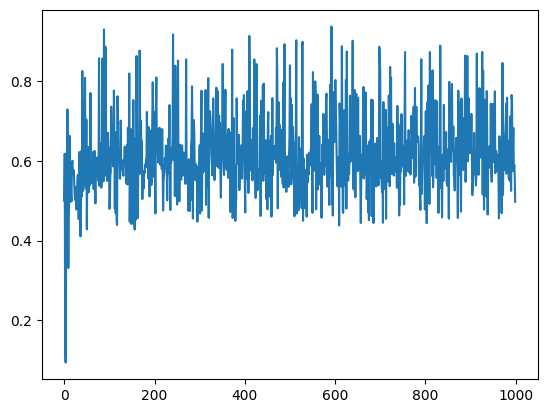

In [100]:
import matplotlib.pyplot as plt
# plt.plot(np.abs(series_dict['predicted_mean_arr']-series_dict['true_mean_arr']))
plt.plot(np.abs(series_dict['predicted_mean_arr']))
# plt.scatter(series_dict['predicted_mean_arr'][1:], series_dict['true_mean_arr'][:-1])
# plt.plot(series_dict['true_mean_arr'])

### Analyze Markov Series

In [8]:
for series_name, series_dict in sorted(markov_chain_task.items()):
    print("Processing ", series_name)
    full_series = series_dict['full_series']
    llama_size = series_dict['llama_size']
    if llama_size in ["7b", "13b", "70b"]:
        logit_mat_good = calculate_Markov(full_series, llama_size = llama_size)    
    if llama_size in ["unigram"]:
        logit_mat_good = calculate_Markov_unigram(full_series) 
    if llama_size in ["bigram"]:
        logit_mat_good = calculate_Markov_bigram(full_series)         
    series_dict['logit_mat_good'] = logit_mat_good
    save_name = os.path.join(save_path, series_name)
    with open(save_name, 'wb') as f:
        pickle.dump(series_dict, f)


Processing  markov_chain_18.pkl
Processing  markov_chain_19.pkl
Processing  markov_chain_20.pkl
Processing  markov_chain_21.pkl
Processing  markov_chain_22.pkl
Processing  markov_chain_23.pkl
Processing  markov_chain_24.pkl
Processing  markov_chain_25.pkl
Processing  markov_chain_26.pkl
Processing  markov_chain_27.pkl
Processing  markov_chain_28.pkl
Processing  markov_chain_29.pkl
Processing  markov_chain_30.pkl
Processing  markov_chain_31.pkl
Processing  markov_chain_32.pkl
Processing  markov_chain_33.pkl
Processing  markov_chain_34.pkl
Processing  markov_chain_35.pkl
